## In this notebook I aim to change the noise input of the generator to a low resolution galaxy image instead

By Shooby, started: July 25 <br>
last edited: Aug 20th

In [2]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel


from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

In [3]:
# initializing parameters:

dataroot='gals/'
device = torch.device("cpu") # If GPU then use "cuda:0"
ngpu = 3 #number of GPUs to use 
ngf = 64
ndf = 64
workers = 8 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network
nz = 16 #size of the latent z vector
niter = 1000 #number of epochs to train for
lr = 0.002 #learning rate, default=0.0002
beta1 = 0.5 #beta1 for adam. default=0.5
outf='outputs' #folder to output images and model checkpoints
print(nz)

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


16
Random Seed:  8368


In [3]:
dataset = dset.MNIST(root=dataroot, download=True,
                     transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))


(41, 41)
(41, 41)
(41, 41)


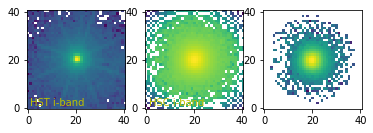

In [4]:
## The pixel scale of the kernel is now downsampled!

from skimage.transform import downscale_local_mean
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
print(psf.shape)
plt.subplot(1,3,1)
plt.imshow(np.log(psf),origin='lower')
plt.text(1,1,'HST i-band',color='y')

from scipy.ndimage import zoom
psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]
#psf_hsc = zoom(psf_hsc, 3, order=1)
print(psf_hsc.shape)
plt.subplot(1,3,2)
plt.imshow(np.log(psf_hsc),origin='lower')
plt.text(1,1,'HSC i-band',color='y')

kern = create_matching_kernel(psf,psf_hsc)
plt.subplot(1,3,3)
print(kern.shape)
#kern = kern[35:-35,35:-35]
plt.imshow(np.log(kern),origin='lower')

psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [6]:
class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( 1, ngf * 8, 4, 1, 2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, nc, 2, 2, 4, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,2:-2,2:-2]

        else:
            output = self.main(input)
            output1 = output[:,:,2:-2,2:-2]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.apply(weights_init)
print(netS)

Shoobygen(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 1, kernel_size=(2, 2), stride=(2, 2), padding=(4, 4), bias=False)
    (7): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerS = optim.Adam(netS.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images
        kernel = kernel.to(device)
        im = real_cpu+0.25*torch.rand_like(real_cpu)
        downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
        img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img[:,:,:,:]

        fake = netS(img)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netS.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerS.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netS(img)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netS.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/1000][0/95] Loss_D: 1.6203 Loss_G: 34.7112 D(x): 0.5418 D(G(z)): 0.5483 / 0.0001
[0/1000][1/95] Loss_D: 10.9738 Loss_G: 35.2430 D(x): 1.0000 D(G(z)): 0.5797 / 0.0001
[0/1000][2/95] Loss_D: 2.6363 Loss_G: 31.2627 D(x): 0.7874 D(G(z)): 0.0114 / 0.0283
[0/1000][3/95] Loss_D: 9.0252 Loss_G: 30.7009 D(x): 1.0000 D(G(z)): 0.4979 / 0.0000
[0/1000][4/95] Loss_D: 0.7095 Loss_G: 28.3202 D(x): 0.9860 D(G(z)): 0.1968 / 0.0386
[0/1000][5/95] Loss_D: 2.3004 Loss_G: 31.1293 D(x): 0.9496 D(G(z)): 0.2231 / 0.0000
[0/1000][6/95] Loss_D: 0.0138 Loss_G: 32.9147 D(x): 0.9898 D(G(z)): 0.0000 / 0.0000
[0/1000][7/95] Loss_D: 1.5610 Loss_G: 26.0302 D(x): 0.8815 D(G(z)): 0.0000 / 0.0000
[0/1000][8/95] Loss_D: 0.0037 Loss_G: 6.9957 D(x): 1.0000 D(G(z)): 0.0036 / 0.0237
[0/1000][9/95] Loss_D: 3.1357 Loss_G: 28.5083 D(x): 0.9844 D(G(z)): 0.7050 / 0.0000
[0/1000][10/95] Loss_D: 1.9643 Loss_G: 23.1939 D(x): 0.4897 D(G(z)): 0.0000 / 0.0000
[0/1000][11/95] Loss_D: 0.8459 Loss_G: 7.3499 D(x): 0.8902 D(G(z)): 0.0079 

[1/1000][3/95] Loss_D: 0.4647 Loss_G: 4.6918 D(x): 0.8047 D(G(z)): 0.0968 / 0.0400
[1/1000][4/95] Loss_D: 0.4688 Loss_G: 2.5612 D(x): 0.8435 D(G(z)): 0.0797 / 0.1338
[1/1000][5/95] Loss_D: 1.6423 Loss_G: 7.4719 D(x): 0.9928 D(G(z)): 0.5964 / 0.0031
[1/1000][6/95] Loss_D: 3.3106 Loss_G: 1.4579 D(x): 0.1454 D(G(z)): 0.0031 / 0.3331
[1/1000][7/95] Loss_D: 1.7710 Loss_G: 9.6463 D(x): 0.9979 D(G(z)): 0.6663 / 0.0004
[1/1000][8/95] Loss_D: 0.4547 Loss_G: 6.3723 D(x): 0.7164 D(G(z)): 0.0054 / 0.0068
[1/1000][9/95] Loss_D: 0.2764 Loss_G: 4.6146 D(x): 0.8256 D(G(z)): 0.0100 / 0.0247
[1/1000][10/95] Loss_D: 0.0285 Loss_G: 4.7411 D(x): 0.9941 D(G(z)): 0.0216 / 0.0308
[1/1000][11/95] Loss_D: 0.0290 Loss_G: 4.6550 D(x): 0.9948 D(G(z)): 0.0228 / 0.0229
[1/1000][12/95] Loss_D: 0.0528 Loss_G: 4.3829 D(x): 0.9992 D(G(z)): 0.0486 / 0.0360
[1/1000][13/95] Loss_D: 0.1228 Loss_G: 4.3555 D(x): 0.9449 D(G(z)): 0.0377 / 0.0313
[1/1000][14/95] Loss_D: 0.0610 Loss_G: 4.4119 D(x): 0.9892 D(G(z)): 0.0410 / 0.0300

[2/1000][6/95] Loss_D: 0.0224 Loss_G: 5.2958 D(x): 0.9980 D(G(z)): 0.0193 / 0.0111
[2/1000][7/95] Loss_D: 0.0279 Loss_G: 5.1018 D(x): 0.9999 D(G(z)): 0.0271 / 0.0194
[2/1000][8/95] Loss_D: 0.0182 Loss_G: 5.6351 D(x): 0.9971 D(G(z)): 0.0150 / 0.0121
[2/1000][9/95] Loss_D: 0.0383 Loss_G: 4.6301 D(x): 0.9996 D(G(z)): 0.0370 / 0.0252
[2/1000][10/95] Loss_D: 0.0910 Loss_G: 4.7337 D(x): 0.9994 D(G(z)): 0.0838 / 0.0185
[2/1000][11/95] Loss_D: 0.0055 Loss_G: 6.8615 D(x): 0.9991 D(G(z)): 0.0045 / 0.0034
[2/1000][12/95] Loss_D: 0.0290 Loss_G: 5.0054 D(x): 0.9853 D(G(z)): 0.0091 / 0.0089
[2/1000][13/95] Loss_D: 0.0154 Loss_G: 5.7884 D(x): 0.9923 D(G(z)): 0.0071 / 0.0073
[2/1000][14/95] Loss_D: 0.0062 Loss_G: 5.5742 D(x): 0.9999 D(G(z)): 0.0060 / 0.0060
[2/1000][15/95] Loss_D: 0.0132 Loss_G: 4.8681 D(x): 0.9999 D(G(z)): 0.0131 / 0.0118
[2/1000][16/95] Loss_D: 0.0318 Loss_G: 4.2323 D(x): 0.9993 D(G(z)): 0.0301 / 0.0244
[2/1000][17/95] Loss_D: 0.0380 Loss_G: 4.3263 D(x): 0.9997 D(G(z)): 0.0366 / 0.0

[3/1000][10/95] Loss_D: 0.0000 Loss_G: 12.0339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[3/1000][11/95] Loss_D: 0.0001 Loss_G: 11.9973 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[3/1000][12/95] Loss_D: 0.0001 Loss_G: 12.1159 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[3/1000][13/95] Loss_D: 0.0000 Loss_G: 13.1761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[3/1000][14/95] Loss_D: 0.0001 Loss_G: 11.8798 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[3/1000][15/95] Loss_D: 0.0002 Loss_G: 10.7282 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[3/1000][16/95] Loss_D: 0.0012 Loss_G: 8.4220 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[3/1000][17/95] Loss_D: 0.0006 Loss_G: 9.0000 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[3/1000][18/95] Loss_D: 0.0008 Loss_G: 10.8326 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[3/1000][19/95] Loss_D: 0.0052 Loss_G: 7.4818 D(x): 1.0000 D(G(z)): 0.0051 / 0.0050
[3/1000][20/95] Loss_D: 0.0012 Loss_G: 8.2990 D(x): 0.9999 D(G(z)): 0.0012 / 0.0012
[3/1000][21/95] Loss_D: 0.0014 Loss_G: 8.0561 D(x): 1.0000 D(G(z)): 0

[4/1000][14/95] Loss_D: 0.0018 Loss_G: 7.3329 D(x): 1.0000 D(G(z)): 0.0018 / 0.0017
[4/1000][15/95] Loss_D: 0.0011 Loss_G: 8.1228 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[4/1000][16/95] Loss_D: 0.0032 Loss_G: 6.4355 D(x): 0.9999 D(G(z)): 0.0031 / 0.0030
[4/1000][17/95] Loss_D: 0.0015 Loss_G: 6.9593 D(x): 1.0000 D(G(z)): 0.0015 / 0.0014
[4/1000][18/95] Loss_D: 0.0018 Loss_G: 7.5222 D(x): 1.0000 D(G(z)): 0.0018 / 0.0017
[4/1000][19/95] Loss_D: 0.0037 Loss_G: 6.4403 D(x): 1.0000 D(G(z)): 0.0037 / 0.0034
[4/1000][20/95] Loss_D: 0.0038 Loss_G: 6.4478 D(x): 1.0000 D(G(z)): 0.0037 / 0.0034
[4/1000][21/95] Loss_D: 0.0022 Loss_G: 7.0275 D(x): 1.0000 D(G(z)): 0.0022 / 0.0020
[4/1000][22/95] Loss_D: 0.0039 Loss_G: 5.7930 D(x): 0.9999 D(G(z)): 0.0039 / 0.0037
[4/1000][23/95] Loss_D: 0.0063 Loss_G: 6.0077 D(x): 1.0000 D(G(z)): 0.0062 / 0.0057
[4/1000][24/95] Loss_D: 0.0023 Loss_G: 7.8483 D(x): 1.0000 D(G(z)): 0.0022 / 0.0018
[4/1000][25/95] Loss_D: 0.0003 Loss_G: 10.4144 D(x): 1.0000 D(G(z)): 0.0003 

[5/1000][18/95] Loss_D: 0.0042 Loss_G: 7.9218 D(x): 1.0000 D(G(z)): 0.0042 / 0.0033
[5/1000][19/95] Loss_D: 0.0016 Loss_G: 7.5270 D(x): 1.0000 D(G(z)): 0.0016 / 0.0013
[5/1000][20/95] Loss_D: 0.0003 Loss_G: 8.7583 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[5/1000][21/95] Loss_D: 0.0011 Loss_G: 8.5110 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[5/1000][22/95] Loss_D: 0.0069 Loss_G: 5.6230 D(x): 1.0000 D(G(z)): 0.0068 / 0.0059
[5/1000][23/95] Loss_D: 0.0020 Loss_G: 6.8335 D(x): 0.9999 D(G(z)): 0.0019 / 0.0018
[5/1000][24/95] Loss_D: 0.0058 Loss_G: 6.0754 D(x): 1.0000 D(G(z)): 0.0057 / 0.0050
[5/1000][25/95] Loss_D: 0.0020 Loss_G: 8.8783 D(x): 1.0000 D(G(z)): 0.0020 / 0.0017
[5/1000][26/95] Loss_D: 0.0025 Loss_G: 13.7365 D(x): 0.9999 D(G(z)): 0.0023 / 0.0003
[5/1000][27/95] Loss_D: 0.0014 Loss_G: 7.9287 D(x): 1.0000 D(G(z)): 0.0014 / 0.0011
[5/1000][28/95] Loss_D: 0.0005 Loss_G: 10.6521 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[5/1000][29/95] Loss_D: 0.0006 Loss_G: 7.9825 D(x): 1.0000 D(G(z)): 0.0006

[6/1000][23/95] Loss_D: 0.0001 Loss_G: 14.8274 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[6/1000][24/95] Loss_D: 0.0002 Loss_G: 9.3097 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[6/1000][25/95] Loss_D: 0.0001 Loss_G: 10.3645 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[6/1000][26/95] Loss_D: 0.0002 Loss_G: 9.6336 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[6/1000][27/95] Loss_D: 0.0009 Loss_G: 7.8112 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[6/1000][28/95] Loss_D: 0.0005 Loss_G: 10.1061 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[6/1000][29/95] Loss_D: 0.0005 Loss_G: 11.2760 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[6/1000][30/95] Loss_D: 0.0009 Loss_G: 7.6964 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[6/1000][31/95] Loss_D: 0.0006 Loss_G: 8.5875 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[6/1000][32/95] Loss_D: 0.0003 Loss_G: 8.8767 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[6/1000][33/95] Loss_D: 0.0004 Loss_G: 8.6908 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[6/1000][34/95] Loss_D: 0.0012 Loss_G: 7.2568 D(x): 0.9999 D(G(z)): 0.00

[7/1000][27/95] Loss_D: 0.0011 Loss_G: 8.2739 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[7/1000][28/95] Loss_D: 0.0005 Loss_G: 8.4081 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[7/1000][29/95] Loss_D: 0.0007 Loss_G: 7.9903 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[7/1000][30/95] Loss_D: 0.0003 Loss_G: 8.6589 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[7/1000][31/95] Loss_D: 0.0006 Loss_G: 8.1967 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[7/1000][32/95] Loss_D: 0.0003 Loss_G: 9.0324 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[7/1000][33/95] Loss_D: 0.0002 Loss_G: 9.7835 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[7/1000][34/95] Loss_D: 0.0001 Loss_G: 9.9758 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[7/1000][35/95] Loss_D: 0.0000 Loss_G: 11.4252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[7/1000][36/95] Loss_D: 0.0000 Loss_G: 11.0092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[7/1000][37/95] Loss_D: 0.0000 Loss_G: 12.1339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[7/1000][38/95] Loss_D: 0.0002 Loss_G: 10.2893 D(x): 1.0000 D(G(z)): 0.00

[8/1000][30/95] Loss_D: 0.0007 Loss_G: 7.8496 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[8/1000][31/95] Loss_D: 0.0009 Loss_G: 11.2852 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[8/1000][32/95] Loss_D: 0.0006 Loss_G: 8.5568 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[8/1000][33/95] Loss_D: 0.0007 Loss_G: 7.8066 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[8/1000][34/95] Loss_D: 0.0002 Loss_G: 11.2533 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[8/1000][35/95] Loss_D: 0.0007 Loss_G: 8.1300 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[8/1000][36/95] Loss_D: 0.0003 Loss_G: 9.2775 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[8/1000][37/95] Loss_D: 0.0004 Loss_G: 8.4047 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[8/1000][38/95] Loss_D: 0.0004 Loss_G: 8.6868 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[8/1000][39/95] Loss_D: 0.0007 Loss_G: 8.1759 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[8/1000][40/95] Loss_D: 0.0004 Loss_G: 8.4385 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[8/1000][41/95] Loss_D: 0.0006 Loss_G: 8.6939 D(x): 1.0000 D(G(z)): 0.0006

[9/1000][35/95] Loss_D: 0.0004 Loss_G: 8.7866 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[9/1000][36/95] Loss_D: 0.0002 Loss_G: 9.4708 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[9/1000][37/95] Loss_D: 0.0002 Loss_G: 11.9651 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[9/1000][38/95] Loss_D: 0.0001 Loss_G: 11.2013 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[9/1000][39/95] Loss_D: 0.0002 Loss_G: 9.8612 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[9/1000][40/95] Loss_D: 0.0001 Loss_G: 10.4980 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[9/1000][41/95] Loss_D: 0.0003 Loss_G: 8.8651 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[9/1000][42/95] Loss_D: 0.0001 Loss_G: 10.2686 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[9/1000][43/95] Loss_D: 0.0002 Loss_G: 9.3025 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[9/1000][44/95] Loss_D: 0.0001 Loss_G: 10.8254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[9/1000][45/95] Loss_D: 0.0003 Loss_G: 9.4377 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[9/1000][46/95] Loss_D: 0.0001 Loss_G: 9.8412 D(x): 1.0000 D(G(z)): 0.0

[10/1000][39/95] Loss_D: 0.0001 Loss_G: 11.1225 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[10/1000][40/95] Loss_D: 0.0003 Loss_G: 8.7639 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[10/1000][41/95] Loss_D: 0.0002 Loss_G: 9.5133 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[10/1000][42/95] Loss_D: 0.0009 Loss_G: 7.9184 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[10/1000][43/95] Loss_D: 0.0002 Loss_G: 9.7392 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[10/1000][44/95] Loss_D: 0.0005 Loss_G: 8.9521 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[10/1000][45/95] Loss_D: 0.0003 Loss_G: 10.7497 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[10/1000][46/95] Loss_D: 0.0002 Loss_G: 10.0607 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[10/1000][47/95] Loss_D: 0.0001 Loss_G: 11.7108 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[10/1000][48/95] Loss_D: 0.0005 Loss_G: 8.5473 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[10/1000][49/95] Loss_D: 0.0002 Loss_G: 9.7467 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[10/1000][50/95] Loss_D: 0.0004 Loss_G: 8.7083 D(x): 1.0000 D

[11/1000][43/95] Loss_D: 1.4257 Loss_G: 5.2561 D(x): 0.8296 D(G(z)): 0.5011 / 0.0219
[11/1000][44/95] Loss_D: 3.2506 Loss_G: 1.1069 D(x): 0.1156 D(G(z)): 0.0370 / 0.4318
[11/1000][45/95] Loss_D: 2.9139 Loss_G: 1.9843 D(x): 0.9063 D(G(z)): 0.7041 / 0.2393
[11/1000][46/95] Loss_D: 1.7386 Loss_G: 1.2369 D(x): 0.4256 D(G(z)): 0.1604 / 0.3525
[11/1000][47/95] Loss_D: 3.0807 Loss_G: 8.7960 D(x): 0.9743 D(G(z)): 0.8859 / 0.0025
[11/1000][48/95] Loss_D: 5.7754 Loss_G: 1.4761 D(x): 0.0239 D(G(z)): 0.0167 / 0.3075
[11/1000][49/95] Loss_D: 0.5497 Loss_G: 0.9080 D(x): 0.9129 D(G(z)): 0.2707 / 0.4739
[11/1000][50/95] Loss_D: 0.7529 Loss_G: 2.7280 D(x): 0.8374 D(G(z)): 0.3201 / 0.1470
[11/1000][51/95] Loss_D: 0.3942 Loss_G: 3.0785 D(x): 0.9169 D(G(z)): 0.2358 / 0.0968
[11/1000][52/95] Loss_D: 0.8573 Loss_G: 1.7292 D(x): 0.5792 D(G(z)): 0.0620 / 0.2868
[11/1000][53/95] Loss_D: 1.2103 Loss_G: 3.2773 D(x): 0.9545 D(G(z)): 0.5088 / 0.0753
[11/1000][54/95] Loss_D: 0.7055 Loss_G: 3.7568 D(x): 0.8375 D(G(z

[12/1000][46/95] Loss_D: 0.2965 Loss_G: 4.8840 D(x): 0.7938 D(G(z)): 0.0227 / 0.0128
[12/1000][47/95] Loss_D: 0.1375 Loss_G: 3.2717 D(x): 0.9068 D(G(z)): 0.0324 / 0.0442
[12/1000][48/95] Loss_D: 0.4189 Loss_G: 3.1868 D(x): 0.9784 D(G(z)): 0.3150 / 0.0593
[12/1000][49/95] Loss_D: 0.2183 Loss_G: 5.6201 D(x): 0.8597 D(G(z)): 0.0057 / 0.0054
[12/1000][50/95] Loss_D: 0.0594 Loss_G: 4.8321 D(x): 0.9548 D(G(z)): 0.0079 / 0.0109
[12/1000][51/95] Loss_D: 0.0944 Loss_G: 4.2588 D(x): 0.9271 D(G(z)): 0.0125 / 0.0167
[12/1000][52/95] Loss_D: 0.0334 Loss_G: 4.0360 D(x): 0.9851 D(G(z)): 0.0180 / 0.0229
[12/1000][53/95] Loss_D: 0.2709 Loss_G: 3.5893 D(x): 0.9822 D(G(z)): 0.1897 / 0.0364
[12/1000][54/95] Loss_D: 0.0589 Loss_G: 5.6891 D(x): 0.9500 D(G(z)): 0.0060 / 0.0047
[12/1000][55/95] Loss_D: 0.1020 Loss_G: 4.4852 D(x): 0.9584 D(G(z)): 0.0178 / 0.0157
[12/1000][56/95] Loss_D: 0.1645 Loss_G: 3.6435 D(x): 0.9487 D(G(z)): 0.0971 / 0.0314
[12/1000][57/95] Loss_D: 0.0334 Loss_G: 6.5818 D(x): 0.9701 D(G(z

[13/1000][50/95] Loss_D: 0.0067 Loss_G: 6.0126 D(x): 0.9978 D(G(z)): 0.0044 / 0.0044
[13/1000][51/95] Loss_D: 0.0146 Loss_G: 5.1640 D(x): 0.9990 D(G(z)): 0.0134 / 0.0129
[13/1000][52/95] Loss_D: 0.0350 Loss_G: 4.0608 D(x): 0.9990 D(G(z)): 0.0327 / 0.0257
[13/1000][53/95] Loss_D: 0.0259 Loss_G: 5.1668 D(x): 0.9962 D(G(z)): 0.0215 / 0.0166
[13/1000][54/95] Loss_D: 0.0100 Loss_G: 5.9382 D(x): 0.9977 D(G(z)): 0.0077 / 0.0073
[13/1000][55/95] Loss_D: 0.0734 Loss_G: 7.4929 D(x): 0.9675 D(G(z)): 0.0020 / 0.0070
[13/1000][56/95] Loss_D: 0.0031 Loss_G: 7.9762 D(x): 0.9978 D(G(z)): 0.0008 / 0.0007
[13/1000][57/95] Loss_D: 0.0944 Loss_G: 5.7881 D(x): 0.9977 D(G(z)): 0.0199 / 0.0057
[13/1000][58/95] Loss_D: 0.0036 Loss_G: 7.0300 D(x): 0.9990 D(G(z)): 0.0026 / 0.0029
[13/1000][59/95] Loss_D: 0.0104 Loss_G: 6.0634 D(x): 0.9988 D(G(z)): 0.0092 / 0.0095
[13/1000][60/95] Loss_D: 0.0080 Loss_G: 5.8871 D(x): 0.9995 D(G(z)): 0.0074 / 0.0075
[13/1000][61/95] Loss_D: 0.0109 Loss_G: 5.8195 D(x): 0.9991 D(G(z

[14/1000][55/95] Loss_D: 0.0633 Loss_G: 8.9747 D(x): 0.9946 D(G(z)): 0.0155 / 0.0005
[14/1000][56/95] Loss_D: 0.0059 Loss_G: 8.9445 D(x): 0.9948 D(G(z)): 0.0006 / 0.0007
[14/1000][57/95] Loss_D: 0.0014 Loss_G: 9.0004 D(x): 0.9994 D(G(z)): 0.0008 / 0.0009
[14/1000][58/95] Loss_D: 0.0005 Loss_G: 9.4801 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[14/1000][59/95] Loss_D: 0.0023 Loss_G: 7.7779 D(x): 0.9998 D(G(z)): 0.0021 / 0.0021
[14/1000][60/95] Loss_D: 0.0055 Loss_G: 7.0542 D(x): 0.9986 D(G(z)): 0.0041 / 0.0040
[14/1000][61/95] Loss_D: 0.0037 Loss_G: 7.4598 D(x): 0.9998 D(G(z)): 0.0034 / 0.0034
[14/1000][62/95] Loss_D: 0.0034 Loss_G: 7.4021 D(x): 0.9997 D(G(z)): 0.0031 / 0.0030
[14/1000][63/95] Loss_D: 0.0025 Loss_G: 7.7419 D(x): 0.9999 D(G(z)): 0.0025 / 0.0024
[14/1000][64/95] Loss_D: 0.0032 Loss_G: 7.7827 D(x): 0.9989 D(G(z)): 0.0021 / 0.0021
[14/1000][65/95] Loss_D: 0.0078 Loss_G: 7.1330 D(x): 0.9973 D(G(z)): 0.0047 / 0.0045
[14/1000][66/95] Loss_D: 0.0040 Loss_G: 7.2753 D(x): 0.9999 D(G(z

[15/1000][58/95] Loss_D: 0.0022 Loss_G: 7.3017 D(x): 1.0000 D(G(z)): 0.0021 / 0.0020
[15/1000][59/95] Loss_D: 0.0027 Loss_G: 7.3436 D(x): 1.0000 D(G(z)): 0.0026 / 0.0026
[15/1000][60/95] Loss_D: 0.0025 Loss_G: 7.8558 D(x): 1.0000 D(G(z)): 0.0025 / 0.0024
[15/1000][61/95] Loss_D: 0.0034 Loss_G: 7.5984 D(x): 1.0000 D(G(z)): 0.0034 / 0.0022
[15/1000][62/95] Loss_D: 0.0040 Loss_G: 6.7724 D(x): 1.0000 D(G(z)): 0.0040 / 0.0039
[15/1000][63/95] Loss_D: 0.0012 Loss_G: 8.3137 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[15/1000][64/95] Loss_D: 0.0037 Loss_G: 6.3505 D(x): 0.9999 D(G(z)): 0.0036 / 0.0035
[15/1000][65/95] Loss_D: 0.0014 Loss_G: 8.7435 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[15/1000][66/95] Loss_D: 0.0008 Loss_G: 10.4990 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[15/1000][67/95] Loss_D: 0.0006 Loss_G: 9.6199 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[15/1000][68/95] Loss_D: 0.0011 Loss_G: 8.9332 D(x): 0.9999 D(G(z)): 0.0010 / 0.0010
[15/1000][69/95] Loss_D: 0.0003 Loss_G: 10.4794 D(x): 0.9999 D(G

[16/1000][62/95] Loss_D: 0.0015 Loss_G: 7.6371 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[16/1000][63/95] Loss_D: 0.0020 Loss_G: 7.6788 D(x): 1.0000 D(G(z)): 0.0020 / 0.0019
[16/1000][64/95] Loss_D: 0.0008 Loss_G: 8.0025 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[16/1000][65/95] Loss_D: 0.0019 Loss_G: 7.6827 D(x): 1.0000 D(G(z)): 0.0018 / 0.0018
[16/1000][66/95] Loss_D: 0.0027 Loss_G: 6.8009 D(x): 1.0000 D(G(z)): 0.0027 / 0.0026
[16/1000][67/95] Loss_D: 0.0021 Loss_G: 7.4462 D(x): 1.0000 D(G(z)): 0.0021 / 0.0021
[16/1000][68/95] Loss_D: 0.0023 Loss_G: 8.0730 D(x): 1.0000 D(G(z)): 0.0023 / 0.0020
[16/1000][69/95] Loss_D: 0.0015 Loss_G: 8.1477 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[16/1000][70/95] Loss_D: 0.0005 Loss_G: 10.1579 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[16/1000][71/95] Loss_D: 0.0002 Loss_G: 10.6299 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[16/1000][72/95] Loss_D: 0.0006 Loss_G: 10.4256 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[16/1000][73/95] Loss_D: 0.0001 Loss_G: 10.8040 D(x): 0.9999 D

[17/1000][64/95] Loss_D: 0.0006 Loss_G: 8.3688 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[17/1000][65/95] Loss_D: 0.0003 Loss_G: 9.7957 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[17/1000][66/95] Loss_D: 0.0073 Loss_G: 8.1582 D(x): 1.0000 D(G(z)): 0.0062 / 0.0014
[17/1000][67/95] Loss_D: 0.0006 Loss_G: 9.2842 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[17/1000][68/95] Loss_D: 0.0013 Loss_G: 8.7297 D(x): 0.9999 D(G(z)): 0.0012 / 0.0012
[17/1000][69/95] Loss_D: 0.0008 Loss_G: 9.2785 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[17/1000][70/95] Loss_D: 0.0002 Loss_G: 11.6428 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[17/1000][71/95] Loss_D: 0.0010 Loss_G: 9.1417 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[17/1000][72/95] Loss_D: 0.0563 Loss_G: 10.4410 D(x): 0.9577 D(G(z)): 0.0003 / 0.0003
[17/1000][73/95] Loss_D: 0.0016 Loss_G: 9.0712 D(x): 0.9992 D(G(z)): 0.0008 / 0.0008
[17/1000][74/95] Loss_D: 0.0008 Loss_G: 11.0417 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[17/1000][75/95] Loss_D: 0.0009 Loss_G: 9.8141 D(x): 0.9993 D(

[18/1000][66/95] Loss_D: 0.0010 Loss_G: 8.1798 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[18/1000][67/95] Loss_D: 0.0012 Loss_G: 8.9362 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[18/1000][68/95] Loss_D: 0.0015 Loss_G: 7.6196 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[18/1000][69/95] Loss_D: 0.0017 Loss_G: 7.6456 D(x): 1.0000 D(G(z)): 0.0017 / 0.0014
[18/1000][70/95] Loss_D: 0.0005 Loss_G: 9.9711 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[18/1000][71/95] Loss_D: 0.0001 Loss_G: 11.3483 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[18/1000][72/95] Loss_D: 0.0008 Loss_G: 8.9264 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[18/1000][73/95] Loss_D: 0.0004 Loss_G: 9.7033 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[18/1000][74/95] Loss_D: 0.0004 Loss_G: 10.1931 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[18/1000][75/95] Loss_D: 0.0003 Loss_G: 9.4510 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[18/1000][76/95] Loss_D: 0.0007 Loss_G: 10.4457 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[18/1000][77/95] Loss_D: 0.0007 Loss_G: 8.4538 D(x): 1.0000 D(

[19/1000][70/95] Loss_D: 0.5766 Loss_G: 1.9020 D(x): 0.8714 D(G(z)): 0.3254 / 0.1770
[19/1000][71/95] Loss_D: 0.6915 Loss_G: 2.4407 D(x): 0.8006 D(G(z)): 0.2970 / 0.1035
[19/1000][72/95] Loss_D: 0.5572 Loss_G: 2.6849 D(x): 0.8137 D(G(z)): 0.2616 / 0.1000
[19/1000][73/95] Loss_D: 0.9444 Loss_G: 1.4094 D(x): 0.6347 D(G(z)): 0.2682 / 0.2966
[19/1000][74/95] Loss_D: 1.8614 Loss_G: 7.8647 D(x): 0.7310 D(G(z)): 0.5650 / 0.0048
[19/1000][75/95] Loss_D: 2.9700 Loss_G: 0.6613 D(x): 0.0859 D(G(z)): 0.0468 / 0.5818
[19/1000][76/95] Loss_D: 1.5437 Loss_G: 1.3442 D(x): 0.8367 D(G(z)): 0.5214 / 0.3879
[19/1000][77/95] Loss_D: 1.5066 Loss_G: 2.0546 D(x): 0.6349 D(G(z)): 0.3883 / 0.2197
[19/1000][78/95] Loss_D: 1.1828 Loss_G: 0.6249 D(x): 0.5976 D(G(z)): 0.3594 / 0.5616
[19/1000][79/95] Loss_D: 2.5256 Loss_G: 10.5463 D(x): 0.9781 D(G(z)): 0.8913 / 0.0043
[19/1000][80/95] Loss_D: 8.1124 Loss_G: 3.6489 D(x): 0.0057 D(G(z)): 0.0029 / 0.0965
[19/1000][81/95] Loss_D: 2.8795 Loss_G: 0.3013 D(x): 0.2024 D(G(

[20/1000][74/95] Loss_D: 1.0833 Loss_G: 1.2019 D(x): 0.4687 D(G(z)): 0.1201 / 0.3421
[20/1000][75/95] Loss_D: 0.7231 Loss_G: 2.2631 D(x): 0.9156 D(G(z)): 0.3964 / 0.1470
[20/1000][76/95] Loss_D: 0.7309 Loss_G: 2.3148 D(x): 0.8113 D(G(z)): 0.2876 / 0.1337
[20/1000][77/95] Loss_D: 0.5474 Loss_G: 2.4451 D(x): 0.7907 D(G(z)): 0.2102 / 0.1084
[20/1000][78/95] Loss_D: 0.4100 Loss_G: 2.4427 D(x): 0.8122 D(G(z)): 0.1104 / 0.1116
[20/1000][79/95] Loss_D: 0.2887 Loss_G: 2.9516 D(x): 0.9410 D(G(z)): 0.1928 / 0.0696
[20/1000][80/95] Loss_D: 0.5852 Loss_G: 4.4316 D(x): 0.9387 D(G(z)): 0.3455 / 0.0261
[20/1000][81/95] Loss_D: 0.9790 Loss_G: 2.1905 D(x): 0.4820 D(G(z)): 0.0186 / 0.1664
[20/1000][82/95] Loss_D: 0.6413 Loss_G: 1.8638 D(x): 0.8353 D(G(z)): 0.3105 / 0.2013
[20/1000][83/95] Loss_D: 1.3094 Loss_G: 6.5127 D(x): 0.9246 D(G(z)): 0.6341 / 0.0027
[20/1000][84/95] Loss_D: 5.3909 Loss_G: 1.4233 D(x): 0.0095 D(G(z)): 0.0071 / 0.2836
[20/1000][85/95] Loss_D: 0.6364 Loss_G: 0.7611 D(x): 0.8450 D(G(z

[21/1000][78/95] Loss_D: 0.6232 Loss_G: 4.6251 D(x): 0.9765 D(G(z)): 0.3129 / 0.0231
[21/1000][79/95] Loss_D: 0.0628 Loss_G: 5.0950 D(x): 0.9819 D(G(z)): 0.0414 / 0.0092
[21/1000][80/95] Loss_D: 0.1348 Loss_G: 4.7008 D(x): 0.8878 D(G(z)): 0.0088 / 0.0121
[21/1000][81/95] Loss_D: 0.0120 Loss_G: 6.0872 D(x): 0.9942 D(G(z)): 0.0058 / 0.0053
[21/1000][82/95] Loss_D: 0.0696 Loss_G: 4.8434 D(x): 0.9532 D(G(z)): 0.0103 / 0.0130
[21/1000][83/95] Loss_D: 0.1558 Loss_G: 4.9195 D(x): 0.9944 D(G(z)): 0.1250 / 0.0189
[21/1000][84/95] Loss_D: 0.3975 Loss_G: 6.4227 D(x): 0.9810 D(G(z)): 0.2564 / 0.0032
[21/1000][85/95] Loss_D: 0.4854 Loss_G: 6.1314 D(x): 0.6978 D(G(z)): 0.0007 / 0.0037
[21/1000][86/95] Loss_D: 0.0030 Loss_G: 6.3642 D(x): 0.9981 D(G(z)): 0.0010 / 0.0023
[21/1000][87/95] Loss_D: 0.0481 Loss_G: 5.9772 D(x): 0.9618 D(G(z)): 0.0017 / 0.0044
[21/1000][88/95] Loss_D: 0.0727 Loss_G: 3.9011 D(x): 0.9991 D(G(z)): 0.0637 / 0.0319
[21/1000][89/95] Loss_D: 0.1852 Loss_G: 5.9352 D(x): 0.9951 D(G(z

[22/1000][83/95] Loss_D: 0.0021 Loss_G: 8.7675 D(x): 0.9999 D(G(z)): 0.0020 / 0.0015
[22/1000][84/95] Loss_D: 0.0050 Loss_G: 6.5529 D(x): 0.9985 D(G(z)): 0.0034 / 0.0032
[22/1000][85/95] Loss_D: 0.0126 Loss_G: 5.5763 D(x): 0.9998 D(G(z)): 0.0121 / 0.0086
[22/1000][86/95] Loss_D: 0.0131 Loss_G: 4.9453 D(x): 0.9997 D(G(z)): 0.0127 / 0.0119
[22/1000][87/95] Loss_D: 0.0734 Loss_G: 5.4611 D(x): 0.9843 D(G(z)): 0.0089 / 0.0082
[22/1000][88/95] Loss_D: 0.0172 Loss_G: 4.7214 D(x): 0.9995 D(G(z)): 0.0165 / 0.0136
[22/1000][89/95] Loss_D: 0.0141 Loss_G: 5.2492 D(x): 0.9990 D(G(z)): 0.0129 / 0.0101
[22/1000][90/95] Loss_D: 0.0464 Loss_G: 5.4818 D(x): 0.9999 D(G(z)): 0.0226 / 0.0075
[22/1000][91/95] Loss_D: 0.0434 Loss_G: 5.2539 D(x): 0.9990 D(G(z)): 0.0380 / 0.0124
[22/1000][92/95] Loss_D: 0.0180 Loss_G: 6.6890 D(x): 0.9999 D(G(z)): 0.0167 / 0.0043
[22/1000][93/95] Loss_D: 0.0031 Loss_G: 7.8828 D(x): 0.9999 D(G(z)): 0.0029 / 0.0017
[22/1000][94/95] Loss_D: 0.2178 Loss_G: 10.1263 D(x): 0.8794 D(G(

[23/1000][86/95] Loss_D: 0.0051 Loss_G: 7.0015 D(x): 0.9992 D(G(z)): 0.0043 / 0.0043
[23/1000][87/95] Loss_D: 0.0031 Loss_G: 7.5426 D(x): 0.9997 D(G(z)): 0.0028 / 0.0028
[23/1000][88/95] Loss_D: 0.0035 Loss_G: 7.8026 D(x): 1.0000 D(G(z)): 0.0035 / 0.0034
[23/1000][89/95] Loss_D: 0.0007 Loss_G: 10.2287 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[23/1000][90/95] Loss_D: 0.0020 Loss_G: 9.1237 D(x): 0.9997 D(G(z)): 0.0016 / 0.0016
[23/1000][91/95] Loss_D: 0.0046 Loss_G: 7.8747 D(x): 0.9999 D(G(z)): 0.0045 / 0.0044
[23/1000][92/95] Loss_D: 0.0032 Loss_G: 7.8783 D(x): 0.9997 D(G(z)): 0.0028 / 0.0028
[23/1000][93/95] Loss_D: 0.0150 Loss_G: 7.2037 D(x): 0.9999 D(G(z)): 0.0115 / 0.0037
[23/1000][94/95] Loss_D: 0.0079 Loss_G: 15.6853 D(x): 0.9923 D(G(z)): 0.0000 / 0.0000
[24/1000][0/95] Loss_D: 0.0017 Loss_G: 8.8596 D(x): 0.9999 D(G(z)): 0.0017 / 0.0017
[24/1000][1/95] Loss_D: 0.0029 Loss_G: 8.0930 D(x): 0.9997 D(G(z)): 0.0026 / 0.0026
[24/1000][2/95] Loss_D: 0.0012 Loss_G: 9.5303 D(x): 0.9996 D(G(z)

[24/1000][88/95] Loss_D: 0.0017 Loss_G: 8.2813 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[24/1000][89/95] Loss_D: 0.0030 Loss_G: 7.0931 D(x): 0.9999 D(G(z)): 0.0029 / 0.0029
[24/1000][90/95] Loss_D: 0.0076 Loss_G: 6.8490 D(x): 0.9961 D(G(z)): 0.0034 / 0.0034
[24/1000][91/95] Loss_D: 0.0031 Loss_G: 7.0725 D(x): 0.9998 D(G(z)): 0.0029 / 0.0029
[24/1000][92/95] Loss_D: 0.0043 Loss_G: 6.2198 D(x): 1.0000 D(G(z)): 0.0043 / 0.0042
[24/1000][93/95] Loss_D: 0.4825 Loss_G: 7.1521 D(x): 0.7720 D(G(z)): 0.0022 / 0.0030
[24/1000][94/95] Loss_D: 0.0021 Loss_G: 7.3167 D(x): 1.0000 D(G(z)): 0.0021 / 0.0023
[25/1000][0/95] Loss_D: 0.0007 Loss_G: 8.3526 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[25/1000][1/95] Loss_D: 0.0025 Loss_G: 7.7448 D(x): 0.9997 D(G(z)): 0.0021 / 0.0022
[25/1000][2/95] Loss_D: 0.0088 Loss_G: 8.1049 D(x): 0.9940 D(G(z)): 0.0012 / 0.0012
[25/1000][3/95] Loss_D: 0.0006 Loss_G: 8.0514 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[25/1000][4/95] Loss_D: 0.0014 Loss_G: 7.4584 D(x): 1.0000 D(G(z)): 0

[25/1000][90/95] Loss_D: 0.0013 Loss_G: 7.5523 D(x): 1.0000 D(G(z)): 0.0013 / 0.0013
[25/1000][91/95] Loss_D: 0.0314 Loss_G: 6.3879 D(x): 1.0000 D(G(z)): 0.0288 / 0.0087
[25/1000][92/95] Loss_D: 0.2241 Loss_G: 12.1602 D(x): 1.0000 D(G(z)): 0.1248 / 0.0001
[25/1000][93/95] Loss_D: 0.0167 Loss_G: 10.1573 D(x): 0.9998 D(G(z)): 0.0141 / 0.0007
[25/1000][94/95] Loss_D: 0.0083 Loss_G: 9.5525 D(x): 0.9991 D(G(z)): 0.0073 / 0.0005
[26/1000][0/95] Loss_D: 0.1498 Loss_G: 15.7627 D(x): 0.9240 D(G(z)): 0.0000 / 0.0000
[26/1000][1/95] Loss_D: 0.0078 Loss_G: 11.5887 D(x): 0.9962 D(G(z)): 0.0034 / 0.0002
[26/1000][2/95] Loss_D: 0.0004 Loss_G: 12.6495 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[26/1000][3/95] Loss_D: 0.0000 Loss_G: 16.0477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[26/1000][4/95] Loss_D: 0.0007 Loss_G: 14.3517 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[26/1000][5/95] Loss_D: 0.0001 Loss_G: 12.8040 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[26/1000][6/95] Loss_D: 0.0010 Loss_G: 8.2411 D(x): 0.9998 D(G(

[26/1000][94/95] Loss_D: 0.0001 Loss_G: 10.6970 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[27/1000][0/95] Loss_D: 0.0028 Loss_G: 6.2391 D(x): 1.0000 D(G(z)): 0.0027 / 0.0027
[27/1000][1/95] Loss_D: 0.0023 Loss_G: 8.2515 D(x): 1.0000 D(G(z)): 0.0023 / 0.0023
[27/1000][2/95] Loss_D: 0.0019 Loss_G: 6.8437 D(x): 1.0000 D(G(z)): 0.0019 / 0.0019
[27/1000][3/95] Loss_D: 0.0013 Loss_G: 7.3383 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[27/1000][4/95] Loss_D: 0.0006 Loss_G: 8.3964 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[27/1000][5/95] Loss_D: 0.0012 Loss_G: 7.9752 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[27/1000][6/95] Loss_D: 0.0008 Loss_G: 7.8226 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[27/1000][7/95] Loss_D: 0.0017 Loss_G: 7.1664 D(x): 1.0000 D(G(z)): 0.0017 / 0.0017
[27/1000][8/95] Loss_D: 0.0052 Loss_G: 7.5956 D(x): 0.9968 D(G(z)): 0.0015 / 0.0015
[27/1000][9/95] Loss_D: 0.0031 Loss_G: 6.2304 D(x): 0.9999 D(G(z)): 0.0029 / 0.0029
[27/1000][10/95] Loss_D: 0.0027 Loss_G: 6.8165 D(x): 1.0000 D(G(z)): 0.002

[28/1000][3/95] Loss_D: 0.0003 Loss_G: 9.5845 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[28/1000][4/95] Loss_D: 0.0002 Loss_G: 10.1063 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[28/1000][5/95] Loss_D: 0.0005 Loss_G: 8.4345 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[28/1000][6/95] Loss_D: 0.0011 Loss_G: 7.6268 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[28/1000][7/95] Loss_D: 0.0010 Loss_G: 7.8811 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[28/1000][8/95] Loss_D: 0.0013 Loss_G: 7.4211 D(x): 1.0000 D(G(z)): 0.0013 / 0.0013
[28/1000][9/95] Loss_D: 0.0011 Loss_G: 7.6697 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[28/1000][10/95] Loss_D: 0.0009 Loss_G: 7.8151 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[28/1000][11/95] Loss_D: 0.0011 Loss_G: 7.8022 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[28/1000][12/95] Loss_D: 0.0026 Loss_G: 6.5598 D(x): 1.0000 D(G(z)): 0.0026 / 0.0026
[28/1000][13/95] Loss_D: 0.0005 Loss_G: 8.5745 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[28/1000][14/95] Loss_D: 0.0009 Loss_G: 11.8135 D(x): 1.0000 D(G(z)): 0

[29/1000][6/95] Loss_D: 0.0015 Loss_G: 7.3327 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[29/1000][7/95] Loss_D: 0.0014 Loss_G: 7.2144 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[29/1000][8/95] Loss_D: 0.0109 Loss_G: 7.4145 D(x): 1.0000 D(G(z)): 0.0095 / 0.0025
[29/1000][9/95] Loss_D: 0.0017 Loss_G: 7.8151 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[29/1000][10/95] Loss_D: 0.0017 Loss_G: 7.0499 D(x): 1.0000 D(G(z)): 0.0017 / 0.0017
[29/1000][11/95] Loss_D: 0.0014 Loss_G: 7.8719 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[29/1000][12/95] Loss_D: 0.0012 Loss_G: 7.7369 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[29/1000][13/95] Loss_D: 0.0008 Loss_G: 8.1393 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[29/1000][14/95] Loss_D: 0.0011 Loss_G: 7.9578 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[29/1000][15/95] Loss_D: 0.0033 Loss_G: 6.8812 D(x): 1.0000 D(G(z)): 0.0032 / 0.0028
[29/1000][16/95] Loss_D: 0.0106 Loss_G: 7.5991 D(x): 1.0000 D(G(z)): 0.0096 / 0.0012
[29/1000][17/95] Loss_D: 0.0006 Loss_G: 8.8500 D(x): 1.0000 D(G(z)): 

[30/1000][10/95] Loss_D: 0.0004 Loss_G: 8.6616 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[30/1000][11/95] Loss_D: 0.0043 Loss_G: 9.7219 D(x): 0.9959 D(G(z)): 0.0001 / 0.0001
[30/1000][12/95] Loss_D: 0.0002 Loss_G: 10.0599 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[30/1000][13/95] Loss_D: 0.0001 Loss_G: 10.5024 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[30/1000][14/95] Loss_D: 0.0003 Loss_G: 9.2892 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[30/1000][15/95] Loss_D: 0.0003 Loss_G: 9.1183 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[30/1000][16/95] Loss_D: 0.0006 Loss_G: 8.0692 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[30/1000][17/95] Loss_D: 0.0011 Loss_G: 7.8227 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[30/1000][18/95] Loss_D: 0.0010 Loss_G: 7.6388 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[30/1000][19/95] Loss_D: 0.0012 Loss_G: 7.6740 D(x): 0.9999 D(G(z)): 0.0012 / 0.0012
[30/1000][20/95] Loss_D: 0.0006 Loss_G: 8.9386 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[30/1000][21/95] Loss_D: 0.0004 Loss_G: 8.8149 D(x): 1.0000 D(G

[31/1000][14/95] Loss_D: 0.0002 Loss_G: 9.5463 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[31/1000][15/95] Loss_D: 0.0003 Loss_G: 9.2350 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[31/1000][16/95] Loss_D: 0.0005 Loss_G: 9.8303 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[31/1000][17/95] Loss_D: 0.0002 Loss_G: 10.0075 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[31/1000][18/95] Loss_D: 0.0003 Loss_G: 10.4615 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[31/1000][19/95] Loss_D: 0.0003 Loss_G: 9.0406 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[31/1000][20/95] Loss_D: 0.0003 Loss_G: 9.3382 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[31/1000][21/95] Loss_D: 0.0003 Loss_G: 9.7001 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[31/1000][22/95] Loss_D: 0.0002 Loss_G: 9.6972 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[31/1000][23/95] Loss_D: 0.0002 Loss_G: 10.1904 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[31/1000][24/95] Loss_D: 0.0151 Loss_G: 9.1293 D(x): 0.9878 D(G(z)): 0.0005 / 0.0006
[31/1000][25/95] Loss_D: 0.0009 Loss_G: 7.6708 D(x): 1.0000 D(

[32/1000][18/95] Loss_D: 0.0003 Loss_G: 10.8632 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[32/1000][19/95] Loss_D: 0.0005 Loss_G: 9.4644 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[32/1000][20/95] Loss_D: 0.0003 Loss_G: 9.3824 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[32/1000][21/95] Loss_D: 0.0005 Loss_G: 9.4024 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[32/1000][22/95] Loss_D: 0.0004 Loss_G: 9.0391 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[32/1000][23/95] Loss_D: 0.0016 Loss_G: 8.8664 D(x): 1.0000 D(G(z)): 0.0016 / 0.0015
[32/1000][24/95] Loss_D: 0.0009 Loss_G: 7.9492 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[32/1000][25/95] Loss_D: 0.0006 Loss_G: 8.1285 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[32/1000][26/95] Loss_D: 0.0006 Loss_G: 9.0832 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[32/1000][27/95] Loss_D: 0.0007 Loss_G: 8.0783 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[32/1000][28/95] Loss_D: 0.0027 Loss_G: 8.4645 D(x): 1.0000 D(G(z)): 0.0026 / 0.0018
[32/1000][29/95] Loss_D: 0.0001 Loss_G: 12.0965 D(x): 1.0000 D(G

[33/1000][23/95] Loss_D: 0.2292 Loss_G: 6.9204 D(x): 0.9946 D(G(z)): 0.1704 / 0.0022
[33/1000][24/95] Loss_D: 0.4042 Loss_G: 4.5562 D(x): 0.8399 D(G(z)): 0.0147 / 0.0365
[33/1000][25/95] Loss_D: 0.7987 Loss_G: 11.2813 D(x): 0.9972 D(G(z)): 0.4361 / 0.0043
[33/1000][26/95] Loss_D: 1.4903 Loss_G: 3.5297 D(x): 0.3503 D(G(z)): 0.0176 / 0.2506
[33/1000][27/95] Loss_D: 2.3006 Loss_G: 7.2665 D(x): 0.5422 D(G(z)): 0.3468 / 0.0098
[33/1000][28/95] Loss_D: 0.8156 Loss_G: 15.4757 D(x): 0.9998 D(G(z)): 0.3468 / 0.0000
[33/1000][29/95] Loss_D: 6.0581 Loss_G: 0.0069 D(x): 0.0127 D(G(z)): 0.0001 / 0.9932
[33/1000][30/95] Loss_D: 4.0726 Loss_G: 14.1681 D(x): 1.0000 D(G(z)): 0.8679 / 0.0000
[33/1000][31/95] Loss_D: 0.0209 Loss_G: 13.7573 D(x): 0.9805 D(G(z)): 0.0008 / 0.0000
[33/1000][32/95] Loss_D: 2.0603 Loss_G: 2.9534 D(x): 0.2416 D(G(z)): 0.0065 / 0.2906
[33/1000][33/95] Loss_D: 4.4905 Loss_G: 9.2432 D(x): 0.9992 D(G(z)): 0.9010 / 0.0003
[33/1000][34/95] Loss_D: 0.1786 Loss_G: 9.2608 D(x): 0.9160 D

[34/1000][26/95] Loss_D: 0.0053 Loss_G: 8.1932 D(x): 0.9953 D(G(z)): 0.0006 / 0.0006
[34/1000][27/95] Loss_D: 0.0024 Loss_G: 8.0472 D(x): 0.9983 D(G(z)): 0.0007 / 0.0007
[34/1000][28/95] Loss_D: 0.0023 Loss_G: 7.3050 D(x): 0.9996 D(G(z)): 0.0018 / 0.0017
[34/1000][29/95] Loss_D: 0.0019 Loss_G: 8.3807 D(x): 0.9986 D(G(z)): 0.0005 / 0.0005
[34/1000][30/95] Loss_D: 0.0231 Loss_G: 5.1890 D(x): 0.9997 D(G(z)): 0.0221 / 0.0165
[34/1000][31/95] Loss_D: 0.0134 Loss_G: 9.8931 D(x): 0.9884 D(G(z)): 0.0005 / 0.0005
[34/1000][32/95] Loss_D: 0.0004 Loss_G: 11.1980 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[34/1000][33/95] Loss_D: 0.0011 Loss_G: 8.8508 D(x): 0.9996 D(G(z)): 0.0007 / 0.0007
[34/1000][34/95] Loss_D: 0.0130 Loss_G: 6.2205 D(x): 0.9990 D(G(z)): 0.0101 / 0.0061
[34/1000][35/95] Loss_D: 0.0020 Loss_G: 7.9484 D(x): 0.9997 D(G(z)): 0.0017 / 0.0010
[34/1000][36/95] Loss_D: 0.0181 Loss_G: 5.4142 D(x): 0.9994 D(G(z)): 0.0169 / 0.0120
[34/1000][37/95] Loss_D: 0.0008 Loss_G: 10.8603 D(x): 0.9993 D(G

[35/1000][30/95] Loss_D: 0.1371 Loss_G: 4.7091 D(x): 0.9135 D(G(z)): 0.0353 / 0.0141
[35/1000][31/95] Loss_D: 0.2460 Loss_G: 3.5760 D(x): 0.8246 D(G(z)): 0.0134 / 0.0495
[35/1000][32/95] Loss_D: 0.5183 Loss_G: 5.8522 D(x): 0.8226 D(G(z)): 0.0015 / 0.0067
[35/1000][33/95] Loss_D: 2.2036 Loss_G: 13.3989 D(x): 0.9994 D(G(z)): 0.8245 / 0.0000
[35/1000][34/95] Loss_D: 4.7667 Loss_G: 8.6060 D(x): 0.0522 D(G(z)): 0.0000 / 0.0023
[35/1000][35/95] Loss_D: 0.9568 Loss_G: 3.8667 D(x): 0.4761 D(G(z)): 0.0065 / 0.0975
[35/1000][36/95] Loss_D: 1.3276 Loss_G: 6.0373 D(x): 0.9981 D(G(z)): 0.5469 / 0.0059
[35/1000][37/95] Loss_D: 0.4419 Loss_G: 6.9694 D(x): 0.9202 D(G(z)): 0.2216 / 0.0036
[35/1000][38/95] Loss_D: 1.9362 Loss_G: 5.4332 D(x): 0.2559 D(G(z)): 0.0002 / 0.0140
[35/1000][39/95] Loss_D: 0.2754 Loss_G: 4.1855 D(x): 0.9998 D(G(z)): 0.2020 / 0.0216
[35/1000][40/95] Loss_D: 1.8638 Loss_G: 9.4109 D(x): 0.9989 D(G(z)): 0.7135 / 0.0006
[35/1000][41/95] Loss_D: 0.8812 Loss_G: 5.8175 D(x): 0.5467 D(G(

[36/1000][35/95] Loss_D: 0.0116 Loss_G: 13.1194 D(x): 0.9888 D(G(z)): 0.0000 / 0.0000
[36/1000][36/95] Loss_D: 0.0482 Loss_G: 12.9914 D(x): 0.9577 D(G(z)): 0.0000 / 0.0000
[36/1000][37/95] Loss_D: 0.0012 Loss_G: 12.4819 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[36/1000][38/95] Loss_D: 0.0106 Loss_G: 10.9867 D(x): 0.9898 D(G(z)): 0.0001 / 0.0001
[36/1000][39/95] Loss_D: 0.0044 Loss_G: 9.8592 D(x): 0.9958 D(G(z)): 0.0002 / 0.0002
[36/1000][40/95] Loss_D: 0.0055 Loss_G: 8.2710 D(x): 0.9955 D(G(z)): 0.0007 / 0.0008
[36/1000][41/95] Loss_D: 0.0034 Loss_G: 6.8118 D(x): 0.9988 D(G(z)): 0.0022 / 0.0022
[36/1000][42/95] Loss_D: 0.0490 Loss_G: 4.1370 D(x): 0.9987 D(G(z)): 0.0460 / 0.0235
[36/1000][43/95] Loss_D: 0.0076 Loss_G: 9.1453 D(x): 0.9933 D(G(z)): 0.0003 / 0.0003
[36/1000][44/95] Loss_D: 0.0155 Loss_G: 4.9703 D(x): 0.9989 D(G(z)): 0.0143 / 0.0102
[36/1000][45/95] Loss_D: 0.0009 Loss_G: 10.2630 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[36/1000][46/95] Loss_D: 0.0180 Loss_G: 7.5277 D(x): 0.9885 

[37/1000][39/95] Loss_D: 0.0274 Loss_G: 6.2907 D(x): 0.9864 D(G(z)): 0.0032 / 0.0031
[37/1000][40/95] Loss_D: 0.0011 Loss_G: 8.0569 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[37/1000][41/95] Loss_D: 0.0021 Loss_G: 6.9972 D(x): 0.9999 D(G(z)): 0.0020 / 0.0020
[37/1000][42/95] Loss_D: 0.0032 Loss_G: 6.2904 D(x): 1.0000 D(G(z)): 0.0031 / 0.0031
[37/1000][43/95] Loss_D: 0.0016 Loss_G: 7.2467 D(x): 0.9999 D(G(z)): 0.0015 / 0.0015
[37/1000][44/95] Loss_D: 0.0100 Loss_G: 6.6550 D(x): 0.9999 D(G(z)): 0.0084 / 0.0025
[37/1000][45/95] Loss_D: 0.0036 Loss_G: 6.6891 D(x): 0.9997 D(G(z)): 0.0033 / 0.0033
[37/1000][46/95] Loss_D: 0.0016 Loss_G: 8.5972 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[37/1000][47/95] Loss_D: 0.0041 Loss_G: 7.5048 D(x): 0.9983 D(G(z)): 0.0024 / 0.0024
[37/1000][48/95] Loss_D: 0.0020 Loss_G: 7.4516 D(x): 1.0000 D(G(z)): 0.0020 / 0.0020
[37/1000][49/95] Loss_D: 0.0025 Loss_G: 7.3341 D(x): 0.9999 D(G(z)): 0.0025 / 0.0024
[37/1000][50/95] Loss_D: 0.0159 Loss_G: 7.4770 D(x): 0.9893 D(G(z

[38/1000][42/95] Loss_D: 0.0003 Loss_G: 9.8915 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[38/1000][43/95] Loss_D: 0.0041 Loss_G: 8.3859 D(x): 0.9964 D(G(z)): 0.0005 / 0.0005
[38/1000][44/95] Loss_D: 0.0029 Loss_G: 7.1201 D(x): 0.9999 D(G(z)): 0.0028 / 0.0027
[38/1000][45/95] Loss_D: 0.0010 Loss_G: 9.8957 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[38/1000][46/95] Loss_D: 0.0006 Loss_G: 8.5258 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[38/1000][47/95] Loss_D: 0.0056 Loss_G: 6.8183 D(x): 0.9965 D(G(z)): 0.0020 / 0.0020
[38/1000][48/95] Loss_D: 0.0024 Loss_G: 6.7633 D(x): 0.9995 D(G(z)): 0.0018 / 0.0018
[38/1000][49/95] Loss_D: 0.0004 Loss_G: 10.3678 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[38/1000][50/95] Loss_D: 0.0005 Loss_G: 9.9826 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[38/1000][51/95] Loss_D: 0.0055 Loss_G: 6.4414 D(x): 0.9980 D(G(z)): 0.0034 / 0.0033
[38/1000][52/95] Loss_D: 0.0097 Loss_G: 6.0851 D(x): 0.9999 D(G(z)): 0.0094 / 0.0071
[38/1000][53/95] Loss_D: 0.0018 Loss_G: 9.1976 D(x): 0.9986 D(G(

[39/1000][47/95] Loss_D: 0.0006 Loss_G: 9.0709 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[39/1000][48/95] Loss_D: 0.0054 Loss_G: 8.0754 D(x): 0.9955 D(G(z)): 0.0009 / 0.0009
[39/1000][49/95] Loss_D: 0.0008 Loss_G: 8.4571 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[39/1000][50/95] Loss_D: 0.5029 Loss_G: 8.7550 D(x): 0.7584 D(G(z)): 0.0005 / 0.0007
[39/1000][51/95] Loss_D: 0.0010 Loss_G: 8.2388 D(x): 0.9999 D(G(z)): 0.0009 / 0.0011
[39/1000][52/95] Loss_D: 0.0005 Loss_G: 9.0694 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[39/1000][53/95] Loss_D: 0.0017 Loss_G: 7.8154 D(x): 0.9997 D(G(z)): 0.0014 / 0.0014
[39/1000][54/95] Loss_D: 0.0024 Loss_G: 7.1934 D(x): 1.0000 D(G(z)): 0.0024 / 0.0025
[39/1000][55/95] Loss_D: 0.0450 Loss_G: 6.4768 D(x): 1.0000 D(G(z)): 0.0398 / 0.0115
[39/1000][56/95] Loss_D: 0.0025 Loss_G: 6.9728 D(x): 1.0000 D(G(z)): 0.0025 / 0.0024
[39/1000][57/95] Loss_D: 0.0023 Loss_G: 7.1335 D(x): 1.0000 D(G(z)): 0.0023 / 0.0022
[39/1000][58/95] Loss_D: 0.0020 Loss_G: 7.6502 D(x): 0.9997 D(G(z

[40/1000][51/95] Loss_D: 0.0034 Loss_G: 7.6718 D(x): 0.9995 D(G(z)): 0.0029 / 0.0013
[40/1000][52/95] Loss_D: 0.0010 Loss_G: 9.2408 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[40/1000][53/95] Loss_D: 0.0144 Loss_G: 6.7444 D(x): 0.9992 D(G(z)): 0.0123 / 0.0048
[40/1000][54/95] Loss_D: 0.0262 Loss_G: 11.6084 D(x): 0.9801 D(G(z)): 0.0000 / 0.0000
[40/1000][55/95] Loss_D: 0.4365 Loss_G: 9.3215 D(x): 0.7593 D(G(z)): 0.0005 / 0.0006
[40/1000][56/95] Loss_D: 0.0006 Loss_G: 10.0653 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[40/1000][57/95] Loss_D: 0.0001 Loss_G: 10.4645 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[40/1000][58/95] Loss_D: 0.0007 Loss_G: 9.5395 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[40/1000][59/95] Loss_D: 0.0021 Loss_G: 8.7243 D(x): 0.9987 D(G(z)): 0.0008 / 0.0008
[40/1000][60/95] Loss_D: 0.0004 Loss_G: 9.0393 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[40/1000][61/95] Loss_D: 0.0004 Loss_G: 9.3631 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[40/1000][62/95] Loss_D: 0.0008 Loss_G: 8.5326 D(x): 0.9999 D(

[41/1000][53/95] Loss_D: 0.0042 Loss_G: 6.8803 D(x): 1.0000 D(G(z)): 0.0042 / 0.0042
[41/1000][54/95] Loss_D: 0.0024 Loss_G: 7.6706 D(x): 1.0000 D(G(z)): 0.0024 / 0.0020
[41/1000][55/95] Loss_D: 0.0021 Loss_G: 7.4827 D(x): 1.0000 D(G(z)): 0.0021 / 0.0021
[41/1000][56/95] Loss_D: 0.0017 Loss_G: 7.8217 D(x): 1.0000 D(G(z)): 0.0017 / 0.0017
[41/1000][57/95] Loss_D: 0.0019 Loss_G: 8.1526 D(x): 1.0000 D(G(z)): 0.0019 / 0.0018
[41/1000][58/95] Loss_D: 0.0017 Loss_G: 7.6913 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[41/1000][59/95] Loss_D: 0.0017 Loss_G: 8.0180 D(x): 1.0000 D(G(z)): 0.0017 / 0.0017
[41/1000][60/95] Loss_D: 0.0022 Loss_G: 7.8173 D(x): 1.0000 D(G(z)): 0.0022 / 0.0022
[41/1000][61/95] Loss_D: 0.0023 Loss_G: 7.1298 D(x): 1.0000 D(G(z)): 0.0023 / 0.0023
[41/1000][62/95] Loss_D: 0.0023 Loss_G: 7.4552 D(x): 1.0000 D(G(z)): 0.0023 / 0.0023
[41/1000][63/95] Loss_D: 0.0035 Loss_G: 6.6779 D(x): 1.0000 D(G(z)): 0.0035 / 0.0034
[41/1000][64/95] Loss_D: 0.0031 Loss_G: 7.1376 D(x): 1.0000 D(G(z

[42/1000][58/95] Loss_D: 0.0013 Loss_G: 8.6083 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[42/1000][59/95] Loss_D: 0.0009 Loss_G: 9.4578 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[42/1000][60/95] Loss_D: 0.0014 Loss_G: 7.5531 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[42/1000][61/95] Loss_D: 0.0008 Loss_G: 8.7304 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[42/1000][62/95] Loss_D: 0.0013 Loss_G: 8.3567 D(x): 0.9999 D(G(z)): 0.0012 / 0.0012
[42/1000][63/95] Loss_D: 0.0010 Loss_G: 8.8200 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[42/1000][64/95] Loss_D: 0.0012 Loss_G: 8.7515 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[42/1000][65/95] Loss_D: 0.0008 Loss_G: 8.9568 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[42/1000][66/95] Loss_D: 0.0012 Loss_G: 8.2149 D(x): 0.9999 D(G(z)): 0.0011 / 0.0011
[42/1000][67/95] Loss_D: 0.0013 Loss_G: 9.1325 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[42/1000][68/95] Loss_D: 0.0025 Loss_G: 7.8932 D(x): 0.9988 D(G(z)): 0.0013 / 0.0013
[42/1000][69/95] Loss_D: 0.1191 Loss_G: 7.9583 D(x): 0.9999 D(G(z

[43/1000][63/95] Loss_D: 0.0012 Loss_G: 8.3042 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[43/1000][64/95] Loss_D: 0.0022 Loss_G: 7.2054 D(x): 1.0000 D(G(z)): 0.0022 / 0.0022
[43/1000][65/95] Loss_D: 0.0016 Loss_G: 7.7923 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[43/1000][66/95] Loss_D: 0.0012 Loss_G: 7.7214 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[43/1000][67/95] Loss_D: 0.0020 Loss_G: 7.0861 D(x): 0.9999 D(G(z)): 0.0019 / 0.0019
[43/1000][68/95] Loss_D: 0.0025 Loss_G: 7.0398 D(x): 1.0000 D(G(z)): 0.0025 / 0.0025
[43/1000][69/95] Loss_D: 0.0026 Loss_G: 6.9829 D(x): 1.0000 D(G(z)): 0.0026 / 0.0026
[43/1000][70/95] Loss_D: 0.0272 Loss_G: 7.1531 D(x): 1.0000 D(G(z)): 0.0165 / 0.0019
[43/1000][71/95] Loss_D: 0.0017 Loss_G: 7.6143 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[43/1000][72/95] Loss_D: 0.0014 Loss_G: 7.3890 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[43/1000][73/95] Loss_D: 0.0020 Loss_G: 7.1933 D(x): 1.0000 D(G(z)): 0.0020 / 0.0020
[43/1000][74/95] Loss_D: 0.0020 Loss_G: 7.0624 D(x): 1.0000 D(G(z

[44/1000][67/95] Loss_D: 0.0008 Loss_G: 9.5270 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[44/1000][68/95] Loss_D: 0.0008 Loss_G: 8.8983 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[44/1000][69/95] Loss_D: 0.0002 Loss_G: 10.8096 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[44/1000][70/95] Loss_D: 0.0006 Loss_G: 9.5356 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[44/1000][71/95] Loss_D: 0.0004 Loss_G: 9.8558 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[44/1000][72/95] Loss_D: 0.0003 Loss_G: 9.7005 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[44/1000][73/95] Loss_D: 0.0008 Loss_G: 9.3333 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[44/1000][74/95] Loss_D: 0.0006 Loss_G: 9.4359 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[44/1000][75/95] Loss_D: 0.0003 Loss_G: 10.4067 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[44/1000][76/95] Loss_D: 0.0006 Loss_G: 10.0241 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[44/1000][77/95] Loss_D: 0.0004 Loss_G: 9.8882 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[44/1000][78/95] Loss_D: 0.0006 Loss_G: 9.8746 D(x): 0.9999 D(

[45/1000][71/95] Loss_D: 0.0005 Loss_G: 9.0750 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[45/1000][72/95] Loss_D: 0.0007 Loss_G: 8.8891 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[45/1000][73/95] Loss_D: 0.0008 Loss_G: 8.4321 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[45/1000][74/95] Loss_D: 0.0752 Loss_G: 9.8808 D(x): 0.9361 D(G(z)): 0.0010 / 0.0013
[45/1000][75/95] Loss_D: 0.0007 Loss_G: 8.7406 D(x): 0.9999 D(G(z)): 0.0006 / 0.0007
[45/1000][76/95] Loss_D: 0.0004 Loss_G: 9.2374 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[45/1000][77/95] Loss_D: 0.0010 Loss_G: 8.3414 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[45/1000][78/95] Loss_D: 0.0010 Loss_G: 9.2554 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[45/1000][79/95] Loss_D: 0.0005 Loss_G: 9.1369 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[45/1000][80/95] Loss_D: 0.0009 Loss_G: 8.5988 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[45/1000][81/95] Loss_D: 0.0076 Loss_G: 7.5155 D(x): 1.0000 D(G(z)): 0.0074 / 0.0043
[45/1000][82/95] Loss_D: 0.0008 Loss_G: 8.4719 D(x): 1.0000 D(G(z

[46/1000][74/95] Loss_D: 0.1136 Loss_G: 10.2594 D(x): 0.9844 D(G(z)): 0.0002 / 0.0002
[46/1000][75/95] Loss_D: 0.0002 Loss_G: 9.9344 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[46/1000][76/95] Loss_D: 0.0945 Loss_G: 8.1963 D(x): 1.0000 D(G(z)): 0.0701 / 0.0012
[46/1000][77/95] Loss_D: 0.0096 Loss_G: 8.1452 D(x): 1.0000 D(G(z)): 0.0093 / 0.0008
[46/1000][78/95] Loss_D: 0.0001 Loss_G: 15.4854 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[46/1000][79/95] Loss_D: 0.0004 Loss_G: 16.8343 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[46/1000][80/95] Loss_D: 0.0011 Loss_G: 9.8566 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[46/1000][81/95] Loss_D: 0.0114 Loss_G: 10.5904 D(x): 0.9906 D(G(z)): 0.0001 / 0.0001
[46/1000][82/95] Loss_D: 0.0003 Loss_G: 9.9855 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[46/1000][83/95] Loss_D: 0.0003 Loss_G: 9.8527 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[46/1000][84/95] Loss_D: 0.0021 Loss_G: 10.5944 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[46/1000][85/95] Loss_D: 0.0004 Loss_G: 9.8668 D(x): 0.9997 

[47/1000][75/95] Loss_D: 0.0006 Loss_G: 9.5863 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[47/1000][76/95] Loss_D: 0.0008 Loss_G: 8.9072 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[47/1000][77/95] Loss_D: 0.0004 Loss_G: 10.2808 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[47/1000][78/95] Loss_D: 0.0006 Loss_G: 9.3466 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[47/1000][79/95] Loss_D: 0.0005 Loss_G: 9.7589 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[47/1000][80/95] Loss_D: 0.0007 Loss_G: 9.3391 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[47/1000][81/95] Loss_D: 0.0005 Loss_G: 10.6834 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[47/1000][82/95] Loss_D: 0.0005 Loss_G: 10.0316 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[47/1000][83/95] Loss_D: 0.0005 Loss_G: 9.9107 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[47/1000][84/95] Loss_D: 0.0011 Loss_G: 8.8093 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[47/1000][85/95] Loss_D: 0.0005 Loss_G: 10.4671 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[47/1000][86/95] Loss_D: 0.0017 Loss_G: 8.4927 D(x): 0.9994 D

[48/1000][79/95] Loss_D: 0.0005 Loss_G: 9.5995 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[48/1000][80/95] Loss_D: 0.0005 Loss_G: 9.4102 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[48/1000][81/95] Loss_D: 0.0006 Loss_G: 9.4158 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[48/1000][82/95] Loss_D: 0.0007 Loss_G: 8.6183 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[48/1000][83/95] Loss_D: 0.0004 Loss_G: 9.8282 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[48/1000][84/95] Loss_D: 0.0006 Loss_G: 9.1709 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[48/1000][85/95] Loss_D: 0.0006 Loss_G: 9.2331 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[48/1000][86/95] Loss_D: 0.0005 Loss_G: 9.3864 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[48/1000][87/95] Loss_D: 0.0008 Loss_G: 8.8790 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[48/1000][88/95] Loss_D: 0.0004 Loss_G: 9.5877 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[48/1000][89/95] Loss_D: 0.0005 Loss_G: 9.5597 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[48/1000][90/95] Loss_D: 0.0006 Loss_G: 9.5172 D(x): 1.0000 D(G(z

[49/1000][83/95] Loss_D: 0.0003 Loss_G: 10.2239 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[49/1000][84/95] Loss_D: 0.0005 Loss_G: 9.4163 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[49/1000][85/95] Loss_D: 0.0004 Loss_G: 9.8184 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[49/1000][86/95] Loss_D: 0.0005 Loss_G: 9.1600 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[49/1000][87/95] Loss_D: 0.0005 Loss_G: 9.0826 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[49/1000][88/95] Loss_D: 0.0004 Loss_G: 9.7135 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[49/1000][89/95] Loss_D: 0.0004 Loss_G: 9.6654 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[49/1000][90/95] Loss_D: 0.0003 Loss_G: 10.1037 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[49/1000][91/95] Loss_D: 0.0004 Loss_G: 9.5547 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[49/1000][92/95] Loss_D: 0.0003 Loss_G: 9.8860 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[49/1000][93/95] Loss_D: 0.0003 Loss_G: 10.5363 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[49/1000][94/95] Loss_D: 0.0000 Loss_G: 12.8318 D(x): 1.0000 D

[50/1000][86/95] Loss_D: 0.0006 Loss_G: 8.1655 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[50/1000][87/95] Loss_D: 0.0004 Loss_G: 8.5269 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[50/1000][88/95] Loss_D: 0.0006 Loss_G: 7.8551 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[50/1000][89/95] Loss_D: 0.0010 Loss_G: 9.5936 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[50/1000][90/95] Loss_D: 0.0006 Loss_G: 7.9870 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[50/1000][91/95] Loss_D: 0.0002 Loss_G: 9.3904 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[50/1000][92/95] Loss_D: 0.0005 Loss_G: 8.4306 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[50/1000][93/95] Loss_D: 0.0001 Loss_G: 9.6813 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[50/1000][94/95] Loss_D: 0.0000 Loss_G: 13.3213 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[51/1000][0/95] Loss_D: 0.0003 Loss_G: 8.8719 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[51/1000][1/95] Loss_D: 0.0003 Loss_G: 9.0070 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[51/1000][2/95] Loss_D: 0.0005 Loss_G: 8.2700 D(x): 1.0000 D(G(z))

[51/1000][91/95] Loss_D: 0.0002 Loss_G: 9.4727 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[51/1000][92/95] Loss_D: 0.0003 Loss_G: 9.0561 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[51/1000][93/95] Loss_D: 0.0002 Loss_G: 9.1749 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[51/1000][94/95] Loss_D: 0.0000 Loss_G: 12.8573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[52/1000][0/95] Loss_D: 0.0001 Loss_G: 10.2827 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/1000][1/95] Loss_D: 0.0002 Loss_G: 10.3489 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[52/1000][2/95] Loss_D: 0.0003 Loss_G: 9.2604 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[52/1000][3/95] Loss_D: 0.0004 Loss_G: 8.6224 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[52/1000][4/95] Loss_D: 0.0004 Loss_G: 8.6909 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[52/1000][5/95] Loss_D: 0.0004 Loss_G: 8.6194 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[52/1000][6/95] Loss_D: 0.0004 Loss_G: 8.6080 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[52/1000][7/95] Loss_D: 0.0003 Loss_G: 8.8668 D(x): 1.0000 D(G(z)): 0

[52/1000][94/95] Loss_D: 0.0001 Loss_G: 12.4579 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[53/1000][0/95] Loss_D: 0.0001 Loss_G: 11.7502 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/1000][1/95] Loss_D: 0.0001 Loss_G: 11.1546 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/1000][2/95] Loss_D: 0.0001 Loss_G: 10.2080 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/1000][3/95] Loss_D: 0.0002 Loss_G: 9.5145 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/1000][4/95] Loss_D: 0.0002 Loss_G: 9.2566 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/1000][5/95] Loss_D: 0.0002 Loss_G: 11.1077 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/1000][6/95] Loss_D: 0.0002 Loss_G: 9.1975 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/1000][7/95] Loss_D: 0.0002 Loss_G: 10.0938 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/1000][8/95] Loss_D: 0.0004 Loss_G: 8.7440 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[53/1000][9/95] Loss_D: 0.0005 Loss_G: 8.9809 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[53/1000][10/95] Loss_D: 0.0001 Loss_G: 10.5206 D(x): 1.0000 D(G(z)):

[54/1000][0/95] Loss_D: 0.0612 Loss_G: 10.6709 D(x): 1.0000 D(G(z)): 0.0154 / 0.0004
[54/1000][1/95] Loss_D: 0.0002 Loss_G: 9.2141 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[54/1000][2/95] Loss_D: 0.0003 Loss_G: 9.4144 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[54/1000][3/95] Loss_D: 0.0006 Loss_G: 9.0045 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[54/1000][4/95] Loss_D: 0.0003 Loss_G: 9.8745 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[54/1000][5/95] Loss_D: 0.0005 Loss_G: 8.9573 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[54/1000][6/95] Loss_D: 0.0003 Loss_G: 10.0275 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[54/1000][7/95] Loss_D: 0.0005 Loss_G: 8.8488 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[54/1000][8/95] Loss_D: 0.0005 Loss_G: 8.9064 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[54/1000][9/95] Loss_D: 0.0004 Loss_G: 9.5027 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[54/1000][10/95] Loss_D: 0.0006 Loss_G: 8.3913 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[54/1000][11/95] Loss_D: 0.0007 Loss_G: 8.2287 D(x): 1.0000 D(G(z)): 0.00

[55/1000][2/95] Loss_D: 0.0006 Loss_G: 8.6005 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[55/1000][3/95] Loss_D: 0.0005 Loss_G: 8.3346 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[55/1000][4/95] Loss_D: 0.0003 Loss_G: 8.9105 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[55/1000][5/95] Loss_D: 0.0004 Loss_G: 8.9156 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[55/1000][6/95] Loss_D: 0.0068 Loss_G: 8.8315 D(x): 1.0000 D(G(z)): 0.0056 / 0.0004
[55/1000][7/95] Loss_D: 0.0006 Loss_G: 8.1020 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[55/1000][8/95] Loss_D: 0.0005 Loss_G: 8.5522 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[55/1000][9/95] Loss_D: 0.0010 Loss_G: 7.8588 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[55/1000][10/95] Loss_D: 0.0007 Loss_G: 8.3845 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[55/1000][11/95] Loss_D: 0.0005 Loss_G: 9.5169 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[55/1000][12/95] Loss_D: 0.0011 Loss_G: 7.7987 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[55/1000][13/95] Loss_D: 0.1878 Loss_G: 17.0288 D(x): 1.0000 D(G(z)): 0.0

[56/1000][3/95] Loss_D: 0.0002 Loss_G: 11.0205 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/1000][4/95] Loss_D: 0.0003 Loss_G: 11.3972 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/1000][5/95] Loss_D: 0.0004 Loss_G: 9.8115 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[56/1000][6/95] Loss_D: 0.0003 Loss_G: 10.2622 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/1000][7/95] Loss_D: 0.0003 Loss_G: 9.6246 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[56/1000][8/95] Loss_D: 0.0003 Loss_G: 11.1710 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[56/1000][9/95] Loss_D: 0.0001 Loss_G: 11.6178 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/1000][10/95] Loss_D: 0.0001 Loss_G: 11.6503 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/1000][11/95] Loss_D: 0.0002 Loss_G: 10.9589 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/1000][12/95] Loss_D: 0.0002 Loss_G: 11.4594 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/1000][13/95] Loss_D: 0.0003 Loss_G: 11.0056 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[56/1000][14/95] Loss_D: 0.0001 Loss_G: 12.5035 D(x): 1.0000 D(

[57/1000][7/95] Loss_D: 0.0002 Loss_G: 10.5207 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[57/1000][8/95] Loss_D: 0.0002 Loss_G: 10.3973 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[57/1000][9/95] Loss_D: 0.0004 Loss_G: 9.6928 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[57/1000][10/95] Loss_D: 0.0003 Loss_G: 9.8269 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[57/1000][11/95] Loss_D: 0.0003 Loss_G: 10.8345 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[57/1000][12/95] Loss_D: 0.0003 Loss_G: 10.4999 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[57/1000][13/95] Loss_D: 0.0001 Loss_G: 11.5341 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/1000][14/95] Loss_D: 0.0003 Loss_G: 9.1463 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[57/1000][15/95] Loss_D: 0.0015 Loss_G: 9.4756 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[57/1000][16/95] Loss_D: 0.0003 Loss_G: 10.3935 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[57/1000][17/95] Loss_D: 0.0003 Loss_G: 9.4602 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[57/1000][18/95] Loss_D: 0.0004 Loss_G: 9.9767 D(x): 1.0000 D(

[58/1000][11/95] Loss_D: 0.0002 Loss_G: 9.7829 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][12/95] Loss_D: 0.0002 Loss_G: 9.5551 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][13/95] Loss_D: 0.0002 Loss_G: 9.9266 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/1000][14/95] Loss_D: 0.0002 Loss_G: 10.9879 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][15/95] Loss_D: 0.0001 Loss_G: 9.7504 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/1000][16/95] Loss_D: 0.0002 Loss_G: 9.9021 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][17/95] Loss_D: 0.0002 Loss_G: 10.0844 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][18/95] Loss_D: 0.0003 Loss_G: 8.9431 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[58/1000][19/95] Loss_D: 0.0002 Loss_G: 9.3247 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][20/95] Loss_D: 0.0001 Loss_G: 10.5798 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/1000][21/95] Loss_D: 0.0002 Loss_G: 9.3886 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/1000][22/95] Loss_D: 0.0002 Loss_G: 9.5411 D(x): 1.0000 D(

[59/1000][15/95] Loss_D: 0.0002 Loss_G: 8.8726 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][16/95] Loss_D: 0.0002 Loss_G: 9.1638 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][17/95] Loss_D: 0.0003 Loss_G: 8.6323 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[59/1000][18/95] Loss_D: 0.0002 Loss_G: 9.2107 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][19/95] Loss_D: 0.0002 Loss_G: 8.8079 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][20/95] Loss_D: 0.0004 Loss_G: 8.6200 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[59/1000][21/95] Loss_D: 0.0002 Loss_G: 9.7740 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][22/95] Loss_D: 0.0002 Loss_G: 8.8691 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][23/95] Loss_D: 0.0003 Loss_G: 8.3524 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[59/1000][24/95] Loss_D: 0.0002 Loss_G: 9.4551 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][25/95] Loss_D: 0.0002 Loss_G: 9.5058 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/1000][26/95] Loss_D: 0.0037 Loss_G: 10.1004 D(x): 0.9966 D(G(

[60/1000][18/95] Loss_D: 0.0001 Loss_G: 10.9833 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/1000][19/95] Loss_D: 0.0001 Loss_G: 10.2383 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/1000][20/95] Loss_D: 0.0001 Loss_G: 9.9782 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/1000][21/95] Loss_D: 0.0001 Loss_G: 9.6403 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/1000][22/95] Loss_D: 0.0000 Loss_G: 10.9863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/1000][23/95] Loss_D: 0.0001 Loss_G: 10.6502 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/1000][24/95] Loss_D: 0.0003 Loss_G: 8.8794 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[60/1000][25/95] Loss_D: 0.0001 Loss_G: 9.3449 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/1000][26/95] Loss_D: 0.0002 Loss_G: 9.2082 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[60/1000][27/95] Loss_D: 0.0005 Loss_G: 9.5191 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[60/1000][28/95] Loss_D: 0.0002 Loss_G: 8.9987 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[60/1000][29/95] Loss_D: 0.0001 Loss_G: 10.7401 D(x): 1.0000 

[61/1000][22/95] Loss_D: 0.0001 Loss_G: 10.9855 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][23/95] Loss_D: 0.0001 Loss_G: 11.7462 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][24/95] Loss_D: 0.0001 Loss_G: 11.1111 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][25/95] Loss_D: 0.0002 Loss_G: 10.7621 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/1000][26/95] Loss_D: 0.0001 Loss_G: 10.7850 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][27/95] Loss_D: 0.0001 Loss_G: 11.2043 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][28/95] Loss_D: 0.0002 Loss_G: 10.7514 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/1000][29/95] Loss_D: 0.0002 Loss_G: 10.5900 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/1000][30/95] Loss_D: 0.0001 Loss_G: 10.8419 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][31/95] Loss_D: 0.0001 Loss_G: 12.0221 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][32/95] Loss_D: 0.0001 Loss_G: 11.1609 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/1000][33/95] Loss_D: 0.0001 Loss_G: 12.3652 D(x): 

[62/1000][23/95] Loss_D: 0.0001 Loss_G: 11.7262 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][24/95] Loss_D: 0.0001 Loss_G: 10.8201 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][25/95] Loss_D: 0.0001 Loss_G: 10.9155 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][26/95] Loss_D: 0.0001 Loss_G: 11.9297 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][27/95] Loss_D: 0.0001 Loss_G: 11.4788 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][28/95] Loss_D: 0.0002 Loss_G: 11.3633 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[62/1000][29/95] Loss_D: 0.0001 Loss_G: 12.0385 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][30/95] Loss_D: 0.0001 Loss_G: 11.9783 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][31/95] Loss_D: 0.0001 Loss_G: 14.3950 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][32/95] Loss_D: 0.0002 Loss_G: 11.0940 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[62/1000][33/95] Loss_D: 0.0001 Loss_G: 12.1488 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/1000][34/95] Loss_D: 0.0000 Loss_G: 12.7738 D(x): 

[63/1000][27/95] Loss_D: 0.0232 Loss_G: 13.5232 D(x): 0.9852 D(G(z)): 0.0006 / 0.0005
[63/1000][28/95] Loss_D: 0.0007 Loss_G: 9.1745 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[63/1000][29/95] Loss_D: 0.0006 Loss_G: 10.5418 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[63/1000][30/95] Loss_D: 0.0041 Loss_G: 10.1144 D(x): 0.9970 D(G(z)): 0.0008 / 0.0008
[63/1000][31/95] Loss_D: 0.4325 Loss_G: 8.7626 D(x): 1.0000 D(G(z)): 0.0164 / 0.0164
[63/1000][32/95] Loss_D: 2.3632 Loss_G: 17.5221 D(x): 1.0000 D(G(z)): 0.3405 / 0.0002
[63/1000][33/95] Loss_D: 14.7907 Loss_G: 6.7688 D(x): 0.0170 D(G(z)): 0.0003 / 0.1837
[63/1000][34/95] Loss_D: 1.2213 Loss_G: 6.8632 D(x): 1.0000 D(G(z)): 0.2688 / 0.1711
[63/1000][35/95] Loss_D: 0.4507 Loss_G: 6.4230 D(x): 0.9792 D(G(z)): 0.0516 / 0.0443
[63/1000][36/95] Loss_D: 3.1390 Loss_G: 18.4592 D(x): 0.9998 D(G(z)): 0.7136 / 0.0000
[63/1000][37/95] Loss_D: 4.2307 Loss_G: 8.7292 D(x): 0.1678 D(G(z)): 0.0001 / 0.0078
[63/1000][38/95] Loss_D: 0.0391 Loss_G: 5.6398 D(x): 1.0000

[64/1000][30/95] Loss_D: 0.0092 Loss_G: 9.5092 D(x): 0.9913 D(G(z)): 0.0002 / 0.0004
[64/1000][31/95] Loss_D: 0.1412 Loss_G: 7.5662 D(x): 0.9447 D(G(z)): 0.0031 / 0.0037
[64/1000][32/95] Loss_D: 0.1421 Loss_G: 7.3527 D(x): 0.9999 D(G(z)): 0.1206 / 0.0021
[64/1000][33/95] Loss_D: 0.0098 Loss_G: 8.4451 D(x): 0.9918 D(G(z)): 0.0009 / 0.0004
[64/1000][34/95] Loss_D: 0.0193 Loss_G: 8.0054 D(x): 0.9962 D(G(z)): 0.0104 / 0.0014
[64/1000][35/95] Loss_D: 0.0856 Loss_G: 4.8054 D(x): 0.9875 D(G(z)): 0.0605 / 0.0153
[64/1000][36/95] Loss_D: 0.1727 Loss_G: 5.5630 D(x): 0.9955 D(G(z)): 0.0791 / 0.0184
[64/1000][37/95] Loss_D: 0.1209 Loss_G: 5.7284 D(x): 0.9724 D(G(z)): 0.0666 / 0.0105
[64/1000][38/95] Loss_D: 0.1733 Loss_G: 5.7250 D(x): 0.9618 D(G(z)): 0.0999 / 0.0084
[64/1000][39/95] Loss_D: 0.0609 Loss_G: 7.9892 D(x): 0.9597 D(G(z)): 0.0007 / 0.0007
[64/1000][40/95] Loss_D: 0.2176 Loss_G: 5.1318 D(x): 0.9206 D(G(z)): 0.0067 / 0.0154
[64/1000][41/95] Loss_D: 0.0668 Loss_G: 10.0020 D(x): 0.9779 D(G(

[65/1000][34/95] Loss_D: 0.1089 Loss_G: 4.6165 D(x): 0.9971 D(G(z)): 0.0808 / 0.0380
[65/1000][35/95] Loss_D: 0.2001 Loss_G: 4.5461 D(x): 0.9792 D(G(z)): 0.1530 / 0.0167
[65/1000][36/95] Loss_D: 0.0370 Loss_G: 6.5584 D(x): 0.9847 D(G(z)): 0.0204 / 0.0076
[65/1000][37/95] Loss_D: 0.1355 Loss_G: 4.9105 D(x): 0.9485 D(G(z)): 0.0286 / 0.0150
[65/1000][38/95] Loss_D: 0.0533 Loss_G: 10.8252 D(x): 0.9506 D(G(z)): 0.0001 / 0.0001
[65/1000][39/95] Loss_D: 0.0981 Loss_G: 8.8643 D(x): 0.9299 D(G(z)): 0.0002 / 0.0003
[65/1000][40/95] Loss_D: 0.0115 Loss_G: 5.8935 D(x): 0.9932 D(G(z)): 0.0039 / 0.0051
[65/1000][41/95] Loss_D: 0.0101 Loss_G: 5.7616 D(x): 0.9939 D(G(z)): 0.0040 / 0.0046
[65/1000][42/95] Loss_D: 0.0909 Loss_G: 3.9489 D(x): 0.9778 D(G(z)): 0.0624 / 0.0391
[65/1000][43/95] Loss_D: 0.0965 Loss_G: 5.1901 D(x): 0.9984 D(G(z)): 0.0824 / 0.0119
[65/1000][44/95] Loss_D: 0.0530 Loss_G: 13.1708 D(x): 0.9561 D(G(z)): 0.0000 / 0.0000
[65/1000][45/95] Loss_D: 0.0196 Loss_G: 14.4702 D(x): 0.9827 D(

[66/1000][38/95] Loss_D: 0.1561 Loss_G: 4.0632 D(x): 0.9974 D(G(z)): 0.1330 / 0.0316
[66/1000][39/95] Loss_D: 0.0290 Loss_G: 6.8623 D(x): 0.9823 D(G(z)): 0.0078 / 0.0045
[66/1000][40/95] Loss_D: 0.0364 Loss_G: 5.4256 D(x): 0.9863 D(G(z)): 0.0187 / 0.0095
[66/1000][41/95] Loss_D: 0.0155 Loss_G: 7.3703 D(x): 0.9873 D(G(z)): 0.0012 / 0.0012
[66/1000][42/95] Loss_D: 0.1986 Loss_G: 6.1247 D(x): 0.8833 D(G(z)): 0.0030 / 0.0121
[66/1000][43/95] Loss_D: 0.7914 Loss_G: 7.4906 D(x): 0.9992 D(G(z)): 0.4102 / 0.0014
[66/1000][44/95] Loss_D: 0.3211 Loss_G: 7.0048 D(x): 0.7719 D(G(z)): 0.0018 / 0.0031
[66/1000][45/95] Loss_D: 0.0123 Loss_G: 8.4694 D(x): 0.9887 D(G(z)): 0.0001 / 0.0003
[66/1000][46/95] Loss_D: 0.0196 Loss_G: 9.0882 D(x): 0.9829 D(G(z)): 0.0015 / 0.0018
[66/1000][47/95] Loss_D: 0.0843 Loss_G: 4.2789 D(x): 0.9822 D(G(z)): 0.0613 / 0.0235
[66/1000][48/95] Loss_D: 0.0370 Loss_G: 8.6257 D(x): 0.9702 D(G(z)): 0.0004 / 0.0005
[66/1000][49/95] Loss_D: 0.0538 Loss_G: 5.6374 D(x): 0.9669 D(G(z

[67/1000][42/95] Loss_D: 0.0354 Loss_G: 6.9998 D(x): 0.9955 D(G(z)): 0.0145 / 0.0114
[67/1000][43/95] Loss_D: 0.0009 Loss_G: 9.2797 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[67/1000][44/95] Loss_D: 0.0064 Loss_G: 9.0962 D(x): 0.9945 D(G(z)): 0.0001 / 0.0002
[67/1000][45/95] Loss_D: 0.0286 Loss_G: 4.7702 D(x): 0.9952 D(G(z)): 0.0230 / 0.0178
[67/1000][46/95] Loss_D: 0.0289 Loss_G: 9.9069 D(x): 0.9745 D(G(z)): 0.0007 / 0.0006
[67/1000][47/95] Loss_D: 0.0013 Loss_G: 10.5936 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[67/1000][48/95] Loss_D: 0.0051 Loss_G: 5.7544 D(x): 0.9998 D(G(z)): 0.0049 / 0.0047
[67/1000][49/95] Loss_D: 0.0053 Loss_G: 7.6567 D(x): 0.9961 D(G(z)): 0.0013 / 0.0013
[67/1000][50/95] Loss_D: 0.0045 Loss_G: 6.0590 D(x): 0.9988 D(G(z)): 0.0034 / 0.0032
[67/1000][51/95] Loss_D: 0.0672 Loss_G: 9.1185 D(x): 0.9435 D(G(z)): 0.0001 / 0.0002
[67/1000][52/95] Loss_D: 0.0076 Loss_G: 5.4401 D(x): 0.9990 D(G(z)): 0.0065 / 0.0075
[67/1000][53/95] Loss_D: 0.0037 Loss_G: 9.8836 D(x): 0.9967 D(G(

[68/1000][46/95] Loss_D: 0.0087 Loss_G: 7.5076 D(x): 0.9934 D(G(z)): 0.0020 / 0.0012
[68/1000][47/95] Loss_D: 0.0661 Loss_G: 9.3231 D(x): 0.9384 D(G(z)): 0.0001 / 0.0001
[68/1000][48/95] Loss_D: 0.3560 Loss_G: 5.9836 D(x): 0.7967 D(G(z)): 0.0008 / 0.0046
[68/1000][49/95] Loss_D: 0.0422 Loss_G: 4.6639 D(x): 0.9807 D(G(z)): 0.0191 / 0.0345
[68/1000][50/95] Loss_D: 0.2726 Loss_G: 5.2184 D(x): 0.9992 D(G(z)): 0.2276 / 0.0077
[68/1000][51/95] Loss_D: 0.0038 Loss_G: 10.6795 D(x): 0.9963 D(G(z)): 0.0001 / 0.0000
[68/1000][52/95] Loss_D: 0.2290 Loss_G: 10.2672 D(x): 0.8103 D(G(z)): 0.0001 / 0.0001
[68/1000][53/95] Loss_D: 0.0124 Loss_G: 9.3774 D(x): 0.9885 D(G(z)): 0.0001 / 0.0002
[68/1000][54/95] Loss_D: 0.0064 Loss_G: 8.3779 D(x): 0.9941 D(G(z)): 0.0004 / 0.0005
[68/1000][55/95] Loss_D: 0.0165 Loss_G: 5.3532 D(x): 0.9946 D(G(z)): 0.0108 / 0.0108
[68/1000][56/95] Loss_D: 0.0448 Loss_G: 5.4830 D(x): 0.9647 D(G(z)): 0.0067 / 0.0079
[68/1000][57/95] Loss_D: 0.3936 Loss_G: 5.9256 D(x): 0.9990 D(G

[69/1000][50/95] Loss_D: 0.2483 Loss_G: 6.7815 D(x): 0.9993 D(G(z)): 0.1600 / 0.0031
[69/1000][51/95] Loss_D: 0.0020 Loss_G: 10.0389 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[69/1000][52/95] Loss_D: 0.0410 Loss_G: 6.1480 D(x): 0.9710 D(G(z)): 0.0099 / 0.0086
[69/1000][53/95] Loss_D: 0.0105 Loss_G: 8.7519 D(x): 0.9899 D(G(z)): 0.0003 / 0.0003
[69/1000][54/95] Loss_D: 0.1468 Loss_G: 5.7039 D(x): 0.8898 D(G(z)): 0.0040 / 0.0066
[69/1000][55/95] Loss_D: 0.0062 Loss_G: 5.4245 D(x): 0.9980 D(G(z)): 0.0041 / 0.0089
[69/1000][56/95] Loss_D: 0.0007 Loss_G: 11.4900 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[69/1000][57/95] Loss_D: 0.0091 Loss_G: 10.8407 D(x): 0.9914 D(G(z)): 0.0001 / 0.0001
[69/1000][58/95] Loss_D: 0.0035 Loss_G: 9.2679 D(x): 0.9968 D(G(z)): 0.0003 / 0.0003
[69/1000][59/95] Loss_D: 0.0070 Loss_G: 6.2587 D(x): 0.9999 D(G(z)): 0.0068 / 0.0059
[69/1000][60/95] Loss_D: 0.9968 Loss_G: 9.0927 D(x): 0.9997 D(G(z)): 0.4916 / 0.0003
[69/1000][61/95] Loss_D: 1.4506 Loss_G: 9.7784 D(x): 0.3346 D(

[70/1000][54/95] Loss_D: 0.0205 Loss_G: 10.1010 D(x): 0.9820 D(G(z)): 0.0002 / 0.0002
[70/1000][55/95] Loss_D: 0.0191 Loss_G: 10.9607 D(x): 0.9852 D(G(z)): 0.0035 / 0.0014
[70/1000][56/95] Loss_D: 0.0003 Loss_G: 10.3824 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[70/1000][57/95] Loss_D: 0.0020 Loss_G: 10.4867 D(x): 0.9986 D(G(z)): 0.0005 / 0.0004
[70/1000][58/95] Loss_D: 0.0013 Loss_G: 10.2387 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[70/1000][59/95] Loss_D: 0.0111 Loss_G: 9.3978 D(x): 0.9910 D(G(z)): 0.0001 / 0.0001
[70/1000][60/95] Loss_D: 0.0034 Loss_G: 9.1388 D(x): 0.9968 D(G(z)): 0.0002 / 0.0002
[70/1000][61/95] Loss_D: 0.0043 Loss_G: 8.0065 D(x): 0.9962 D(G(z)): 0.0005 / 0.0005
[70/1000][62/95] Loss_D: 0.0243 Loss_G: 6.7591 D(x): 0.9989 D(G(z)): 0.0140 / 0.0025
[70/1000][63/95] Loss_D: 0.0573 Loss_G: 6.9760 D(x): 0.9490 D(G(z)): 0.0012 / 0.0017
[70/1000][64/95] Loss_D: 0.0452 Loss_G: 4.5528 D(x): 0.9990 D(G(z)): 0.0409 / 0.0223
[70/1000][65/95] Loss_D: 0.0006 Loss_G: 9.4942 D(x): 0.9996 

[71/1000][58/95] Loss_D: 0.1110 Loss_G: 6.4695 D(x): 0.9372 D(G(z)): 0.0018 / 0.0114
[71/1000][59/95] Loss_D: 0.0351 Loss_G: 6.5480 D(x): 0.9927 D(G(z)): 0.0245 / 0.0247
[71/1000][60/95] Loss_D: 0.0271 Loss_G: 6.5502 D(x): 0.9823 D(G(z)): 0.0084 / 0.0083
[71/1000][61/95] Loss_D: 0.0119 Loss_G: 6.8511 D(x): 0.9937 D(G(z)): 0.0051 / 0.0039
[71/1000][62/95] Loss_D: 0.0794 Loss_G: 5.8028 D(x): 0.9796 D(G(z)): 0.0511 / 0.0116
[71/1000][63/95] Loss_D: 0.0388 Loss_G: 6.2368 D(x): 0.9725 D(G(z)): 0.0054 / 0.0037
[71/1000][64/95] Loss_D: 0.0218 Loss_G: 4.8040 D(x): 0.9945 D(G(z)): 0.0157 / 0.0135
[71/1000][65/95] Loss_D: 0.0047 Loss_G: 6.2610 D(x): 0.9990 D(G(z)): 0.0037 / 0.0034
[71/1000][66/95] Loss_D: 0.0813 Loss_G: 4.7603 D(x): 0.9972 D(G(z)): 0.0713 / 0.0162
[71/1000][67/95] Loss_D: 0.0028 Loss_G: 9.3094 D(x): 0.9974 D(G(z)): 0.0002 / 0.0001
[71/1000][68/95] Loss_D: 1.2065 Loss_G: 6.5185 D(x): 0.6702 D(G(z)): 0.0012 / 0.0069
[71/1000][69/95] Loss_D: 0.0651 Loss_G: 3.9235 D(x): 0.9755 D(G(z

[72/1000][62/95] Loss_D: 0.0088 Loss_G: 10.5831 D(x): 0.9925 D(G(z)): 0.0000 / 0.0001
[72/1000][63/95] Loss_D: 0.0132 Loss_G: 9.7402 D(x): 0.9884 D(G(z)): 0.0002 / 0.0002
[72/1000][64/95] Loss_D: 0.0042 Loss_G: 9.2984 D(x): 0.9961 D(G(z)): 0.0003 / 0.0003
[72/1000][65/95] Loss_D: 0.0031 Loss_G: 8.9704 D(x): 0.9972 D(G(z)): 0.0003 / 0.0003
[72/1000][66/95] Loss_D: 0.0012 Loss_G: 8.5189 D(x): 0.9994 D(G(z)): 0.0006 / 0.0006
[72/1000][67/95] Loss_D: 0.0013 Loss_G: 8.2479 D(x): 0.9997 D(G(z)): 0.0010 / 0.0010
[72/1000][68/95] Loss_D: 0.0020 Loss_G: 8.1815 D(x): 0.9987 D(G(z)): 0.0007 / 0.0007
[72/1000][69/95] Loss_D: 0.0051 Loss_G: 7.0615 D(x): 0.9963 D(G(z)): 0.0014 / 0.0014
[72/1000][70/95] Loss_D: 0.0019 Loss_G: 7.7170 D(x): 0.9994 D(G(z)): 0.0013 / 0.0013
[72/1000][71/95] Loss_D: 0.0079 Loss_G: 7.3960 D(x): 0.9941 D(G(z)): 0.0019 / 0.0018
[72/1000][72/95] Loss_D: 0.0051 Loss_G: 6.5859 D(x): 0.9981 D(G(z)): 0.0032 / 0.0031
[72/1000][73/95] Loss_D: 0.0050 Loss_G: 6.2500 D(x): 0.9987 D(G(

[73/1000][66/95] Loss_D: 0.0715 Loss_G: 6.7020 D(x): 0.9393 D(G(z)): 0.0017 / 0.0019
[73/1000][67/95] Loss_D: 0.0023 Loss_G: 6.6907 D(x): 0.9994 D(G(z)): 0.0017 / 0.0017
[73/1000][68/95] Loss_D: 0.0134 Loss_G: 6.8556 D(x): 0.9885 D(G(z)): 0.0014 / 0.0015
[73/1000][69/95] Loss_D: 0.0018 Loss_G: 6.9004 D(x): 1.0000 D(G(z)): 0.0018 / 0.0018
[73/1000][70/95] Loss_D: 0.0028 Loss_G: 6.5865 D(x): 0.9993 D(G(z)): 0.0021 / 0.0021
[73/1000][71/95] Loss_D: 0.0261 Loss_G: 6.7164 D(x): 0.9996 D(G(z)): 0.0154 / 0.0028
[73/1000][72/95] Loss_D: 0.0030 Loss_G: 6.5299 D(x): 0.9996 D(G(z)): 0.0026 / 0.0027
[73/1000][73/95] Loss_D: 0.3115 Loss_G: 6.5727 D(x): 0.9973 D(G(z)): 0.1657 / 0.0103
[73/1000][74/95] Loss_D: 0.0568 Loss_G: 6.8029 D(x): 0.9657 D(G(z)): 0.0019 / 0.0019
[73/1000][75/95] Loss_D: 0.0284 Loss_G: 7.3408 D(x): 0.9747 D(G(z)): 0.0012 / 0.0012
[73/1000][76/95] Loss_D: 0.1270 Loss_G: 6.9775 D(x): 0.8983 D(G(z)): 0.0021 / 0.0023
[73/1000][77/95] Loss_D: 0.0423 Loss_G: 7.2421 D(x): 0.9614 D(G(z

[74/1000][70/95] Loss_D: 0.0021 Loss_G: 6.9295 D(x): 0.9991 D(G(z)): 0.0013 / 0.0013
[74/1000][71/95] Loss_D: 0.0029 Loss_G: 6.7246 D(x): 0.9999 D(G(z)): 0.0029 / 0.0028
[74/1000][72/95] Loss_D: 0.0017 Loss_G: 7.0156 D(x): 0.9996 D(G(z)): 0.0013 / 0.0013
[74/1000][73/95] Loss_D: 0.0010 Loss_G: 7.5469 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[74/1000][74/95] Loss_D: 0.0007 Loss_G: 8.9552 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[74/1000][75/95] Loss_D: 0.0015 Loss_G: 7.6808 D(x): 0.9997 D(G(z)): 0.0011 / 0.0011
[74/1000][76/95] Loss_D: 0.0037 Loss_G: 7.7918 D(x): 0.9979 D(G(z)): 0.0015 / 0.0015
[74/1000][77/95] Loss_D: 0.0009 Loss_G: 7.7330 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[74/1000][78/95] Loss_D: 0.0164 Loss_G: 7.6836 D(x): 0.9899 D(G(z)): 0.0006 / 0.0006
[74/1000][79/95] Loss_D: 0.0019 Loss_G: 7.9029 D(x): 0.9992 D(G(z)): 0.0011 / 0.0011
[74/1000][80/95] Loss_D: 0.0019 Loss_G: 6.8468 D(x): 0.9995 D(G(z)): 0.0015 / 0.0015
[74/1000][81/95] Loss_D: 0.0013 Loss_G: 7.2842 D(x): 0.9996 D(G(z

[75/1000][75/95] Loss_D: 0.0009 Loss_G: 11.2721 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[75/1000][76/95] Loss_D: 0.0030 Loss_G: 7.5489 D(x): 0.9979 D(G(z)): 0.0009 / 0.0009
[75/1000][77/95] Loss_D: 0.1029 Loss_G: 9.4589 D(x): 0.9206 D(G(z)): 0.0006 / 0.0007
[75/1000][78/95] Loss_D: 0.0006 Loss_G: 9.0522 D(x): 0.9997 D(G(z)): 0.0002 / 0.0003
[75/1000][79/95] Loss_D: 0.0018 Loss_G: 7.3926 D(x): 0.9994 D(G(z)): 0.0011 / 0.0012
[75/1000][80/95] Loss_D: 0.0018 Loss_G: 8.4029 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[75/1000][81/95] Loss_D: 0.0100 Loss_G: 6.4438 D(x): 1.0000 D(G(z)): 0.0098 / 0.0075
[75/1000][82/95] Loss_D: 0.0014 Loss_G: 6.9560 D(x): 0.9999 D(G(z)): 0.0013 / 0.0013
[75/1000][83/95] Loss_D: 0.0009 Loss_G: 8.0586 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[75/1000][84/95] Loss_D: 0.0011 Loss_G: 7.3774 D(x): 0.9999 D(G(z)): 0.0010 / 0.0010
[75/1000][85/95] Loss_D: 0.0011 Loss_G: 7.6152 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[75/1000][86/95] Loss_D: 0.0014 Loss_G: 7.1478 D(x): 0.9999 D(G(

[76/1000][79/95] Loss_D: 0.0343 Loss_G: 6.1100 D(x): 0.9768 D(G(z)): 0.0063 / 0.0048
[76/1000][80/95] Loss_D: 0.0028 Loss_G: 9.8470 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[76/1000][81/95] Loss_D: 0.0455 Loss_G: 6.2745 D(x): 0.9676 D(G(z)): 0.0094 / 0.0089
[76/1000][82/95] Loss_D: 0.0088 Loss_G: 8.5104 D(x): 0.9920 D(G(z)): 0.0005 / 0.0005
[76/1000][83/95] Loss_D: 0.0149 Loss_G: 5.8155 D(x): 0.9941 D(G(z)): 0.0088 / 0.0082
[76/1000][84/95] Loss_D: 0.0038 Loss_G: 7.1293 D(x): 0.9979 D(G(z)): 0.0016 / 0.0016
[76/1000][85/95] Loss_D: 0.0017 Loss_G: 7.5487 D(x): 0.9998 D(G(z)): 0.0015 / 0.0014
[76/1000][86/95] Loss_D: 0.0367 Loss_G: 5.4280 D(x): 0.9789 D(G(z)): 0.0059 / 0.0074
[76/1000][87/95] Loss_D: 0.0121 Loss_G: 5.6530 D(x): 0.9991 D(G(z)): 0.0110 / 0.0094
[76/1000][88/95] Loss_D: 0.0499 Loss_G: 5.3209 D(x): 0.9728 D(G(z)): 0.0194 / 0.0157
[76/1000][89/95] Loss_D: 0.0151 Loss_G: 6.5596 D(x): 0.9927 D(G(z)): 0.0070 / 0.0055
[76/1000][90/95] Loss_D: 0.0017 Loss_G: 8.6067 D(x): 0.9989 D(G(z

[77/1000][82/95] Loss_D: 0.0281 Loss_G: 8.3800 D(x): 0.9754 D(G(z)): 0.0003 / 0.0004
[77/1000][83/95] Loss_D: 0.0165 Loss_G: 6.2882 D(x): 0.9967 D(G(z)): 0.0105 / 0.0053
[77/1000][84/95] Loss_D: 0.0437 Loss_G: 5.7035 D(x): 0.9999 D(G(z)): 0.0364 / 0.0102
[77/1000][85/95] Loss_D: 0.0006 Loss_G: 13.7142 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[77/1000][86/95] Loss_D: 0.0163 Loss_G: 13.2229 D(x): 0.9877 D(G(z)): 0.0000 / 0.0000
[77/1000][87/95] Loss_D: 0.0056 Loss_G: 11.4290 D(x): 0.9950 D(G(z)): 0.0005 / 0.0005
[77/1000][88/95] Loss_D: 0.0032 Loss_G: 13.6932 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[77/1000][89/95] Loss_D: 0.0009 Loss_G: 12.7993 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[77/1000][90/95] Loss_D: 0.0104 Loss_G: 10.3886 D(x): 0.9902 D(G(z)): 0.0003 / 0.0003
[77/1000][91/95] Loss_D: 0.0131 Loss_G: 10.4609 D(x): 0.9889 D(G(z)): 0.0001 / 0.0001
[77/1000][92/95] Loss_D: 0.0385 Loss_G: 9.9152 D(x): 0.9661 D(G(z)): 0.0001 / 0.0001
[77/1000][93/95] Loss_D: 0.0022 Loss_G: 7.5885 D(x): 0.999

[78/1000][86/95] Loss_D: 0.0062 Loss_G: 7.4406 D(x): 0.9960 D(G(z)): 0.0021 / 0.0017
[78/1000][87/95] Loss_D: 0.0235 Loss_G: 4.7330 D(x): 0.9972 D(G(z)): 0.0203 / 0.0145
[78/1000][88/95] Loss_D: 0.0341 Loss_G: 8.1899 D(x): 0.9698 D(G(z)): 0.0005 / 0.0006
[78/1000][89/95] Loss_D: 0.0770 Loss_G: 4.3275 D(x): 0.9546 D(G(z)): 0.0220 / 0.0241
[78/1000][90/95] Loss_D: 0.1787 Loss_G: 8.7199 D(x): 0.9093 D(G(z)): 0.0001 / 0.0003
[78/1000][91/95] Loss_D: 0.0012 Loss_G: 7.3289 D(x): 0.9995 D(G(z)): 0.0007 / 0.0010
[78/1000][92/95] Loss_D: 0.0608 Loss_G: 3.9222 D(x): 0.9998 D(G(z)): 0.0571 / 0.0363
[78/1000][93/95] Loss_D: 0.0060 Loss_G: 6.7114 D(x): 0.9993 D(G(z)): 0.0052 / 0.0043
[78/1000][94/95] Loss_D: 0.0079 Loss_G: 6.4522 D(x): 1.0000 D(G(z)): 0.0078 / 0.0049
[79/1000][0/95] Loss_D: 0.0204 Loss_G: 4.9239 D(x): 0.9975 D(G(z)): 0.0176 / 0.0136
[79/1000][1/95] Loss_D: 0.0096 Loss_G: 5.7254 D(x): 0.9978 D(G(z)): 0.0072 / 0.0059
[79/1000][2/95] Loss_D: 0.0144 Loss_G: 6.8775 D(x): 0.9911 D(G(z)):

[79/1000][90/95] Loss_D: 2.6850 Loss_G: 4.7014 D(x): 0.1247 D(G(z)): 0.0006 / 0.0391
[79/1000][91/95] Loss_D: 0.1420 Loss_G: 1.6828 D(x): 0.9415 D(G(z)): 0.0562 / 0.2880
[79/1000][92/95] Loss_D: 0.8080 Loss_G: 4.6600 D(x): 0.9899 D(G(z)): 0.4618 / 0.0185
[79/1000][93/95] Loss_D: 0.8874 Loss_G: 1.9356 D(x): 0.6112 D(G(z)): 0.0292 / 0.3077
[79/1000][94/95] Loss_D: 1.4493 Loss_G: 7.2283 D(x): 0.8321 D(G(z)): 0.2008 / 0.0207
[80/1000][0/95] Loss_D: 0.0998 Loss_G: 5.9580 D(x): 0.9548 D(G(z)): 0.0324 / 0.0106
[80/1000][1/95] Loss_D: 0.8410 Loss_G: 3.3269 D(x): 0.7124 D(G(z)): 0.1273 / 0.0628
[80/1000][2/95] Loss_D: 0.1774 Loss_G: 6.7790 D(x): 0.9570 D(G(z)): 0.0609 / 0.0041
[80/1000][3/95] Loss_D: 0.1693 Loss_G: 4.5327 D(x): 0.9787 D(G(z)): 0.1165 / 0.0276
[80/1000][4/95] Loss_D: 0.7609 Loss_G: 7.8547 D(x): 0.9957 D(G(z)): 0.4400 / 0.0011
[80/1000][5/95] Loss_D: 0.2273 Loss_G: 8.9665 D(x): 0.8335 D(G(z)): 0.0006 / 0.0006
[80/1000][6/95] Loss_D: 0.7998 Loss_G: 4.5278 D(x): 0.6021 D(G(z)): 0.0

[80/1000][94/95] Loss_D: 3.1927 Loss_G: 3.1870 D(x): 0.3318 D(G(z)): 0.0014 / 0.4095
[81/1000][0/95] Loss_D: 0.2635 Loss_G: 2.9683 D(x): 0.9849 D(G(z)): 0.1502 / 0.1954
[81/1000][1/95] Loss_D: 1.4279 Loss_G: 5.5235 D(x): 0.9999 D(G(z)): 0.4944 / 0.0082
[81/1000][2/95] Loss_D: 0.2098 Loss_G: 4.8607 D(x): 0.8621 D(G(z)): 0.0147 / 0.0176
[81/1000][3/95] Loss_D: 0.6221 Loss_G: 6.0016 D(x): 0.9789 D(G(z)): 0.3220 / 0.0067
[81/1000][4/95] Loss_D: 1.3245 Loss_G: 3.0689 D(x): 0.4887 D(G(z)): 0.0670 / 0.0980
[81/1000][5/95] Loss_D: 0.0090 Loss_G: 8.8965 D(x): 0.9913 D(G(z)): 0.0001 / 0.0003
[81/1000][6/95] Loss_D: 0.0349 Loss_G: 5.8663 D(x): 0.9737 D(G(z)): 0.0058 / 0.0117
[81/1000][7/95] Loss_D: 0.0061 Loss_G: 6.0295 D(x): 0.9983 D(G(z)): 0.0044 / 0.0050
[81/1000][8/95] Loss_D: 0.0224 Loss_G: 4.8995 D(x): 0.9910 D(G(z)): 0.0129 / 0.0120
[81/1000][9/95] Loss_D: 0.5233 Loss_G: 5.3670 D(x): 0.9969 D(G(z)): 0.2672 / 0.0157
[81/1000][10/95] Loss_D: 0.0729 Loss_G: 8.8871 D(x): 0.9389 D(G(z)): 0.0004

[82/1000][2/95] Loss_D: 0.0003 Loss_G: 10.5841 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[82/1000][3/95] Loss_D: 0.0622 Loss_G: 9.1803 D(x): 0.9490 D(G(z)): 0.0014 / 0.0015
[82/1000][4/95] Loss_D: 0.0015 Loss_G: 9.0666 D(x): 0.9996 D(G(z)): 0.0011 / 0.0011
[82/1000][5/95] Loss_D: 0.0002 Loss_G: 9.1067 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[82/1000][6/95] Loss_D: 0.0014 Loss_G: 8.1066 D(x): 0.9990 D(G(z)): 0.0005 / 0.0005
[82/1000][7/95] Loss_D: 0.0144 Loss_G: 4.9433 D(x): 0.9999 D(G(z)): 0.0141 / 0.0111
[82/1000][8/95] Loss_D: 0.0061 Loss_G: 5.9827 D(x): 0.9996 D(G(z)): 0.0057 / 0.0045
[82/1000][9/95] Loss_D: 0.0320 Loss_G: 4.9919 D(x): 1.0000 D(G(z)): 0.0306 / 0.0151
[82/1000][10/95] Loss_D: 0.0395 Loss_G: 5.4927 D(x): 0.9996 D(G(z)): 0.0353 / 0.0136
[82/1000][11/95] Loss_D: 0.0215 Loss_G: 7.2721 D(x): 0.9811 D(G(z)): 0.0014 / 0.0012
[82/1000][12/95] Loss_D: 0.0886 Loss_G: 4.7701 D(x): 0.9998 D(G(z)): 0.0787 / 0.0238
[82/1000][13/95] Loss_D: 0.1047 Loss_G: 5.6255 D(x): 0.9909 D(G(z)): 0.0

[83/1000][6/95] Loss_D: 0.0011 Loss_G: 7.4219 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[83/1000][7/95] Loss_D: 0.0005 Loss_G: 8.5247 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[83/1000][8/95] Loss_D: 0.0012 Loss_G: 7.8714 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[83/1000][9/95] Loss_D: 0.0010 Loss_G: 8.2970 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[83/1000][10/95] Loss_D: 0.0010 Loss_G: 7.8513 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[83/1000][11/95] Loss_D: 0.0012 Loss_G: 7.3855 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[83/1000][12/95] Loss_D: 0.0009 Loss_G: 7.6876 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[83/1000][13/95] Loss_D: 0.0008 Loss_G: 8.0261 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[83/1000][14/95] Loss_D: 0.0012 Loss_G: 7.3333 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[83/1000][15/95] Loss_D: 0.0008 Loss_G: 8.5561 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[83/1000][16/95] Loss_D: 0.0008 Loss_G: 7.9784 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[83/1000][17/95] Loss_D: 0.0010 Loss_G: 7.5418 D(x): 0.9999 D(G(z)): 

[84/1000][10/95] Loss_D: 0.0016 Loss_G: 6.5884 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[84/1000][11/95] Loss_D: 0.0016 Loss_G: 6.5525 D(x): 1.0000 D(G(z)): 0.0016 / 0.0015
[84/1000][12/95] Loss_D: 0.0015 Loss_G: 7.0855 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[84/1000][13/95] Loss_D: 0.0019 Loss_G: 6.9610 D(x): 1.0000 D(G(z)): 0.0019 / 0.0018
[84/1000][14/95] Loss_D: 0.0060 Loss_G: 7.1859 D(x): 0.9965 D(G(z)): 0.0024 / 0.0024
[84/1000][15/95] Loss_D: 0.0019 Loss_G: 6.4889 D(x): 1.0000 D(G(z)): 0.0019 / 0.0019
[84/1000][16/95] Loss_D: 0.0016 Loss_G: 6.6947 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[84/1000][17/95] Loss_D: 0.0017 Loss_G: 6.5459 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[84/1000][18/95] Loss_D: 0.0011 Loss_G: 7.4013 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[84/1000][19/95] Loss_D: 0.0015 Loss_G: 6.6269 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[84/1000][20/95] Loss_D: 0.0015 Loss_G: 6.8665 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[84/1000][21/95] Loss_D: 0.0011 Loss_G: 7.2769 D(x): 1.0000 D(G(z

[85/1000][14/95] Loss_D: 0.0012 Loss_G: 7.1680 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[85/1000][15/95] Loss_D: 0.0008 Loss_G: 7.8989 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[85/1000][16/95] Loss_D: 0.0025 Loss_G: 7.1642 D(x): 0.9984 D(G(z)): 0.0009 / 0.0009
[85/1000][17/95] Loss_D: 0.0007 Loss_G: 7.5705 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[85/1000][18/95] Loss_D: 0.0019 Loss_G: 7.3546 D(x): 0.9992 D(G(z)): 0.0011 / 0.0011
[85/1000][19/95] Loss_D: 0.0012 Loss_G: 7.3377 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[85/1000][20/95] Loss_D: 0.0010 Loss_G: 7.0939 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[85/1000][21/95] Loss_D: 0.0009 Loss_G: 7.1910 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[85/1000][22/95] Loss_D: 0.0009 Loss_G: 7.2725 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[85/1000][23/95] Loss_D: 0.0009 Loss_G: 7.5976 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[85/1000][24/95] Loss_D: 0.0017 Loss_G: 7.2843 D(x): 0.9991 D(G(z)): 0.0008 / 0.0008
[85/1000][25/95] Loss_D: 0.0027 Loss_G: 7.6529 D(x): 0.9990 D(G(z

[86/1000][19/95] Loss_D: 0.0010 Loss_G: 7.4589 D(x): 0.9999 D(G(z)): 0.0009 / 0.0010
[86/1000][20/95] Loss_D: 0.0022 Loss_G: 6.7971 D(x): 0.9998 D(G(z)): 0.0020 / 0.0020
[86/1000][21/95] Loss_D: 0.0020 Loss_G: 7.0320 D(x): 0.9999 D(G(z)): 0.0019 / 0.0019
[86/1000][22/95] Loss_D: 0.0020 Loss_G: 7.0273 D(x): 0.9999 D(G(z)): 0.0019 / 0.0019
[86/1000][23/95] Loss_D: 0.0014 Loss_G: 7.2002 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[86/1000][24/95] Loss_D: 0.0015 Loss_G: 7.0382 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[86/1000][25/95] Loss_D: 0.0021 Loss_G: 6.8560 D(x): 1.0000 D(G(z)): 0.0021 / 0.0021
[86/1000][26/95] Loss_D: 0.0012 Loss_G: 7.8311 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[86/1000][27/95] Loss_D: 0.0016 Loss_G: 7.1137 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[86/1000][28/95] Loss_D: 0.0018 Loss_G: 6.8231 D(x): 1.0000 D(G(z)): 0.0018 / 0.0018
[86/1000][29/95] Loss_D: 0.0020 Loss_G: 7.2886 D(x): 0.9993 D(G(z)): 0.0012 / 0.0012
[86/1000][30/95] Loss_D: 0.0026 Loss_G: 6.5823 D(x): 1.0000 D(G(z

[87/1000][23/95] Loss_D: 0.0004 Loss_G: 9.6757 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[87/1000][24/95] Loss_D: 0.0013 Loss_G: 8.8893 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[87/1000][25/95] Loss_D: 0.2380 Loss_G: 8.3481 D(x): 0.8442 D(G(z)): 0.0005 / 0.0007
[87/1000][26/95] Loss_D: 0.0067 Loss_G: 6.4708 D(x): 0.9969 D(G(z)): 0.0032 / 0.0042
[87/1000][27/95] Loss_D: 0.1549 Loss_G: 6.1605 D(x): 0.9998 D(G(z)): 0.1108 / 0.0118
[87/1000][28/95] Loss_D: 0.0038 Loss_G: 7.6838 D(x): 0.9996 D(G(z)): 0.0034 / 0.0016
[87/1000][29/95] Loss_D: 0.0119 Loss_G: 6.5679 D(x): 0.9996 D(G(z)): 0.0114 / 0.0058
[87/1000][30/95] Loss_D: 0.0003 Loss_G: 10.5474 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[87/1000][31/95] Loss_D: 0.0015 Loss_G: 9.5906 D(x): 0.9994 D(G(z)): 0.0009 / 0.0008
[87/1000][32/95] Loss_D: 0.0155 Loss_G: 9.6286 D(x): 0.9873 D(G(z)): 0.0017 / 0.0014
[87/1000][33/95] Loss_D: 0.0010 Loss_G: 7.9208 D(x): 0.9998 D(G(z)): 0.0007 / 0.0008
[87/1000][34/95] Loss_D: 0.0282 Loss_G: 7.1464 D(x): 0.9991 D(G(

[88/1000][26/95] Loss_D: 0.0027 Loss_G: 8.2300 D(x): 0.9990 D(G(z)): 0.0016 / 0.0010
[88/1000][27/95] Loss_D: 0.0767 Loss_G: 8.2160 D(x): 0.9705 D(G(z)): 0.0005 / 0.0009
[88/1000][28/95] Loss_D: 0.0073 Loss_G: 8.7706 D(x): 0.9959 D(G(z)): 0.0030 / 0.0032
[88/1000][29/95] Loss_D: 0.0169 Loss_G: 6.9901 D(x): 0.9979 D(G(z)): 0.0127 / 0.0104
[88/1000][30/95] Loss_D: 0.0001 Loss_G: 13.3744 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[88/1000][31/95] Loss_D: 0.0017 Loss_G: 10.1868 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[88/1000][32/95] Loss_D: 0.0013 Loss_G: 13.9239 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[88/1000][33/95] Loss_D: 0.0036 Loss_G: 11.8678 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[88/1000][34/95] Loss_D: 0.0001 Loss_G: 11.7865 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[88/1000][35/95] Loss_D: 0.0012 Loss_G: 10.9348 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[88/1000][36/95] Loss_D: 0.0002 Loss_G: 10.5197 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[88/1000][37/95] Loss_D: 0.0005 Loss_G: 9.8578 D(x): 0.999

[89/1000][30/95] Loss_D: 0.3373 Loss_G: 3.7325 D(x): 0.9964 D(G(z)): 0.2578 / 0.0363
[89/1000][31/95] Loss_D: 0.1238 Loss_G: 4.4973 D(x): 0.9494 D(G(z)): 0.0571 / 0.0207
[89/1000][32/95] Loss_D: 0.2265 Loss_G: 3.8682 D(x): 0.8272 D(G(z)): 0.0157 / 0.0377
[89/1000][33/95] Loss_D: 0.3595 Loss_G: 3.4180 D(x): 0.9718 D(G(z)): 0.2709 / 0.0389
[89/1000][34/95] Loss_D: 0.0987 Loss_G: 5.2220 D(x): 0.9223 D(G(z)): 0.0129 / 0.0104
[89/1000][35/95] Loss_D: 0.1583 Loss_G: 4.5593 D(x): 0.8778 D(G(z)): 0.0131 / 0.0348
[89/1000][36/95] Loss_D: 0.0776 Loss_G: 3.8577 D(x): 0.9696 D(G(z)): 0.0420 / 0.0533
[89/1000][37/95] Loss_D: 0.1239 Loss_G: 3.8473 D(x): 0.9679 D(G(z)): 0.0796 / 0.0503
[89/1000][38/95] Loss_D: 0.1447 Loss_G: 4.0530 D(x): 0.9881 D(G(z)): 0.1126 / 0.0349
[89/1000][39/95] Loss_D: 0.0383 Loss_G: 5.8542 D(x): 0.9689 D(G(z)): 0.0056 / 0.0048
[89/1000][40/95] Loss_D: 0.1338 Loss_G: 4.4465 D(x): 0.8970 D(G(z)): 0.0120 / 0.0201
[89/1000][41/95] Loss_D: 0.0758 Loss_G: 4.1772 D(x): 0.9981 D(G(z

[90/1000][34/95] Loss_D: 0.0005 Loss_G: 9.8657 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[90/1000][35/95] Loss_D: 0.0009 Loss_G: 9.0236 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[90/1000][36/95] Loss_D: 0.0008 Loss_G: 8.9322 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[90/1000][37/95] Loss_D: 0.0016 Loss_G: 8.6965 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[90/1000][38/95] Loss_D: 0.0200 Loss_G: 8.9317 D(x): 0.9830 D(G(z)): 0.0004 / 0.0004
[90/1000][39/95] Loss_D: 0.0012 Loss_G: 7.7562 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[90/1000][40/95] Loss_D: 0.0007 Loss_G: 8.9581 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[90/1000][41/95] Loss_D: 0.0012 Loss_G: 8.2279 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[90/1000][42/95] Loss_D: 0.0010 Loss_G: 7.6412 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[90/1000][43/95] Loss_D: 0.0003 Loss_G: 9.0242 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[90/1000][44/95] Loss_D: 0.0003 Loss_G: 8.4242 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[90/1000][45/95] Loss_D: 0.0040 Loss_G: 7.7724 D(x): 0.9969 D(G(z

[91/1000][38/95] Loss_D: 0.0119 Loss_G: 7.8862 D(x): 0.9920 D(G(z)): 0.0008 / 0.0008
[91/1000][39/95] Loss_D: 0.0013 Loss_G: 7.3993 D(x): 0.9999 D(G(z)): 0.0012 / 0.0012
[91/1000][40/95] Loss_D: 0.0010 Loss_G: 7.2287 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[91/1000][41/95] Loss_D: 0.0020 Loss_G: 7.1797 D(x): 0.9988 D(G(z)): 0.0008 / 0.0008
[91/1000][42/95] Loss_D: 0.0005 Loss_G: 8.3290 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[91/1000][43/95] Loss_D: 0.0010 Loss_G: 7.3090 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[91/1000][44/95] Loss_D: 0.0021 Loss_G: 7.6196 D(x): 1.0000 D(G(z)): 0.0021 / 0.0014
[91/1000][45/95] Loss_D: 0.0011 Loss_G: 8.2593 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[91/1000][46/95] Loss_D: 0.0008 Loss_G: 7.6975 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[91/1000][47/95] Loss_D: 0.0007 Loss_G: 7.5920 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[91/1000][48/95] Loss_D: 0.0013 Loss_G: 7.3347 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[91/1000][49/95] Loss_D: 0.0011 Loss_G: 7.1752 D(x): 1.0000 D(G(z

[92/1000][43/95] Loss_D: 0.0020 Loss_G: 7.1405 D(x): 0.9996 D(G(z)): 0.0015 / 0.0015
[92/1000][44/95] Loss_D: 0.1300 Loss_G: 6.3729 D(x): 0.9999 D(G(z)): 0.1044 / 0.0108
[92/1000][45/95] Loss_D: 0.0066 Loss_G: 7.7183 D(x): 0.9955 D(G(z)): 0.0016 / 0.0014
[92/1000][46/95] Loss_D: 0.0080 Loss_G: 8.3006 D(x): 0.9926 D(G(z)): 0.0004 / 0.0004
[92/1000][47/95] Loss_D: 0.0017 Loss_G: 7.7453 D(x): 0.9990 D(G(z)): 0.0007 / 0.0007
[92/1000][48/95] Loss_D: 0.0583 Loss_G: 7.1905 D(x): 0.9610 D(G(z)): 0.0016 / 0.0012
[92/1000][49/95] Loss_D: 0.0547 Loss_G: 6.0996 D(x): 0.9967 D(G(z)): 0.0450 / 0.0208
[92/1000][50/95] Loss_D: 0.0021 Loss_G: 7.4631 D(x): 0.9990 D(G(z)): 0.0011 / 0.0010
[92/1000][51/95] Loss_D: 0.0472 Loss_G: 5.9176 D(x): 0.9904 D(G(z)): 0.0341 / 0.0125
[92/1000][52/95] Loss_D: 0.0023 Loss_G: 8.0223 D(x): 0.9983 D(G(z)): 0.0005 / 0.0005
[92/1000][53/95] Loss_D: 0.0199 Loss_G: 7.9873 D(x): 0.9817 D(G(z)): 0.0007 / 0.0007
[92/1000][54/95] Loss_D: 0.0095 Loss_G: 9.8676 D(x): 0.9914 D(G(z

[93/1000][46/95] Loss_D: 0.0033 Loss_G: 10.0572 D(x): 0.9973 D(G(z)): 0.0005 / 0.0005
[93/1000][47/95] Loss_D: 0.0283 Loss_G: 8.6270 D(x): 0.9808 D(G(z)): 0.0025 / 0.0030
[93/1000][48/95] Loss_D: 0.0035 Loss_G: 7.6292 D(x): 0.9986 D(G(z)): 0.0021 / 0.0022
[93/1000][49/95] Loss_D: 0.0401 Loss_G: 5.5204 D(x): 0.9993 D(G(z)): 0.0357 / 0.0190
[93/1000][50/95] Loss_D: 0.0310 Loss_G: 6.0378 D(x): 0.9982 D(G(z)): 0.0276 / 0.0137
[93/1000][51/95] Loss_D: 0.1430 Loss_G: 4.9081 D(x): 0.9287 D(G(z)): 0.0448 / 0.0398
[93/1000][52/95] Loss_D: 0.0052 Loss_G: 6.7024 D(x): 0.9980 D(G(z)): 0.0031 / 0.0026
[93/1000][53/95] Loss_D: 0.0011 Loss_G: 11.7490 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[93/1000][54/95] Loss_D: 0.0305 Loss_G: 11.9693 D(x): 0.9720 D(G(z)): 0.0000 / 0.0000
[93/1000][55/95] Loss_D: 0.0002 Loss_G: 9.6978 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[93/1000][56/95] Loss_D: 0.0647 Loss_G: 4.2653 D(x): 0.9997 D(G(z)): 0.0605 / 0.0252
[93/1000][57/95] Loss_D: 0.0002 Loss_G: 9.6285 D(x): 0.9999 D(

[94/1000][50/95] Loss_D: 0.0018 Loss_G: 10.9766 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[94/1000][51/95] Loss_D: 0.0012 Loss_G: 9.8119 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[94/1000][52/95] Loss_D: 0.0019 Loss_G: 10.4380 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[94/1000][53/95] Loss_D: 0.0012 Loss_G: 10.4379 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[94/1000][54/95] Loss_D: 0.0010 Loss_G: 10.1740 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[94/1000][55/95] Loss_D: 0.0003 Loss_G: 9.4187 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[94/1000][56/95] Loss_D: 0.0004 Loss_G: 9.6026 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[94/1000][57/95] Loss_D: 0.0002 Loss_G: 10.6436 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[94/1000][58/95] Loss_D: 0.0002 Loss_G: 9.7168 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[94/1000][59/95] Loss_D: 0.0068 Loss_G: 10.1879 D(x): 0.9942 D(G(z)): 0.0003 / 0.0003
[94/1000][60/95] Loss_D: 0.0004 Loss_G: 9.4878 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[94/1000][61/95] Loss_D: 0.0056 Loss_G: 8.6631 D(x): 0.9955

[95/1000][51/95] Loss_D: 0.0023 Loss_G: 7.9875 D(x): 1.0000 D(G(z)): 0.0023 / 0.0019
[95/1000][52/95] Loss_D: 0.0016 Loss_G: 13.0306 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[95/1000][53/95] Loss_D: 0.0000 Loss_G: 12.0581 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/1000][54/95] Loss_D: 0.0001 Loss_G: 12.3917 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[95/1000][55/95] Loss_D: 0.0004 Loss_G: 10.1517 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[95/1000][56/95] Loss_D: 0.0005 Loss_G: 9.1237 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[95/1000][57/95] Loss_D: 0.0007 Loss_G: 8.3988 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[95/1000][58/95] Loss_D: 0.0004 Loss_G: 9.1279 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[95/1000][59/95] Loss_D: 0.0020 Loss_G: 8.6669 D(x): 0.9985 D(G(z)): 0.0004 / 0.0004
[95/1000][60/95] Loss_D: 0.1267 Loss_G: 7.2121 D(x): 0.9999 D(G(z)): 0.1022 / 0.0016
[95/1000][61/95] Loss_D: 0.0564 Loss_G: 10.4751 D(x): 0.9517 D(G(z)): 0.0002 / 0.0002
[95/1000][62/95] Loss_D: 0.0003 Loss_G: 11.7365 D(x): 0.9998

[96/1000][54/95] Loss_D: 0.0003 Loss_G: 8.7271 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[96/1000][55/95] Loss_D: 0.0069 Loss_G: 8.7864 D(x): 0.9935 D(G(z)): 0.0003 / 0.0003
[96/1000][56/95] Loss_D: 0.0006 Loss_G: 9.2857 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[96/1000][57/95] Loss_D: 0.0002 Loss_G: 9.5393 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[96/1000][58/95] Loss_D: 0.0010 Loss_G: 7.9635 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[96/1000][59/95] Loss_D: 0.0157 Loss_G: 7.7979 D(x): 1.0000 D(G(z)): 0.0149 / 0.0065
[96/1000][60/95] Loss_D: 0.0008 Loss_G: 8.6107 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[96/1000][61/95] Loss_D: 0.0013 Loss_G: 8.8997 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[96/1000][62/95] Loss_D: 0.0009 Loss_G: 8.6709 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[96/1000][63/95] Loss_D: 0.0002 Loss_G: 9.5097 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[96/1000][64/95] Loss_D: 0.0006 Loss_G: 8.5111 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[96/1000][65/95] Loss_D: 0.0004 Loss_G: 8.4240 D(x): 1.0000 D(G(z

[97/1000][58/95] Loss_D: 0.0005 Loss_G: 9.0647 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[97/1000][59/95] Loss_D: 0.0004 Loss_G: 8.8959 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[97/1000][60/95] Loss_D: 0.0006 Loss_G: 8.5208 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[97/1000][61/95] Loss_D: 0.0009 Loss_G: 8.0472 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[97/1000][62/95] Loss_D: 0.0005 Loss_G: 8.6174 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[97/1000][63/95] Loss_D: 0.0049 Loss_G: 8.8051 D(x): 0.9957 D(G(z)): 0.0004 / 0.0004
[97/1000][64/95] Loss_D: 0.0012 Loss_G: 8.4498 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[97/1000][65/95] Loss_D: 0.0031 Loss_G: 8.1788 D(x): 0.9997 D(G(z)): 0.0026 / 0.0009
[97/1000][66/95] Loss_D: 0.0054 Loss_G: 7.5081 D(x): 0.9972 D(G(z)): 0.0025 / 0.0025
[97/1000][67/95] Loss_D: 0.0154 Loss_G: 5.7817 D(x): 0.9993 D(G(z)): 0.0144 / 0.0114
[97/1000][68/95] Loss_D: 0.3311 Loss_G: 7.3287 D(x): 0.9987 D(G(z)): 0.2167 / 0.0032
[97/1000][69/95] Loss_D: 0.0324 Loss_G: 8.1415 D(x): 0.9938 D(G(z

[98/1000][63/95] Loss_D: 0.0035 Loss_G: 7.8924 D(x): 1.0000 D(G(z)): 0.0035 / 0.0024
[98/1000][64/95] Loss_D: 0.1092 Loss_G: 7.6246 D(x): 0.9992 D(G(z)): 0.0658 / 0.0082
[98/1000][65/95] Loss_D: 0.0211 Loss_G: 7.6105 D(x): 0.9983 D(G(z)): 0.0152 / 0.0066
[98/1000][66/95] Loss_D: 0.1944 Loss_G: 7.2165 D(x): 0.8949 D(G(z)): 0.0160 / 0.0048
[98/1000][67/95] Loss_D: 0.0003 Loss_G: 12.2598 D(x): 0.9999 D(G(z)): 0.0001 / 0.0003
[98/1000][68/95] Loss_D: 0.0929 Loss_G: 12.2268 D(x): 0.9732 D(G(z)): 0.0001 / 0.0001
[98/1000][69/95] Loss_D: 0.0040 Loss_G: 11.1746 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[98/1000][70/95] Loss_D: 0.0008 Loss_G: 9.8390 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[98/1000][71/95] Loss_D: 0.0033 Loss_G: 7.4472 D(x): 1.0000 D(G(z)): 0.0032 / 0.0030
[98/1000][72/95] Loss_D: 0.0187 Loss_G: 10.8372 D(x): 0.9823 D(G(z)): 0.0001 / 0.0001
[98/1000][73/95] Loss_D: 0.0355 Loss_G: 6.3844 D(x): 0.9998 D(G(z)): 0.0327 / 0.0064
[98/1000][74/95] Loss_D: 0.0001 Loss_G: 12.0253 D(x): 0.9999 

[99/1000][66/95] Loss_D: 0.0403 Loss_G: 7.1069 D(x): 0.9970 D(G(z)): 0.0327 / 0.0144
[99/1000][67/95] Loss_D: 0.0016 Loss_G: 8.3989 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[99/1000][68/95] Loss_D: 0.0037 Loss_G: 8.8377 D(x): 0.9966 D(G(z)): 0.0003 / 0.0002
[99/1000][69/95] Loss_D: 0.1659 Loss_G: 6.3821 D(x): 0.9999 D(G(z)): 0.1326 / 0.0041
[99/1000][70/95] Loss_D: 0.0552 Loss_G: 11.1720 D(x): 0.9536 D(G(z)): 0.0001 / 0.0001
[99/1000][71/95] Loss_D: 0.0151 Loss_G: 9.2967 D(x): 0.9856 D(G(z)): 0.0002 / 0.0002
[99/1000][72/95] Loss_D: 0.0485 Loss_G: 11.5043 D(x): 0.9578 D(G(z)): 0.0000 / 0.0000
[99/1000][73/95] Loss_D: 0.0179 Loss_G: 9.3305 D(x): 0.9833 D(G(z)): 0.0004 / 0.0004
[99/1000][74/95] Loss_D: 0.0033 Loss_G: 8.9460 D(x): 0.9971 D(G(z)): 0.0003 / 0.0004
[99/1000][75/95] Loss_D: 0.0042 Loss_G: 9.3551 D(x): 0.9961 D(G(z)): 0.0002 / 0.0002
[99/1000][76/95] Loss_D: 0.2410 Loss_G: 9.1039 D(x): 0.8528 D(G(z)): 0.0001 / 0.0003
[99/1000][77/95] Loss_D: 0.0018 Loss_G: 8.5819 D(x): 0.9985 D(G

[100/1000][67/95] Loss_D: 0.0031 Loss_G: 7.6787 D(x): 0.9998 D(G(z)): 0.0028 / 0.0026
[100/1000][68/95] Loss_D: 0.0197 Loss_G: 10.5905 D(x): 0.9870 D(G(z)): 0.0000 / 0.0001
[100/1000][69/95] Loss_D: 0.0471 Loss_G: 5.5589 D(x): 0.9990 D(G(z)): 0.0414 / 0.0109
[100/1000][70/95] Loss_D: 0.0002 Loss_G: 11.8593 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[100/1000][71/95] Loss_D: 0.0013 Loss_G: 12.2915 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[100/1000][72/95] Loss_D: 0.0011 Loss_G: 10.4256 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[100/1000][73/95] Loss_D: 0.0054 Loss_G: 7.3069 D(x): 0.9978 D(G(z)): 0.0032 / 0.0027
[100/1000][74/95] Loss_D: 0.0031 Loss_G: 15.0483 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[100/1000][75/95] Loss_D: 0.0132 Loss_G: 14.6824 D(x): 0.9883 D(G(z)): 0.0000 / 0.0000
[100/1000][76/95] Loss_D: 0.0002 Loss_G: 15.9410 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[100/1000][77/95] Loss_D: 0.0001 Loss_G: 16.1609 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[100/1000][78/95] Loss_D: 0.0122 Loss_G: 11.71

[101/1000][70/95] Loss_D: 0.4501 Loss_G: 7.6853 D(x): 0.7569 D(G(z)): 0.0009 / 0.0016
[101/1000][71/95] Loss_D: 0.3199 Loss_G: 5.8564 D(x): 0.9908 D(G(z)): 0.1682 / 0.0391
[101/1000][72/95] Loss_D: 0.0713 Loss_G: 7.0278 D(x): 0.9953 D(G(z)): 0.0278 / 0.0118
[101/1000][73/95] Loss_D: 0.0430 Loss_G: 6.4096 D(x): 0.9845 D(G(z)): 0.0202 / 0.0089
[101/1000][74/95] Loss_D: 0.0328 Loss_G: 8.4324 D(x): 0.9695 D(G(z)): 0.0004 / 0.0004
[101/1000][75/95] Loss_D: 0.0252 Loss_G: 5.6988 D(x): 0.9898 D(G(z)): 0.0144 / 0.0147
[101/1000][76/95] Loss_D: 0.0339 Loss_G: 8.1257 D(x): 0.9910 D(G(z)): 0.0131 / 0.0009
[101/1000][77/95] Loss_D: 0.0375 Loss_G: 5.2356 D(x): 0.9765 D(G(z)): 0.0109 / 0.0128
[101/1000][78/95] Loss_D: 0.0660 Loss_G: 4.9914 D(x): 0.9958 D(G(z)): 0.0375 / 0.0155
[101/1000][79/95] Loss_D: 0.0799 Loss_G: 4.6384 D(x): 0.9467 D(G(z)): 0.0179 / 0.0196
[101/1000][80/95] Loss_D: 0.0542 Loss_G: 5.2110 D(x): 0.9779 D(G(z)): 0.0184 / 0.0171
[101/1000][81/95] Loss_D: 0.0108 Loss_G: 5.2602 D(x): 

[102/1000][74/95] Loss_D: 0.0132 Loss_G: 7.1324 D(x): 0.9995 D(G(z)): 0.0121 / 0.0069
[102/1000][75/95] Loss_D: 0.0011 Loss_G: 11.1387 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[102/1000][76/95] Loss_D: 0.0015 Loss_G: 12.7933 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[102/1000][77/95] Loss_D: 0.0009 Loss_G: 11.9524 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[102/1000][78/95] Loss_D: 0.0022 Loss_G: 12.0468 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[102/1000][79/95] Loss_D: 0.0011 Loss_G: 9.9393 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[102/1000][80/95] Loss_D: 0.0002 Loss_G: 11.6866 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[102/1000][81/95] Loss_D: 0.0092 Loss_G: 9.9532 D(x): 0.9930 D(G(z)): 0.0001 / 0.0001
[102/1000][82/95] Loss_D: 0.0031 Loss_G: 10.4646 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[102/1000][83/95] Loss_D: 0.0054 Loss_G: 9.6239 D(x): 0.9949 D(G(z)): 0.0002 / 0.0002
[102/1000][84/95] Loss_D: 0.0148 Loss_G: 8.7831 D(x): 0.9865 D(G(z)): 0.0003 / 0.0003
[102/1000][85/95] Loss_D: 0.0018 Loss_G: 7.4249 

[103/1000][78/95] Loss_D: 0.0665 Loss_G: 6.6683 D(x): 0.9994 D(G(z)): 0.0532 / 0.0097
[103/1000][79/95] Loss_D: 0.1226 Loss_G: 7.4095 D(x): 0.9990 D(G(z)): 0.0954 / 0.0028
[103/1000][80/95] Loss_D: 0.1164 Loss_G: 6.7286 D(x): 0.9975 D(G(z)): 0.0532 / 0.0055
[103/1000][81/95] Loss_D: 0.0272 Loss_G: 7.5700 D(x): 0.9836 D(G(z)): 0.0082 / 0.0036
[103/1000][82/95] Loss_D: 0.0971 Loss_G: 11.1780 D(x): 0.9294 D(G(z)): 0.0001 / 0.0002
[103/1000][83/95] Loss_D: 0.0443 Loss_G: 11.7897 D(x): 0.9682 D(G(z)): 0.0000 / 0.0000
[103/1000][84/95] Loss_D: 0.0055 Loss_G: 9.7015 D(x): 0.9954 D(G(z)): 0.0001 / 0.0002
[103/1000][85/95] Loss_D: 0.0010 Loss_G: 7.8870 D(x): 1.0000 D(G(z)): 0.0010 / 0.0011
[103/1000][86/95] Loss_D: 0.2240 Loss_G: 7.3536 D(x): 0.9985 D(G(z)): 0.1445 / 0.0019
[103/1000][87/95] Loss_D: 0.0051 Loss_G: 10.0330 D(x): 0.9959 D(G(z)): 0.0004 / 0.0002
[103/1000][88/95] Loss_D: 0.0140 Loss_G: 7.0756 D(x): 0.9900 D(G(z)): 0.0033 / 0.0023
[103/1000][89/95] Loss_D: 0.0267 Loss_G: 10.2632 D(

[104/1000][82/95] Loss_D: 0.0573 Loss_G: 18.1165 D(x): 0.9507 D(G(z)): 0.0000 / 0.0000
[104/1000][83/95] Loss_D: 0.0005 Loss_G: 16.9684 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[104/1000][84/95] Loss_D: 0.0017 Loss_G: 15.5264 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[104/1000][85/95] Loss_D: 0.0005 Loss_G: 15.1538 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[104/1000][86/95] Loss_D: 0.0002 Loss_G: 10.8314 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[104/1000][87/95] Loss_D: 0.0052 Loss_G: 8.1975 D(x): 0.9987 D(G(z)): 0.0036 / 0.0022
[104/1000][88/95] Loss_D: 0.0014 Loss_G: 7.8570 D(x): 0.9996 D(G(z)): 0.0010 / 0.0010
[104/1000][89/95] Loss_D: 0.0151 Loss_G: 7.0912 D(x): 0.9963 D(G(z)): 0.0101 / 0.0057
[104/1000][90/95] Loss_D: 0.0031 Loss_G: 10.8209 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[104/1000][91/95] Loss_D: 0.1704 Loss_G: 8.5040 D(x): 0.9998 D(G(z)): 0.1260 / 0.0005
[104/1000][92/95] Loss_D: 0.0047 Loss_G: 11.3319 D(x): 0.9958 D(G(z)): 0.0004 / 0.0003
[104/1000][93/95] Loss_D: 0.0160 Loss_G: 8.2782

[105/1000][82/95] Loss_D: 0.0004 Loss_G: 9.6609 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[105/1000][83/95] Loss_D: 0.0003 Loss_G: 9.1291 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[105/1000][84/95] Loss_D: 0.0004 Loss_G: 9.1256 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[105/1000][85/95] Loss_D: 0.0003 Loss_G: 9.6053 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[105/1000][86/95] Loss_D: 0.0014 Loss_G: 10.2932 D(x): 0.9991 D(G(z)): 0.0006 / 0.0004
[105/1000][87/95] Loss_D: 0.0003 Loss_G: 8.9753 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[105/1000][88/95] Loss_D: 0.0009 Loss_G: 9.3042 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[105/1000][89/95] Loss_D: 0.0003 Loss_G: 10.2173 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[105/1000][90/95] Loss_D: 0.0015 Loss_G: 10.2468 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[105/1000][91/95] Loss_D: 0.0002 Loss_G: 9.3230 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[105/1000][92/95] Loss_D: 0.0006 Loss_G: 9.0148 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[105/1000][93/95] Loss_D: 0.0004 Loss_G: 8.8263 D(x

[106/1000][86/95] Loss_D: 0.0002 Loss_G: 10.0701 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[106/1000][87/95] Loss_D: 0.0004 Loss_G: 9.8289 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[106/1000][88/95] Loss_D: 0.0021 Loss_G: 9.4993 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[106/1000][89/95] Loss_D: 0.0002 Loss_G: 9.8404 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[106/1000][90/95] Loss_D: 0.0002 Loss_G: 10.4385 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[106/1000][91/95] Loss_D: 0.0008 Loss_G: 10.1490 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[106/1000][92/95] Loss_D: 0.0006 Loss_G: 9.5387 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[106/1000][93/95] Loss_D: 0.0004 Loss_G: 9.0179 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[106/1000][94/95] Loss_D: 0.0002 Loss_G: 15.3052 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[107/1000][0/95] Loss_D: 0.0003 Loss_G: 9.8349 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[107/1000][1/95] Loss_D: 0.0002 Loss_G: 9.5776 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[107/1000][2/95] Loss_D: 0.0006 Loss_G: 9.8644 D(x):

[107/1000][87/95] Loss_D: 0.0002 Loss_G: 10.0047 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[107/1000][88/95] Loss_D: 0.0004 Loss_G: 9.3649 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[107/1000][89/95] Loss_D: 0.0004 Loss_G: 9.3784 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[107/1000][90/95] Loss_D: 0.0003 Loss_G: 9.6652 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[107/1000][91/95] Loss_D: 0.0002 Loss_G: 9.6970 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[107/1000][92/95] Loss_D: 0.0006 Loss_G: 8.9220 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[107/1000][93/95] Loss_D: 0.0006 Loss_G: 9.3225 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[107/1000][94/95] Loss_D: 0.0003 Loss_G: 13.7614 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[108/1000][0/95] Loss_D: 0.0001 Loss_G: 10.6510 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[108/1000][1/95] Loss_D: 0.0010 Loss_G: 8.4646 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[108/1000][2/95] Loss_D: 0.0002 Loss_G: 9.9463 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[108/1000][3/95] Loss_D: 0.0003 Loss_G: 9.5551 D(x): 1

[108/1000][91/95] Loss_D: 0.0371 Loss_G: 6.8952 D(x): 0.9722 D(G(z)): 0.0055 / 0.0055
[108/1000][92/95] Loss_D: 0.0451 Loss_G: 4.7384 D(x): 0.9990 D(G(z)): 0.0411 / 0.0249
[108/1000][93/95] Loss_D: 0.0099 Loss_G: 6.6291 D(x): 0.9943 D(G(z)): 0.0041 / 0.0036
[108/1000][94/95] Loss_D: 1.0522 Loss_G: 10.1415 D(x): 0.8257 D(G(z)): 0.3614 / 0.0003
[109/1000][0/95] Loss_D: 0.2519 Loss_G: 8.7433 D(x): 0.8264 D(G(z)): 0.0002 / 0.0004
[109/1000][1/95] Loss_D: 0.0561 Loss_G: 5.5668 D(x): 0.9668 D(G(z)): 0.0132 / 0.0092
[109/1000][2/95] Loss_D: 0.0312 Loss_G: 7.4478 D(x): 0.9797 D(G(z)): 0.0012 / 0.0017
[109/1000][3/95] Loss_D: 0.1230 Loss_G: 4.5908 D(x): 0.9908 D(G(z)): 0.0928 / 0.0317
[109/1000][4/95] Loss_D: 0.0121 Loss_G: 6.1089 D(x): 0.9946 D(G(z)): 0.0064 / 0.0041
[109/1000][5/95] Loss_D: 0.0772 Loss_G: 8.1537 D(x): 0.9533 D(G(z)): 0.0138 / 0.0085
[109/1000][6/95] Loss_D: 0.0083 Loss_G: 10.5567 D(x): 0.9920 D(G(z)): 0.0002 / 0.0002
[109/1000][7/95] Loss_D: 0.0840 Loss_G: 5.4628 D(x): 0.9932

[109/1000][94/95] Loss_D: 0.0291 Loss_G: 9.2021 D(x): 0.9813 D(G(z)): 0.0095 / 0.0049
[110/1000][0/95] Loss_D: 0.0010 Loss_G: 8.6943 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[110/1000][1/95] Loss_D: 0.0023 Loss_G: 8.2398 D(x): 1.0000 D(G(z)): 0.0023 / 0.0023
[110/1000][2/95] Loss_D: 0.0059 Loss_G: 6.6178 D(x): 0.9988 D(G(z)): 0.0046 / 0.0042
[110/1000][3/95] Loss_D: 0.0755 Loss_G: 7.1341 D(x): 1.0000 D(G(z)): 0.0679 / 0.0031
[110/1000][4/95] Loss_D: 0.0014 Loss_G: 7.9708 D(x): 0.9999 D(G(z)): 0.0012 / 0.0009
[110/1000][5/95] Loss_D: 0.0252 Loss_G: 7.6893 D(x): 0.9972 D(G(z)): 0.0162 / 0.0073
[110/1000][6/95] Loss_D: 0.0019 Loss_G: 8.0355 D(x): 0.9996 D(G(z)): 0.0015 / 0.0011
[110/1000][7/95] Loss_D: 0.0007 Loss_G: 11.7725 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[110/1000][8/95] Loss_D: 0.0014 Loss_G: 8.5292 D(x): 0.9994 D(G(z)): 0.0009 / 0.0008
[110/1000][9/95] Loss_D: 0.0007 Loss_G: 10.7727 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[110/1000][10/95] Loss_D: 0.0008 Loss_G: 10.8653 D(x): 0.9992 

[111/1000][0/95] Loss_D: 0.0179 Loss_G: 12.7871 D(x): 0.9829 D(G(z)): 0.0000 / 0.0000
[111/1000][1/95] Loss_D: 0.0319 Loss_G: 10.7977 D(x): 0.9724 D(G(z)): 0.0000 / 0.0001
[111/1000][2/95] Loss_D: 0.0034 Loss_G: 12.5775 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[111/1000][3/95] Loss_D: 0.0024 Loss_G: 8.1574 D(x): 0.9997 D(G(z)): 0.0021 / 0.0023
[111/1000][4/95] Loss_D: 0.0324 Loss_G: 10.9073 D(x): 0.9777 D(G(z)): 0.0008 / 0.0011
[111/1000][5/95] Loss_D: 0.0075 Loss_G: 7.6573 D(x): 0.9977 D(G(z)): 0.0049 / 0.0050
[111/1000][6/95] Loss_D: 0.0058 Loss_G: 11.3674 D(x): 0.9946 D(G(z)): 0.0000 / 0.0001
[111/1000][7/95] Loss_D: 0.0346 Loss_G: 11.0216 D(x): 0.9793 D(G(z)): 0.0001 / 0.0002
[111/1000][8/95] Loss_D: 0.0107 Loss_G: 8.1622 D(x): 0.9999 D(G(z)): 0.0080 / 0.0014
[111/1000][9/95] Loss_D: 0.0050 Loss_G: 6.8565 D(x): 1.0000 D(G(z)): 0.0050 / 0.0047
[111/1000][10/95] Loss_D: 0.0003 Loss_G: 12.5127 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[111/1000][11/95] Loss_D: 0.0001 Loss_G: 12.6635 D(x): 0.

[112/1000][0/95] Loss_D: 0.0012 Loss_G: 8.7259 D(x): 0.9990 D(G(z)): 0.0002 / 0.0015
[112/1000][1/95] Loss_D: 0.0004 Loss_G: 7.4359 D(x): 1.0000 D(G(z)): 0.0004 / 0.0022
[112/1000][2/95] Loss_D: 0.0856 Loss_G: 7.4883 D(x): 0.9999 D(G(z)): 0.0218 / 0.0051
[112/1000][3/95] Loss_D: 0.0051 Loss_G: 6.3478 D(x): 1.0000 D(G(z)): 0.0051 / 0.0034
[112/1000][4/95] Loss_D: 0.2207 Loss_G: 7.3673 D(x): 0.9999 D(G(z)): 0.0353 / 0.0032
[112/1000][5/95] Loss_D: 0.0171 Loss_G: 7.2174 D(x): 1.0000 D(G(z)): 0.0159 / 0.0049
[112/1000][6/95] Loss_D: 0.0199 Loss_G: 6.0926 D(x): 1.0000 D(G(z)): 0.0195 / 0.0060
[112/1000][7/95] Loss_D: 0.0890 Loss_G: 7.1969 D(x): 0.9997 D(G(z)): 0.0814 / 0.0023
[112/1000][8/95] Loss_D: 0.0008 Loss_G: 10.1225 D(x): 0.9996 D(G(z)): 0.0004 / 0.0002
[112/1000][9/95] Loss_D: 0.0496 Loss_G: 9.8631 D(x): 0.9621 D(G(z)): 0.0003 / 0.0002
[112/1000][10/95] Loss_D: 0.0350 Loss_G: 8.3789 D(x): 0.9703 D(G(z)): 0.0006 / 0.0009
[112/1000][11/95] Loss_D: 0.0052 Loss_G: 6.0711 D(x): 0.9998 D(

[113/1000][0/95] Loss_D: 0.0294 Loss_G: 6.3182 D(x): 0.9999 D(G(z)): 0.0248 / 0.0620
[113/1000][1/95] Loss_D: 1.6899 Loss_G: 9.0662 D(x): 0.9998 D(G(z)): 0.3564 / 0.0007
[113/1000][2/95] Loss_D: 0.3161 Loss_G: 7.9405 D(x): 0.8344 D(G(z)): 0.0083 / 0.0039
[113/1000][3/95] Loss_D: 0.1352 Loss_G: 7.2443 D(x): 0.9957 D(G(z)): 0.0643 / 0.0163
[113/1000][4/95] Loss_D: 0.0831 Loss_G: 8.5141 D(x): 0.9359 D(G(z)): 0.0007 / 0.0010
[113/1000][5/95] Loss_D: 0.0326 Loss_G: 7.1765 D(x): 0.9903 D(G(z)): 0.0206 / 0.0126
[113/1000][6/95] Loss_D: 0.0184 Loss_G: 5.4410 D(x): 0.9997 D(G(z)): 0.0171 / 0.0102
[113/1000][7/95] Loss_D: 0.0362 Loss_G: 6.0577 D(x): 0.9994 D(G(z)): 0.0305 / 0.0121
[113/1000][8/95] Loss_D: 0.1735 Loss_G: 6.7496 D(x): 0.9997 D(G(z)): 0.1290 / 0.0061
[113/1000][9/95] Loss_D: 0.0740 Loss_G: 10.0096 D(x): 0.9549 D(G(z)): 0.0043 / 0.0027
[113/1000][10/95] Loss_D: 0.1174 Loss_G: 8.3394 D(x): 0.9008 D(G(z)): 0.0011 / 0.0023
[113/1000][11/95] Loss_D: 0.0883 Loss_G: 6.1208 D(x): 0.9960 D(

[114/1000][0/95] Loss_D: 0.0016 Loss_G: 17.4015 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[114/1000][1/95] Loss_D: 0.0056 Loss_G: 16.8474 D(x): 0.9945 D(G(z)): 0.0000 / 0.0000
[114/1000][2/95] Loss_D: 0.1204 Loss_G: 16.7671 D(x): 0.9219 D(G(z)): 0.0000 / 0.0000
[114/1000][3/95] Loss_D: 0.0043 Loss_G: 12.7849 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[114/1000][4/95] Loss_D: 0.0009 Loss_G: 11.0073 D(x): 0.9991 D(G(z)): 0.0000 / 0.0001
[114/1000][5/95] Loss_D: 0.0027 Loss_G: 11.6055 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[114/1000][6/95] Loss_D: 0.0001 Loss_G: 11.9973 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[114/1000][7/95] Loss_D: 0.0001 Loss_G: 10.7113 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[114/1000][8/95] Loss_D: 0.0001 Loss_G: 11.5795 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[114/1000][9/95] Loss_D: 0.0002 Loss_G: 11.1710 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[114/1000][10/95] Loss_D: 0.0001 Loss_G: 11.0002 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[114/1000][11/95] Loss_D: 0.0001 Loss_G: 11.4834 D(x)

[115/1000][0/95] Loss_D: 0.0007 Loss_G: 9.4420 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[115/1000][1/95] Loss_D: 0.0005 Loss_G: 8.9096 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[115/1000][2/95] Loss_D: 0.0002 Loss_G: 9.1032 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[115/1000][3/95] Loss_D: 0.0001 Loss_G: 9.8684 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[115/1000][4/95] Loss_D: 0.0002 Loss_G: 9.6335 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[115/1000][5/95] Loss_D: 0.0003 Loss_G: 9.0346 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[115/1000][6/95] Loss_D: 0.0002 Loss_G: 8.9250 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[115/1000][7/95] Loss_D: 0.0006 Loss_G: 9.0550 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[115/1000][8/95] Loss_D: 0.0005 Loss_G: 9.0815 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[115/1000][9/95] Loss_D: 0.0002 Loss_G: 9.2375 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[115/1000][10/95] Loss_D: 0.0001 Loss_G: 10.0756 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[115/1000][11/95] Loss_D: 0.0015 Loss_G: 8.6481 D(x): 0.9991 D(

[116/1000][2/95] Loss_D: 0.0004 Loss_G: 13.5177 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[116/1000][3/95] Loss_D: 0.0013 Loss_G: 13.7731 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[116/1000][4/95] Loss_D: 0.0028 Loss_G: 9.7383 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[116/1000][5/95] Loss_D: 0.0008 Loss_G: 13.6797 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[116/1000][6/95] Loss_D: 0.0016 Loss_G: 10.9263 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[116/1000][7/95] Loss_D: 0.0002 Loss_G: 9.8420 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[116/1000][8/95] Loss_D: 0.0001 Loss_G: 10.4737 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[116/1000][9/95] Loss_D: 0.0013 Loss_G: 10.8238 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[116/1000][10/95] Loss_D: 0.0002 Loss_G: 9.7945 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[116/1000][11/95] Loss_D: 0.0002 Loss_G: 9.6750 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[116/1000][12/95] Loss_D: 0.0002 Loss_G: 10.7029 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[116/1000][13/95] Loss_D: 0.0004 Loss_G: 9.3279 D(x): 0

[117/1000][6/95] Loss_D: 0.0003 Loss_G: 9.4551 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[117/1000][7/95] Loss_D: 0.0008 Loss_G: 9.6118 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[117/1000][8/95] Loss_D: 0.0001 Loss_G: 9.2409 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[117/1000][9/95] Loss_D: 0.0002 Loss_G: 9.5462 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[117/1000][10/95] Loss_D: 0.0002 Loss_G: 9.4346 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[117/1000][11/95] Loss_D: 0.0002 Loss_G: 8.9744 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[117/1000][12/95] Loss_D: 0.0002 Loss_G: 9.6650 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[117/1000][13/95] Loss_D: 0.0002 Loss_G: 9.2410 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[117/1000][14/95] Loss_D: 0.0002 Loss_G: 9.0389 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[117/1000][15/95] Loss_D: 0.0006 Loss_G: 9.2054 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[117/1000][16/95] Loss_D: 0.0010 Loss_G: 8.6426 D(x): 0.9997 D(G(z)): 0.0007 / 0.0005
[117/1000][17/95] Loss_D: 0.0007 Loss_G: 9.0101 D(x): 0.99

[118/1000][10/95] Loss_D: 0.0004 Loss_G: 9.5719 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[118/1000][11/95] Loss_D: 0.0098 Loss_G: 9.3012 D(x): 0.9926 D(G(z)): 0.0003 / 0.0003
[118/1000][12/95] Loss_D: 0.0015 Loss_G: 8.8391 D(x): 0.9993 D(G(z)): 0.0008 / 0.0005
[118/1000][13/95] Loss_D: 0.0014 Loss_G: 9.6217 D(x): 0.9990 D(G(z)): 0.0004 / 0.0003
[118/1000][14/95] Loss_D: 0.0002 Loss_G: 9.3138 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[118/1000][15/95] Loss_D: 0.0002 Loss_G: 9.2777 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[118/1000][16/95] Loss_D: 0.0006 Loss_G: 9.1480 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[118/1000][17/95] Loss_D: 0.0002 Loss_G: 9.4233 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[118/1000][18/95] Loss_D: 0.0002 Loss_G: 8.9035 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[118/1000][19/95] Loss_D: 0.0006 Loss_G: 8.7406 D(x): 1.0000 D(G(z)): 0.0006 / 0.0003
[118/1000][20/95] Loss_D: 0.0135 Loss_G: 8.7782 D(x): 0.9881 D(G(z)): 0.0006 / 0.0006
[118/1000][21/95] Loss_D: 0.0002 Loss_G: 8.7725 D(x): 

[119/1000][11/95] Loss_D: 0.0008 Loss_G: 9.7127 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[119/1000][12/95] Loss_D: 0.0228 Loss_G: 9.7503 D(x): 0.9794 D(G(z)): 0.0001 / 0.0001
[119/1000][13/95] Loss_D: 0.0002 Loss_G: 9.2660 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[119/1000][14/95] Loss_D: 0.0001 Loss_G: 9.6288 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[119/1000][15/95] Loss_D: 0.0002 Loss_G: 10.0717 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[119/1000][16/95] Loss_D: 0.0004 Loss_G: 8.5854 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[119/1000][17/95] Loss_D: 0.0002 Loss_G: 9.1375 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[119/1000][18/95] Loss_D: 0.0002 Loss_G: 9.9902 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[119/1000][19/95] Loss_D: 0.0002 Loss_G: 9.1691 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[119/1000][20/95] Loss_D: 0.0001 Loss_G: 9.8062 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[119/1000][21/95] Loss_D: 0.0003 Loss_G: 9.1501 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[119/1000][22/95] Loss_D: 0.0020 Loss_G: 9.1772 D(x):

[120/1000][15/95] Loss_D: 0.0010 Loss_G: 9.5200 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[120/1000][16/95] Loss_D: 0.0001 Loss_G: 9.6610 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[120/1000][17/95] Loss_D: 0.0002 Loss_G: 9.9045 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[120/1000][18/95] Loss_D: 0.0004 Loss_G: 9.5899 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[120/1000][19/95] Loss_D: 0.0003 Loss_G: 9.4147 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[120/1000][20/95] Loss_D: 0.0073 Loss_G: 9.7613 D(x): 0.9930 D(G(z)): 0.0002 / 0.0002
[120/1000][21/95] Loss_D: 0.0007 Loss_G: 9.3410 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[120/1000][22/95] Loss_D: 0.0003 Loss_G: 9.4114 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[120/1000][23/95] Loss_D: 0.0008 Loss_G: 9.6486 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[120/1000][24/95] Loss_D: 0.0001 Loss_G: 9.3859 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[120/1000][25/95] Loss_D: 0.0004 Loss_G: 9.5210 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[120/1000][26/95] Loss_D: 0.0001 Loss_G: 9.7760 D(x): 

[121/1000][18/95] Loss_D: 0.0003 Loss_G: 9.6845 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[121/1000][19/95] Loss_D: 0.0002 Loss_G: 10.2339 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[121/1000][20/95] Loss_D: 0.0043 Loss_G: 10.2762 D(x): 0.9960 D(G(z)): 0.0001 / 0.0001
[121/1000][21/95] Loss_D: 0.0002 Loss_G: 9.2818 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[121/1000][22/95] Loss_D: 0.0001 Loss_G: 10.2140 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[121/1000][23/95] Loss_D: 0.0032 Loss_G: 9.4234 D(x): 0.9971 D(G(z)): 0.0002 / 0.0002
[121/1000][24/95] Loss_D: 0.0002 Loss_G: 9.8188 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[121/1000][25/95] Loss_D: 0.0005 Loss_G: 9.5903 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[121/1000][26/95] Loss_D: 0.0002 Loss_G: 9.6119 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[121/1000][27/95] Loss_D: 0.0002 Loss_G: 9.3653 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[121/1000][28/95] Loss_D: 0.0001 Loss_G: 9.7447 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[121/1000][29/95] Loss_D: 0.0232 Loss_G: 10.1305 D(

[122/1000][19/95] Loss_D: 0.0002 Loss_G: 9.6828 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[122/1000][20/95] Loss_D: 0.0008 Loss_G: 9.2664 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[122/1000][21/95] Loss_D: 0.0003 Loss_G: 10.0267 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[122/1000][22/95] Loss_D: 0.0003 Loss_G: 9.7593 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[122/1000][23/95] Loss_D: 0.0001 Loss_G: 9.9603 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[122/1000][24/95] Loss_D: 0.0003 Loss_G: 8.9269 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[122/1000][25/95] Loss_D: 0.0001 Loss_G: 10.3570 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[122/1000][26/95] Loss_D: 0.0001 Loss_G: 10.6451 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[122/1000][27/95] Loss_D: 0.0002 Loss_G: 9.8538 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[122/1000][28/95] Loss_D: 0.0002 Loss_G: 9.7290 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[122/1000][29/95] Loss_D: 0.0001 Loss_G: 10.0521 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[122/1000][30/95] Loss_D: 0.0002 Loss_G: 9.9751 D(

[123/1000][23/95] Loss_D: 0.0005 Loss_G: 10.2293 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[123/1000][24/95] Loss_D: 0.0002 Loss_G: 9.9489 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[123/1000][25/95] Loss_D: 0.0001 Loss_G: 10.1656 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[123/1000][26/95] Loss_D: 0.0001 Loss_G: 10.4354 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[123/1000][27/95] Loss_D: 0.0038 Loss_G: 9.3924 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[123/1000][28/95] Loss_D: 0.0002 Loss_G: 10.0602 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[123/1000][29/95] Loss_D: 0.0001 Loss_G: 9.9769 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[123/1000][30/95] Loss_D: 0.0002 Loss_G: 10.0129 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[123/1000][31/95] Loss_D: 0.0001 Loss_G: 9.2418 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[123/1000][32/95] Loss_D: 0.0003 Loss_G: 9.3624 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[123/1000][33/95] Loss_D: 0.0006 Loss_G: 11.2570 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[123/1000][34/95] Loss_D: 0.0002 Loss_G: 9.6108 

[124/1000][26/95] Loss_D: 0.0002 Loss_G: 9.6642 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[124/1000][27/95] Loss_D: 0.0002 Loss_G: 9.8103 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[124/1000][28/95] Loss_D: 0.0002 Loss_G: 9.6654 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[124/1000][29/95] Loss_D: 0.0001 Loss_G: 9.9659 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[124/1000][30/95] Loss_D: 0.0002 Loss_G: 9.0380 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[124/1000][31/95] Loss_D: 0.0002 Loss_G: 9.2419 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[124/1000][32/95] Loss_D: 0.0002 Loss_G: 8.8759 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[124/1000][33/95] Loss_D: 0.0004 Loss_G: 9.5469 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[124/1000][34/95] Loss_D: 0.0003 Loss_G: 9.0160 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[124/1000][35/95] Loss_D: 0.0001 Loss_G: 10.3186 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[124/1000][36/95] Loss_D: 0.0005 Loss_G: 9.5257 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[124/1000][37/95] Loss_D: 0.0002 Loss_G: 9.5725 D(x):

[125/1000][26/95] Loss_D: 0.0001 Loss_G: 11.3262 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[125/1000][27/95] Loss_D: 0.0002 Loss_G: 10.6481 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[125/1000][28/95] Loss_D: 0.0001 Loss_G: 11.1570 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[125/1000][29/95] Loss_D: 0.0001 Loss_G: 10.9573 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[125/1000][30/95] Loss_D: 0.0003 Loss_G: 12.3194 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[125/1000][31/95] Loss_D: 0.0000 Loss_G: 11.9344 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/1000][32/95] Loss_D: 0.0001 Loss_G: 10.8616 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[125/1000][33/95] Loss_D: 0.0009 Loss_G: 10.4003 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[125/1000][34/95] Loss_D: 0.0000 Loss_G: 14.6747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/1000][35/95] Loss_D: 0.0000 Loss_G: 14.6586 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/1000][36/95] Loss_D: 0.0005 Loss_G: 16.4502 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[125/1000][37/95] Loss_D: 0.0000 Loss_G: 12

[126/1000][26/95] Loss_D: 0.0000 Loss_G: 12.5918 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/1000][27/95] Loss_D: 0.0000 Loss_G: 11.7810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/1000][28/95] Loss_D: 0.0027 Loss_G: 11.9049 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[126/1000][29/95] Loss_D: 0.0001 Loss_G: 11.4661 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/1000][30/95] Loss_D: 0.0000 Loss_G: 11.9867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/1000][31/95] Loss_D: 0.0000 Loss_G: 13.1185 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/1000][32/95] Loss_D: 0.0007 Loss_G: 12.4342 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[126/1000][33/95] Loss_D: 0.0001 Loss_G: 11.8010 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[126/1000][34/95] Loss_D: 0.0001 Loss_G: 11.4250 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[126/1000][35/95] Loss_D: 0.0001 Loss_G: 11.2219 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[126/1000][36/95] Loss_D: 0.0000 Loss_G: 11.5066 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/1000][37/95] Loss_D: 0.0000 Loss_G: 11

[127/1000][26/95] Loss_D: 0.0000 Loss_G: 10.9460 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/1000][27/95] Loss_D: 0.0001 Loss_G: 10.9004 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/1000][28/95] Loss_D: 0.0001 Loss_G: 10.5170 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[127/1000][29/95] Loss_D: 0.0053 Loss_G: 10.7524 D(x): 0.9998 D(G(z)): 0.0047 / 0.0006
[127/1000][30/95] Loss_D: 0.0001 Loss_G: 11.6410 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[127/1000][31/95] Loss_D: 0.0001 Loss_G: 10.7278 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[127/1000][32/95] Loss_D: 0.0006 Loss_G: 11.7421 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[127/1000][33/95] Loss_D: 0.0000 Loss_G: 12.2066 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/1000][34/95] Loss_D: 0.0000 Loss_G: 12.0336 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/1000][35/95] Loss_D: 0.0000 Loss_G: 12.2494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/1000][36/95] Loss_D: 0.0000 Loss_G: 11.4684 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/1000][37/95] Loss_D: 0.0001 Loss_G: 11

[128/1000][27/95] Loss_D: 0.0002 Loss_G: 12.2477 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[128/1000][28/95] Loss_D: 0.0001 Loss_G: 11.3708 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[128/1000][29/95] Loss_D: 0.0001 Loss_G: 10.3547 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[128/1000][30/95] Loss_D: 0.0002 Loss_G: 10.6068 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[128/1000][31/95] Loss_D: 0.0001 Loss_G: 10.7786 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[128/1000][32/95] Loss_D: 0.0001 Loss_G: 10.6773 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/1000][33/95] Loss_D: 0.0002 Loss_G: 9.9640 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[128/1000][34/95] Loss_D: 0.0001 Loss_G: 10.4477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/1000][35/95] Loss_D: 0.0001 Loss_G: 10.1155 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[128/1000][36/95] Loss_D: 0.0001 Loss_G: 10.5545 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[128/1000][37/95] Loss_D: 0.0010 Loss_G: 11.0513 D(x): 1.0000 D(G(z)): 0.0010 / 0.0001
[128/1000][38/95] Loss_D: 0.0001 Loss_G: 10.

[129/1000][27/95] Loss_D: 0.0001 Loss_G: 10.4356 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][28/95] Loss_D: 0.0001 Loss_G: 11.6203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/1000][29/95] Loss_D: 0.0001 Loss_G: 10.5362 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][30/95] Loss_D: 0.0001 Loss_G: 11.3617 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][31/95] Loss_D: 0.0001 Loss_G: 10.8465 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][32/95] Loss_D: 0.0001 Loss_G: 11.8849 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][33/95] Loss_D: 0.0001 Loss_G: 11.1646 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][34/95] Loss_D: 0.0002 Loss_G: 10.0714 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[129/1000][35/95] Loss_D: 0.0000 Loss_G: 12.3325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/1000][36/95] Loss_D: 0.0001 Loss_G: 10.3543 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][37/95] Loss_D: 0.0001 Loss_G: 11.2069 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[129/1000][38/95] Loss_D: 0.0001 Loss_G: 10

[130/1000][30/95] Loss_D: 0.0003 Loss_G: 9.9944 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[130/1000][31/95] Loss_D: 0.0002 Loss_G: 10.1781 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[130/1000][32/95] Loss_D: 0.0003 Loss_G: 9.9069 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[130/1000][33/95] Loss_D: 0.0002 Loss_G: 10.2972 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[130/1000][34/95] Loss_D: 0.0003 Loss_G: 9.6260 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[130/1000][35/95] Loss_D: 0.0004 Loss_G: 8.8363 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[130/1000][36/95] Loss_D: 0.0003 Loss_G: 9.4052 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[130/1000][37/95] Loss_D: 0.0003 Loss_G: 10.4158 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[130/1000][38/95] Loss_D: 0.0002 Loss_G: 9.9335 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[130/1000][39/95] Loss_D: 0.0004 Loss_G: 9.2622 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[130/1000][40/95] Loss_D: 0.0002 Loss_G: 10.1106 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[130/1000][41/95] Loss_D: 0.0012 Loss_G: 9.4490 D(

[131/1000][31/95] Loss_D: 0.0001 Loss_G: 13.1371 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[131/1000][32/95] Loss_D: 0.0002 Loss_G: 12.6142 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][33/95] Loss_D: 0.0002 Loss_G: 11.8222 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][34/95] Loss_D: 0.0002 Loss_G: 10.9788 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][35/95] Loss_D: 0.0002 Loss_G: 11.4736 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][36/95] Loss_D: 0.0002 Loss_G: 13.1338 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][37/95] Loss_D: 0.0002 Loss_G: 12.0570 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][38/95] Loss_D: 0.0002 Loss_G: 11.1509 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][39/95] Loss_D: 0.0002 Loss_G: 10.8851 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[131/1000][40/95] Loss_D: 0.0001 Loss_G: 13.3125 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[131/1000][41/95] Loss_D: 0.0001 Loss_G: 13.9730 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[131/1000][42/95] Loss_D: 0.0002 Loss_G: 11

[132/1000][31/95] Loss_D: 0.0003 Loss_G: 12.8113 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[132/1000][32/95] Loss_D: 0.0001 Loss_G: 13.5237 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][33/95] Loss_D: 0.0002 Loss_G: 16.0822 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[132/1000][34/95] Loss_D: 0.0001 Loss_G: 13.4550 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][35/95] Loss_D: 0.0000 Loss_G: 13.7642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/1000][36/95] Loss_D: 0.0001 Loss_G: 12.5103 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][37/95] Loss_D: 0.0000 Loss_G: 14.7396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/1000][38/95] Loss_D: 0.0001 Loss_G: 14.4496 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][39/95] Loss_D: 0.0001 Loss_G: 12.9886 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][40/95] Loss_D: 0.0001 Loss_G: 14.0117 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][41/95] Loss_D: 0.0001 Loss_G: 13.2010 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[132/1000][42/95] Loss_D: 0.0044 Loss_G: 13

[133/1000][31/95] Loss_D: 0.0002 Loss_G: 12.0007 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[133/1000][32/95] Loss_D: 0.0002 Loss_G: 11.4651 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[133/1000][33/95] Loss_D: 0.0001 Loss_G: 11.4834 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[133/1000][34/95] Loss_D: 0.0005 Loss_G: 10.1949 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[133/1000][35/95] Loss_D: 0.0004 Loss_G: 11.2170 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[133/1000][36/95] Loss_D: 0.0001 Loss_G: 12.3262 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[133/1000][37/95] Loss_D: 0.0004 Loss_G: 10.0528 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[133/1000][38/95] Loss_D: 0.0002 Loss_G: 11.9836 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[133/1000][39/95] Loss_D: 0.0000 Loss_G: 12.4606 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/1000][40/95] Loss_D: 0.0002 Loss_G: 10.8087 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[133/1000][41/95] Loss_D: 0.0001 Loss_G: 11.8861 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[133/1000][42/95] Loss_D: 0.0001 Loss_G: 11

[134/1000][34/95] Loss_D: 0.0001 Loss_G: 10.9778 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[134/1000][35/95] Loss_D: 0.0001 Loss_G: 10.1774 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[134/1000][36/95] Loss_D: 0.0003 Loss_G: 10.1651 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[134/1000][37/95] Loss_D: 0.0002 Loss_G: 10.8380 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[134/1000][38/95] Loss_D: 0.0003 Loss_G: 9.6839 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[134/1000][39/95] Loss_D: 0.0001 Loss_G: 10.4679 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[134/1000][40/95] Loss_D: 0.0015 Loss_G: 10.4778 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[134/1000][41/95] Loss_D: 0.0009 Loss_G: 11.3701 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[134/1000][42/95] Loss_D: 0.0002 Loss_G: 10.4759 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[134/1000][43/95] Loss_D: 0.0004 Loss_G: 9.9415 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[134/1000][44/95] Loss_D: 0.0010 Loss_G: 10.0295 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[134/1000][45/95] Loss_D: 0.0002 Loss_G: 10.5

[135/1000][35/95] Loss_D: 0.0002 Loss_G: 10.3451 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[135/1000][36/95] Loss_D: 0.0001 Loss_G: 10.9919 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[135/1000][37/95] Loss_D: 0.0001 Loss_G: 10.2384 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[135/1000][38/95] Loss_D: 0.0001 Loss_G: 10.3844 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[135/1000][39/95] Loss_D: 0.0002 Loss_G: 10.4680 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[135/1000][40/95] Loss_D: 0.0001 Loss_G: 15.2895 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[135/1000][41/95] Loss_D: 0.0001 Loss_G: 10.6764 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[135/1000][42/95] Loss_D: 0.0002 Loss_G: 10.2338 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[135/1000][43/95] Loss_D: 0.0002 Loss_G: 10.0182 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[135/1000][44/95] Loss_D: 0.0006 Loss_G: 10.4780 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[135/1000][45/95] Loss_D: 0.0088 Loss_G: 10.6406 D(x): 0.9916 D(G(z)): 0.0002 / 0.0002
[135/1000][46/95] Loss_D: 0.0003 Loss_G: 10

[136/1000][35/95] Loss_D: 0.0002 Loss_G: 10.2472 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[136/1000][36/95] Loss_D: 0.0001 Loss_G: 10.3214 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[136/1000][37/95] Loss_D: 0.0001 Loss_G: 10.5655 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[136/1000][38/95] Loss_D: 0.0004 Loss_G: 10.1204 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[136/1000][39/95] Loss_D: 0.0002 Loss_G: 11.4033 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[136/1000][40/95] Loss_D: 0.0001 Loss_G: 11.1800 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[136/1000][41/95] Loss_D: 0.0000 Loss_G: 13.2659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/1000][42/95] Loss_D: 0.0058 Loss_G: 10.1618 D(x): 0.9952 D(G(z)): 0.0001 / 0.0001
[136/1000][43/95] Loss_D: 0.0001 Loss_G: 10.9222 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[136/1000][44/95] Loss_D: 0.0001 Loss_G: 10.9503 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[136/1000][45/95] Loss_D: 0.0001 Loss_G: 10.6425 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[136/1000][46/95] Loss_D: 0.0001 Loss_G: 11

[137/1000][38/95] Loss_D: 0.0002 Loss_G: 10.2245 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[137/1000][39/95] Loss_D: 0.0001 Loss_G: 10.8872 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][40/95] Loss_D: 0.0001 Loss_G: 10.8277 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][41/95] Loss_D: 0.0001 Loss_G: 10.8072 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][42/95] Loss_D: 0.0003 Loss_G: 10.0690 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[137/1000][43/95] Loss_D: 0.0001 Loss_G: 11.3305 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][44/95] Loss_D: 0.0001 Loss_G: 11.6714 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][45/95] Loss_D: 0.0002 Loss_G: 10.5868 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[137/1000][46/95] Loss_D: 0.0003 Loss_G: 10.8431 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[137/1000][47/95] Loss_D: 0.0001 Loss_G: 12.0963 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][48/95] Loss_D: 0.0001 Loss_G: 11.4814 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[137/1000][49/95] Loss_D: 0.0001 Loss_G: 11

[138/1000][38/95] Loss_D: 0.0001 Loss_G: 12.7351 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][39/95] Loss_D: 0.0012 Loss_G: 11.4094 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[138/1000][40/95] Loss_D: 0.0001 Loss_G: 11.8536 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][41/95] Loss_D: 0.0001 Loss_G: 13.0625 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][42/95] Loss_D: 0.0000 Loss_G: 13.0594 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/1000][43/95] Loss_D: 0.0001 Loss_G: 11.7680 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][44/95] Loss_D: 0.0001 Loss_G: 12.4242 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][45/95] Loss_D: 0.0001 Loss_G: 12.3968 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][46/95] Loss_D: 0.0001 Loss_G: 12.5871 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][47/95] Loss_D: 0.0001 Loss_G: 11.9083 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][48/95] Loss_D: 0.0001 Loss_G: 11.6028 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[138/1000][49/95] Loss_D: 0.0001 Loss_G: 12

[139/1000][39/95] Loss_D: 0.0001 Loss_G: 11.1665 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[139/1000][40/95] Loss_D: 0.0001 Loss_G: 12.2277 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[139/1000][41/95] Loss_D: 0.0001 Loss_G: 13.8829 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[139/1000][42/95] Loss_D: 0.0001 Loss_G: 12.9911 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[139/1000][43/95] Loss_D: 0.0000 Loss_G: 12.6943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/1000][44/95] Loss_D: 0.0000 Loss_G: 14.0270 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/1000][45/95] Loss_D: 0.0000 Loss_G: 13.1899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/1000][46/95] Loss_D: 0.0001 Loss_G: 12.6700 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[139/1000][47/95] Loss_D: 0.0000 Loss_G: 13.8370 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/1000][48/95] Loss_D: 0.0000 Loss_G: 14.4583 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/1000][49/95] Loss_D: 0.0000 Loss_G: 13.2339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/1000][50/95] Loss_D: 0.0000 Loss_G: 12

[140/1000][39/95] Loss_D: 0.0000 Loss_G: 12.9914 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/1000][40/95] Loss_D: 0.0001 Loss_G: 12.7220 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[140/1000][41/95] Loss_D: 0.0000 Loss_G: 13.4823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/1000][42/95] Loss_D: 0.0001 Loss_G: 12.5496 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[140/1000][43/95] Loss_D: 0.0000 Loss_G: 14.0934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/1000][44/95] Loss_D: 0.0001 Loss_G: 12.1845 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[140/1000][45/95] Loss_D: 0.0000 Loss_G: 13.1592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/1000][46/95] Loss_D: 0.0001 Loss_G: 12.9435 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[140/1000][47/95] Loss_D: 0.0000 Loss_G: 12.8814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/1000][48/95] Loss_D: 0.0001 Loss_G: 12.1139 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[140/1000][49/95] Loss_D: 0.0000 Loss_G: 12.6902 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/1000][50/95] Loss_D: 0.0000 Loss_G: 13

[141/1000][39/95] Loss_D: 0.6340 Loss_G: 10.6626 D(x): 0.7428 D(G(z)): 0.0000 / 0.0001
[141/1000][40/95] Loss_D: 0.0001 Loss_G: 10.1263 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[141/1000][41/95] Loss_D: 1.6310 Loss_G: 10.0309 D(x): 1.0000 D(G(z)): 0.3148 / 0.0015
[141/1000][42/95] Loss_D: 0.3060 Loss_G: 10.5686 D(x): 0.9799 D(G(z)): 0.0463 / 0.0005
[141/1000][43/95] Loss_D: 1.3634 Loss_G: 8.4035 D(x): 0.6282 D(G(z)): 0.0171 / 0.2982
[141/1000][44/95] Loss_D: 1.1901 Loss_G: 9.7625 D(x): 0.9938 D(G(z)): 0.2726 / 0.0412
[141/1000][45/95] Loss_D: 0.0085 Loss_G: 11.9671 D(x): 0.9933 D(G(z)): 0.0007 / 0.0002
[141/1000][46/95] Loss_D: 0.1641 Loss_G: 10.7345 D(x): 0.9170 D(G(z)): 0.0023 / 0.0009
[141/1000][47/95] Loss_D: 0.2644 Loss_G: 8.1435 D(x): 0.9329 D(G(z)): 0.0527 / 0.0167
[141/1000][48/95] Loss_D: 0.0207 Loss_G: 8.9547 D(x): 0.9957 D(G(z)): 0.0145 / 0.0074
[141/1000][49/95] Loss_D: 0.2479 Loss_G: 9.4831 D(x): 0.9924 D(G(z)): 0.1743 / 0.0009
[141/1000][50/95] Loss_D: 0.0630 Loss_G: 10.3059

[142/1000][39/95] Loss_D: 0.4323 Loss_G: 3.1970 D(x): 0.7188 D(G(z)): 0.0293 / 0.0709
[142/1000][40/95] Loss_D: 0.4095 Loss_G: 2.2640 D(x): 0.7936 D(G(z)): 0.0559 / 0.1798
[142/1000][41/95] Loss_D: 0.4496 Loss_G: 3.4124 D(x): 0.9963 D(G(z)): 0.3305 / 0.0437
[142/1000][42/95] Loss_D: 0.3694 Loss_G: 4.2274 D(x): 0.8436 D(G(z)): 0.1255 / 0.0445
[142/1000][43/95] Loss_D: 0.1526 Loss_G: 3.9493 D(x): 0.9480 D(G(z)): 0.0862 / 0.0397
[142/1000][44/95] Loss_D: 0.3036 Loss_G: 3.6196 D(x): 0.9138 D(G(z)): 0.0844 / 0.0443
[142/1000][45/95] Loss_D: 0.2317 Loss_G: 2.8032 D(x): 0.8517 D(G(z)): 0.0485 / 0.0978
[142/1000][46/95] Loss_D: 0.5184 Loss_G: 3.7923 D(x): 0.9773 D(G(z)): 0.3262 / 0.0484
[142/1000][47/95] Loss_D: 0.3881 Loss_G: 3.3374 D(x): 0.8220 D(G(z)): 0.0980 / 0.0706
[142/1000][48/95] Loss_D: 0.3738 Loss_G: 4.5516 D(x): 0.9528 D(G(z)): 0.2538 / 0.0151
[142/1000][49/95] Loss_D: 1.2783 Loss_G: 2.0787 D(x): 0.3926 D(G(z)): 0.0098 / 0.1923
[142/1000][50/95] Loss_D: 0.6907 Loss_G: 4.0017 D(x): 

[143/1000][42/95] Loss_D: 0.1271 Loss_G: 3.6242 D(x): 0.9618 D(G(z)): 0.0556 / 0.0424
[143/1000][43/95] Loss_D: 0.0057 Loss_G: 7.2700 D(x): 0.9976 D(G(z)): 0.0032 / 0.0036
[143/1000][44/95] Loss_D: 0.0051 Loss_G: 7.6578 D(x): 0.9978 D(G(z)): 0.0028 / 0.0028
[143/1000][45/95] Loss_D: 0.0038 Loss_G: 6.6492 D(x): 0.9996 D(G(z)): 0.0034 / 0.0033
[143/1000][46/95] Loss_D: 0.0069 Loss_G: 6.8734 D(x): 0.9985 D(G(z)): 0.0054 / 0.0051
[143/1000][47/95] Loss_D: 0.4704 Loss_G: 7.0515 D(x): 0.9999 D(G(z)): 0.3276 / 0.0019
[143/1000][48/95] Loss_D: 0.0623 Loss_G: 9.9073 D(x): 0.9436 D(G(z)): 0.0002 / 0.0001
[143/1000][49/95] Loss_D: 0.2788 Loss_G: 9.2326 D(x): 0.8010 D(G(z)): 0.0001 / 0.0002
[143/1000][50/95] Loss_D: 0.0278 Loss_G: 4.4143 D(x): 0.9837 D(G(z)): 0.0097 / 0.0228
[143/1000][51/95] Loss_D: 0.0157 Loss_G: 6.1488 D(x): 0.9921 D(G(z)): 0.0066 / 0.0084
[143/1000][52/95] Loss_D: 0.0610 Loss_G: 3.9218 D(x): 0.9976 D(G(z)): 0.0557 / 0.0285
[143/1000][53/95] Loss_D: 0.0046 Loss_G: 9.4375 D(x): 

[144/1000][46/95] Loss_D: 0.0316 Loss_G: 4.0069 D(x): 0.9945 D(G(z)): 0.0252 / 0.0319
[144/1000][47/95] Loss_D: 0.0731 Loss_G: 4.2430 D(x): 0.9944 D(G(z)): 0.0596 / 0.0296
[144/1000][48/95] Loss_D: 0.0286 Loss_G: 5.9690 D(x): 0.9989 D(G(z)): 0.0262 / 0.0174
[144/1000][49/95] Loss_D: 0.0532 Loss_G: 5.0875 D(x): 0.9994 D(G(z)): 0.0417 / 0.0127
[144/1000][50/95] Loss_D: 0.0064 Loss_G: 6.9089 D(x): 0.9990 D(G(z)): 0.0052 / 0.0040
[144/1000][51/95] Loss_D: 0.0080 Loss_G: 6.4569 D(x): 0.9979 D(G(z)): 0.0058 / 0.0046
[144/1000][52/95] Loss_D: 0.0357 Loss_G: 5.2075 D(x): 0.9766 D(G(z)): 0.0110 / 0.0106
[144/1000][53/95] Loss_D: 0.1260 Loss_G: 5.5151 D(x): 0.9912 D(G(z)): 0.0970 / 0.0182
[144/1000][54/95] Loss_D: 0.0761 Loss_G: 10.0361 D(x): 0.9404 D(G(z)): 0.0001 / 0.0001
[144/1000][55/95] Loss_D: 0.0350 Loss_G: 9.8775 D(x): 0.9698 D(G(z)): 0.0001 / 0.0002
[144/1000][56/95] Loss_D: 0.0428 Loss_G: 5.8026 D(x): 0.9761 D(G(z)): 0.0152 / 0.0170
[144/1000][57/95] Loss_D: 0.1840 Loss_G: 7.0155 D(x):

[145/1000][50/95] Loss_D: 0.1141 Loss_G: 5.4362 D(x): 1.0000 D(G(z)): 0.0922 / 0.0154
[145/1000][51/95] Loss_D: 0.0264 Loss_G: 7.0872 D(x): 0.9998 D(G(z)): 0.0143 / 0.0028
[145/1000][52/95] Loss_D: 0.6958 Loss_G: 8.6914 D(x): 0.9999 D(G(z)): 0.3441 / 0.0012
[145/1000][53/95] Loss_D: 0.0027 Loss_G: 15.2655 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[145/1000][54/95] Loss_D: 0.6376 Loss_G: 7.8043 D(x): 0.6322 D(G(z)): 0.0001 / 0.0017
[145/1000][55/95] Loss_D: 0.0301 Loss_G: 7.4346 D(x): 0.9792 D(G(z)): 0.0053 / 0.0143
[145/1000][56/95] Loss_D: 0.1818 Loss_G: 5.4612 D(x): 0.9969 D(G(z)): 0.1293 / 0.0140
[145/1000][57/95] Loss_D: 0.0224 Loss_G: 6.6150 D(x): 0.9827 D(G(z)): 0.0042 / 0.0043
[145/1000][58/95] Loss_D: 0.1639 Loss_G: 5.7720 D(x): 0.9775 D(G(z)): 0.0961 / 0.0234
[145/1000][59/95] Loss_D: 0.0496 Loss_G: 8.2102 D(x): 0.9578 D(G(z)): 0.0043 / 0.0005
[145/1000][60/95] Loss_D: 0.1757 Loss_G: 6.0941 D(x): 0.8565 D(G(z)): 0.0015 / 0.0049
[145/1000][61/95] Loss_D: 0.0040 Loss_G: 6.5254 D(x):

[146/1000][54/95] Loss_D: 0.0561 Loss_G: 5.0183 D(x): 0.9735 D(G(z)): 0.0234 / 0.0127
[146/1000][55/95] Loss_D: 0.0614 Loss_G: 7.2068 D(x): 0.9478 D(G(z)): 0.0024 / 0.0032
[146/1000][56/95] Loss_D: 0.1920 Loss_G: 4.4205 D(x): 0.9243 D(G(z)): 0.0448 / 0.0465
[146/1000][57/95] Loss_D: 0.0195 Loss_G: 7.8945 D(x): 0.9823 D(G(z)): 0.0009 / 0.0010
[146/1000][58/95] Loss_D: 0.0733 Loss_G: 4.3361 D(x): 0.9926 D(G(z)): 0.0475 / 0.0289
[146/1000][59/95] Loss_D: 0.0337 Loss_G: 7.3219 D(x): 0.9722 D(G(z)): 0.0026 / 0.0028
[146/1000][60/95] Loss_D: 0.1823 Loss_G: 4.7765 D(x): 0.9989 D(G(z)): 0.1525 / 0.0166
[146/1000][61/95] Loss_D: 0.0120 Loss_G: 11.2053 D(x): 0.9884 D(G(z)): 0.0001 / 0.0001
[146/1000][62/95] Loss_D: 0.0122 Loss_G: 10.9313 D(x): 0.9882 D(G(z)): 0.0001 / 0.0001
[146/1000][63/95] Loss_D: 0.0379 Loss_G: 7.8280 D(x): 0.9652 D(G(z)): 0.0009 / 0.0010
[146/1000][64/95] Loss_D: 0.1079 Loss_G: 4.5260 D(x): 0.9971 D(G(z)): 0.0856 / 0.0262
[146/1000][65/95] Loss_D: 0.4035 Loss_G: 6.1562 D(x)

[147/1000][55/95] Loss_D: 0.1083 Loss_G: 4.7265 D(x): 0.9990 D(G(z)): 0.0406 / 0.0338
[147/1000][56/95] Loss_D: 0.0471 Loss_G: 4.6466 D(x): 0.9893 D(G(z)): 0.0339 / 0.0196
[147/1000][57/95] Loss_D: 0.0222 Loss_G: 8.7234 D(x): 0.9815 D(G(z)): 0.0006 / 0.0005
[147/1000][58/95] Loss_D: 0.0744 Loss_G: 9.0446 D(x): 0.9388 D(G(z)): 0.0002 / 0.0003
[147/1000][59/95] Loss_D: 0.0196 Loss_G: 5.9199 D(x): 0.9891 D(G(z)): 0.0052 / 0.0067
[147/1000][60/95] Loss_D: 0.0067 Loss_G: 6.9670 D(x): 0.9966 D(G(z)): 0.0032 / 0.0036
[147/1000][61/95] Loss_D: 0.0152 Loss_G: 5.5873 D(x): 0.9977 D(G(z)): 0.0124 / 0.0116
[147/1000][62/95] Loss_D: 0.1017 Loss_G: 5.0440 D(x): 0.9825 D(G(z)): 0.0712 / 0.0189
[147/1000][63/95] Loss_D: 0.0088 Loss_G: 10.7424 D(x): 0.9918 D(G(z)): 0.0001 / 0.0000
[147/1000][64/95] Loss_D: 0.0883 Loss_G: 10.2208 D(x): 0.9764 D(G(z)): 0.0004 / 0.0003
[147/1000][65/95] Loss_D: 0.0196 Loss_G: 9.7262 D(x): 0.9826 D(G(z)): 0.0001 / 0.0002
[147/1000][66/95] Loss_D: 0.0490 Loss_G: 7.3639 D(x)

[148/1000][59/95] Loss_D: 0.0052 Loss_G: 9.6850 D(x): 0.9953 D(G(z)): 0.0004 / 0.0004
[148/1000][60/95] Loss_D: 0.0042 Loss_G: 7.7308 D(x): 0.9981 D(G(z)): 0.0023 / 0.0023
[148/1000][61/95] Loss_D: 0.0262 Loss_G: 8.4885 D(x): 0.9785 D(G(z)): 0.0024 / 0.0026
[148/1000][62/95] Loss_D: 0.0027 Loss_G: 8.1497 D(x): 0.9989 D(G(z)): 0.0016 / 0.0017
[148/1000][63/95] Loss_D: 0.0631 Loss_G: 6.4519 D(x): 0.9785 D(G(z)): 0.0313 / 0.0176
[148/1000][64/95] Loss_D: 0.0104 Loss_G: 6.4775 D(x): 0.9980 D(G(z)): 0.0081 / 0.0065
[148/1000][65/95] Loss_D: 0.0178 Loss_G: 5.5400 D(x): 0.9948 D(G(z)): 0.0120 / 0.0094
[148/1000][66/95] Loss_D: 0.0482 Loss_G: 6.9103 D(x): 0.9690 D(G(z)): 0.0101 / 0.0088
[148/1000][67/95] Loss_D: 0.0507 Loss_G: 6.5129 D(x): 0.9658 D(G(z)): 0.0110 / 0.0069
[148/1000][68/95] Loss_D: 0.0658 Loss_G: 5.1129 D(x): 0.9670 D(G(z)): 0.0246 / 0.0235
[148/1000][69/95] Loss_D: 0.0246 Loss_G: 7.5645 D(x): 0.9991 D(G(z)): 0.0150 / 0.0060
[148/1000][70/95] Loss_D: 0.0003 Loss_G: 9.7572 D(x): 

[149/1000][63/95] Loss_D: 0.0003 Loss_G: 12.3906 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[149/1000][64/95] Loss_D: 0.0003 Loss_G: 10.1506 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[149/1000][65/95] Loss_D: 0.0052 Loss_G: 8.5216 D(x): 0.9955 D(G(z)): 0.0005 / 0.0005
[149/1000][66/95] Loss_D: 0.0014 Loss_G: 7.8941 D(x): 0.9998 D(G(z)): 0.0012 / 0.0012
[149/1000][67/95] Loss_D: 0.0148 Loss_G: 5.0596 D(x): 0.9994 D(G(z)): 0.0140 / 0.0106
[149/1000][68/95] Loss_D: 0.0010 Loss_G: 9.6014 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[149/1000][69/95] Loss_D: 0.0618 Loss_G: 5.7606 D(x): 0.9993 D(G(z)): 0.0462 / 0.0178
[149/1000][70/95] Loss_D: 0.0002 Loss_G: 11.9944 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[149/1000][71/95] Loss_D: 0.0072 Loss_G: 9.4546 D(x): 0.9936 D(G(z)): 0.0005 / 0.0005
[149/1000][72/95] Loss_D: 0.0026 Loss_G: 8.0018 D(x): 0.9994 D(G(z)): 0.0020 / 0.0018
[149/1000][73/95] Loss_D: 0.0003 Loss_G: 12.2211 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[149/1000][74/95] Loss_D: 0.0029 Loss_G: 10.4576 D

[150/1000][66/95] Loss_D: 0.0005 Loss_G: 8.7477 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[150/1000][67/95] Loss_D: 0.0004 Loss_G: 8.2572 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[150/1000][68/95] Loss_D: 0.0004 Loss_G: 8.6735 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[150/1000][69/95] Loss_D: 0.0005 Loss_G: 9.3592 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[150/1000][70/95] Loss_D: 0.0003 Loss_G: 8.9426 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[150/1000][71/95] Loss_D: 0.0003 Loss_G: 9.0269 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[150/1000][72/95] Loss_D: 0.0004 Loss_G: 8.5110 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[150/1000][73/95] Loss_D: 0.0005 Loss_G: 8.2748 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[150/1000][74/95] Loss_D: 0.0007 Loss_G: 8.2760 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[150/1000][75/95] Loss_D: 0.0049 Loss_G: 9.4609 D(x): 0.9957 D(G(z)): 0.0004 / 0.0004
[150/1000][76/95] Loss_D: 0.0005 Loss_G: 8.0740 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[150/1000][77/95] Loss_D: 0.0005 Loss_G: 8.5646 D(x): 

[151/1000][67/95] Loss_D: 0.0254 Loss_G: 11.3658 D(x): 0.9763 D(G(z)): 0.0001 / 0.0001
[151/1000][68/95] Loss_D: 0.0079 Loss_G: 10.1307 D(x): 0.9926 D(G(z)): 0.0001 / 0.0002
[151/1000][69/95] Loss_D: 0.0007 Loss_G: 12.4783 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[151/1000][70/95] Loss_D: 0.0272 Loss_G: 10.2144 D(x): 0.9744 D(G(z)): 0.0002 / 0.0003
[151/1000][71/95] Loss_D: 0.0043 Loss_G: 9.7930 D(x): 0.9960 D(G(z)): 0.0003 / 0.0003
[151/1000][72/95] Loss_D: 0.0105 Loss_G: 7.5508 D(x): 0.9998 D(G(z)): 0.0090 / 0.0076
[151/1000][73/95] Loss_D: 0.0008 Loss_G: 9.9847 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[151/1000][74/95] Loss_D: 0.0028 Loss_G: 12.5991 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[151/1000][75/95] Loss_D: 0.0224 Loss_G: 8.4405 D(x): 0.9998 D(G(z)): 0.0126 / 0.0029
[151/1000][76/95] Loss_D: 0.0018 Loss_G: 8.9373 D(x): 0.9987 D(G(z)): 0.0005 / 0.0005
[151/1000][77/95] Loss_D: 0.0071 Loss_G: 7.5857 D(x): 0.9946 D(G(z)): 0.0016 / 0.0016
[151/1000][78/95] Loss_D: 0.0033 Loss_G: 7.9352 D

[152/1000][70/95] Loss_D: 0.0371 Loss_G: 10.0590 D(x): 0.9690 D(G(z)): 0.0001 / 0.0001
[152/1000][71/95] Loss_D: 0.0041 Loss_G: 9.5742 D(x): 0.9962 D(G(z)): 0.0002 / 0.0002
[152/1000][72/95] Loss_D: 0.0007 Loss_G: 9.6990 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[152/1000][73/95] Loss_D: 0.0004 Loss_G: 9.0726 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[152/1000][74/95] Loss_D: 0.0004 Loss_G: 9.6138 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[152/1000][75/95] Loss_D: 0.0003 Loss_G: 10.7266 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[152/1000][76/95] Loss_D: 0.0015 Loss_G: 9.5747 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[152/1000][77/95] Loss_D: 0.0007 Loss_G: 9.6259 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[152/1000][78/95] Loss_D: 0.0010 Loss_G: 10.0814 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[152/1000][79/95] Loss_D: 0.0025 Loss_G: 9.8796 D(x): 0.9977 D(G(z)): 0.0002 / 0.0002
[152/1000][80/95] Loss_D: 0.0196 Loss_G: 9.4538 D(x): 0.9879 D(G(z)): 0.0002 / 0.0002
[152/1000][81/95] Loss_D: 0.0003 Loss_G: 10.1314 D(

[153/1000][71/95] Loss_D: 0.0005 Loss_G: 9.2564 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[153/1000][72/95] Loss_D: 0.0063 Loss_G: 9.3619 D(x): 0.9940 D(G(z)): 0.0002 / 0.0002
[153/1000][73/95] Loss_D: 0.0005 Loss_G: 9.2778 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[153/1000][74/95] Loss_D: 0.0004 Loss_G: 9.1436 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[153/1000][75/95] Loss_D: 0.0004 Loss_G: 8.8944 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[153/1000][76/95] Loss_D: 0.0011 Loss_G: 8.8637 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[153/1000][77/95] Loss_D: 0.0006 Loss_G: 9.6238 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[153/1000][78/95] Loss_D: 0.0005 Loss_G: 8.4070 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[153/1000][79/95] Loss_D: 0.0003 Loss_G: 8.9991 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[153/1000][80/95] Loss_D: 0.0034 Loss_G: 8.4162 D(x): 0.9974 D(G(z)): 0.0007 / 0.0008
[153/1000][81/95] Loss_D: 0.0033 Loss_G: 8.3921 D(x): 0.9973 D(G(z)): 0.0005 / 0.0005
[153/1000][82/95] Loss_D: 0.0207 Loss_G: 6.2752 D(x): 

[154/1000][75/95] Loss_D: 0.0838 Loss_G: 8.5891 D(x): 0.9326 D(G(z)): 0.0003 / 0.0004
[154/1000][76/95] Loss_D: 0.0002 Loss_G: 9.6366 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[154/1000][77/95] Loss_D: 0.0005 Loss_G: 8.7292 D(x): 0.9998 D(G(z)): 0.0003 / 0.0004
[154/1000][78/95] Loss_D: 0.0004 Loss_G: 8.7490 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[154/1000][79/95] Loss_D: 0.0003 Loss_G: 10.4872 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[154/1000][80/95] Loss_D: 0.0029 Loss_G: 7.6235 D(x): 0.9993 D(G(z)): 0.0022 / 0.0021
[154/1000][81/95] Loss_D: 0.0026 Loss_G: 8.5336 D(x): 1.0000 D(G(z)): 0.0026 / 0.0022
[154/1000][82/95] Loss_D: 0.0002 Loss_G: 9.9146 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[154/1000][83/95] Loss_D: 0.0007 Loss_G: 8.5934 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[154/1000][84/95] Loss_D: 0.0358 Loss_G: 7.4506 D(x): 0.9997 D(G(z)): 0.0291 / 0.0103
[154/1000][85/95] Loss_D: 0.0076 Loss_G: 7.6416 D(x): 1.0000 D(G(z)): 0.0073 / 0.0033
[154/1000][86/95] Loss_D: 0.0046 Loss_G: 7.6906 D(x):

[155/1000][78/95] Loss_D: 0.0396 Loss_G: 5.2859 D(x): 0.9757 D(G(z)): 0.0133 / 0.0133
[155/1000][79/95] Loss_D: 0.0282 Loss_G: 6.3794 D(x): 0.9767 D(G(z)): 0.0036 / 0.0043
[155/1000][80/95] Loss_D: 0.0491 Loss_G: 7.6268 D(x): 0.9589 D(G(z)): 0.0019 / 0.0030
[155/1000][81/95] Loss_D: 0.2032 Loss_G: 4.7569 D(x): 0.9965 D(G(z)): 0.1530 / 0.0230
[155/1000][82/95] Loss_D: 0.0419 Loss_G: 7.7316 D(x): 0.9646 D(G(z)): 0.0030 / 0.0020
[155/1000][83/95] Loss_D: 0.0559 Loss_G: 5.3825 D(x): 0.9563 D(G(z)): 0.0075 / 0.0116
[155/1000][84/95] Loss_D: 0.0767 Loss_G: 4.6976 D(x): 0.9801 D(G(z)): 0.0485 / 0.0302
[155/1000][85/95] Loss_D: 0.0317 Loss_G: 8.0437 D(x): 0.9713 D(G(z)): 0.0008 / 0.0010
[155/1000][86/95] Loss_D: 0.0821 Loss_G: 4.1611 D(x): 0.9426 D(G(z)): 0.0137 / 0.0266
[155/1000][87/95] Loss_D: 0.1795 Loss_G: 4.4440 D(x): 0.9194 D(G(z)): 0.0489 / 0.0632
[155/1000][88/95] Loss_D: 0.0778 Loss_G: 4.2604 D(x): 0.9615 D(G(z)): 0.0313 / 0.0349
[155/1000][89/95] Loss_D: 0.0061 Loss_G: 6.2761 D(x): 

[156/1000][82/95] Loss_D: 0.0302 Loss_G: 6.2642 D(x): 0.9964 D(G(z)): 0.0188 / 0.0092
[156/1000][83/95] Loss_D: 0.0004 Loss_G: 10.4149 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[156/1000][84/95] Loss_D: 0.0034 Loss_G: 6.9358 D(x): 0.9995 D(G(z)): 0.0029 / 0.0027
[156/1000][85/95] Loss_D: 0.0140 Loss_G: 7.1846 D(x): 0.9956 D(G(z)): 0.0088 / 0.0068
[156/1000][86/95] Loss_D: 0.0040 Loss_G: 9.7605 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[156/1000][87/95] Loss_D: 0.0082 Loss_G: 6.5938 D(x): 0.9980 D(G(z)): 0.0060 / 0.0053
[156/1000][88/95] Loss_D: 0.0117 Loss_G: 6.9790 D(x): 0.9943 D(G(z)): 0.0053 / 0.0047
[156/1000][89/95] Loss_D: 0.0498 Loss_G: 5.1108 D(x): 0.9804 D(G(z)): 0.0277 / 0.0184
[156/1000][90/95] Loss_D: 0.0619 Loss_G: 5.7768 D(x): 0.9812 D(G(z)): 0.0330 / 0.0183
[156/1000][91/95] Loss_D: 0.0105 Loss_G: 6.8847 D(x): 0.9979 D(G(z)): 0.0082 / 0.0056
[156/1000][92/95] Loss_D: 0.0018 Loss_G: 9.6516 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[156/1000][93/95] Loss_D: 0.0330 Loss_G: 5.6895 D(x):

[157/1000][86/95] Loss_D: 0.0004 Loss_G: 8.1454 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[157/1000][87/95] Loss_D: 0.0009 Loss_G: 7.2777 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[157/1000][88/95] Loss_D: 0.0009 Loss_G: 7.3815 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[157/1000][89/95] Loss_D: 0.0010 Loss_G: 7.1416 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[157/1000][90/95] Loss_D: 0.0010 Loss_G: 7.1155 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[157/1000][91/95] Loss_D: 0.0011 Loss_G: 6.9717 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[157/1000][92/95] Loss_D: 0.0012 Loss_G: 6.8852 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[157/1000][93/95] Loss_D: 0.0006 Loss_G: 7.8906 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[157/1000][94/95] Loss_D: 0.0009 Loss_G: 9.2044 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[158/1000][0/95] Loss_D: 0.0014 Loss_G: 7.2924 D(x): 0.9994 D(G(z)): 0.0008 / 0.0008
[158/1000][1/95] Loss_D: 0.0011 Loss_G: 7.4372 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[158/1000][2/95] Loss_D: 0.0014 Loss_G: 7.5372 D(x): 0.9

[158/1000][87/95] Loss_D: 0.0623 Loss_G: 6.2933 D(x): 0.9996 D(G(z)): 0.0465 / 0.0098
[158/1000][88/95] Loss_D: 0.0202 Loss_G: 7.6043 D(x): 0.9991 D(G(z)): 0.0144 / 0.0044
[158/1000][89/95] Loss_D: 0.0048 Loss_G: 8.6445 D(x): 0.9988 D(G(z)): 0.0034 / 0.0018
[158/1000][90/95] Loss_D: 0.0075 Loss_G: 7.2666 D(x): 0.9946 D(G(z)): 0.0020 / 0.0018
[158/1000][91/95] Loss_D: 0.0227 Loss_G: 5.9519 D(x): 0.9995 D(G(z)): 0.0202 / 0.0090
[158/1000][92/95] Loss_D: 0.0024 Loss_G: 8.1363 D(x): 0.9988 D(G(z)): 0.0012 / 0.0009
[158/1000][93/95] Loss_D: 0.0064 Loss_G: 6.6560 D(x): 0.9994 D(G(z)): 0.0057 / 0.0037
[158/1000][94/95] Loss_D: 0.0232 Loss_G: 7.7917 D(x): 0.9834 D(G(z)): 0.0058 / 0.0025
[159/1000][0/95] Loss_D: 0.0021 Loss_G: 9.1424 D(x): 0.9985 D(G(z)): 0.0006 / 0.0005
[159/1000][1/95] Loss_D: 0.0015 Loss_G: 8.0495 D(x): 0.9995 D(G(z)): 0.0009 / 0.0008
[159/1000][2/95] Loss_D: 0.0087 Loss_G: 8.0546 D(x): 0.9921 D(G(z)): 0.0006 / 0.0006
[159/1000][3/95] Loss_D: 0.0046 Loss_G: 6.8721 D(x): 0.99

[159/1000][90/95] Loss_D: 0.0082 Loss_G: 7.5357 D(x): 0.9999 D(G(z)): 0.0079 / 0.0024
[159/1000][91/95] Loss_D: 0.0071 Loss_G: 8.3514 D(x): 0.9982 D(G(z)): 0.0052 / 0.0013
[159/1000][92/95] Loss_D: 0.0094 Loss_G: 8.3147 D(x): 0.9961 D(G(z)): 0.0054 / 0.0022
[159/1000][93/95] Loss_D: 0.0247 Loss_G: 8.1009 D(x): 0.9995 D(G(z)): 0.0231 / 0.0022
[159/1000][94/95] Loss_D: 2.6872 Loss_G: 9.2654 D(x): 0.7999 D(G(z)): 0.0001 / 0.0011
[160/1000][0/95] Loss_D: 0.0101 Loss_G: 6.3031 D(x): 0.9998 D(G(z)): 0.0097 / 0.0099
[160/1000][1/95] Loss_D: 0.0587 Loss_G: 9.5595 D(x): 0.9999 D(G(z)): 0.0495 / 0.0002
[160/1000][2/95] Loss_D: 0.0031 Loss_G: 10.3446 D(x): 0.9982 D(G(z)): 0.0012 / 0.0003
[160/1000][3/95] Loss_D: 0.1290 Loss_G: 10.1876 D(x): 0.9833 D(G(z)): 0.0003 / 0.0002
[160/1000][4/95] Loss_D: 0.0008 Loss_G: 10.0438 D(x): 0.9995 D(G(z)): 0.0003 / 0.0004
[160/1000][5/95] Loss_D: 0.0010 Loss_G: 8.2446 D(x): 0.9999 D(G(z)): 0.0009 / 0.0016
[160/1000][6/95] Loss_D: 0.0024 Loss_G: 8.5477 D(x): 0.99

[160/1000][94/95] Loss_D: 0.0457 Loss_G: 10.2920 D(x): 0.9919 D(G(z)): 0.0359 / 0.0002
[161/1000][0/95] Loss_D: 0.0004 Loss_G: 17.1338 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[161/1000][1/95] Loss_D: 0.0002 Loss_G: 17.2521 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[161/1000][2/95] Loss_D: 0.0001 Loss_G: 17.5808 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[161/1000][3/95] Loss_D: 0.0019 Loss_G: 15.5727 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[161/1000][4/95] Loss_D: 0.0000 Loss_G: 14.0082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[161/1000][5/95] Loss_D: 0.0003 Loss_G: 12.0714 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[161/1000][6/95] Loss_D: 0.0002 Loss_G: 11.4485 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[161/1000][7/95] Loss_D: 0.0002 Loss_G: 12.0885 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[161/1000][8/95] Loss_D: 0.0002 Loss_G: 11.3727 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[161/1000][9/95] Loss_D: 0.0035 Loss_G: 9.8657 D(x): 0.9999 D(G(z)): 0.0031 / 0.0015
[161/1000][10/95] Loss_D: 0.0010 Loss_G: 9.4812 D(x): 

[161/1000][94/95] Loss_D: 0.3014 Loss_G: 18.3237 D(x): 0.8425 D(G(z)): 0.0000 / 0.0000
[162/1000][0/95] Loss_D: 0.0707 Loss_G: 9.2220 D(x): 0.9981 D(G(z)): 0.0292 / 0.0178
[162/1000][1/95] Loss_D: 0.1233 Loss_G: 10.7421 D(x): 0.9979 D(G(z)): 0.0188 / 0.0026
[162/1000][2/95] Loss_D: 0.0236 Loss_G: 9.1462 D(x): 0.9922 D(G(z)): 0.0122 / 0.0022
[162/1000][3/95] Loss_D: 0.0252 Loss_G: 11.2165 D(x): 0.9856 D(G(z)): 0.0076 / 0.0011
[162/1000][4/95] Loss_D: 0.0018 Loss_G: 8.7675 D(x): 0.9997 D(G(z)): 0.0015 / 0.0012
[162/1000][5/95] Loss_D: 0.0194 Loss_G: 8.2797 D(x): 0.9966 D(G(z)): 0.0128 / 0.0039
[162/1000][6/95] Loss_D: 0.0563 Loss_G: 8.3598 D(x): 0.9996 D(G(z)): 0.0417 / 0.0021
[162/1000][7/95] Loss_D: 0.0017 Loss_G: 11.4647 D(x): 0.9999 D(G(z)): 0.0016 / 0.0007
[162/1000][8/95] Loss_D: 0.0002 Loss_G: 13.3675 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[162/1000][9/95] Loss_D: 0.0007 Loss_G: 13.8555 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[162/1000][10/95] Loss_D: 0.0008 Loss_G: 9.7484 D(x): 0.99

[162/1000][94/95] Loss_D: 0.0024 Loss_G: 12.1676 D(x): 1.0000 D(G(z)): 0.0024 / 0.0008
[163/1000][0/95] Loss_D: 0.0021 Loss_G: 13.4307 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[163/1000][1/95] Loss_D: 0.0080 Loss_G: 10.0846 D(x): 0.9927 D(G(z)): 0.0002 / 0.0002
[163/1000][2/95] Loss_D: 0.0001 Loss_G: 13.5969 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[163/1000][3/95] Loss_D: 0.0005 Loss_G: 11.7660 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[163/1000][4/95] Loss_D: 0.0003 Loss_G: 10.8132 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[163/1000][5/95] Loss_D: 0.0104 Loss_G: 10.3739 D(x): 0.9922 D(G(z)): 0.0002 / 0.0002
[163/1000][6/95] Loss_D: 0.0009 Loss_G: 10.2322 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[163/1000][7/95] Loss_D: 0.0021 Loss_G: 9.9529 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[163/1000][8/95] Loss_D: 0.0032 Loss_G: 9.9971 D(x): 0.9972 D(G(z)): 0.0003 / 0.0003
[163/1000][9/95] Loss_D: 0.0002 Loss_G: 9.8833 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[163/1000][10/95] Loss_D: 0.0008 Loss_G: 11.6476 D(x): 0

[164/1000][0/95] Loss_D: 0.0003 Loss_G: 11.2138 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[164/1000][1/95] Loss_D: 0.0005 Loss_G: 9.3642 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[164/1000][2/95] Loss_D: 0.0002 Loss_G: 9.4340 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[164/1000][3/95] Loss_D: 0.0004 Loss_G: 9.9631 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[164/1000][4/95] Loss_D: 0.0005 Loss_G: 10.0494 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[164/1000][5/95] Loss_D: 0.0004 Loss_G: 10.2158 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[164/1000][6/95] Loss_D: 0.0003 Loss_G: 9.8022 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[164/1000][7/95] Loss_D: 0.0004 Loss_G: 8.7685 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[164/1000][8/95] Loss_D: 0.0007 Loss_G: 9.5067 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[164/1000][9/95] Loss_D: 0.0003 Loss_G: 9.6987 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[164/1000][10/95] Loss_D: 0.0005 Loss_G: 9.3251 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[164/1000][11/95] Loss_D: 0.0006 Loss_G: 9.3017 D(x): 0.9997 

[165/1000][3/95] Loss_D: 0.0090 Loss_G: 9.6893 D(x): 0.9930 D(G(z)): 0.0002 / 0.0002
[165/1000][4/95] Loss_D: 0.0003 Loss_G: 9.4602 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[165/1000][5/95] Loss_D: 0.0004 Loss_G: 8.6321 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[165/1000][6/95] Loss_D: 0.0006 Loss_G: 8.4447 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[165/1000][7/95] Loss_D: 0.0005 Loss_G: 8.1217 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[165/1000][8/95] Loss_D: 0.0132 Loss_G: 8.1744 D(x): 0.9880 D(G(z)): 0.0005 / 0.0005
[165/1000][9/95] Loss_D: 0.0004 Loss_G: 8.5653 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[165/1000][10/95] Loss_D: 0.0036 Loss_G: 6.7269 D(x): 0.9998 D(G(z)): 0.0033 / 0.0030
[165/1000][11/95] Loss_D: 0.0002 Loss_G: 16.2224 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[165/1000][12/95] Loss_D: 0.0000 Loss_G: 16.1886 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[165/1000][13/95] Loss_D: 0.0001 Loss_G: 13.7620 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[165/1000][14/95] Loss_D: 0.0000 Loss_G: 13.8245 D(x): 1.0

[166/1000][7/95] Loss_D: 0.0012 Loss_G: 8.5683 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[166/1000][8/95] Loss_D: 0.0049 Loss_G: 7.6121 D(x): 0.9961 D(G(z)): 0.0009 / 0.0009
[166/1000][9/95] Loss_D: 0.0944 Loss_G: 8.9570 D(x): 0.9995 D(G(z)): 0.0748 / 0.0003
[166/1000][10/95] Loss_D: 0.0325 Loss_G: 9.6751 D(x): 0.9718 D(G(z)): 0.0003 / 0.0003
[166/1000][11/95] Loss_D: 0.1858 Loss_G: 7.9955 D(x): 0.8722 D(G(z)): 0.0004 / 0.0006
[166/1000][12/95] Loss_D: 0.0007 Loss_G: 8.7773 D(x): 1.0000 D(G(z)): 0.0007 / 0.0009
[166/1000][13/95] Loss_D: 0.0006 Loss_G: 7.6587 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[166/1000][14/95] Loss_D: 0.1099 Loss_G: 7.6459 D(x): 1.0000 D(G(z)): 0.0841 / 0.0010
[166/1000][15/95] Loss_D: 0.0007 Loss_G: 7.7303 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[166/1000][16/95] Loss_D: 0.0004 Loss_G: 11.7356 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[166/1000][17/95] Loss_D: 0.0006 Loss_G: 8.2272 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[166/1000][18/95] Loss_D: 0.0007 Loss_G: 11.0732 D(x): 0

[167/1000][10/95] Loss_D: 0.0004 Loss_G: 8.4826 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[167/1000][11/95] Loss_D: 0.0004 Loss_G: 8.8285 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[167/1000][12/95] Loss_D: 0.0003 Loss_G: 8.9971 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[167/1000][13/95] Loss_D: 0.0004 Loss_G: 8.5415 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[167/1000][14/95] Loss_D: 0.0005 Loss_G: 9.3199 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[167/1000][15/95] Loss_D: 0.0004 Loss_G: 8.2687 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[167/1000][16/95] Loss_D: 0.0005 Loss_G: 8.2419 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[167/1000][17/95] Loss_D: 0.0005 Loss_G: 8.1732 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[167/1000][18/95] Loss_D: 0.0003 Loss_G: 9.2689 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[167/1000][19/95] Loss_D: 0.0004 Loss_G: 8.7449 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[167/1000][20/95] Loss_D: 0.0005 Loss_G: 8.3137 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[167/1000][21/95] Loss_D: 0.0005 Loss_G: 8.3354 D(x): 

[168/1000][11/95] Loss_D: 0.0002 Loss_G: 9.6794 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[168/1000][12/95] Loss_D: 0.0001 Loss_G: 9.5577 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[168/1000][13/95] Loss_D: 0.0002 Loss_G: 9.3838 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[168/1000][14/95] Loss_D: 0.0020 Loss_G: 9.1996 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[168/1000][15/95] Loss_D: 0.0004 Loss_G: 9.2785 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[168/1000][16/95] Loss_D: 0.0001 Loss_G: 10.0715 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[168/1000][17/95] Loss_D: 0.0001 Loss_G: 9.7044 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[168/1000][18/95] Loss_D: 0.0002 Loss_G: 8.8782 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[168/1000][19/95] Loss_D: 0.0003 Loss_G: 9.3754 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[168/1000][20/95] Loss_D: 0.0002 Loss_G: 9.0843 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[168/1000][21/95] Loss_D: 0.0002 Loss_G: 11.0050 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[168/1000][22/95] Loss_D: 0.0001 Loss_G: 9.7113 D(x)

[169/1000][14/95] Loss_D: 0.0001 Loss_G: 10.7862 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][15/95] Loss_D: 0.0001 Loss_G: 10.6687 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][16/95] Loss_D: 0.0001 Loss_G: 10.2373 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][17/95] Loss_D: 0.0002 Loss_G: 10.3038 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[169/1000][18/95] Loss_D: 0.0001 Loss_G: 10.0512 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][19/95] Loss_D: 0.0002 Loss_G: 10.6550 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][20/95] Loss_D: 0.0002 Loss_G: 10.0898 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[169/1000][21/95] Loss_D: 0.0001 Loss_G: 10.7455 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][22/95] Loss_D: 0.0057 Loss_G: 9.9991 D(x): 0.9950 D(G(z)): 0.0001 / 0.0001
[169/1000][23/95] Loss_D: 0.0002 Loss_G: 9.7924 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[169/1000][24/95] Loss_D: 0.0001 Loss_G: 10.0451 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[169/1000][25/95] Loss_D: 0.0002 Loss_G: 10.9

[170/1000][15/95] Loss_D: 0.0002 Loss_G: 9.2837 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[170/1000][16/95] Loss_D: 0.0001 Loss_G: 9.3556 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[170/1000][17/95] Loss_D: 0.0002 Loss_G: 9.0382 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[170/1000][18/95] Loss_D: 0.0002 Loss_G: 9.3187 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[170/1000][19/95] Loss_D: 0.1797 Loss_G: 9.2523 D(x): 0.9985 D(G(z)): 0.0158 / 0.0004
[170/1000][20/95] Loss_D: 0.0003 Loss_G: 9.3112 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[170/1000][21/95] Loss_D: 0.0021 Loss_G: 9.6686 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[170/1000][22/95] Loss_D: 0.0010 Loss_G: 9.3335 D(x): 0.9993 D(G(z)): 0.0003 / 0.0004
[170/1000][23/95] Loss_D: 0.0443 Loss_G: 10.1359 D(x): 0.9755 D(G(z)): 0.0003 / 0.0003
[170/1000][24/95] Loss_D: 0.0025 Loss_G: 9.5671 D(x): 0.9979 D(G(z)): 0.0003 / 0.0003
[170/1000][25/95] Loss_D: 0.0003 Loss_G: 9.6243 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[170/1000][26/95] Loss_D: 0.0005 Loss_G: 9.6080 D(x):

[171/1000][18/95] Loss_D: 0.0005 Loss_G: 8.8173 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[171/1000][19/95] Loss_D: 0.0005 Loss_G: 8.6038 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[171/1000][20/95] Loss_D: 0.0006 Loss_G: 8.8215 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[171/1000][21/95] Loss_D: 0.0004 Loss_G: 9.4971 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[171/1000][22/95] Loss_D: 0.0003 Loss_G: 9.6163 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[171/1000][23/95] Loss_D: 0.0003 Loss_G: 9.0518 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[171/1000][24/95] Loss_D: 0.0005 Loss_G: 8.7362 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[171/1000][25/95] Loss_D: 0.0005 Loss_G: 8.7733 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[171/1000][26/95] Loss_D: 0.0004 Loss_G: 9.0553 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[171/1000][27/95] Loss_D: 0.0002 Loss_G: 9.8533 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[171/1000][28/95] Loss_D: 0.0003 Loss_G: 9.5095 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[171/1000][29/95] Loss_D: 0.0003 Loss_G: 9.4838 D(x): 

[172/1000][22/95] Loss_D: 0.0002 Loss_G: 9.2344 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][23/95] Loss_D: 0.0002 Loss_G: 9.6709 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][24/95] Loss_D: 0.0002 Loss_G: 9.5655 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][25/95] Loss_D: 0.0002 Loss_G: 9.3201 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][26/95] Loss_D: 0.0003 Loss_G: 9.4819 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][27/95] Loss_D: 0.0002 Loss_G: 9.2540 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][28/95] Loss_D: 0.0002 Loss_G: 9.4576 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][29/95] Loss_D: 0.0002 Loss_G: 9.3133 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][30/95] Loss_D: 0.0000 Loss_G: 12.1718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[172/1000][31/95] Loss_D: 0.0002 Loss_G: 9.7683 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[172/1000][32/95] Loss_D: 0.0004 Loss_G: 9.7589 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[172/1000][33/95] Loss_D: 0.0007 Loss_G: 9.2444 D(x):

[173/1000][23/95] Loss_D: 0.0002 Loss_G: 9.9610 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][24/95] Loss_D: 0.0002 Loss_G: 9.7271 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][25/95] Loss_D: 0.0002 Loss_G: 9.4980 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][26/95] Loss_D: 0.0002 Loss_G: 10.0333 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][27/95] Loss_D: 0.0002 Loss_G: 9.1017 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][28/95] Loss_D: 0.0002 Loss_G: 9.4634 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][29/95] Loss_D: 0.0002 Loss_G: 9.0274 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][30/95] Loss_D: 0.0003 Loss_G: 8.9126 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[173/1000][31/95] Loss_D: 0.0005 Loss_G: 9.4608 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[173/1000][32/95] Loss_D: 0.0002 Loss_G: 9.2191 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[173/1000][33/95] Loss_D: 0.0004 Loss_G: 8.5710 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[173/1000][34/95] Loss_D: 0.0003 Loss_G: 8.9043 D(x):

[174/1000][27/95] Loss_D: 0.0001 Loss_G: 10.2000 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[174/1000][28/95] Loss_D: 0.0004 Loss_G: 9.8396 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[174/1000][29/95] Loss_D: 0.0001 Loss_G: 10.2822 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[174/1000][30/95] Loss_D: 0.0002 Loss_G: 9.1674 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[174/1000][31/95] Loss_D: 0.0001 Loss_G: 9.5166 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[174/1000][32/95] Loss_D: 0.0001 Loss_G: 9.7917 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[174/1000][33/95] Loss_D: 0.0001 Loss_G: 9.6924 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[174/1000][34/95] Loss_D: 0.0002 Loss_G: 9.3549 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[174/1000][35/95] Loss_D: 0.0002 Loss_G: 9.7624 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[174/1000][36/95] Loss_D: 0.0004 Loss_G: 9.2487 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[174/1000][37/95] Loss_D: 0.0002 Loss_G: 9.5673 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[174/1000][38/95] Loss_D: 0.0002 Loss_G: 9.3167 D(x)

[175/1000][30/95] Loss_D: 0.9450 Loss_G: 8.9273 D(x): 0.9994 D(G(z)): 0.3309 / 0.0006
[175/1000][31/95] Loss_D: 0.0345 Loss_G: 9.1814 D(x): 0.9850 D(G(z)): 0.0113 / 0.0005
[175/1000][32/95] Loss_D: 0.0440 Loss_G: 9.1640 D(x): 0.9774 D(G(z)): 0.0007 / 0.0004
[175/1000][33/95] Loss_D: 0.0164 Loss_G: 6.9855 D(x): 0.9922 D(G(z)): 0.0081 / 0.0040
[175/1000][34/95] Loss_D: 0.0038 Loss_G: 7.8006 D(x): 0.9986 D(G(z)): 0.0023 / 0.0016
[175/1000][35/95] Loss_D: 0.0143 Loss_G: 5.7284 D(x): 0.9994 D(G(z)): 0.0135 / 0.0089
[175/1000][36/95] Loss_D: 0.0006 Loss_G: 9.8491 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[175/1000][37/95] Loss_D: 0.0054 Loss_G: 8.5605 D(x): 0.9961 D(G(z)): 0.0010 / 0.0009
[175/1000][38/95] Loss_D: 0.0006 Loss_G: 8.9617 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[175/1000][39/95] Loss_D: 0.0228 Loss_G: 5.8820 D(x): 0.9937 D(G(z)): 0.0154 / 0.0095
[175/1000][40/95] Loss_D: 0.6809 Loss_G: 14.5516 D(x): 0.9985 D(G(z)): 0.2922 / 0.0000
[175/1000][41/95] Loss_D: 0.1834 Loss_G: 12.3317 D(x)

[176/1000][34/95] Loss_D: 0.0064 Loss_G: 8.4550 D(x): 0.9948 D(G(z)): 0.0010 / 0.0012
[176/1000][35/95] Loss_D: 0.0093 Loss_G: 8.7795 D(x): 0.9915 D(G(z)): 0.0004 / 0.0006
[176/1000][36/95] Loss_D: 0.0335 Loss_G: 6.3988 D(x): 0.9939 D(G(z)): 0.0249 / 0.0148
[176/1000][37/95] Loss_D: 0.0056 Loss_G: 6.2887 D(x): 0.9998 D(G(z)): 0.0053 / 0.0046
[176/1000][38/95] Loss_D: 0.0077 Loss_G: 10.3176 D(x): 0.9936 D(G(z)): 0.0002 / 0.0002
[176/1000][39/95] Loss_D: 0.0037 Loss_G: 10.2097 D(x): 0.9972 D(G(z)): 0.0009 / 0.0009
[176/1000][40/95] Loss_D: 0.0635 Loss_G: 6.1028 D(x): 0.9956 D(G(z)): 0.0470 / 0.0163
[176/1000][41/95] Loss_D: 0.0037 Loss_G: 9.0005 D(x): 0.9969 D(G(z)): 0.0005 / 0.0004
[176/1000][42/95] Loss_D: 0.0067 Loss_G: 7.7874 D(x): 0.9960 D(G(z)): 0.0025 / 0.0021
[176/1000][43/95] Loss_D: 0.0044 Loss_G: 7.7189 D(x): 0.9974 D(G(z)): 0.0017 / 0.0016
[176/1000][44/95] Loss_D: 0.1397 Loss_G: 6.9627 D(x): 0.9101 D(G(z)): 0.0012 / 0.0027
[176/1000][45/95] Loss_D: 0.0627 Loss_G: 4.8418 D(x)

[177/1000][38/95] Loss_D: 0.0080 Loss_G: 6.2932 D(x): 0.9997 D(G(z)): 0.0076 / 0.0074
[177/1000][39/95] Loss_D: 0.0029 Loss_G: 7.7248 D(x): 0.9995 D(G(z)): 0.0024 / 0.0023
[177/1000][40/95] Loss_D: 0.1444 Loss_G: 7.1283 D(x): 0.9998 D(G(z)): 0.0931 / 0.0086
[177/1000][41/95] Loss_D: 0.0227 Loss_G: 7.7364 D(x): 0.9880 D(G(z)): 0.0099 / 0.0048
[177/1000][42/95] Loss_D: 0.0648 Loss_G: 8.2433 D(x): 0.9472 D(G(z)): 0.0014 / 0.0017
[177/1000][43/95] Loss_D: 0.0094 Loss_G: 6.8116 D(x): 0.9964 D(G(z)): 0.0056 / 0.0055
[177/1000][44/95] Loss_D: 0.0188 Loss_G: 10.7192 D(x): 0.9826 D(G(z)): 0.0001 / 0.0001
[177/1000][45/95] Loss_D: 0.0089 Loss_G: 8.5104 D(x): 0.9920 D(G(z)): 0.0008 / 0.0009
[177/1000][46/95] Loss_D: 0.0028 Loss_G: 8.0553 D(x): 0.9990 D(G(z)): 0.0018 / 0.0019
[177/1000][47/95] Loss_D: 0.0122 Loss_G: 6.7877 D(x): 0.9974 D(G(z)): 0.0093 / 0.0081
[177/1000][48/95] Loss_D: 0.0036 Loss_G: 7.4834 D(x): 0.9985 D(G(z)): 0.0020 / 0.0019
[177/1000][49/95] Loss_D: 0.0003 Loss_G: 9.1360 D(x):

[178/1000][38/95] Loss_D: 0.0004 Loss_G: 10.0398 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[178/1000][39/95] Loss_D: 0.0002 Loss_G: 10.2699 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[178/1000][40/95] Loss_D: 0.0009 Loss_G: 10.1164 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[178/1000][41/95] Loss_D: 0.0003 Loss_G: 10.0120 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[178/1000][42/95] Loss_D: 0.0029 Loss_G: 9.6837 D(x): 0.9975 D(G(z)): 0.0002 / 0.0002
[178/1000][43/95] Loss_D: 0.0002 Loss_G: 9.7589 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[178/1000][44/95] Loss_D: 0.0003 Loss_G: 9.6900 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[178/1000][45/95] Loss_D: 0.0004 Loss_G: 10.0504 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[178/1000][46/95] Loss_D: 0.0009 Loss_G: 9.0861 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[178/1000][47/95] Loss_D: 0.0003 Loss_G: 10.2909 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[178/1000][48/95] Loss_D: 0.0060 Loss_G: 9.4919 D(x): 0.9972 D(G(z)): 0.0029 / 0.0004
[178/1000][49/95] Loss_D: 0.0002 Loss_G: 10.1613

[179/1000][38/95] Loss_D: 0.0005 Loss_G: 8.6147 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[179/1000][39/95] Loss_D: 0.0070 Loss_G: 7.4499 D(x): 0.9990 D(G(z)): 0.0055 / 0.0037
[179/1000][40/95] Loss_D: 0.0005 Loss_G: 9.3186 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[179/1000][41/95] Loss_D: 0.0003 Loss_G: 9.8283 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[179/1000][42/95] Loss_D: 0.0013 Loss_G: 8.5533 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[179/1000][43/95] Loss_D: 0.0014 Loss_G: 9.0178 D(x): 0.9995 D(G(z)): 0.0009 / 0.0009
[179/1000][44/95] Loss_D: 0.0004 Loss_G: 8.6404 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[179/1000][45/95] Loss_D: 0.0261 Loss_G: 5.9913 D(x): 0.9997 D(G(z)): 0.0227 / 0.0061
[179/1000][46/95] Loss_D: 0.0123 Loss_G: 6.9493 D(x): 0.9999 D(G(z)): 0.0119 / 0.0067
[179/1000][47/95] Loss_D: 0.0030 Loss_G: 7.0694 D(x): 0.9999 D(G(z)): 0.0029 / 0.0021
[179/1000][48/95] Loss_D: 0.0068 Loss_G: 10.6779 D(x): 0.9936 D(G(z)): 0.0001 / 0.0001
[179/1000][49/95] Loss_D: 0.0006 Loss_G: 10.7107 D(x)

[180/1000][38/95] Loss_D: 0.0003 Loss_G: 9.4844 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[180/1000][39/95] Loss_D: 0.0004 Loss_G: 9.2867 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[180/1000][40/95] Loss_D: 0.0002 Loss_G: 9.9048 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[180/1000][41/95] Loss_D: 0.0003 Loss_G: 9.2434 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[180/1000][42/95] Loss_D: 0.0006 Loss_G: 10.0135 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[180/1000][43/95] Loss_D: 0.0003 Loss_G: 9.1241 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[180/1000][44/95] Loss_D: 0.0002 Loss_G: 10.2878 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[180/1000][45/95] Loss_D: 0.0006 Loss_G: 8.1515 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[180/1000][46/95] Loss_D: 0.0009 Loss_G: 8.3714 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[180/1000][47/95] Loss_D: 0.0005 Loss_G: 8.8936 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[180/1000][48/95] Loss_D: 0.0035 Loss_G: 7.1407 D(x): 1.0000 D(G(z)): 0.0035 / 0.0032
[180/1000][49/95] Loss_D: 0.0831 Loss_G: 8.2721 D(x)

[181/1000][42/95] Loss_D: 0.0252 Loss_G: 10.6804 D(x): 0.9765 D(G(z)): 0.0000 / 0.0001
[181/1000][43/95] Loss_D: 0.0095 Loss_G: 6.8212 D(x): 0.9926 D(G(z)): 0.0019 / 0.0023
[181/1000][44/95] Loss_D: 0.0164 Loss_G: 13.5145 D(x): 0.9846 D(G(z)): 0.0000 / 0.0000
[181/1000][45/95] Loss_D: 0.0134 Loss_G: 8.1760 D(x): 0.9881 D(G(z)): 0.0005 / 0.0006
[181/1000][46/95] Loss_D: 0.0017 Loss_G: 7.4175 D(x): 0.9997 D(G(z)): 0.0014 / 0.0014
[181/1000][47/95] Loss_D: 0.1164 Loss_G: 5.5359 D(x): 0.9991 D(G(z)): 0.0911 / 0.0194
[181/1000][48/95] Loss_D: 0.0584 Loss_G: 8.1240 D(x): 0.9783 D(G(z)): 0.0018 / 0.0012
[181/1000][49/95] Loss_D: 0.0042 Loss_G: 8.7289 D(x): 0.9962 D(G(z)): 0.0004 / 0.0004
[181/1000][50/95] Loss_D: 0.0598 Loss_G: 8.4968 D(x): 0.9509 D(G(z)): 0.0009 / 0.0013
[181/1000][51/95] Loss_D: 0.0077 Loss_G: 13.9287 D(x): 0.9925 D(G(z)): 0.0000 / 0.0000
[181/1000][52/95] Loss_D: 0.0007 Loss_G: 9.7990 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[181/1000][53/95] Loss_D: 0.0022 Loss_G: 7.5800 D(x

[182/1000][42/95] Loss_D: 0.0002 Loss_G: 11.9489 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[182/1000][43/95] Loss_D: 0.0004 Loss_G: 10.9438 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[182/1000][44/95] Loss_D: 0.0002 Loss_G: 11.9491 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[182/1000][45/95] Loss_D: 0.0001 Loss_G: 11.8147 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[182/1000][46/95] Loss_D: 0.0003 Loss_G: 10.8434 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[182/1000][47/95] Loss_D: 0.0005 Loss_G: 10.1342 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[182/1000][48/95] Loss_D: 0.0004 Loss_G: 10.2728 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[182/1000][49/95] Loss_D: 0.0004 Loss_G: 9.9566 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[182/1000][50/95] Loss_D: 0.0084 Loss_G: 10.2144 D(x): 0.9920 D(G(z)): 0.0002 / 0.0002
[182/1000][51/95] Loss_D: 0.0014 Loss_G: 9.4310 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[182/1000][52/95] Loss_D: 0.0004 Loss_G: 10.4147 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[182/1000][53/95] Loss_D: 0.0003 Loss_G: 10.2

[183/1000][43/95] Loss_D: 0.0017 Loss_G: 10.2388 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[183/1000][44/95] Loss_D: 0.0020 Loss_G: 8.4700 D(x): 0.9996 D(G(z)): 0.0015 / 0.0016
[183/1000][45/95] Loss_D: 0.0088 Loss_G: 8.2902 D(x): 0.9999 D(G(z)): 0.0071 / 0.0010
[183/1000][46/95] Loss_D: 0.0004 Loss_G: 12.1395 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[183/1000][47/95] Loss_D: 0.0008 Loss_G: 12.2230 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[183/1000][48/95] Loss_D: 0.0001 Loss_G: 12.7483 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[183/1000][49/95] Loss_D: 0.0004 Loss_G: 12.9443 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[183/1000][50/95] Loss_D: 0.0002 Loss_G: 12.0017 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[183/1000][51/95] Loss_D: 0.0010 Loss_G: 12.4486 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[183/1000][52/95] Loss_D: 0.0005 Loss_G: 11.5670 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[183/1000][53/95] Loss_D: 0.0006 Loss_G: 11.5683 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[183/1000][54/95] Loss_D: 0.0006 Loss_G: 11.2

[184/1000][46/95] Loss_D: 0.0689 Loss_G: 8.0392 D(x): 0.9992 D(G(z)): 0.0457 / 0.0068
[184/1000][47/95] Loss_D: 0.0343 Loss_G: 6.9713 D(x): 0.9867 D(G(z)): 0.0164 / 0.0054
[184/1000][48/95] Loss_D: 0.0061 Loss_G: 9.3606 D(x): 0.9945 D(G(z)): 0.0005 / 0.0003
[184/1000][49/95] Loss_D: 0.0027 Loss_G: 7.3015 D(x): 0.9990 D(G(z)): 0.0017 / 0.0013
[184/1000][50/95] Loss_D: 0.0029 Loss_G: 9.7088 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[184/1000][51/95] Loss_D: 0.0081 Loss_G: 6.2381 D(x): 0.9979 D(G(z)): 0.0060 / 0.0047
[184/1000][52/95] Loss_D: 0.0048 Loss_G: 7.5112 D(x): 0.9976 D(G(z)): 0.0023 / 0.0020
[184/1000][53/95] Loss_D: 0.0436 Loss_G: 10.2739 D(x): 0.9698 D(G(z)): 0.0001 / 0.0001
[184/1000][54/95] Loss_D: 0.0163 Loss_G: 7.9895 D(x): 0.9873 D(G(z)): 0.0014 / 0.0019
[184/1000][55/95] Loss_D: 0.0528 Loss_G: 6.5209 D(x): 0.9988 D(G(z)): 0.0464 / 0.0045
[184/1000][56/95] Loss_D: 0.0057 Loss_G: 7.7070 D(x): 0.9999 D(G(z)): 0.0055 / 0.0030
[184/1000][57/95] Loss_D: 0.0020 Loss_G: 13.3800 D(x)

[185/1000][46/95] Loss_D: 0.0007 Loss_G: 9.4741 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[185/1000][47/95] Loss_D: 0.0028 Loss_G: 9.7321 D(x): 0.9975 D(G(z)): 0.0002 / 0.0002
[185/1000][48/95] Loss_D: 0.0005 Loss_G: 10.1496 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[185/1000][49/95] Loss_D: 0.0060 Loss_G: 8.6701 D(x): 0.9999 D(G(z)): 0.0057 / 0.0045
[185/1000][50/95] Loss_D: 0.0022 Loss_G: 10.6477 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[185/1000][51/95] Loss_D: 0.0006 Loss_G: 9.8703 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[185/1000][52/95] Loss_D: 0.0009 Loss_G: 10.0031 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[185/1000][53/95] Loss_D: 0.1983 Loss_G: 9.0654 D(x): 0.9992 D(G(z)): 0.0791 / 0.0027
[185/1000][54/95] Loss_D: 0.0165 Loss_G: 10.3927 D(x): 0.9853 D(G(z)): 0.0002 / 0.0001
[185/1000][55/95] Loss_D: 0.0724 Loss_G: 10.1587 D(x): 0.9433 D(G(z)): 0.0001 / 0.0001
[185/1000][56/95] Loss_D: 0.0029 Loss_G: 10.6524 D(x): 0.9972 D(G(z)): 0.0001 / 0.0001
[185/1000][57/95] Loss_D: 0.0447 Loss_G: 8.8550 

[186/1000][46/95] Loss_D: 0.0012 Loss_G: 8.9758 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[186/1000][47/95] Loss_D: 0.0011 Loss_G: 9.4358 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[186/1000][48/95] Loss_D: 0.0273 Loss_G: 8.7812 D(x): 0.9995 D(G(z)): 0.0160 / 0.0051
[186/1000][49/95] Loss_D: 0.0006 Loss_G: 9.5381 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[186/1000][50/95] Loss_D: 0.0008 Loss_G: 9.8304 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[186/1000][51/95] Loss_D: 0.0015 Loss_G: 9.5032 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[186/1000][52/95] Loss_D: 0.0135 Loss_G: 9.8572 D(x): 0.9907 D(G(z)): 0.0002 / 0.0002
[186/1000][53/95] Loss_D: 0.0007 Loss_G: 9.7582 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[186/1000][54/95] Loss_D: 0.0017 Loss_G: 9.8000 D(x): 0.9985 D(G(z)): 0.0001 / 0.0002
[186/1000][55/95] Loss_D: 0.0941 Loss_G: 8.1311 D(x): 0.9999 D(G(z)): 0.0500 / 0.0047
[186/1000][56/95] Loss_D: 0.0014 Loss_G: 9.8786 D(x): 0.9989 D(G(z)): 0.0003 / 0.0002
[186/1000][57/95] Loss_D: 0.0044 Loss_G: 10.1563 D(x):

[187/1000][50/95] Loss_D: 0.0019 Loss_G: 11.0305 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[187/1000][51/95] Loss_D: 0.0015 Loss_G: 12.5475 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[187/1000][52/95] Loss_D: 0.0007 Loss_G: 13.1399 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[187/1000][53/95] Loss_D: 0.0003 Loss_G: 10.9591 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[187/1000][54/95] Loss_D: 0.0003 Loss_G: 10.6961 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[187/1000][55/95] Loss_D: 0.0009 Loss_G: 10.3223 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[187/1000][56/95] Loss_D: 0.0004 Loss_G: 10.1506 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[187/1000][57/95] Loss_D: 0.0002 Loss_G: 11.4731 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[187/1000][58/95] Loss_D: 0.0018 Loss_G: 10.7404 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[187/1000][59/95] Loss_D: 0.0021 Loss_G: 11.3662 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[187/1000][60/95] Loss_D: 0.0047 Loss_G: 10.3783 D(x): 0.9955 D(G(z)): 0.0001 / 0.0001
[187/1000][61/95] Loss_D: 0.0057 Loss_G: 10

[188/1000][50/95] Loss_D: 0.0013 Loss_G: 10.2776 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[188/1000][51/95] Loss_D: 0.0004 Loss_G: 10.6038 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[188/1000][52/95] Loss_D: 0.0014 Loss_G: 10.6665 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[188/1000][53/95] Loss_D: 0.0002 Loss_G: 10.2270 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[188/1000][54/95] Loss_D: 0.0002 Loss_G: 10.0789 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[188/1000][55/95] Loss_D: 0.0002 Loss_G: 9.9171 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[188/1000][56/95] Loss_D: 0.0001 Loss_G: 11.5009 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[188/1000][57/95] Loss_D: 0.0002 Loss_G: 9.7250 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[188/1000][58/95] Loss_D: 0.0002 Loss_G: 9.9488 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[188/1000][59/95] Loss_D: 0.0002 Loss_G: 10.1765 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[188/1000][60/95] Loss_D: 0.0002 Loss_G: 10.2104 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[188/1000][61/95] Loss_D: 0.0003 Loss_G: 9.711

[189/1000][50/95] Loss_D: 0.0002 Loss_G: 9.9177 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[189/1000][51/95] Loss_D: 0.0001 Loss_G: 10.4736 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][52/95] Loss_D: 0.0001 Loss_G: 10.1859 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][53/95] Loss_D: 0.0001 Loss_G: 9.7032 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][54/95] Loss_D: 0.0002 Loss_G: 9.9816 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[189/1000][55/95] Loss_D: 0.0002 Loss_G: 9.8721 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][56/95] Loss_D: 0.0001 Loss_G: 10.3507 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][57/95] Loss_D: 0.0001 Loss_G: 10.0616 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][58/95] Loss_D: 0.0002 Loss_G: 9.6839 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[189/1000][59/95] Loss_D: 0.0001 Loss_G: 10.3451 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[189/1000][60/95] Loss_D: 0.0005 Loss_G: 9.4946 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[189/1000][61/95] Loss_D: 0.0002 Loss_G: 10.6123 

[190/1000][51/95] Loss_D: 0.0002 Loss_G: 8.9330 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[190/1000][52/95] Loss_D: 0.0002 Loss_G: 9.0639 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[190/1000][53/95] Loss_D: 0.0149 Loss_G: 7.2098 D(x): 1.0000 D(G(z)): 0.0144 / 0.0071
[190/1000][54/95] Loss_D: 0.0047 Loss_G: 7.7465 D(x): 1.0000 D(G(z)): 0.0046 / 0.0026
[190/1000][55/95] Loss_D: 0.0003 Loss_G: 9.2571 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[190/1000][56/95] Loss_D: 0.0002 Loss_G: 9.0508 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[190/1000][57/95] Loss_D: 0.0002 Loss_G: 9.7317 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[190/1000][58/95] Loss_D: 0.0006 Loss_G: 8.2219 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[190/1000][59/95] Loss_D: 0.0003 Loss_G: 9.6848 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[190/1000][60/95] Loss_D: 0.0003 Loss_G: 9.3105 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[190/1000][61/95] Loss_D: 0.0005 Loss_G: 9.1196 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[190/1000][62/95] Loss_D: 0.0002 Loss_G: 9.2238 D(x): 

[191/1000][54/95] Loss_D: 0.0002 Loss_G: 9.2281 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[191/1000][55/95] Loss_D: 0.0002 Loss_G: 10.7256 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[191/1000][56/95] Loss_D: 0.0001 Loss_G: 9.5828 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[191/1000][57/95] Loss_D: 0.0001 Loss_G: 9.7612 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[191/1000][58/95] Loss_D: 0.0001 Loss_G: 9.7942 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[191/1000][59/95] Loss_D: 0.0001 Loss_G: 10.0151 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[191/1000][60/95] Loss_D: 0.0001 Loss_G: 9.3856 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[191/1000][61/95] Loss_D: 0.0002 Loss_G: 9.4815 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[191/1000][62/95] Loss_D: 0.0003 Loss_G: 8.5754 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[191/1000][63/95] Loss_D: 0.0003 Loss_G: 8.8892 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[191/1000][64/95] Loss_D: 0.0006 Loss_G: 9.3059 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[191/1000][65/95] Loss_D: 0.0002 Loss_G: 9.3322 D(x)

[192/1000][55/95] Loss_D: 0.0002 Loss_G: 9.4044 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[192/1000][56/95] Loss_D: 0.0009 Loss_G: 8.7122 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[192/1000][57/95] Loss_D: 0.0008 Loss_G: 9.2923 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[192/1000][58/95] Loss_D: 0.0002 Loss_G: 9.2255 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[192/1000][59/95] Loss_D: 0.0003 Loss_G: 9.1049 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[192/1000][60/95] Loss_D: 0.0004 Loss_G: 8.6312 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[192/1000][61/95] Loss_D: 0.0003 Loss_G: 8.9399 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[192/1000][62/95] Loss_D: 0.0004 Loss_G: 8.5005 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[192/1000][63/95] Loss_D: 0.0002 Loss_G: 9.2285 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[192/1000][64/95] Loss_D: 0.0003 Loss_G: 9.8111 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[192/1000][65/95] Loss_D: 0.0002 Loss_G: 9.2522 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[192/1000][66/95] Loss_D: 0.0001 Loss_G: 9.6964 D(x): 

[193/1000][59/95] Loss_D: 0.0003 Loss_G: 8.8833 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[193/1000][60/95] Loss_D: 0.0002 Loss_G: 8.7156 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[193/1000][61/95] Loss_D: 0.0001 Loss_G: 9.6585 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[193/1000][62/95] Loss_D: 0.0001 Loss_G: 9.5887 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[193/1000][63/95] Loss_D: 0.0010 Loss_G: 8.9237 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[193/1000][64/95] Loss_D: 0.0002 Loss_G: 9.0337 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[193/1000][65/95] Loss_D: 0.0002 Loss_G: 8.5771 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[193/1000][66/95] Loss_D: 0.0002 Loss_G: 8.8928 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[193/1000][67/95] Loss_D: 0.0002 Loss_G: 8.7339 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[193/1000][68/95] Loss_D: 0.0002 Loss_G: 9.3146 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[193/1000][69/95] Loss_D: 0.0007 Loss_G: 9.0952 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[193/1000][70/95] Loss_D: 0.0003 Loss_G: 8.9782 D(x): 

[194/1000][63/95] Loss_D: 0.0675 Loss_G: 5.5779 D(x): 0.9707 D(G(z)): 0.0302 / 0.0112
[194/1000][64/95] Loss_D: 0.0836 Loss_G: 6.0100 D(x): 0.9905 D(G(z)): 0.0617 / 0.0124
[194/1000][65/95] Loss_D: 0.0201 Loss_G: 8.5934 D(x): 0.9833 D(G(z)): 0.0023 / 0.0016
[194/1000][66/95] Loss_D: 0.0526 Loss_G: 6.7809 D(x): 0.9648 D(G(z)): 0.0031 / 0.0026
[194/1000][67/95] Loss_D: 0.0056 Loss_G: 7.6190 D(x): 0.9957 D(G(z)): 0.0012 / 0.0015
[194/1000][68/95] Loss_D: 0.0207 Loss_G: 11.9616 D(x): 0.9801 D(G(z)): 0.0000 / 0.0000
[194/1000][69/95] Loss_D: 0.0024 Loss_G: 12.1492 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[194/1000][70/95] Loss_D: 0.0132 Loss_G: 11.5813 D(x): 0.9873 D(G(z)): 0.0000 / 0.0000
[194/1000][71/95] Loss_D: 0.0016 Loss_G: 9.1156 D(x): 0.9989 D(G(z)): 0.0004 / 0.0005
[194/1000][72/95] Loss_D: 0.0027 Loss_G: 6.7386 D(x): 0.9994 D(G(z)): 0.0020 / 0.0021
[194/1000][73/95] Loss_D: 0.0588 Loss_G: 5.0620 D(x): 0.9997 D(G(z)): 0.0518 / 0.0170
[194/1000][74/95] Loss_D: 0.3859 Loss_G: 7.1202 D(x

[195/1000][66/95] Loss_D: 0.0061 Loss_G: 8.4386 D(x): 0.9950 D(G(z)): 0.0004 / 0.0004
[195/1000][67/95] Loss_D: 0.0004 Loss_G: 8.0695 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[195/1000][68/95] Loss_D: 0.0009 Loss_G: 7.9592 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[195/1000][69/95] Loss_D: 0.0007 Loss_G: 7.7494 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[195/1000][70/95] Loss_D: 0.0008 Loss_G: 7.8880 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[195/1000][71/95] Loss_D: 0.0005 Loss_G: 7.8149 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[195/1000][72/95] Loss_D: 0.0007 Loss_G: 7.7123 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[195/1000][73/95] Loss_D: 0.0009 Loss_G: 7.6222 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[195/1000][74/95] Loss_D: 0.0006 Loss_G: 7.7245 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[195/1000][75/95] Loss_D: 0.0003 Loss_G: 8.9360 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[195/1000][76/95] Loss_D: 0.0004 Loss_G: 8.1180 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[195/1000][77/95] Loss_D: 0.0005 Loss_G: 7.6697 D(x): 

[196/1000][70/95] Loss_D: 0.0326 Loss_G: 5.4097 D(x): 0.9999 D(G(z)): 0.0310 / 0.0126
[196/1000][71/95] Loss_D: 0.0014 Loss_G: 12.4623 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[196/1000][72/95] Loss_D: 0.0014 Loss_G: 11.9077 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[196/1000][73/95] Loss_D: 0.0006 Loss_G: 13.3735 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[196/1000][74/95] Loss_D: 0.0047 Loss_G: 12.5673 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[196/1000][75/95] Loss_D: 0.0027 Loss_G: 12.6146 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[196/1000][76/95] Loss_D: 0.0015 Loss_G: 12.1541 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[196/1000][77/95] Loss_D: 0.0015 Loss_G: 11.2990 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[196/1000][78/95] Loss_D: 0.0149 Loss_G: 8.9644 D(x): 0.9862 D(G(z)): 0.0004 / 0.0004
[196/1000][79/95] Loss_D: 0.0025 Loss_G: 6.6400 D(x): 0.9994 D(G(z)): 0.0019 / 0.0020
[196/1000][80/95] Loss_D: 0.0070 Loss_G: 8.1728 D(x): 0.9987 D(G(z)): 0.0056 / 0.0048
[196/1000][81/95] Loss_D: 0.0059 Loss_G: 6.6058

[197/1000][70/95] Loss_D: 0.0009 Loss_G: 15.4032 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[197/1000][71/95] Loss_D: 0.0410 Loss_G: 9.9264 D(x): 0.9657 D(G(z)): 0.0001 / 0.0002
[197/1000][72/95] Loss_D: 0.0008 Loss_G: 9.4571 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[197/1000][73/95] Loss_D: 0.0044 Loss_G: 9.3589 D(x): 0.9959 D(G(z)): 0.0002 / 0.0002
[197/1000][74/95] Loss_D: 0.1063 Loss_G: 6.7718 D(x): 0.9998 D(G(z)): 0.0740 / 0.0088
[197/1000][75/95] Loss_D: 0.0028 Loss_G: 7.8956 D(x): 0.9990 D(G(z)): 0.0017 / 0.0008
[197/1000][76/95] Loss_D: 0.0010 Loss_G: 11.1850 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[197/1000][77/95] Loss_D: 0.0028 Loss_G: 11.8375 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[197/1000][78/95] Loss_D: 0.0040 Loss_G: 9.2328 D(x): 0.9963 D(G(z)): 0.0002 / 0.0002
[197/1000][79/95] Loss_D: 0.0131 Loss_G: 15.0142 D(x): 0.9882 D(G(z)): 0.0000 / 0.0000
[197/1000][80/95] Loss_D: 0.0560 Loss_G: 11.6581 D(x): 0.9488 D(G(z)): 0.0000 / 0.0001
[197/1000][81/95] Loss_D: 0.0980 Loss_G: 8.9177 D

[198/1000][74/95] Loss_D: 0.0067 Loss_G: 11.0682 D(x): 0.9936 D(G(z)): 0.0000 / 0.0000
[198/1000][75/95] Loss_D: 0.0035 Loss_G: 7.9176 D(x): 0.9978 D(G(z)): 0.0013 / 0.0013
[198/1000][76/95] Loss_D: 0.0017 Loss_G: 9.9379 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[198/1000][77/95] Loss_D: 0.0052 Loss_G: 6.4769 D(x): 0.9991 D(G(z)): 0.0043 / 0.0038
[198/1000][78/95] Loss_D: 0.0227 Loss_G: 6.6321 D(x): 0.9962 D(G(z)): 0.0162 / 0.0084
[198/1000][79/95] Loss_D: 0.0074 Loss_G: 7.8328 D(x): 0.9961 D(G(z)): 0.0030 / 0.0027
[198/1000][80/95] Loss_D: 0.0831 Loss_G: 6.7368 D(x): 0.9980 D(G(z)): 0.0497 / 0.0074
[198/1000][81/95] Loss_D: 0.0476 Loss_G: 7.0140 D(x): 0.9987 D(G(z)): 0.0397 / 0.0037
[198/1000][82/95] Loss_D: 0.0061 Loss_G: 12.1493 D(x): 0.9941 D(G(z)): 0.0000 / 0.0000
[198/1000][83/95] Loss_D: 0.0424 Loss_G: 9.0142 D(x): 0.9656 D(G(z)): 0.0023 / 0.0023
[198/1000][84/95] Loss_D: 0.0019 Loss_G: 9.8950 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[198/1000][85/95] Loss_D: 0.0874 Loss_G: 10.0981 D(x

[199/1000][74/95] Loss_D: 0.0055 Loss_G: 7.6315 D(x): 0.9996 D(G(z)): 0.0051 / 0.0027
[199/1000][75/95] Loss_D: 0.0028 Loss_G: 8.0156 D(x): 0.9999 D(G(z)): 0.0026 / 0.0018
[199/1000][76/95] Loss_D: 0.0037 Loss_G: 7.0691 D(x): 0.9998 D(G(z)): 0.0035 / 0.0025
[199/1000][77/95] Loss_D: 0.0013 Loss_G: 8.4962 D(x): 0.9997 D(G(z)): 0.0010 / 0.0009
[199/1000][78/95] Loss_D: 0.0077 Loss_G: 7.5497 D(x): 0.9988 D(G(z)): 0.0063 / 0.0041
[199/1000][79/95] Loss_D: 0.0054 Loss_G: 7.7508 D(x): 0.9976 D(G(z)): 0.0029 / 0.0025
[199/1000][80/95] Loss_D: 0.0032 Loss_G: 8.6217 D(x): 0.9985 D(G(z)): 0.0016 / 0.0014
[199/1000][81/95] Loss_D: 0.0152 Loss_G: 11.8317 D(x): 0.9860 D(G(z)): 0.0000 / 0.0000
[199/1000][82/95] Loss_D: 0.0018 Loss_G: 11.4608 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[199/1000][83/95] Loss_D: 0.0044 Loss_G: 7.6442 D(x): 0.9996 D(G(z)): 0.0040 / 0.0034
[199/1000][84/95] Loss_D: 0.0003 Loss_G: 9.2633 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[199/1000][85/95] Loss_D: 0.0068 Loss_G: 6.6182 D(x)

[200/1000][74/95] Loss_D: 0.0036 Loss_G: 8.5561 D(x): 0.9969 D(G(z)): 0.0005 / 0.0005
[200/1000][75/95] Loss_D: 0.0015 Loss_G: 8.5913 D(x): 0.9993 D(G(z)): 0.0008 / 0.0008
[200/1000][76/95] Loss_D: 0.0020 Loss_G: 8.2339 D(x): 0.9992 D(G(z)): 0.0012 / 0.0012
[200/1000][77/95] Loss_D: 0.0045 Loss_G: 9.1865 D(x): 0.9959 D(G(z)): 0.0003 / 0.0004
[200/1000][78/95] Loss_D: 0.0053 Loss_G: 8.3932 D(x): 0.9996 D(G(z)): 0.0046 / 0.0032
[200/1000][79/95] Loss_D: 0.0397 Loss_G: 7.0329 D(x): 0.9993 D(G(z)): 0.0354 / 0.0050
[200/1000][80/95] Loss_D: 0.0046 Loss_G: 10.7214 D(x): 0.9957 D(G(z)): 0.0002 / 0.0001
[200/1000][81/95] Loss_D: 0.0141 Loss_G: 14.1206 D(x): 0.9875 D(G(z)): 0.0000 / 0.0000
[200/1000][82/95] Loss_D: 0.0267 Loss_G: 12.0084 D(x): 0.9771 D(G(z)): 0.0001 / 0.0001
[200/1000][83/95] Loss_D: 0.0018 Loss_G: 13.9227 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[200/1000][84/95] Loss_D: 0.0019 Loss_G: 11.4838 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[200/1000][85/95] Loss_D: 0.0028 Loss_G: 13.0716 

[201/1000][78/95] Loss_D: 0.0085 Loss_G: 6.1646 D(x): 0.9987 D(G(z)): 0.0072 / 0.0060
[201/1000][79/95] Loss_D: 0.0057 Loss_G: 6.9459 D(x): 0.9983 D(G(z)): 0.0040 / 0.0034
[201/1000][80/95] Loss_D: 0.0251 Loss_G: 7.4978 D(x): 0.9791 D(G(z)): 0.0020 / 0.0024
[201/1000][81/95] Loss_D: 0.0217 Loss_G: 6.4958 D(x): 0.9863 D(G(z)): 0.0063 / 0.0067
[201/1000][82/95] Loss_D: 0.0942 Loss_G: 5.9539 D(x): 0.9971 D(G(z)): 0.0754 / 0.0069
[201/1000][83/95] Loss_D: 0.0292 Loss_G: 6.7357 D(x): 0.9925 D(G(z)): 0.0190 / 0.0077
[201/1000][84/95] Loss_D: 0.0190 Loss_G: 10.8598 D(x): 0.9821 D(G(z)): 0.0003 / 0.0003
[201/1000][85/95] Loss_D: 0.0103 Loss_G: 7.5533 D(x): 0.9915 D(G(z)): 0.0015 / 0.0015
[201/1000][86/95] Loss_D: 0.0060 Loss_G: 9.4335 D(x): 0.9945 D(G(z)): 0.0005 / 0.0005
[201/1000][87/95] Loss_D: 0.0052 Loss_G: 7.1611 D(x): 0.9979 D(G(z)): 0.0030 / 0.0030
[201/1000][88/95] Loss_D: 0.0139 Loss_G: 6.5117 D(x): 0.9909 D(G(z)): 0.0045 / 0.0047
[201/1000][89/95] Loss_D: 0.0099 Loss_G: 6.8623 D(x):

[202/1000][82/95] Loss_D: 0.0416 Loss_G: 7.3486 D(x): 0.9739 D(G(z)): 0.0101 / 0.0108
[202/1000][83/95] Loss_D: 0.0209 Loss_G: 6.6076 D(x): 0.9960 D(G(z)): 0.0155 / 0.0103
[202/1000][84/95] Loss_D: 0.0392 Loss_G: 8.6451 D(x): 0.9752 D(G(z)): 0.0063 / 0.0050
[202/1000][85/95] Loss_D: 0.0067 Loss_G: 6.4339 D(x): 0.9997 D(G(z)): 0.0064 / 0.0055
[202/1000][86/95] Loss_D: 0.0164 Loss_G: 8.5845 D(x): 0.9864 D(G(z)): 0.0008 / 0.0009
[202/1000][87/95] Loss_D: 0.0511 Loss_G: 7.7500 D(x): 0.9991 D(G(z)): 0.0362 / 0.0066
[202/1000][88/95] Loss_D: 0.0040 Loss_G: 9.5859 D(x): 0.9974 D(G(z)): 0.0014 / 0.0010
[202/1000][89/95] Loss_D: 0.0070 Loss_G: 7.8630 D(x): 0.9958 D(G(z)): 0.0027 / 0.0022
[202/1000][90/95] Loss_D: 0.0240 Loss_G: 7.5889 D(x): 0.9858 D(G(z)): 0.0070 / 0.0060
[202/1000][91/95] Loss_D: 0.0055 Loss_G: 7.6104 D(x): 0.9974 D(G(z)): 0.0029 / 0.0027
[202/1000][92/95] Loss_D: 0.0016 Loss_G: 9.4942 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[202/1000][93/95] Loss_D: 0.0176 Loss_G: 8.3016 D(x): 

[203/1000][86/95] Loss_D: 0.0694 Loss_G: 6.5147 D(x): 0.9970 D(G(z)): 0.0567 / 0.0060
[203/1000][87/95] Loss_D: 0.0158 Loss_G: 10.2288 D(x): 0.9912 D(G(z)): 0.0053 / 0.0005
[203/1000][88/95] Loss_D: 0.0018 Loss_G: 11.3315 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[203/1000][89/95] Loss_D: 0.0040 Loss_G: 8.5646 D(x): 0.9969 D(G(z)): 0.0008 / 0.0008
[203/1000][90/95] Loss_D: 0.0282 Loss_G: 16.0835 D(x): 0.9744 D(G(z)): 0.0000 / 0.0000
[203/1000][91/95] Loss_D: 0.0052 Loss_G: 13.8690 D(x): 0.9949 D(G(z)): 0.0000 / 0.0000
[203/1000][92/95] Loss_D: 0.0110 Loss_G: 10.6655 D(x): 0.9898 D(G(z)): 0.0004 / 0.0005
[203/1000][93/95] Loss_D: 0.0015 Loss_G: 9.9567 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[203/1000][94/95] Loss_D: 0.0268 Loss_G: 7.8975 D(x): 0.9986 D(G(z)): 0.0246 / 0.0022
[204/1000][0/95] Loss_D: 0.0047 Loss_G: 15.3150 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[204/1000][1/95] Loss_D: 0.0061 Loss_G: 15.0415 D(x): 0.9941 D(G(z)): 0.0000 / 0.0000
[204/1000][2/95] Loss_D: 0.0042 Loss_G: 12.2124 D

[204/1000][90/95] Loss_D: 0.0178 Loss_G: 8.4209 D(x): 0.9846 D(G(z)): 0.0004 / 0.0005
[204/1000][91/95] Loss_D: 0.0141 Loss_G: 8.1589 D(x): 0.9883 D(G(z)): 0.0014 / 0.0016
[204/1000][92/95] Loss_D: 0.0008 Loss_G: 8.0081 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[204/1000][93/95] Loss_D: 0.0094 Loss_G: 6.6018 D(x): 0.9999 D(G(z)): 0.0092 / 0.0063
[204/1000][94/95] Loss_D: 0.0042 Loss_G: 8.7148 D(x): 0.9968 D(G(z)): 0.0010 / 0.0009
[205/1000][0/95] Loss_D: 0.0467 Loss_G: 9.5429 D(x): 0.9747 D(G(z)): 0.0004 / 0.0004
[205/1000][1/95] Loss_D: 0.0003 Loss_G: 12.7220 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[205/1000][2/95] Loss_D: 0.0004 Loss_G: 9.6796 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[205/1000][3/95] Loss_D: 0.0005 Loss_G: 8.7257 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[205/1000][4/95] Loss_D: 0.0015 Loss_G: 8.6591 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[205/1000][5/95] Loss_D: 0.0039 Loss_G: 8.5066 D(x): 1.0000 D(G(z)): 0.0038 / 0.0028
[205/1000][6/95] Loss_D: 0.0033 Loss_G: 8.4261 D(x): 1.0000

[205/1000][94/95] Loss_D: 0.0005 Loss_G: 12.9519 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[206/1000][0/95] Loss_D: 0.0003 Loss_G: 9.5981 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[206/1000][1/95] Loss_D: 0.0006 Loss_G: 10.5208 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[206/1000][2/95] Loss_D: 0.0002 Loss_G: 9.7792 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[206/1000][3/95] Loss_D: 0.0001 Loss_G: 11.8725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[206/1000][4/95] Loss_D: 0.0001 Loss_G: 11.2437 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[206/1000][5/95] Loss_D: 0.0061 Loss_G: 10.5941 D(x): 0.9942 D(G(z)): 0.0001 / 0.0001
[206/1000][6/95] Loss_D: 0.0001 Loss_G: 10.5355 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[206/1000][7/95] Loss_D: 0.0001 Loss_G: 10.2161 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[206/1000][8/95] Loss_D: 0.0002 Loss_G: 9.8009 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[206/1000][9/95] Loss_D: 0.0003 Loss_G: 8.9405 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[206/1000][10/95] Loss_D: 0.0015 Loss_G: 8.6098 D(x): 0.9

[206/1000][94/95] Loss_D: 0.0000 Loss_G: 14.5672 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[207/1000][0/95] Loss_D: 0.0000 Loss_G: 12.3137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[207/1000][1/95] Loss_D: 0.0002 Loss_G: 11.6868 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[207/1000][2/95] Loss_D: 0.0008 Loss_G: 10.2024 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[207/1000][3/95] Loss_D: 0.0002 Loss_G: 11.1233 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[207/1000][4/95] Loss_D: 0.0011 Loss_G: 10.3579 D(x): 0.9999 D(G(z)): 0.0010 / 0.0006
[207/1000][5/95] Loss_D: 0.0001 Loss_G: 10.6522 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[207/1000][6/95] Loss_D: 0.0016 Loss_G: 9.5705 D(x): 1.0000 D(G(z)): 0.0016 / 0.0008
[207/1000][7/95] Loss_D: 0.0015 Loss_G: 9.3884 D(x): 1.0000 D(G(z)): 0.0015 / 0.0009
[207/1000][8/95] Loss_D: 0.0000 Loss_G: 11.5263 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[207/1000][9/95] Loss_D: 0.0032 Loss_G: 8.3711 D(x): 1.0000 D(G(z)): 0.0031 / 0.0016
[207/1000][10/95] Loss_D: 0.0001 Loss_G: 13.1046 D(x): 0

[207/1000][94/95] Loss_D: 0.0030 Loss_G: 13.5823 D(x): 1.0000 D(G(z)): 0.0029 / 0.0003
[208/1000][0/95] Loss_D: 0.0000 Loss_G: 13.2742 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][1/95] Loss_D: 0.0002 Loss_G: 12.0845 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[208/1000][2/95] Loss_D: 0.0000 Loss_G: 11.9875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][3/95] Loss_D: 0.0000 Loss_G: 12.4897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][4/95] Loss_D: 0.0000 Loss_G: 13.1793 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][5/95] Loss_D: 0.0000 Loss_G: 12.7660 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][6/95] Loss_D: 0.0000 Loss_G: 12.4261 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][7/95] Loss_D: 0.0001 Loss_G: 13.3550 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][8/95] Loss_D: 0.0000 Loss_G: 13.5929 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][9/95] Loss_D: 0.0000 Loss_G: 13.0045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[208/1000][10/95] Loss_D: 0.0000 Loss_G: 13.8930 D(x)

[208/1000][94/95] Loss_D: 0.0001 Loss_G: 12.2049 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[209/1000][0/95] Loss_D: 0.0000 Loss_G: 11.2054 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[209/1000][1/95] Loss_D: 0.0001 Loss_G: 10.3287 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[209/1000][2/95] Loss_D: 0.0001 Loss_G: 10.7619 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[209/1000][3/95] Loss_D: 0.0001 Loss_G: 13.9909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[209/1000][4/95] Loss_D: 0.0004 Loss_G: 13.0473 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[209/1000][5/95] Loss_D: 0.0000 Loss_G: 11.6712 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[209/1000][6/95] Loss_D: 0.0000 Loss_G: 11.5537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[209/1000][7/95] Loss_D: 0.0001 Loss_G: 11.0473 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[209/1000][8/95] Loss_D: 0.4250 Loss_G: 9.0577 D(x): 0.7684 D(G(z)): 0.0000 / 0.0003
[209/1000][9/95] Loss_D: 0.0002 Loss_G: 9.0909 D(x): 1.0000 D(G(z)): 0.0002 / 0.0004
[209/1000][10/95] Loss_D: 0.0006 Loss_G: 7.9662 D(x): 1

[210/1000][0/95] Loss_D: 0.0005 Loss_G: 10.5793 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[210/1000][1/95] Loss_D: 0.0000 Loss_G: 13.6346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[210/1000][2/95] Loss_D: 0.0002 Loss_G: 10.0308 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[210/1000][3/95] Loss_D: 0.0002 Loss_G: 10.5697 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[210/1000][4/95] Loss_D: 0.0005 Loss_G: 10.0879 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[210/1000][5/95] Loss_D: 0.0003 Loss_G: 9.0451 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[210/1000][6/95] Loss_D: 0.0006 Loss_G: 8.7947 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[210/1000][7/95] Loss_D: 0.0009 Loss_G: 9.3661 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[210/1000][8/95] Loss_D: 0.0004 Loss_G: 8.8700 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[210/1000][9/95] Loss_D: 0.0006 Loss_G: 8.3214 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[210/1000][10/95] Loss_D: 0.0005 Loss_G: 9.2931 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[210/1000][11/95] Loss_D: 0.0009 Loss_G: 7.7146 D(x): 1.000

[211/1000][2/95] Loss_D: 0.0001 Loss_G: 10.5647 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[211/1000][3/95] Loss_D: 0.0004 Loss_G: 9.1997 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[211/1000][4/95] Loss_D: 0.0002 Loss_G: 9.9789 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[211/1000][5/95] Loss_D: 0.0002 Loss_G: 12.7432 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[211/1000][6/95] Loss_D: 0.0001 Loss_G: 11.7286 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[211/1000][7/95] Loss_D: 0.0001 Loss_G: 10.7803 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[211/1000][8/95] Loss_D: 0.0002 Loss_G: 10.8978 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[211/1000][9/95] Loss_D: 0.0001 Loss_G: 12.0215 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[211/1000][10/95] Loss_D: 0.0004 Loss_G: 10.1308 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[211/1000][11/95] Loss_D: 0.0002 Loss_G: 10.1527 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[211/1000][12/95] Loss_D: 0.0002 Loss_G: 10.7619 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[211/1000][13/95] Loss_D: 0.0002 Loss_G: 11.5327 D(x)

[212/1000][3/95] Loss_D: 0.0001 Loss_G: 11.6744 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[212/1000][4/95] Loss_D: 0.0002 Loss_G: 10.9209 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[212/1000][5/95] Loss_D: 0.0002 Loss_G: 10.5559 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[212/1000][6/95] Loss_D: 0.0000 Loss_G: 12.8932 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[212/1000][7/95] Loss_D: 0.0063 Loss_G: 10.0090 D(x): 1.0000 D(G(z)): 0.0052 / 0.0002
[212/1000][8/95] Loss_D: 0.0001 Loss_G: 10.2838 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[212/1000][9/95] Loss_D: 0.0002 Loss_G: 11.3477 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[212/1000][10/95] Loss_D: 0.0003 Loss_G: 9.3755 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[212/1000][11/95] Loss_D: 0.0008 Loss_G: 10.5282 D(x): 1.0000 D(G(z)): 0.0008 / 0.0004
[212/1000][12/95] Loss_D: 0.0008 Loss_G: 8.8278 D(x): 1.0000 D(G(z)): 0.0008 / 0.0005
[212/1000][13/95] Loss_D: 0.0001 Loss_G: 10.4204 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[212/1000][14/95] Loss_D: 0.0002 Loss_G: 9.8530 D(x)

[213/1000][6/95] Loss_D: 0.0004 Loss_G: 8.9063 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[213/1000][7/95] Loss_D: 0.0004 Loss_G: 8.9744 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[213/1000][8/95] Loss_D: 0.0002 Loss_G: 9.5562 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[213/1000][9/95] Loss_D: 0.0003 Loss_G: 9.2134 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[213/1000][10/95] Loss_D: 0.0017 Loss_G: 8.3129 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[213/1000][11/95] Loss_D: 0.0004 Loss_G: 9.1763 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[213/1000][12/95] Loss_D: 0.0006 Loss_G: 8.3080 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[213/1000][13/95] Loss_D: 0.0039 Loss_G: 9.2580 D(x): 0.9964 D(G(z)): 0.0002 / 0.0002
[213/1000][14/95] Loss_D: 0.0002 Loss_G: 9.3588 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[213/1000][15/95] Loss_D: 0.0002 Loss_G: 9.2410 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[213/1000][16/95] Loss_D: 0.0002 Loss_G: 9.1800 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[213/1000][17/95] Loss_D: 0.0002 Loss_G: 10.2295 D(x): 1.0

[214/1000][7/95] Loss_D: 0.0005 Loss_G: 8.4281 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[214/1000][8/95] Loss_D: 0.0038 Loss_G: 7.5854 D(x): 0.9996 D(G(z)): 0.0034 / 0.0026
[214/1000][9/95] Loss_D: 0.0011 Loss_G: 7.4164 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[214/1000][10/95] Loss_D: 0.0006 Loss_G: 8.4041 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[214/1000][11/95] Loss_D: 0.0011 Loss_G: 7.5394 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[214/1000][12/95] Loss_D: 0.0014 Loss_G: 8.1647 D(x): 1.0000 D(G(z)): 0.0014 / 0.0012
[214/1000][13/95] Loss_D: 0.0126 Loss_G: 11.7490 D(x): 1.0000 D(G(z)): 0.0087 / 0.0001
[214/1000][14/95] Loss_D: 0.0010 Loss_G: 9.0006 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[214/1000][15/95] Loss_D: 0.0003 Loss_G: 10.6622 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[214/1000][16/95] Loss_D: 0.0023 Loss_G: 8.7994 D(x): 0.9983 D(G(z)): 0.0005 / 0.0005
[214/1000][17/95] Loss_D: 0.0012 Loss_G: 9.0346 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[214/1000][18/95] Loss_D: 0.0009 Loss_G: 8.4669 D(x): 0

[215/1000][7/95] Loss_D: 0.0003 Loss_G: 11.1476 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[215/1000][8/95] Loss_D: 0.0009 Loss_G: 11.3676 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[215/1000][9/95] Loss_D: 0.0001 Loss_G: 11.5588 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[215/1000][10/95] Loss_D: 0.0001 Loss_G: 10.7203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[215/1000][11/95] Loss_D: 0.0088 Loss_G: 11.4706 D(x): 0.9922 D(G(z)): 0.0000 / 0.0000
[215/1000][12/95] Loss_D: 0.0001 Loss_G: 10.4137 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[215/1000][13/95] Loss_D: 0.0001 Loss_G: 10.7864 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[215/1000][14/95] Loss_D: 0.0002 Loss_G: 10.7085 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[215/1000][15/95] Loss_D: 0.0001 Loss_G: 9.5384 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[215/1000][16/95] Loss_D: 0.0001 Loss_G: 10.3650 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[215/1000][17/95] Loss_D: 0.0002 Loss_G: 9.9781 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[215/1000][18/95] Loss_D: 0.0008 Loss_G: 9.9031 

[216/1000][10/95] Loss_D: 0.0003 Loss_G: 13.0332 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[216/1000][11/95] Loss_D: 0.0008 Loss_G: 14.2334 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[216/1000][12/95] Loss_D: 0.0005 Loss_G: 13.7345 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[216/1000][13/95] Loss_D: 0.0001 Loss_G: 13.5538 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[216/1000][14/95] Loss_D: 0.0001 Loss_G: 12.1825 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[216/1000][15/95] Loss_D: 0.0001 Loss_G: 14.6468 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[216/1000][16/95] Loss_D: 0.0007 Loss_G: 13.2877 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[216/1000][17/95] Loss_D: 0.0000 Loss_G: 12.6851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[216/1000][18/95] Loss_D: 0.0000 Loss_G: 13.1942 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[216/1000][19/95] Loss_D: 0.0001 Loss_G: 13.8099 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[216/1000][20/95] Loss_D: 0.0000 Loss_G: 13.2610 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[216/1000][21/95] Loss_D: 0.0000 Loss_G: 13

[217/1000][10/95] Loss_D: 0.0427 Loss_G: 6.0219 D(x): 0.9832 D(G(z)): 0.0182 / 0.0155
[217/1000][11/95] Loss_D: 0.3120 Loss_G: 12.2875 D(x): 0.9988 D(G(z)): 0.1221 / 0.0000
[217/1000][12/95] Loss_D: 6.3223 Loss_G: 1.1233 D(x): 0.0217 D(G(z)): 0.0001 / 0.6916
[217/1000][13/95] Loss_D: 15.9097 Loss_G: 2.1881 D(x): 1.0000 D(G(z)): 0.6555 / 0.6348
[217/1000][14/95] Loss_D: 5.0584 Loss_G: 11.6783 D(x): 1.0000 D(G(z)): 0.6967 / 0.0001
[217/1000][15/95] Loss_D: 2.3299 Loss_G: 5.8203 D(x): 0.4486 D(G(z)): 0.0060 / 0.1259
[217/1000][16/95] Loss_D: 0.2609 Loss_G: 5.2234 D(x): 0.8977 D(G(z)): 0.0556 / 0.0712
[217/1000][17/95] Loss_D: 2.7145 Loss_G: 11.9488 D(x): 0.9998 D(G(z)): 0.5889 / 0.0001
[217/1000][18/95] Loss_D: 0.1780 Loss_G: 14.8077 D(x): 0.9041 D(G(z)): 0.0000 / 0.0000
[217/1000][19/95] Loss_D: 3.1686 Loss_G: 4.6582 D(x): 0.1935 D(G(z)): 0.0000 / 0.1648
[217/1000][20/95] Loss_D: 0.0349 Loss_G: 4.3650 D(x): 1.0000 D(G(z)): 0.0219 / 0.1052
[217/1000][21/95] Loss_D: 10.5609 Loss_G: 9.6201 

[218/1000][14/95] Loss_D: 0.0008 Loss_G: 9.9291 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[218/1000][15/95] Loss_D: 0.0218 Loss_G: 6.7192 D(x): 0.9998 D(G(z)): 0.0202 / 0.0099
[218/1000][16/95] Loss_D: 0.0065 Loss_G: 8.0360 D(x): 0.9967 D(G(z)): 0.0030 / 0.0023
[218/1000][17/95] Loss_D: 0.0216 Loss_G: 6.8157 D(x): 0.9988 D(G(z)): 0.0170 / 0.0075
[218/1000][18/95] Loss_D: 0.0225 Loss_G: 6.5664 D(x): 0.9986 D(G(z)): 0.0191 / 0.0061
[218/1000][19/95] Loss_D: 0.0186 Loss_G: 7.6087 D(x): 0.9977 D(G(z)): 0.0144 / 0.0059
[218/1000][20/95] Loss_D: 0.0151 Loss_G: 6.8771 D(x): 0.9941 D(G(z)): 0.0085 / 0.0055
[218/1000][21/95] Loss_D: 0.0119 Loss_G: 7.4944 D(x): 0.9904 D(G(z)): 0.0017 / 0.0017
[218/1000][22/95] Loss_D: 0.0017 Loss_G: 11.7437 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[218/1000][23/95] Loss_D: 0.0740 Loss_G: 5.7110 D(x): 0.9505 D(G(z)): 0.0094 / 0.0212
[218/1000][24/95] Loss_D: 0.0010 Loss_G: 11.1957 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[218/1000][25/95] Loss_D: 0.3951 Loss_G: 9.5284 D(x)

[219/1000][18/95] Loss_D: 0.0745 Loss_G: 5.7974 D(x): 0.9994 D(G(z)): 0.0615 / 0.0088
[219/1000][19/95] Loss_D: 0.0010 Loss_G: 10.4599 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[219/1000][20/95] Loss_D: 0.0023 Loss_G: 8.1768 D(x): 0.9988 D(G(z)): 0.0011 / 0.0010
[219/1000][21/95] Loss_D: 0.0076 Loss_G: 7.2261 D(x): 0.9967 D(G(z)): 0.0042 / 0.0036
[219/1000][22/95] Loss_D: 0.0121 Loss_G: 6.6678 D(x): 0.9934 D(G(z)): 0.0053 / 0.0046
[219/1000][23/95] Loss_D: 0.0265 Loss_G: 6.5176 D(x): 0.9990 D(G(z)): 0.0231 / 0.0076
[219/1000][24/95] Loss_D: 0.0551 Loss_G: 7.2318 D(x): 0.9708 D(G(z)): 0.0142 / 0.0080
[219/1000][25/95] Loss_D: 0.0887 Loss_G: 6.2468 D(x): 0.9970 D(G(z)): 0.0767 / 0.0066
[219/1000][26/95] Loss_D: 0.0192 Loss_G: 8.1653 D(x): 0.9835 D(G(z)): 0.0018 / 0.0013
[219/1000][27/95] Loss_D: 0.0447 Loss_G: 7.7916 D(x): 0.9598 D(G(z)): 0.0015 / 0.0015
[219/1000][28/95] Loss_D: 0.0104 Loss_G: 7.4439 D(x): 0.9924 D(G(z)): 0.0023 / 0.0025
[219/1000][29/95] Loss_D: 0.0082 Loss_G: 7.8643 D(x):

[220/1000][22/95] Loss_D: 0.0019 Loss_G: 6.9492 D(x): 0.9997 D(G(z)): 0.0016 / 0.0016
[220/1000][23/95] Loss_D: 0.0011 Loss_G: 6.9646 D(x): 0.9999 D(G(z)): 0.0011 / 0.0011
[220/1000][24/95] Loss_D: 0.0015 Loss_G: 7.0995 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[220/1000][25/95] Loss_D: 0.0020 Loss_G: 6.8170 D(x): 1.0000 D(G(z)): 0.0019 / 0.0019
[220/1000][26/95] Loss_D: 0.0018 Loss_G: 6.8513 D(x): 0.9999 D(G(z)): 0.0017 / 0.0017
[220/1000][27/95] Loss_D: 0.0015 Loss_G: 6.8892 D(x): 0.9998 D(G(z)): 0.0014 / 0.0014
[220/1000][28/95] Loss_D: 0.0033 Loss_G: 6.9566 D(x): 0.9999 D(G(z)): 0.0031 / 0.0015
[220/1000][29/95] Loss_D: 0.0020 Loss_G: 6.7710 D(x): 0.9999 D(G(z)): 0.0019 / 0.0019
[220/1000][30/95] Loss_D: 0.0029 Loss_G: 6.7748 D(x): 0.9997 D(G(z)): 0.0025 / 0.0025
[220/1000][31/95] Loss_D: 0.0018 Loss_G: 7.0676 D(x): 0.9998 D(G(z)): 0.0016 / 0.0016
[220/1000][32/95] Loss_D: 0.0107 Loss_G: 7.0312 D(x): 0.9915 D(G(z)): 0.0018 / 0.0018
[220/1000][33/95] Loss_D: 0.0024 Loss_G: 6.5225 D(x): 

[221/1000][26/95] Loss_D: 0.0012 Loss_G: 7.9518 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[221/1000][27/95] Loss_D: 0.0049 Loss_G: 7.7301 D(x): 0.9984 D(G(z)): 0.0033 / 0.0028
[221/1000][28/95] Loss_D: 0.0009 Loss_G: 7.5393 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[221/1000][29/95] Loss_D: 0.0009 Loss_G: 7.9111 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[221/1000][30/95] Loss_D: 0.0009 Loss_G: 7.6092 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[221/1000][31/95] Loss_D: 0.0024 Loss_G: 7.4788 D(x): 0.9997 D(G(z)): 0.0021 / 0.0021
[221/1000][32/95] Loss_D: 0.0011 Loss_G: 7.8054 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[221/1000][33/95] Loss_D: 0.0018 Loss_G: 7.6452 D(x): 0.9997 D(G(z)): 0.0015 / 0.0015
[221/1000][34/95] Loss_D: 0.0012 Loss_G: 7.6759 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[221/1000][35/95] Loss_D: 0.0019 Loss_G: 8.2481 D(x): 0.9988 D(G(z)): 0.0007 / 0.0007
[221/1000][36/95] Loss_D: 0.0013 Loss_G: 7.5470 D(x): 0.9995 D(G(z)): 0.0008 / 0.0008
[221/1000][37/95] Loss_D: 0.0012 Loss_G: 7.8040 D(x): 

[222/1000][30/95] Loss_D: 0.0002 Loss_G: 10.4559 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[222/1000][31/95] Loss_D: 0.0002 Loss_G: 9.7906 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[222/1000][32/95] Loss_D: 0.0002 Loss_G: 10.0025 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[222/1000][33/95] Loss_D: 0.0002 Loss_G: 9.6191 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[222/1000][34/95] Loss_D: 0.0002 Loss_G: 9.2530 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[222/1000][35/95] Loss_D: 0.0010 Loss_G: 9.5246 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[222/1000][36/95] Loss_D: 0.0010 Loss_G: 9.0009 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[222/1000][37/95] Loss_D: 0.0004 Loss_G: 8.5732 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[222/1000][38/95] Loss_D: 0.0007 Loss_G: 8.0152 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[222/1000][39/95] Loss_D: 0.0011 Loss_G: 8.3779 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[222/1000][40/95] Loss_D: 0.0024 Loss_G: 7.2685 D(x): 1.0000 D(G(z)): 0.0024 / 0.0022
[222/1000][41/95] Loss_D: 0.0015 Loss_G: 7.4883 D(x)

[223/1000][31/95] Loss_D: 0.0008 Loss_G: 8.4291 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[223/1000][32/95] Loss_D: 0.0004 Loss_G: 9.4063 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[223/1000][33/95] Loss_D: 0.0005 Loss_G: 8.8297 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[223/1000][34/95] Loss_D: 0.0007 Loss_G: 8.5705 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[223/1000][35/95] Loss_D: 0.0003 Loss_G: 8.9924 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[223/1000][36/95] Loss_D: 0.0007 Loss_G: 8.1913 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[223/1000][37/95] Loss_D: 0.0004 Loss_G: 10.4312 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[223/1000][38/95] Loss_D: 0.0005 Loss_G: 8.1364 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[223/1000][39/95] Loss_D: 0.0011 Loss_G: 8.8629 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[223/1000][40/95] Loss_D: 0.0012 Loss_G: 8.3190 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[223/1000][41/95] Loss_D: 0.0012 Loss_G: 9.2586 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[223/1000][42/95] Loss_D: 0.0006 Loss_G: 8.5047 D(x):

[224/1000][34/95] Loss_D: 0.0005 Loss_G: 8.6159 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[224/1000][35/95] Loss_D: 0.0003 Loss_G: 9.8680 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[224/1000][36/95] Loss_D: 0.0005 Loss_G: 8.4520 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[224/1000][37/95] Loss_D: 0.0005 Loss_G: 9.6947 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[224/1000][38/95] Loss_D: 0.0007 Loss_G: 8.1211 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[224/1000][39/95] Loss_D: 0.0018 Loss_G: 8.1012 D(x): 0.9999 D(G(z)): 0.0016 / 0.0015
[224/1000][40/95] Loss_D: 0.0022 Loss_G: 8.2641 D(x): 1.0000 D(G(z)): 0.0022 / 0.0017
[224/1000][41/95] Loss_D: 0.0001 Loss_G: 13.1848 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[224/1000][42/95] Loss_D: 0.0024 Loss_G: 10.0134 D(x): 0.9980 D(G(z)): 0.0003 / 0.0003
[224/1000][43/95] Loss_D: 0.0013 Loss_G: 8.7027 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[224/1000][44/95] Loss_D: 0.0007 Loss_G: 9.0074 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[224/1000][45/95] Loss_D: 0.0075 Loss_G: 8.2117 D(x)

[225/1000][35/95] Loss_D: 0.0006 Loss_G: 8.8726 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[225/1000][36/95] Loss_D: 0.0003 Loss_G: 8.9325 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[225/1000][37/95] Loss_D: 0.0017 Loss_G: 8.9412 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[225/1000][38/95] Loss_D: 0.0003 Loss_G: 9.2538 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[225/1000][39/95] Loss_D: 0.0005 Loss_G: 8.9736 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[225/1000][40/95] Loss_D: 0.0006 Loss_G: 8.9154 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[225/1000][41/95] Loss_D: 0.0004 Loss_G: 8.3675 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[225/1000][42/95] Loss_D: 0.0007 Loss_G: 9.5564 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[225/1000][43/95] Loss_D: 0.0004 Loss_G: 9.1400 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[225/1000][44/95] Loss_D: 0.0005 Loss_G: 8.8525 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[225/1000][45/95] Loss_D: 0.0004 Loss_G: 8.9642 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[225/1000][46/95] Loss_D: 0.0092 Loss_G: 8.4873 D(x): 

[226/1000][38/95] Loss_D: 0.0012 Loss_G: 9.5454 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[226/1000][39/95] Loss_D: 0.0003 Loss_G: 9.0320 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[226/1000][40/95] Loss_D: 0.0002 Loss_G: 9.3572 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[226/1000][41/95] Loss_D: 0.0004 Loss_G: 9.4371 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[226/1000][42/95] Loss_D: 0.0004 Loss_G: 8.8690 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[226/1000][43/95] Loss_D: 0.0002 Loss_G: 9.3549 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[226/1000][44/95] Loss_D: 0.0003 Loss_G: 9.0137 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[226/1000][45/95] Loss_D: 0.0004 Loss_G: 9.1059 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[226/1000][46/95] Loss_D: 0.0003 Loss_G: 9.1286 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[226/1000][47/95] Loss_D: 0.0008 Loss_G: 10.8628 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[226/1000][48/95] Loss_D: 0.0010 Loss_G: 9.0926 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[226/1000][49/95] Loss_D: 0.0002 Loss_G: 10.9707 D(x)

[227/1000][42/95] Loss_D: 0.0005 Loss_G: 9.1326 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[227/1000][43/95] Loss_D: 0.0005 Loss_G: 9.2092 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[227/1000][44/95] Loss_D: 0.0005 Loss_G: 8.7044 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[227/1000][45/95] Loss_D: 0.0002 Loss_G: 9.2696 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[227/1000][46/95] Loss_D: 0.0007 Loss_G: 9.1366 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[227/1000][47/95] Loss_D: 0.0003 Loss_G: 9.0890 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[227/1000][48/95] Loss_D: 0.0010 Loss_G: 8.1426 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[227/1000][49/95] Loss_D: 0.0010 Loss_G: 9.1453 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[227/1000][50/95] Loss_D: 0.0002 Loss_G: 10.0704 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[227/1000][51/95] Loss_D: 0.0014 Loss_G: 9.5448 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[227/1000][52/95] Loss_D: 0.0003 Loss_G: 9.2157 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[227/1000][53/95] Loss_D: 0.0002 Loss_G: 9.3897 D(x):

[228/1000][46/95] Loss_D: 0.0001 Loss_G: 13.1003 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[228/1000][47/95] Loss_D: 0.0002 Loss_G: 10.3563 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[228/1000][48/95] Loss_D: 0.0002 Loss_G: 9.6367 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[228/1000][49/95] Loss_D: 0.0002 Loss_G: 9.3943 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[228/1000][50/95] Loss_D: 0.0003 Loss_G: 10.0209 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[228/1000][51/95] Loss_D: 0.0002 Loss_G: 9.9232 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[228/1000][52/95] Loss_D: 0.0007 Loss_G: 10.0392 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[228/1000][53/95] Loss_D: 0.0002 Loss_G: 9.9451 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[228/1000][54/95] Loss_D: 0.0001 Loss_G: 9.7067 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[228/1000][55/95] Loss_D: 0.0002 Loss_G: 10.8750 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[228/1000][56/95] Loss_D: 0.0001 Loss_G: 9.8414 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[228/1000][57/95] Loss_D: 0.0003 Loss_G: 9.0938 D

[229/1000][47/95] Loss_D: 0.0001 Loss_G: 11.5914 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[229/1000][48/95] Loss_D: 0.0006 Loss_G: 10.5012 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[229/1000][49/95] Loss_D: 0.0001 Loss_G: 10.7921 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[229/1000][50/95] Loss_D: 0.0002 Loss_G: 10.2235 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[229/1000][51/95] Loss_D: 0.0049 Loss_G: 11.4703 D(x): 0.9956 D(G(z)): 0.0001 / 0.0001
[229/1000][52/95] Loss_D: 0.0002 Loss_G: 10.3938 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[229/1000][53/95] Loss_D: 0.0007 Loss_G: 11.1017 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[229/1000][54/95] Loss_D: 0.0006 Loss_G: 9.4221 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[229/1000][55/95] Loss_D: 0.0003 Loss_G: 9.5897 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[229/1000][56/95] Loss_D: 0.0008 Loss_G: 9.1398 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[229/1000][57/95] Loss_D: 0.0007 Loss_G: 9.9004 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[229/1000][58/95] Loss_D: 0.0002 Loss_G: 10.197

[230/1000][50/95] Loss_D: 0.0012 Loss_G: 9.6493 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[230/1000][51/95] Loss_D: 0.0006 Loss_G: 9.2412 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[230/1000][52/95] Loss_D: 0.0010 Loss_G: 9.2767 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[230/1000][53/95] Loss_D: 0.0005 Loss_G: 9.4719 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[230/1000][54/95] Loss_D: 0.0174 Loss_G: 7.6781 D(x): 1.0000 D(G(z)): 0.0147 / 0.0050
[230/1000][55/95] Loss_D: 0.0030 Loss_G: 10.7480 D(x): 0.9975 D(G(z)): 0.0003 / 0.0003
[230/1000][56/95] Loss_D: 0.0493 Loss_G: 9.0636 D(x): 0.9846 D(G(z)): 0.0004 / 0.0004
[230/1000][57/95] Loss_D: 0.0041 Loss_G: 8.0126 D(x): 0.9998 D(G(z)): 0.0039 / 0.0038
[230/1000][58/95] Loss_D: 0.0586 Loss_G: 8.7503 D(x): 1.0000 D(G(z)): 0.0467 / 0.0036
[230/1000][59/95] Loss_D: 0.0062 Loss_G: 7.9604 D(x): 0.9999 D(G(z)): 0.0060 / 0.0019
[230/1000][60/95] Loss_D: 0.0008 Loss_G: 13.0462 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[230/1000][61/95] Loss_D: 0.0002 Loss_G: 14.3648 D(x

[231/1000][50/95] Loss_D: 0.0003 Loss_G: 10.8999 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[231/1000][51/95] Loss_D: 0.0007 Loss_G: 9.8060 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[231/1000][52/95] Loss_D: 0.0017 Loss_G: 8.1249 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[231/1000][53/95] Loss_D: 0.0060 Loss_G: 9.6986 D(x): 0.9951 D(G(z)): 0.0002 / 0.0002
[231/1000][54/95] Loss_D: 0.0003 Loss_G: 10.9856 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[231/1000][55/95] Loss_D: 0.0003 Loss_G: 10.7274 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[231/1000][56/95] Loss_D: 0.0016 Loss_G: 9.5325 D(x): 0.9991 D(G(z)): 0.0007 / 0.0007
[231/1000][57/95] Loss_D: 0.0086 Loss_G: 9.9642 D(x): 0.9996 D(G(z)): 0.0074 / 0.0042
[231/1000][58/95] Loss_D: 0.0012 Loss_G: 9.8777 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[231/1000][59/95] Loss_D: 0.0052 Loss_G: 10.2447 D(x): 1.0000 D(G(z)): 0.0045 / 0.0015
[231/1000][60/95] Loss_D: 0.0002 Loss_G: 11.8968 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[231/1000][61/95] Loss_D: 0.0003 Loss_G: 11.1219 

[232/1000][50/95] Loss_D: 0.0001 Loss_G: 14.7324 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][51/95] Loss_D: 0.0001 Loss_G: 13.0083 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][52/95] Loss_D: 0.0001 Loss_G: 11.7974 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][53/95] Loss_D: 0.0002 Loss_G: 11.8188 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][54/95] Loss_D: 0.0003 Loss_G: 11.3849 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[232/1000][55/95] Loss_D: 0.0001 Loss_G: 11.0635 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][56/95] Loss_D: 0.0001 Loss_G: 10.9930 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][57/95] Loss_D: 0.0005 Loss_G: 11.8078 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[232/1000][58/95] Loss_D: 0.0002 Loss_G: 11.2368 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[232/1000][59/95] Loss_D: 0.0005 Loss_G: 12.1139 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[232/1000][60/95] Loss_D: 0.0001 Loss_G: 12.6003 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[232/1000][61/95] Loss_D: 0.0002 Loss_G: 11

[233/1000][51/95] Loss_D: 0.0294 Loss_G: 14.6770 D(x): 0.9785 D(G(z)): 0.0000 / 0.0000
[233/1000][52/95] Loss_D: 0.0016 Loss_G: 10.9791 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[233/1000][53/95] Loss_D: 0.0085 Loss_G: 11.2039 D(x): 0.9989 D(G(z)): 0.0059 / 0.0001
[233/1000][54/95] Loss_D: 0.0025 Loss_G: 10.9050 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[233/1000][55/95] Loss_D: 0.0003 Loss_G: 10.1296 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[233/1000][56/95] Loss_D: 0.0023 Loss_G: 9.8193 D(x): 0.9980 D(G(z)): 0.0003 / 0.0003
[233/1000][57/95] Loss_D: 0.0016 Loss_G: 8.9373 D(x): 0.9994 D(G(z)): 0.0010 / 0.0010
[233/1000][58/95] Loss_D: 0.0052 Loss_G: 9.1321 D(x): 0.9958 D(G(z)): 0.0007 / 0.0007
[233/1000][59/95] Loss_D: 0.0050 Loss_G: 7.9493 D(x): 0.9999 D(G(z)): 0.0048 / 0.0044
[233/1000][60/95] Loss_D: 0.0046 Loss_G: 8.6262 D(x): 0.9976 D(G(z)): 0.0020 / 0.0020
[233/1000][61/95] Loss_D: 0.0214 Loss_G: 7.6263 D(x): 0.9977 D(G(z)): 0.0181 / 0.0077
[233/1000][62/95] Loss_D: 0.0012 Loss_G: 8.2522 D

[234/1000][51/95] Loss_D: 0.0006 Loss_G: 10.7968 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[234/1000][52/95] Loss_D: 0.0025 Loss_G: 10.9325 D(x): 0.9977 D(G(z)): 0.0002 / 0.0002
[234/1000][53/95] Loss_D: 0.0033 Loss_G: 10.9705 D(x): 0.9970 D(G(z)): 0.0002 / 0.0002
[234/1000][54/95] Loss_D: 0.0004 Loss_G: 10.1241 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[234/1000][55/95] Loss_D: 0.0011 Loss_G: 9.9873 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[234/1000][56/95] Loss_D: 0.0049 Loss_G: 9.1841 D(x): 0.9999 D(G(z)): 0.0047 / 0.0036
[234/1000][57/95] Loss_D: 0.0009 Loss_G: 11.1283 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[234/1000][58/95] Loss_D: 0.0008 Loss_G: 9.5470 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[234/1000][59/95] Loss_D: 0.0030 Loss_G: 9.7772 D(x): 0.9978 D(G(z)): 0.0007 / 0.0007
[234/1000][60/95] Loss_D: 0.0196 Loss_G: 9.4374 D(x): 0.9872 D(G(z)): 0.0004 / 0.0004
[234/1000][61/95] Loss_D: 0.0004 Loss_G: 9.6450 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[234/1000][62/95] Loss_D: 0.0056 Loss_G: 10.1297 

[235/1000][54/95] Loss_D: 0.0038 Loss_G: 10.2922 D(x): 0.9999 D(G(z)): 0.0033 / 0.0004
[235/1000][55/95] Loss_D: 0.0008 Loss_G: 11.0002 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[235/1000][56/95] Loss_D: 0.0005 Loss_G: 10.6256 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[235/1000][57/95] Loss_D: 0.0047 Loss_G: 10.7423 D(x): 0.9960 D(G(z)): 0.0004 / 0.0004
[235/1000][58/95] Loss_D: 0.0011 Loss_G: 9.5203 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[235/1000][59/95] Loss_D: 0.0053 Loss_G: 8.9577 D(x): 0.9999 D(G(z)): 0.0051 / 0.0045
[235/1000][60/95] Loss_D: 0.0028 Loss_G: 11.1839 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[235/1000][61/95] Loss_D: 0.0004 Loss_G: 10.0922 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[235/1000][62/95] Loss_D: 0.0002 Loss_G: 11.2070 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[235/1000][63/95] Loss_D: 0.0002 Loss_G: 11.0003 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[235/1000][64/95] Loss_D: 0.0045 Loss_G: 8.7997 D(x): 1.0000 D(G(z)): 0.0042 / 0.0032
[235/1000][65/95] Loss_D: 0.0002 Loss_G: 12.53

[236/1000][54/95] Loss_D: 0.0006 Loss_G: 11.0391 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[236/1000][55/95] Loss_D: 0.0013 Loss_G: 9.9815 D(x): 0.9991 D(G(z)): 0.0004 / 0.0003
[236/1000][56/95] Loss_D: 0.0003 Loss_G: 11.4050 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[236/1000][57/95] Loss_D: 0.0009 Loss_G: 10.4425 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[236/1000][58/95] Loss_D: 0.0018 Loss_G: 9.2296 D(x): 0.9996 D(G(z)): 0.0013 / 0.0013
[236/1000][59/95] Loss_D: 0.0003 Loss_G: 10.9223 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[236/1000][60/95] Loss_D: 0.0004 Loss_G: 11.8726 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[236/1000][61/95] Loss_D: 0.0003 Loss_G: 10.6331 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[236/1000][62/95] Loss_D: 0.0003 Loss_G: 10.7819 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[236/1000][63/95] Loss_D: 0.0003 Loss_G: 10.5487 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[236/1000][64/95] Loss_D: 0.0004 Loss_G: 11.1225 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[236/1000][65/95] Loss_D: 0.0004 Loss_G: 10.6

[237/1000][54/95] Loss_D: 0.0012 Loss_G: 12.6357 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[237/1000][55/95] Loss_D: 0.0004 Loss_G: 14.5878 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[237/1000][56/95] Loss_D: 0.0001 Loss_G: 13.5289 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[237/1000][57/95] Loss_D: 0.0001 Loss_G: 13.4877 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[237/1000][58/95] Loss_D: 0.0001 Loss_G: 12.7755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[237/1000][59/95] Loss_D: 0.0011 Loss_G: 11.3753 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[237/1000][60/95] Loss_D: 0.0020 Loss_G: 11.9179 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[237/1000][61/95] Loss_D: 0.0004 Loss_G: 10.8363 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[237/1000][62/95] Loss_D: 0.0001 Loss_G: 11.4127 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[237/1000][63/95] Loss_D: 0.0002 Loss_G: 12.1533 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[237/1000][64/95] Loss_D: 0.0002 Loss_G: 11.5001 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[237/1000][65/95] Loss_D: 0.0002 Loss_G: 11

[238/1000][54/95] Loss_D: 0.0020 Loss_G: 10.0953 D(x): 0.9990 D(G(z)): 0.0010 / 0.0009
[238/1000][55/95] Loss_D: 0.0012 Loss_G: 9.8066 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[238/1000][56/95] Loss_D: 0.0011 Loss_G: 11.5924 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[238/1000][57/95] Loss_D: 0.0001 Loss_G: 13.6727 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[238/1000][58/95] Loss_D: 0.0007 Loss_G: 11.1851 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[238/1000][59/95] Loss_D: 0.0001 Loss_G: 11.1532 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[238/1000][60/95] Loss_D: 0.0003 Loss_G: 14.5441 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[238/1000][61/95] Loss_D: 0.0003 Loss_G: 10.8880 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[238/1000][62/95] Loss_D: 0.0003 Loss_G: 13.3525 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[238/1000][63/95] Loss_D: 0.0047 Loss_G: 10.8734 D(x): 0.9956 D(G(z)): 0.0002 / 0.0002
[238/1000][64/95] Loss_D: 0.0008 Loss_G: 11.6597 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[238/1000][65/95] Loss_D: 0.0004 Loss_G: 10.

[239/1000][54/95] Loss_D: 0.0003 Loss_G: 12.0433 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[239/1000][55/95] Loss_D: 0.0002 Loss_G: 11.8931 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[239/1000][56/95] Loss_D: 0.0001 Loss_G: 11.4546 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[239/1000][57/95] Loss_D: 0.0043 Loss_G: 11.6984 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[239/1000][58/95] Loss_D: 0.0002 Loss_G: 11.0621 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[239/1000][59/95] Loss_D: 0.0001 Loss_G: 11.2057 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[239/1000][60/95] Loss_D: 0.0001 Loss_G: 12.1634 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[239/1000][61/95] Loss_D: 0.0037 Loss_G: 10.5842 D(x): 0.9965 D(G(z)): 0.0001 / 0.0002
[239/1000][62/95] Loss_D: 0.0002 Loss_G: 11.3435 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[239/1000][63/95] Loss_D: 0.0002 Loss_G: 11.3077 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[239/1000][64/95] Loss_D: 0.0002 Loss_G: 10.8700 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[239/1000][65/95] Loss_D: 0.0001 Loss_G: 10

[240/1000][54/95] Loss_D: 0.0038 Loss_G: 9.5171 D(x): 0.9998 D(G(z)): 0.0034 / 0.0023
[240/1000][55/95] Loss_D: 0.0060 Loss_G: 8.8360 D(x): 0.9999 D(G(z)): 0.0058 / 0.0042
[240/1000][56/95] Loss_D: 0.0002 Loss_G: 10.5029 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[240/1000][57/95] Loss_D: 0.0004 Loss_G: 9.9057 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[240/1000][58/95] Loss_D: 0.0014 Loss_G: 8.4319 D(x): 0.9999 D(G(z)): 0.0013 / 0.0012
[240/1000][59/95] Loss_D: 0.0034 Loss_G: 8.7566 D(x): 0.9998 D(G(z)): 0.0032 / 0.0029
[240/1000][60/95] Loss_D: 0.0050 Loss_G: 9.2409 D(x): 0.9970 D(G(z)): 0.0016 / 0.0016
[240/1000][61/95] Loss_D: 0.0004 Loss_G: 9.6470 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[240/1000][62/95] Loss_D: 0.0004 Loss_G: 9.7776 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[240/1000][63/95] Loss_D: 0.0619 Loss_G: 6.5779 D(x): 0.9998 D(G(z)): 0.0529 / 0.0037
[240/1000][64/95] Loss_D: 0.0017 Loss_G: 10.6479 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[240/1000][65/95] Loss_D: 0.0134 Loss_G: 12.6661 D(x

[241/1000][55/95] Loss_D: 0.0002 Loss_G: 10.5171 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[241/1000][56/95] Loss_D: 0.0004 Loss_G: 10.4234 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[241/1000][57/95] Loss_D: 0.0008 Loss_G: 9.0493 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[241/1000][58/95] Loss_D: 0.0011 Loss_G: 9.9750 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[241/1000][59/95] Loss_D: 0.0005 Loss_G: 10.6463 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[241/1000][60/95] Loss_D: 0.0006 Loss_G: 10.9570 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[241/1000][61/95] Loss_D: 0.0011 Loss_G: 11.0726 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[241/1000][62/95] Loss_D: 0.0001 Loss_G: 10.7142 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[241/1000][63/95] Loss_D: 0.0405 Loss_G: 8.6624 D(x): 1.0000 D(G(z)): 0.0313 / 0.0045
[241/1000][64/95] Loss_D: 0.0051 Loss_G: 9.3457 D(x): 1.0000 D(G(z)): 0.0048 / 0.0013
[241/1000][65/95] Loss_D: 0.0003 Loss_G: 10.8234 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[241/1000][66/95] Loss_D: 0.0019 Loss_G: 11.334

[242/1000][58/95] Loss_D: 0.0009 Loss_G: 11.0378 D(x): 0.9995 D(G(z)): 0.0005 / 0.0005
[242/1000][59/95] Loss_D: 0.0003 Loss_G: 10.3489 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[242/1000][60/95] Loss_D: 0.0002 Loss_G: 11.2545 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[242/1000][61/95] Loss_D: 0.0002 Loss_G: 10.8500 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[242/1000][62/95] Loss_D: 0.0009 Loss_G: 9.5016 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[242/1000][63/95] Loss_D: 0.0001 Loss_G: 12.4978 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[242/1000][64/95] Loss_D: 0.0000 Loss_G: 13.8031 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[242/1000][65/95] Loss_D: 0.0001 Loss_G: 11.8085 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[242/1000][66/95] Loss_D: 0.0001 Loss_G: 11.4859 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[242/1000][67/95] Loss_D: 0.0138 Loss_G: 10.9927 D(x): 0.9878 D(G(z)): 0.0001 / 0.0001
[242/1000][68/95] Loss_D: 0.0270 Loss_G: 7.8966 D(x): 1.0000 D(G(z)): 0.0239 / 0.0043
[242/1000][69/95] Loss_D: 0.0004 Loss_G: 10.2

[243/1000][58/95] Loss_D: 0.0049 Loss_G: 9.5700 D(x): 0.9999 D(G(z)): 0.0043 / 0.0003
[243/1000][59/95] Loss_D: 0.0004 Loss_G: 10.3416 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[243/1000][60/95] Loss_D: 0.0004 Loss_G: 10.3430 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[243/1000][61/95] Loss_D: 0.0002 Loss_G: 11.3261 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[243/1000][62/95] Loss_D: 0.0321 Loss_G: 9.5082 D(x): 0.9983 D(G(z)): 0.0264 / 0.0025
[243/1000][63/95] Loss_D: 0.0012 Loss_G: 9.9395 D(x): 0.9991 D(G(z)): 0.0003 / 0.0002
[243/1000][64/95] Loss_D: 0.0003 Loss_G: 11.0206 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[243/1000][65/95] Loss_D: 0.0011 Loss_G: 10.7530 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[243/1000][66/95] Loss_D: 0.0011 Loss_G: 12.2687 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[243/1000][67/95] Loss_D: 0.0013 Loss_G: 13.6986 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[243/1000][68/95] Loss_D: 0.0020 Loss_G: 11.9832 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[243/1000][69/95] Loss_D: 0.0010 Loss_G: 12.30

[244/1000][58/95] Loss_D: 0.0001 Loss_G: 11.6570 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[244/1000][59/95] Loss_D: 0.0000 Loss_G: 12.7693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[244/1000][60/95] Loss_D: 0.0001 Loss_G: 11.8669 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[244/1000][61/95] Loss_D: 0.0001 Loss_G: 11.1791 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[244/1000][62/95] Loss_D: 0.0002 Loss_G: 12.3548 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[244/1000][63/95] Loss_D: 0.0004 Loss_G: 11.4139 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[244/1000][64/95] Loss_D: 0.0005 Loss_G: 10.1865 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[244/1000][65/95] Loss_D: 0.0001 Loss_G: 11.7518 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[244/1000][66/95] Loss_D: 0.0002 Loss_G: 11.0600 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[244/1000][67/95] Loss_D: 0.0005 Loss_G: 10.1293 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[244/1000][68/95] Loss_D: 0.0004 Loss_G: 9.7120 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[244/1000][69/95] Loss_D: 0.0001 Loss_G: 11.

[245/1000][58/95] Loss_D: 0.0000 Loss_G: 12.1509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[245/1000][59/95] Loss_D: 0.0001 Loss_G: 12.0714 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[245/1000][60/95] Loss_D: 0.0011 Loss_G: 12.2428 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[245/1000][61/95] Loss_D: 0.0002 Loss_G: 11.8335 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[245/1000][62/95] Loss_D: 0.0001 Loss_G: 12.1794 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[245/1000][63/95] Loss_D: 0.0001 Loss_G: 12.3321 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[245/1000][64/95] Loss_D: 0.0001 Loss_G: 11.3797 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[245/1000][65/95] Loss_D: 0.0005 Loss_G: 11.7030 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[245/1000][66/95] Loss_D: 0.0020 Loss_G: 11.5239 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[245/1000][67/95] Loss_D: 0.0001 Loss_G: 11.6771 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[245/1000][68/95] Loss_D: 0.0002 Loss_G: 11.6562 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[245/1000][69/95] Loss_D: 0.0001 Loss_G: 11

[246/1000][58/95] Loss_D: 0.0001 Loss_G: 10.9912 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[246/1000][59/95] Loss_D: 0.0001 Loss_G: 11.4731 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[246/1000][60/95] Loss_D: 0.0001 Loss_G: 12.1646 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[246/1000][61/95] Loss_D: 0.0000 Loss_G: 13.0529 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[246/1000][62/95] Loss_D: 0.0002 Loss_G: 11.6312 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[246/1000][63/95] Loss_D: 0.0001 Loss_G: 12.9323 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[246/1000][64/95] Loss_D: 0.0001 Loss_G: 11.2606 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[246/1000][65/95] Loss_D: 0.0002 Loss_G: 9.9573 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[246/1000][66/95] Loss_D: 0.0001 Loss_G: 12.0397 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[246/1000][67/95] Loss_D: 0.0005 Loss_G: 11.9310 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[246/1000][68/95] Loss_D: 0.0000 Loss_G: 16.4395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[246/1000][69/95] Loss_D: 0.0000 Loss_G: 12.

[247/1000][58/95] Loss_D: 0.0001 Loss_G: 13.1377 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[247/1000][59/95] Loss_D: 0.0000 Loss_G: 12.5434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[247/1000][60/95] Loss_D: 0.0001 Loss_G: 12.5757 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[247/1000][61/95] Loss_D: 0.0001 Loss_G: 12.4184 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[247/1000][62/95] Loss_D: 0.0000 Loss_G: 12.9161 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[247/1000][63/95] Loss_D: 0.0001 Loss_G: 12.5991 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[247/1000][64/95] Loss_D: 0.0000 Loss_G: 12.7545 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[247/1000][65/95] Loss_D: 0.0002 Loss_G: 12.5736 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[247/1000][66/95] Loss_D: 0.0001 Loss_G: 12.3322 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[247/1000][67/95] Loss_D: 0.0001 Loss_G: 12.7225 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[247/1000][68/95] Loss_D: 0.0001 Loss_G: 12.1985 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[247/1000][69/95] Loss_D: 0.0001 Loss_G: 11

[248/1000][61/95] Loss_D: 0.0162 Loss_G: 9.6958 D(x): 1.0000 D(G(z)): 0.0132 / 0.0051
[248/1000][62/95] Loss_D: 0.0028 Loss_G: 10.1733 D(x): 0.9999 D(G(z)): 0.0027 / 0.0019
[248/1000][63/95] Loss_D: 0.0038 Loss_G: 9.6672 D(x): 0.9999 D(G(z)): 0.0036 / 0.0024
[248/1000][64/95] Loss_D: 0.0102 Loss_G: 8.7853 D(x): 0.9998 D(G(z)): 0.0097 / 0.0044
[248/1000][65/95] Loss_D: 0.0004 Loss_G: 10.3136 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[248/1000][66/95] Loss_D: 0.0135 Loss_G: 7.5903 D(x): 0.9916 D(G(z)): 0.0046 / 0.0032
[248/1000][67/95] Loss_D: 0.0002 Loss_G: 13.5281 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[248/1000][68/95] Loss_D: 0.0002 Loss_G: 20.8725 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[248/1000][69/95] Loss_D: 0.0001 Loss_G: 18.8497 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[248/1000][70/95] Loss_D: 0.0005 Loss_G: 13.8924 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[248/1000][71/95] Loss_D: 0.0045 Loss_G: 13.2756 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[248/1000][72/95] Loss_D: 0.0009 Loss_G: 14.000

[249/1000][62/95] Loss_D: 0.0002 Loss_G: 12.6611 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[249/1000][63/95] Loss_D: 0.0001 Loss_G: 12.3786 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[249/1000][64/95] Loss_D: 0.0000 Loss_G: 12.9296 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[249/1000][65/95] Loss_D: 0.0001 Loss_G: 13.3778 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[249/1000][66/95] Loss_D: 0.0002 Loss_G: 12.7704 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[249/1000][67/95] Loss_D: 0.0001 Loss_G: 13.1400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[249/1000][68/95] Loss_D: 0.0002 Loss_G: 12.5881 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[249/1000][69/95] Loss_D: 0.1301 Loss_G: 12.2557 D(x): 0.8977 D(G(z)): 0.0000 / 0.0000
[249/1000][70/95] Loss_D: 0.0000 Loss_G: 12.8318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[249/1000][71/95] Loss_D: 0.0000 Loss_G: 11.3365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[249/1000][72/95] Loss_D: 0.0001 Loss_G: 11.3929 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[249/1000][73/95] Loss_D: 0.0000 Loss_G: 12

[250/1000][62/95] Loss_D: 0.0001 Loss_G: 10.5035 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[250/1000][63/95] Loss_D: 0.0037 Loss_G: 11.5284 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[250/1000][64/95] Loss_D: 0.0001 Loss_G: 11.8205 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[250/1000][65/95] Loss_D: 0.0002 Loss_G: 11.5148 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[250/1000][66/95] Loss_D: 0.0003 Loss_G: 15.2722 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[250/1000][67/95] Loss_D: 0.0001 Loss_G: 11.6012 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[250/1000][68/95] Loss_D: 0.0001 Loss_G: 12.6918 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[250/1000][69/95] Loss_D: 0.0011 Loss_G: 21.1677 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[250/1000][70/95] Loss_D: 0.0004 Loss_G: 12.5392 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[250/1000][71/95] Loss_D: 0.0001 Loss_G: 14.6100 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[250/1000][72/95] Loss_D: 0.0001 Loss_G: 12.2371 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[250/1000][73/95] Loss_D: 0.0015 Loss_G: 13

[251/1000][63/95] Loss_D: 0.0005 Loss_G: 11.1515 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[251/1000][64/95] Loss_D: 0.0185 Loss_G: 11.3031 D(x): 0.9853 D(G(z)): 0.0003 / 0.0004
[251/1000][65/95] Loss_D: 0.0002 Loss_G: 10.8197 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[251/1000][66/95] Loss_D: 0.0003 Loss_G: 10.4534 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[251/1000][67/95] Loss_D: 0.0004 Loss_G: 12.0564 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[251/1000][68/95] Loss_D: 0.0003 Loss_G: 9.9239 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[251/1000][69/95] Loss_D: 0.0050 Loss_G: 18.2071 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[251/1000][70/95] Loss_D: 0.0001 Loss_G: 13.0054 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[251/1000][71/95] Loss_D: 0.0001 Loss_G: 14.3393 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[251/1000][72/95] Loss_D: 0.0001 Loss_G: 12.7894 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[251/1000][73/95] Loss_D: 0.0001 Loss_G: 11.9280 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[251/1000][74/95] Loss_D: 0.0002 Loss_G: 13.

[252/1000][63/95] Loss_D: 0.0002 Loss_G: 12.2264 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[252/1000][64/95] Loss_D: 0.0000 Loss_G: 13.1880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[252/1000][65/95] Loss_D: 0.0000 Loss_G: 12.1579 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[252/1000][66/95] Loss_D: 0.0000 Loss_G: 12.9817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[252/1000][67/95] Loss_D: 0.0000 Loss_G: 11.8013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[252/1000][68/95] Loss_D: 0.0002 Loss_G: 12.1355 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[252/1000][69/95] Loss_D: 0.0002 Loss_G: 12.0204 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[252/1000][70/95] Loss_D: 0.0003 Loss_G: 12.2743 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[252/1000][71/95] Loss_D: 0.0001 Loss_G: 12.0969 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[252/1000][72/95] Loss_D: 0.0002 Loss_G: 13.3207 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[252/1000][73/95] Loss_D: 0.0001 Loss_G: 12.6905 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[252/1000][74/95] Loss_D: 0.0004 Loss_G: 11

[253/1000][63/95] Loss_D: 0.0001 Loss_G: 10.7431 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][64/95] Loss_D: 0.0001 Loss_G: 11.2275 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][65/95] Loss_D: 0.0001 Loss_G: 10.7913 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][66/95] Loss_D: 0.0000 Loss_G: 11.9610 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[253/1000][67/95] Loss_D: 0.0001 Loss_G: 11.6137 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[253/1000][68/95] Loss_D: 0.0010 Loss_G: 9.8654 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[253/1000][69/95] Loss_D: 0.0001 Loss_G: 11.5047 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][70/95] Loss_D: 0.0001 Loss_G: 12.7658 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][71/95] Loss_D: 0.0001 Loss_G: 11.5240 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[253/1000][72/95] Loss_D: 0.0001 Loss_G: 11.5755 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][73/95] Loss_D: 0.0001 Loss_G: 11.2592 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[253/1000][74/95] Loss_D: 0.0001 Loss_G: 11.

[254/1000][63/95] Loss_D: 0.0001 Loss_G: 11.7994 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[254/1000][64/95] Loss_D: 0.0002 Loss_G: 11.1765 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[254/1000][65/95] Loss_D: 0.0005 Loss_G: 12.5754 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[254/1000][66/95] Loss_D: 0.0005 Loss_G: 11.2532 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[254/1000][67/95] Loss_D: 0.0001 Loss_G: 11.0337 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[254/1000][68/95] Loss_D: 0.0007 Loss_G: 11.9426 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[254/1000][69/95] Loss_D: 0.0001 Loss_G: 11.7868 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[254/1000][70/95] Loss_D: 0.0417 Loss_G: 12.2190 D(x): 0.9758 D(G(z)): 0.0000 / 0.0000
[254/1000][71/95] Loss_D: 0.0000 Loss_G: 11.1617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[254/1000][72/95] Loss_D: 0.0001 Loss_G: 11.0745 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[254/1000][73/95] Loss_D: 0.0001 Loss_G: 10.8517 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[254/1000][74/95] Loss_D: 0.0002 Loss_G: 11

[255/1000][66/95] Loss_D: 0.0001 Loss_G: 10.5256 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][67/95] Loss_D: 0.0001 Loss_G: 10.8200 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][68/95] Loss_D: 0.0001 Loss_G: 10.9890 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][69/95] Loss_D: 0.0002 Loss_G: 10.5586 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[255/1000][70/95] Loss_D: 0.0001 Loss_G: 10.9096 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][71/95] Loss_D: 0.0001 Loss_G: 9.8853 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][72/95] Loss_D: 0.0001 Loss_G: 10.0787 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][73/95] Loss_D: 0.0001 Loss_G: 10.6004 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][74/95] Loss_D: 0.0001 Loss_G: 10.8240 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][75/95] Loss_D: 0.0012 Loss_G: 9.9499 D(x): 1.0000 D(G(z)): 0.0012 / 0.0002
[255/1000][76/95] Loss_D: 0.0001 Loss_G: 11.1226 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/1000][77/95] Loss_D: 0.0001 Loss_G: 10.1

[256/1000][67/95] Loss_D: 0.0196 Loss_G: 9.0481 D(x): 1.0000 D(G(z)): 0.0152 / 0.0024
[256/1000][68/95] Loss_D: 0.0004 Loss_G: 10.3922 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[256/1000][69/95] Loss_D: 0.0007 Loss_G: 10.3583 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[256/1000][70/95] Loss_D: 0.0004 Loss_G: 11.2151 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[256/1000][71/95] Loss_D: 0.0008 Loss_G: 11.4759 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[256/1000][72/95] Loss_D: 0.0005 Loss_G: 9.6397 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[256/1000][73/95] Loss_D: 0.0003 Loss_G: 10.0208 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[256/1000][74/95] Loss_D: 0.0002 Loss_G: 10.8189 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[256/1000][75/95] Loss_D: 0.0248 Loss_G: 9.9201 D(x): 0.9780 D(G(z)): 0.0003 / 0.0004
[256/1000][76/95] Loss_D: 0.0005 Loss_G: 9.3136 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[256/1000][77/95] Loss_D: 0.0007 Loss_G: 9.5222 D(x): 1.0000 D(G(z)): 0.0007 / 0.0008
[256/1000][78/95] Loss_D: 0.0299 Loss_G: 7.5434 

[257/1000][70/95] Loss_D: 0.0006 Loss_G: 11.6401 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[257/1000][71/95] Loss_D: 0.0047 Loss_G: 9.1152 D(x): 0.9982 D(G(z)): 0.0027 / 0.0024
[257/1000][72/95] Loss_D: 0.0002 Loss_G: 11.5216 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[257/1000][73/95] Loss_D: 0.0017 Loss_G: 10.1092 D(x): 0.9989 D(G(z)): 0.0006 / 0.0006
[257/1000][74/95] Loss_D: 0.0158 Loss_G: 8.7697 D(x): 0.9995 D(G(z)): 0.0130 / 0.0047
[257/1000][75/95] Loss_D: 0.0131 Loss_G: 7.3746 D(x): 0.9995 D(G(z)): 0.0122 / 0.0047
[257/1000][76/95] Loss_D: 0.0039 Loss_G: 11.6438 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[257/1000][77/95] Loss_D: 0.0007 Loss_G: 10.4131 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[257/1000][78/95] Loss_D: 0.0087 Loss_G: 10.9786 D(x): 0.9963 D(G(z)): 0.0043 / 0.0024
[257/1000][79/95] Loss_D: 0.0208 Loss_G: 8.8130 D(x): 0.9977 D(G(z)): 0.0163 / 0.0051
[257/1000][80/95] Loss_D: 0.0043 Loss_G: 8.0113 D(x): 0.9998 D(G(z)): 0.0041 / 0.0025
[257/1000][81/95] Loss_D: 0.0012 Loss_G: 10.5401

[258/1000][70/95] Loss_D: 0.0002 Loss_G: 10.6039 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[258/1000][71/95] Loss_D: 0.0003 Loss_G: 10.0297 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[258/1000][72/95] Loss_D: 0.0002 Loss_G: 10.6843 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[258/1000][73/95] Loss_D: 0.0002 Loss_G: 11.0581 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[258/1000][74/95] Loss_D: 0.0001 Loss_G: 12.2403 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[258/1000][75/95] Loss_D: 0.0001 Loss_G: 11.0823 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[258/1000][76/95] Loss_D: 0.0291 Loss_G: 8.6938 D(x): 1.0000 D(G(z)): 0.0263 / 0.0035
[258/1000][77/95] Loss_D: 0.0003 Loss_G: 10.8503 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[258/1000][78/95] Loss_D: 0.0002 Loss_G: 10.8106 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[258/1000][79/95] Loss_D: 0.0002 Loss_G: 10.9194 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[258/1000][80/95] Loss_D: 0.0001 Loss_G: 14.6119 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[258/1000][81/95] Loss_D: 0.0001 Loss_G: 11.

[259/1000][70/95] Loss_D: 0.0002 Loss_G: 10.3580 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[259/1000][71/95] Loss_D: 0.0002 Loss_G: 11.0228 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[259/1000][72/95] Loss_D: 0.0003 Loss_G: 10.6598 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[259/1000][73/95] Loss_D: 0.0003 Loss_G: 9.9644 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[259/1000][74/95] Loss_D: 0.0003 Loss_G: 10.2238 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[259/1000][75/95] Loss_D: 0.0044 Loss_G: 8.8685 D(x): 1.0000 D(G(z)): 0.0043 / 0.0029
[259/1000][76/95] Loss_D: 0.0004 Loss_G: 10.1625 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[259/1000][77/95] Loss_D: 0.0001 Loss_G: 11.6774 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[259/1000][78/95] Loss_D: 0.0003 Loss_G: 11.6408 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[259/1000][79/95] Loss_D: 0.0020 Loss_G: 9.7149 D(x): 1.0000 D(G(z)): 0.0020 / 0.0017
[259/1000][80/95] Loss_D: 0.0002 Loss_G: 10.6136 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[259/1000][81/95] Loss_D: 0.0001 Loss_G: 11.75

[260/1000][70/95] Loss_D: 0.0004 Loss_G: 9.5451 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[260/1000][71/95] Loss_D: 0.0011 Loss_G: 9.5650 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[260/1000][72/95] Loss_D: 0.0126 Loss_G: 8.1996 D(x): 0.9993 D(G(z)): 0.0115 / 0.0074
[260/1000][73/95] Loss_D: 0.0485 Loss_G: 7.9785 D(x): 0.9959 D(G(z)): 0.0212 / 0.0113
[260/1000][74/95] Loss_D: 0.0819 Loss_G: 8.7578 D(x): 0.9998 D(G(z)): 0.0469 / 0.0072
[260/1000][75/95] Loss_D: 0.0011 Loss_G: 9.9191 D(x): 0.9993 D(G(z)): 0.0004 / 0.0003
[260/1000][76/95] Loss_D: 0.2533 Loss_G: 9.9517 D(x): 0.8695 D(G(z)): 0.0003 / 0.0004
[260/1000][77/95] Loss_D: 0.0003 Loss_G: 10.3474 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[260/1000][78/95] Loss_D: 0.0001 Loss_G: 14.3042 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[260/1000][79/95] Loss_D: 0.0002 Loss_G: 10.5399 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[260/1000][80/95] Loss_D: 0.0003 Loss_G: 10.0294 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[260/1000][81/95] Loss_D: 0.0008 Loss_G: 9.4677 D(

[261/1000][71/95] Loss_D: 0.0005 Loss_G: 10.7103 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[261/1000][72/95] Loss_D: 0.0009 Loss_G: 9.2351 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[261/1000][73/95] Loss_D: 0.0006 Loss_G: 10.1748 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[261/1000][74/95] Loss_D: 0.0015 Loss_G: 9.2891 D(x): 0.9992 D(G(z)): 0.0007 / 0.0007
[261/1000][75/95] Loss_D: 0.0008 Loss_G: 9.6171 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[261/1000][76/95] Loss_D: 0.0021 Loss_G: 9.0380 D(x): 1.0000 D(G(z)): 0.0021 / 0.0021
[261/1000][77/95] Loss_D: 0.0062 Loss_G: 8.5384 D(x): 1.0000 D(G(z)): 0.0055 / 0.0023
[261/1000][78/95] Loss_D: 0.0011 Loss_G: 9.5553 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[261/1000][79/95] Loss_D: 0.0004 Loss_G: 9.6922 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[261/1000][80/95] Loss_D: 0.0006 Loss_G: 9.0953 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[261/1000][81/95] Loss_D: 0.0068 Loss_G: 8.6848 D(x): 1.0000 D(G(z)): 0.0058 / 0.0040
[261/1000][82/95] Loss_D: 0.0076 Loss_G: 8.1748 D(x)

[262/1000][74/95] Loss_D: 0.0005 Loss_G: 9.7303 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[262/1000][75/95] Loss_D: 0.0009 Loss_G: 9.6460 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[262/1000][76/95] Loss_D: 0.0003 Loss_G: 10.5878 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[262/1000][77/95] Loss_D: 0.0002 Loss_G: 10.2853 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[262/1000][78/95] Loss_D: 0.0004 Loss_G: 10.3471 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[262/1000][79/95] Loss_D: 0.0005 Loss_G: 9.9898 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[262/1000][80/95] Loss_D: 0.0004 Loss_G: 10.6784 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[262/1000][81/95] Loss_D: 0.0070 Loss_G: 8.6506 D(x): 0.9984 D(G(z)): 0.0053 / 0.0047
[262/1000][82/95] Loss_D: 0.0002 Loss_G: 10.1786 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[262/1000][83/95] Loss_D: 0.0003 Loss_G: 10.5247 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[262/1000][84/95] Loss_D: 0.0003 Loss_G: 10.1356 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[262/1000][85/95] Loss_D: 0.0004 Loss_G: 10.655

[263/1000][75/95] Loss_D: 0.0009 Loss_G: 9.5969 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[263/1000][76/95] Loss_D: 0.0007 Loss_G: 9.0447 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[263/1000][77/95] Loss_D: 0.0006 Loss_G: 8.9637 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[263/1000][78/95] Loss_D: 0.0007 Loss_G: 9.2974 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[263/1000][79/95] Loss_D: 0.0007 Loss_G: 9.0147 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[263/1000][80/95] Loss_D: 0.0009 Loss_G: 8.7739 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[263/1000][81/95] Loss_D: 0.0006 Loss_G: 9.1438 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[263/1000][82/95] Loss_D: 0.0005 Loss_G: 8.9836 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[263/1000][83/95] Loss_D: 0.0005 Loss_G: 9.7975 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[263/1000][84/95] Loss_D: 0.0002 Loss_G: 10.4455 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[263/1000][85/95] Loss_D: 0.0010 Loss_G: 8.3037 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[263/1000][86/95] Loss_D: 0.0009 Loss_G: 8.7073 D(x):

[264/1000][78/95] Loss_D: 0.0004 Loss_G: 9.7851 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[264/1000][79/95] Loss_D: 0.0009 Loss_G: 9.4769 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[264/1000][80/95] Loss_D: 0.0006 Loss_G: 9.2521 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[264/1000][81/95] Loss_D: 0.0003 Loss_G: 9.5141 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[264/1000][82/95] Loss_D: 0.0094 Loss_G: 9.6962 D(x): 0.9921 D(G(z)): 0.0006 / 0.0006
[264/1000][83/95] Loss_D: 0.0004 Loss_G: 9.8686 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[264/1000][84/95] Loss_D: 0.0143 Loss_G: 8.5395 D(x): 1.0000 D(G(z)): 0.0135 / 0.0063
[264/1000][85/95] Loss_D: 0.0008 Loss_G: 9.5000 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[264/1000][86/95] Loss_D: 0.0016 Loss_G: 9.2680 D(x): 1.0000 D(G(z)): 0.0016 / 0.0015
[264/1000][87/95] Loss_D: 0.0041 Loss_G: 9.2643 D(x): 0.9964 D(G(z)): 0.0004 / 0.0004
[264/1000][88/95] Loss_D: 0.0004 Loss_G: 9.5381 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[264/1000][89/95] Loss_D: 0.0004 Loss_G: 9.4469 D(x): 

[265/1000][79/95] Loss_D: 0.0011 Loss_G: 9.5300 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[265/1000][80/95] Loss_D: 0.0004 Loss_G: 9.0584 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[265/1000][81/95] Loss_D: 0.0003 Loss_G: 9.2078 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[265/1000][82/95] Loss_D: 0.0003 Loss_G: 8.9998 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[265/1000][83/95] Loss_D: 0.0005 Loss_G: 9.5132 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[265/1000][84/95] Loss_D: 0.0018 Loss_G: 9.2420 D(x): 0.9990 D(G(z)): 0.0008 / 0.0008
[265/1000][85/95] Loss_D: 0.0072 Loss_G: 8.8485 D(x): 1.0000 D(G(z)): 0.0061 / 0.0009
[265/1000][86/95] Loss_D: 0.0007 Loss_G: 9.5160 D(x): 1.0000 D(G(z)): 0.0007 / 0.0008
[265/1000][87/95] Loss_D: 0.0005 Loss_G: 9.9246 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[265/1000][88/95] Loss_D: 0.0007 Loss_G: 9.9891 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[265/1000][89/95] Loss_D: 0.0003 Loss_G: 10.3518 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[265/1000][90/95] Loss_D: 0.0004 Loss_G: 9.3111 D(x):

[266/1000][79/95] Loss_D: 0.0003 Loss_G: 10.9498 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[266/1000][80/95] Loss_D: 0.0092 Loss_G: 8.3514 D(x): 0.9999 D(G(z)): 0.0086 / 0.0041
[266/1000][81/95] Loss_D: 0.0002 Loss_G: 10.8069 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[266/1000][82/95] Loss_D: 0.0004 Loss_G: 10.3962 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[266/1000][83/95] Loss_D: 0.0004 Loss_G: 10.5612 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[266/1000][84/95] Loss_D: 0.0005 Loss_G: 10.2404 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[266/1000][85/95] Loss_D: 0.0005 Loss_G: 9.9278 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[266/1000][86/95] Loss_D: 0.0004 Loss_G: 9.3754 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[266/1000][87/95] Loss_D: 0.0278 Loss_G: 9.0706 D(x): 1.0000 D(G(z)): 0.0178 / 0.0041
[266/1000][88/95] Loss_D: 0.0001 Loss_G: 12.1213 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[266/1000][89/95] Loss_D: 0.0002 Loss_G: 11.9934 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[266/1000][90/95] Loss_D: 0.0002 Loss_G: 11.674

[267/1000][82/95] Loss_D: 0.0002 Loss_G: 12.4319 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[267/1000][83/95] Loss_D: 0.0031 Loss_G: 11.7634 D(x): 0.9972 D(G(z)): 0.0001 / 0.0001
[267/1000][84/95] Loss_D: 0.0044 Loss_G: 14.6068 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[267/1000][85/95] Loss_D: 0.0007 Loss_G: 12.3758 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[267/1000][86/95] Loss_D: 0.0001 Loss_G: 12.5896 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[267/1000][87/95] Loss_D: 0.0008 Loss_G: 12.1340 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[267/1000][88/95] Loss_D: 0.0197 Loss_G: 10.3973 D(x): 0.9998 D(G(z)): 0.0170 / 0.0009
[267/1000][89/95] Loss_D: 0.0000 Loss_G: 14.2234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[267/1000][90/95] Loss_D: 0.0005 Loss_G: 14.6747 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[267/1000][91/95] Loss_D: 0.0005 Loss_G: 13.9876 D(x): 0.9997 D(G(z)): 0.0002 / 0.0003
[267/1000][92/95] Loss_D: 0.0100 Loss_G: 13.0537 D(x): 0.9907 D(G(z)): 0.0006 / 0.0006
[267/1000][93/95] Loss_D: 0.0001 Loss_G: 14

[268/1000][82/95] Loss_D: 0.0000 Loss_G: 14.9590 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[268/1000][83/95] Loss_D: 0.0001 Loss_G: 14.3018 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/1000][84/95] Loss_D: 0.0007 Loss_G: 14.4104 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[268/1000][85/95] Loss_D: 0.0000 Loss_G: 14.5295 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[268/1000][86/95] Loss_D: 0.0006 Loss_G: 14.2024 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[268/1000][87/95] Loss_D: 0.0002 Loss_G: 13.9829 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[268/1000][88/95] Loss_D: 0.0001 Loss_G: 14.2880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[268/1000][89/95] Loss_D: 0.0061 Loss_G: 14.5169 D(x): 0.9949 D(G(z)): 0.0000 / 0.0000
[268/1000][90/95] Loss_D: 0.0000 Loss_G: 14.7553 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[268/1000][91/95] Loss_D: 0.0000 Loss_G: 14.0447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[268/1000][92/95] Loss_D: 0.0002 Loss_G: 13.6655 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[268/1000][93/95] Loss_D: 0.0000 Loss_G: 13

[269/1000][82/95] Loss_D: 0.0002 Loss_G: 13.7786 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[269/1000][83/95] Loss_D: 0.0002 Loss_G: 13.3237 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[269/1000][84/95] Loss_D: 0.0022 Loss_G: 13.0699 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[269/1000][85/95] Loss_D: 0.0001 Loss_G: 13.5294 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[269/1000][86/95] Loss_D: 0.0009 Loss_G: 13.3100 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[269/1000][87/95] Loss_D: 0.0002 Loss_G: 13.8424 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[269/1000][88/95] Loss_D: 0.0448 Loss_G: 13.6959 D(x): 0.9630 D(G(z)): 0.0002 / 0.0003
[269/1000][89/95] Loss_D: 0.0000 Loss_G: 13.1081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[269/1000][90/95] Loss_D: 0.0000 Loss_G: 13.9040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[269/1000][91/95] Loss_D: 0.0000 Loss_G: 12.7593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[269/1000][92/95] Loss_D: 0.0001 Loss_G: 13.1909 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[269/1000][93/95] Loss_D: 0.0001 Loss_G: 13

[270/1000][82/95] Loss_D: 0.0001 Loss_G: 12.5560 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[270/1000][83/95] Loss_D: 0.0001 Loss_G: 12.7819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][84/95] Loss_D: 0.0001 Loss_G: 13.3133 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][85/95] Loss_D: 0.0002 Loss_G: 14.1941 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[270/1000][86/95] Loss_D: 0.0000 Loss_G: 12.8944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][87/95] Loss_D: 0.0000 Loss_G: 12.2230 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][88/95] Loss_D: 0.0000 Loss_G: 13.6413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][89/95] Loss_D: 0.0000 Loss_G: 12.0156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][90/95] Loss_D: 0.0001 Loss_G: 12.6630 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[270/1000][91/95] Loss_D: 0.0001 Loss_G: 13.4125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[270/1000][92/95] Loss_D: 0.0001 Loss_G: 12.3115 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[270/1000][93/95] Loss_D: 0.0000 Loss_G: 13

[271/1000][82/95] Loss_D: 0.0000 Loss_G: 12.6560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[271/1000][83/95] Loss_D: 0.0001 Loss_G: 13.1636 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[271/1000][84/95] Loss_D: 0.0000 Loss_G: 12.2706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[271/1000][85/95] Loss_D: 0.0001 Loss_G: 12.6673 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[271/1000][86/95] Loss_D: 0.0002 Loss_G: 12.6299 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[271/1000][87/95] Loss_D: 0.0001 Loss_G: 12.5392 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[271/1000][88/95] Loss_D: 0.0001 Loss_G: 12.9384 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[271/1000][89/95] Loss_D: 0.0002 Loss_G: 12.3265 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[271/1000][90/95] Loss_D: 0.0001 Loss_G: 12.1418 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[271/1000][91/95] Loss_D: 0.0001 Loss_G: 12.0306 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[271/1000][92/95] Loss_D: 0.0000 Loss_G: 13.4911 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[271/1000][93/95] Loss_D: 0.0001 Loss_G: 12

[272/1000][82/95] Loss_D: 0.0001 Loss_G: 12.6877 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][83/95] Loss_D: 0.0001 Loss_G: 12.3085 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][84/95] Loss_D: 0.0001 Loss_G: 12.6369 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][85/95] Loss_D: 0.0001 Loss_G: 12.5565 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][86/95] Loss_D: 0.0000 Loss_G: 13.4755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[272/1000][87/95] Loss_D: 0.0001 Loss_G: 12.6025 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][88/95] Loss_D: 0.0001 Loss_G: 12.4178 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][89/95] Loss_D: 0.0001 Loss_G: 12.8613 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][90/95] Loss_D: 0.0000 Loss_G: 13.2291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[272/1000][91/95] Loss_D: 0.0001 Loss_G: 11.8830 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][92/95] Loss_D: 0.0001 Loss_G: 12.2242 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[272/1000][93/95] Loss_D: 0.0001 Loss_G: 12

[273/1000][82/95] Loss_D: 0.0001 Loss_G: 12.7319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[273/1000][83/95] Loss_D: 0.0001 Loss_G: 12.3347 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[273/1000][84/95] Loss_D: 0.0001 Loss_G: 12.1250 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[273/1000][85/95] Loss_D: 0.0000 Loss_G: 12.4381 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[273/1000][86/95] Loss_D: 0.0000 Loss_G: 12.5101 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[273/1000][87/95] Loss_D: 0.0001 Loss_G: 12.6262 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[273/1000][88/95] Loss_D: 0.0001 Loss_G: 12.4576 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[273/1000][89/95] Loss_D: 0.0001 Loss_G: 12.4201 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[273/1000][90/95] Loss_D: 0.0000 Loss_G: 12.8523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[273/1000][91/95] Loss_D: 0.0001 Loss_G: 12.3049 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[273/1000][92/95] Loss_D: 0.0001 Loss_G: 11.8914 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[273/1000][93/95] Loss_D: 0.0001 Loss_G: 12

[274/1000][86/95] Loss_D: 0.0002 Loss_G: 10.8100 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[274/1000][87/95] Loss_D: 0.0003 Loss_G: 10.3020 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[274/1000][88/95] Loss_D: 0.0003 Loss_G: 10.2804 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[274/1000][89/95] Loss_D: 0.0003 Loss_G: 10.2588 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[274/1000][90/95] Loss_D: 0.0002 Loss_G: 9.9588 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[274/1000][91/95] Loss_D: 0.0004 Loss_G: 10.6434 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[274/1000][92/95] Loss_D: 0.0005 Loss_G: 9.9334 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[274/1000][93/95] Loss_D: 0.0004 Loss_G: 10.5839 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[274/1000][94/95] Loss_D: 0.0010 Loss_G: 11.5207 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[275/1000][0/95] Loss_D: 0.0003 Loss_G: 12.0248 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[275/1000][1/95] Loss_D: 0.0001 Loss_G: 12.3012 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[275/1000][2/95] Loss_D: 0.0002 Loss_G: 11.5822

[275/1000][86/95] Loss_D: 0.3502 Loss_G: 12.7717 D(x): 0.8380 D(G(z)): 0.0000 / 0.0000
[275/1000][87/95] Loss_D: 0.0000 Loss_G: 13.6655 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[275/1000][88/95] Loss_D: 0.0001 Loss_G: 12.3342 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[275/1000][89/95] Loss_D: 0.0001 Loss_G: 12.5596 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[275/1000][90/95] Loss_D: 0.0001 Loss_G: 11.9934 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[275/1000][91/95] Loss_D: 0.1339 Loss_G: 10.4795 D(x): 1.0000 D(G(z)): 0.0705 / 0.0024
[275/1000][92/95] Loss_D: 0.0000 Loss_G: 12.9546 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[275/1000][93/95] Loss_D: 0.0001 Loss_G: 11.9615 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[275/1000][94/95] Loss_D: 0.0001 Loss_G: 16.1478 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[276/1000][0/95] Loss_D: 0.0000 Loss_G: 13.1339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[276/1000][1/95] Loss_D: 0.0037 Loss_G: 13.2485 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[276/1000][2/95] Loss_D: 0.0001 Loss_G: 12.03

[276/1000][87/95] Loss_D: 0.0001 Loss_G: 12.1761 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[276/1000][88/95] Loss_D: 0.0000 Loss_G: 12.6124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[276/1000][89/95] Loss_D: 0.0001 Loss_G: 12.0037 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[276/1000][90/95] Loss_D: 0.0000 Loss_G: 12.9375 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[276/1000][91/95] Loss_D: 0.0001 Loss_G: 13.6431 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[276/1000][92/95] Loss_D: 0.0001 Loss_G: 12.0440 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[276/1000][93/95] Loss_D: 0.0001 Loss_G: 11.8096 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[276/1000][94/95] Loss_D: 0.0013 Loss_G: 10.1324 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[277/1000][0/95] Loss_D: 0.0000 Loss_G: 15.4995 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[277/1000][1/95] Loss_D: 0.0003 Loss_G: 13.3774 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[277/1000][2/95] Loss_D: 0.0003 Loss_G: 15.2260 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[277/1000][3/95] Loss_D: 0.0000 Loss_G: 15.839

[277/1000][90/95] Loss_D: 0.0001 Loss_G: 12.2662 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[277/1000][91/95] Loss_D: 0.0009 Loss_G: 11.7794 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[277/1000][92/95] Loss_D: 0.0001 Loss_G: 12.3711 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[277/1000][93/95] Loss_D: 0.0001 Loss_G: 13.1002 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[277/1000][94/95] Loss_D: 0.0067 Loss_G: 12.3179 D(x): 1.0000 D(G(z)): 0.0066 / 0.0010
[278/1000][0/95] Loss_D: 0.0006 Loss_G: 12.6351 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[278/1000][1/95] Loss_D: 0.0001 Loss_G: 12.3075 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[278/1000][2/95] Loss_D: 0.0000 Loss_G: 13.2276 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[278/1000][3/95] Loss_D: 0.0000 Loss_G: 13.3165 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[278/1000][4/95] Loss_D: 0.0001 Loss_G: 12.5546 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[278/1000][5/95] Loss_D: 0.0000 Loss_G: 12.3650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[278/1000][6/95] Loss_D: 0.0001 Loss_G: 12.4289 D

[278/1000][91/95] Loss_D: 0.0001 Loss_G: 12.5483 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[278/1000][92/95] Loss_D: 0.0002 Loss_G: 12.6637 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[278/1000][93/95] Loss_D: 0.0000 Loss_G: 13.1140 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[278/1000][94/95] Loss_D: 0.0018 Loss_G: 15.7222 D(x): 1.0000 D(G(z)): 0.0018 / 0.0008
[279/1000][0/95] Loss_D: 0.0001 Loss_G: 12.5927 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[279/1000][1/95] Loss_D: 0.0002 Loss_G: 14.7692 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[279/1000][2/95] Loss_D: 0.0001 Loss_G: 11.8050 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[279/1000][3/95] Loss_D: 0.0001 Loss_G: 14.2351 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[279/1000][4/95] Loss_D: 0.0001 Loss_G: 12.6098 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[279/1000][5/95] Loss_D: 0.0000 Loss_G: 13.9062 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[279/1000][6/95] Loss_D: 0.0001 Loss_G: 12.0747 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[279/1000][7/95] Loss_D: 0.0001 Loss_G: 12.8988 D(

[279/1000][91/95] Loss_D: 0.0098 Loss_G: 12.7259 D(x): 0.9906 D(G(z)): 0.0000 / 0.0000
[279/1000][92/95] Loss_D: 0.0002 Loss_G: 12.1373 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[279/1000][93/95] Loss_D: 0.0002 Loss_G: 12.0340 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[279/1000][94/95] Loss_D: 0.0111 Loss_G: 12.7985 D(x): 0.9892 D(G(z)): 0.0000 / 0.0001
[280/1000][0/95] Loss_D: 0.0001 Loss_G: 13.2360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][1/95] Loss_D: 0.0000 Loss_G: 14.1956 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][2/95] Loss_D: 0.0000 Loss_G: 15.0695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][3/95] Loss_D: 0.0000 Loss_G: 13.7599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][4/95] Loss_D: 0.0000 Loss_G: 13.8471 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][5/95] Loss_D: 0.0000 Loss_G: 13.6352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][6/95] Loss_D: 0.0000 Loss_G: 13.8845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][7/95] Loss_D: 0.0001 Loss_G: 13.8393 D(

[280/1000][91/95] Loss_D: 0.0001 Loss_G: 12.7022 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[280/1000][92/95] Loss_D: 0.0001 Loss_G: 12.1028 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[280/1000][93/95] Loss_D: 0.0001 Loss_G: 11.3904 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[280/1000][94/95] Loss_D: 0.0003 Loss_G: 11.2068 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[281/1000][0/95] Loss_D: 0.0000 Loss_G: 14.5473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[281/1000][1/95] Loss_D: 0.0000 Loss_G: 13.6893 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[281/1000][2/95] Loss_D: 0.0001 Loss_G: 13.4539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[281/1000][3/95] Loss_D: 0.0000 Loss_G: 13.1674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[281/1000][4/95] Loss_D: 0.0000 Loss_G: 13.6465 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[281/1000][5/95] Loss_D: 0.0001 Loss_G: 12.5487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[281/1000][6/95] Loss_D: 0.0006 Loss_G: 13.1075 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[281/1000][7/95] Loss_D: 0.0001 Loss_G: 12.5268 D(

[281/1000][94/95] Loss_D: 0.0003 Loss_G: 20.2493 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[282/1000][0/95] Loss_D: 0.0001 Loss_G: 12.8281 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[282/1000][1/95] Loss_D: 0.0000 Loss_G: 13.0894 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][2/95] Loss_D: 0.0000 Loss_G: 16.1152 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][3/95] Loss_D: 0.0000 Loss_G: 13.5964 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][4/95] Loss_D: 0.0000 Loss_G: 13.0646 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][5/95] Loss_D: 0.0000 Loss_G: 12.7492 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][6/95] Loss_D: 0.0000 Loss_G: 14.6111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][7/95] Loss_D: 0.0001 Loss_G: 11.6739 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[282/1000][8/95] Loss_D: 0.0001 Loss_G: 13.0288 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[282/1000][9/95] Loss_D: 0.0000 Loss_G: 12.9903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[282/1000][10/95] Loss_D: 0.0001 Loss_G: 12.6265 D(x)

[283/1000][0/95] Loss_D: 0.0001 Loss_G: 12.0944 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[283/1000][1/95] Loss_D: 0.0001 Loss_G: 13.0699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[283/1000][2/95] Loss_D: 0.0000 Loss_G: 13.2900 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[283/1000][3/95] Loss_D: 0.0000 Loss_G: 12.4457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[283/1000][4/95] Loss_D: 0.0001 Loss_G: 11.6188 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[283/1000][5/95] Loss_D: 0.0001 Loss_G: 12.1420 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[283/1000][6/95] Loss_D: 0.0000 Loss_G: 12.5008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[283/1000][7/95] Loss_D: 0.0003 Loss_G: 11.9139 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[283/1000][8/95] Loss_D: 0.0001 Loss_G: 11.8760 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[283/1000][9/95] Loss_D: 0.0000 Loss_G: 11.7006 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[283/1000][10/95] Loss_D: 0.0001 Loss_G: 12.4271 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[283/1000][11/95] Loss_D: 0.0001 Loss_G: 12.1983 D(x)

[284/1000][0/95] Loss_D: 9.1650 Loss_G: 10.0697 D(x): 0.0405 D(G(z)): 0.0000 / 0.0003
[284/1000][1/95] Loss_D: 0.0004 Loss_G: 8.4405 D(x): 1.0000 D(G(z)): 0.0004 / 0.0021
[284/1000][2/95] Loss_D: 0.0017 Loss_G: 8.5452 D(x): 1.0000 D(G(z)): 0.0017 / 0.0032
[284/1000][3/95] Loss_D: 0.0041 Loss_G: 7.7508 D(x): 1.0000 D(G(z)): 0.0041 / 0.0054
[284/1000][4/95] Loss_D: 0.1356 Loss_G: 6.6445 D(x): 1.0000 D(G(z)): 0.0943 / 0.0088
[284/1000][5/95] Loss_D: 0.0024 Loss_G: 10.1292 D(x): 1.0000 D(G(z)): 0.0024 / 0.0016
[284/1000][6/95] Loss_D: 0.0011 Loss_G: 10.2144 D(x): 1.0000 D(G(z)): 0.0011 / 0.0008
[284/1000][7/95] Loss_D: 0.0010 Loss_G: 9.7062 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[284/1000][8/95] Loss_D: 0.0652 Loss_G: 9.0140 D(x): 1.0000 D(G(z)): 0.0503 / 0.0017
[284/1000][9/95] Loss_D: 0.0002 Loss_G: 11.6145 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[284/1000][10/95] Loss_D: 0.0015 Loss_G: 11.5425 D(x): 0.9987 D(G(z)): 0.0002 / 0.0001
[284/1000][11/95] Loss_D: 0.0003 Loss_G: 11.7488 D(x): 0.99

[285/1000][0/95] Loss_D: 0.0038 Loss_G: 15.9440 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[285/1000][1/95] Loss_D: 0.0524 Loss_G: 12.7107 D(x): 0.9616 D(G(z)): 0.0006 / 0.0016
[285/1000][2/95] Loss_D: 0.0176 Loss_G: 12.2713 D(x): 0.9995 D(G(z)): 0.0142 / 0.0036
[285/1000][3/95] Loss_D: 0.0088 Loss_G: 10.8200 D(x): 0.9997 D(G(z)): 0.0084 / 0.0042
[285/1000][4/95] Loss_D: 0.3000 Loss_G: 16.1846 D(x): 0.9999 D(G(z)): 0.1564 / 0.0001
[285/1000][5/95] Loss_D: 0.0553 Loss_G: 22.7729 D(x): 0.9520 D(G(z)): 0.0000 / 0.0000
[285/1000][6/95] Loss_D: 0.1308 Loss_G: 22.0515 D(x): 0.9397 D(G(z)): 0.0000 / 0.0000
[285/1000][7/95] Loss_D: 0.0004 Loss_G: 22.9798 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[285/1000][8/95] Loss_D: 0.0001 Loss_G: 24.1414 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[285/1000][9/95] Loss_D: 0.0000 Loss_G: 20.8697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[285/1000][10/95] Loss_D: 0.0045 Loss_G: 18.2795 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[285/1000][11/95] Loss_D: 0.0000 Loss_G: 19.6503 D(x)

[286/1000][0/95] Loss_D: 0.0000 Loss_G: 13.8490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[286/1000][1/95] Loss_D: 0.0194 Loss_G: 9.8725 D(x): 1.0000 D(G(z)): 0.0171 / 0.0072
[286/1000][2/95] Loss_D: 0.0020 Loss_G: 10.5613 D(x): 1.0000 D(G(z)): 0.0020 / 0.0015
[286/1000][3/95] Loss_D: 0.0149 Loss_G: 8.9981 D(x): 1.0000 D(G(z)): 0.0139 / 0.0022
[286/1000][4/95] Loss_D: 0.0000 Loss_G: 21.7586 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[286/1000][5/95] Loss_D: 0.0003 Loss_G: 20.8701 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[286/1000][6/95] Loss_D: 0.2438 Loss_G: 19.2683 D(x): 0.9840 D(G(z)): 0.0000 / 0.0000
[286/1000][7/95] Loss_D: 0.0000 Loss_G: 19.0376 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[286/1000][8/95] Loss_D: 0.0002 Loss_G: 15.7815 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[286/1000][9/95] Loss_D: 0.0001 Loss_G: 12.1786 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[286/1000][10/95] Loss_D: 0.0059 Loss_G: 10.8391 D(x): 1.0000 D(G(z)): 0.0057 / 0.0026
[286/1000][11/95] Loss_D: 0.9784 Loss_G: 20.7848 D(x): 

[287/1000][0/95] Loss_D: 0.0009 Loss_G: 17.2876 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[287/1000][1/95] Loss_D: 0.0067 Loss_G: 14.5180 D(x): 0.9936 D(G(z)): 0.0000 / 0.0000
[287/1000][2/95] Loss_D: 0.0972 Loss_G: 14.9673 D(x): 0.9658 D(G(z)): 0.0000 / 0.0000
[287/1000][3/95] Loss_D: 0.0239 Loss_G: 9.5048 D(x): 0.9817 D(G(z)): 0.0009 / 0.0023
[287/1000][4/95] Loss_D: 0.0016 Loss_G: 22.3201 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[287/1000][5/95] Loss_D: 0.0003 Loss_G: 18.7094 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[287/1000][6/95] Loss_D: 0.0039 Loss_G: 13.0989 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[287/1000][7/95] Loss_D: 0.0002 Loss_G: 14.2560 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[287/1000][8/95] Loss_D: 0.0001 Loss_G: 13.9601 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[287/1000][9/95] Loss_D: 0.0496 Loss_G: 10.9638 D(x): 0.9835 D(G(z)): 0.0001 / 0.0001
[287/1000][10/95] Loss_D: 0.0006 Loss_G: 23.0257 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[287/1000][11/95] Loss_D: 0.0004 Loss_G: 25.0115 D(x):

[288/1000][0/95] Loss_D: 0.0005 Loss_G: 15.8327 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[288/1000][1/95] Loss_D: 0.0003 Loss_G: 16.1143 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[288/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[288/1000][3/95] Loss_D: 0.0000 Loss_G: 15.9433 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[288/1000][4/95] Loss_D: 0.0002 Loss_G: 14.4008 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[288/1000][5/95] Loss_D: 0.0000 Loss_G: 14.9396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[288/1000][6/95] Loss_D: 0.0003 Loss_G: 14.5200 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[288/1000][7/95] Loss_D: 0.0000 Loss_G: 15.6795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[288/1000][8/95] Loss_D: 0.0001 Loss_G: 13.6622 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[288/1000][9/95] Loss_D: 0.0004 Loss_G: 11.6621 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[288/1000][10/95] Loss_D: 0.0005 Loss_G: 11.8292 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[288/1000][11/95] Loss_D: 0.0172 Loss_G: 11.9299 D(x)

[289/1000][0/95] Loss_D: 0.0000 Loss_G: 15.5020 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[289/1000][1/95] Loss_D: 0.0000 Loss_G: 14.5706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[289/1000][2/95] Loss_D: 0.0001 Loss_G: 11.3590 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[289/1000][3/95] Loss_D: 0.0012 Loss_G: 9.4319 D(x): 1.0000 D(G(z)): 0.0012 / 0.0013
[289/1000][4/95] Loss_D: 0.0041 Loss_G: 8.4067 D(x): 1.0000 D(G(z)): 0.0040 / 0.0029
[289/1000][5/95] Loss_D: 0.0105 Loss_G: 7.8937 D(x): 1.0000 D(G(z)): 0.0103 / 0.0044
[289/1000][6/95] Loss_D: 0.0649 Loss_G: 9.1509 D(x): 1.0000 D(G(z)): 0.0569 / 0.0004
[289/1000][7/95] Loss_D: 0.0050 Loss_G: 8.8153 D(x): 1.0000 D(G(z)): 0.0050 / 0.0005
[289/1000][8/95] Loss_D: 0.0436 Loss_G: 9.6779 D(x): 1.0000 D(G(z)): 0.0331 / 0.0008
[289/1000][9/95] Loss_D: 0.0066 Loss_G: 9.5978 D(x): 1.0000 D(G(z)): 0.0063 / 0.0010
[289/1000][10/95] Loss_D: 0.7292 Loss_G: 21.1425 D(x): 1.0000 D(G(z)): 0.2166 / 0.0000
[289/1000][11/95] Loss_D: 0.0007 Loss_G: 25.5552 D(x): 0.999

[290/1000][0/95] Loss_D: 0.0000 Loss_G: 19.6141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[290/1000][1/95] Loss_D: 0.0000 Loss_G: 19.8664 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[290/1000][2/95] Loss_D: 0.0003 Loss_G: 18.8401 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[290/1000][3/95] Loss_D: 0.0003 Loss_G: 13.7696 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[290/1000][4/95] Loss_D: 0.0001 Loss_G: 14.9438 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[290/1000][5/95] Loss_D: 0.0004 Loss_G: 17.2511 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[290/1000][6/95] Loss_D: 0.0010 Loss_G: 12.1531 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[290/1000][7/95] Loss_D: 0.0002 Loss_G: 17.1519 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[290/1000][8/95] Loss_D: 0.0002 Loss_G: 15.1779 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[290/1000][9/95] Loss_D: 0.0006 Loss_G: 12.3324 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[290/1000][10/95] Loss_D: 0.0146 Loss_G: 7.1286 D(x): 1.0000 D(G(z)): 0.0139 / 0.0066
[290/1000][11/95] Loss_D: 0.0002 Loss_G: 17.2312 D(x):

[291/1000][0/95] Loss_D: 0.0078 Loss_G: 7.1120 D(x): 1.0000 D(G(z)): 0.0075 / 0.0234
[291/1000][1/95] Loss_D: 0.0002 Loss_G: 9.9182 D(x): 1.0000 D(G(z)): 0.0002 / 0.0004
[291/1000][2/95] Loss_D: 0.0002 Loss_G: 10.6215 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[291/1000][3/95] Loss_D: 0.0001 Loss_G: 12.3477 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[291/1000][4/95] Loss_D: 0.0322 Loss_G: 7.7614 D(x): 1.0000 D(G(z)): 0.0242 / 0.0019
[291/1000][5/95] Loss_D: 0.0000 Loss_G: 17.5267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[291/1000][6/95] Loss_D: 0.0013 Loss_G: 12.4066 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[291/1000][7/95] Loss_D: 0.0000 Loss_G: 16.8329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[291/1000][8/95] Loss_D: 0.0000 Loss_G: 14.9285 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[291/1000][9/95] Loss_D: 0.0670 Loss_G: 7.9872 D(x): 1.0000 D(G(z)): 0.0586 / 0.0014
[291/1000][10/95] Loss_D: 0.0213 Loss_G: 12.5305 D(x): 0.9883 D(G(z)): 0.0001 / 0.0000
[291/1000][11/95] Loss_D: 0.0547 Loss_G: 9.2050 D(x): 1.0

[292/1000][0/95] Loss_D: 0.0001 Loss_G: 16.6670 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[292/1000][1/95] Loss_D: 0.0005 Loss_G: 10.9574 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[292/1000][2/95] Loss_D: 0.0025 Loss_G: 10.1912 D(x): 0.9998 D(G(z)): 0.0022 / 0.0016
[292/1000][3/95] Loss_D: 0.0024 Loss_G: 9.8475 D(x): 0.9994 D(G(z)): 0.0018 / 0.0006
[292/1000][4/95] Loss_D: 0.0003 Loss_G: 12.3135 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[292/1000][5/95] Loss_D: 0.0003 Loss_G: 11.6725 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[292/1000][6/95] Loss_D: 0.0021 Loss_G: 10.2347 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[292/1000][7/95] Loss_D: 0.0008 Loss_G: 14.5442 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[292/1000][8/95] Loss_D: 0.0028 Loss_G: 14.1404 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[292/1000][9/95] Loss_D: 0.0003 Loss_G: 16.8815 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[292/1000][10/95] Loss_D: 0.0022 Loss_G: 8.7788 D(x): 0.9994 D(G(z)): 0.0016 / 0.0015
[292/1000][11/95] Loss_D: 0.0012 Loss_G: 11.0446 D(x): 

[293/1000][0/95] Loss_D: 0.0013 Loss_G: 10.9488 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[293/1000][1/95] Loss_D: 0.0107 Loss_G: 8.8660 D(x): 0.9999 D(G(z)): 0.0101 / 0.0036
[293/1000][2/95] Loss_D: 0.0001 Loss_G: 13.3138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[293/1000][3/95] Loss_D: 0.0016 Loss_G: 12.6427 D(x): 0.9996 D(G(z)): 0.0011 / 0.0004
[293/1000][4/95] Loss_D: 0.0359 Loss_G: 8.7197 D(x): 0.9995 D(G(z)): 0.0301 / 0.0036
[293/1000][5/95] Loss_D: 0.0000 Loss_G: 16.0899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[293/1000][6/95] Loss_D: 0.0066 Loss_G: 7.7804 D(x): 0.9980 D(G(z)): 0.0045 / 0.0023
[293/1000][7/95] Loss_D: 0.0110 Loss_G: 12.7215 D(x): 0.9916 D(G(z)): 0.0000 / 0.0001
[293/1000][8/95] Loss_D: 0.0000 Loss_G: 16.4347 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[293/1000][9/95] Loss_D: 0.0083 Loss_G: 10.1224 D(x): 1.0000 D(G(z)): 0.0078 / 0.0038
[293/1000][10/95] Loss_D: 0.0011 Loss_G: 11.0827 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[293/1000][11/95] Loss_D: 0.0002 Loss_G: 12.1681 D(x): 0

[294/1000][0/95] Loss_D: 0.0000 Loss_G: 14.7107 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[294/1000][1/95] Loss_D: 0.0024 Loss_G: 10.9288 D(x): 0.9997 D(G(z)): 0.0020 / 0.0009
[294/1000][2/95] Loss_D: 0.0010 Loss_G: 12.2308 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[294/1000][3/95] Loss_D: 0.0024 Loss_G: 10.8959 D(x): 0.9979 D(G(z)): 0.0002 / 0.0002
[294/1000][4/95] Loss_D: 0.0054 Loss_G: 13.1786 D(x): 0.9997 D(G(z)): 0.0043 / 0.0011
[294/1000][5/95] Loss_D: 0.0000 Loss_G: 19.1499 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[294/1000][6/95] Loss_D: 0.0004 Loss_G: 9.9510 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[294/1000][7/95] Loss_D: 0.0001 Loss_G: 20.8434 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[294/1000][8/95] Loss_D: 0.0017 Loss_G: 13.1604 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[294/1000][9/95] Loss_D: 0.0000 Loss_G: 14.3910 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[294/1000][10/95] Loss_D: 0.0002 Loss_G: 14.0022 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[294/1000][11/95] Loss_D: 0.0000 Loss_G: 14.9845 D(x):

[295/1000][0/95] Loss_D: 0.0007 Loss_G: 5.7504 D(x): 0.9999 D(G(z)): 0.0005 / 0.0237
[295/1000][1/95] Loss_D: 1.6586 Loss_G: 24.8605 D(x): 0.9997 D(G(z)): 0.5267 / 0.0000
[295/1000][2/95] Loss_D: 10.4311 Loss_G: 4.5545 D(x): 0.0012 D(G(z)): 0.0000 / 0.0615
[295/1000][3/95] Loss_D: 0.6751 Loss_G: 5.8366 D(x): 1.0000 D(G(z)): 0.3429 / 0.0201
[295/1000][4/95] Loss_D: 0.0826 Loss_G: 7.4147 D(x): 0.9981 D(G(z)): 0.0663 / 0.0031
[295/1000][5/95] Loss_D: 0.1138 Loss_G: 8.1313 D(x): 0.9244 D(G(z)): 0.0025 / 0.0027
[295/1000][6/95] Loss_D: 0.0477 Loss_G: 6.3291 D(x): 0.9663 D(G(z)): 0.0077 / 0.0090
[295/1000][7/95] Loss_D: 0.1097 Loss_G: 5.8050 D(x): 0.9985 D(G(z)): 0.0755 / 0.0147
[295/1000][8/95] Loss_D: 0.0104 Loss_G: 7.0495 D(x): 0.9987 D(G(z)): 0.0087 / 0.0030
[295/1000][9/95] Loss_D: 0.0936 Loss_G: 6.5744 D(x): 0.9604 D(G(z)): 0.0215 / 0.0188
[295/1000][10/95] Loss_D: 0.1758 Loss_G: 6.1488 D(x): 0.9584 D(G(z)): 0.0279 / 0.0279
[295/1000][11/95] Loss_D: 0.0494 Loss_G: 5.6396 D(x): 0.9909 D

[296/1000][2/95] Loss_D: 0.0029 Loss_G: 8.2390 D(x): 1.0000 D(G(z)): 0.0028 / 0.0024
[296/1000][3/95] Loss_D: 0.0147 Loss_G: 7.2699 D(x): 0.9997 D(G(z)): 0.0136 / 0.0069
[296/1000][4/95] Loss_D: 0.0021 Loss_G: 9.6140 D(x): 0.9992 D(G(z)): 0.0013 / 0.0009
[296/1000][5/95] Loss_D: 0.0049 Loss_G: 7.7078 D(x): 0.9998 D(G(z)): 0.0047 / 0.0033
[296/1000][6/95] Loss_D: 0.0020 Loss_G: 9.3366 D(x): 0.9988 D(G(z)): 0.0008 / 0.0007
[296/1000][7/95] Loss_D: 0.0146 Loss_G: 9.1525 D(x): 0.9998 D(G(z)): 0.0101 / 0.0022
[296/1000][8/95] Loss_D: 0.0151 Loss_G: 9.1958 D(x): 0.9993 D(G(z)): 0.0100 / 0.0008
[296/1000][9/95] Loss_D: 0.0180 Loss_G: 8.4534 D(x): 0.9866 D(G(z)): 0.0032 / 0.0032
[296/1000][10/95] Loss_D: 0.0076 Loss_G: 11.9376 D(x): 0.9928 D(G(z)): 0.0000 / 0.0000
[296/1000][11/95] Loss_D: 0.0029 Loss_G: 8.6711 D(x): 0.9992 D(G(z)): 0.0020 / 0.0021
[296/1000][12/95] Loss_D: 0.0030 Loss_G: 9.4952 D(x): 0.9976 D(G(z)): 0.0006 / 0.0006
[296/1000][13/95] Loss_D: 0.0050 Loss_G: 7.7680 D(x): 0.9989 

[297/1000][6/95] Loss_D: 0.0105 Loss_G: 7.4377 D(x): 0.9948 D(G(z)): 0.0049 / 0.0043
[297/1000][7/95] Loss_D: 0.0011 Loss_G: 9.2391 D(x): 0.9996 D(G(z)): 0.0007 / 0.0007
[297/1000][8/95] Loss_D: 0.0008 Loss_G: 10.1847 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[297/1000][9/95] Loss_D: 0.0014 Loss_G: 9.7292 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[297/1000][10/95] Loss_D: 0.0039 Loss_G: 7.8363 D(x): 0.9996 D(G(z)): 0.0034 / 0.0028
[297/1000][11/95] Loss_D: 0.0023 Loss_G: 8.3422 D(x): 0.9997 D(G(z)): 0.0020 / 0.0017
[297/1000][12/95] Loss_D: 0.0010 Loss_G: 9.9676 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[297/1000][13/95] Loss_D: 0.0003 Loss_G: 10.8711 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[297/1000][14/95] Loss_D: 0.0072 Loss_G: 10.0405 D(x): 0.9998 D(G(z)): 0.0066 / 0.0035
[297/1000][15/95] Loss_D: 0.0200 Loss_G: 11.4589 D(x): 0.9827 D(G(z)): 0.0000 / 0.0001
[297/1000][16/95] Loss_D: 0.0022 Loss_G: 8.3707 D(x): 0.9998 D(G(z)): 0.0020 / 0.0022
[297/1000][17/95] Loss_D: 0.0040 Loss_G: 8.0439 D(x): 

[298/1000][6/95] Loss_D: 0.0017 Loss_G: 10.6695 D(x): 0.9991 D(G(z)): 0.0008 / 0.0008
[298/1000][7/95] Loss_D: 0.0000 Loss_G: 14.1775 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[298/1000][8/95] Loss_D: 0.0026 Loss_G: 10.9195 D(x): 0.9978 D(G(z)): 0.0003 / 0.0003
[298/1000][9/95] Loss_D: 0.0001 Loss_G: 14.4490 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/1000][10/95] Loss_D: 0.0001 Loss_G: 12.2005 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[298/1000][11/95] Loss_D: 0.0003 Loss_G: 11.7426 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[298/1000][12/95] Loss_D: 0.0049 Loss_G: 15.1950 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[298/1000][13/95] Loss_D: 0.0044 Loss_G: 9.9336 D(x): 0.9966 D(G(z)): 0.0009 / 0.0010
[298/1000][14/95] Loss_D: 0.0002 Loss_G: 12.0619 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[298/1000][15/95] Loss_D: 0.0019 Loss_G: 13.0343 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[298/1000][16/95] Loss_D: 0.0007 Loss_G: 10.6930 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[298/1000][17/95] Loss_D: 0.0001 Loss_G: 16.2013

[299/1000][6/95] Loss_D: 0.3569 Loss_G: 12.6231 D(x): 0.9967 D(G(z)): 0.1848 / 0.0000
[299/1000][7/95] Loss_D: 0.7605 Loss_G: 12.4919 D(x): 0.7721 D(G(z)): 0.0003 / 0.0017
[299/1000][8/95] Loss_D: 0.0264 Loss_G: 10.4293 D(x): 0.9801 D(G(z)): 0.0003 / 0.0033
[299/1000][9/95] Loss_D: 0.2397 Loss_G: 5.4129 D(x): 0.9441 D(G(z)): 0.0267 / 0.0326
[299/1000][10/95] Loss_D: 0.5617 Loss_G: 14.0180 D(x): 1.0000 D(G(z)): 0.2469 / 0.0001
[299/1000][11/95] Loss_D: 0.2370 Loss_G: 13.5790 D(x): 0.8530 D(G(z)): 0.0001 / 0.0001
[299/1000][12/95] Loss_D: 0.0050 Loss_G: 10.7645 D(x): 0.9960 D(G(z)): 0.0006 / 0.0006
[299/1000][13/95] Loss_D: 0.0380 Loss_G: 7.8439 D(x): 0.9999 D(G(z)): 0.0260 / 0.0089
[299/1000][14/95] Loss_D: 0.0029 Loss_G: 8.5203 D(x): 0.9996 D(G(z)): 0.0024 / 0.0015
[299/1000][15/95] Loss_D: 0.0093 Loss_G: 7.2039 D(x): 0.9997 D(G(z)): 0.0085 / 0.0043
[299/1000][16/95] Loss_D: 0.0116 Loss_G: 7.7829 D(x): 0.9964 D(G(z)): 0.0077 / 0.0045
[299/1000][17/95] Loss_D: 0.0677 Loss_G: 10.1061 D(x

[300/1000][6/95] Loss_D: 0.0010 Loss_G: 11.1763 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[300/1000][7/95] Loss_D: 0.0002 Loss_G: 11.7810 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[300/1000][8/95] Loss_D: 0.0024 Loss_G: 7.5004 D(x): 0.9999 D(G(z)): 0.0022 / 0.0019
[300/1000][9/95] Loss_D: 0.0023 Loss_G: 7.9567 D(x): 1.0000 D(G(z)): 0.0023 / 0.0019
[300/1000][10/95] Loss_D: 0.0016 Loss_G: 8.8914 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[300/1000][11/95] Loss_D: 0.0002 Loss_G: 11.3373 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[300/1000][12/95] Loss_D: 0.0001 Loss_G: 12.1441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[300/1000][13/95] Loss_D: 0.0074 Loss_G: 9.1151 D(x): 1.0000 D(G(z)): 0.0068 / 0.0036
[300/1000][14/95] Loss_D: 0.0109 Loss_G: 7.2510 D(x): 1.0000 D(G(z)): 0.0105 / 0.0053
[300/1000][15/95] Loss_D: 0.0035 Loss_G: 8.4963 D(x): 0.9990 D(G(z)): 0.0024 / 0.0016
[300/1000][16/95] Loss_D: 0.0012 Loss_G: 10.0977 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[300/1000][17/95] Loss_D: 0.0008 Loss_G: 11.4571 D(x)

[301/1000][6/95] Loss_D: 0.0582 Loss_G: 9.4586 D(x): 0.9753 D(G(z)): 0.0029 / 0.0022
[301/1000][7/95] Loss_D: 0.0336 Loss_G: 8.5560 D(x): 0.9744 D(G(z)): 0.0013 / 0.0034
[301/1000][8/95] Loss_D: 0.0245 Loss_G: 9.1852 D(x): 0.9895 D(G(z)): 0.0103 / 0.0049
[301/1000][9/95] Loss_D: 0.0083 Loss_G: 8.4131 D(x): 0.9979 D(G(z)): 0.0058 / 0.0039
[301/1000][10/95] Loss_D: 0.0485 Loss_G: 7.3283 D(x): 0.9749 D(G(z)): 0.0082 / 0.0098
[301/1000][11/95] Loss_D: 0.0121 Loss_G: 7.2203 D(x): 0.9990 D(G(z)): 0.0102 / 0.0066
[301/1000][12/95] Loss_D: 0.0740 Loss_G: 8.8126 D(x): 0.9998 D(G(z)): 0.0376 / 0.0032
[301/1000][13/95] Loss_D: 0.0039 Loss_G: 9.7650 D(x): 0.9996 D(G(z)): 0.0034 / 0.0012
[301/1000][14/95] Loss_D: 0.0111 Loss_G: 9.1521 D(x): 0.9992 D(G(z)): 0.0089 / 0.0030
[301/1000][15/95] Loss_D: 0.0105 Loss_G: 9.9651 D(x): 0.9918 D(G(z)): 0.0020 / 0.0016
[301/1000][16/95] Loss_D: 0.0085 Loss_G: 9.6934 D(x): 0.9924 D(G(z)): 0.0007 / 0.0008
[301/1000][17/95] Loss_D: 0.0722 Loss_G: 6.9886 D(x): 0.95

[302/1000][10/95] Loss_D: 0.0051 Loss_G: 11.8811 D(x): 0.9954 D(G(z)): 0.0003 / 0.0002
[302/1000][11/95] Loss_D: 0.0417 Loss_G: 10.9012 D(x): 0.9989 D(G(z)): 0.0148 / 0.0043
[302/1000][12/95] Loss_D: 0.0021 Loss_G: 12.7977 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[302/1000][13/95] Loss_D: 0.0143 Loss_G: 10.5340 D(x): 0.9894 D(G(z)): 0.0013 / 0.0010
[302/1000][14/95] Loss_D: 0.0042 Loss_G: 11.6818 D(x): 0.9962 D(G(z)): 0.0002 / 0.0002
[302/1000][15/95] Loss_D: 0.0057 Loss_G: 10.3267 D(x): 0.9960 D(G(z)): 0.0011 / 0.0014
[302/1000][16/95] Loss_D: 0.0306 Loss_G: 12.6933 D(x): 0.9723 D(G(z)): 0.0000 / 0.0000
[302/1000][17/95] Loss_D: 0.0054 Loss_G: 8.1279 D(x): 0.9980 D(G(z)): 0.0031 / 0.0032
[302/1000][18/95] Loss_D: 0.0056 Loss_G: 8.2556 D(x): 0.9999 D(G(z)): 0.0053 / 0.0043
[302/1000][19/95] Loss_D: 0.0190 Loss_G: 9.0586 D(x): 0.9880 D(G(z)): 0.0036 / 0.0027
[302/1000][20/95] Loss_D: 0.0035 Loss_G: 12.3954 D(x): 0.9970 D(G(z)): 0.0002 / 0.0003
[302/1000][21/95] Loss_D: 0.0058 Loss_G: 7.864

[303/1000][10/95] Loss_D: 0.0107 Loss_G: 7.8186 D(x): 0.9937 D(G(z)): 0.0030 / 0.0038
[303/1000][11/95] Loss_D: 0.0021 Loss_G: 9.4376 D(x): 0.9999 D(G(z)): 0.0020 / 0.0018
[303/1000][12/95] Loss_D: 0.0795 Loss_G: 9.0341 D(x): 1.0000 D(G(z)): 0.0652 / 0.0013
[303/1000][13/95] Loss_D: 0.0306 Loss_G: 10.1708 D(x): 0.9994 D(G(z)): 0.0196 / 0.0008
[303/1000][14/95] Loss_D: 0.0104 Loss_G: 12.6752 D(x): 0.9903 D(G(z)): 0.0002 / 0.0001
[303/1000][15/95] Loss_D: 0.0760 Loss_G: 10.1458 D(x): 0.9456 D(G(z)): 0.0017 / 0.0038
[303/1000][16/95] Loss_D: 0.0124 Loss_G: 7.7958 D(x): 0.9908 D(G(z)): 0.0025 / 0.0045
[303/1000][17/95] Loss_D: 0.0084 Loss_G: 8.8163 D(x): 0.9999 D(G(z)): 0.0071 / 0.0051
[303/1000][18/95] Loss_D: 0.0036 Loss_G: 11.0168 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[303/1000][19/95] Loss_D: 0.0754 Loss_G: 8.8994 D(x): 0.9984 D(G(z)): 0.0346 / 0.0045
[303/1000][20/95] Loss_D: 0.0230 Loss_G: 9.9791 D(x): 0.9876 D(G(z)): 0.0020 / 0.0016
[303/1000][21/95] Loss_D: 0.0018 Loss_G: 10.9831 D

[304/1000][10/95] Loss_D: 0.0004 Loss_G: 12.1998 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[304/1000][11/95] Loss_D: 0.0013 Loss_G: 12.0568 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[304/1000][12/95] Loss_D: 0.0001 Loss_G: 13.6000 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[304/1000][13/95] Loss_D: 0.0004 Loss_G: 10.9063 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[304/1000][14/95] Loss_D: 0.0137 Loss_G: 11.7281 D(x): 0.9870 D(G(z)): 0.0000 / 0.0001
[304/1000][15/95] Loss_D: 0.0029 Loss_G: 10.4427 D(x): 0.9996 D(G(z)): 0.0025 / 0.0026
[304/1000][16/95] Loss_D: 0.0008 Loss_G: 11.2206 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[304/1000][17/95] Loss_D: 0.0063 Loss_G: 10.2765 D(x): 0.9943 D(G(z)): 0.0004 / 0.0006
[304/1000][18/95] Loss_D: 0.0003 Loss_G: 10.9732 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[304/1000][19/95] Loss_D: 0.0000 Loss_G: 14.5392 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[304/1000][20/95] Loss_D: 0.0021 Loss_G: 9.2515 D(x): 0.9997 D(G(z)): 0.0018 / 0.0016
[304/1000][21/95] Loss_D: 0.0072 Loss_G: 11.

[305/1000][10/95] Loss_D: 0.0003 Loss_G: 11.6601 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[305/1000][11/95] Loss_D: 0.0036 Loss_G: 10.7642 D(x): 0.9998 D(G(z)): 0.0033 / 0.0019
[305/1000][12/95] Loss_D: 0.0018 Loss_G: 8.8938 D(x): 0.9999 D(G(z)): 0.0017 / 0.0013
[305/1000][13/95] Loss_D: 0.0006 Loss_G: 12.6876 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[305/1000][14/95] Loss_D: 0.0004 Loss_G: 12.0394 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[305/1000][15/95] Loss_D: 0.0038 Loss_G: 11.5835 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[305/1000][16/95] Loss_D: 0.0070 Loss_G: 9.4281 D(x): 0.9949 D(G(z)): 0.0017 / 0.0018
[305/1000][17/95] Loss_D: 0.0019 Loss_G: 11.8576 D(x): 0.9984 D(G(z)): 0.0002 / 0.0003
[305/1000][18/95] Loss_D: 0.0057 Loss_G: 8.9848 D(x): 0.9994 D(G(z)): 0.0048 / 0.0035
[305/1000][19/95] Loss_D: 0.0028 Loss_G: 11.5399 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[305/1000][20/95] Loss_D: 0.0389 Loss_G: 9.8013 D(x): 0.9861 D(G(z)): 0.0120 / 0.0053
[305/1000][21/95] Loss_D: 0.0020 Loss_G: 10.523

[306/1000][10/95] Loss_D: 0.0000 Loss_G: 16.6407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[306/1000][11/95] Loss_D: 0.0000 Loss_G: 14.6883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[306/1000][12/95] Loss_D: 0.0382 Loss_G: 12.4920 D(x): 1.0000 D(G(z)): 0.0295 / 0.0004
[306/1000][13/95] Loss_D: 0.0002 Loss_G: 14.2322 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[306/1000][14/95] Loss_D: 0.0086 Loss_G: 13.3871 D(x): 0.9921 D(G(z)): 0.0002 / 0.0002
[306/1000][15/95] Loss_D: 0.0001 Loss_G: 13.2941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[306/1000][16/95] Loss_D: 0.0004 Loss_G: 11.9590 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[306/1000][17/95] Loss_D: 0.0010 Loss_G: 13.0503 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[306/1000][18/95] Loss_D: 0.0009 Loss_G: 11.5834 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[306/1000][19/95] Loss_D: 0.0001 Loss_G: 12.7123 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[306/1000][20/95] Loss_D: 0.0001 Loss_G: 12.6260 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[306/1000][21/95] Loss_D: 0.0000 Loss_G: 15

[307/1000][10/95] Loss_D: 0.0005 Loss_G: 14.9308 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[307/1000][11/95] Loss_D: 0.0006 Loss_G: 12.0395 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[307/1000][12/95] Loss_D: 0.0094 Loss_G: 13.1457 D(x): 0.9927 D(G(z)): 0.0003 / 0.0004
[307/1000][13/95] Loss_D: 0.0018 Loss_G: 12.4392 D(x): 1.0000 D(G(z)): 0.0018 / 0.0014
[307/1000][14/95] Loss_D: 0.0024 Loss_G: 10.6263 D(x): 0.9999 D(G(z)): 0.0023 / 0.0017
[307/1000][15/95] Loss_D: 0.0026 Loss_G: 11.5799 D(x): 0.9998 D(G(z)): 0.0024 / 0.0014
[307/1000][16/95] Loss_D: 0.0002 Loss_G: 13.7799 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[307/1000][17/95] Loss_D: 0.0001 Loss_G: 12.0687 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[307/1000][18/95] Loss_D: 0.0002 Loss_G: 11.7785 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[307/1000][19/95] Loss_D: 0.0004 Loss_G: 11.6815 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[307/1000][20/95] Loss_D: 0.0007 Loss_G: 11.3359 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[307/1000][21/95] Loss_D: 0.0001 Loss_G: 14

[308/1000][10/95] Loss_D: 0.0000 Loss_G: 18.2086 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[308/1000][11/95] Loss_D: 0.0007 Loss_G: 13.3644 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[308/1000][12/95] Loss_D: 0.0017 Loss_G: 11.8512 D(x): 1.0000 D(G(z)): 0.0016 / 0.0006
[308/1000][13/95] Loss_D: 0.0014 Loss_G: 14.7416 D(x): 0.9994 D(G(z)): 0.0007 / 0.0003
[308/1000][14/95] Loss_D: 0.0007 Loss_G: 11.0329 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[308/1000][15/95] Loss_D: 0.0300 Loss_G: 16.6016 D(x): 1.0000 D(G(z)): 0.0205 / 0.0000
[308/1000][16/95] Loss_D: 0.0001 Loss_G: 18.5771 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[308/1000][17/95] Loss_D: 0.0000 Loss_G: 18.6060 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[308/1000][18/95] Loss_D: 0.0000 Loss_G: 20.2419 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[308/1000][19/95] Loss_D: 0.0000 Loss_G: 17.6449 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[308/1000][20/95] Loss_D: 0.0001 Loss_G: 19.3931 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[308/1000][21/95] Loss_D: 0.0000 Loss_G: 19

[309/1000][10/95] Loss_D: 0.0000 Loss_G: 19.2536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][11/95] Loss_D: 0.0000 Loss_G: 20.2002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][12/95] Loss_D: 0.0000 Loss_G: 19.0798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][13/95] Loss_D: 0.0000 Loss_G: 18.6613 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][14/95] Loss_D: 0.0001 Loss_G: 19.1724 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[309/1000][15/95] Loss_D: 0.0000 Loss_G: 19.6214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][16/95] Loss_D: 0.0000 Loss_G: 18.8880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][17/95] Loss_D: 0.0002 Loss_G: 18.6089 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[309/1000][18/95] Loss_D: 0.0000 Loss_G: 19.6521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[309/1000][19/95] Loss_D: 0.0038 Loss_G: 18.1042 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[309/1000][20/95] Loss_D: 0.0001 Loss_G: 18.4730 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[309/1000][21/95] Loss_D: 0.0000 Loss_G: 18

[310/1000][10/95] Loss_D: 0.0000 Loss_G: 20.3999 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][11/95] Loss_D: 0.0000 Loss_G: 19.0339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][12/95] Loss_D: 0.0000 Loss_G: 19.2995 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][13/95] Loss_D: 0.0000 Loss_G: 21.3555 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][14/95] Loss_D: 0.0000 Loss_G: 18.9630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][15/95] Loss_D: 0.0000 Loss_G: 20.3419 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][16/95] Loss_D: 0.0000 Loss_G: 20.4851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][17/95] Loss_D: 0.0000 Loss_G: 18.5908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][18/95] Loss_D: 0.0000 Loss_G: 19.7767 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][19/95] Loss_D: 0.0000 Loss_G: 18.1466 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][20/95] Loss_D: 0.0000 Loss_G: 24.3345 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[310/1000][21/95] Loss_D: 0.0000 Loss_G: 18

[311/1000][10/95] Loss_D: 0.0000 Loss_G: 16.4557 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][11/95] Loss_D: 0.0000 Loss_G: 17.1070 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][12/95] Loss_D: 0.0000 Loss_G: 16.4044 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][13/95] Loss_D: 0.0000 Loss_G: 16.5391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][14/95] Loss_D: 0.0000 Loss_G: 19.6678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][15/95] Loss_D: 0.0000 Loss_G: 16.7732 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][16/95] Loss_D: 0.0001 Loss_G: 17.0329 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[311/1000][17/95] Loss_D: 0.0000 Loss_G: 16.2432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][18/95] Loss_D: 0.0008 Loss_G: 16.3823 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[311/1000][19/95] Loss_D: 0.0000 Loss_G: 16.4022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][20/95] Loss_D: 0.0000 Loss_G: 16.4668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[311/1000][21/95] Loss_D: 0.0000 Loss_G: 15

[312/1000][10/95] Loss_D: 0.0000 Loss_G: 14.9817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][11/95] Loss_D: 0.0000 Loss_G: 15.2761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][12/95] Loss_D: 0.0000 Loss_G: 14.9649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][13/95] Loss_D: 0.0000 Loss_G: 14.7459 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][14/95] Loss_D: 0.0000 Loss_G: 14.9808 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][15/95] Loss_D: 0.0000 Loss_G: 16.1073 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][16/95] Loss_D: 0.0000 Loss_G: 16.0948 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][17/95] Loss_D: 0.0000 Loss_G: 15.2512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][18/95] Loss_D: 0.0000 Loss_G: 14.4859 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][19/95] Loss_D: 0.0000 Loss_G: 15.4397 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][20/95] Loss_D: 0.0000 Loss_G: 15.3187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[312/1000][21/95] Loss_D: 0.0000 Loss_G: 16

[313/1000][10/95] Loss_D: 0.0000 Loss_G: 16.4030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][11/95] Loss_D: 0.0000 Loss_G: 14.7845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][12/95] Loss_D: 0.0000 Loss_G: 15.8442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][13/95] Loss_D: 0.0000 Loss_G: 15.5608 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][14/95] Loss_D: 0.0000 Loss_G: 15.2323 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][15/95] Loss_D: 0.0000 Loss_G: 13.8829 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][16/95] Loss_D: 0.0000 Loss_G: 13.5814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][17/95] Loss_D: 0.0000 Loss_G: 15.4992 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][18/95] Loss_D: 0.0000 Loss_G: 13.9040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][19/95] Loss_D: 0.0000 Loss_G: 14.2684 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][20/95] Loss_D: 0.0000 Loss_G: 13.8696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[313/1000][21/95] Loss_D: 0.0000 Loss_G: 15

[314/1000][10/95] Loss_D: 0.0000 Loss_G: 17.5124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][11/95] Loss_D: 0.0001 Loss_G: 17.2405 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[314/1000][12/95] Loss_D: 0.0000 Loss_G: 16.7744 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][13/95] Loss_D: 0.0009 Loss_G: 18.0740 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[314/1000][14/95] Loss_D: 0.0000 Loss_G: 16.9843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][15/95] Loss_D: 0.0000 Loss_G: 15.8946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][16/95] Loss_D: 0.0000 Loss_G: 16.8111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][17/95] Loss_D: 0.0000 Loss_G: 15.9258 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][18/95] Loss_D: 0.0009 Loss_G: 16.2195 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[314/1000][19/95] Loss_D: 0.0000 Loss_G: 17.2333 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][20/95] Loss_D: 0.0000 Loss_G: 16.4878 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[314/1000][21/95] Loss_D: 0.0000 Loss_G: 16

[315/1000][10/95] Loss_D: 0.0000 Loss_G: 13.9832 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][11/95] Loss_D: 0.0003 Loss_G: 15.6054 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[315/1000][12/95] Loss_D: 0.0000 Loss_G: 13.1434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][13/95] Loss_D: 0.0000 Loss_G: 12.6237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][14/95] Loss_D: 0.0000 Loss_G: 14.2702 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][15/95] Loss_D: 0.0000 Loss_G: 14.3928 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][16/95] Loss_D: 0.0000 Loss_G: 15.2132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][17/95] Loss_D: 0.0000 Loss_G: 13.0707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][18/95] Loss_D: 0.0001 Loss_G: 13.1731 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[315/1000][19/95] Loss_D: 0.0000 Loss_G: 12.9942 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][20/95] Loss_D: 0.0001 Loss_G: 12.3583 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[315/1000][21/95] Loss_D: 0.0000 Loss_G: 13

[316/1000][10/95] Loss_D: 0.0011 Loss_G: 12.6909 D(x): 1.0000 D(G(z)): 0.0011 / 0.0003
[316/1000][11/95] Loss_D: 0.0000 Loss_G: 17.9774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][12/95] Loss_D: 0.0000 Loss_G: 15.6290 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][13/95] Loss_D: 0.0000 Loss_G: 19.3965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][14/95] Loss_D: 0.0000 Loss_G: 17.2290 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][15/95] Loss_D: 0.0000 Loss_G: 17.1678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][16/95] Loss_D: 0.0000 Loss_G: 18.4484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][17/95] Loss_D: 0.0000 Loss_G: 17.7279 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][18/95] Loss_D: 0.0000 Loss_G: 16.5696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][19/95] Loss_D: 0.0000 Loss_G: 15.2255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][20/95] Loss_D: 0.0000 Loss_G: 14.6038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[316/1000][21/95] Loss_D: 0.0000 Loss_G: 14

[317/1000][11/95] Loss_D: 0.0000 Loss_G: 13.1908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][12/95] Loss_D: 0.0000 Loss_G: 14.1190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][13/95] Loss_D: 0.0000 Loss_G: 13.4955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][14/95] Loss_D: 0.0000 Loss_G: 13.0782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][15/95] Loss_D: 0.0000 Loss_G: 12.1997 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][16/95] Loss_D: 0.0000 Loss_G: 14.2444 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][17/95] Loss_D: 0.0000 Loss_G: 13.4850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][18/95] Loss_D: 0.0000 Loss_G: 13.6190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][19/95] Loss_D: 0.0000 Loss_G: 12.8676 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][20/95] Loss_D: 0.0001 Loss_G: 11.3652 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[317/1000][21/95] Loss_D: 0.0000 Loss_G: 13.6678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[317/1000][22/95] Loss_D: 0.0002 Loss_G: 12

[318/1000][11/95] Loss_D: 0.0000 Loss_G: 14.8423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][12/95] Loss_D: 0.0000 Loss_G: 14.9388 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][13/95] Loss_D: 0.0000 Loss_G: 14.6057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][14/95] Loss_D: 0.0000 Loss_G: 14.3302 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][15/95] Loss_D: 0.0000 Loss_G: 14.4650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][16/95] Loss_D: 0.0000 Loss_G: 14.8898 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][17/95] Loss_D: 0.0000 Loss_G: 13.4646 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][18/95] Loss_D: 0.0000 Loss_G: 16.2093 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][19/95] Loss_D: 0.0000 Loss_G: 12.7450 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][20/95] Loss_D: 0.0000 Loss_G: 13.4754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][21/95] Loss_D: 0.0000 Loss_G: 13.3831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[318/1000][22/95] Loss_D: 0.0000 Loss_G: 13

[319/1000][14/95] Loss_D: 0.0000 Loss_G: 11.8098 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][15/95] Loss_D: 0.0000 Loss_G: 12.7171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][16/95] Loss_D: 0.0000 Loss_G: 11.8340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][17/95] Loss_D: 0.0000 Loss_G: 12.2380 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][18/95] Loss_D: 0.0001 Loss_G: 13.0031 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[319/1000][19/95] Loss_D: 0.0000 Loss_G: 14.1386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][20/95] Loss_D: 0.0000 Loss_G: 12.6638 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][21/95] Loss_D: 0.0001 Loss_G: 11.7381 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[319/1000][22/95] Loss_D: 0.0001 Loss_G: 11.1683 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[319/1000][23/95] Loss_D: 0.0000 Loss_G: 11.9298 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][24/95] Loss_D: 0.0000 Loss_G: 13.5291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/1000][25/95] Loss_D: 0.0000 Loss_G: 12

[320/1000][14/95] Loss_D: 0.0000 Loss_G: 13.4566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][15/95] Loss_D: 0.0000 Loss_G: 14.9055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][16/95] Loss_D: 0.0000 Loss_G: 12.7904 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][17/95] Loss_D: 0.0000 Loss_G: 13.9654 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][18/95] Loss_D: 0.0000 Loss_G: 12.6877 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][19/95] Loss_D: 0.0001 Loss_G: 10.8250 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[320/1000][20/95] Loss_D: 0.0000 Loss_G: 12.8194 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][21/95] Loss_D: 0.0000 Loss_G: 12.9906 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][22/95] Loss_D: 0.0000 Loss_G: 11.7406 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][23/95] Loss_D: 0.0001 Loss_G: 11.7099 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[320/1000][24/95] Loss_D: 0.0000 Loss_G: 13.9051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[320/1000][25/95] Loss_D: 0.0000 Loss_G: 15

[321/1000][14/95] Loss_D: 0.0000 Loss_G: 11.7362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][15/95] Loss_D: 0.0000 Loss_G: 11.9660 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][16/95] Loss_D: 0.0000 Loss_G: 13.3630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][17/95] Loss_D: 0.0000 Loss_G: 13.5896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][18/95] Loss_D: 0.0003 Loss_G: 8.7893 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[321/1000][19/95] Loss_D: 0.0000 Loss_G: 14.9160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][20/95] Loss_D: 0.0000 Loss_G: 13.7949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][21/95] Loss_D: 0.0000 Loss_G: 12.9771 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][22/95] Loss_D: 0.0000 Loss_G: 12.8697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][23/95] Loss_D: 0.0000 Loss_G: 14.6080 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][24/95] Loss_D: 0.0000 Loss_G: 12.4180 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[321/1000][25/95] Loss_D: 0.0002 Loss_G: 10.

[322/1000][14/95] Loss_D: 0.0000 Loss_G: 13.9354 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][15/95] Loss_D: 0.0000 Loss_G: 14.1223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][16/95] Loss_D: 0.0000 Loss_G: 13.8515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][17/95] Loss_D: 0.0000 Loss_G: 13.9385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][18/95] Loss_D: 0.0000 Loss_G: 12.6339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][19/95] Loss_D: 0.0000 Loss_G: 12.1163 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][20/95] Loss_D: 0.0000 Loss_G: 12.8984 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][21/95] Loss_D: 0.0000 Loss_G: 14.7011 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][22/95] Loss_D: 0.0000 Loss_G: 15.3806 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][23/95] Loss_D: 0.0000 Loss_G: 14.6672 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][24/95] Loss_D: 0.0000 Loss_G: 14.4319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/1000][25/95] Loss_D: 0.0000 Loss_G: 14

[323/1000][14/95] Loss_D: 0.0000 Loss_G: 14.3042 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][15/95] Loss_D: 0.0000 Loss_G: 15.0372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][16/95] Loss_D: 0.0000 Loss_G: 14.3766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][17/95] Loss_D: 0.0000 Loss_G: 13.3190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][18/95] Loss_D: 0.0000 Loss_G: 12.8635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][19/95] Loss_D: 0.0000 Loss_G: 13.4302 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][20/95] Loss_D: 0.0000 Loss_G: 12.8473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][21/95] Loss_D: 0.0000 Loss_G: 11.9643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/1000][22/95] Loss_D: 0.0002 Loss_G: 14.6492 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[323/1000][23/95] Loss_D: 0.0001 Loss_G: 11.0274 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[323/1000][24/95] Loss_D: 0.0014 Loss_G: 11.5368 D(x): 1.0000 D(G(z)): 0.0014 / 0.0000
[323/1000][25/95] Loss_D: 0.0000 Loss_G: 14

[324/1000][14/95] Loss_D: 0.0100 Loss_G: 10.5146 D(x): 0.9916 D(G(z)): 0.0002 / 0.0002
[324/1000][15/95] Loss_D: 0.0368 Loss_G: 9.5596 D(x): 0.9858 D(G(z)): 0.0021 / 0.0022
[324/1000][16/95] Loss_D: 0.0015 Loss_G: 8.7351 D(x): 0.9999 D(G(z)): 0.0015 / 0.0016
[324/1000][17/95] Loss_D: 0.0448 Loss_G: 9.6803 D(x): 0.9828 D(G(z)): 0.0005 / 0.0006
[324/1000][18/95] Loss_D: 0.1556 Loss_G: 8.4822 D(x): 0.9994 D(G(z)): 0.0949 / 0.0096
[324/1000][19/95] Loss_D: 0.1306 Loss_G: 10.6256 D(x): 0.9683 D(G(z)): 0.0002 / 0.0002
[324/1000][20/95] Loss_D: 0.0026 Loss_G: 10.1446 D(x): 0.9977 D(G(z)): 0.0003 / 0.0003
[324/1000][21/95] Loss_D: 0.0086 Loss_G: 10.1225 D(x): 0.9922 D(G(z)): 0.0005 / 0.0005
[324/1000][22/95] Loss_D: 0.0019 Loss_G: 9.4421 D(x): 0.9985 D(G(z)): 0.0004 / 0.0005
[324/1000][23/95] Loss_D: 0.0872 Loss_G: 6.1688 D(x): 0.9998 D(G(z)): 0.0674 / 0.0124
[324/1000][24/95] Loss_D: 0.0175 Loss_G: 10.0963 D(x): 0.9885 D(G(z)): 0.0003 / 0.0002
[324/1000][25/95] Loss_D: 0.0078 Loss_G: 9.6641 D

[325/1000][18/95] Loss_D: 0.0029 Loss_G: 14.8516 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[325/1000][19/95] Loss_D: 0.0325 Loss_G: 12.5445 D(x): 0.9706 D(G(z)): 0.0001 / 0.0001
[325/1000][20/95] Loss_D: 0.0207 Loss_G: 10.9482 D(x): 0.9809 D(G(z)): 0.0001 / 0.0001
[325/1000][21/95] Loss_D: 0.0065 Loss_G: 9.6629 D(x): 0.9952 D(G(z)): 0.0016 / 0.0018
[325/1000][22/95] Loss_D: 0.0037 Loss_G: 9.1415 D(x): 0.9977 D(G(z)): 0.0014 / 0.0015
[325/1000][23/95] Loss_D: 0.0094 Loss_G: 7.4042 D(x): 0.9933 D(G(z)): 0.0020 / 0.0024
[325/1000][24/95] Loss_D: 0.0046 Loss_G: 6.5763 D(x): 0.9995 D(G(z)): 0.0041 / 0.0039
[325/1000][25/95] Loss_D: 0.0016 Loss_G: 8.4724 D(x): 0.9996 D(G(z)): 0.0012 / 0.0011
[325/1000][26/95] Loss_D: 0.0108 Loss_G: 8.8190 D(x): 0.9923 D(G(z)): 0.0013 / 0.0014
[325/1000][27/95] Loss_D: 0.0348 Loss_G: 7.1061 D(x): 0.9999 D(G(z)): 0.0293 / 0.0063
[325/1000][28/95] Loss_D: 0.0112 Loss_G: 8.7662 D(x): 0.9949 D(G(z)): 0.0053 / 0.0037
[325/1000][29/95] Loss_D: 0.0020 Loss_G: 8.3718 D(x

[326/1000][18/95] Loss_D: 0.0014 Loss_G: 9.9498 D(x): 0.9995 D(G(z)): 0.0008 / 0.0007
[326/1000][19/95] Loss_D: 0.0002 Loss_G: 10.8594 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[326/1000][20/95] Loss_D: 0.0163 Loss_G: 8.0733 D(x): 0.9887 D(G(z)): 0.0029 / 0.0031
[326/1000][21/95] Loss_D: 0.0388 Loss_G: 7.2576 D(x): 0.9999 D(G(z)): 0.0329 / 0.0059
[326/1000][22/95] Loss_D: 0.0001 Loss_G: 11.7942 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[326/1000][23/95] Loss_D: 0.0027 Loss_G: 9.3089 D(x): 1.0000 D(G(z)): 0.0026 / 0.0015
[326/1000][24/95] Loss_D: 0.0000 Loss_G: 14.8460 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[326/1000][25/95] Loss_D: 0.0002 Loss_G: 11.0066 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[326/1000][26/95] Loss_D: 0.0166 Loss_G: 13.6125 D(x): 0.9897 D(G(z)): 0.0000 / 0.0000
[326/1000][27/95] Loss_D: 0.0002 Loss_G: 11.4094 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[326/1000][28/95] Loss_D: 0.0022 Loss_G: 8.6495 D(x): 1.0000 D(G(z)): 0.0021 / 0.0019
[326/1000][29/95] Loss_D: 0.0004 Loss_G: 9.4330 

[327/1000][18/95] Loss_D: 0.0051 Loss_G: 10.9587 D(x): 0.9962 D(G(z)): 0.0011 / 0.0008
[327/1000][19/95] Loss_D: 0.0156 Loss_G: 10.8086 D(x): 0.9862 D(G(z)): 0.0008 / 0.0008
[327/1000][20/95] Loss_D: 0.0174 Loss_G: 10.5201 D(x): 0.9878 D(G(z)): 0.0035 / 0.0031
[327/1000][21/95] Loss_D: 0.0084 Loss_G: 9.8861 D(x): 0.9992 D(G(z)): 0.0068 / 0.0051
[327/1000][22/95] Loss_D: 0.0049 Loss_G: 10.9351 D(x): 0.9956 D(G(z)): 0.0003 / 0.0003
[327/1000][23/95] Loss_D: 0.0046 Loss_G: 11.9674 D(x): 0.9958 D(G(z)): 0.0001 / 0.0001
[327/1000][24/95] Loss_D: 0.0375 Loss_G: 9.3206 D(x): 0.9852 D(G(z)): 0.0008 / 0.0009
[327/1000][25/95] Loss_D: 0.0034 Loss_G: 9.6742 D(x): 0.9976 D(G(z)): 0.0010 / 0.0010
[327/1000][26/95] Loss_D: 0.0120 Loss_G: 8.8575 D(x): 0.9925 D(G(z)): 0.0022 / 0.0024
[327/1000][27/95] Loss_D: 0.0768 Loss_G: 12.0980 D(x): 0.9745 D(G(z)): 0.0002 / 0.0003
[327/1000][28/95] Loss_D: 0.0113 Loss_G: 8.4585 D(x): 0.9923 D(G(z)): 0.0009 / 0.0011
[327/1000][29/95] Loss_D: 0.0054 Loss_G: 6.9995 

[328/1000][22/95] Loss_D: 0.0089 Loss_G: 9.0502 D(x): 0.9975 D(G(z)): 0.0061 / 0.0058
[328/1000][23/95] Loss_D: 0.0078 Loss_G: 15.1334 D(x): 0.9924 D(G(z)): 0.0000 / 0.0000
[328/1000][24/95] Loss_D: 0.0020 Loss_G: 9.0586 D(x): 0.9996 D(G(z)): 0.0015 / 0.0015
[328/1000][25/95] Loss_D: 0.0058 Loss_G: 10.7217 D(x): 0.9947 D(G(z)): 0.0002 / 0.0002
[328/1000][26/95] Loss_D: 0.0008 Loss_G: 11.1938 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[328/1000][27/95] Loss_D: 0.0016 Loss_G: 9.1700 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[328/1000][28/95] Loss_D: 0.0025 Loss_G: 8.5769 D(x): 0.9994 D(G(z)): 0.0019 / 0.0017
[328/1000][29/95] Loss_D: 0.0004 Loss_G: 12.4489 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[328/1000][30/95] Loss_D: 0.0006 Loss_G: 11.2137 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[328/1000][31/95] Loss_D: 0.0010 Loss_G: 8.8031 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[328/1000][32/95] Loss_D: 0.0034 Loss_G: 10.0237 D(x): 0.9969 D(G(z)): 0.0002 / 0.0002
[328/1000][33/95] Loss_D: 0.0103 Loss_G: 8.7789 

[329/1000][22/95] Loss_D: 0.0008 Loss_G: 10.7155 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[329/1000][23/95] Loss_D: 0.0004 Loss_G: 10.4813 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[329/1000][24/95] Loss_D: 0.0009 Loss_G: 8.8638 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[329/1000][25/95] Loss_D: 0.0009 Loss_G: 9.4815 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[329/1000][26/95] Loss_D: 0.0097 Loss_G: 6.6052 D(x): 0.9995 D(G(z)): 0.0090 / 0.0059
[329/1000][27/95] Loss_D: 0.0028 Loss_G: 10.8523 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[329/1000][28/95] Loss_D: 0.0020 Loss_G: 8.8880 D(x): 0.9997 D(G(z)): 0.0017 / 0.0013
[329/1000][29/95] Loss_D: 0.0004 Loss_G: 10.8946 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[329/1000][30/95] Loss_D: 0.0003 Loss_G: 10.3137 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[329/1000][31/95] Loss_D: 0.0009 Loss_G: 8.4767 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[329/1000][32/95] Loss_D: 0.0024 Loss_G: 7.6122 D(x): 0.9998 D(G(z)): 0.0021 / 0.0018
[329/1000][33/95] Loss_D: 0.0077 Loss_G: 8.2867 D

[330/1000][26/95] Loss_D: 0.0212 Loss_G: 6.0101 D(x): 0.9913 D(G(z)): 0.0112 / 0.0115
[330/1000][27/95] Loss_D: 0.0081 Loss_G: 6.0201 D(x): 0.9998 D(G(z)): 0.0078 / 0.0063
[330/1000][28/95] Loss_D: 0.0058 Loss_G: 6.7247 D(x): 0.9980 D(G(z)): 0.0037 / 0.0032
[330/1000][29/95] Loss_D: 0.0027 Loss_G: 7.3804 D(x): 0.9991 D(G(z)): 0.0018 / 0.0016
[330/1000][30/95] Loss_D: 0.0059 Loss_G: 8.0519 D(x): 0.9999 D(G(z)): 0.0052 / 0.0037
[330/1000][31/95] Loss_D: 0.0078 Loss_G: 6.6915 D(x): 0.9996 D(G(z)): 0.0072 / 0.0054
[330/1000][32/95] Loss_D: 0.0233 Loss_G: 6.8210 D(x): 0.9998 D(G(z)): 0.0204 / 0.0089
[330/1000][33/95] Loss_D: 0.0035 Loss_G: 8.5917 D(x): 0.9991 D(G(z)): 0.0026 / 0.0020
[330/1000][34/95] Loss_D: 0.0117 Loss_G: 7.0394 D(x): 0.9955 D(G(z)): 0.0068 / 0.0044
[330/1000][35/95] Loss_D: 0.0012 Loss_G: 11.3607 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[330/1000][36/95] Loss_D: 0.0026 Loss_G: 7.3992 D(x): 0.9995 D(G(z)): 0.0020 / 0.0018
[330/1000][37/95] Loss_D: 0.0172 Loss_G: 7.7669 D(x):

[331/1000][30/95] Loss_D: 0.0130 Loss_G: 13.5999 D(x): 0.9883 D(G(z)): 0.0000 / 0.0000
[331/1000][31/95] Loss_D: 0.0097 Loss_G: 8.3633 D(x): 0.9999 D(G(z)): 0.0087 / 0.0057
[331/1000][32/95] Loss_D: 0.0001 Loss_G: 13.3310 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[331/1000][33/95] Loss_D: 0.0002 Loss_G: 13.1448 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[331/1000][34/95] Loss_D: 0.0001 Loss_G: 10.6965 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[331/1000][35/95] Loss_D: 0.0010 Loss_G: 8.8106 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[331/1000][36/95] Loss_D: 0.0002 Loss_G: 10.1576 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[331/1000][37/95] Loss_D: 0.0005 Loss_G: 10.2977 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[331/1000][38/95] Loss_D: 0.0000 Loss_G: 12.6293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[331/1000][39/95] Loss_D: 0.0048 Loss_G: 7.3365 D(x): 0.9999 D(G(z)): 0.0046 / 0.0039
[331/1000][40/95] Loss_D: 0.0055 Loss_G: 7.1607 D(x): 0.9998 D(G(z)): 0.0052 / 0.0043
[331/1000][41/95] Loss_D: 0.0083 Loss_G: 8.6670

[332/1000][30/95] Loss_D: 0.0502 Loss_G: 8.8057 D(x): 1.0000 D(G(z)): 0.0431 / 0.0065
[332/1000][31/95] Loss_D: 0.0002 Loss_G: 12.8153 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[332/1000][32/95] Loss_D: 0.0038 Loss_G: 9.9694 D(x): 0.9969 D(G(z)): 0.0007 / 0.0005
[332/1000][33/95] Loss_D: 0.0031 Loss_G: 13.8303 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[332/1000][34/95] Loss_D: 0.0122 Loss_G: 8.1270 D(x): 0.9911 D(G(z)): 0.0010 / 0.0013
[332/1000][35/95] Loss_D: 0.0004 Loss_G: 12.6531 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[332/1000][36/95] Loss_D: 0.0019 Loss_G: 11.8249 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[332/1000][37/95] Loss_D: 0.0002 Loss_G: 9.9550 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[332/1000][38/95] Loss_D: 0.0001 Loss_G: 15.2407 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[332/1000][39/95] Loss_D: 0.0002 Loss_G: 14.6596 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[332/1000][40/95] Loss_D: 0.0002 Loss_G: 14.1375 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[332/1000][41/95] Loss_D: 0.0001 Loss_G: 11.628

[333/1000][30/95] Loss_D: 0.0008 Loss_G: 10.6356 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[333/1000][31/95] Loss_D: 0.0049 Loss_G: 13.3363 D(x): 0.9953 D(G(z)): 0.0000 / 0.0000
[333/1000][32/95] Loss_D: 0.0013 Loss_G: 9.4538 D(x): 0.9994 D(G(z)): 0.0008 / 0.0008
[333/1000][33/95] Loss_D: 0.0004 Loss_G: 15.8306 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[333/1000][34/95] Loss_D: 0.0005 Loss_G: 10.3702 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[333/1000][35/95] Loss_D: 0.0001 Loss_G: 15.5982 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[333/1000][36/95] Loss_D: 0.0001 Loss_G: 13.3678 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[333/1000][37/95] Loss_D: 0.0018 Loss_G: 14.0509 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[333/1000][38/95] Loss_D: 0.0009 Loss_G: 10.7096 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[333/1000][39/95] Loss_D: 0.0007 Loss_G: 12.8849 D(x): 0.9996 D(G(z)): 0.0003 / 0.0002
[333/1000][40/95] Loss_D: 0.0022 Loss_G: 8.2599 D(x): 0.9999 D(G(z)): 0.0020 / 0.0019
[333/1000][41/95] Loss_D: 0.0005 Loss_G: 11.3

[334/1000][30/95] Loss_D: 0.0035 Loss_G: 7.9957 D(x): 0.9997 D(G(z)): 0.0032 / 0.0028
[334/1000][31/95] Loss_D: 0.0000 Loss_G: 12.3336 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[334/1000][32/95] Loss_D: 0.0006 Loss_G: 11.5285 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[334/1000][33/95] Loss_D: 0.0118 Loss_G: 9.6739 D(x): 0.9982 D(G(z)): 0.0092 / 0.0038
[334/1000][34/95] Loss_D: 0.0001 Loss_G: 12.6393 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[334/1000][35/95] Loss_D: 0.0032 Loss_G: 8.2317 D(x): 1.0000 D(G(z)): 0.0031 / 0.0024
[334/1000][36/95] Loss_D: 0.0010 Loss_G: 9.4379 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[334/1000][37/95] Loss_D: 0.0018 Loss_G: 11.3254 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[334/1000][38/95] Loss_D: 0.0005 Loss_G: 10.6464 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[334/1000][39/95] Loss_D: 0.0001 Loss_G: 14.6518 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[334/1000][40/95] Loss_D: 0.0016 Loss_G: 9.9766 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[334/1000][41/95] Loss_D: 0.0036 Loss_G: 8.1436 

[335/1000][30/95] Loss_D: 0.0578 Loss_G: 9.6307 D(x): 0.9998 D(G(z)): 0.0364 / 0.0038
[335/1000][31/95] Loss_D: 0.0004 Loss_G: 12.3469 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[335/1000][32/95] Loss_D: 0.0007 Loss_G: 11.2658 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[335/1000][33/95] Loss_D: 0.0030 Loss_G: 10.8456 D(x): 0.9999 D(G(z)): 0.0027 / 0.0017
[335/1000][34/95] Loss_D: 0.0011 Loss_G: 10.8141 D(x): 0.9992 D(G(z)): 0.0003 / 0.0002
[335/1000][35/95] Loss_D: 0.0003 Loss_G: 10.4621 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[335/1000][36/95] Loss_D: 0.0156 Loss_G: 12.9641 D(x): 0.9853 D(G(z)): 0.0000 / 0.0000
[335/1000][37/95] Loss_D: 0.0047 Loss_G: 14.0432 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[335/1000][38/95] Loss_D: 0.0002 Loss_G: 11.5508 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[335/1000][39/95] Loss_D: 0.0002 Loss_G: 11.2135 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[335/1000][40/95] Loss_D: 0.0004 Loss_G: 10.8424 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[335/1000][41/95] Loss_D: 0.0003 Loss_G: 12.

[336/1000][30/95] Loss_D: 0.0324 Loss_G: 6.0587 D(x): 0.9907 D(G(z)): 0.0203 / 0.0139
[336/1000][31/95] Loss_D: 0.0114 Loss_G: 7.7178 D(x): 0.9924 D(G(z)): 0.0031 / 0.0028
[336/1000][32/95] Loss_D: 0.0109 Loss_G: 6.9965 D(x): 0.9948 D(G(z)): 0.0055 / 0.0052
[336/1000][33/95] Loss_D: 0.0312 Loss_G: 6.0671 D(x): 0.9833 D(G(z)): 0.0079 / 0.0081
[336/1000][34/95] Loss_D: 0.0367 Loss_G: 5.6187 D(x): 0.9988 D(G(z)): 0.0317 / 0.0197
[336/1000][35/95] Loss_D: 0.0516 Loss_G: 6.0475 D(x): 0.9994 D(G(z)): 0.0346 / 0.0188
[336/1000][36/95] Loss_D: 0.0140 Loss_G: 6.6647 D(x): 0.9974 D(G(z)): 0.0106 / 0.0058
[336/1000][37/95] Loss_D: 0.0458 Loss_G: 7.0422 D(x): 0.9829 D(G(z)): 0.0172 / 0.0099
[336/1000][38/95] Loss_D: 0.0261 Loss_G: 6.2653 D(x): 0.9806 D(G(z)): 0.0049 / 0.0054
[336/1000][39/95] Loss_D: 0.0289 Loss_G: 6.7821 D(x): 0.9849 D(G(z)): 0.0072 / 0.0080
[336/1000][40/95] Loss_D: 0.0053 Loss_G: 7.1529 D(x): 0.9976 D(G(z)): 0.0028 / 0.0029
[336/1000][41/95] Loss_D: 0.0421 Loss_G: 5.6571 D(x): 

[337/1000][34/95] Loss_D: 0.0202 Loss_G: 8.2843 D(x): 0.9851 D(G(z)): 0.0007 / 0.0012
[337/1000][35/95] Loss_D: 0.0553 Loss_G: 8.1947 D(x): 1.0000 D(G(z)): 0.0163 / 0.0135
[337/1000][36/95] Loss_D: 0.0002 Loss_G: 10.2891 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[337/1000][37/95] Loss_D: 0.1938 Loss_G: 7.0169 D(x): 0.9996 D(G(z)): 0.0532 / 0.0234
[337/1000][38/95] Loss_D: 0.0098 Loss_G: 7.5725 D(x): 1.0000 D(G(z)): 0.0089 / 0.0036
[337/1000][39/95] Loss_D: 0.0034 Loss_G: 7.5899 D(x): 0.9994 D(G(z)): 0.0028 / 0.0019
[337/1000][40/95] Loss_D: 0.0052 Loss_G: 8.3207 D(x): 0.9991 D(G(z)): 0.0042 / 0.0030
[337/1000][41/95] Loss_D: 0.0030 Loss_G: 11.1723 D(x): 0.9972 D(G(z)): 0.0001 / 0.0001
[337/1000][42/95] Loss_D: 0.0288 Loss_G: 7.2296 D(x): 0.9768 D(G(z)): 0.0030 / 0.0040
[337/1000][43/95] Loss_D: 0.0057 Loss_G: 7.0784 D(x): 0.9997 D(G(z)): 0.0053 / 0.0052
[337/1000][44/95] Loss_D: 0.0059 Loss_G: 7.0520 D(x): 0.9997 D(G(z)): 0.0054 / 0.0047
[337/1000][45/95] Loss_D: 0.0014 Loss_G: 8.7026 D(x)

[338/1000][38/95] Loss_D: 0.0030 Loss_G: 7.7812 D(x): 0.9993 D(G(z)): 0.0023 / 0.0022
[338/1000][39/95] Loss_D: 0.0010 Loss_G: 9.9849 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[338/1000][40/95] Loss_D: 0.0191 Loss_G: 6.4635 D(x): 0.9919 D(G(z)): 0.0082 / 0.0075
[338/1000][41/95] Loss_D: 0.0031 Loss_G: 8.6196 D(x): 0.9998 D(G(z)): 0.0028 / 0.0008
[338/1000][42/95] Loss_D: 0.0014 Loss_G: 9.5916 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[338/1000][43/95] Loss_D: 0.0006 Loss_G: 10.5443 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[338/1000][44/95] Loss_D: 0.0455 Loss_G: 8.8906 D(x): 0.9997 D(G(z)): 0.0154 / 0.0010
[338/1000][45/95] Loss_D: 0.0031 Loss_G: 9.7317 D(x): 0.9976 D(G(z)): 0.0006 / 0.0005
[338/1000][46/95] Loss_D: 0.0007 Loss_G: 9.9581 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[338/1000][47/95] Loss_D: 0.0011 Loss_G: 9.9303 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[338/1000][48/95] Loss_D: 0.0060 Loss_G: 6.7930 D(x): 0.9996 D(G(z)): 0.0055 / 0.0048
[338/1000][49/95] Loss_D: 0.0059 Loss_G: 7.9975 D(x):

[339/1000][42/95] Loss_D: 0.0040 Loss_G: 7.6698 D(x): 1.0000 D(G(z)): 0.0040 / 0.0030
[339/1000][43/95] Loss_D: 0.0008 Loss_G: 9.1864 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[339/1000][44/95] Loss_D: 0.0100 Loss_G: 7.5897 D(x): 0.9999 D(G(z)): 0.0095 / 0.0064
[339/1000][45/95] Loss_D: 0.0095 Loss_G: 9.6584 D(x): 0.9996 D(G(z)): 0.0071 / 0.0045
[339/1000][46/95] Loss_D: 0.0351 Loss_G: 7.4611 D(x): 0.9999 D(G(z)): 0.0286 / 0.0073
[339/1000][47/95] Loss_D: 0.0256 Loss_G: 9.7230 D(x): 0.9796 D(G(z)): 0.0031 / 0.0027
[339/1000][48/95] Loss_D: 0.0027 Loss_G: 11.5486 D(x): 0.9985 D(G(z)): 0.0011 / 0.0010
[339/1000][49/95] Loss_D: 0.0007 Loss_G: 10.9657 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[339/1000][50/95] Loss_D: 0.0373 Loss_G: 9.2840 D(x): 0.9708 D(G(z)): 0.0005 / 0.0009
[339/1000][51/95] Loss_D: 0.0025 Loss_G: 9.4887 D(x): 0.9981 D(G(z)): 0.0006 / 0.0006
[339/1000][52/95] Loss_D: 0.0012 Loss_G: 8.7019 D(x): 0.9998 D(G(z)): 0.0010 / 0.0011
[339/1000][53/95] Loss_D: 0.0006 Loss_G: 9.0109 D(x)

[340/1000][43/95] Loss_D: 0.0054 Loss_G: 6.9264 D(x): 0.9996 D(G(z)): 0.0050 / 0.0037
[340/1000][44/95] Loss_D: 0.0049 Loss_G: 11.3100 D(x): 0.9992 D(G(z)): 0.0037 / 0.0019
[340/1000][45/95] Loss_D: 0.0010 Loss_G: 10.1357 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[340/1000][46/95] Loss_D: 0.0004 Loss_G: 12.1520 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[340/1000][47/95] Loss_D: 0.0057 Loss_G: 8.3712 D(x): 1.0000 D(G(z)): 0.0054 / 0.0038
[340/1000][48/95] Loss_D: 0.0003 Loss_G: 14.7407 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[340/1000][49/95] Loss_D: 0.0007 Loss_G: 9.6517 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[340/1000][50/95] Loss_D: 0.0087 Loss_G: 8.9099 D(x): 0.9928 D(G(z)): 0.0006 / 0.0007
[340/1000][51/95] Loss_D: 0.0010 Loss_G: 10.4054 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[340/1000][52/95] Loss_D: 0.0018 Loss_G: 9.9693 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[340/1000][53/95] Loss_D: 0.0068 Loss_G: 7.8624 D(x): 0.9991 D(G(z)): 0.0058 / 0.0048
[340/1000][54/95] Loss_D: 0.0038 Loss_G: 10.9675 

[341/1000][46/95] Loss_D: 0.0022 Loss_G: 7.9052 D(x): 0.9998 D(G(z)): 0.0020 / 0.0020
[341/1000][47/95] Loss_D: 0.0017 Loss_G: 11.0046 D(x): 0.9999 D(G(z)): 0.0016 / 0.0013
[341/1000][48/95] Loss_D: 0.0006 Loss_G: 10.4277 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[341/1000][49/95] Loss_D: 0.0308 Loss_G: 7.7296 D(x): 1.0000 D(G(z)): 0.0204 / 0.0044
[341/1000][50/95] Loss_D: 0.0008 Loss_G: 11.3296 D(x): 0.9998 D(G(z)): 0.0006 / 0.0004
[341/1000][51/95] Loss_D: 0.0028 Loss_G: 8.5288 D(x): 0.9992 D(G(z)): 0.0020 / 0.0015
[341/1000][52/95] Loss_D: 0.0019 Loss_G: 10.7985 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[341/1000][53/95] Loss_D: 0.0007 Loss_G: 10.2917 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[341/1000][54/95] Loss_D: 0.0114 Loss_G: 7.8707 D(x): 0.9988 D(G(z)): 0.0098 / 0.0051
[341/1000][55/95] Loss_D: 0.0250 Loss_G: 7.8521 D(x): 0.9876 D(G(z)): 0.0085 / 0.0047
[341/1000][56/95] Loss_D: 0.0016 Loss_G: 12.6662 D(x): 0.9997 D(G(z)): 0.0012 / 0.0011
[341/1000][57/95] Loss_D: 0.0014 Loss_G: 10.7252

[342/1000][46/95] Loss_D: 0.0009 Loss_G: 8.9992 D(x): 1.0000 D(G(z)): 0.0009 / 0.0011
[342/1000][47/95] Loss_D: 0.0017 Loss_G: 8.2417 D(x): 0.9998 D(G(z)): 0.0015 / 0.0015
[342/1000][48/95] Loss_D: 0.0669 Loss_G: 8.6836 D(x): 0.9687 D(G(z)): 0.0131 / 0.0025
[342/1000][49/95] Loss_D: 0.0017 Loss_G: 6.8636 D(x): 1.0000 D(G(z)): 0.0017 / 0.0022
[342/1000][50/95] Loss_D: 0.0003 Loss_G: 10.5262 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[342/1000][51/95] Loss_D: 0.0110 Loss_G: 8.2463 D(x): 0.9999 D(G(z)): 0.0106 / 0.0050
[342/1000][52/95] Loss_D: 0.0014 Loss_G: 9.5299 D(x): 0.9999 D(G(z)): 0.0013 / 0.0010
[342/1000][53/95] Loss_D: 0.0008 Loss_G: 9.3937 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[342/1000][54/95] Loss_D: 0.0028 Loss_G: 7.4805 D(x): 0.9996 D(G(z)): 0.0024 / 0.0020
[342/1000][55/95] Loss_D: 0.0063 Loss_G: 9.1082 D(x): 0.9998 D(G(z)): 0.0058 / 0.0033
[342/1000][56/95] Loss_D: 0.0007 Loss_G: 9.8976 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[342/1000][57/95] Loss_D: 0.0011 Loss_G: 9.4322 D(x):

[343/1000][46/95] Loss_D: 0.0009 Loss_G: 8.4447 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[343/1000][47/95] Loss_D: 0.0011 Loss_G: 7.9401 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[343/1000][48/95] Loss_D: 0.0015 Loss_G: 7.6201 D(x): 0.9999 D(G(z)): 0.0014 / 0.0013
[343/1000][49/95] Loss_D: 0.0059 Loss_G: 6.7134 D(x): 1.0000 D(G(z)): 0.0058 / 0.0042
[343/1000][50/95] Loss_D: 0.0067 Loss_G: 6.6303 D(x): 1.0000 D(G(z)): 0.0066 / 0.0030
[343/1000][51/95] Loss_D: 0.0049 Loss_G: 7.3379 D(x): 0.9984 D(G(z)): 0.0032 / 0.0016
[343/1000][52/95] Loss_D: 0.0047 Loss_G: 6.9880 D(x): 1.0000 D(G(z)): 0.0047 / 0.0022
[343/1000][53/95] Loss_D: 0.0097 Loss_G: 7.0821 D(x): 1.0000 D(G(z)): 0.0094 / 0.0031
[343/1000][54/95] Loss_D: 0.0074 Loss_G: 7.6324 D(x): 1.0000 D(G(z)): 0.0070 / 0.0018
[343/1000][55/95] Loss_D: 0.0017 Loss_G: 8.4002 D(x): 1.0000 D(G(z)): 0.0017 / 0.0009
[343/1000][56/95] Loss_D: 0.0039 Loss_G: 8.3675 D(x): 0.9999 D(G(z)): 0.0037 / 0.0018
[343/1000][57/95] Loss_D: 0.0226 Loss_G: 8.4776 D(x): 

[344/1000][46/95] Loss_D: 0.0006 Loss_G: 10.5248 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[344/1000][47/95] Loss_D: 0.0004 Loss_G: 10.8831 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[344/1000][48/95] Loss_D: 0.0002 Loss_G: 10.6383 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[344/1000][49/95] Loss_D: 0.0003 Loss_G: 9.7611 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[344/1000][50/95] Loss_D: 0.0004 Loss_G: 10.6956 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[344/1000][51/95] Loss_D: 0.0022 Loss_G: 9.9606 D(x): 0.9996 D(G(z)): 0.0017 / 0.0012
[344/1000][52/95] Loss_D: 0.0004 Loss_G: 9.8408 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[344/1000][53/95] Loss_D: 0.0004 Loss_G: 10.4160 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[344/1000][54/95] Loss_D: 0.0004 Loss_G: 10.6214 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[344/1000][55/95] Loss_D: 0.0005 Loss_G: 10.1256 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[344/1000][56/95] Loss_D: 0.0006 Loss_G: 10.1220 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[344/1000][57/95] Loss_D: 0.0016 Loss_G: 9.438

[345/1000][46/95] Loss_D: 0.0004 Loss_G: 10.3360 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[345/1000][47/95] Loss_D: 0.0011 Loss_G: 10.6674 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[345/1000][48/95] Loss_D: 0.0004 Loss_G: 10.5499 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[345/1000][49/95] Loss_D: 0.0015 Loss_G: 11.6204 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[345/1000][50/95] Loss_D: 0.0007 Loss_G: 9.3869 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[345/1000][51/95] Loss_D: 0.0005 Loss_G: 10.6233 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[345/1000][52/95] Loss_D: 0.0009 Loss_G: 10.4810 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[345/1000][53/95] Loss_D: 0.0005 Loss_G: 11.1678 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[345/1000][54/95] Loss_D: 0.0009 Loss_G: 10.0818 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[345/1000][55/95] Loss_D: 0.0005 Loss_G: 10.1663 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[345/1000][56/95] Loss_D: 0.0002 Loss_G: 10.6711 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[345/1000][57/95] Loss_D: 0.0004 Loss_G: 10.

[346/1000][46/95] Loss_D: 0.0036 Loss_G: 13.0081 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[346/1000][47/95] Loss_D: 0.0003 Loss_G: 11.9517 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[346/1000][48/95] Loss_D: 0.0002 Loss_G: 12.0831 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[346/1000][49/95] Loss_D: 0.0006 Loss_G: 10.6194 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[346/1000][50/95] Loss_D: 0.0015 Loss_G: 11.3684 D(x): 1.0000 D(G(z)): 0.0015 / 0.0007
[346/1000][51/95] Loss_D: 0.0002 Loss_G: 11.3235 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[346/1000][52/95] Loss_D: 0.0061 Loss_G: 9.8492 D(x): 0.9999 D(G(z)): 0.0057 / 0.0014
[346/1000][53/95] Loss_D: 0.0015 Loss_G: 9.7291 D(x): 1.0000 D(G(z)): 0.0015 / 0.0006
[346/1000][54/95] Loss_D: 0.0001 Loss_G: 12.1285 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[346/1000][55/95] Loss_D: 0.0002 Loss_G: 12.1115 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[346/1000][56/95] Loss_D: 0.0011 Loss_G: 10.9665 D(x): 1.0000 D(G(z)): 0.0011 / 0.0007
[346/1000][57/95] Loss_D: 0.0001 Loss_G: 12.5

[347/1000][46/95] Loss_D: 0.0002 Loss_G: 13.7146 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[347/1000][47/95] Loss_D: 0.0003 Loss_G: 13.4751 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[347/1000][48/95] Loss_D: 0.0001 Loss_G: 13.0453 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[347/1000][49/95] Loss_D: 0.0036 Loss_G: 10.4002 D(x): 1.0000 D(G(z)): 0.0034 / 0.0013
[347/1000][50/95] Loss_D: 0.0011 Loss_G: 12.3987 D(x): 1.0000 D(G(z)): 0.0011 / 0.0006
[347/1000][51/95] Loss_D: 0.0001 Loss_G: 13.2654 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[347/1000][52/95] Loss_D: 0.0006 Loss_G: 12.0877 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[347/1000][53/95] Loss_D: 0.0002 Loss_G: 14.4161 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[347/1000][54/95] Loss_D: 0.0002 Loss_G: 11.6607 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[347/1000][55/95] Loss_D: 0.0121 Loss_G: 13.6434 D(x): 1.0000 D(G(z)): 0.0087 / 0.0002
[347/1000][56/95] Loss_D: 0.0001 Loss_G: 16.1603 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[347/1000][57/95] Loss_D: 0.0000 Loss_G: 15

[348/1000][46/95] Loss_D: 0.0006 Loss_G: 14.0396 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[348/1000][47/95] Loss_D: 0.0002 Loss_G: 14.8601 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[348/1000][48/95] Loss_D: 0.0016 Loss_G: 13.1594 D(x): 1.0000 D(G(z)): 0.0016 / 0.0010
[348/1000][49/95] Loss_D: 0.0023 Loss_G: 13.9622 D(x): 1.0000 D(G(z)): 0.0022 / 0.0006
[348/1000][50/95] Loss_D: 0.0001 Loss_G: 14.3836 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[348/1000][51/95] Loss_D: 0.0000 Loss_G: 20.4114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/1000][52/95] Loss_D: 0.0000 Loss_G: 15.0183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/1000][53/95] Loss_D: 0.0000 Loss_G: 16.5874 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/1000][54/95] Loss_D: 0.0000 Loss_G: 15.7346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/1000][55/95] Loss_D: 0.0000 Loss_G: 15.7822 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/1000][56/95] Loss_D: 0.0000 Loss_G: 16.2967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/1000][57/95] Loss_D: 0.0001 Loss_G: 14

[349/1000][49/95] Loss_D: 0.0000 Loss_G: 16.3755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][50/95] Loss_D: 0.0000 Loss_G: 16.0979 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][51/95] Loss_D: 0.0009 Loss_G: 15.2481 D(x): 1.0000 D(G(z)): 0.0009 / 0.0003
[349/1000][52/95] Loss_D: 0.0000 Loss_G: 17.4813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][53/95] Loss_D: 0.0000 Loss_G: 17.1569 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][54/95] Loss_D: 0.0000 Loss_G: 16.8506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][55/95] Loss_D: 0.0000 Loss_G: 15.9858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][56/95] Loss_D: 0.0000 Loss_G: 15.5738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][57/95] Loss_D: 0.0000 Loss_G: 17.5607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][58/95] Loss_D: 0.0000 Loss_G: 16.5863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][59/95] Loss_D: 0.0000 Loss_G: 14.5590 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/1000][60/95] Loss_D: 0.0003 Loss_G: 14

[350/1000][50/95] Loss_D: 0.0000 Loss_G: 21.9048 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][51/95] Loss_D: 0.0000 Loss_G: 19.4045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][52/95] Loss_D: 0.0000 Loss_G: 17.2399 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][53/95] Loss_D: 0.0000 Loss_G: 16.3500 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][54/95] Loss_D: 0.0000 Loss_G: 18.4557 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][55/95] Loss_D: 0.0004 Loss_G: 16.2498 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[350/1000][56/95] Loss_D: 0.0000 Loss_G: 15.4172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][57/95] Loss_D: 0.0000 Loss_G: 21.5509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][58/95] Loss_D: 0.0000 Loss_G: 17.1708 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][59/95] Loss_D: 0.0000 Loss_G: 16.2208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[350/1000][60/95] Loss_D: 0.0001 Loss_G: 17.3848 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[350/1000][61/95] Loss_D: 0.0000 Loss_G: 14

[351/1000][50/95] Loss_D: 0.0000 Loss_G: 16.5649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][51/95] Loss_D: 0.0001 Loss_G: 16.8584 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[351/1000][52/95] Loss_D: 0.0000 Loss_G: 15.2087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][53/95] Loss_D: 0.0004 Loss_G: 15.4714 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[351/1000][54/95] Loss_D: 0.0000 Loss_G: 16.5026 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][55/95] Loss_D: 0.0000 Loss_G: 16.2902 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][56/95] Loss_D: 0.0000 Loss_G: 15.9931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][57/95] Loss_D: 0.0000 Loss_G: 16.4217 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][58/95] Loss_D: 0.0001 Loss_G: 15.0395 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[351/1000][59/95] Loss_D: 0.0001 Loss_G: 15.4282 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[351/1000][60/95] Loss_D: 0.0000 Loss_G: 17.1685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[351/1000][61/95] Loss_D: 0.0001 Loss_G: 16

[352/1000][50/95] Loss_D: 0.0000 Loss_G: 19.4146 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][51/95] Loss_D: 0.0000 Loss_G: 15.9999 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][52/95] Loss_D: 0.0000 Loss_G: 15.8456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][53/95] Loss_D: 0.0000 Loss_G: 15.8363 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][54/95] Loss_D: 0.0000 Loss_G: 15.3969 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][55/95] Loss_D: 0.0000 Loss_G: 15.9028 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][56/95] Loss_D: 0.0002 Loss_G: 15.7247 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[352/1000][57/95] Loss_D: 0.0000 Loss_G: 14.3402 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][58/95] Loss_D: 0.0000 Loss_G: 18.7802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][59/95] Loss_D: 0.0000 Loss_G: 16.7167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][60/95] Loss_D: 0.0000 Loss_G: 16.0754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/1000][61/95] Loss_D: 0.0000 Loss_G: 14

[353/1000][50/95] Loss_D: 0.0000 Loss_G: 17.0857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][51/95] Loss_D: 0.0000 Loss_G: 18.2321 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][52/95] Loss_D: 0.0000 Loss_G: 16.9106 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][53/95] Loss_D: 0.0001 Loss_G: 17.2933 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[353/1000][54/95] Loss_D: 0.0000 Loss_G: 18.3665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][55/95] Loss_D: 0.0002 Loss_G: 15.9915 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[353/1000][56/95] Loss_D: 0.0001 Loss_G: 18.3119 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[353/1000][57/95] Loss_D: 0.0005 Loss_G: 14.9796 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[353/1000][58/95] Loss_D: 0.0000 Loss_G: 16.8338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][59/95] Loss_D: 0.0000 Loss_G: 16.3158 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][60/95] Loss_D: 0.0000 Loss_G: 24.0179 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[354/1000][50/95] Loss_D: 0.0000 Loss_G: 18.5050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][51/95] Loss_D: 0.0025 Loss_G: 14.4901 D(x): 1.0000 D(G(z)): 0.0024 / 0.0005
[354/1000][52/95] Loss_D: 0.0000 Loss_G: 19.1191 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][53/95] Loss_D: 0.0001 Loss_G: 20.2254 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[354/1000][54/95] Loss_D: 0.0000 Loss_G: 17.9943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][55/95] Loss_D: 0.0000 Loss_G: 18.1756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][56/95] Loss_D: 0.0001 Loss_G: 16.3128 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[354/1000][57/95] Loss_D: 0.0000 Loss_G: 17.5993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][58/95] Loss_D: 0.0000 Loss_G: 16.9922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][59/95] Loss_D: 0.0003 Loss_G: 18.5130 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[354/1000][60/95] Loss_D: 0.0000 Loss_G: 16.4299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[354/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[355/1000][50/95] Loss_D: 0.0000 Loss_G: 18.2018 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][51/95] Loss_D: 0.0001 Loss_G: 18.9634 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[355/1000][52/95] Loss_D: 0.0000 Loss_G: 17.7494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][53/95] Loss_D: 0.0000 Loss_G: 18.9075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][54/95] Loss_D: 0.0000 Loss_G: 19.8949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][55/95] Loss_D: 0.0000 Loss_G: 18.7061 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][56/95] Loss_D: 0.0000 Loss_G: 19.1259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][57/95] Loss_D: 0.0000 Loss_G: 19.1784 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][58/95] Loss_D: 0.0002 Loss_G: 19.4192 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[355/1000][59/95] Loss_D: 0.0000 Loss_G: 18.9010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][60/95] Loss_D: 0.0000 Loss_G: 20.1147 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[355/1000][61/95] Loss_D: 0.0000 Loss_G: 19

[356/1000][50/95] Loss_D: 0.0000 Loss_G: 18.4615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][51/95] Loss_D: 0.0000 Loss_G: 17.7167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][52/95] Loss_D: 0.0000 Loss_G: 18.6050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][53/95] Loss_D: 0.0000 Loss_G: 18.0106 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][54/95] Loss_D: 0.0000 Loss_G: 17.2111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][55/95] Loss_D: 0.0000 Loss_G: 18.1446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][56/95] Loss_D: 0.0000 Loss_G: 21.8211 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][57/95] Loss_D: 0.0000 Loss_G: 17.8219 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][58/95] Loss_D: 0.0000 Loss_G: 21.1233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][59/95] Loss_D: 0.0000 Loss_G: 16.9621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][60/95] Loss_D: 0.0000 Loss_G: 18.2656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[356/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[357/1000][50/95] Loss_D: 0.0000 Loss_G: 16.8152 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][51/95] Loss_D: 0.0000 Loss_G: 17.3464 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][52/95] Loss_D: 0.0000 Loss_G: 16.6689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][53/95] Loss_D: 0.0000 Loss_G: 15.7525 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][54/95] Loss_D: 0.0000 Loss_G: 16.2154 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][55/95] Loss_D: 0.0000 Loss_G: 16.1325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][56/95] Loss_D: 0.0000 Loss_G: 19.6817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][57/95] Loss_D: 0.0000 Loss_G: 16.7056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][58/95] Loss_D: 0.0000 Loss_G: 16.5274 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][59/95] Loss_D: 0.0000 Loss_G: 16.2763 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[357/1000][60/95] Loss_D: 0.0001 Loss_G: 16.4916 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[357/1000][61/95] Loss_D: 0.0000 Loss_G: 16

[358/1000][50/95] Loss_D: 0.0000 Loss_G: 16.7606 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][51/95] Loss_D: 0.0000 Loss_G: 16.2887 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][52/95] Loss_D: 0.0000 Loss_G: 16.3185 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][53/95] Loss_D: 0.0000 Loss_G: 16.7683 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][54/95] Loss_D: 0.0000 Loss_G: 20.0971 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][55/95] Loss_D: 0.0000 Loss_G: 15.8679 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][56/95] Loss_D: 0.0000 Loss_G: 16.7296 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][57/95] Loss_D: 0.0000 Loss_G: 15.8589 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][58/95] Loss_D: 0.0000 Loss_G: 15.8857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][59/95] Loss_D: 0.0000 Loss_G: 16.9412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][60/95] Loss_D: 0.0000 Loss_G: 16.9297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[358/1000][61/95] Loss_D: 0.0000 Loss_G: 15

[359/1000][50/95] Loss_D: 0.0000 Loss_G: 16.2335 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][51/95] Loss_D: 0.0000 Loss_G: 16.3097 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][52/95] Loss_D: 0.0000 Loss_G: 15.9373 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][53/95] Loss_D: 0.0000 Loss_G: 16.3754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][54/95] Loss_D: 0.0000 Loss_G: 18.8454 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][55/95] Loss_D: 0.0000 Loss_G: 15.6490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][56/95] Loss_D: 0.0000 Loss_G: 15.9269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][57/95] Loss_D: 0.0000 Loss_G: 15.3553 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][58/95] Loss_D: 0.0000 Loss_G: 15.8920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][59/95] Loss_D: 0.0000 Loss_G: 16.5101 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][60/95] Loss_D: 0.0000 Loss_G: 15.9448 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/1000][61/95] Loss_D: 0.0000 Loss_G: 15

[360/1000][50/95] Loss_D: 0.0000 Loss_G: 15.1635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][51/95] Loss_D: 0.0000 Loss_G: 15.7496 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][52/95] Loss_D: 0.0000 Loss_G: 15.7127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][53/95] Loss_D: 0.0000 Loss_G: 14.9318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][54/95] Loss_D: 0.0000 Loss_G: 15.2760 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][55/95] Loss_D: 0.0000 Loss_G: 15.3294 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][56/95] Loss_D: 0.0000 Loss_G: 15.4851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][57/95] Loss_D: 0.0000 Loss_G: 16.3172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][58/95] Loss_D: 0.0000 Loss_G: 14.8344 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][59/95] Loss_D: 0.0000 Loss_G: 15.6569 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][60/95] Loss_D: 0.0000 Loss_G: 15.7506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[360/1000][61/95] Loss_D: 0.0000 Loss_G: 15

[361/1000][50/95] Loss_D: 0.0000 Loss_G: 14.6573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][51/95] Loss_D: 0.0000 Loss_G: 15.7771 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][52/95] Loss_D: 0.0000 Loss_G: 15.4210 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][53/95] Loss_D: 0.0000 Loss_G: 16.0427 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][54/95] Loss_D: 0.0000 Loss_G: 15.5346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][55/95] Loss_D: 0.0000 Loss_G: 15.3221 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][56/95] Loss_D: 0.0000 Loss_G: 15.3005 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][57/95] Loss_D: 0.0000 Loss_G: 16.3818 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][58/95] Loss_D: 0.0000 Loss_G: 16.4188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][59/95] Loss_D: 0.0000 Loss_G: 16.5427 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][60/95] Loss_D: 0.0000 Loss_G: 15.8650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[361/1000][61/95] Loss_D: 0.0000 Loss_G: 16

[362/1000][50/95] Loss_D: 0.0000 Loss_G: 19.6664 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][51/95] Loss_D: 0.0000 Loss_G: 14.9935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][52/95] Loss_D: 0.0000 Loss_G: 15.5582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][53/95] Loss_D: 0.0000 Loss_G: 15.3174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][54/95] Loss_D: 0.0000 Loss_G: 15.0360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][55/95] Loss_D: 0.0000 Loss_G: 17.0222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][56/95] Loss_D: 0.0000 Loss_G: 15.9181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][57/95] Loss_D: 0.0000 Loss_G: 16.0422 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][58/95] Loss_D: 0.0000 Loss_G: 15.2243 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][59/95] Loss_D: 0.0000 Loss_G: 17.0769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][60/95] Loss_D: 0.0000 Loss_G: 15.5272 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[362/1000][61/95] Loss_D: 0.0000 Loss_G: 15

[363/1000][50/95] Loss_D: 0.0000 Loss_G: 14.5434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][51/95] Loss_D: 0.0001 Loss_G: 13.9046 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[363/1000][52/95] Loss_D: 0.0000 Loss_G: 14.2122 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][53/95] Loss_D: 0.0000 Loss_G: 15.3531 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][54/95] Loss_D: 0.0000 Loss_G: 15.4548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][55/95] Loss_D: 0.0000 Loss_G: 14.0449 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][56/95] Loss_D: 0.0002 Loss_G: 13.9989 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[363/1000][57/95] Loss_D: 0.0000 Loss_G: 15.3740 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][58/95] Loss_D: 0.0000 Loss_G: 15.3136 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][59/95] Loss_D: 0.0000 Loss_G: 14.7224 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[363/1000][60/95] Loss_D: 0.0069 Loss_G: 12.7860 D(x): 1.0000 D(G(z)): 0.0066 / 0.0000
[363/1000][61/95] Loss_D: 0.0000 Loss_G: 16

[364/1000][50/95] Loss_D: 0.0014 Loss_G: 7.4790 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[364/1000][51/95] Loss_D: 0.0010 Loss_G: 8.2982 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[364/1000][52/95] Loss_D: 0.0014 Loss_G: 8.3566 D(x): 1.0000 D(G(z)): 0.0013 / 0.0013
[364/1000][53/95] Loss_D: 0.0010 Loss_G: 8.3828 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[364/1000][54/95] Loss_D: 0.0007 Loss_G: 8.4862 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[364/1000][55/95] Loss_D: 0.0010 Loss_G: 8.9898 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[364/1000][56/95] Loss_D: 0.0015 Loss_G: 7.9036 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[364/1000][57/95] Loss_D: 0.0007 Loss_G: 8.7221 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[364/1000][58/95] Loss_D: 0.0012 Loss_G: 8.5513 D(x): 0.9999 D(G(z)): 0.0012 / 0.0012
[364/1000][59/95] Loss_D: 0.0016 Loss_G: 7.4925 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[364/1000][60/95] Loss_D: 0.0008 Loss_G: 8.2906 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[364/1000][61/95] Loss_D: 0.0018 Loss_G: 7.4191 D(x): 

[365/1000][50/95] Loss_D: 0.0002 Loss_G: 12.3539 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[365/1000][51/95] Loss_D: 0.0072 Loss_G: 10.9019 D(x): 1.0000 D(G(z)): 0.0070 / 0.0032
[365/1000][52/95] Loss_D: 0.0003 Loss_G: 11.3772 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[365/1000][53/95] Loss_D: 0.0016 Loss_G: 10.8668 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[365/1000][54/95] Loss_D: 0.0000 Loss_G: 13.0999 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[365/1000][55/95] Loss_D: 0.0040 Loss_G: 10.6167 D(x): 1.0000 D(G(z)): 0.0039 / 0.0021
[365/1000][56/95] Loss_D: 0.0003 Loss_G: 11.9407 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[365/1000][57/95] Loss_D: 0.0002 Loss_G: 12.6276 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[365/1000][58/95] Loss_D: 0.0805 Loss_G: 11.9844 D(x): 1.0000 D(G(z)): 0.0531 / 0.0003
[365/1000][59/95] Loss_D: 0.0353 Loss_G: 15.4465 D(x): 1.0000 D(G(z)): 0.0238 / 0.0000
[365/1000][60/95] Loss_D: 0.0013 Loss_G: 17.3500 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[365/1000][61/95] Loss_D: 0.0018 Loss_G: 15

[366/1000][50/95] Loss_D: 0.0000 Loss_G: 14.2402 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][51/95] Loss_D: 0.0000 Loss_G: 13.6133 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][52/95] Loss_D: 0.0000 Loss_G: 13.7917 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][53/95] Loss_D: 0.0000 Loss_G: 14.2408 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][54/95] Loss_D: 0.0004 Loss_G: 13.7332 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[366/1000][55/95] Loss_D: 0.0000 Loss_G: 14.3670 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][56/95] Loss_D: 0.0760 Loss_G: 13.5542 D(x): 0.9379 D(G(z)): 0.0000 / 0.0000
[366/1000][57/95] Loss_D: 0.0000 Loss_G: 13.0228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][58/95] Loss_D: 0.0000 Loss_G: 12.7549 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][59/95] Loss_D: 0.0000 Loss_G: 12.7215 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][60/95] Loss_D: 0.0000 Loss_G: 12.4916 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/1000][61/95] Loss_D: 0.0000 Loss_G: 12

[367/1000][50/95] Loss_D: 0.0000 Loss_G: 12.9277 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][51/95] Loss_D: 0.0000 Loss_G: 13.4331 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][52/95] Loss_D: 0.0000 Loss_G: 12.6622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][53/95] Loss_D: 0.0000 Loss_G: 13.0681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][54/95] Loss_D: 0.0000 Loss_G: 13.1587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][55/95] Loss_D: 0.0039 Loss_G: 13.1544 D(x): 1.0000 D(G(z)): 0.0034 / 0.0010
[367/1000][56/95] Loss_D: 0.0000 Loss_G: 13.0239 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][57/95] Loss_D: 0.0000 Loss_G: 12.8686 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][58/95] Loss_D: 0.0000 Loss_G: 12.0018 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][59/95] Loss_D: 0.0000 Loss_G: 12.1743 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[367/1000][60/95] Loss_D: 0.0001 Loss_G: 12.3396 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[367/1000][61/95] Loss_D: 0.0001 Loss_G: 11

[368/1000][50/95] Loss_D: 0.0000 Loss_G: 15.4407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][51/95] Loss_D: 0.0000 Loss_G: 15.2536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][52/95] Loss_D: 0.0000 Loss_G: 14.6346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][53/95] Loss_D: 0.0000 Loss_G: 15.1459 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][54/95] Loss_D: 0.0000 Loss_G: 14.6541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][55/95] Loss_D: 0.0000 Loss_G: 15.6649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][56/95] Loss_D: 0.0000 Loss_G: 14.7970 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][57/95] Loss_D: 0.0000 Loss_G: 14.8835 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][58/95] Loss_D: 0.0000 Loss_G: 14.6081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][59/95] Loss_D: 0.0000 Loss_G: 14.7754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][60/95] Loss_D: 0.0000 Loss_G: 15.1856 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/1000][61/95] Loss_D: 0.0000 Loss_G: 15

[369/1000][50/95] Loss_D: 0.0000 Loss_G: 14.2642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][51/95] Loss_D: 0.0000 Loss_G: 13.9511 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][52/95] Loss_D: 0.0000 Loss_G: 17.2987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][53/95] Loss_D: 0.0000 Loss_G: 14.6593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][54/95] Loss_D: 0.0000 Loss_G: 14.6187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][55/95] Loss_D: 0.0000 Loss_G: 15.8392 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][56/95] Loss_D: 0.0000 Loss_G: 15.8446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][57/95] Loss_D: 0.0000 Loss_G: 15.1355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][58/95] Loss_D: 0.0000 Loss_G: 15.9421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][59/95] Loss_D: 0.0000 Loss_G: 14.9166 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][60/95] Loss_D: 0.0000 Loss_G: 15.9754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/1000][61/95] Loss_D: 0.0000 Loss_G: 15

[370/1000][50/95] Loss_D: 0.0000 Loss_G: 14.3604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][51/95] Loss_D: 0.0001 Loss_G: 14.9387 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[370/1000][52/95] Loss_D: 0.0000 Loss_G: 14.8945 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][53/95] Loss_D: 0.0000 Loss_G: 14.5636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][54/95] Loss_D: 0.0000 Loss_G: 15.1930 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][55/95] Loss_D: 0.0000 Loss_G: 14.2718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][56/95] Loss_D: 0.0000 Loss_G: 14.6127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][57/95] Loss_D: 0.0000 Loss_G: 14.8284 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][58/95] Loss_D: 0.0000 Loss_G: 14.5382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][59/95] Loss_D: 0.0000 Loss_G: 14.3748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][60/95] Loss_D: 0.0000 Loss_G: 14.1431 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/1000][61/95] Loss_D: 0.0000 Loss_G: 14

[371/1000][50/95] Loss_D: 0.0005 Loss_G: 9.9441 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[371/1000][51/95] Loss_D: 0.0022 Loss_G: 9.2472 D(x): 1.0000 D(G(z)): 0.0021 / 0.0019
[371/1000][52/95] Loss_D: 0.0033 Loss_G: 8.4334 D(x): 1.0000 D(G(z)): 0.0032 / 0.0026
[371/1000][53/95] Loss_D: 0.0004 Loss_G: 11.0550 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[371/1000][54/95] Loss_D: 0.0004 Loss_G: 10.9404 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[371/1000][55/95] Loss_D: 0.2797 Loss_G: 16.1987 D(x): 1.0000 D(G(z)): 0.1445 / 0.0000
[371/1000][56/95] Loss_D: 0.0001 Loss_G: 16.1119 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[371/1000][57/95] Loss_D: 0.0000 Loss_G: 13.8852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[371/1000][58/95] Loss_D: 0.0000 Loss_G: 13.4413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[371/1000][59/95] Loss_D: 0.0000 Loss_G: 17.2205 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[371/1000][60/95] Loss_D: 0.0003 Loss_G: 15.0126 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[371/1000][61/95] Loss_D: 0.0000 Loss_G: 15.09

[372/1000][50/95] Loss_D: 0.0000 Loss_G: 13.1581 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][51/95] Loss_D: 0.0000 Loss_G: 13.1180 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][52/95] Loss_D: 0.0000 Loss_G: 14.1318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][53/95] Loss_D: 0.0000 Loss_G: 13.4473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][54/95] Loss_D: 0.0000 Loss_G: 13.2742 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][55/95] Loss_D: 0.0000 Loss_G: 14.3116 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][56/95] Loss_D: 0.0000 Loss_G: 13.3083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][57/95] Loss_D: 0.0002 Loss_G: 13.8355 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[372/1000][58/95] Loss_D: 0.0000 Loss_G: 13.4803 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][59/95] Loss_D: 0.0009 Loss_G: 13.7327 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[372/1000][60/95] Loss_D: 0.0000 Loss_G: 15.8307 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[372/1000][61/95] Loss_D: 0.0000 Loss_G: 13

[373/1000][50/95] Loss_D: 0.0000 Loss_G: 13.2490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][51/95] Loss_D: 0.0000 Loss_G: 13.4736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][52/95] Loss_D: 0.0001 Loss_G: 13.1675 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[373/1000][53/95] Loss_D: 0.0000 Loss_G: 13.2549 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][54/95] Loss_D: 0.0000 Loss_G: 13.5494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][55/95] Loss_D: 0.0000 Loss_G: 13.8437 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][56/95] Loss_D: 0.0124 Loss_G: 13.1449 D(x): 1.0000 D(G(z)): 0.0098 / 0.0002
[373/1000][57/95] Loss_D: 0.0000 Loss_G: 13.0817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][58/95] Loss_D: 0.0000 Loss_G: 14.4038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][59/95] Loss_D: 0.0000 Loss_G: 13.4554 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][60/95] Loss_D: 0.0000 Loss_G: 14.1973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[373/1000][61/95] Loss_D: 0.0000 Loss_G: 14

[374/1000][50/95] Loss_D: 0.0000 Loss_G: 16.6148 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][51/95] Loss_D: 0.0092 Loss_G: 15.9290 D(x): 0.9910 D(G(z)): 0.0000 / 0.0000
[374/1000][52/95] Loss_D: 0.0000 Loss_G: 16.3913 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][53/95] Loss_D: 0.0000 Loss_G: 16.9069 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][54/95] Loss_D: 0.0000 Loss_G: 20.0801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][55/95] Loss_D: 0.0000 Loss_G: 17.1255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][56/95] Loss_D: 0.0000 Loss_G: 16.8423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][57/95] Loss_D: 0.0000 Loss_G: 17.9131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][58/95] Loss_D: 0.0000 Loss_G: 17.7148 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][59/95] Loss_D: 0.0000 Loss_G: 16.7228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][60/95] Loss_D: 0.0000 Loss_G: 17.1571 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[374/1000][61/95] Loss_D: 0.0000 Loss_G: 16

[375/1000][50/95] Loss_D: 0.0000 Loss_G: 17.0149 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][51/95] Loss_D: 0.0000 Loss_G: 16.0511 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][52/95] Loss_D: 0.0000 Loss_G: 16.2814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][53/95] Loss_D: 0.0000 Loss_G: 16.5163 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][54/95] Loss_D: 0.0000 Loss_G: 16.4860 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][55/95] Loss_D: 0.0000 Loss_G: 16.3568 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][56/95] Loss_D: 0.0000 Loss_G: 17.4834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][57/95] Loss_D: 0.0000 Loss_G: 16.1931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][58/95] Loss_D: 0.0000 Loss_G: 16.2677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][59/95] Loss_D: 0.0000 Loss_G: 16.2400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][60/95] Loss_D: 0.0000 Loss_G: 15.8374 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[375/1000][61/95] Loss_D: 0.0000 Loss_G: 16

[376/1000][50/95] Loss_D: 0.0000 Loss_G: 15.7180 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][51/95] Loss_D: 0.0000 Loss_G: 14.8294 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][52/95] Loss_D: 0.0000 Loss_G: 15.8088 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][53/95] Loss_D: 0.0000 Loss_G: 15.6446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][54/95] Loss_D: 0.0000 Loss_G: 15.1172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][55/95] Loss_D: 0.0000 Loss_G: 14.6973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][56/95] Loss_D: 0.0000 Loss_G: 15.2166 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][57/95] Loss_D: 0.0000 Loss_G: 15.1198 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][58/95] Loss_D: 0.0000 Loss_G: 14.6800 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][59/95] Loss_D: 0.0291 Loss_G: 16.4794 D(x): 1.0000 D(G(z)): 0.0152 / 0.0000
[376/1000][60/95] Loss_D: 0.0000 Loss_G: 16.7477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[376/1000][61/95] Loss_D: 0.0000 Loss_G: 20

[377/1000][50/95] Loss_D: 0.0000 Loss_G: 16.3513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][51/95] Loss_D: 0.0003 Loss_G: 16.1587 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[377/1000][52/95] Loss_D: 0.0000 Loss_G: 16.4439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][53/95] Loss_D: 0.0000 Loss_G: 16.6880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][54/95] Loss_D: 0.0000 Loss_G: 16.4488 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][55/95] Loss_D: 0.0000 Loss_G: 17.7667 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][56/95] Loss_D: 0.0000 Loss_G: 17.4045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][57/95] Loss_D: 0.0000 Loss_G: 16.7281 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][58/95] Loss_D: 0.0000 Loss_G: 17.1084 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][59/95] Loss_D: 0.0000 Loss_G: 16.0423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][60/95] Loss_D: 0.0000 Loss_G: 16.8565 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[377/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[378/1000][50/95] Loss_D: 0.0000 Loss_G: 16.7916 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][51/95] Loss_D: 0.0000 Loss_G: 17.6141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][52/95] Loss_D: 0.0000 Loss_G: 18.3600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][53/95] Loss_D: 0.0000 Loss_G: 18.3153 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][54/95] Loss_D: 0.0000 Loss_G: 18.2518 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][55/95] Loss_D: 0.0000 Loss_G: 17.7773 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][56/95] Loss_D: 0.0000 Loss_G: 17.2168 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][57/95] Loss_D: 0.0000 Loss_G: 17.5320 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][58/95] Loss_D: 0.0000 Loss_G: 17.8889 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][59/95] Loss_D: 0.0000 Loss_G: 17.5299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][60/95] Loss_D: 0.0000 Loss_G: 17.2057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[379/1000][50/95] Loss_D: 0.0000 Loss_G: 18.4770 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][51/95] Loss_D: 0.0000 Loss_G: 17.5771 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][52/95] Loss_D: 0.0000 Loss_G: 17.9719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][53/95] Loss_D: 0.0000 Loss_G: 19.3484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][54/95] Loss_D: 0.0000 Loss_G: 18.9575 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][55/95] Loss_D: 0.0000 Loss_G: 18.9749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][56/95] Loss_D: 0.0000 Loss_G: 18.1546 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][57/95] Loss_D: 0.0000 Loss_G: 17.8203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][58/95] Loss_D: 0.0000 Loss_G: 19.2041 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][59/95] Loss_D: 0.0000 Loss_G: 18.1070 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][60/95] Loss_D: 0.0000 Loss_G: 19.0807 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[380/1000][50/95] Loss_D: 0.0000 Loss_G: 19.0472 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][51/95] Loss_D: 0.0000 Loss_G: 18.8869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][52/95] Loss_D: 0.0000 Loss_G: 19.3168 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][53/95] Loss_D: 0.0000 Loss_G: 19.0951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][54/95] Loss_D: 0.0000 Loss_G: 18.9913 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][55/95] Loss_D: 0.0000 Loss_G: 17.7323 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][56/95] Loss_D: 0.0000 Loss_G: 18.0897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][57/95] Loss_D: 0.0000 Loss_G: 18.2616 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][58/95] Loss_D: 0.0001 Loss_G: 18.3465 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[380/1000][59/95] Loss_D: 0.0000 Loss_G: 18.7311 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][60/95] Loss_D: 0.0000 Loss_G: 18.9551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[381/1000][50/95] Loss_D: 0.0000 Loss_G: 17.4364 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][51/95] Loss_D: 0.0000 Loss_G: 18.4421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][52/95] Loss_D: 0.0000 Loss_G: 17.7359 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][53/95] Loss_D: 0.0000 Loss_G: 18.5336 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][54/95] Loss_D: 0.0000 Loss_G: 19.1228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][55/95] Loss_D: 0.0000 Loss_G: 18.4949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][56/95] Loss_D: 0.0000 Loss_G: 18.4056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][57/95] Loss_D: 0.0000 Loss_G: 18.5540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][58/95] Loss_D: 0.0000 Loss_G: 18.5809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][59/95] Loss_D: 0.0000 Loss_G: 19.8051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][60/95] Loss_D: 0.0000 Loss_G: 18.2177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/1000][61/95] Loss_D: 0.0000 Loss_G: 19

[382/1000][50/95] Loss_D: 0.0000 Loss_G: 19.5872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][51/95] Loss_D: 0.0000 Loss_G: 18.0568 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][52/95] Loss_D: 0.0000 Loss_G: 19.4640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][53/95] Loss_D: 0.0000 Loss_G: 19.6092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][54/95] Loss_D: 0.0000 Loss_G: 18.6453 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][55/95] Loss_D: 0.0000 Loss_G: 18.0169 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][56/95] Loss_D: 0.0000 Loss_G: 18.5550 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][57/95] Loss_D: 0.0000 Loss_G: 18.4470 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][58/95] Loss_D: 0.0000 Loss_G: 18.5566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][59/95] Loss_D: 0.0000 Loss_G: 17.7773 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][60/95] Loss_D: 0.0000 Loss_G: 18.6682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[383/1000][50/95] Loss_D: 0.0000 Loss_G: 18.5661 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][51/95] Loss_D: 0.0000 Loss_G: 18.4512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][52/95] Loss_D: 0.0000 Loss_G: 18.0598 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][53/95] Loss_D: 0.0000 Loss_G: 17.9030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][54/95] Loss_D: 0.0000 Loss_G: 18.5217 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][55/95] Loss_D: 0.0000 Loss_G: 18.1481 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][56/95] Loss_D: 0.0000 Loss_G: 18.1931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][57/95] Loss_D: 0.0000 Loss_G: 17.5377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][58/95] Loss_D: 0.0000 Loss_G: 18.1374 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][59/95] Loss_D: 0.0000 Loss_G: 18.0145 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][60/95] Loss_D: 0.0000 Loss_G: 18.5043 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[383/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[384/1000][50/95] Loss_D: 0.0002 Loss_G: 19.2355 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[384/1000][51/95] Loss_D: 0.0000 Loss_G: 19.6379 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][52/95] Loss_D: 0.0000 Loss_G: 19.2187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][53/95] Loss_D: 0.0000 Loss_G: 18.4846 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][54/95] Loss_D: 0.0000 Loss_G: 18.6990 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][55/95] Loss_D: 0.0000 Loss_G: 18.2785 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][56/95] Loss_D: 0.0000 Loss_G: 18.8225 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][57/95] Loss_D: 0.0000 Loss_G: 19.7167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][58/95] Loss_D: 0.0000 Loss_G: 19.4272 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][59/95] Loss_D: 0.0001 Loss_G: 18.6926 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[384/1000][60/95] Loss_D: 0.0000 Loss_G: 21.6634 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[384/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[385/1000][50/95] Loss_D: 0.0000 Loss_G: 18.3765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][51/95] Loss_D: 0.0001 Loss_G: 17.8243 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[385/1000][52/95] Loss_D: 0.0000 Loss_G: 18.0816 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][53/95] Loss_D: 0.0000 Loss_G: 16.9314 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][54/95] Loss_D: 0.0000 Loss_G: 17.6020 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][55/95] Loss_D: 0.0000 Loss_G: 17.9126 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][56/95] Loss_D: 0.0000 Loss_G: 17.9320 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][57/95] Loss_D: 0.0000 Loss_G: 17.1033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][58/95] Loss_D: 0.0000 Loss_G: 17.4536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][59/95] Loss_D: 0.0000 Loss_G: 18.7404 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][60/95] Loss_D: 0.0000 Loss_G: 17.6237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[385/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[386/1000][50/95] Loss_D: 0.0000 Loss_G: 17.4514 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][51/95] Loss_D: 0.0000 Loss_G: 18.1356 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][52/95] Loss_D: 0.0000 Loss_G: 20.9329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][53/95] Loss_D: 0.0000 Loss_G: 16.9494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][54/95] Loss_D: 0.0000 Loss_G: 17.5277 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][55/95] Loss_D: 0.0000 Loss_G: 22.8045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][56/95] Loss_D: 0.0000 Loss_G: 23.6539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][57/95] Loss_D: 0.0000 Loss_G: 17.5301 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][58/95] Loss_D: 0.0000 Loss_G: 18.1798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][59/95] Loss_D: 0.0000 Loss_G: 19.2637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][60/95] Loss_D: 0.0000 Loss_G: 17.5408 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[387/1000][50/95] Loss_D: 0.0007 Loss_G: 19.9156 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[387/1000][51/95] Loss_D: 0.0000 Loss_G: 18.4469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][52/95] Loss_D: 0.0006 Loss_G: 17.8092 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[387/1000][53/95] Loss_D: 0.0000 Loss_G: 18.3621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][54/95] Loss_D: 0.0000 Loss_G: 18.9705 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][55/95] Loss_D: 0.0000 Loss_G: 18.2609 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][56/95] Loss_D: 0.0000 Loss_G: 18.6321 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][57/95] Loss_D: 0.0000 Loss_G: 17.7377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][58/95] Loss_D: 0.0000 Loss_G: 17.1272 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][59/95] Loss_D: 0.0000 Loss_G: 18.6026 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][60/95] Loss_D: 0.0000 Loss_G: 18.4220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[387/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[388/1000][50/95] Loss_D: 0.0000 Loss_G: 20.7270 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][51/95] Loss_D: 0.0000 Loss_G: 18.0441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][52/95] Loss_D: 0.0000 Loss_G: 19.5464 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][53/95] Loss_D: 0.0000 Loss_G: 18.1573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][54/95] Loss_D: 0.0000 Loss_G: 18.9823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][55/95] Loss_D: 0.0000 Loss_G: 18.2572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][56/95] Loss_D: 0.0000 Loss_G: 18.5592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][57/95] Loss_D: 0.0000 Loss_G: 19.1696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][58/95] Loss_D: 0.0001 Loss_G: 20.5279 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[388/1000][59/95] Loss_D: 0.0000 Loss_G: 18.9844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][60/95] Loss_D: 0.0000 Loss_G: 17.9065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[388/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[389/1000][51/95] Loss_D: 0.0000 Loss_G: 18.2609 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][52/95] Loss_D: 0.0000 Loss_G: 17.2677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][53/95] Loss_D: 0.0000 Loss_G: 18.2520 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][54/95] Loss_D: 0.0000 Loss_G: 17.4937 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][55/95] Loss_D: 0.0000 Loss_G: 18.0518 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][56/95] Loss_D: 0.0000 Loss_G: 20.5656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][57/95] Loss_D: 0.0000 Loss_G: 19.1584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][58/95] Loss_D: 0.0000 Loss_G: 17.5793 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][59/95] Loss_D: 0.0000 Loss_G: 17.7689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][60/95] Loss_D: 0.0000 Loss_G: 18.1558 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][61/95] Loss_D: 0.0000 Loss_G: 16.6911 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[389/1000][62/95] Loss_D: 0.0000 Loss_G: 17

[390/1000][54/95] Loss_D: 0.0000 Loss_G: 17.2981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][55/95] Loss_D: 0.0000 Loss_G: 17.4763 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][56/95] Loss_D: 0.0000 Loss_G: 18.2502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][57/95] Loss_D: 0.0000 Loss_G: 17.3183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][58/95] Loss_D: 0.0000 Loss_G: 17.4079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][59/95] Loss_D: 0.0000 Loss_G: 17.5713 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][60/95] Loss_D: 0.0001 Loss_G: 16.9134 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[390/1000][61/95] Loss_D: 0.0000 Loss_G: 17.0991 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][62/95] Loss_D: 0.0000 Loss_G: 17.4377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][63/95] Loss_D: 0.0000 Loss_G: 17.2748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][64/95] Loss_D: 0.0000 Loss_G: 17.3853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/1000][65/95] Loss_D: 0.0000 Loss_G: 21

[391/1000][54/95] Loss_D: 0.0000 Loss_G: 15.9590 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][55/95] Loss_D: 0.0000 Loss_G: 15.5912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][56/95] Loss_D: 0.0000 Loss_G: 16.2050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][57/95] Loss_D: 0.0000 Loss_G: 15.9085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][58/95] Loss_D: 0.0000 Loss_G: 16.0451 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][59/95] Loss_D: 0.0000 Loss_G: 15.0226 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][60/95] Loss_D: 0.0000 Loss_G: 15.7358 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][61/95] Loss_D: 0.0000 Loss_G: 16.1717 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][62/95] Loss_D: 0.0000 Loss_G: 15.1171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][63/95] Loss_D: 0.0000 Loss_G: 16.6403 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][64/95] Loss_D: 0.0000 Loss_G: 16.7119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[391/1000][65/95] Loss_D: 0.0000 Loss_G: 16

[392/1000][55/95] Loss_D: 0.0000 Loss_G: 15.8793 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][56/95] Loss_D: 0.0000 Loss_G: 16.4174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][57/95] Loss_D: 0.0000 Loss_G: 18.3936 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][58/95] Loss_D: 0.0000 Loss_G: 17.1188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][59/95] Loss_D: 0.0000 Loss_G: 17.3318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][60/95] Loss_D: 0.0000 Loss_G: 18.3603 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][61/95] Loss_D: 0.0000 Loss_G: 17.8768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][62/95] Loss_D: 0.0000 Loss_G: 16.9422 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][63/95] Loss_D: 0.0000 Loss_G: 17.8909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][64/95] Loss_D: 0.0000 Loss_G: 18.5710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][65/95] Loss_D: 0.0000 Loss_G: 17.6746 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/1000][66/95] Loss_D: 0.0000 Loss_G: 16

[393/1000][55/95] Loss_D: 0.0000 Loss_G: 16.3577 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][56/95] Loss_D: 0.0000 Loss_G: 17.3638 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][57/95] Loss_D: 0.0000 Loss_G: 16.9795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][58/95] Loss_D: 0.0000 Loss_G: 16.5061 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][59/95] Loss_D: 0.0000 Loss_G: 15.3446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][60/95] Loss_D: 0.0000 Loss_G: 15.7702 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][61/95] Loss_D: 0.0000 Loss_G: 18.8270 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][62/95] Loss_D: 0.0000 Loss_G: 16.7217 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][63/95] Loss_D: 0.0000 Loss_G: 16.4951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][64/95] Loss_D: 0.0000 Loss_G: 15.6926 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][65/95] Loss_D: 0.0000 Loss_G: 16.4252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[393/1000][66/95] Loss_D: 0.0000 Loss_G: 15

[394/1000][55/95] Loss_D: 0.0000 Loss_G: 16.5267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][56/95] Loss_D: 0.0000 Loss_G: 16.5806 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][57/95] Loss_D: 0.0000 Loss_G: 17.5086 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][58/95] Loss_D: 0.0000 Loss_G: 16.9838 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][59/95] Loss_D: 0.0000 Loss_G: 17.1998 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][60/95] Loss_D: 0.0000 Loss_G: 16.5877 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][61/95] Loss_D: 0.0000 Loss_G: 16.7537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][62/95] Loss_D: 0.0000 Loss_G: 16.1031 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][63/95] Loss_D: 0.0000 Loss_G: 16.0081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][64/95] Loss_D: 0.0000 Loss_G: 15.7381 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][65/95] Loss_D: 0.0000 Loss_G: 17.1410 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[394/1000][66/95] Loss_D: 0.0000 Loss_G: 14

[395/1000][55/95] Loss_D: 0.0000 Loss_G: 15.3081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][56/95] Loss_D: 0.0000 Loss_G: 16.2597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][57/95] Loss_D: 0.0000 Loss_G: 15.6899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][58/95] Loss_D: 0.0000 Loss_G: 15.1943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][59/95] Loss_D: 0.0000 Loss_G: 15.0232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][60/95] Loss_D: 0.0000 Loss_G: 16.4662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][61/95] Loss_D: 0.0000 Loss_G: 15.9693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][62/95] Loss_D: 0.0000 Loss_G: 15.6117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][63/95] Loss_D: 0.0000 Loss_G: 16.1939 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][64/95] Loss_D: 0.0000 Loss_G: 15.9076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][65/95] Loss_D: 0.0000 Loss_G: 14.8268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[395/1000][66/95] Loss_D: 0.0000 Loss_G: 16

[396/1000][55/95] Loss_D: 0.0026 Loss_G: 18.2190 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[396/1000][56/95] Loss_D: 0.0006 Loss_G: 19.3120 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[396/1000][57/95] Loss_D: 0.0001 Loss_G: 19.0186 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[396/1000][58/95] Loss_D: 0.0002 Loss_G: 18.8813 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[396/1000][59/95] Loss_D: 0.0043 Loss_G: 17.2183 D(x): 0.9960 D(G(z)): 0.0000 / 0.0000
[396/1000][60/95] Loss_D: 0.0335 Loss_G: 20.8627 D(x): 0.9721 D(G(z)): 0.0000 / 0.0000
[396/1000][61/95] Loss_D: 0.0001 Loss_G: 19.3566 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[396/1000][62/95] Loss_D: 0.2491 Loss_G: 17.9450 D(x): 1.0000 D(G(z)): 0.0156 / 0.0000
[396/1000][63/95] Loss_D: 0.0000 Loss_G: 15.8251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[396/1000][64/95] Loss_D: 0.0000 Loss_G: 17.9038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[396/1000][65/95] Loss_D: 0.2996 Loss_G: 16.3918 D(x): 0.8351 D(G(z)): 0.0000 / 0.0000
[396/1000][66/95] Loss_D: 0.0000 Loss_G: 15

[397/1000][58/95] Loss_D: 0.0000 Loss_G: 17.5235 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][59/95] Loss_D: 0.0001 Loss_G: 16.1666 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[397/1000][60/95] Loss_D: 0.0000 Loss_G: 16.6602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][61/95] Loss_D: 0.0000 Loss_G: 17.9494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][62/95] Loss_D: 0.0001 Loss_G: 13.3696 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[397/1000][63/95] Loss_D: 0.0000 Loss_G: 17.6585 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][64/95] Loss_D: 0.0000 Loss_G: 19.1575 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][65/95] Loss_D: 0.0000 Loss_G: 18.4597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][66/95] Loss_D: 0.0000 Loss_G: 17.7220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][67/95] Loss_D: 0.0000 Loss_G: 21.5591 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/1000][68/95] Loss_D: 0.0207 Loss_G: 18.7495 D(x): 0.9859 D(G(z)): 0.0000 / 0.0000
[397/1000][69/95] Loss_D: 0.0000 Loss_G: 19

[398/1000][58/95] Loss_D: 0.0003 Loss_G: 13.2491 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[398/1000][59/95] Loss_D: 0.0000 Loss_G: 19.4943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/1000][60/95] Loss_D: 0.0000 Loss_G: 17.1859 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/1000][61/95] Loss_D: 0.0001 Loss_G: 13.0841 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[398/1000][62/95] Loss_D: 0.0000 Loss_G: 18.2289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/1000][63/95] Loss_D: 0.0000 Loss_G: 16.2318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/1000][64/95] Loss_D: 0.0000 Loss_G: 16.3118 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/1000][65/95] Loss_D: 0.1708 Loss_G: 17.3293 D(x): 1.0000 D(G(z)): 0.0156 / 0.0000
[398/1000][66/95] Loss_D: 0.0001 Loss_G: 17.1454 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[398/1000][67/95] Loss_D: 0.0014 Loss_G: 11.2592 D(x): 0.9999 D(G(z)): 0.0013 / 0.0013
[398/1000][68/95] Loss_D: 0.0000 Loss_G: 22.2964 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/1000][69/95] Loss_D: 0.0001 Loss_G: 25

[399/1000][58/95] Loss_D: 0.0001 Loss_G: 18.0593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][59/95] Loss_D: 0.0006 Loss_G: 11.9225 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[399/1000][60/95] Loss_D: 0.0000 Loss_G: 27.3214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][61/95] Loss_D: 0.0000 Loss_G: 22.8983 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][62/95] Loss_D: 0.0000 Loss_G: 25.2678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][63/95] Loss_D: 0.0000 Loss_G: 25.0798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][64/95] Loss_D: 0.0000 Loss_G: 20.8370 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][65/95] Loss_D: 0.0000 Loss_G: 22.5563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][66/95] Loss_D: 0.0000 Loss_G: 22.1216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][67/95] Loss_D: 0.0000 Loss_G: 19.7797 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][68/95] Loss_D: 0.0000 Loss_G: 20.9683 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/1000][69/95] Loss_D: 0.0000 Loss_G: 20

[400/1000][58/95] Loss_D: 0.0000 Loss_G: 19.0253 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][59/95] Loss_D: 0.0001 Loss_G: 16.0773 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[400/1000][60/95] Loss_D: 0.0000 Loss_G: 19.0119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][61/95] Loss_D: 0.0000 Loss_G: 20.9293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][62/95] Loss_D: 0.0000 Loss_G: 19.2924 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][63/95] Loss_D: 0.0000 Loss_G: 19.3338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][64/95] Loss_D: 0.0000 Loss_G: 18.9747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][65/95] Loss_D: 0.0000 Loss_G: 20.2641 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][66/95] Loss_D: 0.0000 Loss_G: 19.0025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][67/95] Loss_D: 0.0016 Loss_G: 19.1747 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[400/1000][68/95] Loss_D: 0.0000 Loss_G: 19.7567 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/1000][69/95] Loss_D: 0.0000 Loss_G: 19

[401/1000][58/95] Loss_D: 0.0000 Loss_G: 20.6975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][59/95] Loss_D: 0.0000 Loss_G: 18.9883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][60/95] Loss_D: 0.0000 Loss_G: 19.9407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][61/95] Loss_D: 0.0000 Loss_G: 20.1564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][62/95] Loss_D: 0.0000 Loss_G: 20.3002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][63/95] Loss_D: 0.0000 Loss_G: 19.7619 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][64/95] Loss_D: 0.0000 Loss_G: 20.6309 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][65/95] Loss_D: 0.0000 Loss_G: 19.9751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][66/95] Loss_D: 0.0000 Loss_G: 18.6988 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][67/95] Loss_D: 0.0000 Loss_G: 20.2782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][68/95] Loss_D: 0.0000 Loss_G: 19.2847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/1000][69/95] Loss_D: 0.0000 Loss_G: 18

[402/1000][59/95] Loss_D: 0.0000 Loss_G: 19.6285 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/1000][60/95] Loss_D: 0.0000 Loss_G: 20.0933 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/1000][61/95] Loss_D: 0.0000 Loss_G: 22.0912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/1000][62/95] Loss_D: 0.0000 Loss_G: 20.9434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/1000][63/95] Loss_D: 0.0000 Loss_G: 19.7417 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/1000][64/95] Loss_D: 0.0007 Loss_G: 17.0811 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[402/1000][65/95] Loss_D: 0.1712 Loss_G: 20.5003 D(x): 1.0000 D(G(z)): 0.0505 / 0.0000
[402/1000][66/95] Loss_D: 0.0000 Loss_G: 20.9394 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/1000][67/95] Loss_D: 0.0015 Loss_G: 22.7292 D(x): 0.9998 D(G(z)): 0.0012 / 0.0000
[402/1000][68/95] Loss_D: 0.0033 Loss_G: 22.3777 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[402/1000][69/95] Loss_D: 0.0084 Loss_G: 23.0732 D(x): 0.9933 D(G(z)): 0.0001 / 0.0002
[402/1000][70/95] Loss_D: 0.0002 Loss_G: 19

[403/1000][62/95] Loss_D: 0.0000 Loss_G: 19.3584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][63/95] Loss_D: 0.0000 Loss_G: 21.7214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][64/95] Loss_D: 0.0000 Loss_G: 19.9580 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][65/95] Loss_D: 0.0000 Loss_G: 22.3967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][66/95] Loss_D: 0.0000 Loss_G: 20.9921 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][67/95] Loss_D: 0.0000 Loss_G: 20.0505 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][68/95] Loss_D: 0.0000 Loss_G: 20.3428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][69/95] Loss_D: 0.0000 Loss_G: 21.1083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][70/95] Loss_D: 0.0000 Loss_G: 19.9482 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][71/95] Loss_D: 0.0000 Loss_G: 19.8920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][72/95] Loss_D: 0.0000 Loss_G: 20.0264 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[403/1000][73/95] Loss_D: 0.0000 Loss_G: 19

[404/1000][63/95] Loss_D: 0.0000 Loss_G: 20.4442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][64/95] Loss_D: 0.0000 Loss_G: 18.6318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][65/95] Loss_D: 0.0000 Loss_G: 18.8181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][66/95] Loss_D: 0.0000 Loss_G: 20.7845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][67/95] Loss_D: 0.0000 Loss_G: 20.6842 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][68/95] Loss_D: 0.0000 Loss_G: 20.2915 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][69/95] Loss_D: 0.0000 Loss_G: 20.0548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][70/95] Loss_D: 0.0000 Loss_G: 19.5014 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][71/95] Loss_D: 0.0000 Loss_G: 19.3985 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][72/95] Loss_D: 0.0000 Loss_G: 20.4584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][73/95] Loss_D: 0.0000 Loss_G: 20.5111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[404/1000][74/95] Loss_D: 0.0000 Loss_G: 20

[405/1000][63/95] Loss_D: 0.0000 Loss_G: 20.6170 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][64/95] Loss_D: 0.0000 Loss_G: 20.9727 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][65/95] Loss_D: 0.0000 Loss_G: 20.1676 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][66/95] Loss_D: 0.0000 Loss_G: 19.1865 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][67/95] Loss_D: 0.0000 Loss_G: 20.3305 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][68/95] Loss_D: 0.0000 Loss_G: 20.7836 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][69/95] Loss_D: 0.0000 Loss_G: 19.1908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][70/95] Loss_D: 0.0000 Loss_G: 18.2692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][71/95] Loss_D: 0.0000 Loss_G: 20.0589 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][72/95] Loss_D: 0.0000 Loss_G: 19.5414 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][73/95] Loss_D: 0.0000 Loss_G: 17.4175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[405/1000][74/95] Loss_D: 0.0000 Loss_G: 19

[406/1000][66/95] Loss_D: 0.0000 Loss_G: 18.7629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][67/95] Loss_D: 0.0000 Loss_G: 19.2808 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][68/95] Loss_D: 0.0000 Loss_G: 20.0301 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][69/95] Loss_D: 0.0000 Loss_G: 19.4750 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][70/95] Loss_D: 0.0000 Loss_G: 18.7231 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][71/95] Loss_D: 0.0000 Loss_G: 19.8966 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][72/95] Loss_D: 0.0000 Loss_G: 20.4615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][73/95] Loss_D: 0.0000 Loss_G: 19.0738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][74/95] Loss_D: 0.0000 Loss_G: 18.8304 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][75/95] Loss_D: 0.0000 Loss_G: 19.3560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][76/95] Loss_D: 0.0000 Loss_G: 18.2375 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[406/1000][77/95] Loss_D: 0.0000 Loss_G: 18

[407/1000][66/95] Loss_D: 0.0000 Loss_G: 18.2550 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][67/95] Loss_D: 0.0000 Loss_G: 19.4531 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][68/95] Loss_D: 0.0005 Loss_G: 17.3400 D(x): 1.0000 D(G(z)): 0.0005 / 0.0000
[407/1000][69/95] Loss_D: 0.0000 Loss_G: 18.1252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][70/95] Loss_D: 0.0000 Loss_G: 18.5829 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][71/95] Loss_D: 0.0000 Loss_G: 18.9083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][72/95] Loss_D: 0.0000 Loss_G: 18.7756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][73/95] Loss_D: 0.0000 Loss_G: 19.1656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][74/95] Loss_D: 0.0000 Loss_G: 18.6688 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][75/95] Loss_D: 0.0000 Loss_G: 17.8652 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][76/95] Loss_D: 0.0000 Loss_G: 17.5726 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/1000][77/95] Loss_D: 0.0000 Loss_G: 17

[408/1000][67/95] Loss_D: 0.0002 Loss_G: 14.3037 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[408/1000][68/95] Loss_D: 0.0000 Loss_G: 16.8839 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[408/1000][69/95] Loss_D: 0.0002 Loss_G: 16.5815 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[408/1000][70/95] Loss_D: 0.0000 Loss_G: 13.1752 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[408/1000][71/95] Loss_D: 0.0003 Loss_G: 12.9354 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[408/1000][72/95] Loss_D: 0.0001 Loss_G: 14.4188 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[408/1000][73/95] Loss_D: 0.0001 Loss_G: 12.0867 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[408/1000][74/95] Loss_D: 0.0007 Loss_G: 12.1762 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[408/1000][75/95] Loss_D: 0.0003 Loss_G: 12.6029 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[408/1000][76/95] Loss_D: 0.0005 Loss_G: 12.1807 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[408/1000][77/95] Loss_D: 0.0017 Loss_G: 11.3206 D(x): 1.0000 D(G(z)): 0.0017 / 0.0005
[408/1000][78/95] Loss_D: 0.0001 Loss_G: 12

[409/1000][70/95] Loss_D: 0.0001 Loss_G: 15.4892 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[409/1000][71/95] Loss_D: 0.0035 Loss_G: 12.5712 D(x): 0.9999 D(G(z)): 0.0033 / 0.0002
[409/1000][72/95] Loss_D: 0.0004 Loss_G: 14.0832 D(x): 1.0000 D(G(z)): 0.0004 / 0.0001
[409/1000][73/95] Loss_D: 0.0000 Loss_G: 16.3339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[409/1000][74/95] Loss_D: 0.0000 Loss_G: 20.0463 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[409/1000][75/95] Loss_D: 0.0000 Loss_G: 15.3113 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[409/1000][76/95] Loss_D: 0.0001 Loss_G: 15.0959 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[409/1000][77/95] Loss_D: 0.0000 Loss_G: 14.5925 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[409/1000][78/95] Loss_D: 0.0000 Loss_G: 16.1911 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[409/1000][79/95] Loss_D: 0.0000 Loss_G: 14.2182 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[409/1000][80/95] Loss_D: 0.0021 Loss_G: 16.2760 D(x): 1.0000 D(G(z)): 0.0019 / 0.0002
[409/1000][81/95] Loss_D: 0.0000 Loss_G: 16

[410/1000][70/95] Loss_D: 0.0001 Loss_G: 22.8655 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[410/1000][71/95] Loss_D: 0.0000 Loss_G: 23.7182 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][72/95] Loss_D: 0.0000 Loss_G: 18.1939 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][73/95] Loss_D: 0.0001 Loss_G: 16.1031 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[410/1000][74/95] Loss_D: 0.0003 Loss_G: 14.4031 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[410/1000][75/95] Loss_D: 0.0000 Loss_G: 18.2434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][76/95] Loss_D: 0.0043 Loss_G: 16.4346 D(x): 1.0000 D(G(z)): 0.0041 / 0.0000
[410/1000][77/95] Loss_D: 0.0000 Loss_G: 17.9774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][78/95] Loss_D: 0.0000 Loss_G: 15.1584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][79/95] Loss_D: 0.0000 Loss_G: 26.5668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][80/95] Loss_D: 0.0000 Loss_G: 25.9082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/1000][81/95] Loss_D: 0.0000 Loss_G: 19

[411/1000][73/95] Loss_D: 0.0001 Loss_G: 15.2957 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[411/1000][74/95] Loss_D: 0.0000 Loss_G: 18.1878 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/1000][75/95] Loss_D: 0.0000 Loss_G: 20.4532 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/1000][76/95] Loss_D: 0.0000 Loss_G: 21.2344 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/1000][77/95] Loss_D: 0.0001 Loss_G: 14.9978 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[411/1000][78/95] Loss_D: 0.0000 Loss_G: 21.4487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/1000][79/95] Loss_D: 0.0001 Loss_G: 15.2594 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[411/1000][80/95] Loss_D: 0.0000 Loss_G: 22.9408 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/1000][81/95] Loss_D: 0.0045 Loss_G: 15.8118 D(x): 1.0000 D(G(z)): 0.0043 / 0.0000
[411/1000][82/95] Loss_D: 0.0000 Loss_G: 25.3850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/1000][83/95] Loss_D: 0.0001 Loss_G: 23.6755 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[411/1000][84/95] Loss_D: 0.0000 Loss_G: 16

[412/1000][74/95] Loss_D: 0.0001 Loss_G: 15.4581 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[412/1000][75/95] Loss_D: 0.0000 Loss_G: 17.6439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[412/1000][76/95] Loss_D: 0.0012 Loss_G: 14.2665 D(x): 1.0000 D(G(z)): 0.0011 / 0.0003
[412/1000][77/95] Loss_D: 0.0004 Loss_G: 12.3896 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[412/1000][78/95] Loss_D: 0.0000 Loss_G: 21.3951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[412/1000][79/95] Loss_D: 0.0002 Loss_G: 16.3169 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[412/1000][80/95] Loss_D: 0.0000 Loss_G: 18.8903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[412/1000][81/95] Loss_D: 0.0001 Loss_G: 17.8667 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[412/1000][82/95] Loss_D: 0.0003 Loss_G: 15.6917 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[412/1000][83/95] Loss_D: 0.0000 Loss_G: 21.7447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[412/1000][84/95] Loss_D: 0.0001 Loss_G: 13.8514 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[412/1000][85/95] Loss_D: 0.0000 Loss_G: 18

[413/1000][74/95] Loss_D: 0.0000 Loss_G: 23.4012 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][75/95] Loss_D: 0.0000 Loss_G: 26.7234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][76/95] Loss_D: 0.0000 Loss_G: 22.6714 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][77/95] Loss_D: 0.0000 Loss_G: 20.7207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][78/95] Loss_D: 0.0000 Loss_G: 24.2539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][79/95] Loss_D: 0.0000 Loss_G: 21.0223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][80/95] Loss_D: 0.0008 Loss_G: 22.5699 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[413/1000][81/95] Loss_D: 0.0000 Loss_G: 22.8139 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][82/95] Loss_D: 0.0000 Loss_G: 22.6099 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][83/95] Loss_D: 0.0000 Loss_G: 22.0480 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][84/95] Loss_D: 0.0000 Loss_G: 22.5125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/1000][85/95] Loss_D: 0.0000 Loss_G: 22

[414/1000][74/95] Loss_D: 0.0000 Loss_G: 19.4647 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][75/95] Loss_D: 0.0000 Loss_G: 19.0551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][76/95] Loss_D: 0.0000 Loss_G: 19.3712 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][77/95] Loss_D: 0.0000 Loss_G: 19.3901 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][78/95] Loss_D: 0.0000 Loss_G: 20.5362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][79/95] Loss_D: 0.0000 Loss_G: 20.3207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][80/95] Loss_D: 0.0000 Loss_G: 20.2484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][81/95] Loss_D: 0.0000 Loss_G: 19.6252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][82/95] Loss_D: 0.0000 Loss_G: 20.0696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][83/95] Loss_D: 0.0000 Loss_G: 18.8038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][84/95] Loss_D: 0.0000 Loss_G: 18.0582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/1000][85/95] Loss_D: 0.0000 Loss_G: 18

[415/1000][74/95] Loss_D: 0.0000 Loss_G: 28.7245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][75/95] Loss_D: 0.0000 Loss_G: 31.0975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][76/95] Loss_D: 0.0000 Loss_G: 24.5843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][77/95] Loss_D: 0.0000 Loss_G: 26.9322 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][78/95] Loss_D: 0.0000 Loss_G: 22.6275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][79/95] Loss_D: 0.0000 Loss_G: 21.5993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][80/95] Loss_D: 0.0000 Loss_G: 25.7086 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][81/95] Loss_D: 0.0000 Loss_G: 22.1665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][82/95] Loss_D: 0.0000 Loss_G: 25.6333 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][83/95] Loss_D: 0.0044 Loss_G: 25.8629 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[415/1000][84/95] Loss_D: 0.0000 Loss_G: 21.6183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[415/1000][85/95] Loss_D: 0.0000 Loss_G: 24

[416/1000][74/95] Loss_D: 0.0000 Loss_G: 23.7541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][75/95] Loss_D: 0.0000 Loss_G: 27.5397 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][76/95] Loss_D: 0.0000 Loss_G: 26.0275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][77/95] Loss_D: 0.0003 Loss_G: 27.9973 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[416/1000][78/95] Loss_D: 0.0000 Loss_G: 26.2973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][79/95] Loss_D: 0.0000 Loss_G: 25.2097 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][80/95] Loss_D: 0.0000 Loss_G: 23.3963 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][81/95] Loss_D: 0.0000 Loss_G: 23.9055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][82/95] Loss_D: 0.0000 Loss_G: 24.2366 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][83/95] Loss_D: 0.0000 Loss_G: 25.6749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][84/95] Loss_D: 0.0000 Loss_G: 25.1792 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/1000][85/95] Loss_D: 0.0000 Loss_G: 24

[417/1000][74/95] Loss_D: 0.0000 Loss_G: 25.4917 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][75/95] Loss_D: 0.0000 Loss_G: 21.9555 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][76/95] Loss_D: 0.0000 Loss_G: 26.8905 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][77/95] Loss_D: 0.0000 Loss_G: 27.1050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][78/95] Loss_D: 0.0000 Loss_G: 25.7432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][79/95] Loss_D: 0.0000 Loss_G: 24.7880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][80/95] Loss_D: 0.0000 Loss_G: 22.5604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][81/95] Loss_D: 0.0000 Loss_G: 23.7435 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][82/95] Loss_D: 0.0000 Loss_G: 22.6207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][83/95] Loss_D: 0.0000 Loss_G: 29.7629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][84/95] Loss_D: 0.0000 Loss_G: 24.1673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[417/1000][85/95] Loss_D: 0.0000 Loss_G: 23

[418/1000][74/95] Loss_D: 0.0000 Loss_G: 21.6000 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][75/95] Loss_D: 0.0000 Loss_G: 24.3293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][76/95] Loss_D: 0.0000 Loss_G: 21.2903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][77/95] Loss_D: 0.0000 Loss_G: 23.0346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][78/95] Loss_D: 0.0000 Loss_G: 22.5960 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][79/95] Loss_D: 0.0000 Loss_G: 23.4508 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][80/95] Loss_D: 0.0000 Loss_G: 23.9356 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][81/95] Loss_D: 0.0000 Loss_G: 23.7264 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][82/95] Loss_D: 0.0000 Loss_G: 24.0079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][83/95] Loss_D: 0.0000 Loss_G: 22.2998 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][84/95] Loss_D: 0.0000 Loss_G: 25.4487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/1000][85/95] Loss_D: 0.0000 Loss_G: 25

[419/1000][75/95] Loss_D: 0.0000 Loss_G: 21.7972 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][76/95] Loss_D: 0.0000 Loss_G: 21.2972 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][77/95] Loss_D: 0.0000 Loss_G: 28.4859 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][78/95] Loss_D: 0.0000 Loss_G: 22.0714 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][79/95] Loss_D: 0.0000 Loss_G: 29.9888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][80/95] Loss_D: 0.0000 Loss_G: 31.5597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][81/95] Loss_D: 0.0000 Loss_G: 24.4804 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][82/95] Loss_D: 0.0000 Loss_G: 22.7228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][83/95] Loss_D: 0.0000 Loss_G: 24.9372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][84/95] Loss_D: 0.0000 Loss_G: 22.5460 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/1000][85/95] Loss_D: 0.0001 Loss_G: 25.1588 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[419/1000][86/95] Loss_D: 0.0000 Loss_G: 22

[420/1000][78/95] Loss_D: 0.0000 Loss_G: 21.1594 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][79/95] Loss_D: 0.0000 Loss_G: 22.3410 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][80/95] Loss_D: 0.0000 Loss_G: 28.0426 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][81/95] Loss_D: 0.0000 Loss_G: 21.3564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][82/95] Loss_D: 0.0000 Loss_G: 26.3448 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][83/95] Loss_D: 0.0000 Loss_G: 22.1803 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][84/95] Loss_D: 0.0000 Loss_G: 23.2336 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][85/95] Loss_D: 0.0000 Loss_G: 29.6695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][86/95] Loss_D: 0.0000 Loss_G: 22.5037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][87/95] Loss_D: 0.0000 Loss_G: 25.2794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][88/95] Loss_D: 0.0000 Loss_G: 25.8593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/1000][89/95] Loss_D: 0.0000 Loss_G: 24

[421/1000][78/95] Loss_D: 0.0000 Loss_G: 22.2612 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][79/95] Loss_D: 0.0000 Loss_G: 21.2876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][80/95] Loss_D: 0.0000 Loss_G: 22.8709 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][81/95] Loss_D: 0.0000 Loss_G: 23.3883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][82/95] Loss_D: 0.0000 Loss_G: 24.1810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][83/95] Loss_D: 0.0000 Loss_G: 23.5710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][84/95] Loss_D: 0.0000 Loss_G: 22.4613 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][85/95] Loss_D: 0.0000 Loss_G: 23.1340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][86/95] Loss_D: 0.0000 Loss_G: 23.4948 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][87/95] Loss_D: 0.0000 Loss_G: 24.3591 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][88/95] Loss_D: 0.0000 Loss_G: 23.1101 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/1000][89/95] Loss_D: 0.0000 Loss_G: 25

[422/1000][78/95] Loss_D: 0.0000 Loss_G: 24.4316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][79/95] Loss_D: 0.0000 Loss_G: 26.1415 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][80/95] Loss_D: 0.0000 Loss_G: 30.2912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][81/95] Loss_D: 0.0000 Loss_G: 26.0104 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][82/95] Loss_D: 0.0000 Loss_G: 27.5095 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][83/95] Loss_D: 0.0000 Loss_G: 24.7563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][84/95] Loss_D: 0.0000 Loss_G: 22.8187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][85/95] Loss_D: 0.0000 Loss_G: 26.9134 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][86/95] Loss_D: 0.0000 Loss_G: 23.2257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][87/95] Loss_D: 0.0000 Loss_G: 24.1660 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][88/95] Loss_D: 0.0000 Loss_G: 23.7710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/1000][89/95] Loss_D: 0.0000 Loss_G: 25

[423/1000][78/95] Loss_D: 0.0000 Loss_G: 20.9159 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][79/95] Loss_D: 0.0000 Loss_G: 21.1996 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][80/95] Loss_D: 0.0000 Loss_G: 20.2882 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][81/95] Loss_D: 0.0000 Loss_G: 20.7671 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][82/95] Loss_D: 0.0000 Loss_G: 28.3856 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][83/95] Loss_D: 0.0000 Loss_G: 21.5278 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][84/95] Loss_D: 0.0000 Loss_G: 20.5883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][85/95] Loss_D: 0.0301 Loss_G: 18.6644 D(x): 0.9867 D(G(z)): 0.0000 / 0.0000
[423/1000][86/95] Loss_D: 0.0000 Loss_G: 20.2677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][87/95] Loss_D: 0.0000 Loss_G: 19.6841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][88/95] Loss_D: 0.0000 Loss_G: 20.3174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/1000][89/95] Loss_D: 0.0000 Loss_G: 20

[424/1000][78/95] Loss_D: 0.0000 Loss_G: 19.3245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][79/95] Loss_D: 0.0000 Loss_G: 17.6244 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][80/95] Loss_D: 0.0000 Loss_G: 18.5740 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][81/95] Loss_D: 0.0000 Loss_G: 19.0694 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][82/95] Loss_D: 0.0000 Loss_G: 17.5912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][83/95] Loss_D: 0.2493 Loss_G: 16.8555 D(x): 1.0000 D(G(z)): 0.0158 / 0.0001
[424/1000][84/95] Loss_D: 0.0000 Loss_G: 19.0888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][85/95] Loss_D: 0.1520 Loss_G: 18.2806 D(x): 0.9840 D(G(z)): 0.0000 / 0.0000
[424/1000][86/95] Loss_D: 0.0000 Loss_G: 16.2685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/1000][87/95] Loss_D: 1.7331 Loss_G: 39.5363 D(x): 1.0000 D(G(z)): 0.3227 / 0.0000
[424/1000][88/95] Loss_D: 8.8464 Loss_G: 15.2670 D(x): 0.1244 D(G(z)): 0.0000 / 0.0000
[424/1000][89/95] Loss_D: 0.0000 Loss_G: 15

[425/1000][78/95] Loss_D: 0.0000 Loss_G: 15.0055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/1000][79/95] Loss_D: 0.0034 Loss_G: 8.4509 D(x): 1.0000 D(G(z)): 0.0033 / 0.0025
[425/1000][80/95] Loss_D: 0.0000 Loss_G: 16.2446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/1000][81/95] Loss_D: 0.0000 Loss_G: 17.3867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/1000][82/95] Loss_D: 0.0027 Loss_G: 14.3729 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[425/1000][83/95] Loss_D: 0.0000 Loss_G: 13.7112 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/1000][84/95] Loss_D: 0.0055 Loss_G: 12.9047 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[425/1000][85/95] Loss_D: 0.0486 Loss_G: 8.5940 D(x): 1.0000 D(G(z)): 0.0379 / 0.0045
[425/1000][86/95] Loss_D: 0.0004 Loss_G: 13.1916 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[425/1000][87/95] Loss_D: 0.0017 Loss_G: 9.9109 D(x): 0.9999 D(G(z)): 0.0016 / 0.0011
[425/1000][88/95] Loss_D: 0.0008 Loss_G: 14.9533 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[425/1000][89/95] Loss_D: 0.0001 Loss_G: 16.70

[426/1000][79/95] Loss_D: 0.0000 Loss_G: 14.4182 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][80/95] Loss_D: 0.0000 Loss_G: 14.7698 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][81/95] Loss_D: 0.0038 Loss_G: 8.2911 D(x): 1.0000 D(G(z)): 0.0037 / 0.0032
[426/1000][82/95] Loss_D: 0.0000 Loss_G: 13.0679 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][83/95] Loss_D: 0.0097 Loss_G: 11.6943 D(x): 1.0000 D(G(z)): 0.0093 / 0.0047
[426/1000][84/95] Loss_D: 0.0004 Loss_G: 11.4477 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[426/1000][85/95] Loss_D: 0.0000 Loss_G: 16.0890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][86/95] Loss_D: 0.0737 Loss_G: 12.4226 D(x): 1.0000 D(G(z)): 0.0580 / 0.0001
[426/1000][87/95] Loss_D: 0.0000 Loss_G: 15.9910 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][88/95] Loss_D: 0.0000 Loss_G: 20.6726 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][89/95] Loss_D: 0.0000 Loss_G: 16.7317 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/1000][90/95] Loss_D: 0.0000 Loss_G: 15.

[427/1000][82/95] Loss_D: 0.0000 Loss_G: 17.2222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][83/95] Loss_D: 0.0000 Loss_G: 19.2361 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][84/95] Loss_D: 0.0007 Loss_G: 18.0636 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[427/1000][85/95] Loss_D: 0.0000 Loss_G: 19.0706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][86/95] Loss_D: 0.0000 Loss_G: 17.0874 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][87/95] Loss_D: 0.0000 Loss_G: 17.2094 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][88/95] Loss_D: 0.0000 Loss_G: 18.4057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][89/95] Loss_D: 0.0000 Loss_G: 18.3417 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][90/95] Loss_D: 0.0000 Loss_G: 18.6864 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][91/95] Loss_D: 0.0008 Loss_G: 16.5962 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[427/1000][92/95] Loss_D: 0.0000 Loss_G: 15.8211 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[427/1000][93/95] Loss_D: 0.0000 Loss_G: 16

[428/1000][82/95] Loss_D: 0.0004 Loss_G: 12.0226 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[428/1000][83/95] Loss_D: 0.0026 Loss_G: 12.7579 D(x): 0.9975 D(G(z)): 0.0001 / 0.0001
[428/1000][84/95] Loss_D: 0.0001 Loss_G: 13.0376 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[428/1000][85/95] Loss_D: 0.0002 Loss_G: 13.5116 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[428/1000][86/95] Loss_D: 0.0000 Loss_G: 15.1528 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[428/1000][87/95] Loss_D: 0.0000 Loss_G: 14.2764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[428/1000][88/95] Loss_D: 0.0001 Loss_G: 12.9683 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[428/1000][89/95] Loss_D: 0.0000 Loss_G: 13.7702 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[428/1000][90/95] Loss_D: 0.0004 Loss_G: 12.9980 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[428/1000][91/95] Loss_D: 0.0000 Loss_G: 13.8890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[428/1000][92/95] Loss_D: 0.0000 Loss_G: 15.2468 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[428/1000][93/95] Loss_D: 0.0000 Loss_G: 15

[429/1000][82/95] Loss_D: 0.0110 Loss_G: 16.1998 D(x): 0.9900 D(G(z)): 0.0000 / 0.0000
[429/1000][83/95] Loss_D: 0.0164 Loss_G: 19.2563 D(x): 0.9879 D(G(z)): 0.0000 / 0.0000
[429/1000][84/95] Loss_D: 0.0905 Loss_G: 19.2835 D(x): 0.9667 D(G(z)): 0.0000 / 0.0000
[429/1000][85/95] Loss_D: 0.0088 Loss_G: 14.8072 D(x): 0.9919 D(G(z)): 0.0000 / 0.0000
[429/1000][86/95] Loss_D: 0.0012 Loss_G: 14.7209 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[429/1000][87/95] Loss_D: 0.0023 Loss_G: 14.9179 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[429/1000][88/95] Loss_D: 0.0003 Loss_G: 15.6614 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[429/1000][89/95] Loss_D: 0.0004 Loss_G: 15.2524 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[429/1000][90/95] Loss_D: 0.0428 Loss_G: 15.2725 D(x): 0.9704 D(G(z)): 0.0000 / 0.0000
[429/1000][91/95] Loss_D: 0.0001 Loss_G: 14.7395 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[429/1000][92/95] Loss_D: 0.0019 Loss_G: 12.4179 D(x): 0.9999 D(G(z)): 0.0018 / 0.0020
[429/1000][93/95] Loss_D: 0.0003 Loss_G: 13

[430/1000][82/95] Loss_D: 0.0000 Loss_G: 15.4046 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][83/95] Loss_D: 0.0001 Loss_G: 14.4055 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[430/1000][84/95] Loss_D: 0.0000 Loss_G: 15.4993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][85/95] Loss_D: 0.0000 Loss_G: 15.3093 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][86/95] Loss_D: 0.0004 Loss_G: 14.8964 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[430/1000][87/95] Loss_D: 0.0000 Loss_G: 14.7228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][88/95] Loss_D: 0.0000 Loss_G: 15.6041 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][89/95] Loss_D: 0.0066 Loss_G: 14.9252 D(x): 0.9943 D(G(z)): 0.0000 / 0.0000
[430/1000][90/95] Loss_D: 0.0000 Loss_G: 14.7657 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][91/95] Loss_D: 0.0000 Loss_G: 15.0748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][92/95] Loss_D: 0.0000 Loss_G: 15.5636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[430/1000][93/95] Loss_D: 0.0000 Loss_G: 14

[431/1000][82/95] Loss_D: 0.0000 Loss_G: 14.6030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[431/1000][83/95] Loss_D: 0.0000 Loss_G: 13.5707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[431/1000][84/95] Loss_D: 0.0110 Loss_G: 11.9338 D(x): 0.9999 D(G(z)): 0.0100 / 0.0059
[431/1000][85/95] Loss_D: 0.0000 Loss_G: 15.1149 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[431/1000][86/95] Loss_D: 0.0000 Loss_G: 14.1533 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[431/1000][87/95] Loss_D: 0.0001 Loss_G: 13.5105 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[431/1000][88/95] Loss_D: 0.0003 Loss_G: 14.1441 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[431/1000][89/95] Loss_D: 0.0001 Loss_G: 12.1876 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[431/1000][90/95] Loss_D: 0.0148 Loss_G: 9.2870 D(x): 1.0000 D(G(z)): 0.0136 / 0.0059
[431/1000][91/95] Loss_D: 0.0004 Loss_G: 13.5832 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[431/1000][92/95] Loss_D: 0.0000 Loss_G: 14.9559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[431/1000][93/95] Loss_D: 0.0002 Loss_G: 13.

[432/1000][82/95] Loss_D: 0.0000 Loss_G: 14.2001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][83/95] Loss_D: 0.0000 Loss_G: 15.0619 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][84/95] Loss_D: 0.0000 Loss_G: 14.7442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][85/95] Loss_D: 0.0000 Loss_G: 14.6376 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][86/95] Loss_D: 0.0008 Loss_G: 12.6881 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[432/1000][87/95] Loss_D: 0.0097 Loss_G: 11.8955 D(x): 1.0000 D(G(z)): 0.0093 / 0.0036
[432/1000][88/95] Loss_D: 0.0000 Loss_G: 14.2584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][89/95] Loss_D: 0.0000 Loss_G: 15.1094 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][90/95] Loss_D: 0.0000 Loss_G: 14.4885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][91/95] Loss_D: 0.0001 Loss_G: 13.3571 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[432/1000][92/95] Loss_D: 0.0000 Loss_G: 15.1680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[432/1000][93/95] Loss_D: 0.0000 Loss_G: 15

[433/1000][82/95] Loss_D: 0.0000 Loss_G: 13.0841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][83/95] Loss_D: 0.0006 Loss_G: 12.5138 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[433/1000][84/95] Loss_D: 0.0000 Loss_G: 14.3879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][85/95] Loss_D: 0.0000 Loss_G: 13.3232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][86/95] Loss_D: 0.0000 Loss_G: 14.0183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][87/95] Loss_D: 0.0000 Loss_G: 13.4310 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][88/95] Loss_D: 0.0011 Loss_G: 12.5623 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[433/1000][89/95] Loss_D: 0.0000 Loss_G: 16.5849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][90/95] Loss_D: 0.0001 Loss_G: 13.6492 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[433/1000][91/95] Loss_D: 0.0000 Loss_G: 13.9831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][92/95] Loss_D: 0.0000 Loss_G: 13.4396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/1000][93/95] Loss_D: 0.0000 Loss_G: 15

[434/1000][82/95] Loss_D: 0.0000 Loss_G: 14.4809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][83/95] Loss_D: 0.0000 Loss_G: 14.1870 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][84/95] Loss_D: 0.0000 Loss_G: 14.5040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][85/95] Loss_D: 0.0000 Loss_G: 15.0676 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][86/95] Loss_D: 0.0000 Loss_G: 14.5275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][87/95] Loss_D: 0.0000 Loss_G: 13.4738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][88/95] Loss_D: 0.0000 Loss_G: 13.8747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][89/95] Loss_D: 0.0000 Loss_G: 14.4811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][90/95] Loss_D: 0.0000 Loss_G: 13.4615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][91/95] Loss_D: 0.0000 Loss_G: 13.3378 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][92/95] Loss_D: 0.0000 Loss_G: 14.3684 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[434/1000][93/95] Loss_D: 0.0000 Loss_G: 14

[435/1000][82/95] Loss_D: 0.0000 Loss_G: 13.4965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][83/95] Loss_D: 0.0000 Loss_G: 14.1475 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][84/95] Loss_D: 0.0000 Loss_G: 14.0933 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][85/95] Loss_D: 0.0000 Loss_G: 14.3514 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][86/95] Loss_D: 0.0000 Loss_G: 14.0602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][87/95] Loss_D: 0.0000 Loss_G: 14.7372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][88/95] Loss_D: 0.0000 Loss_G: 14.6236 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][89/95] Loss_D: 0.0000 Loss_G: 14.5577 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][90/95] Loss_D: 0.0000 Loss_G: 14.7885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[435/1000][91/95] Loss_D: 0.0001 Loss_G: 14.3711 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[435/1000][92/95] Loss_D: 0.0006 Loss_G: 13.7380 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[435/1000][93/95] Loss_D: 0.0000 Loss_G: 13

[436/1000][83/95] Loss_D: 0.0000 Loss_G: 15.6153 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][84/95] Loss_D: 0.0001 Loss_G: 15.7422 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[436/1000][85/95] Loss_D: 0.0003 Loss_G: 15.3255 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[436/1000][86/95] Loss_D: 0.0000 Loss_G: 15.7536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][87/95] Loss_D: 0.0000 Loss_G: 14.2693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][88/95] Loss_D: 0.0000 Loss_G: 16.0659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][89/95] Loss_D: 0.0000 Loss_G: 16.5120 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][90/95] Loss_D: 0.0000 Loss_G: 16.1566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][91/95] Loss_D: 0.0001 Loss_G: 15.5354 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][92/95] Loss_D: 0.0000 Loss_G: 15.4033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][93/95] Loss_D: 0.0000 Loss_G: 15.3065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/1000][94/95] Loss_D: 0.9441 Loss_G: 17

[437/1000][86/95] Loss_D: 0.0001 Loss_G: 13.2946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[437/1000][87/95] Loss_D: 0.0003 Loss_G: 13.3375 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[437/1000][88/95] Loss_D: 0.0001 Loss_G: 12.8256 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[437/1000][89/95] Loss_D: 0.0001 Loss_G: 12.2966 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[437/1000][90/95] Loss_D: 0.0000 Loss_G: 14.5189 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[437/1000][91/95] Loss_D: 0.0000 Loss_G: 13.6826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[437/1000][92/95] Loss_D: 0.0000 Loss_G: 14.7576 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[437/1000][93/95] Loss_D: 0.0000 Loss_G: 13.7669 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[437/1000][94/95] Loss_D: 0.0001 Loss_G: 10.8347 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[438/1000][0/95] Loss_D: 0.0000 Loss_G: 13.9237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/1000][1/95] Loss_D: 0.0004 Loss_G: 14.4535 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[438/1000][2/95] Loss_D: 0.0000 Loss_G: 13.91

[438/1000][87/95] Loss_D: 0.0023 Loss_G: 13.5912 D(x): 1.0000 D(G(z)): 0.0021 / 0.0014
[438/1000][88/95] Loss_D: 0.0001 Loss_G: 12.8271 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[438/1000][89/95] Loss_D: 0.0000 Loss_G: 12.8274 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/1000][90/95] Loss_D: 0.0001 Loss_G: 12.6808 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[438/1000][91/95] Loss_D: 0.0000 Loss_G: 13.6384 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/1000][92/95] Loss_D: 0.0001 Loss_G: 13.2134 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[438/1000][93/95] Loss_D: 0.0000 Loss_G: 12.8484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/1000][94/95] Loss_D: 0.0099 Loss_G: 12.3136 D(x): 0.9902 D(G(z)): 0.0001 / 0.0001
[439/1000][0/95] Loss_D: 0.0000 Loss_G: 14.2674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][1/95] Loss_D: 0.0000 Loss_G: 16.9539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4904 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][3/95] Loss_D: 0.0000 Loss_G: 18.296

[439/1000][87/95] Loss_D: 0.0000 Loss_G: 13.1594 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][88/95] Loss_D: 0.0000 Loss_G: 14.2873 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][89/95] Loss_D: 0.0000 Loss_G: 13.5211 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][90/95] Loss_D: 0.0001 Loss_G: 14.2401 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[439/1000][91/95] Loss_D: 0.0001 Loss_G: 13.0428 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[439/1000][92/95] Loss_D: 0.0001 Loss_G: 12.7116 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[439/1000][93/95] Loss_D: 0.0000 Loss_G: 13.0653 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[439/1000][94/95] Loss_D: 0.0000 Loss_G: 19.6018 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][0/95] Loss_D: 0.0000 Loss_G: 14.6206 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][1/95] Loss_D: 0.0000 Loss_G: 14.4723 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][2/95] Loss_D: 0.0000 Loss_G: 14.3643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][3/95] Loss_D: 0.0000 Loss_G: 13.119

[440/1000][87/95] Loss_D: 0.0001 Loss_G: 12.7453 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[440/1000][88/95] Loss_D: 0.0000 Loss_G: 13.6462 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][89/95] Loss_D: 0.0000 Loss_G: 13.5411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][90/95] Loss_D: 0.0000 Loss_G: 13.2276 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][91/95] Loss_D: 0.0000 Loss_G: 13.4111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/1000][92/95] Loss_D: 0.0001 Loss_G: 14.8418 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[440/1000][93/95] Loss_D: 0.0001 Loss_G: 13.1574 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[440/1000][94/95] Loss_D: 0.0000 Loss_G: 22.3235 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][0/95] Loss_D: 0.0000 Loss_G: 14.8400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][1/95] Loss_D: 0.0006 Loss_G: 15.0943 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[441/1000][2/95] Loss_D: 0.0000 Loss_G: 15.3209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][3/95] Loss_D: 0.0001 Loss_G: 15.484

[441/1000][87/95] Loss_D: 0.0000 Loss_G: 15.4886 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][88/95] Loss_D: 0.0000 Loss_G: 13.8732 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][89/95] Loss_D: 0.0005 Loss_G: 12.9240 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[441/1000][90/95] Loss_D: 0.0000 Loss_G: 13.8824 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][91/95] Loss_D: 0.0000 Loss_G: 13.7584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][92/95] Loss_D: 0.0000 Loss_G: 14.6747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][93/95] Loss_D: 0.0000 Loss_G: 13.1790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/1000][94/95] Loss_D: 0.0209 Loss_G: 16.5041 D(x): 0.9802 D(G(z)): 0.0000 / 0.0000
[442/1000][0/95] Loss_D: 0.0000 Loss_G: 13.8430 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][1/95] Loss_D: 0.0000 Loss_G: 13.4110 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][2/95] Loss_D: 0.0000 Loss_G: 14.6218 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][3/95] Loss_D: 0.0000 Loss_G: 13.559

[442/1000][87/95] Loss_D: 0.0000 Loss_G: 14.6966 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][88/95] Loss_D: 0.0000 Loss_G: 14.0962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][89/95] Loss_D: 0.0000 Loss_G: 14.1448 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][90/95] Loss_D: 0.0000 Loss_G: 13.8155 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][91/95] Loss_D: 0.0000 Loss_G: 13.8547 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][92/95] Loss_D: 0.0000 Loss_G: 12.9733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[442/1000][93/95] Loss_D: 0.0001 Loss_G: 11.6142 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[442/1000][94/95] Loss_D: 0.0077 Loss_G: 15.1901 D(x): 1.0000 D(G(z)): 0.0076 / 0.0001
[443/1000][0/95] Loss_D: 0.0000 Loss_G: 18.1476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[443/1000][1/95] Loss_D: 0.0001 Loss_G: 15.1488 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[443/1000][2/95] Loss_D: 0.0000 Loss_G: 15.6541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[443/1000][3/95] Loss_D: 0.0000 Loss_G: 15.846

[443/1000][90/95] Loss_D: 0.0000 Loss_G: 13.9426 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[443/1000][91/95] Loss_D: 0.0001 Loss_G: 13.0907 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[443/1000][92/95] Loss_D: 0.0002 Loss_G: 11.2473 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[443/1000][93/95] Loss_D: 0.0000 Loss_G: 13.7850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[443/1000][94/95] Loss_D: 0.2610 Loss_G: 27.8380 D(x): 1.0000 D(G(z)): 0.1845 / 0.0000
[444/1000][0/95] Loss_D: 0.2827 Loss_G: 15.6130 D(x): 0.8563 D(G(z)): 0.0000 / 0.0000
[444/1000][1/95] Loss_D: 0.0003 Loss_G: 13.8321 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[444/1000][2/95] Loss_D: 0.0002 Loss_G: 15.5358 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[444/1000][3/95] Loss_D: 0.0000 Loss_G: 15.7266 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[444/1000][4/95] Loss_D: 0.0001 Loss_G: 17.5807 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[444/1000][5/95] Loss_D: 0.0007 Loss_G: 14.5949 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[444/1000][6/95] Loss_D: 0.0000 Loss_G: 14.6928 D

[444/1000][91/95] Loss_D: 0.0000 Loss_G: 14.0484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[444/1000][92/95] Loss_D: 0.0003 Loss_G: 10.7565 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[444/1000][93/95] Loss_D: 0.0000 Loss_G: 14.8566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[444/1000][94/95] Loss_D: 0.0014 Loss_G: 13.2005 D(x): 1.0000 D(G(z)): 0.0014 / 0.0008
[445/1000][0/95] Loss_D: 0.0000 Loss_G: 15.8916 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][1/95] Loss_D: 0.0046 Loss_G: 17.9281 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[445/1000][2/95] Loss_D: 0.0000 Loss_G: 15.1202 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][3/95] Loss_D: 0.0000 Loss_G: 15.3395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][4/95] Loss_D: 0.0000 Loss_G: 16.0873 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][5/95] Loss_D: 0.0000 Loss_G: 18.9725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][6/95] Loss_D: 0.0000 Loss_G: 16.0439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][7/95] Loss_D: 0.0000 Loss_G: 18.7431 D(

[445/1000][91/95] Loss_D: 0.0000 Loss_G: 14.5491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][92/95] Loss_D: 0.0000 Loss_G: 16.2566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][93/95] Loss_D: 0.0000 Loss_G: 15.6332 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/1000][94/95] Loss_D: 0.0001 Loss_G: 15.7684 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[446/1000][0/95] Loss_D: 0.0000 Loss_G: 18.9074 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][1/95] Loss_D: 0.0000 Loss_G: 19.6379 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][2/95] Loss_D: 0.0004 Loss_G: 14.8978 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[446/1000][3/95] Loss_D: 0.0000 Loss_G: 15.7699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][4/95] Loss_D: 0.0000 Loss_G: 14.7622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][5/95] Loss_D: 0.0000 Loss_G: 16.0966 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][6/95] Loss_D: 0.0000 Loss_G: 15.0476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][7/95] Loss_D: 0.0000 Loss_G: 14.5602 D(

[446/1000][91/95] Loss_D: 0.0000 Loss_G: 14.9393 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][92/95] Loss_D: 0.0000 Loss_G: 14.2326 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][93/95] Loss_D: 0.0000 Loss_G: 14.8656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/1000][94/95] Loss_D: 0.0000 Loss_G: 22.5609 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][0/95] Loss_D: 0.0000 Loss_G: 15.8342 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][1/95] Loss_D: 0.0002 Loss_G: 15.2845 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[447/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4529 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][3/95] Loss_D: 0.0000 Loss_G: 18.9563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][4/95] Loss_D: 0.0000 Loss_G: 16.3834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][5/95] Loss_D: 0.0000 Loss_G: 16.2958 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][6/95] Loss_D: 0.0000 Loss_G: 15.0436 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/1000][7/95] Loss_D: 0.0000 Loss_G: 15.7936 D(

[447/1000][94/95] Loss_D: 0.0000 Loss_G: 21.3226 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][0/95] Loss_D: 0.0000 Loss_G: 15.5515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][1/95] Loss_D: 0.0000 Loss_G: 15.2006 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][2/95] Loss_D: 0.0000 Loss_G: 14.8642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][3/95] Loss_D: 0.0000 Loss_G: 14.6869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][4/95] Loss_D: 0.0000 Loss_G: 15.1119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][5/95] Loss_D: 0.0000 Loss_G: 16.2154 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][6/95] Loss_D: 0.0000 Loss_G: 15.9267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][7/95] Loss_D: 0.0000 Loss_G: 15.2194 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][8/95] Loss_D: 0.0000 Loss_G: 16.6596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/1000][9/95] Loss_D: 0.0001 Loss_G: 14.4949 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[448/1000][10/95] Loss_D: 0.0000 Loss_G: 15.5433 D(x)

[448/1000][94/95] Loss_D: 0.0000 Loss_G: 22.7632 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][0/95] Loss_D: 0.0000 Loss_G: 14.9465 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][1/95] Loss_D: 0.0000 Loss_G: 16.5900 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][2/95] Loss_D: 0.0000 Loss_G: 15.2441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][3/95] Loss_D: 0.0000 Loss_G: 16.2705 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][4/95] Loss_D: 0.0000 Loss_G: 15.7960 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][5/95] Loss_D: 0.0000 Loss_G: 17.1598 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][6/95] Loss_D: 0.0001 Loss_G: 16.6938 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[449/1000][7/95] Loss_D: 0.0000 Loss_G: 16.3858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][8/95] Loss_D: 0.0000 Loss_G: 15.2234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][9/95] Loss_D: 0.0000 Loss_G: 17.2629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[449/1000][10/95] Loss_D: 0.0000 Loss_G: 15.1831 D(x)

[450/1000][0/95] Loss_D: 0.0000 Loss_G: 14.7211 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][1/95] Loss_D: 0.0000 Loss_G: 15.4994 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][2/95] Loss_D: 0.0001 Loss_G: 15.5023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][3/95] Loss_D: 0.0001 Loss_G: 13.2311 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[450/1000][4/95] Loss_D: 0.0000 Loss_G: 15.3415 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][5/95] Loss_D: 0.0000 Loss_G: 13.7607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][6/95] Loss_D: 0.0000 Loss_G: 13.7524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][7/95] Loss_D: 0.0001 Loss_G: 13.7066 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[450/1000][8/95] Loss_D: 0.0000 Loss_G: 14.5966 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][9/95] Loss_D: 0.0000 Loss_G: 13.8539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][10/95] Loss_D: 0.0000 Loss_G: 14.8503 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[450/1000][11/95] Loss_D: 0.0000 Loss_G: 14.6799 D(x)

[451/1000][0/95] Loss_D: 0.0000 Loss_G: 15.9502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][1/95] Loss_D: 0.0000 Loss_G: 15.3605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][2/95] Loss_D: 0.0000 Loss_G: 15.3098 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][3/95] Loss_D: 0.0000 Loss_G: 13.9599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][4/95] Loss_D: 0.0000 Loss_G: 14.6853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][5/95] Loss_D: 0.0000 Loss_G: 14.4292 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][6/95] Loss_D: 0.0000 Loss_G: 14.7285 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][7/95] Loss_D: 0.0000 Loss_G: 14.7297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][8/95] Loss_D: 0.0000 Loss_G: 14.0387 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][9/95] Loss_D: 0.0000 Loss_G: 15.2626 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][10/95] Loss_D: 0.0000 Loss_G: 14.7023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[451/1000][11/95] Loss_D: 0.0000 Loss_G: 16.8316 D(x)

[452/1000][0/95] Loss_D: 0.0001 Loss_G: 14.1328 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[452/1000][1/95] Loss_D: 0.0000 Loss_G: 14.1777 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][2/95] Loss_D: 0.0000 Loss_G: 14.4274 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][3/95] Loss_D: 0.0000 Loss_G: 15.2047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][4/95] Loss_D: 0.0001 Loss_G: 14.5042 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][5/95] Loss_D: 0.0000 Loss_G: 13.8596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][6/95] Loss_D: 0.0000 Loss_G: 14.9653 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][7/95] Loss_D: 0.0000 Loss_G: 15.1110 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][8/95] Loss_D: 0.0001 Loss_G: 13.2752 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[452/1000][9/95] Loss_D: 0.0000 Loss_G: 14.8215 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][10/95] Loss_D: 0.0000 Loss_G: 14.8454 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/1000][11/95] Loss_D: 0.0000 Loss_G: 13.2951 D(x)

[453/1000][0/95] Loss_D: 0.0000 Loss_G: 16.9766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][1/95] Loss_D: 0.0000 Loss_G: 18.4010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][2/95] Loss_D: 0.0000 Loss_G: 17.4830 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][3/95] Loss_D: 0.0000 Loss_G: 16.6033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][4/95] Loss_D: 0.0000 Loss_G: 18.5486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][5/95] Loss_D: 0.0000 Loss_G: 18.4312 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][6/95] Loss_D: 0.0000 Loss_G: 18.5354 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][7/95] Loss_D: 0.0000 Loss_G: 16.7121 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][8/95] Loss_D: 0.0000 Loss_G: 17.4497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][9/95] Loss_D: 0.0000 Loss_G: 17.1530 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][10/95] Loss_D: 0.0000 Loss_G: 16.0068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/1000][11/95] Loss_D: 0.0000 Loss_G: 17.5483 D(x)

[454/1000][0/95] Loss_D: 0.0000 Loss_G: 14.5007 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][1/95] Loss_D: 0.0000 Loss_G: 15.0352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][2/95] Loss_D: 0.0000 Loss_G: 15.3630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][3/95] Loss_D: 0.0000 Loss_G: 14.2495 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][4/95] Loss_D: 0.0000 Loss_G: 14.7766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][5/95] Loss_D: 0.0000 Loss_G: 15.0476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][6/95] Loss_D: 0.0000 Loss_G: 14.7153 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][7/95] Loss_D: 0.0000 Loss_G: 13.6395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][8/95] Loss_D: 0.0000 Loss_G: 14.6851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][9/95] Loss_D: 0.0170 Loss_G: 14.4369 D(x): 0.9851 D(G(z)): 0.0000 / 0.0000
[454/1000][10/95] Loss_D: 0.0000 Loss_G: 14.2514 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/1000][11/95] Loss_D: 0.0000 Loss_G: 15.4488 D(x)

[455/1000][0/95] Loss_D: 0.0000 Loss_G: 15.7691 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][1/95] Loss_D: 0.0000 Loss_G: 15.0268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][2/95] Loss_D: 0.0000 Loss_G: 14.3078 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][3/95] Loss_D: 0.0000 Loss_G: 14.7477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][4/95] Loss_D: 0.0000 Loss_G: 15.7815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][5/95] Loss_D: 0.0000 Loss_G: 14.9137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][6/95] Loss_D: 0.0000 Loss_G: 13.7963 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][7/95] Loss_D: 0.0000 Loss_G: 14.4288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][8/95] Loss_D: 0.0000 Loss_G: 14.6078 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][9/95] Loss_D: 0.0000 Loss_G: 13.9843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][10/95] Loss_D: 0.0000 Loss_G: 16.1699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[455/1000][11/95] Loss_D: 0.0000 Loss_G: 14.5754 D(x)

[456/1000][0/95] Loss_D: 0.0000 Loss_G: 14.9132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][1/95] Loss_D: 0.0001 Loss_G: 13.5519 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[456/1000][2/95] Loss_D: 0.0000 Loss_G: 13.9815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][3/95] Loss_D: 0.0000 Loss_G: 14.5953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][4/95] Loss_D: 0.0000 Loss_G: 13.9760 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][5/95] Loss_D: 0.0000 Loss_G: 14.2350 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][6/95] Loss_D: 0.0001 Loss_G: 13.2171 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[456/1000][7/95] Loss_D: 0.0000 Loss_G: 14.6621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][8/95] Loss_D: 0.0000 Loss_G: 16.9694 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][9/95] Loss_D: 0.0000 Loss_G: 13.9170 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][10/95] Loss_D: 0.0000 Loss_G: 13.7349 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/1000][11/95] Loss_D: 0.0002 Loss_G: 13.1235 D(x)

[457/1000][0/95] Loss_D: 0.0001 Loss_G: 13.0351 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[457/1000][1/95] Loss_D: 0.0000 Loss_G: 18.2291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][2/95] Loss_D: 0.0000 Loss_G: 15.5695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][3/95] Loss_D: 0.0000 Loss_G: 15.0164 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][4/95] Loss_D: 0.0001 Loss_G: 12.1495 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[457/1000][5/95] Loss_D: 0.0000 Loss_G: 14.9660 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][6/95] Loss_D: 0.0000 Loss_G: 15.1849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][7/95] Loss_D: 0.0000 Loss_G: 15.5036 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][8/95] Loss_D: 0.0000 Loss_G: 13.2358 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][9/95] Loss_D: 0.0001 Loss_G: 12.6337 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[457/1000][10/95] Loss_D: 0.0000 Loss_G: 14.7556 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/1000][11/95] Loss_D: 0.0000 Loss_G: 15.2003 D(x)

[458/1000][0/95] Loss_D: 0.0000 Loss_G: 14.5702 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][1/95] Loss_D: 0.0000 Loss_G: 20.2819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][2/95] Loss_D: 0.0000 Loss_G: 14.6696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][3/95] Loss_D: 0.0000 Loss_G: 17.8912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][4/95] Loss_D: 0.0000 Loss_G: 14.6775 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][5/95] Loss_D: 0.0000 Loss_G: 13.4485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][6/95] Loss_D: 0.0001 Loss_G: 13.6879 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[458/1000][7/95] Loss_D: 0.0001 Loss_G: 13.8531 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[458/1000][8/95] Loss_D: 0.0000 Loss_G: 14.6120 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/1000][9/95] Loss_D: 0.0001 Loss_G: 13.7157 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[458/1000][10/95] Loss_D: 0.0002 Loss_G: 12.4314 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[458/1000][11/95] Loss_D: 0.0001 Loss_G: 13.1623 D(x)

[459/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/1000][1/95] Loss_D: 0.0000 Loss_G: 14.3695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/1000][2/95] Loss_D: 0.0000 Loss_G: 14.1144 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/1000][3/95] Loss_D: 0.0001 Loss_G: 13.0850 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[459/1000][4/95] Loss_D: 0.0000 Loss_G: 13.5145 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/1000][5/95] Loss_D: 0.0001 Loss_G: 12.5040 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[459/1000][6/95] Loss_D: 0.0001 Loss_G: 13.1642 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[459/1000][7/95] Loss_D: 0.0008 Loss_G: 13.4687 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[459/1000][8/95] Loss_D: 0.0000 Loss_G: 13.5068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/1000][9/95] Loss_D: 0.0003 Loss_G: 13.3443 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[459/1000][10/95] Loss_D: 0.0000 Loss_G: 15.5943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/1000][11/95] Loss_D: 0.0000 Loss_G: 15.8828 D(x)

[460/1000][0/95] Loss_D: 0.0000 Loss_G: 18.0798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][1/95] Loss_D: 0.0000 Loss_G: 24.7513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][2/95] Loss_D: 0.0000 Loss_G: 19.1257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][3/95] Loss_D: 0.0000 Loss_G: 23.2064 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][4/95] Loss_D: 0.0000 Loss_G: 19.2252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][5/95] Loss_D: 0.0000 Loss_G: 19.4183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][6/95] Loss_D: 0.0000 Loss_G: 17.6965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][7/95] Loss_D: 0.0000 Loss_G: 22.0085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][8/95] Loss_D: 0.0000 Loss_G: 19.1395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][9/95] Loss_D: 0.0002 Loss_G: 18.1241 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[460/1000][10/95] Loss_D: 0.0000 Loss_G: 20.3170 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/1000][11/95] Loss_D: 0.0000 Loss_G: 18.1869 D(x)

[461/1000][0/95] Loss_D: 0.0000 Loss_G: 16.1659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][1/95] Loss_D: 0.0000 Loss_G: 17.0784 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][2/95] Loss_D: 0.0000 Loss_G: 15.8419 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][3/95] Loss_D: 0.0000 Loss_G: 16.2653 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][4/95] Loss_D: 0.0000 Loss_G: 14.0344 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][5/95] Loss_D: 0.0000 Loss_G: 15.4800 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][6/95] Loss_D: 0.0000 Loss_G: 14.6218 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][7/95] Loss_D: 0.0000 Loss_G: 15.8462 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][8/95] Loss_D: 0.0002 Loss_G: 13.0601 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[461/1000][9/95] Loss_D: 0.0000 Loss_G: 14.8083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][10/95] Loss_D: 0.0000 Loss_G: 15.0342 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/1000][11/95] Loss_D: 0.0000 Loss_G: 15.4705 D(x)

[462/1000][0/95] Loss_D: 0.0000 Loss_G: 14.8395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][1/95] Loss_D: 0.0000 Loss_G: 13.1990 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4317 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][3/95] Loss_D: 0.0000 Loss_G: 13.9251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][4/95] Loss_D: 0.0000 Loss_G: 14.4215 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][5/95] Loss_D: 0.0000 Loss_G: 14.7971 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][6/95] Loss_D: 0.0000 Loss_G: 15.1435 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][7/95] Loss_D: 0.0001 Loss_G: 13.4276 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[462/1000][8/95] Loss_D: 0.0000 Loss_G: 15.4435 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][9/95] Loss_D: 0.0000 Loss_G: 16.0542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][10/95] Loss_D: 0.0000 Loss_G: 15.4668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/1000][11/95] Loss_D: 0.0000 Loss_G: 15.2101 D(x)

[463/1000][0/95] Loss_D: 0.0000 Loss_G: 12.3119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[463/1000][1/95] Loss_D: 0.0000 Loss_G: 13.8403 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/1000][2/95] Loss_D: 0.0000 Loss_G: 13.1955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/1000][3/95] Loss_D: 0.0000 Loss_G: 14.3187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/1000][4/95] Loss_D: 0.0000 Loss_G: 14.0886 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/1000][5/95] Loss_D: 0.0002 Loss_G: 12.5209 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[463/1000][6/95] Loss_D: 0.0000 Loss_G: 13.9844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/1000][7/95] Loss_D: 0.0017 Loss_G: 11.0296 D(x): 1.0000 D(G(z)): 0.0017 / 0.0014
[463/1000][8/95] Loss_D: 0.0001 Loss_G: 13.1689 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[463/1000][9/95] Loss_D: 0.0003 Loss_G: 11.2452 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[463/1000][10/95] Loss_D: 0.0000 Loss_G: 14.4009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/1000][11/95] Loss_D: 0.0000 Loss_G: 14.4516 D(x)

[464/1000][0/95] Loss_D: 0.0000 Loss_G: 18.5050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][1/95] Loss_D: 0.0002 Loss_G: 19.7787 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[464/1000][2/95] Loss_D: 0.0024 Loss_G: 18.7105 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[464/1000][3/95] Loss_D: 0.0013 Loss_G: 19.9877 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[464/1000][4/95] Loss_D: 0.0194 Loss_G: 20.1776 D(x): 0.9828 D(G(z)): 0.0000 / 0.0000
[464/1000][5/95] Loss_D: 0.0000 Loss_G: 17.8719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][6/95] Loss_D: 0.0000 Loss_G: 17.2676 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][7/95] Loss_D: 0.0000 Loss_G: 16.4476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][8/95] Loss_D: 0.0000 Loss_G: 17.0662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][9/95] Loss_D: 0.0000 Loss_G: 15.9208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][10/95] Loss_D: 0.0000 Loss_G: 16.0840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[464/1000][11/95] Loss_D: 0.0000 Loss_G: 23.4806 D(x)

[465/1000][0/95] Loss_D: 0.0000 Loss_G: 13.3672 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][1/95] Loss_D: 0.0000 Loss_G: 12.3459 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][2/95] Loss_D: 0.0000 Loss_G: 12.4861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][3/95] Loss_D: 0.0000 Loss_G: 12.0950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][4/95] Loss_D: 0.0000 Loss_G: 12.9991 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][5/95] Loss_D: 0.0000 Loss_G: 12.0156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][6/95] Loss_D: 0.0000 Loss_G: 13.7386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][7/95] Loss_D: 0.0001 Loss_G: 10.8473 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[465/1000][8/95] Loss_D: 0.0001 Loss_G: 12.6068 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[465/1000][9/95] Loss_D: 0.0000 Loss_G: 13.2378 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][10/95] Loss_D: 0.0000 Loss_G: 13.3296 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/1000][11/95] Loss_D: 0.0000 Loss_G: 11.8804 D(x)

[466/1000][0/95] Loss_D: 0.0000 Loss_G: 13.2529 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][1/95] Loss_D: 0.0000 Loss_G: 13.8548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][2/95] Loss_D: 0.0000 Loss_G: 13.4334 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][3/95] Loss_D: 0.0000 Loss_G: 13.0708 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][4/95] Loss_D: 0.0000 Loss_G: 12.3425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][5/95] Loss_D: 0.0001 Loss_G: 12.9988 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[466/1000][6/95] Loss_D: 0.0000 Loss_G: 12.1692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][7/95] Loss_D: 0.0000 Loss_G: 11.7575 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][8/95] Loss_D: 0.0000 Loss_G: 12.7236 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][9/95] Loss_D: 0.0000 Loss_G: 12.7934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][10/95] Loss_D: 0.0000 Loss_G: 13.1155 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/1000][11/95] Loss_D: 0.0001 Loss_G: 11.6097 D(x)

[467/1000][0/95] Loss_D: 0.0000 Loss_G: 12.7897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][1/95] Loss_D: 0.0000 Loss_G: 15.7985 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][2/95] Loss_D: 0.0000 Loss_G: 14.2601 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][3/95] Loss_D: 0.0000 Loss_G: 14.7776 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][4/95] Loss_D: 0.0000 Loss_G: 14.2156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][5/95] Loss_D: 0.0000 Loss_G: 13.1556 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][6/95] Loss_D: 0.0000 Loss_G: 13.8117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][7/95] Loss_D: 0.0000 Loss_G: 13.4992 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][8/95] Loss_D: 0.0000 Loss_G: 13.2351 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][9/95] Loss_D: 0.0000 Loss_G: 11.7941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][10/95] Loss_D: 0.0000 Loss_G: 12.0861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[467/1000][11/95] Loss_D: 0.0000 Loss_G: 12.5774 D(x)

[468/1000][0/95] Loss_D: 0.0000 Loss_G: 17.1707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][1/95] Loss_D: 0.0000 Loss_G: 18.6548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][2/95] Loss_D: 0.0000 Loss_G: 16.9753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][3/95] Loss_D: 0.0000 Loss_G: 15.8888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][4/95] Loss_D: 0.0000 Loss_G: 18.5360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][5/95] Loss_D: 0.0000 Loss_G: 17.7639 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][6/95] Loss_D: 0.0001 Loss_G: 16.9628 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[468/1000][7/95] Loss_D: 0.0000 Loss_G: 17.1651 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][8/95] Loss_D: 0.0000 Loss_G: 17.6168 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][9/95] Loss_D: 0.0000 Loss_G: 16.4172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][10/95] Loss_D: 0.0000 Loss_G: 16.8758 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/1000][11/95] Loss_D: 0.0000 Loss_G: 16.6814 D(x)

[469/1000][0/95] Loss_D: 0.0000 Loss_G: 17.8760 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][1/95] Loss_D: 0.0000 Loss_G: 17.9356 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][2/95] Loss_D: 0.0000 Loss_G: 18.9500 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][3/95] Loss_D: 0.0000 Loss_G: 16.3437 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][4/95] Loss_D: 0.0000 Loss_G: 16.1963 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][5/95] Loss_D: 0.0000 Loss_G: 15.7696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][6/95] Loss_D: 0.0000 Loss_G: 16.4821 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][7/95] Loss_D: 0.0000 Loss_G: 15.3974 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][8/95] Loss_D: 0.0000 Loss_G: 15.8813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][9/95] Loss_D: 0.0000 Loss_G: 15.5442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][10/95] Loss_D: 0.0000 Loss_G: 15.1176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[469/1000][11/95] Loss_D: 0.0000 Loss_G: 14.8823 D(x)

[470/1000][0/95] Loss_D: 0.0000 Loss_G: 17.1797 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][1/95] Loss_D: 0.0000 Loss_G: 20.7047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][2/95] Loss_D: 0.0000 Loss_G: 20.4837 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][3/95] Loss_D: 0.0000 Loss_G: 20.4628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][4/95] Loss_D: 0.0000 Loss_G: 19.6899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][5/95] Loss_D: 0.0002 Loss_G: 20.5596 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[470/1000][6/95] Loss_D: 0.0000 Loss_G: 18.8747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][7/95] Loss_D: 0.0000 Loss_G: 17.7844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][8/95] Loss_D: 0.0002 Loss_G: 16.6193 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[470/1000][9/95] Loss_D: 0.0000 Loss_G: 19.1860 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][10/95] Loss_D: 0.0000 Loss_G: 17.8498 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[470/1000][11/95] Loss_D: 0.0000 Loss_G: 17.2913 D(x)

[471/1000][0/95] Loss_D: 0.0000 Loss_G: 16.6967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][1/95] Loss_D: 0.0000 Loss_G: 16.4713 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][2/95] Loss_D: 0.0000 Loss_G: 16.0421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][3/95] Loss_D: 0.0000 Loss_G: 15.5268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][4/95] Loss_D: 0.0000 Loss_G: 16.4872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][5/95] Loss_D: 0.0000 Loss_G: 15.8664 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][6/95] Loss_D: 0.0000 Loss_G: 15.8231 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][7/95] Loss_D: 0.0000 Loss_G: 16.6782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][8/95] Loss_D: 0.0000 Loss_G: 15.9007 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][9/95] Loss_D: 0.0000 Loss_G: 16.0355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][10/95] Loss_D: 0.0000 Loss_G: 15.8839 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[471/1000][11/95] Loss_D: 0.0000 Loss_G: 15.7902 D(x)

[472/1000][0/95] Loss_D: 0.0000 Loss_G: 17.1794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][1/95] Loss_D: 0.0000 Loss_G: 15.4970 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][2/95] Loss_D: 0.0001 Loss_G: 16.4143 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[472/1000][3/95] Loss_D: 0.0000 Loss_G: 15.8723 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][4/95] Loss_D: 0.0000 Loss_G: 16.0736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][5/95] Loss_D: 0.0000 Loss_G: 15.8466 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][6/95] Loss_D: 0.0000 Loss_G: 15.9393 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][7/95] Loss_D: 0.0000 Loss_G: 15.0089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][8/95] Loss_D: 0.0000 Loss_G: 15.6065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][9/95] Loss_D: 0.0000 Loss_G: 15.4566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][10/95] Loss_D: 0.0000 Loss_G: 15.5368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/1000][11/95] Loss_D: 0.0000 Loss_G: 15.2140 D(x)

[473/1000][0/95] Loss_D: 0.0000 Loss_G: 15.4277 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][1/95] Loss_D: 0.0000 Loss_G: 14.6214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][2/95] Loss_D: 0.0000 Loss_G: 16.1796 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][3/95] Loss_D: 0.0000 Loss_G: 15.6070 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][4/95] Loss_D: 0.0000 Loss_G: 17.2065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][5/95] Loss_D: 0.0000 Loss_G: 15.8795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][6/95] Loss_D: 0.0000 Loss_G: 15.5947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][7/95] Loss_D: 0.0000 Loss_G: 15.3912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][8/95] Loss_D: 0.0000 Loss_G: 15.0486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][9/95] Loss_D: 0.0000 Loss_G: 14.9212 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][10/95] Loss_D: 0.0000 Loss_G: 16.1872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[473/1000][11/95] Loss_D: 0.0000 Loss_G: 14.8580 D(x)

[474/1000][0/95] Loss_D: 0.0000 Loss_G: 17.2412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][1/95] Loss_D: 0.0000 Loss_G: 15.2434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][2/95] Loss_D: 0.0000 Loss_G: 18.6599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][3/95] Loss_D: 0.0000 Loss_G: 15.8770 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][4/95] Loss_D: 0.0000 Loss_G: 17.0699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][5/95] Loss_D: 0.0000 Loss_G: 16.4842 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][6/95] Loss_D: 0.0000 Loss_G: 16.1488 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][7/95] Loss_D: 0.0000 Loss_G: 16.4332 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][8/95] Loss_D: 0.0000 Loss_G: 16.5339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][9/95] Loss_D: 0.0000 Loss_G: 17.5918 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][10/95] Loss_D: 0.0000 Loss_G: 16.6493 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/1000][11/95] Loss_D: 0.0000 Loss_G: 15.6504 D(x)

[475/1000][0/95] Loss_D: 6.3932 Loss_G: 9.1218 D(x): 0.1252 D(G(z)): 0.0000 / 0.0019
[475/1000][1/95] Loss_D: 0.0008 Loss_G: 7.7266 D(x): 1.0000 D(G(z)): 0.0008 / 0.0032
[475/1000][2/95] Loss_D: 0.0058 Loss_G: 6.1202 D(x): 1.0000 D(G(z)): 0.0058 / 0.0099
[475/1000][3/95] Loss_D: 0.2397 Loss_G: 7.0640 D(x): 1.0000 D(G(z)): 0.0374 / 0.0101
[475/1000][4/95] Loss_D: 0.0091 Loss_G: 6.4297 D(x): 1.0000 D(G(z)): 0.0090 / 0.0102
[475/1000][5/95] Loss_D: 0.0131 Loss_G: 6.2341 D(x): 1.0000 D(G(z)): 0.0129 / 0.0125
[475/1000][6/95] Loss_D: 0.0215 Loss_G: 5.6294 D(x): 1.0000 D(G(z)): 0.0211 / 0.0186
[475/1000][7/95] Loss_D: 0.0166 Loss_G: 5.6705 D(x): 1.0000 D(G(z)): 0.0164 / 0.0139
[475/1000][8/95] Loss_D: 0.0146 Loss_G: 6.3643 D(x): 1.0000 D(G(z)): 0.0142 / 0.0110
[475/1000][9/95] Loss_D: 0.0320 Loss_G: 5.6990 D(x): 1.0000 D(G(z)): 0.0297 / 0.0165
[475/1000][10/95] Loss_D: 0.0143 Loss_G: 6.3760 D(x): 1.0000 D(G(z)): 0.0141 / 0.0102
[475/1000][11/95] Loss_D: 0.0087 Loss_G: 6.9678 D(x): 1.0000 D(G

[476/1000][0/95] Loss_D: 0.0036 Loss_G: 16.2858 D(x): 1.0000 D(G(z)): 0.0032 / 0.0013
[476/1000][1/95] Loss_D: 0.0006 Loss_G: 14.1905 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[476/1000][2/95] Loss_D: 0.0002 Loss_G: 13.9735 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[476/1000][3/95] Loss_D: 0.0003 Loss_G: 14.9417 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[476/1000][4/95] Loss_D: 0.0008 Loss_G: 12.9924 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[476/1000][5/95] Loss_D: 0.0017 Loss_G: 12.3650 D(x): 1.0000 D(G(z)): 0.0017 / 0.0012
[476/1000][6/95] Loss_D: 0.0085 Loss_G: 11.8589 D(x): 0.9988 D(G(z)): 0.0065 / 0.0021
[476/1000][7/95] Loss_D: 0.0125 Loss_G: 12.0763 D(x): 1.0000 D(G(z)): 0.0110 / 0.0008
[476/1000][8/95] Loss_D: 0.0003 Loss_G: 13.2567 D(x): 1.0000 D(G(z)): 0.0003 / 0.0001
[476/1000][9/95] Loss_D: 0.0017 Loss_G: 15.5334 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[476/1000][10/95] Loss_D: 0.0001 Loss_G: 16.7306 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[476/1000][11/95] Loss_D: 0.0003 Loss_G: 14.3852 D(x)

[477/1000][0/95] Loss_D: 0.0000 Loss_G: 21.7069 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][1/95] Loss_D: 0.0000 Loss_G: 17.8267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][2/95] Loss_D: 0.0022 Loss_G: 16.2003 D(x): 1.0000 D(G(z)): 0.0021 / 0.0011
[477/1000][3/95] Loss_D: 0.0885 Loss_G: 17.5636 D(x): 1.0000 D(G(z)): 0.0383 / 0.0000
[477/1000][4/95] Loss_D: 0.0000 Loss_G: 19.7135 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][5/95] Loss_D: 0.0000 Loss_G: 16.1200 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][6/95] Loss_D: 0.0000 Loss_G: 17.0055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][7/95] Loss_D: 0.0000 Loss_G: 20.1772 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][8/95] Loss_D: 0.0000 Loss_G: 20.3652 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][9/95] Loss_D: 0.0000 Loss_G: 17.7068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[477/1000][10/95] Loss_D: 0.0002 Loss_G: 15.4219 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[477/1000][11/95] Loss_D: 0.0000 Loss_G: 18.1084 D(x)

[478/1000][0/95] Loss_D: 0.0000 Loss_G: 24.0850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[478/1000][1/95] Loss_D: 0.0381 Loss_G: 23.2507 D(x): 0.9850 D(G(z)): 0.0000 / 0.0000
[478/1000][2/95] Loss_D: 0.0000 Loss_G: 20.5138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[478/1000][3/95] Loss_D: 0.0031 Loss_G: 14.7537 D(x): 1.0000 D(G(z)): 0.0029 / 0.0017
[478/1000][4/95] Loss_D: 0.0004 Loss_G: 14.9738 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[478/1000][5/95] Loss_D: 0.0000 Loss_G: 18.8605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[478/1000][6/95] Loss_D: 0.0014 Loss_G: 12.9220 D(x): 1.0000 D(G(z)): 0.0014 / 0.0009
[478/1000][7/95] Loss_D: 0.0000 Loss_G: 17.6442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[478/1000][8/95] Loss_D: 0.0433 Loss_G: 13.4847 D(x): 1.0000 D(G(z)): 0.0276 / 0.0014
[478/1000][9/95] Loss_D: 0.0001 Loss_G: 16.9707 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[478/1000][10/95] Loss_D: 0.0000 Loss_G: 16.6650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[478/1000][11/95] Loss_D: 0.0029 Loss_G: 16.1339 D(x)

[479/1000][0/95] Loss_D: 0.0000 Loss_G: 30.1847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[479/1000][1/95] Loss_D: 0.0009 Loss_G: 26.7490 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[479/1000][2/95] Loss_D: 0.0000 Loss_G: 20.6607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[479/1000][3/95] Loss_D: 0.0000 Loss_G: 22.0455 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[479/1000][4/95] Loss_D: 0.0009 Loss_G: 14.5763 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[479/1000][5/95] Loss_D: 0.0000 Loss_G: 20.8823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[479/1000][6/95] Loss_D: 0.0000 Loss_G: 15.4019 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[479/1000][7/95] Loss_D: 0.0004 Loss_G: 23.0765 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[479/1000][8/95] Loss_D: 0.0225 Loss_G: 15.1439 D(x): 1.0000 D(G(z)): 0.0184 / 0.0004
[479/1000][9/95] Loss_D: 0.0000 Loss_G: 23.9733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[479/1000][10/95] Loss_D: 0.0004 Loss_G: 20.8974 D(x): 0.9999 D(G(z)): 0.0003 / 0.0001
[479/1000][11/95] Loss_D: 0.0001 Loss_G: 16.4359 D(x)

[480/1000][0/95] Loss_D: 0.0642 Loss_G: 33.4247 D(x): 0.9610 D(G(z)): 0.0000 / 0.0000
[480/1000][1/95] Loss_D: 0.0551 Loss_G: 30.3604 D(x): 0.9568 D(G(z)): 0.0000 / 0.0000
[480/1000][2/95] Loss_D: 0.0115 Loss_G: 27.1760 D(x): 0.9897 D(G(z)): 0.0000 / 0.0000
[480/1000][3/95] Loss_D: 0.0850 Loss_G: 22.2790 D(x): 0.9989 D(G(z)): 0.0156 / 0.0000
[480/1000][4/95] Loss_D: 0.0001 Loss_G: 23.9630 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[480/1000][5/95] Loss_D: 0.0003 Loss_G: 18.4907 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[480/1000][6/95] Loss_D: 0.0001 Loss_G: 21.9530 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[480/1000][7/95] Loss_D: 0.0012 Loss_G: 21.5642 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[480/1000][8/95] Loss_D: 0.0002 Loss_G: 18.8192 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[480/1000][9/95] Loss_D: 0.0001 Loss_G: 30.7609 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[480/1000][10/95] Loss_D: 0.1228 Loss_G: 27.3964 D(x): 0.9841 D(G(z)): 0.0000 / 0.0000
[480/1000][11/95] Loss_D: 0.0000 Loss_G: 26.5181 D(x)

[481/1000][0/95] Loss_D: 0.0002 Loss_G: 23.0687 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[481/1000][1/95] Loss_D: 0.0001 Loss_G: 20.9098 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[481/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[481/1000][3/95] Loss_D: 0.0000 Loss_G: 23.0407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[481/1000][4/95] Loss_D: 0.0003 Loss_G: 20.5981 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[481/1000][5/95] Loss_D: 0.0000 Loss_G: 19.8283 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[481/1000][6/95] Loss_D: 0.0002 Loss_G: 12.3299 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[481/1000][7/95] Loss_D: 0.0000 Loss_G: 17.2593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[481/1000][8/95] Loss_D: 0.0000 Loss_G: 15.3181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[481/1000][9/95] Loss_D: 0.0001 Loss_G: 23.8011 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[481/1000][10/95] Loss_D: 0.0048 Loss_G: 22.3899 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[481/1000][11/95] Loss_D: 0.0000 Loss_G: 14.5542 D(x)

[482/1000][0/95] Loss_D: 0.0000 Loss_G: 17.5725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[482/1000][1/95] Loss_D: 0.0003 Loss_G: 11.2342 D(x): 1.0000 D(G(z)): 0.0003 / 0.0032
[482/1000][2/95] Loss_D: 6.2725 Loss_G: 39.1050 D(x): 1.0000 D(G(z)): 0.8839 / 0.0000
[482/1000][3/95] Loss_D: 11.7840 Loss_G: 33.9389 D(x): 0.0015 D(G(z)): 0.0000 / 0.0000
[482/1000][4/95] Loss_D: 0.0037 Loss_G: 31.5643 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[482/1000][5/95] Loss_D: 0.0001 Loss_G: 29.2108 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[482/1000][6/95] Loss_D: 0.0200 Loss_G: 26.0024 D(x): 0.9821 D(G(z)): 0.0000 / 0.0000
[482/1000][7/95] Loss_D: 0.0009 Loss_G: 19.5920 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[482/1000][8/95] Loss_D: 0.0015 Loss_G: 12.0282 D(x): 1.0000 D(G(z)): 0.0015 / 0.0020
[482/1000][9/95] Loss_D: 0.0087 Loss_G: 9.2234 D(x): 0.9982 D(G(z)): 0.0066 / 0.0045
[482/1000][10/95] Loss_D: 0.0816 Loss_G: 9.7627 D(x): 0.9999 D(G(z)): 0.0596 / 0.0012
[482/1000][11/95] Loss_D: 0.0023 Loss_G: 14.7411 D(x):

[483/1000][0/95] Loss_D: 0.0217 Loss_G: 14.4128 D(x): 0.9807 D(G(z)): 0.0002 / 0.0004
[483/1000][1/95] Loss_D: 0.0008 Loss_G: 14.8660 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[483/1000][2/95] Loss_D: 0.0078 Loss_G: 9.3906 D(x): 1.0000 D(G(z)): 0.0069 / 0.0049
[483/1000][3/95] Loss_D: 0.0003 Loss_G: 10.5169 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[483/1000][4/95] Loss_D: 0.0004 Loss_G: 13.5951 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[483/1000][5/95] Loss_D: 0.0005 Loss_G: 10.4266 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[483/1000][6/95] Loss_D: 0.0000 Loss_G: 20.4045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[483/1000][7/95] Loss_D: 0.0001 Loss_G: 13.1953 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[483/1000][8/95] Loss_D: 0.0001 Loss_G: 19.3966 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[483/1000][9/95] Loss_D: 0.0044 Loss_G: 11.7216 D(x): 0.9965 D(G(z)): 0.0004 / 0.0004
[483/1000][10/95] Loss_D: 0.0000 Loss_G: 20.3311 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[483/1000][11/95] Loss_D: 0.0001 Loss_G: 21.4792 D(x):

[484/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3328 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[484/1000][1/95] Loss_D: 0.0005 Loss_G: 11.2802 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[484/1000][2/95] Loss_D: 0.0023 Loss_G: 18.7409 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[484/1000][3/95] Loss_D: 0.0048 Loss_G: 11.2640 D(x): 0.9960 D(G(z)): 0.0004 / 0.0004
[484/1000][4/95] Loss_D: 0.0004 Loss_G: 10.2239 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[484/1000][5/95] Loss_D: 0.0093 Loss_G: 17.8709 D(x): 0.9912 D(G(z)): 0.0000 / 0.0000
[484/1000][6/95] Loss_D: 0.0006 Loss_G: 13.0949 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[484/1000][7/95] Loss_D: 0.0008 Loss_G: 22.6702 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[484/1000][8/95] Loss_D: 0.0000 Loss_G: 19.3730 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[484/1000][9/95] Loss_D: 0.0001 Loss_G: 17.5238 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[484/1000][10/95] Loss_D: 0.0001 Loss_G: 12.6659 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[484/1000][11/95] Loss_D: 0.0000 Loss_G: 13.8011 D(x)

[485/1000][0/95] Loss_D: 0.0007 Loss_G: 16.3040 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[485/1000][1/95] Loss_D: 0.0008 Loss_G: 10.0265 D(x): 1.0000 D(G(z)): 0.0008 / 0.0009
[485/1000][2/95] Loss_D: 0.0002 Loss_G: 11.5945 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[485/1000][3/95] Loss_D: 0.0011 Loss_G: 11.1463 D(x): 0.9999 D(G(z)): 0.0010 / 0.0010
[485/1000][4/95] Loss_D: 0.0262 Loss_G: 8.9589 D(x): 1.0000 D(G(z)): 0.0185 / 0.0036
[485/1000][5/95] Loss_D: 0.0000 Loss_G: 15.4058 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[485/1000][6/95] Loss_D: 0.0005 Loss_G: 13.9367 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[485/1000][7/95] Loss_D: 0.0057 Loss_G: 13.3567 D(x): 0.9945 D(G(z)): 0.0000 / 0.0000
[485/1000][8/95] Loss_D: 0.0019 Loss_G: 9.9168 D(x): 0.9998 D(G(z)): 0.0017 / 0.0015
[485/1000][9/95] Loss_D: 0.0004 Loss_G: 11.1151 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[485/1000][10/95] Loss_D: 0.0003 Loss_G: 11.0042 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[485/1000][11/95] Loss_D: 0.0000 Loss_G: 13.2391 D(x): 

[486/1000][0/95] Loss_D: 0.0001 Loss_G: 20.1729 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[486/1000][1/95] Loss_D: 0.0007 Loss_G: 18.4192 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[486/1000][2/95] Loss_D: 0.0001 Loss_G: 14.2444 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[486/1000][3/95] Loss_D: 0.0004 Loss_G: 13.0230 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[486/1000][4/95] Loss_D: 0.0129 Loss_G: 10.1400 D(x): 0.9989 D(G(z)): 0.0110 / 0.0048
[486/1000][5/95] Loss_D: 0.0028 Loss_G: 14.1314 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[486/1000][6/95] Loss_D: 0.0109 Loss_G: 10.6066 D(x): 1.0000 D(G(z)): 0.0098 / 0.0039
[486/1000][7/95] Loss_D: 0.0147 Loss_G: 16.5105 D(x): 0.9875 D(G(z)): 0.0000 / 0.0000
[486/1000][8/95] Loss_D: 0.0011 Loss_G: 9.7913 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[486/1000][9/95] Loss_D: 0.0000 Loss_G: 14.0791 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[486/1000][10/95] Loss_D: 0.0003 Loss_G: 17.8834 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[486/1000][11/95] Loss_D: 0.0008 Loss_G: 11.2267 D(x):

[487/1000][0/95] Loss_D: 0.0001 Loss_G: 21.6163 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[487/1000][1/95] Loss_D: 0.0001 Loss_G: 14.2376 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[487/1000][2/95] Loss_D: 0.0014 Loss_G: 22.8284 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[487/1000][3/95] Loss_D: 0.0000 Loss_G: 21.3950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[487/1000][4/95] Loss_D: 0.0011 Loss_G: 13.9005 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[487/1000][5/95] Loss_D: 0.0000 Loss_G: 19.9634 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[487/1000][6/95] Loss_D: 0.0015 Loss_G: 11.0536 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[487/1000][7/95] Loss_D: 0.0008 Loss_G: 16.0001 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[487/1000][8/95] Loss_D: 0.0013 Loss_G: 10.6899 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[487/1000][9/95] Loss_D: 0.0005 Loss_G: 11.1277 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[487/1000][10/95] Loss_D: 0.0001 Loss_G: 13.9157 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[487/1000][11/95] Loss_D: 0.0062 Loss_G: 15.3432 D(x)

[488/1000][0/95] Loss_D: 0.0000 Loss_G: 20.9872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[488/1000][1/95] Loss_D: 0.0001 Loss_G: 16.2441 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[488/1000][2/95] Loss_D: 0.0000 Loss_G: 17.3526 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[488/1000][3/95] Loss_D: 0.0018 Loss_G: 11.6333 D(x): 1.0000 D(G(z)): 0.0017 / 0.0013
[488/1000][4/95] Loss_D: 0.0000 Loss_G: 15.9537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[488/1000][5/95] Loss_D: 0.0001 Loss_G: 13.5175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[488/1000][6/95] Loss_D: 0.0012 Loss_G: 11.6652 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[488/1000][7/95] Loss_D: 0.0000 Loss_G: 14.9944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[488/1000][8/95] Loss_D: 0.0001 Loss_G: 15.2521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[488/1000][9/95] Loss_D: 0.0015 Loss_G: 12.9497 D(x): 0.9996 D(G(z)): 0.0011 / 0.0009
[488/1000][10/95] Loss_D: 0.0008 Loss_G: 9.9855 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[488/1000][11/95] Loss_D: 0.0182 Loss_G: 16.3474 D(x):

[489/1000][0/95] Loss_D: 1.2069 Loss_G: 11.8542 D(x): 0.4914 D(G(z)): 0.0000 / 0.0007
[489/1000][1/95] Loss_D: 1.3597 Loss_G: 18.9509 D(x): 0.9930 D(G(z)): 0.3832 / 0.0001
[489/1000][2/95] Loss_D: 8.4966 Loss_G: 5.3551 D(x): 0.0803 D(G(z)): 0.0000 / 0.2679
[489/1000][3/95] Loss_D: 4.5404 Loss_G: 16.8162 D(x): 1.0000 D(G(z)): 0.6495 / 0.0000
[489/1000][4/95] Loss_D: 0.0830 Loss_G: 16.6825 D(x): 0.9742 D(G(z)): 0.0055 / 0.0000
[489/1000][5/95] Loss_D: 3.0482 Loss_G: 1.5061 D(x): 0.1763 D(G(z)): 0.0003 / 0.5681
[489/1000][6/95] Loss_D: 3.1328 Loss_G: 11.5291 D(x): 1.0000 D(G(z)): 0.6257 / 0.0118
[489/1000][7/95] Loss_D: 0.8508 Loss_G: 14.2105 D(x): 1.0000 D(G(z)): 0.3118 / 0.0002
[489/1000][8/95] Loss_D: 0.0044 Loss_G: 15.6499 D(x): 0.9986 D(G(z)): 0.0029 / 0.0001
[489/1000][9/95] Loss_D: 0.0010 Loss_G: 15.7041 D(x): 0.9995 D(G(z)): 0.0005 / 0.0001
[489/1000][10/95] Loss_D: 0.0032 Loss_G: 16.1389 D(x): 0.9998 D(G(z)): 0.0029 / 0.0013
[489/1000][11/95] Loss_D: 0.2324 Loss_G: 15.0177 D(x): 

[490/1000][0/95] Loss_D: 0.0003 Loss_G: 12.0253 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[490/1000][1/95] Loss_D: 0.0002 Loss_G: 12.2243 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[490/1000][2/95] Loss_D: 0.0034 Loss_G: 10.7687 D(x): 1.0000 D(G(z)): 0.0032 / 0.0026
[490/1000][3/95] Loss_D: 0.0300 Loss_G: 10.2473 D(x): 1.0000 D(G(z)): 0.0138 / 0.0032
[490/1000][4/95] Loss_D: 0.0159 Loss_G: 12.0219 D(x): 0.9894 D(G(z)): 0.0001 / 0.0001
[490/1000][5/95] Loss_D: 0.0036 Loss_G: 9.8905 D(x): 0.9996 D(G(z)): 0.0030 / 0.0017
[490/1000][6/95] Loss_D: 0.0137 Loss_G: 13.6256 D(x): 0.9906 D(G(z)): 0.0000 / 0.0000
[490/1000][7/95] Loss_D: 0.0020 Loss_G: 11.2625 D(x): 0.9994 D(G(z)): 0.0014 / 0.0015
[490/1000][8/95] Loss_D: 0.0006 Loss_G: 11.8713 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[490/1000][9/95] Loss_D: 0.0008 Loss_G: 10.4461 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[490/1000][10/95] Loss_D: 0.0002 Loss_G: 12.1148 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[490/1000][11/95] Loss_D: 0.0001 Loss_G: 15.1250 D(x):

[491/1000][0/95] Loss_D: 0.0001 Loss_G: 14.4430 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[491/1000][1/95] Loss_D: 0.0000 Loss_G: 13.6944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[491/1000][2/95] Loss_D: 0.0003 Loss_G: 10.5198 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[491/1000][3/95] Loss_D: 0.0002 Loss_G: 11.9078 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[491/1000][4/95] Loss_D: 0.0197 Loss_G: 7.6855 D(x): 1.0000 D(G(z)): 0.0161 / 0.0062
[491/1000][5/95] Loss_D: 0.0172 Loss_G: 8.5950 D(x): 1.0000 D(G(z)): 0.0122 / 0.0065
[491/1000][6/95] Loss_D: 0.0005 Loss_G: 10.6276 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[491/1000][7/95] Loss_D: 0.0006 Loss_G: 11.7652 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[491/1000][8/95] Loss_D: 0.0003 Loss_G: 10.5282 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[491/1000][9/95] Loss_D: 0.0023 Loss_G: 8.7939 D(x): 1.0000 D(G(z)): 0.0023 / 0.0020
[491/1000][10/95] Loss_D: 0.0019 Loss_G: 9.2472 D(x): 1.0000 D(G(z)): 0.0019 / 0.0017
[491/1000][11/95] Loss_D: 0.0002 Loss_G: 11.1908 D(x): 1.

[492/1000][0/95] Loss_D: 0.0001 Loss_G: 11.3582 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[492/1000][1/95] Loss_D: 0.0004 Loss_G: 14.0794 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[492/1000][2/95] Loss_D: 0.0001 Loss_G: 13.2063 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/1000][3/95] Loss_D: 0.0024 Loss_G: 8.5820 D(x): 1.0000 D(G(z)): 0.0024 / 0.0022
[492/1000][4/95] Loss_D: 0.0051 Loss_G: 10.3302 D(x): 1.0000 D(G(z)): 0.0048 / 0.0038
[492/1000][5/95] Loss_D: 0.0012 Loss_G: 9.6339 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[492/1000][6/95] Loss_D: 0.0001 Loss_G: 13.6278 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/1000][7/95] Loss_D: 0.0057 Loss_G: 9.1184 D(x): 1.0000 D(G(z)): 0.0054 / 0.0041
[492/1000][8/95] Loss_D: 0.0006 Loss_G: 9.3966 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[492/1000][9/95] Loss_D: 0.0129 Loss_G: 14.2176 D(x): 0.9889 D(G(z)): 0.0000 / 0.0000
[492/1000][10/95] Loss_D: 0.0286 Loss_G: 7.6704 D(x): 1.0000 D(G(z)): 0.0254 / 0.0099
[492/1000][11/95] Loss_D: 0.0000 Loss_G: 15.3210 D(x): 1.0

[493/1000][0/95] Loss_D: 0.0001 Loss_G: 11.8381 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[493/1000][1/95] Loss_D: 0.0061 Loss_G: 8.4924 D(x): 1.0000 D(G(z)): 0.0054 / 0.0058
[493/1000][2/95] Loss_D: 0.0006 Loss_G: 10.1047 D(x): 1.0000 D(G(z)): 0.0006 / 0.0008
[493/1000][3/95] Loss_D: 0.0004 Loss_G: 10.7925 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[493/1000][4/95] Loss_D: 0.0009 Loss_G: 9.9988 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[493/1000][5/95] Loss_D: 0.0160 Loss_G: 6.9280 D(x): 1.0000 D(G(z)): 0.0150 / 0.0074
[493/1000][6/95] Loss_D: 0.0081 Loss_G: 7.9766 D(x): 1.0000 D(G(z)): 0.0079 / 0.0034
[493/1000][7/95] Loss_D: 0.0278 Loss_G: 7.2972 D(x): 1.0000 D(G(z)): 0.0247 / 0.0066
[493/1000][8/95] Loss_D: 0.0015 Loss_G: 10.6099 D(x): 0.9992 D(G(z)): 0.0007 / 0.0004
[493/1000][9/95] Loss_D: 0.0022 Loss_G: 9.1996 D(x): 0.9996 D(G(z)): 0.0018 / 0.0012
[493/1000][10/95] Loss_D: 0.0014 Loss_G: 10.6032 D(x): 0.9996 D(G(z)): 0.0010 / 0.0008
[493/1000][11/95] Loss_D: 0.0013 Loss_G: 9.2068 D(x): 0.999

[494/1000][0/95] Loss_D: 0.0000 Loss_G: 12.1269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0003
[494/1000][1/95] Loss_D: 0.0006 Loss_G: 11.1188 D(x): 1.0000 D(G(z)): 0.0006 / 0.0018
[494/1000][2/95] Loss_D: 0.1453 Loss_G: 8.4519 D(x): 1.0000 D(G(z)): 0.0659 / 0.0080
[494/1000][3/95] Loss_D: 0.0041 Loss_G: 12.5763 D(x): 1.0000 D(G(z)): 0.0037 / 0.0005
[494/1000][4/95] Loss_D: 0.0873 Loss_G: 9.9400 D(x): 1.0000 D(G(z)): 0.0601 / 0.0006
[494/1000][5/95] Loss_D: 0.0020 Loss_G: 11.3872 D(x): 1.0000 D(G(z)): 0.0020 / 0.0004
[494/1000][6/95] Loss_D: 0.0016 Loss_G: 16.4685 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[494/1000][7/95] Loss_D: 0.0068 Loss_G: 10.6971 D(x): 1.0000 D(G(z)): 0.0060 / 0.0027
[494/1000][8/95] Loss_D: 0.0005 Loss_G: 17.5345 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[494/1000][9/95] Loss_D: 0.0027 Loss_G: 8.5521 D(x): 0.9992 D(G(z)): 0.0018 / 0.0014
[494/1000][10/95] Loss_D: 0.0002 Loss_G: 10.8895 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[494/1000][11/95] Loss_D: 0.0002 Loss_G: 18.8463 D(x): 0

[495/1000][0/95] Loss_D: 0.0006 Loss_G: 21.7470 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[495/1000][1/95] Loss_D: 0.0903 Loss_G: 20.1164 D(x): 0.9347 D(G(z)): 0.0000 / 0.0000
[495/1000][2/95] Loss_D: 0.0006 Loss_G: 13.3793 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[495/1000][3/95] Loss_D: 0.0001 Loss_G: 13.5683 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[495/1000][4/95] Loss_D: 0.0000 Loss_G: 12.8560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[495/1000][5/95] Loss_D: 0.0014 Loss_G: 9.4986 D(x): 1.0000 D(G(z)): 0.0014 / 0.0015
[495/1000][6/95] Loss_D: 0.0000 Loss_G: 13.8551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[495/1000][7/95] Loss_D: 0.0016 Loss_G: 10.6889 D(x): 1.0000 D(G(z)): 0.0015 / 0.0014
[495/1000][8/95] Loss_D: 0.0002 Loss_G: 11.5322 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[495/1000][9/95] Loss_D: 0.0009 Loss_G: 14.9608 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[495/1000][10/95] Loss_D: 0.0004 Loss_G: 12.9506 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[495/1000][11/95] Loss_D: 0.0001 Loss_G: 10.7498 D(x):

[496/1000][0/95] Loss_D: 0.0070 Loss_G: 7.6843 D(x): 1.0000 D(G(z)): 0.0067 / 0.0232
[496/1000][1/95] Loss_D: 0.1781 Loss_G: 9.1276 D(x): 1.0000 D(G(z)): 0.1051 / 0.0038
[496/1000][2/95] Loss_D: 0.0012 Loss_G: 11.0210 D(x): 1.0000 D(G(z)): 0.0011 / 0.0002
[496/1000][3/95] Loss_D: 0.0025 Loss_G: 14.9952 D(x): 1.0000 D(G(z)): 0.0023 / 0.0007
[496/1000][4/95] Loss_D: 0.0007 Loss_G: 11.3601 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[496/1000][5/95] Loss_D: 0.0002 Loss_G: 12.8965 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[496/1000][6/95] Loss_D: 0.0003 Loss_G: 15.6163 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[496/1000][7/95] Loss_D: 0.0011 Loss_G: 15.9185 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[496/1000][8/95] Loss_D: 0.0002 Loss_G: 11.8671 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[496/1000][9/95] Loss_D: 0.0018 Loss_G: 19.7484 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[496/1000][10/95] Loss_D: 0.0068 Loss_G: 13.5493 D(x): 0.9942 D(G(z)): 0.0000 / 0.0000
[496/1000][11/95] Loss_D: 0.0006 Loss_G: 18.6164 D(x): 

[497/1000][0/95] Loss_D: 0.0000 Loss_G: 18.3079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/1000][1/95] Loss_D: 0.0000 Loss_G: 18.9418 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/1000][2/95] Loss_D: 0.0001 Loss_G: 13.5426 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/1000][3/95] Loss_D: 0.0005 Loss_G: 11.7597 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[497/1000][4/95] Loss_D: 0.0001 Loss_G: 14.8694 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/1000][5/95] Loss_D: 0.0003 Loss_G: 12.1111 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[497/1000][6/95] Loss_D: 0.0004 Loss_G: 17.6735 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[497/1000][7/95] Loss_D: 0.0007 Loss_G: 11.8850 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[497/1000][8/95] Loss_D: 0.0003 Loss_G: 12.4095 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[497/1000][9/95] Loss_D: 0.0003 Loss_G: 10.8475 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[497/1000][10/95] Loss_D: 0.0018 Loss_G: 10.4417 D(x): 0.9997 D(G(z)): 0.0016 / 0.0014
[497/1000][11/95] Loss_D: 0.0010 Loss_G: 15.5386 D(x)

[498/1000][0/95] Loss_D: 0.0002 Loss_G: 13.5000 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[498/1000][1/95] Loss_D: 0.0005 Loss_G: 10.6475 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[498/1000][2/95] Loss_D: 0.0002 Loss_G: 10.8751 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[498/1000][3/95] Loss_D: 0.0002 Loss_G: 11.4033 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[498/1000][4/95] Loss_D: 0.0010 Loss_G: 10.9394 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[498/1000][5/95] Loss_D: 0.0001 Loss_G: 11.6430 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[498/1000][6/95] Loss_D: 0.0001 Loss_G: 15.4222 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[498/1000][7/95] Loss_D: 0.0001 Loss_G: 12.7997 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[498/1000][8/95] Loss_D: 0.0002 Loss_G: 15.7878 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[498/1000][9/95] Loss_D: 0.0019 Loss_G: 10.0012 D(x): 0.9992 D(G(z)): 0.0010 / 0.0010
[498/1000][10/95] Loss_D: 0.0000 Loss_G: 14.5321 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[498/1000][11/95] Loss_D: 0.0001 Loss_G: 12.9290 D(x)

[499/1000][0/95] Loss_D: 0.0043 Loss_G: 18.3607 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[499/1000][1/95] Loss_D: 0.0006 Loss_G: 20.1568 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[499/1000][2/95] Loss_D: 0.0011 Loss_G: 17.8506 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[499/1000][3/95] Loss_D: 0.0003 Loss_G: 11.2023 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[499/1000][4/95] Loss_D: 0.0003 Loss_G: 11.4314 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[499/1000][5/95] Loss_D: 0.0000 Loss_G: 13.0233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/1000][6/95] Loss_D: 0.0297 Loss_G: 10.5565 D(x): 0.9863 D(G(z)): 0.0047 / 0.0038
[499/1000][7/95] Loss_D: 0.0191 Loss_G: 9.0261 D(x): 0.9867 D(G(z)): 0.0004 / 0.0009
[499/1000][8/95] Loss_D: 0.0004 Loss_G: 13.2989 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[499/1000][9/95] Loss_D: 0.0005 Loss_G: 11.1268 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[499/1000][10/95] Loss_D: 0.0006 Loss_G: 10.4557 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[499/1000][11/95] Loss_D: 0.0002 Loss_G: 11.6472 D(x):

[500/1000][0/95] Loss_D: 0.0008 Loss_G: 18.2470 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[500/1000][1/95] Loss_D: 0.0000 Loss_G: 16.3993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[500/1000][2/95] Loss_D: 0.0010 Loss_G: 10.8705 D(x): 1.0000 D(G(z)): 0.0010 / 0.0013
[500/1000][3/95] Loss_D: 0.0145 Loss_G: 12.6159 D(x): 1.0000 D(G(z)): 0.0124 / 0.0026
[500/1000][4/95] Loss_D: 0.0300 Loss_G: 10.3898 D(x): 0.9999 D(G(z)): 0.0239 / 0.0009
[500/1000][5/95] Loss_D: 0.1465 Loss_G: 14.3997 D(x): 1.0000 D(G(z)): 0.0868 / 0.0000
[500/1000][6/95] Loss_D: 0.0191 Loss_G: 19.5015 D(x): 0.9830 D(G(z)): 0.0000 / 0.0000
[500/1000][7/95] Loss_D: 0.2688 Loss_G: 11.9440 D(x): 0.8576 D(G(z)): 0.0000 / 0.0003
[500/1000][8/95] Loss_D: 0.0008 Loss_G: 10.1905 D(x): 0.9992 D(G(z)): 0.0001 / 0.0030
[500/1000][9/95] Loss_D: 0.0133 Loss_G: 7.6456 D(x): 1.0000 D(G(z)): 0.0121 / 0.0110
[500/1000][10/95] Loss_D: 0.7152 Loss_G: 20.8042 D(x): 1.0000 D(G(z)): 0.3127 / 0.0000
[500/1000][11/95] Loss_D: 0.6627 Loss_G: 15.8386 D(x):

[501/1000][0/95] Loss_D: 0.0001 Loss_G: 16.7537 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[501/1000][1/95] Loss_D: 0.0000 Loss_G: 13.3402 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[501/1000][2/95] Loss_D: 0.0001 Loss_G: 13.9418 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[501/1000][3/95] Loss_D: 0.0004 Loss_G: 10.6053 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[501/1000][4/95] Loss_D: 0.0025 Loss_G: 15.5867 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[501/1000][5/95] Loss_D: 0.0064 Loss_G: 11.4757 D(x): 0.9982 D(G(z)): 0.0044 / 0.0025
[501/1000][6/95] Loss_D: 0.0092 Loss_G: 11.7460 D(x): 0.9916 D(G(z)): 0.0001 / 0.0002
[501/1000][7/95] Loss_D: 0.0169 Loss_G: 9.9066 D(x): 1.0000 D(G(z)): 0.0125 / 0.0049
[501/1000][8/95] Loss_D: 0.0007 Loss_G: 12.8926 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[501/1000][9/95] Loss_D: 0.0178 Loss_G: 12.7025 D(x): 0.9855 D(G(z)): 0.0004 / 0.0006
[501/1000][10/95] Loss_D: 0.0006 Loss_G: 12.2848 D(x): 0.9997 D(G(z)): 0.0003 / 0.0004
[501/1000][11/95] Loss_D: 0.0000 Loss_G: 14.4100 D(x):

[502/1000][0/95] Loss_D: 0.0041 Loss_G: 7.5060 D(x): 1.0000 D(G(z)): 0.0038 / 0.0381
[502/1000][1/95] Loss_D: 0.1848 Loss_G: 11.6914 D(x): 1.0000 D(G(z)): 0.1283 / 0.0003
[502/1000][2/95] Loss_D: 0.0040 Loss_G: 13.0755 D(x): 1.0000 D(G(z)): 0.0037 / 0.0002
[502/1000][3/95] Loss_D: 0.0016 Loss_G: 11.8481 D(x): 0.9994 D(G(z)): 0.0009 / 0.0002
[502/1000][4/95] Loss_D: 0.1611 Loss_G: 8.9296 D(x): 0.9441 D(G(z)): 0.0098 / 0.0070
[502/1000][5/95] Loss_D: 0.0078 Loss_G: 8.2956 D(x): 0.9990 D(G(z)): 0.0065 / 0.0114
[502/1000][6/95] Loss_D: 0.0229 Loss_G: 8.8046 D(x): 0.9996 D(G(z)): 0.0203 / 0.0042
[502/1000][7/95] Loss_D: 0.0102 Loss_G: 11.7259 D(x): 0.9978 D(G(z)): 0.0070 / 0.0024
[502/1000][8/95] Loss_D: 0.0167 Loss_G: 10.6145 D(x): 0.9997 D(G(z)): 0.0141 / 0.0028
[502/1000][9/95] Loss_D: 0.1198 Loss_G: 12.3941 D(x): 0.9108 D(G(z)): 0.0000 / 0.0001
[502/1000][10/95] Loss_D: 0.2040 Loss_G: 7.6868 D(x): 0.9997 D(G(z)): 0.0550 / 0.0082
[502/1000][11/95] Loss_D: 0.0083 Loss_G: 14.3889 D(x): 0.9

[503/1000][0/95] Loss_D: 0.0005 Loss_G: 17.9084 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[503/1000][1/95] Loss_D: 0.0043 Loss_G: 12.2490 D(x): 0.9961 D(G(z)): 0.0001 / 0.0001
[503/1000][2/95] Loss_D: 0.0002 Loss_G: 14.3082 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[503/1000][3/95] Loss_D: 0.0036 Loss_G: 12.0678 D(x): 0.9999 D(G(z)): 0.0032 / 0.0020
[503/1000][4/95] Loss_D: 0.0001 Loss_G: 13.6761 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[503/1000][5/95] Loss_D: 0.0006 Loss_G: 14.3927 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[503/1000][6/95] Loss_D: 0.0003 Loss_G: 11.5234 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[503/1000][7/95] Loss_D: 0.0005 Loss_G: 11.8305 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[503/1000][8/95] Loss_D: 0.0002 Loss_G: 11.8154 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[503/1000][9/95] Loss_D: 0.0086 Loss_G: 12.8880 D(x): 0.9934 D(G(z)): 0.0004 / 0.0005
[503/1000][10/95] Loss_D: 0.0230 Loss_G: 12.1412 D(x): 0.9998 D(G(z)): 0.0127 / 0.0029
[503/1000][11/95] Loss_D: 0.0001 Loss_G: 13.2317 D(x)

[504/1000][0/95] Loss_D: 0.0002 Loss_G: 14.1040 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[504/1000][1/95] Loss_D: 0.0005 Loss_G: 11.4302 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[504/1000][2/95] Loss_D: 0.0005 Loss_G: 10.9802 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[504/1000][3/95] Loss_D: 0.0891 Loss_G: 11.2149 D(x): 1.0000 D(G(z)): 0.0598 / 0.0002
[504/1000][4/95] Loss_D: 0.0010 Loss_G: 15.1999 D(x): 0.9991 D(G(z)): 0.0001 / 0.0000
[504/1000][5/95] Loss_D: 0.0718 Loss_G: 15.0573 D(x): 0.9505 D(G(z)): 0.0000 / 0.0002
[504/1000][6/95] Loss_D: 0.0229 Loss_G: 15.9917 D(x): 0.9806 D(G(z)): 0.0000 / 0.0000
[504/1000][7/95] Loss_D: 0.0026 Loss_G: 10.2654 D(x): 0.9977 D(G(z)): 0.0003 / 0.0010
[504/1000][8/95] Loss_D: 0.0018 Loss_G: 9.7034 D(x): 0.9999 D(G(z)): 0.0017 / 0.0028
[504/1000][9/95] Loss_D: 0.0002 Loss_G: 12.2173 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[504/1000][10/95] Loss_D: 0.0254 Loss_G: 10.6775 D(x): 1.0000 D(G(z)): 0.0146 / 0.0030
[504/1000][11/95] Loss_D: 0.0013 Loss_G: 12.6795 D(x):

[505/1000][0/95] Loss_D: 0.0002 Loss_G: 15.9239 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[505/1000][1/95] Loss_D: 0.0018 Loss_G: 12.7916 D(x): 0.9999 D(G(z)): 0.0016 / 0.0010
[505/1000][2/95] Loss_D: 0.0037 Loss_G: 14.1082 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[505/1000][3/95] Loss_D: 0.0021 Loss_G: 11.6893 D(x): 0.9991 D(G(z)): 0.0011 / 0.0009
[505/1000][4/95] Loss_D: 0.0006 Loss_G: 11.2409 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[505/1000][5/95] Loss_D: 0.0020 Loss_G: 12.8834 D(x): 0.9999 D(G(z)): 0.0019 / 0.0012
[505/1000][6/95] Loss_D: 0.0000 Loss_G: 16.0207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[505/1000][7/95] Loss_D: 0.0002 Loss_G: 14.0384 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[505/1000][8/95] Loss_D: 0.0001 Loss_G: 15.7682 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[505/1000][9/95] Loss_D: 0.0001 Loss_G: 17.0318 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[505/1000][10/95] Loss_D: 0.0001 Loss_G: 13.7566 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[505/1000][11/95] Loss_D: 0.0001 Loss_G: 16.3401 D(x)

[506/1000][0/95] Loss_D: 0.0921 Loss_G: 11.8692 D(x): 0.9970 D(G(z)): 0.0601 / 0.0054
[506/1000][1/95] Loss_D: 0.5288 Loss_G: 19.4777 D(x): 0.9970 D(G(z)): 0.1941 / 0.0000
[506/1000][2/95] Loss_D: 4.0395 Loss_G: 0.9674 D(x): 0.1636 D(G(z)): 0.0000 / 0.7235
[506/1000][3/95] Loss_D: 3.5616 Loss_G: 12.9045 D(x): 1.0000 D(G(z)): 0.6029 / 0.0001
[506/1000][4/95] Loss_D: 0.0390 Loss_G: 15.7286 D(x): 0.9933 D(G(z)): 0.0176 / 0.0000
[506/1000][5/95] Loss_D: 2.4135 Loss_G: 0.8269 D(x): 0.4497 D(G(z)): 0.0041 / 0.6992
[506/1000][6/95] Loss_D: 4.4892 Loss_G: 17.3828 D(x): 1.0000 D(G(z)): 0.7318 / 0.0000
[506/1000][7/95] Loss_D: 0.1480 Loss_G: 18.3775 D(x): 0.9508 D(G(z)): 0.0002 / 0.0000
[506/1000][8/95] Loss_D: 3.0453 Loss_G: 1.3566 D(x): 0.2800 D(G(z)): 0.0000 / 0.6489
[506/1000][9/95] Loss_D: 5.8395 Loss_G: 10.3402 D(x): 1.0000 D(G(z)): 0.8016 / 0.0030
[506/1000][10/95] Loss_D: 0.0629 Loss_G: 12.7771 D(x): 0.9712 D(G(z)): 0.0234 / 0.0000
[506/1000][11/95] Loss_D: 0.7773 Loss_G: 9.4335 D(x): 0.

[507/1000][0/95] Loss_D: 0.0520 Loss_G: 16.5551 D(x): 0.9569 D(G(z)): 0.0000 / 0.0000
[507/1000][1/95] Loss_D: 0.1211 Loss_G: 11.9482 D(x): 0.9169 D(G(z)): 0.0000 / 0.0001
[507/1000][2/95] Loss_D: 0.0173 Loss_G: 12.2641 D(x): 0.9849 D(G(z)): 0.0000 / 0.0001
[507/1000][3/95] Loss_D: 0.0238 Loss_G: 10.2352 D(x): 0.9995 D(G(z)): 0.0156 / 0.0066
[507/1000][4/95] Loss_D: 0.0122 Loss_G: 13.4449 D(x): 0.9897 D(G(z)): 0.0001 / 0.0001
[507/1000][5/95] Loss_D: 0.0199 Loss_G: 8.6217 D(x): 0.9995 D(G(z)): 0.0170 / 0.0102
[507/1000][6/95] Loss_D: 0.0012 Loss_G: 11.3374 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[507/1000][7/95] Loss_D: 0.0145 Loss_G: 10.2688 D(x): 0.9954 D(G(z)): 0.0074 / 0.0052
[507/1000][8/95] Loss_D: 0.0015 Loss_G: 12.0762 D(x): 0.9986 D(G(z)): 0.0001 / 0.0000
[507/1000][9/95] Loss_D: 0.0014 Loss_G: 10.9814 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[507/1000][10/95] Loss_D: 0.0032 Loss_G: 10.0950 D(x): 0.9975 D(G(z)): 0.0006 / 0.0006
[507/1000][11/95] Loss_D: 0.0093 Loss_G: 12.1631 D(x):

[508/1000][0/95] Loss_D: 0.0026 Loss_G: 13.9186 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[508/1000][1/95] Loss_D: 0.0027 Loss_G: 12.7522 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[508/1000][2/95] Loss_D: 0.0033 Loss_G: 12.9781 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[508/1000][3/95] Loss_D: 0.0028 Loss_G: 13.1192 D(x): 0.9975 D(G(z)): 0.0002 / 0.0002
[508/1000][4/95] Loss_D: 0.0058 Loss_G: 9.4539 D(x): 0.9996 D(G(z)): 0.0051 / 0.0038
[508/1000][5/95] Loss_D: 0.0010 Loss_G: 11.1512 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[508/1000][6/95] Loss_D: 0.0016 Loss_G: 12.3439 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[508/1000][7/95] Loss_D: 0.0011 Loss_G: 11.9085 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[508/1000][8/95] Loss_D: 0.0151 Loss_G: 10.6125 D(x): 0.9971 D(G(z)): 0.0090 / 0.0032
[508/1000][9/95] Loss_D: 0.0026 Loss_G: 13.8063 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[508/1000][10/95] Loss_D: 0.0018 Loss_G: 11.2691 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[508/1000][11/95] Loss_D: 0.0138 Loss_G: 11.9229 D(x):

[509/1000][0/95] Loss_D: 0.0001 Loss_G: 18.8165 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[509/1000][1/95] Loss_D: 0.0000 Loss_G: 16.2998 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[509/1000][2/95] Loss_D: 0.0009 Loss_G: 10.9196 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[509/1000][3/95] Loss_D: 0.0002 Loss_G: 12.9499 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[509/1000][4/95] Loss_D: 0.0014 Loss_G: 10.2565 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[509/1000][5/95] Loss_D: 0.0051 Loss_G: 9.8849 D(x): 0.9993 D(G(z)): 0.0042 / 0.0028
[509/1000][6/95] Loss_D: 0.0059 Loss_G: 12.5339 D(x): 0.9952 D(G(z)): 0.0009 / 0.0008
[509/1000][7/95] Loss_D: 0.0010 Loss_G: 9.6503 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[509/1000][8/95] Loss_D: 0.0007 Loss_G: 10.7755 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[509/1000][9/95] Loss_D: 0.0023 Loss_G: 12.1062 D(x): 0.9982 D(G(z)): 0.0005 / 0.0005
[509/1000][10/95] Loss_D: 0.0010 Loss_G: 14.0732 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[509/1000][11/95] Loss_D: 0.0019 Loss_G: 9.5926 D(x): 0

[510/1000][0/95] Loss_D: 0.0001 Loss_G: 15.7446 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[510/1000][1/95] Loss_D: 0.0101 Loss_G: 13.6036 D(x): 0.9906 D(G(z)): 0.0001 / 0.0002
[510/1000][2/95] Loss_D: 0.0001 Loss_G: 14.0144 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[510/1000][3/95] Loss_D: 0.0006 Loss_G: 11.0564 D(x): 0.9995 D(G(z)): 0.0001 / 0.0002
[510/1000][4/95] Loss_D: 0.0107 Loss_G: 9.7982 D(x): 0.9925 D(G(z)): 0.0016 / 0.0018
[510/1000][5/95] Loss_D: 0.0001 Loss_G: 12.3108 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[510/1000][6/95] Loss_D: 0.0011 Loss_G: 11.3921 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[510/1000][7/95] Loss_D: 0.0007 Loss_G: 11.3238 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[510/1000][8/95] Loss_D: 0.0559 Loss_G: 10.1339 D(x): 1.0000 D(G(z)): 0.0292 / 0.0033
[510/1000][9/95] Loss_D: 0.0002 Loss_G: 12.5651 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[510/1000][10/95] Loss_D: 0.0006 Loss_G: 11.6336 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[510/1000][11/95] Loss_D: 0.0082 Loss_G: 12.8310 D(x):

[511/1000][0/95] Loss_D: 0.0001 Loss_G: 10.8188 D(x): 1.0000 D(G(z)): 0.0001 / 0.0006
[511/1000][1/95] Loss_D: 0.4492 Loss_G: 13.8471 D(x): 1.0000 D(G(z)): 0.1826 / 0.0001
[511/1000][2/95] Loss_D: 0.1154 Loss_G: 13.9294 D(x): 0.9700 D(G(z)): 0.0155 / 0.0000
[511/1000][3/95] Loss_D: 0.1887 Loss_G: 10.9012 D(x): 0.8823 D(G(z)): 0.0002 / 0.0023
[511/1000][4/95] Loss_D: 0.0008 Loss_G: 9.3677 D(x): 0.9995 D(G(z)): 0.0003 / 0.0020
[511/1000][5/95] Loss_D: 0.0003 Loss_G: 13.5687 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[511/1000][6/95] Loss_D: 0.0037 Loss_G: 10.0437 D(x): 0.9994 D(G(z)): 0.0029 / 0.0028
[511/1000][7/95] Loss_D: 0.0020 Loss_G: 9.6233 D(x): 0.9998 D(G(z)): 0.0018 / 0.0019
[511/1000][8/95] Loss_D: 0.0355 Loss_G: 11.0462 D(x): 0.9866 D(G(z)): 0.0044 / 0.0034
[511/1000][9/95] Loss_D: 0.0001 Loss_G: 14.8747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[511/1000][10/95] Loss_D: 0.0002 Loss_G: 12.7551 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[511/1000][11/95] Loss_D: 0.0340 Loss_G: 7.4540 D(x): 0

[512/1000][0/95] Loss_D: 0.0009 Loss_G: 10.4786 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[512/1000][1/95] Loss_D: 0.0002 Loss_G: 12.9695 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[512/1000][2/95] Loss_D: 0.0003 Loss_G: 14.6099 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[512/1000][3/95] Loss_D: 0.0003 Loss_G: 11.9273 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[512/1000][4/95] Loss_D: 0.0014 Loss_G: 12.2763 D(x): 0.9999 D(G(z)): 0.0013 / 0.0012
[512/1000][5/95] Loss_D: 0.0002 Loss_G: 13.7604 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[512/1000][6/95] Loss_D: 0.0090 Loss_G: 10.0130 D(x): 0.9992 D(G(z)): 0.0071 / 0.0045
[512/1000][7/95] Loss_D: 0.0008 Loss_G: 12.9702 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[512/1000][8/95] Loss_D: 0.0003 Loss_G: 12.8784 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[512/1000][9/95] Loss_D: 0.0001 Loss_G: 17.4883 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[512/1000][10/95] Loss_D: 0.0021 Loss_G: 13.3770 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[512/1000][11/95] Loss_D: 0.0001 Loss_G: 15.9047 D(x)

[513/1000][0/95] Loss_D: 0.0005 Loss_G: 14.4225 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[513/1000][1/95] Loss_D: 0.0003 Loss_G: 13.8113 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[513/1000][2/95] Loss_D: 0.0004 Loss_G: 10.9808 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[513/1000][3/95] Loss_D: 0.0019 Loss_G: 14.1509 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[513/1000][4/95] Loss_D: 0.0032 Loss_G: 11.4847 D(x): 0.9973 D(G(z)): 0.0003 / 0.0004
[513/1000][5/95] Loss_D: 0.0006 Loss_G: 11.1869 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[513/1000][6/95] Loss_D: 0.0002 Loss_G: 12.6879 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[513/1000][7/95] Loss_D: 0.0011 Loss_G: 9.6922 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[513/1000][8/95] Loss_D: 0.0001 Loss_G: 14.0001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[513/1000][9/95] Loss_D: 0.0013 Loss_G: 11.2253 D(x): 0.9993 D(G(z)): 0.0006 / 0.0006
[513/1000][10/95] Loss_D: 0.0074 Loss_G: 12.9546 D(x): 0.9930 D(G(z)): 0.0000 / 0.0000
[513/1000][11/95] Loss_D: 0.0008 Loss_G: 10.8859 D(x):

[514/1000][0/95] Loss_D: 0.4695 Loss_G: 11.1275 D(x): 0.9998 D(G(z)): 0.1664 / 0.0021
[514/1000][1/95] Loss_D: 0.0000 Loss_G: 14.9930 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[514/1000][2/95] Loss_D: 0.0029 Loss_G: 13.5340 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[514/1000][3/95] Loss_D: 0.0757 Loss_G: 9.9134 D(x): 0.9716 D(G(z)): 0.0094 / 0.0064
[514/1000][4/95] Loss_D: 0.0091 Loss_G: 10.2079 D(x): 0.9999 D(G(z)): 0.0078 / 0.0034
[514/1000][5/95] Loss_D: 0.0203 Loss_G: 8.9567 D(x): 0.9997 D(G(z)): 0.0185 / 0.0047
[514/1000][6/95] Loss_D: 0.0002 Loss_G: 13.2248 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[514/1000][7/95] Loss_D: 0.0465 Loss_G: 9.5085 D(x): 0.9996 D(G(z)): 0.0373 / 0.0046
[514/1000][8/95] Loss_D: 0.0380 Loss_G: 12.1349 D(x): 0.9985 D(G(z)): 0.0145 / 0.0032
[514/1000][9/95] Loss_D: 0.0198 Loss_G: 10.0314 D(x): 0.9871 D(G(z)): 0.0018 / 0.0027
[514/1000][10/95] Loss_D: 0.0219 Loss_G: 13.6663 D(x): 0.9816 D(G(z)): 0.0000 / 0.0000
[514/1000][11/95] Loss_D: 0.0063 Loss_G: 8.9453 D(x): 0.

[515/1000][0/95] Loss_D: 0.0000 Loss_G: 15.6203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[515/1000][1/95] Loss_D: 0.0002 Loss_G: 11.4956 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[515/1000][2/95] Loss_D: 0.0005 Loss_G: 14.0975 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[515/1000][3/95] Loss_D: 0.0260 Loss_G: 9.5427 D(x): 1.0000 D(G(z)): 0.0226 / 0.0046
[515/1000][4/95] Loss_D: 0.0002 Loss_G: 11.7888 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[515/1000][5/95] Loss_D: 0.0066 Loss_G: 9.6460 D(x): 1.0000 D(G(z)): 0.0063 / 0.0039
[515/1000][6/95] Loss_D: 0.0064 Loss_G: 11.2562 D(x): 0.9998 D(G(z)): 0.0056 / 0.0028
[515/1000][7/95] Loss_D: 0.0011 Loss_G: 11.6159 D(x): 0.9999 D(G(z)): 0.0010 / 0.0007
[515/1000][8/95] Loss_D: 0.0270 Loss_G: 11.2897 D(x): 0.9999 D(G(z)): 0.0172 / 0.0024
[515/1000][9/95] Loss_D: 0.0009 Loss_G: 17.5816 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[515/1000][10/95] Loss_D: 0.0001 Loss_G: 12.9210 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[515/1000][11/95] Loss_D: 0.0005 Loss_G: 17.7477 D(x): 

[516/1000][0/95] Loss_D: 1.5065 Loss_G: 15.5223 D(x): 1.0000 D(G(z)): 0.4434 / 0.0031
[516/1000][1/95] Loss_D: 0.0627 Loss_G: 16.2870 D(x): 0.9531 D(G(z)): 0.0025 / 0.0002
[516/1000][2/95] Loss_D: 0.3236 Loss_G: 13.8285 D(x): 0.8589 D(G(z)): 0.0002 / 0.0005
[516/1000][3/95] Loss_D: 0.1241 Loss_G: 8.6761 D(x): 0.9988 D(G(z)): 0.0327 / 0.0086
[516/1000][4/95] Loss_D: 0.0386 Loss_G: 11.5928 D(x): 0.9991 D(G(z)): 0.0215 / 0.0061
[516/1000][5/95] Loss_D: 0.0075 Loss_G: 11.1889 D(x): 0.9968 D(G(z)): 0.0038 / 0.0018
[516/1000][6/95] Loss_D: 0.0331 Loss_G: 13.0120 D(x): 0.9868 D(G(z)): 0.0046 / 0.0032
[516/1000][7/95] Loss_D: 0.0092 Loss_G: 11.1260 D(x): 0.9929 D(G(z)): 0.0012 / 0.0012
[516/1000][8/95] Loss_D: 0.0267 Loss_G: 9.8590 D(x): 0.9970 D(G(z)): 0.0152 / 0.0046
[516/1000][9/95] Loss_D: 0.0028 Loss_G: 12.4777 D(x): 0.9998 D(G(z)): 0.0025 / 0.0018
[516/1000][10/95] Loss_D: 0.0351 Loss_G: 10.6927 D(x): 0.9982 D(G(z)): 0.0227 / 0.0030
[516/1000][11/95] Loss_D: 0.0048 Loss_G: 14.6600 D(x): 

[517/1000][0/95] Loss_D: 0.0103 Loss_G: 19.9728 D(x): 0.9906 D(G(z)): 0.0000 / 0.0000
[517/1000][1/95] Loss_D: 0.0006 Loss_G: 17.6553 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[517/1000][2/95] Loss_D: 0.0118 Loss_G: 18.7025 D(x): 0.9890 D(G(z)): 0.0000 / 0.0000
[517/1000][3/95] Loss_D: 0.0146 Loss_G: 12.4447 D(x): 0.9867 D(G(z)): 0.0001 / 0.0002
[517/1000][4/95] Loss_D: 0.1233 Loss_G: 11.4653 D(x): 0.9205 D(G(z)): 0.0001 / 0.0006
[517/1000][5/95] Loss_D: 0.0101 Loss_G: 9.8504 D(x): 1.0000 D(G(z)): 0.0084 / 0.0093
[517/1000][6/95] Loss_D: 0.0019 Loss_G: 10.9720 D(x): 0.9999 D(G(z)): 0.0018 / 0.0018
[517/1000][7/95] Loss_D: 0.0150 Loss_G: 8.8736 D(x): 1.0000 D(G(z)): 0.0131 / 0.0068
[517/1000][8/95] Loss_D: 0.0220 Loss_G: 9.5030 D(x): 1.0000 D(G(z)): 0.0131 / 0.0014
[517/1000][9/95] Loss_D: 0.0015 Loss_G: 10.4053 D(x): 1.0000 D(G(z)): 0.0015 / 0.0009
[517/1000][10/95] Loss_D: 0.0001 Loss_G: 12.9770 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[517/1000][11/95] Loss_D: 0.0035 Loss_G: 10.6353 D(x): 0

[518/1000][0/95] Loss_D: 0.0000 Loss_G: 16.4133 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[518/1000][1/95] Loss_D: 0.0002 Loss_G: 12.2069 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[518/1000][2/95] Loss_D: 0.0000 Loss_G: 13.1922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[518/1000][3/95] Loss_D: 0.0012 Loss_G: 11.6160 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[518/1000][4/95] Loss_D: 0.0014 Loss_G: 11.0983 D(x): 0.9992 D(G(z)): 0.0006 / 0.0006
[518/1000][5/95] Loss_D: 0.0007 Loss_G: 12.9184 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[518/1000][6/95] Loss_D: 0.0039 Loss_G: 10.5527 D(x): 1.0000 D(G(z)): 0.0036 / 0.0021
[518/1000][7/95] Loss_D: 0.0008 Loss_G: 11.3077 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[518/1000][8/95] Loss_D: 0.0001 Loss_G: 11.6792 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[518/1000][9/95] Loss_D: 0.0003 Loss_G: 19.2889 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[518/1000][10/95] Loss_D: 0.0001 Loss_G: 13.5959 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[518/1000][11/95] Loss_D: 0.0002 Loss_G: 16.0027 D(x)

[519/1000][0/95] Loss_D: 0.0002 Loss_G: 20.1018 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[519/1000][1/95] Loss_D: 0.0000 Loss_G: 20.0039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[519/1000][2/95] Loss_D: 0.0012 Loss_G: 14.0157 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[519/1000][3/95] Loss_D: 0.0041 Loss_G: 14.1074 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[519/1000][4/95] Loss_D: 0.0001 Loss_G: 11.8569 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[519/1000][5/95] Loss_D: 0.0005 Loss_G: 10.6134 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[519/1000][6/95] Loss_D: 0.0001 Loss_G: 15.3895 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[519/1000][7/95] Loss_D: 0.0008 Loss_G: 10.7093 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[519/1000][8/95] Loss_D: 0.0000 Loss_G: 17.0776 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[519/1000][9/95] Loss_D: 0.0000 Loss_G: 16.6821 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[519/1000][10/95] Loss_D: 0.0028 Loss_G: 13.1880 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[519/1000][11/95] Loss_D: 0.0000 Loss_G: 16.9917 D(x)

[520/1000][0/95] Loss_D: 0.0004 Loss_G: 17.0480 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[520/1000][1/95] Loss_D: 0.0621 Loss_G: 17.5046 D(x): 0.9703 D(G(z)): 0.0000 / 0.0000
[520/1000][2/95] Loss_D: 0.0003 Loss_G: 13.1389 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[520/1000][3/95] Loss_D: 0.0001 Loss_G: 13.3057 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[520/1000][4/95] Loss_D: 0.0002 Loss_G: 13.9193 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[520/1000][5/95] Loss_D: 0.0002 Loss_G: 12.0475 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[520/1000][6/95] Loss_D: 0.0029 Loss_G: 11.5332 D(x): 0.9998 D(G(z)): 0.0027 / 0.0020
[520/1000][7/95] Loss_D: 0.0000 Loss_G: 15.1991 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[520/1000][8/95] Loss_D: 0.0008 Loss_G: 12.5259 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[520/1000][9/95] Loss_D: 0.0001 Loss_G: 15.2441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[520/1000][10/95] Loss_D: 0.0003 Loss_G: 12.5422 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[520/1000][11/95] Loss_D: 0.0001 Loss_G: 12.1884 D(x)

[521/1000][0/95] Loss_D: 0.0000 Loss_G: 10.4589 D(x): 1.0000 D(G(z)): 0.0000 / 0.0002
[521/1000][1/95] Loss_D: 0.1163 Loss_G: 11.0589 D(x): 1.0000 D(G(z)): 0.0611 / 0.0003
[521/1000][2/95] Loss_D: 0.0339 Loss_G: 11.0065 D(x): 0.9939 D(G(z)): 0.0238 / 0.0005
[521/1000][3/95] Loss_D: 0.3745 Loss_G: 5.8253 D(x): 0.8583 D(G(z)): 0.0005 / 0.0869
[521/1000][4/95] Loss_D: 0.0092 Loss_G: 6.0020 D(x): 1.0000 D(G(z)): 0.0086 / 0.1177
[521/1000][5/95] Loss_D: 4.2433 Loss_G: 31.1098 D(x): 1.0000 D(G(z)): 0.8398 / 0.0000
[521/1000][6/95] Loss_D: 16.8742 Loss_G: 14.4933 D(x): 0.0001 D(G(z)): 0.0000 / 0.0000
[521/1000][7/95] Loss_D: 0.1601 Loss_G: 5.7452 D(x): 0.9077 D(G(z)): 0.0032 / 0.0659
[521/1000][8/95] Loss_D: 0.1381 Loss_G: 5.5733 D(x): 0.9904 D(G(z)): 0.0680 / 0.0882
[521/1000][9/95] Loss_D: 0.0897 Loss_G: 6.5952 D(x): 0.9963 D(G(z)): 0.0721 / 0.0182
[521/1000][10/95] Loss_D: 0.3352 Loss_G: 10.1803 D(x): 0.9984 D(G(z)): 0.1495 / 0.0005
[521/1000][11/95] Loss_D: 0.1640 Loss_G: 10.1216 D(x): 0.

[522/1000][0/95] Loss_D: 0.0015 Loss_G: 10.5335 D(x): 0.9999 D(G(z)): 0.0014 / 0.0012
[522/1000][1/95] Loss_D: 0.0014 Loss_G: 11.2940 D(x): 0.9992 D(G(z)): 0.0006 / 0.0006
[522/1000][2/95] Loss_D: 0.0163 Loss_G: 9.3005 D(x): 0.9979 D(G(z)): 0.0108 / 0.0033
[522/1000][3/95] Loss_D: 0.0144 Loss_G: 10.4495 D(x): 0.9875 D(G(z)): 0.0006 / 0.0007
[522/1000][4/95] Loss_D: 0.0104 Loss_G: 12.0815 D(x): 0.9998 D(G(z)): 0.0078 / 0.0007
[522/1000][5/95] Loss_D: 0.0119 Loss_G: 8.9443 D(x): 1.0000 D(G(z)): 0.0105 / 0.0055
[522/1000][6/95] Loss_D: 0.0448 Loss_G: 8.1054 D(x): 0.9997 D(G(z)): 0.0232 / 0.0040
[522/1000][7/95] Loss_D: 0.0013 Loss_G: 10.7083 D(x): 0.9997 D(G(z)): 0.0011 / 0.0007
[522/1000][8/95] Loss_D: 0.0007 Loss_G: 13.0904 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[522/1000][9/95] Loss_D: 0.0099 Loss_G: 9.7206 D(x): 0.9955 D(G(z)): 0.0050 / 0.0035
[522/1000][10/95] Loss_D: 0.0001 Loss_G: 12.5760 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[522/1000][11/95] Loss_D: 0.0312 Loss_G: 11.2625 D(x): 0.

[523/1000][0/95] Loss_D: 0.0346 Loss_G: 6.3132 D(x): 0.9998 D(G(z)): 0.0309 / 0.0717
[523/1000][1/95] Loss_D: 0.2853 Loss_G: 9.2915 D(x): 0.9997 D(G(z)): 0.1629 / 0.0034
[523/1000][2/95] Loss_D: 0.0903 Loss_G: 9.3026 D(x): 0.9497 D(G(z)): 0.0130 / 0.0037
[523/1000][3/95] Loss_D: 0.1807 Loss_G: 8.0422 D(x): 0.9844 D(G(z)): 0.0529 / 0.0177
[523/1000][4/95] Loss_D: 0.1736 Loss_G: 7.7413 D(x): 0.9884 D(G(z)): 0.0308 / 0.0178
[523/1000][5/95] Loss_D: 0.0230 Loss_G: 9.7954 D(x): 0.9950 D(G(z)): 0.0153 / 0.0031
[523/1000][6/95] Loss_D: 0.1816 Loss_G: 8.2001 D(x): 0.9278 D(G(z)): 0.0275 / 0.0139
[523/1000][7/95] Loss_D: 0.0384 Loss_G: 7.2239 D(x): 0.9725 D(G(z)): 0.0029 / 0.0106
[523/1000][8/95] Loss_D: 0.0063 Loss_G: 8.7795 D(x): 0.9956 D(G(z)): 0.0017 / 0.0035
[523/1000][9/95] Loss_D: 0.0631 Loss_G: 7.7689 D(x): 0.9935 D(G(z)): 0.0351 / 0.0143
[523/1000][10/95] Loss_D: 0.0084 Loss_G: 7.6305 D(x): 0.9973 D(G(z)): 0.0056 / 0.0036
[523/1000][11/95] Loss_D: 0.0017 Loss_G: 9.8493 D(x): 0.9999 D(G

[524/1000][0/95] Loss_D: 0.0003 Loss_G: 14.7637 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[524/1000][1/95] Loss_D: 0.0010 Loss_G: 12.1864 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[524/1000][2/95] Loss_D: 0.0018 Loss_G: 10.6032 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[524/1000][3/95] Loss_D: 0.0017 Loss_G: 11.7294 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[524/1000][4/95] Loss_D: 0.0011 Loss_G: 10.1115 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[524/1000][5/95] Loss_D: 0.0004 Loss_G: 10.5746 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[524/1000][6/95] Loss_D: 0.0015 Loss_G: 9.7223 D(x): 0.9991 D(G(z)): 0.0006 / 0.0006
[524/1000][7/95] Loss_D: 0.0068 Loss_G: 8.6222 D(x): 1.0000 D(G(z)): 0.0065 / 0.0048
[524/1000][8/95] Loss_D: 0.0036 Loss_G: 8.2597 D(x): 0.9999 D(G(z)): 0.0035 / 0.0026
[524/1000][9/95] Loss_D: 0.0003 Loss_G: 14.5170 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[524/1000][10/95] Loss_D: 0.0011 Loss_G: 10.2678 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[524/1000][11/95] Loss_D: 0.0001 Loss_G: 13.4425 D(x): 0

[525/1000][0/95] Loss_D: 0.0002 Loss_G: 12.0639 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[525/1000][1/95] Loss_D: 0.0013 Loss_G: 10.4025 D(x): 0.9997 D(G(z)): 0.0010 / 0.0010
[525/1000][2/95] Loss_D: 0.0156 Loss_G: 10.7150 D(x): 0.9861 D(G(z)): 0.0008 / 0.0011
[525/1000][3/95] Loss_D: 0.0029 Loss_G: 9.0420 D(x): 0.9993 D(G(z)): 0.0021 / 0.0023
[525/1000][4/95] Loss_D: 0.0009 Loss_G: 9.8850 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[525/1000][5/95] Loss_D: 0.0002 Loss_G: 14.0817 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[525/1000][6/95] Loss_D: 0.0023 Loss_G: 11.6007 D(x): 0.9981 D(G(z)): 0.0003 / 0.0003
[525/1000][7/95] Loss_D: 0.0007 Loss_G: 9.9935 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[525/1000][8/95] Loss_D: 0.0016 Loss_G: 11.0365 D(x): 0.9990 D(G(z)): 0.0006 / 0.0006
[525/1000][9/95] Loss_D: 0.0001 Loss_G: 13.2938 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[525/1000][10/95] Loss_D: 0.0014 Loss_G: 10.3496 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[525/1000][11/95] Loss_D: 0.0042 Loss_G: 9.5264 D(x): 0.

[526/1000][0/95] Loss_D: 0.0002 Loss_G: 20.9686 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[526/1000][1/95] Loss_D: 0.0008 Loss_G: 21.0076 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[526/1000][2/95] Loss_D: 0.0001 Loss_G: 15.2231 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[526/1000][3/95] Loss_D: 0.0002 Loss_G: 13.1397 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[526/1000][4/95] Loss_D: 0.0241 Loss_G: 10.0965 D(x): 0.9990 D(G(z)): 0.0167 / 0.0033
[526/1000][5/95] Loss_D: 0.0002 Loss_G: 13.2460 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[526/1000][6/95] Loss_D: 0.0006 Loss_G: 10.1332 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[526/1000][7/95] Loss_D: 0.0008 Loss_G: 11.8141 D(x): 0.9994 D(G(z)): 0.0002 / 0.0001
[526/1000][8/95] Loss_D: 0.0040 Loss_G: 11.6692 D(x): 0.9963 D(G(z)): 0.0003 / 0.0003
[526/1000][9/95] Loss_D: 0.0004 Loss_G: 14.4808 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[526/1000][10/95] Loss_D: 0.0002 Loss_G: 12.6959 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[526/1000][11/95] Loss_D: 0.0003 Loss_G: 14.2044 D(x)

[527/1000][0/95] Loss_D: 0.0042 Loss_G: 8.0283 D(x): 1.0000 D(G(z)): 0.0038 / 0.0196
[527/1000][1/95] Loss_D: 0.2286 Loss_G: 9.2671 D(x): 1.0000 D(G(z)): 0.1448 / 0.0013
[527/1000][2/95] Loss_D: 0.1309 Loss_G: 11.7758 D(x): 0.9926 D(G(z)): 0.0819 / 0.0002
[527/1000][3/95] Loss_D: 0.0224 Loss_G: 12.9446 D(x): 0.9974 D(G(z)): 0.0133 / 0.0001
[527/1000][4/95] Loss_D: 0.3064 Loss_G: 11.8750 D(x): 0.8678 D(G(z)): 0.0001 / 0.0011
[527/1000][5/95] Loss_D: 0.0001 Loss_G: 10.6764 D(x): 1.0000 D(G(z)): 0.0001 / 0.0005
[527/1000][6/95] Loss_D: 0.0023 Loss_G: 10.4737 D(x): 1.0000 D(G(z)): 0.0022 / 0.0053
[527/1000][7/95] Loss_D: 0.3883 Loss_G: 12.2562 D(x): 1.0000 D(G(z)): 0.1473 / 0.0001
[527/1000][8/95] Loss_D: 0.0002 Loss_G: 16.1427 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[527/1000][9/95] Loss_D: 0.0243 Loss_G: 15.2669 D(x): 0.9803 D(G(z)): 0.0000 / 0.0000
[527/1000][10/95] Loss_D: 0.0289 Loss_G: 16.2328 D(x): 0.9743 D(G(z)): 0.0000 / 0.0000
[527/1000][11/95] Loss_D: 0.0700 Loss_G: 12.1129 D(x): 

[528/1000][0/95] Loss_D: 0.0004 Loss_G: 17.2409 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[528/1000][1/95] Loss_D: 0.0001 Loss_G: 14.1283 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[528/1000][2/95] Loss_D: 0.0009 Loss_G: 12.4256 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[528/1000][3/95] Loss_D: 0.0014 Loss_G: 8.4524 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[528/1000][4/95] Loss_D: 0.0024 Loss_G: 9.9425 D(x): 1.0000 D(G(z)): 0.0023 / 0.0017
[528/1000][5/95] Loss_D: 0.0006 Loss_G: 9.7926 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[528/1000][6/95] Loss_D: 0.0018 Loss_G: 9.9064 D(x): 1.0000 D(G(z)): 0.0017 / 0.0013
[528/1000][7/95] Loss_D: 0.0002 Loss_G: 14.7276 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[528/1000][8/95] Loss_D: 0.0013 Loss_G: 10.5523 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[528/1000][9/95] Loss_D: 0.0003 Loss_G: 16.0944 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[528/1000][10/95] Loss_D: 0.0008 Loss_G: 14.8763 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[528/1000][11/95] Loss_D: 0.0001 Loss_G: 12.0468 D(x): 1.

[529/1000][0/95] Loss_D: 0.0001 Loss_G: 13.2686 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[529/1000][1/95] Loss_D: 0.0006 Loss_G: 10.9925 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[529/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4555 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[529/1000][3/95] Loss_D: 0.0001 Loss_G: 13.3828 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[529/1000][4/95] Loss_D: 0.0001 Loss_G: 16.4557 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[529/1000][5/95] Loss_D: 0.0092 Loss_G: 11.5319 D(x): 1.0000 D(G(z)): 0.0085 / 0.0035
[529/1000][6/95] Loss_D: 0.0000 Loss_G: 18.3783 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[529/1000][7/95] Loss_D: 0.0008 Loss_G: 18.7696 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[529/1000][8/95] Loss_D: 0.0001 Loss_G: 17.8877 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[529/1000][9/95] Loss_D: 0.0000 Loss_G: 17.9764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[529/1000][10/95] Loss_D: 0.0003 Loss_G: 15.8635 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[529/1000][11/95] Loss_D: 0.0001 Loss_G: 14.9961 D(x)

[530/1000][0/95] Loss_D: 0.0002 Loss_G: 13.3707 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[530/1000][1/95] Loss_D: 0.0043 Loss_G: 14.1058 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[530/1000][2/95] Loss_D: 0.0008 Loss_G: 13.4299 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[530/1000][3/95] Loss_D: 0.0002 Loss_G: 11.9554 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[530/1000][4/95] Loss_D: 0.0001 Loss_G: 12.9202 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[530/1000][5/95] Loss_D: 0.0016 Loss_G: 10.0168 D(x): 0.9998 D(G(z)): 0.0014 / 0.0012
[530/1000][6/95] Loss_D: 0.0001 Loss_G: 15.3306 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[530/1000][7/95] Loss_D: 0.0016 Loss_G: 10.1161 D(x): 0.9997 D(G(z)): 0.0013 / 0.0012
[530/1000][8/95] Loss_D: 0.0007 Loss_G: 11.2520 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[530/1000][9/95] Loss_D: 0.0004 Loss_G: 10.7077 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[530/1000][10/95] Loss_D: 0.0019 Loss_G: 12.2831 D(x): 1.0000 D(G(z)): 0.0018 / 0.0008
[530/1000][11/95] Loss_D: 0.0005 Loss_G: 11.8125 D(x)

[531/1000][0/95] Loss_D: 0.0045 Loss_G: 13.8365 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[531/1000][1/95] Loss_D: 0.0023 Loss_G: 10.3132 D(x): 0.9996 D(G(z)): 0.0018 / 0.0017
[531/1000][2/95] Loss_D: 0.0011 Loss_G: 16.2220 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[531/1000][3/95] Loss_D: 0.0000 Loss_G: 15.6254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[531/1000][4/95] Loss_D: 0.0001 Loss_G: 12.4367 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[531/1000][5/95] Loss_D: 0.0002 Loss_G: 12.6236 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[531/1000][6/95] Loss_D: 0.0004 Loss_G: 13.7070 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[531/1000][7/95] Loss_D: 0.0002 Loss_G: 13.2553 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[531/1000][8/95] Loss_D: 0.0000 Loss_G: 17.1051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[531/1000][9/95] Loss_D: 0.0002 Loss_G: 14.0413 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[531/1000][10/95] Loss_D: 0.0001 Loss_G: 13.9519 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[531/1000][11/95] Loss_D: 0.0005 Loss_G: 9.9090 D(x):

[532/1000][0/95] Loss_D: 0.3904 Loss_G: 15.1387 D(x): 0.8120 D(G(z)): 0.0000 / 0.0000
[532/1000][1/95] Loss_D: 0.0031 Loss_G: 9.8660 D(x): 0.9971 D(G(z)): 0.0002 / 0.0036
[532/1000][2/95] Loss_D: 0.0294 Loss_G: 8.5008 D(x): 0.9999 D(G(z)): 0.0209 / 0.0137
[532/1000][3/95] Loss_D: 0.0530 Loss_G: 9.7817 D(x): 1.0000 D(G(z)): 0.0384 / 0.0012
[532/1000][4/95] Loss_D: 0.0008 Loss_G: 12.1856 D(x): 0.9996 D(G(z)): 0.0004 / 0.0002
[532/1000][5/95] Loss_D: 0.0054 Loss_G: 10.6864 D(x): 0.9963 D(G(z)): 0.0015 / 0.0009
[532/1000][6/95] Loss_D: 0.0039 Loss_G: 14.8897 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[532/1000][7/95] Loss_D: 0.0008 Loss_G: 13.0071 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[532/1000][8/95] Loss_D: 0.0008 Loss_G: 10.6196 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[532/1000][9/95] Loss_D: 0.0042 Loss_G: 11.8419 D(x): 0.9960 D(G(z)): 0.0001 / 0.0001
[532/1000][10/95] Loss_D: 0.0086 Loss_G: 9.2161 D(x): 0.9999 D(G(z)): 0.0079 / 0.0036
[532/1000][11/95] Loss_D: 0.0010 Loss_G: 13.8436 D(x): 0.

[533/1000][0/95] Loss_D: 0.0009 Loss_G: 9.2869 D(x): 1.0000 D(G(z)): 0.0009 / 0.0094
[533/1000][1/95] Loss_D: 0.0159 Loss_G: 7.4898 D(x): 1.0000 D(G(z)): 0.0149 / 0.0189
[533/1000][2/95] Loss_D: 1.8743 Loss_G: 24.8476 D(x): 1.0000 D(G(z)): 0.4691 / 0.0000
[533/1000][3/95] Loss_D: 8.7613 Loss_G: 8.6008 D(x): 0.1533 D(G(z)): 0.0000 / 0.0087
[533/1000][4/95] Loss_D: 0.0144 Loss_G: 3.4162 D(x): 0.9993 D(G(z)): 0.0127 / 0.1982
[533/1000][5/95] Loss_D: 0.4639 Loss_G: 7.8760 D(x): 0.9996 D(G(z)): 0.2064 / 0.0083
[533/1000][6/95] Loss_D: 0.2832 Loss_G: 8.2391 D(x): 0.9635 D(G(z)): 0.1272 / 0.0061
[533/1000][7/95] Loss_D: 0.1192 Loss_G: 9.2098 D(x): 0.9553 D(G(z)): 0.0193 / 0.0130
[533/1000][8/95] Loss_D: 0.4574 Loss_G: 5.8955 D(x): 0.8227 D(G(z)): 0.0002 / 0.0635
[533/1000][9/95] Loss_D: 0.7037 Loss_G: 7.1493 D(x): 1.0000 D(G(z)): 0.2994 / 0.0075
[533/1000][10/95] Loss_D: 0.0655 Loss_G: 10.7818 D(x): 0.9877 D(G(z)): 0.0352 / 0.0003
[533/1000][11/95] Loss_D: 0.0108 Loss_G: 12.5972 D(x): 0.9911 

[534/1000][0/95] Loss_D: 0.0002 Loss_G: 14.6367 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[534/1000][1/95] Loss_D: 0.0048 Loss_G: 10.5517 D(x): 0.9959 D(G(z)): 0.0006 / 0.0006
[534/1000][2/95] Loss_D: 0.0003 Loss_G: 12.6171 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[534/1000][3/95] Loss_D: 0.0027 Loss_G: 10.6390 D(x): 0.9985 D(G(z)): 0.0011 / 0.0010
[534/1000][4/95] Loss_D: 0.0744 Loss_G: 10.6560 D(x): 0.9516 D(G(z)): 0.0001 / 0.0002
[534/1000][5/95] Loss_D: 0.0043 Loss_G: 8.0073 D(x): 0.9998 D(G(z)): 0.0039 / 0.0058
[534/1000][6/95] Loss_D: 0.0127 Loss_G: 8.0965 D(x): 1.0000 D(G(z)): 0.0110 / 0.0047
[534/1000][7/95] Loss_D: 0.0002 Loss_G: 12.4452 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[534/1000][8/95] Loss_D: 0.0075 Loss_G: 8.3250 D(x): 0.9995 D(G(z)): 0.0066 / 0.0039
[534/1000][9/95] Loss_D: 0.0020 Loss_G: 9.1723 D(x): 0.9993 D(G(z)): 0.0012 / 0.0011
[534/1000][10/95] Loss_D: 0.0097 Loss_G: 7.7641 D(x): 0.9999 D(G(z)): 0.0092 / 0.0048
[534/1000][11/95] Loss_D: 0.0018 Loss_G: 10.3686 D(x): 1.0

[535/1000][0/95] Loss_D: 0.0004 Loss_G: 12.9841 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[535/1000][1/95] Loss_D: 0.0054 Loss_G: 13.4072 D(x): 0.9948 D(G(z)): 0.0000 / 0.0000
[535/1000][2/95] Loss_D: 0.0015 Loss_G: 13.8398 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[535/1000][3/95] Loss_D: 0.0014 Loss_G: 15.1049 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[535/1000][4/95] Loss_D: 0.0029 Loss_G: 11.6101 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[535/1000][5/95] Loss_D: 0.0013 Loss_G: 11.2816 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[535/1000][6/95] Loss_D: 0.0020 Loss_G: 10.9727 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[535/1000][7/95] Loss_D: 0.0004 Loss_G: 10.9028 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[535/1000][8/95] Loss_D: 0.0003 Loss_G: 11.1618 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[535/1000][9/95] Loss_D: 0.0110 Loss_G: 10.3321 D(x): 0.9999 D(G(z)): 0.0081 / 0.0014
[535/1000][10/95] Loss_D: 0.0006 Loss_G: 12.1476 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[535/1000][11/95] Loss_D: 0.0066 Loss_G: 9.7147 D(x):

[536/1000][0/95] Loss_D: 0.0002 Loss_G: 13.3888 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[536/1000][1/95] Loss_D: 0.0001 Loss_G: 12.6477 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[536/1000][2/95] Loss_D: 0.0002 Loss_G: 11.2092 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[536/1000][3/95] Loss_D: 0.0002 Loss_G: 11.8377 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[536/1000][4/95] Loss_D: 0.0001 Loss_G: 11.6799 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[536/1000][5/95] Loss_D: 0.0026 Loss_G: 10.2850 D(x): 0.9979 D(G(z)): 0.0004 / 0.0004
[536/1000][6/95] Loss_D: 0.0010 Loss_G: 10.9809 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[536/1000][7/95] Loss_D: 0.0011 Loss_G: 11.2524 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[536/1000][8/95] Loss_D: 0.0003 Loss_G: 15.7312 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[536/1000][9/95] Loss_D: 0.0006 Loss_G: 11.7368 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[536/1000][10/95] Loss_D: 0.0004 Loss_G: 11.6826 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[536/1000][11/95] Loss_D: 0.0005 Loss_G: 9.6555 D(x):

[537/1000][0/95] Loss_D: 0.0079 Loss_G: 18.3244 D(x): 0.9926 D(G(z)): 0.0000 / 0.0000
[537/1000][1/95] Loss_D: 0.0000 Loss_G: 13.4940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[537/1000][2/95] Loss_D: 0.0072 Loss_G: 11.3537 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[537/1000][3/95] Loss_D: 0.0005 Loss_G: 11.2072 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[537/1000][4/95] Loss_D: 0.0000 Loss_G: 14.6933 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[537/1000][5/95] Loss_D: 0.0001 Loss_G: 14.4708 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[537/1000][6/95] Loss_D: 0.0051 Loss_G: 12.0782 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[537/1000][7/95] Loss_D: 0.0001 Loss_G: 11.9610 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[537/1000][8/95] Loss_D: 0.0001 Loss_G: 11.8901 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[537/1000][9/95] Loss_D: 0.0011 Loss_G: 10.7534 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[537/1000][10/95] Loss_D: 0.0000 Loss_G: 14.4005 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[537/1000][11/95] Loss_D: 0.0000 Loss_G: 14.3120 D(x)

[538/1000][0/95] Loss_D: 0.0006 Loss_G: 13.6169 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[538/1000][1/95] Loss_D: 0.0001 Loss_G: 12.3418 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[538/1000][2/95] Loss_D: 0.0001 Loss_G: 13.0775 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[538/1000][3/95] Loss_D: 0.0004 Loss_G: 12.2755 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[538/1000][4/95] Loss_D: 0.0002 Loss_G: 11.1864 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[538/1000][5/95] Loss_D: 0.0008 Loss_G: 9.3648 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[538/1000][6/95] Loss_D: 0.0003 Loss_G: 10.4713 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[538/1000][7/95] Loss_D: 0.0020 Loss_G: 9.5537 D(x): 1.0000 D(G(z)): 0.0019 / 0.0017
[538/1000][8/95] Loss_D: 0.0009 Loss_G: 10.5655 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[538/1000][9/95] Loss_D: 0.0009 Loss_G: 9.7337 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[538/1000][10/95] Loss_D: 0.0002 Loss_G: 10.8657 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[538/1000][11/95] Loss_D: 0.0008 Loss_G: 13.0150 D(x): 0

[539/1000][0/95] Loss_D: 0.0001 Loss_G: 19.4097 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[539/1000][1/95] Loss_D: 0.0000 Loss_G: 17.6941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[539/1000][2/95] Loss_D: 0.0000 Loss_G: 13.3796 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[539/1000][3/95] Loss_D: 0.0001 Loss_G: 15.1108 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[539/1000][4/95] Loss_D: 0.0000 Loss_G: 13.7814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[539/1000][5/95] Loss_D: 0.0002 Loss_G: 12.1750 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[539/1000][6/95] Loss_D: 0.0001 Loss_G: 11.5766 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[539/1000][7/95] Loss_D: 0.0002 Loss_G: 11.3479 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[539/1000][8/95] Loss_D: 0.0007 Loss_G: 9.7448 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[539/1000][9/95] Loss_D: 0.0013 Loss_G: 11.1237 D(x): 0.9999 D(G(z)): 0.0012 / 0.0011
[539/1000][10/95] Loss_D: 0.0013 Loss_G: 10.5354 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[539/1000][11/95] Loss_D: 0.0008 Loss_G: 10.7307 D(x):

[540/1000][0/95] Loss_D: 0.0000 Loss_G: 15.6218 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[540/1000][1/95] Loss_D: 0.0001 Loss_G: 16.5662 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[540/1000][2/95] Loss_D: 0.0000 Loss_G: 16.7988 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[540/1000][3/95] Loss_D: 0.0001 Loss_G: 12.6787 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[540/1000][4/95] Loss_D: 0.0001 Loss_G: 13.3232 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[540/1000][5/95] Loss_D: 0.0001 Loss_G: 12.2630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[540/1000][6/95] Loss_D: 0.0003 Loss_G: 11.2692 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[540/1000][7/95] Loss_D: 0.0001 Loss_G: 13.4911 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[540/1000][8/95] Loss_D: 0.0004 Loss_G: 10.3495 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[540/1000][9/95] Loss_D: 0.0002 Loss_G: 11.3670 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[540/1000][10/95] Loss_D: 0.0002 Loss_G: 11.3794 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[540/1000][11/95] Loss_D: 0.0002 Loss_G: 10.7155 D(x)

[541/1000][0/95] Loss_D: 0.0000 Loss_G: 19.1909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][1/95] Loss_D: 0.0000 Loss_G: 19.3810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][2/95] Loss_D: 0.0000 Loss_G: 19.3548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][3/95] Loss_D: 0.0001 Loss_G: 16.6073 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[541/1000][4/95] Loss_D: 0.0000 Loss_G: 18.7911 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][5/95] Loss_D: 0.0000 Loss_G: 15.9077 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][6/95] Loss_D: 0.0000 Loss_G: 15.7117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][7/95] Loss_D: 0.0000 Loss_G: 13.9323 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][8/95] Loss_D: 0.0000 Loss_G: 14.2009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][9/95] Loss_D: 0.0000 Loss_G: 14.2173 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[541/1000][10/95] Loss_D: 0.0018 Loss_G: 14.8661 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[541/1000][11/95] Loss_D: 0.0000 Loss_G: 14.4904 D(x)

[542/1000][0/95] Loss_D: 0.0000 Loss_G: 14.0720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[542/1000][1/95] Loss_D: 0.0000 Loss_G: 15.6136 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[542/1000][2/95] Loss_D: 0.0000 Loss_G: 14.1576 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[542/1000][3/95] Loss_D: 0.0001 Loss_G: 12.5931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[542/1000][4/95] Loss_D: 0.0002 Loss_G: 12.7178 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[542/1000][5/95] Loss_D: 0.0009 Loss_G: 12.3428 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[542/1000][6/95] Loss_D: 0.0003 Loss_G: 11.6001 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[542/1000][7/95] Loss_D: 0.0001 Loss_G: 11.9604 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[542/1000][8/95] Loss_D: 0.0002 Loss_G: 11.2766 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[542/1000][9/95] Loss_D: 0.0005 Loss_G: 11.0285 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[542/1000][10/95] Loss_D: 0.0000 Loss_G: 17.5736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[542/1000][11/95] Loss_D: 0.0000 Loss_G: 15.0048 D(x)

[543/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3304 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[543/1000][1/95] Loss_D: 0.0005 Loss_G: 16.0372 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[543/1000][2/95] Loss_D: 0.0000 Loss_G: 13.5477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[543/1000][3/95] Loss_D: 0.0001 Loss_G: 12.6004 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[543/1000][4/95] Loss_D: 0.0004 Loss_G: 11.2246 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[543/1000][5/95] Loss_D: 0.0003 Loss_G: 10.9585 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[543/1000][6/95] Loss_D: 0.0015 Loss_G: 10.6889 D(x): 0.9999 D(G(z)): 0.0014 / 0.0012
[543/1000][7/95] Loss_D: 0.0069 Loss_G: 10.1376 D(x): 1.0000 D(G(z)): 0.0062 / 0.0007
[543/1000][8/95] Loss_D: 0.0001 Loss_G: 14.6647 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[543/1000][9/95] Loss_D: 0.0023 Loss_G: 10.8559 D(x): 0.9982 D(G(z)): 0.0005 / 0.0005
[543/1000][10/95] Loss_D: 0.0004 Loss_G: 12.0040 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[543/1000][11/95] Loss_D: 0.0000 Loss_G: 16.9998 D(x)

[544/1000][0/95] Loss_D: 0.0002 Loss_G: 16.6580 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[544/1000][1/95] Loss_D: 0.0000 Loss_G: 20.3980 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[544/1000][2/95] Loss_D: 0.0002 Loss_G: 16.0907 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[544/1000][3/95] Loss_D: 0.0000 Loss_G: 14.0075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[544/1000][4/95] Loss_D: 0.0000 Loss_G: 16.3683 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[544/1000][5/95] Loss_D: 0.0000 Loss_G: 14.7138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[544/1000][6/95] Loss_D: 0.0000 Loss_G: 13.6633 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[544/1000][7/95] Loss_D: 0.0001 Loss_G: 12.8344 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[544/1000][8/95] Loss_D: 0.0003 Loss_G: 11.1608 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[544/1000][9/95] Loss_D: 0.0001 Loss_G: 11.5057 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[544/1000][10/95] Loss_D: 0.0002 Loss_G: 11.7177 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[544/1000][11/95] Loss_D: 0.0005 Loss_G: 11.8266 D(x)

[545/1000][0/95] Loss_D: 0.0003 Loss_G: 17.9535 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[545/1000][1/95] Loss_D: 0.0000 Loss_G: 18.8559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[545/1000][2/95] Loss_D: 0.0000 Loss_G: 15.4548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[545/1000][3/95] Loss_D: 0.0001 Loss_G: 14.0238 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[545/1000][4/95] Loss_D: 0.0013 Loss_G: 14.5509 D(x): 1.0000 D(G(z)): 0.0013 / 0.0006
[545/1000][5/95] Loss_D: 0.0000 Loss_G: 14.4815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[545/1000][6/95] Loss_D: 0.0000 Loss_G: 17.0558 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[545/1000][7/95] Loss_D: 0.0001 Loss_G: 14.3189 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[545/1000][8/95] Loss_D: 0.0001 Loss_G: 13.2854 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[545/1000][9/95] Loss_D: 0.0037 Loss_G: 13.4251 D(x): 0.9978 D(G(z)): 0.0012 / 0.0010
[545/1000][10/95] Loss_D: 0.0001 Loss_G: 14.0136 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[545/1000][11/95] Loss_D: 0.0002 Loss_G: 12.3500 D(x)

[546/1000][0/95] Loss_D: 0.0000 Loss_G: 17.9343 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[546/1000][1/95] Loss_D: 0.0001 Loss_G: 12.8104 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[546/1000][2/95] Loss_D: 0.0000 Loss_G: 15.3027 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[546/1000][3/95] Loss_D: 0.0000 Loss_G: 14.0068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[546/1000][4/95] Loss_D: 0.0002 Loss_G: 11.6987 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[546/1000][5/95] Loss_D: 0.0008 Loss_G: 11.7070 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[546/1000][6/95] Loss_D: 0.0001 Loss_G: 14.4356 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[546/1000][7/95] Loss_D: 0.0004 Loss_G: 12.0959 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[546/1000][8/95] Loss_D: 0.0000 Loss_G: 14.9454 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[546/1000][9/95] Loss_D: 0.0000 Loss_G: 14.4621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[546/1000][10/95] Loss_D: 0.0002 Loss_G: 14.0653 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[546/1000][11/95] Loss_D: 0.0003 Loss_G: 14.4821 D(x)

[547/1000][0/95] Loss_D: 0.0000 Loss_G: 21.8313 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][1/95] Loss_D: 0.0000 Loss_G: 22.4739 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][2/95] Loss_D: 0.0000 Loss_G: 17.2900 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][3/95] Loss_D: 0.0000 Loss_G: 17.3208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][4/95] Loss_D: 0.0000 Loss_G: 16.3425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][5/95] Loss_D: 0.0000 Loss_G: 15.5092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][6/95] Loss_D: 0.0002 Loss_G: 14.3767 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[547/1000][7/95] Loss_D: 0.0051 Loss_G: 13.2589 D(x): 0.9999 D(G(z)): 0.0043 / 0.0002
[547/1000][8/95] Loss_D: 0.0000 Loss_G: 15.1940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][9/95] Loss_D: 0.0000 Loss_G: 16.9652 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][10/95] Loss_D: 0.0000 Loss_G: 14.8803 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[547/1000][11/95] Loss_D: 0.0000 Loss_G: 17.8772 D(x)

[548/1000][0/95] Loss_D: 0.0000 Loss_G: 21.1237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][1/95] Loss_D: 0.0000 Loss_G: 20.7211 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][2/95] Loss_D: 0.0000 Loss_G: 19.2158 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][3/95] Loss_D: 0.0000 Loss_G: 19.5368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][4/95] Loss_D: 0.0000 Loss_G: 17.8074 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][5/95] Loss_D: 0.0000 Loss_G: 18.0845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][6/95] Loss_D: 0.0000 Loss_G: 17.2037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][7/95] Loss_D: 0.0000 Loss_G: 16.7269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][8/95] Loss_D: 0.0000 Loss_G: 16.2693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][9/95] Loss_D: 0.0000 Loss_G: 18.1439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][10/95] Loss_D: 0.0000 Loss_G: 16.1490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[548/1000][11/95] Loss_D: 0.0000 Loss_G: 16.2918 D(x)

[549/1000][0/95] Loss_D: 0.0148 Loss_G: 9.4183 D(x): 1.0000 D(G(z)): 0.0133 / 0.0390
[549/1000][1/95] Loss_D: 0.0222 Loss_G: 11.4318 D(x): 1.0000 D(G(z)): 0.0193 / 0.0012
[549/1000][2/95] Loss_D: 0.0125 Loss_G: 10.3544 D(x): 1.0000 D(G(z)): 0.0117 / 0.0011
[549/1000][3/95] Loss_D: 0.1262 Loss_G: 24.5048 D(x): 1.0000 D(G(z)): 0.0810 / 0.0000
[549/1000][4/95] Loss_D: 0.0000 Loss_G: 26.0755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[549/1000][5/95] Loss_D: 0.0070 Loss_G: 28.1747 D(x): 0.9943 D(G(z)): 0.0000 / 0.0000
[549/1000][6/95] Loss_D: 0.0000 Loss_G: 27.2089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[549/1000][7/95] Loss_D: 0.0000 Loss_G: 26.6915 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[549/1000][8/95] Loss_D: 0.0000 Loss_G: 23.9367 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[549/1000][9/95] Loss_D: 0.0000 Loss_G: 25.7888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[549/1000][10/95] Loss_D: 0.0036 Loss_G: 26.5011 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[549/1000][11/95] Loss_D: 0.0004 Loss_G: 23.3526 D(x):

[550/1000][0/95] Loss_D: 0.0000 Loss_G: 27.6287 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][1/95] Loss_D: 0.0000 Loss_G: 28.2491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][2/95] Loss_D: 0.0000 Loss_G: 24.7955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][3/95] Loss_D: 0.0000 Loss_G: 22.8220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][4/95] Loss_D: 0.0000 Loss_G: 21.9759 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][5/95] Loss_D: 0.0000 Loss_G: 20.8511 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][6/95] Loss_D: 0.0000 Loss_G: 20.2287 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][7/95] Loss_D: 0.0000 Loss_G: 22.1508 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][8/95] Loss_D: 0.0000 Loss_G: 18.9194 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][9/95] Loss_D: 0.0000 Loss_G: 20.2645 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][10/95] Loss_D: 0.0000 Loss_G: 21.5617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[550/1000][11/95] Loss_D: 0.0000 Loss_G: 18.5351 D(x)

[551/1000][0/95] Loss_D: 0.0000 Loss_G: 20.9748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][1/95] Loss_D: 0.0000 Loss_G: 21.9687 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][2/95] Loss_D: 0.0000 Loss_G: 17.2255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][3/95] Loss_D: 0.0000 Loss_G: 16.2838 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][4/95] Loss_D: 0.0002 Loss_G: 16.2757 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[551/1000][5/95] Loss_D: 0.0000 Loss_G: 17.2763 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][6/95] Loss_D: 0.0002 Loss_G: 15.3389 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[551/1000][7/95] Loss_D: 0.0059 Loss_G: 14.6960 D(x): 1.0000 D(G(z)): 0.0056 / 0.0008
[551/1000][8/95] Loss_D: 0.0032 Loss_G: 15.3391 D(x): 1.0000 D(G(z)): 0.0029 / 0.0003
[551/1000][9/95] Loss_D: 0.0000 Loss_G: 19.2265 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][10/95] Loss_D: 0.0000 Loss_G: 20.6760 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[551/1000][11/95] Loss_D: 0.0000 Loss_G: 23.1084 D(x)

[552/1000][0/95] Loss_D: 0.0000 Loss_G: 23.7568 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][1/95] Loss_D: 0.0000 Loss_G: 27.3399 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][2/95] Loss_D: 0.0000 Loss_G: 23.2237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][3/95] Loss_D: 0.0000 Loss_G: 24.9600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][4/95] Loss_D: 0.0000 Loss_G: 23.4891 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][5/95] Loss_D: 0.0000 Loss_G: 21.8419 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][6/95] Loss_D: 0.0000 Loss_G: 22.6358 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][7/95] Loss_D: 0.0000 Loss_G: 19.9177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][8/95] Loss_D: 0.0000 Loss_G: 19.6047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][9/95] Loss_D: 0.0000 Loss_G: 20.6001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][10/95] Loss_D: 0.0000 Loss_G: 19.9108 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[552/1000][11/95] Loss_D: 0.0019 Loss_G: 17.6602 D(x)

[553/1000][0/95] Loss_D: 0.0000 Loss_G: 13.7454 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[553/1000][1/95] Loss_D: 0.0059 Loss_G: 11.9529 D(x): 1.0000 D(G(z)): 0.0057 / 0.0150
[553/1000][2/95] Loss_D: 0.6426 Loss_G: 24.9302 D(x): 1.0000 D(G(z)): 0.1874 / 0.0000
[553/1000][3/95] Loss_D: 0.0000 Loss_G: 24.9079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[553/1000][4/95] Loss_D: 0.0002 Loss_G: 35.7885 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[553/1000][5/95] Loss_D: 0.0694 Loss_G: 30.4081 D(x): 0.9778 D(G(z)): 0.0000 / 0.0000
[553/1000][6/95] Loss_D: 0.0017 Loss_G: 28.0406 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[553/1000][7/95] Loss_D: 0.0000 Loss_G: 23.2363 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[553/1000][8/95] Loss_D: 0.0000 Loss_G: 25.5454 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[553/1000][9/95] Loss_D: 0.0000 Loss_G: 25.2082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[553/1000][10/95] Loss_D: 0.0007 Loss_G: 22.3038 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[553/1000][11/95] Loss_D: 0.0000 Loss_G: 23.7012 D(x)

[554/1000][0/95] Loss_D: 0.0000 Loss_G: 29.9329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][1/95] Loss_D: 0.0000 Loss_G: 30.3786 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][2/95] Loss_D: 0.0000 Loss_G: 26.3578 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][3/95] Loss_D: 0.0001 Loss_G: 23.0815 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[554/1000][4/95] Loss_D: 0.0000 Loss_G: 27.4562 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][5/95] Loss_D: 0.0000 Loss_G: 22.0742 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][6/95] Loss_D: 0.0000 Loss_G: 21.6467 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][7/95] Loss_D: 0.0000 Loss_G: 22.0424 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][8/95] Loss_D: 0.0000 Loss_G: 22.5077 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][9/95] Loss_D: 0.0000 Loss_G: 22.9362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][10/95] Loss_D: 0.0000 Loss_G: 22.1688 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[554/1000][11/95] Loss_D: 0.0000 Loss_G: 22.6431 D(x)

[555/1000][0/95] Loss_D: 0.0000 Loss_G: 26.1872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][1/95] Loss_D: 0.0000 Loss_G: 22.2480 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][2/95] Loss_D: 0.0000 Loss_G: 22.5143 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][3/95] Loss_D: 0.0000 Loss_G: 28.0952 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][4/95] Loss_D: 0.0000 Loss_G: 23.9406 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][5/95] Loss_D: 0.0000 Loss_G: 22.2879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][6/95] Loss_D: 0.0000 Loss_G: 21.3032 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][7/95] Loss_D: 0.0000 Loss_G: 22.6825 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][8/95] Loss_D: 0.0000 Loss_G: 21.1569 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][9/95] Loss_D: 0.0000 Loss_G: 26.3441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][10/95] Loss_D: 0.0000 Loss_G: 23.0045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[555/1000][11/95] Loss_D: 0.0000 Loss_G: 21.5131 D(x)

[556/1000][0/95] Loss_D: 0.0000 Loss_G: 21.2209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][1/95] Loss_D: 0.0000 Loss_G: 20.7802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][2/95] Loss_D: 0.0000 Loss_G: 21.3831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][3/95] Loss_D: 0.0000 Loss_G: 25.7700 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][4/95] Loss_D: 0.0000 Loss_G: 20.2767 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][5/95] Loss_D: 0.0000 Loss_G: 20.9893 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][6/95] Loss_D: 0.0000 Loss_G: 21.0562 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][7/95] Loss_D: 0.0000 Loss_G: 25.1939 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][8/95] Loss_D: 0.0000 Loss_G: 19.9918 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][9/95] Loss_D: 0.0000 Loss_G: 20.8345 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][10/95] Loss_D: 0.0000 Loss_G: 20.1923 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[556/1000][11/95] Loss_D: 0.0000 Loss_G: 20.2255 D(x)

[557/1000][0/95] Loss_D: 0.0000 Loss_G: 20.1642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][1/95] Loss_D: 0.0000 Loss_G: 20.5209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][2/95] Loss_D: 0.0000 Loss_G: 20.0504 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][3/95] Loss_D: 0.0000 Loss_G: 20.6891 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][4/95] Loss_D: 0.0000 Loss_G: 22.5719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][5/95] Loss_D: 0.0000 Loss_G: 20.2208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][6/95] Loss_D: 0.0000 Loss_G: 21.0909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][7/95] Loss_D: 0.0000 Loss_G: 19.9994 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][8/95] Loss_D: 0.0000 Loss_G: 21.0878 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][9/95] Loss_D: 0.0000 Loss_G: 20.8742 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][10/95] Loss_D: 0.0000 Loss_G: 21.7370 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[557/1000][11/95] Loss_D: 0.0000 Loss_G: 21.0620 D(x)

[558/1000][0/95] Loss_D: 0.0000 Loss_G: 20.9029 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][1/95] Loss_D: 0.0000 Loss_G: 22.9634 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][2/95] Loss_D: 0.0110 Loss_G: 21.0901 D(x): 0.9916 D(G(z)): 0.0000 / 0.0000
[558/1000][3/95] Loss_D: 0.0000 Loss_G: 20.8534 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][4/95] Loss_D: 0.0000 Loss_G: 21.1336 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][5/95] Loss_D: 0.0000 Loss_G: 21.8105 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][6/95] Loss_D: 0.0000 Loss_G: 20.8333 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][7/95] Loss_D: 0.0000 Loss_G: 20.5386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][8/95] Loss_D: 0.0000 Loss_G: 19.8039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][9/95] Loss_D: 0.0000 Loss_G: 21.1577 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][10/95] Loss_D: 0.0000 Loss_G: 20.0304 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[558/1000][11/95] Loss_D: 0.0000 Loss_G: 21.0423 D(x)

[559/1000][0/95] Loss_D: 0.0012 Loss_G: 21.2347 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[559/1000][1/95] Loss_D: 0.0002 Loss_G: 21.3949 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[559/1000][2/95] Loss_D: 0.0102 Loss_G: 25.4796 D(x): 0.9905 D(G(z)): 0.0000 / 0.0000
[559/1000][3/95] Loss_D: 0.0558 Loss_G: 20.3326 D(x): 0.9705 D(G(z)): 0.0000 / 0.0000
[559/1000][4/95] Loss_D: 0.0002 Loss_G: 19.8482 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[559/1000][5/95] Loss_D: 0.0000 Loss_G: 19.7259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[559/1000][6/95] Loss_D: 0.0000 Loss_G: 20.2132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[559/1000][7/95] Loss_D: 0.0000 Loss_G: 22.3363 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[559/1000][8/95] Loss_D: 0.0000 Loss_G: 19.4259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[559/1000][9/95] Loss_D: 0.0000 Loss_G: 20.3678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[559/1000][10/95] Loss_D: 0.0000 Loss_G: 20.1946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[559/1000][11/95] Loss_D: 0.0000 Loss_G: 19.5511 D(x)

[560/1000][0/95] Loss_D: 0.0000 Loss_G: 24.2725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][1/95] Loss_D: 0.0000 Loss_G: 23.5513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][2/95] Loss_D: 0.0000 Loss_G: 19.5163 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][3/95] Loss_D: 0.0000 Loss_G: 21.4552 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][4/95] Loss_D: 0.0000 Loss_G: 20.7015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][5/95] Loss_D: 0.0000 Loss_G: 19.7858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][6/95] Loss_D: 0.0000 Loss_G: 20.8976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][7/95] Loss_D: 0.0000 Loss_G: 19.3457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][8/95] Loss_D: 0.0000 Loss_G: 18.9117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][9/95] Loss_D: 0.0000 Loss_G: 19.4624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][10/95] Loss_D: 0.0000 Loss_G: 20.1428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[560/1000][11/95] Loss_D: 0.0000 Loss_G: 19.2608 D(x)

[561/1000][0/95] Loss_D: 0.0000 Loss_G: 10.5905 D(x): 1.0000 D(G(z)): 0.0000 / 0.0190
[561/1000][1/95] Loss_D: 0.3551 Loss_G: 21.0201 D(x): 1.0000 D(G(z)): 0.1631 / 0.0000
[561/1000][2/95] Loss_D: 0.1585 Loss_G: 15.9651 D(x): 0.9307 D(G(z)): 0.0000 / 0.0000
[561/1000][3/95] Loss_D: 0.0000 Loss_G: 15.8171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[561/1000][4/95] Loss_D: 0.0001 Loss_G: 13.9069 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[561/1000][5/95] Loss_D: 0.0000 Loss_G: 16.3144 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[561/1000][6/95] Loss_D: 0.0000 Loss_G: 15.5258 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[561/1000][7/95] Loss_D: 0.0003 Loss_G: 14.0839 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[561/1000][8/95] Loss_D: 0.0000 Loss_G: 17.0027 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[561/1000][9/95] Loss_D: 0.0000 Loss_G: 15.6319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[561/1000][10/95] Loss_D: 0.0000 Loss_G: 14.9858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[561/1000][11/95] Loss_D: 0.0020 Loss_G: 15.5143 D(x)

[562/1000][0/95] Loss_D: 0.0000 Loss_G: 16.5142 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][1/95] Loss_D: 0.0000 Loss_G: 17.3819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][2/95] Loss_D: 0.0000 Loss_G: 20.9718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][3/95] Loss_D: 0.0000 Loss_G: 16.4916 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][4/95] Loss_D: 0.0000 Loss_G: 16.7816 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][5/95] Loss_D: 0.0000 Loss_G: 16.7701 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][6/95] Loss_D: 0.0000 Loss_G: 16.7049 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][7/95] Loss_D: 0.0000 Loss_G: 15.8720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][8/95] Loss_D: 0.0000 Loss_G: 15.6194 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][9/95] Loss_D: 0.0000 Loss_G: 16.0339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][10/95] Loss_D: 0.0000 Loss_G: 16.4706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[562/1000][11/95] Loss_D: 0.0000 Loss_G: 14.6819 D(x)

[563/1000][0/95] Loss_D: 1.3128 Loss_G: 28.0870 D(x): 1.0000 D(G(z)): 0.2725 / 0.0000
[563/1000][1/95] Loss_D: 1.4052 Loss_G: 12.1246 D(x): 0.6175 D(G(z)): 0.0000 / 0.0068
[563/1000][2/95] Loss_D: 0.3565 Loss_G: 15.5746 D(x): 1.0000 D(G(z)): 0.1466 / 0.0000
[563/1000][3/95] Loss_D: 0.0010 Loss_G: 15.0693 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[563/1000][4/95] Loss_D: 0.4170 Loss_G: 13.5898 D(x): 0.8753 D(G(z)): 0.0000 / 0.0000
[563/1000][5/95] Loss_D: 0.0000 Loss_G: 12.1303 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[563/1000][6/95] Loss_D: 0.0075 Loss_G: 10.0154 D(x): 1.0000 D(G(z)): 0.0071 / 0.0025
[563/1000][7/95] Loss_D: 0.0873 Loss_G: 10.1582 D(x): 1.0000 D(G(z)): 0.0632 / 0.0011
[563/1000][8/95] Loss_D: 0.0141 Loss_G: 10.0731 D(x): 1.0000 D(G(z)): 0.0120 / 0.0016
[563/1000][9/95] Loss_D: 0.0002 Loss_G: 11.6164 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[563/1000][10/95] Loss_D: 0.3800 Loss_G: 17.0809 D(x): 1.0000 D(G(z)): 0.1109 / 0.0000
[563/1000][11/95] Loss_D: 0.5023 Loss_G: 12.5256 D(x)

[564/1000][0/95] Loss_D: 0.5306 Loss_G: 14.4570 D(x): 0.7345 D(G(z)): 0.0000 / 0.0000
[564/1000][1/95] Loss_D: 0.0020 Loss_G: 11.9137 D(x): 0.9981 D(G(z)): 0.0000 / 0.0001
[564/1000][2/95] Loss_D: 0.0038 Loss_G: 11.4299 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[564/1000][3/95] Loss_D: 0.0002 Loss_G: 11.5725 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[564/1000][4/95] Loss_D: 0.0001 Loss_G: 14.4746 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[564/1000][5/95] Loss_D: 0.1173 Loss_G: 10.4792 D(x): 0.9844 D(G(z)): 0.0004 / 0.0005
[564/1000][6/95] Loss_D: 0.0010 Loss_G: 8.8828 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[564/1000][7/95] Loss_D: 0.0005 Loss_G: 9.2461 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[564/1000][8/95] Loss_D: 0.0005 Loss_G: 9.3350 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[564/1000][9/95] Loss_D: 0.0005 Loss_G: 9.2327 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[564/1000][10/95] Loss_D: 0.0009 Loss_G: 9.0331 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[564/1000][11/95] Loss_D: 0.3096 Loss_G: 10.4079 D(x): 1.0

[565/1000][0/95] Loss_D: 0.0000 Loss_G: 14.0215 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[565/1000][1/95] Loss_D: 0.0000 Loss_G: 18.8240 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][2/95] Loss_D: 0.0000 Loss_G: 17.6689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][3/95] Loss_D: 0.0000 Loss_G: 17.7966 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][4/95] Loss_D: 0.0000 Loss_G: 15.4879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][5/95] Loss_D: 0.0000 Loss_G: 15.4444 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][6/95] Loss_D: 0.0000 Loss_G: 13.1847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][7/95] Loss_D: 0.0001 Loss_G: 13.0876 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[565/1000][8/95] Loss_D: 0.0000 Loss_G: 13.8344 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][9/95] Loss_D: 0.0000 Loss_G: 14.0887 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[565/1000][10/95] Loss_D: 0.0001 Loss_G: 13.1511 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[565/1000][11/95] Loss_D: 0.0003 Loss_G: 11.0690 D(x)

[566/1000][0/95] Loss_D: 0.0000 Loss_G: 14.5674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][1/95] Loss_D: 0.0000 Loss_G: 16.4832 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][2/95] Loss_D: 0.0026 Loss_G: 13.7087 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[566/1000][3/95] Loss_D: 0.0000 Loss_G: 13.6824 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][4/95] Loss_D: 0.0000 Loss_G: 13.8624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][5/95] Loss_D: 0.0000 Loss_G: 13.8037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][6/95] Loss_D: 0.0000 Loss_G: 13.5979 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][7/95] Loss_D: 0.0000 Loss_G: 13.6712 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][8/95] Loss_D: 0.0000 Loss_G: 13.5439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][9/95] Loss_D: 0.0000 Loss_G: 14.4390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][10/95] Loss_D: 0.0000 Loss_G: 13.2310 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[566/1000][11/95] Loss_D: 0.0000 Loss_G: 14.3697 D(x)

[567/1000][0/95] Loss_D: 0.0000 Loss_G: 14.6693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][1/95] Loss_D: 0.0000 Loss_G: 13.3690 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][2/95] Loss_D: 0.0000 Loss_G: 14.2504 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][3/95] Loss_D: 0.0000 Loss_G: 13.2812 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][4/95] Loss_D: 0.0002 Loss_G: 13.4657 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[567/1000][5/95] Loss_D: 0.0000 Loss_G: 13.2056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][6/95] Loss_D: 0.0001 Loss_G: 12.0745 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[567/1000][7/95] Loss_D: 0.0001 Loss_G: 12.9563 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[567/1000][8/95] Loss_D: 0.0000 Loss_G: 13.9858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][9/95] Loss_D: 0.0001 Loss_G: 13.1196 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[567/1000][10/95] Loss_D: 0.0001 Loss_G: 13.4220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[567/1000][11/95] Loss_D: 0.0000 Loss_G: 13.2806 D(x)

[568/1000][0/95] Loss_D: 0.0014 Loss_G: 8.8914 D(x): 1.0000 D(G(z)): 0.0014 / 0.0147
[568/1000][1/95] Loss_D: 0.0069 Loss_G: 7.0458 D(x): 1.0000 D(G(z)): 0.0068 / 0.0233
[568/1000][2/95] Loss_D: 0.5374 Loss_G: 14.5326 D(x): 1.0000 D(G(z)): 0.2385 / 0.0001
[568/1000][3/95] Loss_D: 0.0003 Loss_G: 11.7521 D(x): 1.0000 D(G(z)): 0.0003 / 0.0001
[568/1000][4/95] Loss_D: 0.0509 Loss_G: 10.2434 D(x): 1.0000 D(G(z)): 0.0415 / 0.0005
[568/1000][5/95] Loss_D: 0.0011 Loss_G: 13.6690 D(x): 0.9990 D(G(z)): 0.0001 / 0.0000
[568/1000][6/95] Loss_D: 0.5508 Loss_G: 7.7552 D(x): 0.7839 D(G(z)): 0.0000 / 0.0046
[568/1000][7/95] Loss_D: 0.0002 Loss_G: 10.4661 D(x): 1.0000 D(G(z)): 0.0002 / 0.0004
[568/1000][8/95] Loss_D: 0.0004 Loss_G: 10.1348 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[568/1000][9/95] Loss_D: 0.0005 Loss_G: 9.9520 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[568/1000][10/95] Loss_D: 0.0010 Loss_G: 8.9171 D(x): 1.0000 D(G(z)): 0.0010 / 0.0011
[568/1000][11/95] Loss_D: 0.0009 Loss_G: 9.7905 D(x): 1.00

[569/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3263 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][1/95] Loss_D: 0.0000 Loss_G: 13.6382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][2/95] Loss_D: 0.0000 Loss_G: 15.5753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][3/95] Loss_D: 0.0000 Loss_G: 13.3241 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][4/95] Loss_D: 0.0001 Loss_G: 13.9235 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[569/1000][5/95] Loss_D: 0.0000 Loss_G: 14.1221 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][6/95] Loss_D: 0.0001 Loss_G: 13.2891 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[569/1000][7/95] Loss_D: 0.0000 Loss_G: 13.4644 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][8/95] Loss_D: 0.0000 Loss_G: 15.7137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][9/95] Loss_D: 0.0000 Loss_G: 13.7490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][10/95] Loss_D: 0.0000 Loss_G: 13.3736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[569/1000][11/95] Loss_D: 0.0005 Loss_G: 13.8226 D(x)

[570/1000][0/95] Loss_D: 0.0000 Loss_G: 14.2780 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][1/95] Loss_D: 0.0000 Loss_G: 18.5640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][2/95] Loss_D: 0.0000 Loss_G: 14.7769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][3/95] Loss_D: 0.0087 Loss_G: 15.9556 D(x): 0.9918 D(G(z)): 0.0000 / 0.0000
[570/1000][4/95] Loss_D: 0.0001 Loss_G: 15.5096 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[570/1000][5/95] Loss_D: 0.0000 Loss_G: 13.9679 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][6/95] Loss_D: 0.0000 Loss_G: 14.2067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][7/95] Loss_D: 0.0001 Loss_G: 12.7120 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][8/95] Loss_D: 0.0000 Loss_G: 13.4390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[570/1000][9/95] Loss_D: 0.0002 Loss_G: 14.3323 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[570/1000][10/95] Loss_D: 0.0001 Loss_G: 13.9325 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[570/1000][11/95] Loss_D: 0.0000 Loss_G: 12.5922 D(x)

[571/1000][0/95] Loss_D: 0.0000 Loss_G: 13.4516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][1/95] Loss_D: 0.0000 Loss_G: 13.3233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][2/95] Loss_D: 0.0000 Loss_G: 13.0167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][3/95] Loss_D: 0.0000 Loss_G: 12.7272 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][4/95] Loss_D: 0.0000 Loss_G: 12.5527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][5/95] Loss_D: 0.0000 Loss_G: 13.2018 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][6/95] Loss_D: 0.0001 Loss_G: 12.6197 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[571/1000][7/95] Loss_D: 0.0001 Loss_G: 13.1997 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][8/95] Loss_D: 0.0001 Loss_G: 12.8016 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[571/1000][9/95] Loss_D: 0.0001 Loss_G: 11.9124 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[571/1000][10/95] Loss_D: 0.0001 Loss_G: 12.2847 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[571/1000][11/95] Loss_D: 0.0001 Loss_G: 11.9629 D(x)

[572/1000][0/95] Loss_D: 0.0000 Loss_G: 11.8938 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[572/1000][1/95] Loss_D: 0.0000 Loss_G: 12.7183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[572/1000][2/95] Loss_D: 0.0001 Loss_G: 12.2098 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[572/1000][3/95] Loss_D: 0.0001 Loss_G: 12.5443 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[572/1000][4/95] Loss_D: 0.0001 Loss_G: 10.8806 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[572/1000][5/95] Loss_D: 0.0001 Loss_G: 12.1485 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[572/1000][6/95] Loss_D: 0.0001 Loss_G: 12.0033 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[572/1000][7/95] Loss_D: 0.0001 Loss_G: 11.7727 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[572/1000][8/95] Loss_D: 0.0002 Loss_G: 10.9266 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[572/1000][9/95] Loss_D: 0.0033 Loss_G: 9.9424 D(x): 1.0000 D(G(z)): 0.0031 / 0.0026
[572/1000][10/95] Loss_D: 0.0002 Loss_G: 10.6929 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[572/1000][11/95] Loss_D: 0.0007 Loss_G: 9.3449 D(x): 

[573/1000][0/95] Loss_D: 0.0000 Loss_G: 15.0561 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][1/95] Loss_D: 0.0000 Loss_G: 17.3453 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][2/95] Loss_D: 0.0000 Loss_G: 16.4832 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][3/95] Loss_D: 0.0000 Loss_G: 17.9823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][4/95] Loss_D: 0.0000 Loss_G: 16.1295 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][5/95] Loss_D: 0.0000 Loss_G: 17.5348 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][6/95] Loss_D: 0.0000 Loss_G: 16.0129 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][7/95] Loss_D: 0.0001 Loss_G: 15.5297 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[573/1000][8/95] Loss_D: 0.0000 Loss_G: 16.4851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][9/95] Loss_D: 0.0000 Loss_G: 15.8172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][10/95] Loss_D: 0.0000 Loss_G: 14.1760 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[573/1000][11/95] Loss_D: 0.0000 Loss_G: 15.0344 D(x)

[574/1000][0/95] Loss_D: 0.0000 Loss_G: 16.8582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][1/95] Loss_D: 0.0000 Loss_G: 19.1656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][2/95] Loss_D: 0.0000 Loss_G: 19.5037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][3/95] Loss_D: 0.0000 Loss_G: 19.5221 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][4/95] Loss_D: 0.0000 Loss_G: 22.2050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][5/95] Loss_D: 0.0000 Loss_G: 18.1941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][6/95] Loss_D: 0.0000 Loss_G: 15.3061 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][7/95] Loss_D: 0.0000 Loss_G: 17.3675 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][8/95] Loss_D: 0.0000 Loss_G: 15.8858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][9/95] Loss_D: 0.0000 Loss_G: 15.5251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][10/95] Loss_D: 0.0000 Loss_G: 14.3053 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[574/1000][11/95] Loss_D: 0.0001 Loss_G: 13.6661 D(x)

[575/1000][0/95] Loss_D: 0.0000 Loss_G: 13.8675 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][1/95] Loss_D: 0.0000 Loss_G: 12.8242 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][2/95] Loss_D: 0.0000 Loss_G: 12.5100 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][3/95] Loss_D: 0.0000 Loss_G: 13.9428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][4/95] Loss_D: 0.0000 Loss_G: 12.8172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][5/95] Loss_D: 0.0000 Loss_G: 14.4617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][6/95] Loss_D: 0.0000 Loss_G: 12.7124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][7/95] Loss_D: 0.0000 Loss_G: 13.4285 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][8/95] Loss_D: 0.0000 Loss_G: 12.8943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][9/95] Loss_D: 0.0000 Loss_G: 13.1509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][10/95] Loss_D: 0.0000 Loss_G: 12.5862 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[575/1000][11/95] Loss_D: 0.0000 Loss_G: 13.1789 D(x)

[576/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3895 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][1/95] Loss_D: 0.0000 Loss_G: 15.5380 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][2/95] Loss_D: 0.0000 Loss_G: 14.7367 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][3/95] Loss_D: 0.0000 Loss_G: 14.7560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][4/95] Loss_D: 0.0000 Loss_G: 15.4680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][5/95] Loss_D: 0.0000 Loss_G: 15.4159 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][6/95] Loss_D: 0.0000 Loss_G: 14.9862 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][7/95] Loss_D: 0.0000 Loss_G: 14.3360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][8/95] Loss_D: 0.0000 Loss_G: 14.9407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][9/95] Loss_D: 0.0000 Loss_G: 15.1580 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][10/95] Loss_D: 0.0000 Loss_G: 14.2244 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[576/1000][11/95] Loss_D: 0.0001 Loss_G: 13.7479 D(x)

[577/1000][0/95] Loss_D: 0.0000 Loss_G: 15.1275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][1/95] Loss_D: 0.0000 Loss_G: 19.7284 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][2/95] Loss_D: 0.0000 Loss_G: 16.1291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][3/95] Loss_D: 0.0000 Loss_G: 17.6838 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][4/95] Loss_D: 0.0000 Loss_G: 16.7544 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][5/95] Loss_D: 0.0000 Loss_G: 16.7177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][6/95] Loss_D: 0.0000 Loss_G: 15.0099 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][7/95] Loss_D: 0.0000 Loss_G: 14.9903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][8/95] Loss_D: 0.0000 Loss_G: 15.3951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][9/95] Loss_D: 0.0000 Loss_G: 14.7843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][10/95] Loss_D: 0.0000 Loss_G: 15.2981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[577/1000][11/95] Loss_D: 0.0000 Loss_G: 16.0692 D(x)

[578/1000][0/95] Loss_D: 0.0000 Loss_G: 14.3425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][1/95] Loss_D: 0.0000 Loss_G: 13.7217 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][2/95] Loss_D: 0.0000 Loss_G: 14.3588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][3/95] Loss_D: 0.0000 Loss_G: 15.1947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][4/95] Loss_D: 0.0000 Loss_G: 14.3424 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][5/95] Loss_D: 0.0000 Loss_G: 14.3034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][6/95] Loss_D: 0.0000 Loss_G: 13.5443 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][7/95] Loss_D: 0.0000 Loss_G: 12.9459 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][8/95] Loss_D: 0.0000 Loss_G: 12.9763 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][9/95] Loss_D: 0.0000 Loss_G: 13.4709 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][10/95] Loss_D: 0.0000 Loss_G: 13.4112 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[578/1000][11/95] Loss_D: 0.0000 Loss_G: 13.5177 D(x)

[579/1000][0/95] Loss_D: 0.0000 Loss_G: 13.4007 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][1/95] Loss_D: 0.0000 Loss_G: 13.7597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][2/95] Loss_D: 0.0000 Loss_G: 16.0400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][3/95] Loss_D: 0.0000 Loss_G: 14.6413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][4/95] Loss_D: 0.0000 Loss_G: 17.1575 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][5/95] Loss_D: 0.0000 Loss_G: 14.6432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][6/95] Loss_D: 0.0000 Loss_G: 14.6716 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][7/95] Loss_D: 0.0000 Loss_G: 14.9538 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][8/95] Loss_D: 0.0000 Loss_G: 14.8940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][9/95] Loss_D: 0.0000 Loss_G: 18.5316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][10/95] Loss_D: 0.0000 Loss_G: 14.8493 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[579/1000][11/95] Loss_D: 0.0000 Loss_G: 14.1904 D(x)

[580/1000][0/95] Loss_D: 0.0000 Loss_G: 13.9383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][1/95] Loss_D: 0.0000 Loss_G: 14.7374 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][2/95] Loss_D: 0.0000 Loss_G: 13.9591 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][3/95] Loss_D: 0.0000 Loss_G: 15.0854 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][4/95] Loss_D: 0.0000 Loss_G: 14.1556 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][5/95] Loss_D: 0.0000 Loss_G: 13.7493 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][6/95] Loss_D: 0.0000 Loss_G: 14.2629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][7/95] Loss_D: 0.0000 Loss_G: 14.1171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][8/95] Loss_D: 0.0000 Loss_G: 14.9383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][9/95] Loss_D: 0.0000 Loss_G: 14.2759 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][10/95] Loss_D: 0.0000 Loss_G: 15.7665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[580/1000][11/95] Loss_D: 0.0000 Loss_G: 14.7586 D(x)

[581/1000][0/95] Loss_D: 0.0000 Loss_G: 12.4753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[581/1000][1/95] Loss_D: 0.0000 Loss_G: 11.8457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[581/1000][2/95] Loss_D: 0.0000 Loss_G: 11.5792 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[581/1000][3/95] Loss_D: 0.0001 Loss_G: 10.6647 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[581/1000][4/95] Loss_D: 0.0000 Loss_G: 12.0013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[581/1000][5/95] Loss_D: 0.0001 Loss_G: 10.9252 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[581/1000][6/95] Loss_D: 0.0001 Loss_G: 10.3872 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[581/1000][7/95] Loss_D: 0.0002 Loss_G: 10.7788 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[581/1000][8/95] Loss_D: 0.0003 Loss_G: 9.5576 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[581/1000][9/95] Loss_D: 0.0000 Loss_G: 11.9102 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[581/1000][10/95] Loss_D: 0.0001 Loss_G: 11.1469 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[581/1000][11/95] Loss_D: 0.0001 Loss_G: 13.8520 D(x):

[582/1000][0/95] Loss_D: 0.0000 Loss_G: 12.9352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][1/95] Loss_D: 0.0000 Loss_G: 13.9396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][2/95] Loss_D: 0.0000 Loss_G: 13.0485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][3/95] Loss_D: 0.0000 Loss_G: 13.0818 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][4/95] Loss_D: 0.0000 Loss_G: 13.4693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][5/95] Loss_D: 0.0005 Loss_G: 12.4746 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[582/1000][6/95] Loss_D: 0.0000 Loss_G: 12.8792 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][7/95] Loss_D: 0.0000 Loss_G: 12.6637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][8/95] Loss_D: 0.0000 Loss_G: 13.8561 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][9/95] Loss_D: 0.0001 Loss_G: 11.2621 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[582/1000][10/95] Loss_D: 0.0000 Loss_G: 11.8469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[582/1000][11/95] Loss_D: 0.0000 Loss_G: 11.6959 D(x)

[583/1000][0/95] Loss_D: 0.0001 Loss_G: 11.6543 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[583/1000][1/95] Loss_D: 0.0000 Loss_G: 11.3490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][2/95] Loss_D: 0.0001 Loss_G: 12.3875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][3/95] Loss_D: 0.0001 Loss_G: 11.2462 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[583/1000][4/95] Loss_D: 0.0000 Loss_G: 12.4316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][5/95] Loss_D: 0.0001 Loss_G: 11.3418 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[583/1000][6/95] Loss_D: 0.0000 Loss_G: 11.6072 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][7/95] Loss_D: 0.0000 Loss_G: 11.6290 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][8/95] Loss_D: 0.0000 Loss_G: 11.7822 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][9/95] Loss_D: 0.0000 Loss_G: 12.9280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[583/1000][10/95] Loss_D: 0.0001 Loss_G: 11.5775 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[583/1000][11/95] Loss_D: 0.0001 Loss_G: 10.9148 D(x)

[584/1000][0/95] Loss_D: 0.0001 Loss_G: 13.4745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][1/95] Loss_D: 0.0000 Loss_G: 15.4527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][2/95] Loss_D: 0.0000 Loss_G: 14.3673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][3/95] Loss_D: 0.0000 Loss_G: 11.5665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][4/95] Loss_D: 0.0000 Loss_G: 12.4541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][5/95] Loss_D: 0.0001 Loss_G: 11.3015 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[584/1000][6/95] Loss_D: 0.0000 Loss_G: 11.7703 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][7/95] Loss_D: 0.0000 Loss_G: 12.2935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[584/1000][8/95] Loss_D: 0.0001 Loss_G: 12.3469 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[584/1000][9/95] Loss_D: 0.0001 Loss_G: 11.3060 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[584/1000][10/95] Loss_D: 0.0001 Loss_G: 11.3775 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[584/1000][11/95] Loss_D: 0.0001 Loss_G: 10.4475 D(x)

[585/1000][0/95] Loss_D: 0.0001 Loss_G: 12.0635 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[585/1000][1/95] Loss_D: 0.0000 Loss_G: 12.1096 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][2/95] Loss_D: 0.0000 Loss_G: 11.9168 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][3/95] Loss_D: 0.0000 Loss_G: 12.7631 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][4/95] Loss_D: 0.0000 Loss_G: 12.3418 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][5/95] Loss_D: 0.0000 Loss_G: 12.0133 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][6/95] Loss_D: 0.0000 Loss_G: 12.6053 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][7/95] Loss_D: 0.0001 Loss_G: 12.3284 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[585/1000][8/95] Loss_D: 0.0000 Loss_G: 11.9678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[585/1000][9/95] Loss_D: 0.0002 Loss_G: 9.9660 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[585/1000][10/95] Loss_D: 0.0001 Loss_G: 10.2916 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[585/1000][11/95] Loss_D: 0.0000 Loss_G: 11.8451 D(x):

[586/1000][0/95] Loss_D: 0.0004 Loss_G: 9.3821 D(x): 1.0000 D(G(z)): 0.0004 / 0.0032
[586/1000][1/95] Loss_D: 0.0205 Loss_G: 7.0430 D(x): 1.0000 D(G(z)): 0.0199 / 0.0347
[586/1000][2/95] Loss_D: 0.1846 Loss_G: 10.5830 D(x): 1.0000 D(G(z)): 0.1426 / 0.0005
[586/1000][3/95] Loss_D: 1.0301 Loss_G: 28.4720 D(x): 1.0000 D(G(z)): 0.3051 / 0.0000
[586/1000][4/95] Loss_D: 7.8050 Loss_G: 10.0623 D(x): 0.1043 D(G(z)): 0.0000 / 0.0001
[586/1000][5/95] Loss_D: 0.0001 Loss_G: 6.0115 D(x): 1.0000 D(G(z)): 0.0001 / 0.0108
[586/1000][6/95] Loss_D: 0.0062 Loss_G: 4.5432 D(x): 1.0000 D(G(z)): 0.0061 / 0.0314
[586/1000][7/95] Loss_D: 0.2000 Loss_G: 6.9960 D(x): 1.0000 D(G(z)): 0.0557 / 0.0106
[586/1000][8/95] Loss_D: 0.0139 Loss_G: 8.1956 D(x): 1.0000 D(G(z)): 0.0137 / 0.0069
[586/1000][9/95] Loss_D: 0.9789 Loss_G: 20.0484 D(x): 1.0000 D(G(z)): 0.3332 / 0.0000
[586/1000][10/95] Loss_D: 0.0000 Loss_G: 25.8230 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[586/1000][11/95] Loss_D: 0.0019 Loss_G: 19.8082 D(x): 0.99

[587/1000][0/95] Loss_D: 0.0000 Loss_G: 14.2252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][1/95] Loss_D: 0.0000 Loss_G: 14.0696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][2/95] Loss_D: 0.0000 Loss_G: 14.1953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][3/95] Loss_D: 0.0000 Loss_G: 14.0461 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][4/95] Loss_D: 0.0000 Loss_G: 14.3447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][5/95] Loss_D: 0.0000 Loss_G: 15.5993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][6/95] Loss_D: 0.0000 Loss_G: 14.0745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][7/95] Loss_D: 0.0000 Loss_G: 14.4588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][8/95] Loss_D: 0.0000 Loss_G: 13.9712 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][9/95] Loss_D: 0.0000 Loss_G: 14.1591 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][10/95] Loss_D: 0.0000 Loss_G: 14.6101 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[587/1000][11/95] Loss_D: 0.0000 Loss_G: 14.1654 D(x)

[588/1000][0/95] Loss_D: 0.0000 Loss_G: 14.3763 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][1/95] Loss_D: 0.0000 Loss_G: 14.0267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][2/95] Loss_D: 0.0000 Loss_G: 14.1597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][3/95] Loss_D: 0.0000 Loss_G: 14.2012 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][4/95] Loss_D: 0.0000 Loss_G: 14.0289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][5/95] Loss_D: 0.0000 Loss_G: 14.3392 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][6/95] Loss_D: 0.0000 Loss_G: 13.8040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][7/95] Loss_D: 0.0000 Loss_G: 13.7861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][8/95] Loss_D: 0.0000 Loss_G: 13.8983 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][9/95] Loss_D: 0.0000 Loss_G: 13.7501 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][10/95] Loss_D: 0.0000 Loss_G: 14.8038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[588/1000][11/95] Loss_D: 0.0000 Loss_G: 13.3981 D(x)

[589/1000][0/95] Loss_D: 0.0000 Loss_G: 20.5554 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][1/95] Loss_D: 0.0000 Loss_G: 21.1976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][2/95] Loss_D: 0.0000 Loss_G: 18.2042 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][3/95] Loss_D: 0.0000 Loss_G: 18.9782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][4/95] Loss_D: 0.0000 Loss_G: 21.0974 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][5/95] Loss_D: 0.0000 Loss_G: 18.3543 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][6/95] Loss_D: 0.0000 Loss_G: 18.7306 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][7/95] Loss_D: 0.0000 Loss_G: 18.1782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][8/95] Loss_D: 0.0000 Loss_G: 15.4762 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[589/1000][9/95] Loss_D: 0.0262 Loss_G: 14.6206 D(x): 1.0000 D(G(z)): 0.0128 / 0.0007
[589/1000][10/95] Loss_D: 0.0001 Loss_G: 14.3206 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[589/1000][11/95] Loss_D: 0.0000 Loss_G: 15.5191 D(x)

[590/1000][0/95] Loss_D: 0.3079 Loss_G: 31.1420 D(x): 0.8908 D(G(z)): 0.0000 / 0.0000
[590/1000][1/95] Loss_D: 0.0000 Loss_G: 25.2607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[590/1000][2/95] Loss_D: 0.0004 Loss_G: 24.6559 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[590/1000][3/95] Loss_D: 0.0003 Loss_G: 23.1511 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[590/1000][4/95] Loss_D: 0.0002 Loss_G: 21.8363 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[590/1000][5/95] Loss_D: 0.0015 Loss_G: 23.1306 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[590/1000][6/95] Loss_D: 0.0000 Loss_G: 21.1956 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[590/1000][7/95] Loss_D: 0.0000 Loss_G: 19.7205 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[590/1000][8/95] Loss_D: 0.0000 Loss_G: 19.8900 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[590/1000][9/95] Loss_D: 0.0076 Loss_G: 18.9239 D(x): 0.9932 D(G(z)): 0.0000 / 0.0000
[590/1000][10/95] Loss_D: 0.0000 Loss_G: 24.4032 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[590/1000][11/95] Loss_D: 0.0000 Loss_G: 21.1945 D(x)

[591/1000][0/95] Loss_D: 0.7301 Loss_G: 25.6863 D(x): 0.7450 D(G(z)): 0.0000 / 0.0000
[591/1000][1/95] Loss_D: 0.0001 Loss_G: 21.2707 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[591/1000][2/95] Loss_D: 0.0021 Loss_G: 10.9534 D(x): 1.0000 D(G(z)): 0.0020 / 0.0215
[591/1000][3/95] Loss_D: 0.0849 Loss_G: 26.6142 D(x): 0.9752 D(G(z)): 0.0000 / 0.0000
[591/1000][4/95] Loss_D: 0.0000 Loss_G: 28.6413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[591/1000][5/95] Loss_D: 0.0000 Loss_G: 27.9117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[591/1000][6/95] Loss_D: 0.0010 Loss_G: 25.1207 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[591/1000][7/95] Loss_D: 0.0000 Loss_G: 27.5483 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[591/1000][8/95] Loss_D: 0.0000 Loss_G: 26.4201 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[591/1000][9/95] Loss_D: 0.0000 Loss_G: 24.6491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[591/1000][10/95] Loss_D: 0.0000 Loss_G: 25.0205 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[591/1000][11/95] Loss_D: 0.0000 Loss_G: 24.2750 D(x)

[592/1000][0/95] Loss_D: 0.0381 Loss_G: 6.3675 D(x): 1.0000 D(G(z)): 0.0285 / 0.0564
[592/1000][1/95] Loss_D: 0.3069 Loss_G: 8.7542 D(x): 1.0000 D(G(z)): 0.1693 / 0.0021
[592/1000][2/95] Loss_D: 0.6803 Loss_G: 15.2173 D(x): 1.0000 D(G(z)): 0.2881 / 0.0000
[592/1000][3/95] Loss_D: 0.1613 Loss_G: 17.2107 D(x): 0.9283 D(G(z)): 0.0000 / 0.0000
[592/1000][4/95] Loss_D: 0.4120 Loss_G: 8.9796 D(x): 0.8241 D(G(z)): 0.0000 / 0.0029
[592/1000][5/95] Loss_D: 0.0309 Loss_G: 10.9164 D(x): 0.9774 D(G(z)): 0.0005 / 0.0041
[592/1000][6/95] Loss_D: 0.0006 Loss_G: 9.8417 D(x): 1.0000 D(G(z)): 0.0006 / 0.0033
[592/1000][7/95] Loss_D: 0.0006 Loss_G: 16.2576 D(x): 1.0000 D(G(z)): 0.0006 / 0.0008
[592/1000][8/95] Loss_D: 0.0002 Loss_G: 11.2173 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[592/1000][9/95] Loss_D: 0.0004 Loss_G: 11.6721 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[592/1000][10/95] Loss_D: 1.6444 Loss_G: 14.6725 D(x): 1.0000 D(G(z)): 0.4196 / 0.0000
[592/1000][11/95] Loss_D: 0.0005 Loss_G: 21.0254 D(x): 0.

[593/1000][0/95] Loss_D: 0.0106 Loss_G: 21.0397 D(x): 0.9912 D(G(z)): 0.0000 / 0.0000
[593/1000][1/95] Loss_D: 0.0001 Loss_G: 22.2675 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[593/1000][2/95] Loss_D: 0.0001 Loss_G: 16.9852 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[593/1000][3/95] Loss_D: 0.0000 Loss_G: 18.0659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[593/1000][4/95] Loss_D: 0.0000 Loss_G: 14.5316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[593/1000][5/95] Loss_D: 0.0178 Loss_G: 12.8092 D(x): 1.0000 D(G(z)): 0.0114 / 0.0030
[593/1000][6/95] Loss_D: 0.0001 Loss_G: 12.1995 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[593/1000][7/95] Loss_D: 0.0001 Loss_G: 13.5043 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[593/1000][8/95] Loss_D: 0.0057 Loss_G: 16.5362 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[593/1000][9/95] Loss_D: 0.0087 Loss_G: 10.3549 D(x): 0.9999 D(G(z)): 0.0082 / 0.0058
[593/1000][10/95] Loss_D: 0.0000 Loss_G: 16.9306 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[593/1000][11/95] Loss_D: 0.0017 Loss_G: 14.0110 D(x)

[594/1000][0/95] Loss_D: 0.0014 Loss_G: 22.3595 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[594/1000][1/95] Loss_D: 0.0000 Loss_G: 24.8773 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[594/1000][2/95] Loss_D: 0.0009 Loss_G: 24.1801 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[594/1000][3/95] Loss_D: 0.0000 Loss_G: 23.4841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[594/1000][4/95] Loss_D: 0.0003 Loss_G: 19.7373 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[594/1000][5/95] Loss_D: 0.0233 Loss_G: 16.4720 D(x): 0.9850 D(G(z)): 0.0000 / 0.0000
[594/1000][6/95] Loss_D: 0.0005 Loss_G: 12.5463 D(x): 1.0000 D(G(z)): 0.0005 / 0.0007
[594/1000][7/95] Loss_D: 0.0009 Loss_G: 13.0971 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[594/1000][8/95] Loss_D: 0.0006 Loss_G: 16.3339 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[594/1000][9/95] Loss_D: 0.0003 Loss_G: 20.0444 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[594/1000][10/95] Loss_D: 0.0001 Loss_G: 12.6213 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[594/1000][11/95] Loss_D: 0.0000 Loss_G: 23.1956 D(x)

[595/1000][0/95] Loss_D: 0.0000 Loss_G: 17.8738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[595/1000][1/95] Loss_D: 0.0012 Loss_G: 15.7649 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[595/1000][2/95] Loss_D: 0.0000 Loss_G: 14.3115 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[595/1000][3/95] Loss_D: 0.0001 Loss_G: 14.0214 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[595/1000][4/95] Loss_D: 0.0001 Loss_G: 15.4193 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[595/1000][5/95] Loss_D: 0.0231 Loss_G: 9.9743 D(x): 1.0000 D(G(z)): 0.0201 / 0.0042
[595/1000][6/95] Loss_D: 0.0000 Loss_G: 17.5599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[595/1000][7/95] Loss_D: 0.0002 Loss_G: 14.0714 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[595/1000][8/95] Loss_D: 0.0001 Loss_G: 19.0080 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[595/1000][9/95] Loss_D: 0.0001 Loss_G: 16.4200 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[595/1000][10/95] Loss_D: 0.0019 Loss_G: 12.9198 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[595/1000][11/95] Loss_D: 0.0014 Loss_G: 11.4544 D(x):

[596/1000][0/95] Loss_D: 0.0004 Loss_G: 24.1717 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[596/1000][1/95] Loss_D: 0.0016 Loss_G: 22.8475 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[596/1000][2/95] Loss_D: 0.0002 Loss_G: 12.7416 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[596/1000][3/95] Loss_D: 0.0213 Loss_G: 17.2472 D(x): 0.9827 D(G(z)): 0.0000 / 0.0000
[596/1000][4/95] Loss_D: 0.0006 Loss_G: 12.4706 D(x): 0.9996 D(G(z)): 0.0002 / 0.0003
[596/1000][5/95] Loss_D: 0.0000 Loss_G: 18.7203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[596/1000][6/95] Loss_D: 0.0046 Loss_G: 16.9626 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[596/1000][7/95] Loss_D: 0.0000 Loss_G: 16.6728 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[596/1000][8/95] Loss_D: 0.0033 Loss_G: 9.5792 D(x): 1.0000 D(G(z)): 0.0032 / 0.0024
[596/1000][9/95] Loss_D: 0.0000 Loss_G: 14.6624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[596/1000][10/95] Loss_D: 0.0001 Loss_G: 14.6996 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[596/1000][11/95] Loss_D: 0.0588 Loss_G: 11.3661 D(x):

[597/1000][0/95] Loss_D: 0.0000 Loss_G: 18.8834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[597/1000][1/95] Loss_D: 0.0002 Loss_G: 12.0907 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[597/1000][2/95] Loss_D: 0.0000 Loss_G: 21.4813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[597/1000][3/95] Loss_D: 0.0002 Loss_G: 14.1176 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[597/1000][4/95] Loss_D: 0.0000 Loss_G: 13.7707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[597/1000][5/95] Loss_D: 0.0005 Loss_G: 13.0796 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[597/1000][6/95] Loss_D: 0.0000 Loss_G: 16.5542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[597/1000][7/95] Loss_D: 0.0003 Loss_G: 11.7528 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[597/1000][8/95] Loss_D: 0.0016 Loss_G: 9.4898 D(x): 0.9999 D(G(z)): 0.0014 / 0.0013
[597/1000][9/95] Loss_D: 0.0205 Loss_G: 10.5852 D(x): 0.9999 D(G(z)): 0.0146 / 0.0027
[597/1000][10/95] Loss_D: 0.0001 Loss_G: 15.3821 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[597/1000][11/95] Loss_D: 0.0024 Loss_G: 10.3904 D(x):

[598/1000][0/95] Loss_D: 0.0002 Loss_G: 20.4115 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[598/1000][1/95] Loss_D: 0.0000 Loss_G: 20.3357 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[598/1000][2/95] Loss_D: 0.0001 Loss_G: 20.3410 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[598/1000][3/95] Loss_D: 0.0000 Loss_G: 18.7679 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[598/1000][4/95] Loss_D: 0.0002 Loss_G: 18.4569 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[598/1000][5/95] Loss_D: 0.0002 Loss_G: 17.0982 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[598/1000][6/95] Loss_D: 0.0003 Loss_G: 16.6443 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[598/1000][7/95] Loss_D: 0.0004 Loss_G: 12.6080 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[598/1000][8/95] Loss_D: 0.0031 Loss_G: 12.6253 D(x): 0.9981 D(G(z)): 0.0012 / 0.0011
[598/1000][9/95] Loss_D: 0.0000 Loss_G: 14.2350 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[598/1000][10/95] Loss_D: 0.0046 Loss_G: 10.0382 D(x): 1.0000 D(G(z)): 0.0041 / 0.0027
[598/1000][11/95] Loss_D: 0.0041 Loss_G: 13.3200 D(x)

[599/1000][0/95] Loss_D: 0.0001 Loss_G: 10.3845 D(x): 1.0000 D(G(z)): 0.0001 / 0.0037
[599/1000][1/95] Loss_D: 0.0657 Loss_G: 6.4785 D(x): 1.0000 D(G(z)): 0.0469 / 0.0295
[599/1000][2/95] Loss_D: 0.6135 Loss_G: 12.8891 D(x): 1.0000 D(G(z)): 0.2053 / 0.0002
[599/1000][3/95] Loss_D: 0.0010 Loss_G: 14.7511 D(x): 0.9999 D(G(z)): 0.0009 / 0.0001
[599/1000][4/95] Loss_D: 0.0102 Loss_G: 14.7079 D(x): 0.9998 D(G(z)): 0.0089 / 0.0012
[599/1000][5/95] Loss_D: 0.0034 Loss_G: 14.4877 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[599/1000][6/95] Loss_D: 0.0123 Loss_G: 13.6852 D(x): 0.9911 D(G(z)): 0.0026 / 0.0017
[599/1000][7/95] Loss_D: 0.0222 Loss_G: 17.0490 D(x): 0.9835 D(G(z)): 0.0000 / 0.0000
[599/1000][8/95] Loss_D: 0.0164 Loss_G: 12.5515 D(x): 0.9896 D(G(z)): 0.0014 / 0.0017
[599/1000][9/95] Loss_D: 0.0011 Loss_G: 16.1115 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[599/1000][10/95] Loss_D: 0.0163 Loss_G: 15.7084 D(x): 0.9887 D(G(z)): 0.0000 / 0.0000
[599/1000][11/95] Loss_D: 0.0004 Loss_G: 13.1807 D(x):

[600/1000][0/95] Loss_D: 0.0002 Loss_G: 17.4136 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[600/1000][1/95] Loss_D: 0.0000 Loss_G: 13.6540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[600/1000][2/95] Loss_D: 0.0001 Loss_G: 14.1060 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[600/1000][3/95] Loss_D: 0.0013 Loss_G: 9.8613 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[600/1000][4/95] Loss_D: 0.0320 Loss_G: 11.0835 D(x): 1.0000 D(G(z)): 0.0219 / 0.0034
[600/1000][5/95] Loss_D: 0.0002 Loss_G: 14.7793 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[600/1000][6/95] Loss_D: 0.0002 Loss_G: 16.5802 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[600/1000][7/95] Loss_D: 0.0382 Loss_G: 11.8032 D(x): 0.9936 D(G(z)): 0.0145 / 0.0041
[600/1000][8/95] Loss_D: 0.0051 Loss_G: 12.5223 D(x): 0.9978 D(G(z)): 0.0027 / 0.0017
[600/1000][9/95] Loss_D: 0.0007 Loss_G: 16.0221 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[600/1000][10/95] Loss_D: 0.0004 Loss_G: 15.4650 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[600/1000][11/95] Loss_D: 0.0004 Loss_G: 14.2582 D(x):

[601/1000][0/95] Loss_D: 0.0001 Loss_G: 12.8138 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[601/1000][1/95] Loss_D: 0.0000 Loss_G: 14.9732 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[601/1000][2/95] Loss_D: 0.0010 Loss_G: 13.2220 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[601/1000][3/95] Loss_D: 0.0005 Loss_G: 14.5274 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[601/1000][4/95] Loss_D: 0.0095 Loss_G: 7.9375 D(x): 1.0000 D(G(z)): 0.0091 / 0.0054
[601/1000][5/95] Loss_D: 0.0001 Loss_G: 15.7550 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[601/1000][6/95] Loss_D: 0.0001 Loss_G: 12.6919 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[601/1000][7/95] Loss_D: 0.0000 Loss_G: 15.9110 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[601/1000][8/95] Loss_D: 0.0008 Loss_G: 10.8759 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[601/1000][9/95] Loss_D: 0.0289 Loss_G: 12.5609 D(x): 0.9966 D(G(z)): 0.0160 / 0.0063
[601/1000][10/95] Loss_D: 0.0004 Loss_G: 13.2437 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[601/1000][11/95] Loss_D: 0.0004 Loss_G: 12.1226 D(x):

[602/1000][0/95] Loss_D: 0.0002 Loss_G: 19.7986 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[602/1000][1/95] Loss_D: 0.0001 Loss_G: 16.5778 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[602/1000][2/95] Loss_D: 0.0001 Loss_G: 19.7453 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[602/1000][3/95] Loss_D: 0.0000 Loss_G: 20.1373 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[602/1000][4/95] Loss_D: 0.0000 Loss_G: 14.4465 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[602/1000][5/95] Loss_D: 0.0000 Loss_G: 15.8574 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[602/1000][6/95] Loss_D: 0.0000 Loss_G: 12.9498 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[602/1000][7/95] Loss_D: 0.0000 Loss_G: 13.3593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[602/1000][8/95] Loss_D: 0.0051 Loss_G: 11.7552 D(x): 1.0000 D(G(z)): 0.0045 / 0.0027
[602/1000][9/95] Loss_D: 0.0030 Loss_G: 10.7920 D(x): 1.0000 D(G(z)): 0.0029 / 0.0021
[602/1000][10/95] Loss_D: 0.0002 Loss_G: 12.3735 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[602/1000][11/95] Loss_D: 0.0007 Loss_G: 13.4613 D(x)

[603/1000][0/95] Loss_D: 0.0001 Loss_G: 18.0777 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[603/1000][1/95] Loss_D: 0.0003 Loss_G: 14.9328 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[603/1000][2/95] Loss_D: 0.0000 Loss_G: 14.8365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[603/1000][3/95] Loss_D: 0.0008 Loss_G: 13.2438 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[603/1000][4/95] Loss_D: 0.0005 Loss_G: 10.3999 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[603/1000][5/95] Loss_D: 0.0015 Loss_G: 13.7069 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[603/1000][6/95] Loss_D: 0.0007 Loss_G: 11.6965 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[603/1000][7/95] Loss_D: 0.0005 Loss_G: 14.5450 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[603/1000][8/95] Loss_D: 0.0005 Loss_G: 13.6118 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[603/1000][9/95] Loss_D: 0.0002 Loss_G: 13.0696 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[603/1000][10/95] Loss_D: 0.0001 Loss_G: 12.6819 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[603/1000][11/95] Loss_D: 0.0229 Loss_G: 13.9177 D(x)

[604/1000][0/95] Loss_D: 0.0001 Loss_G: 8.7727 D(x): 1.0000 D(G(z)): 0.0001 / 0.0251
[604/1000][1/95] Loss_D: 0.1380 Loss_G: 7.9646 D(x): 1.0000 D(G(z)): 0.0849 / 0.0026
[604/1000][2/95] Loss_D: 0.0944 Loss_G: 10.2691 D(x): 0.9995 D(G(z)): 0.0431 / 0.0021
[604/1000][3/95] Loss_D: 0.2413 Loss_G: 11.6619 D(x): 0.9992 D(G(z)): 0.0948 / 0.0001
[604/1000][4/95] Loss_D: 0.0024 Loss_G: 15.9468 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[604/1000][5/95] Loss_D: 0.0076 Loss_G: 14.1076 D(x): 0.9935 D(G(z)): 0.0005 / 0.0002
[604/1000][6/95] Loss_D: 0.0062 Loss_G: 16.4744 D(x): 0.9940 D(G(z)): 0.0000 / 0.0000
[604/1000][7/95] Loss_D: 0.0119 Loss_G: 11.8005 D(x): 0.9892 D(G(z)): 0.0004 / 0.0006
[604/1000][8/95] Loss_D: 0.0018 Loss_G: 15.0388 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[604/1000][9/95] Loss_D: 0.0116 Loss_G: 12.3227 D(x): 0.9898 D(G(z)): 0.0001 / 0.0002
[604/1000][10/95] Loss_D: 0.1014 Loss_G: 11.0027 D(x): 0.9612 D(G(z)): 0.0133 / 0.0168
[604/1000][11/95] Loss_D: 0.0003 Loss_G: 12.7967 D(x): 

[605/1000][0/95] Loss_D: 0.0004 Loss_G: 14.2856 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[605/1000][1/95] Loss_D: 0.0665 Loss_G: 11.6978 D(x): 0.9521 D(G(z)): 0.0000 / 0.0004
[605/1000][2/95] Loss_D: 0.0018 Loss_G: 9.3181 D(x): 0.9998 D(G(z)): 0.0016 / 0.0050
[605/1000][3/95] Loss_D: 0.1597 Loss_G: 9.6621 D(x): 0.9999 D(G(z)): 0.0627 / 0.0036
[605/1000][4/95] Loss_D: 0.0400 Loss_G: 8.9998 D(x): 0.9671 D(G(z)): 0.0013 / 0.0021
[605/1000][5/95] Loss_D: 0.1575 Loss_G: 5.0189 D(x): 0.9397 D(G(z)): 0.0240 / 0.0932
[605/1000][6/95] Loss_D: 0.1047 Loss_G: 7.8653 D(x): 0.9979 D(G(z)): 0.0840 / 0.0027
[605/1000][7/95] Loss_D: 0.1009 Loss_G: 13.0280 D(x): 0.9993 D(G(z)): 0.0676 / 0.0001
[605/1000][8/95] Loss_D: 0.4345 Loss_G: 1.9442 D(x): 0.7651 D(G(z)): 0.0072 / 0.4914
[605/1000][9/95] Loss_D: 1.2064 Loss_G: 14.3203 D(x): 1.0000 D(G(z)): 0.3945 / 0.0003
[605/1000][10/95] Loss_D: 0.0306 Loss_G: 18.6902 D(x): 0.9752 D(G(z)): 0.0000 / 0.0000
[605/1000][11/95] Loss_D: 1.0078 Loss_G: 7.2986 D(x): 0.587

[606/1000][0/95] Loss_D: 0.0007 Loss_G: 13.9461 D(x): 0.9999 D(G(z)): 0.0006 / 0.0010
[606/1000][1/95] Loss_D: 0.0002 Loss_G: 11.3088 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[606/1000][2/95] Loss_D: 0.0004 Loss_G: 9.5134 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[606/1000][3/95] Loss_D: 0.0005 Loss_G: 11.2285 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[606/1000][4/95] Loss_D: 0.0187 Loss_G: 9.0338 D(x): 1.0000 D(G(z)): 0.0113 / 0.0005
[606/1000][5/95] Loss_D: 0.0032 Loss_G: 9.3066 D(x): 0.9997 D(G(z)): 0.0030 / 0.0023
[606/1000][6/95] Loss_D: 0.0028 Loss_G: 9.9833 D(x): 1.0000 D(G(z)): 0.0027 / 0.0023
[606/1000][7/95] Loss_D: 0.0590 Loss_G: 7.3460 D(x): 1.0000 D(G(z)): 0.0389 / 0.0044
[606/1000][8/95] Loss_D: 0.0036 Loss_G: 13.7548 D(x): 1.0000 D(G(z)): 0.0032 / 0.0017
[606/1000][9/95] Loss_D: 0.0005 Loss_G: 11.7243 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[606/1000][10/95] Loss_D: 0.0014 Loss_G: 11.2670 D(x): 0.9999 D(G(z)): 0.0013 / 0.0010
[606/1000][11/95] Loss_D: 0.0013 Loss_G: 11.8530 D(x): 1.0

[607/1000][0/95] Loss_D: 0.0078 Loss_G: 9.4611 D(x): 0.9965 D(G(z)): 0.0039 / 0.0255
[607/1000][1/95] Loss_D: 0.0594 Loss_G: 8.2427 D(x): 0.9973 D(G(z)): 0.0389 / 0.0199
[607/1000][2/95] Loss_D: 0.0822 Loss_G: 8.1535 D(x): 0.9588 D(G(z)): 0.0124 / 0.0143
[607/1000][3/95] Loss_D: 0.0089 Loss_G: 9.1740 D(x): 0.9929 D(G(z)): 0.0010 / 0.0013
[607/1000][4/95] Loss_D: 0.0623 Loss_G: 8.3246 D(x): 0.9501 D(G(z)): 0.0006 / 0.0013
[607/1000][5/95] Loss_D: 0.0429 Loss_G: 7.8751 D(x): 1.0000 D(G(z)): 0.0273 / 0.0056
[607/1000][6/95] Loss_D: 0.0920 Loss_G: 8.3382 D(x): 1.0000 D(G(z)): 0.0436 / 0.0085
[607/1000][7/95] Loss_D: 0.0347 Loss_G: 8.8351 D(x): 1.0000 D(G(z)): 0.0283 / 0.0021
[607/1000][8/95] Loss_D: 0.0007 Loss_G: 12.1955 D(x): 0.9996 D(G(z)): 0.0003 / 0.0001
[607/1000][9/95] Loss_D: 0.0233 Loss_G: 11.0166 D(x): 0.9908 D(G(z)): 0.0081 / 0.0033
[607/1000][10/95] Loss_D: 0.0057 Loss_G: 9.8308 D(x): 0.9959 D(G(z)): 0.0015 / 0.0013
[607/1000][11/95] Loss_D: 0.0345 Loss_G: 11.0763 D(x): 0.9986 

[608/1000][0/95] Loss_D: 0.0005 Loss_G: 13.7798 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[608/1000][1/95] Loss_D: 0.0009 Loss_G: 12.9985 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[608/1000][2/95] Loss_D: 0.0041 Loss_G: 13.1709 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[608/1000][3/95] Loss_D: 0.0002 Loss_G: 12.2786 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[608/1000][4/95] Loss_D: 0.0004 Loss_G: 11.8185 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[608/1000][5/95] Loss_D: 0.0007 Loss_G: 10.8982 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[608/1000][6/95] Loss_D: 0.0002 Loss_G: 12.1773 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[608/1000][7/95] Loss_D: 0.0005 Loss_G: 10.9717 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[608/1000][8/95] Loss_D: 0.0013 Loss_G: 10.4658 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[608/1000][9/95] Loss_D: 0.0006 Loss_G: 10.8283 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[608/1000][10/95] Loss_D: 0.0101 Loss_G: 9.5863 D(x): 0.9997 D(G(z)): 0.0088 / 0.0048
[608/1000][11/95] Loss_D: 0.0001 Loss_G: 12.0413 D(x):

[609/1000][0/95] Loss_D: 0.0005 Loss_G: 15.2984 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[609/1000][1/95] Loss_D: 0.0001 Loss_G: 13.2333 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[609/1000][2/95] Loss_D: 0.0001 Loss_G: 12.1940 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[609/1000][3/95] Loss_D: 0.0001 Loss_G: 11.3105 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[609/1000][4/95] Loss_D: 0.0000 Loss_G: 13.6749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[609/1000][5/95] Loss_D: 0.0001 Loss_G: 10.8347 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[609/1000][6/95] Loss_D: 0.0001 Loss_G: 11.6506 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[609/1000][7/95] Loss_D: 0.0001 Loss_G: 11.3751 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[609/1000][8/95] Loss_D: 0.0012 Loss_G: 11.0247 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[609/1000][9/95] Loss_D: 0.0008 Loss_G: 10.2261 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[609/1000][10/95] Loss_D: 0.0003 Loss_G: 10.5976 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[609/1000][11/95] Loss_D: 0.0155 Loss_G: 9.1779 D(x):

[610/1000][0/95] Loss_D: 0.0007 Loss_G: 14.6532 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[610/1000][1/95] Loss_D: 0.0000 Loss_G: 17.1067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[610/1000][2/95] Loss_D: 0.0006 Loss_G: 14.0788 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[610/1000][3/95] Loss_D: 0.0001 Loss_G: 16.7332 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[610/1000][4/95] Loss_D: 0.0417 Loss_G: 11.3606 D(x): 0.9699 D(G(z)): 0.0001 / 0.0002
[610/1000][5/95] Loss_D: 0.0002 Loss_G: 12.1843 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[610/1000][6/95] Loss_D: 0.0070 Loss_G: 11.7974 D(x): 0.9936 D(G(z)): 0.0001 / 0.0001
[610/1000][7/95] Loss_D: 0.0002 Loss_G: 11.4060 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[610/1000][8/95] Loss_D: 0.0001 Loss_G: 10.8461 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[610/1000][9/95] Loss_D: 0.0026 Loss_G: 10.0508 D(x): 1.0000 D(G(z)): 0.0026 / 0.0023
[610/1000][10/95] Loss_D: 0.0005 Loss_G: 10.1528 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[610/1000][11/95] Loss_D: 0.0002 Loss_G: 11.6611 D(x)

[611/1000][0/95] Loss_D: 0.0010 Loss_G: 14.5780 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[611/1000][1/95] Loss_D: 0.0001 Loss_G: 14.2105 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[611/1000][2/95] Loss_D: 0.0002 Loss_G: 12.0941 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[611/1000][3/95] Loss_D: 0.0001 Loss_G: 13.5594 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[611/1000][4/95] Loss_D: 0.0002 Loss_G: 12.2562 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[611/1000][5/95] Loss_D: 0.0095 Loss_G: 12.6253 D(x): 0.9912 D(G(z)): 0.0001 / 0.0001
[611/1000][6/95] Loss_D: 0.0002 Loss_G: 11.5906 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[611/1000][7/95] Loss_D: 0.0001 Loss_G: 11.9186 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[611/1000][8/95] Loss_D: 0.0001 Loss_G: 12.1483 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[611/1000][9/95] Loss_D: 0.0001 Loss_G: 11.6627 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[611/1000][10/95] Loss_D: 0.0001 Loss_G: 11.5769 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[611/1000][11/95] Loss_D: 0.0010 Loss_G: 11.5472 D(x)

[612/1000][0/95] Loss_D: 0.0009 Loss_G: 12.2128 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[612/1000][1/95] Loss_D: 0.0003 Loss_G: 15.4235 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[612/1000][2/95] Loss_D: 0.0000 Loss_G: 13.9073 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[612/1000][3/95] Loss_D: 0.0000 Loss_G: 12.6383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[612/1000][4/95] Loss_D: 0.0007 Loss_G: 12.6742 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[612/1000][5/95] Loss_D: 0.0001 Loss_G: 15.2557 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[612/1000][6/95] Loss_D: 0.0003 Loss_G: 13.1638 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[612/1000][7/95] Loss_D: 0.0002 Loss_G: 12.3490 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[612/1000][8/95] Loss_D: 0.0110 Loss_G: 12.9120 D(x): 0.9919 D(G(z)): 0.0000 / 0.0000
[612/1000][9/95] Loss_D: 0.0000 Loss_G: 13.1472 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[612/1000][10/95] Loss_D: 0.0003 Loss_G: 12.8472 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[612/1000][11/95] Loss_D: 0.0003 Loss_G: 12.2684 D(x)

[613/1000][0/95] Loss_D: 3.3317 Loss_G: 8.7471 D(x): 0.2614 D(G(z)): 0.0000 / 0.0044
[613/1000][1/95] Loss_D: 0.0193 Loss_G: 7.5842 D(x): 1.0000 D(G(z)): 0.0147 / 0.0853
[613/1000][2/95] Loss_D: 2.2552 Loss_G: 7.7452 D(x): 0.9999 D(G(z)): 0.2574 / 0.1247
[613/1000][3/95] Loss_D: 0.6262 Loss_G: 9.7775 D(x): 1.0000 D(G(z)): 0.1861 / 0.0014
[613/1000][4/95] Loss_D: 0.0927 Loss_G: 10.9942 D(x): 0.9855 D(G(z)): 0.0335 / 0.0004
[613/1000][5/95] Loss_D: 0.0129 Loss_G: 12.2355 D(x): 0.9905 D(G(z)): 0.0002 / 0.0000
[613/1000][6/95] Loss_D: 0.1029 Loss_G: 11.0247 D(x): 0.9626 D(G(z)): 0.0003 / 0.0004
[613/1000][7/95] Loss_D: 0.0003 Loss_G: 12.0910 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[613/1000][8/95] Loss_D: 0.0051 Loss_G: 11.0050 D(x): 0.9953 D(G(z)): 0.0002 / 0.0002
[613/1000][9/95] Loss_D: 0.0983 Loss_G: 10.2063 D(x): 0.9843 D(G(z)): 0.0144 / 0.0093
[613/1000][10/95] Loss_D: 0.0001 Loss_G: 11.2172 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[613/1000][11/95] Loss_D: 0.0002 Loss_G: 11.8826 D(x): 1.

[614/1000][0/95] Loss_D: 0.0056 Loss_G: 18.1703 D(x): 0.9947 D(G(z)): 0.0000 / 0.0000
[614/1000][1/95] Loss_D: 0.0005 Loss_G: 16.3409 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[614/1000][2/95] Loss_D: 0.0008 Loss_G: 15.9328 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[614/1000][3/95] Loss_D: 0.0018 Loss_G: 16.2167 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[614/1000][4/95] Loss_D: 0.0002 Loss_G: 13.9841 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[614/1000][5/95] Loss_D: 0.0001 Loss_G: 15.9903 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[614/1000][6/95] Loss_D: 0.0000 Loss_G: 16.7037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[614/1000][7/95] Loss_D: 0.0018 Loss_G: 15.7078 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[614/1000][8/95] Loss_D: 0.0004 Loss_G: 13.6358 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[614/1000][9/95] Loss_D: 0.0001 Loss_G: 14.1457 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[614/1000][10/95] Loss_D: 0.0000 Loss_G: 13.8043 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[614/1000][11/95] Loss_D: 0.0013 Loss_G: 14.2375 D(x)

[615/1000][0/95] Loss_D: 0.0001 Loss_G: 13.2753 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[615/1000][1/95] Loss_D: 0.0000 Loss_G: 13.0794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][2/95] Loss_D: 0.0012 Loss_G: 14.4345 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[615/1000][3/95] Loss_D: 0.0000 Loss_G: 13.4924 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][4/95] Loss_D: 0.0000 Loss_G: 13.1036 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][5/95] Loss_D: 0.0000 Loss_G: 13.6599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][6/95] Loss_D: 0.0000 Loss_G: 13.2049 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][7/95] Loss_D: 0.0001 Loss_G: 12.6338 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[615/1000][8/95] Loss_D: 0.0002 Loss_G: 13.7030 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[615/1000][9/95] Loss_D: 0.0000 Loss_G: 12.6472 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][10/95] Loss_D: 0.0000 Loss_G: 13.4082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[615/1000][11/95] Loss_D: 0.0001 Loss_G: 13.0713 D(x)

[616/1000][0/95] Loss_D: 0.0001 Loss_G: 12.9665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[616/1000][1/95] Loss_D: 0.0006 Loss_G: 24.3909 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[616/1000][2/95] Loss_D: 0.0000 Loss_G: 14.3901 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[616/1000][3/95] Loss_D: 0.0006 Loss_G: 19.9101 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[616/1000][4/95] Loss_D: 0.0000 Loss_G: 14.5631 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[616/1000][5/95] Loss_D: 0.0008 Loss_G: 19.6404 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[616/1000][6/95] Loss_D: 0.0001 Loss_G: 14.5723 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[616/1000][7/95] Loss_D: 0.0001 Loss_G: 19.1233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[616/1000][8/95] Loss_D: 0.0000 Loss_G: 15.6849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[616/1000][9/95] Loss_D: 0.0000 Loss_G: 14.5307 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[616/1000][10/95] Loss_D: 0.0004 Loss_G: 12.9295 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[616/1000][11/95] Loss_D: 0.0003 Loss_G: 13.7377 D(x)

[617/1000][0/95] Loss_D: 0.0004 Loss_G: 11.9016 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[617/1000][1/95] Loss_D: 0.0000 Loss_G: 14.5225 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][2/95] Loss_D: 0.0000 Loss_G: 15.1689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][3/95] Loss_D: 0.0002 Loss_G: 12.8105 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[617/1000][4/95] Loss_D: 0.0004 Loss_G: 12.8191 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[617/1000][5/95] Loss_D: 0.0001 Loss_G: 12.1999 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][6/95] Loss_D: 0.0001 Loss_G: 12.7157 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][7/95] Loss_D: 0.0000 Loss_G: 13.0078 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][8/95] Loss_D: 0.0001 Loss_G: 11.9322 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[617/1000][9/95] Loss_D: 0.0000 Loss_G: 14.2692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][10/95] Loss_D: 0.0000 Loss_G: 12.5437 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[617/1000][11/95] Loss_D: 0.0000 Loss_G: 11.9657 D(x)

[618/1000][0/95] Loss_D: 0.0001 Loss_G: 14.0454 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[618/1000][1/95] Loss_D: 0.0001 Loss_G: 14.5637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][2/95] Loss_D: 0.0003 Loss_G: 13.0151 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[618/1000][3/95] Loss_D: 0.0001 Loss_G: 12.8574 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[618/1000][4/95] Loss_D: 0.0001 Loss_G: 12.0945 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][5/95] Loss_D: 0.0003 Loss_G: 18.0850 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[618/1000][6/95] Loss_D: 0.0000 Loss_G: 12.2616 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][7/95] Loss_D: 0.0001 Loss_G: 12.5087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][8/95] Loss_D: 0.0000 Loss_G: 12.9871 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][9/95] Loss_D: 0.0000 Loss_G: 12.4759 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][10/95] Loss_D: 0.0000 Loss_G: 12.5388 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[618/1000][11/95] Loss_D: 0.0000 Loss_G: 12.5297 D(x)

[619/1000][0/95] Loss_D: 1.6705 Loss_G: 9.8794 D(x): 0.4669 D(G(z)): 0.0000 / 0.0003
[619/1000][1/95] Loss_D: 0.0002 Loss_G: 8.2560 D(x): 1.0000 D(G(z)): 0.0002 / 0.0017
[619/1000][2/95] Loss_D: 0.0308 Loss_G: 5.9847 D(x): 1.0000 D(G(z)): 0.0235 / 0.0323
[619/1000][3/95] Loss_D: 0.0934 Loss_G: 6.7560 D(x): 1.0000 D(G(z)): 0.0760 / 0.0154
[619/1000][4/95] Loss_D: 0.0015 Loss_G: 7.9941 D(x): 1.0000 D(G(z)): 0.0015 / 0.0011
[619/1000][5/95] Loss_D: 0.0308 Loss_G: 7.5376 D(x): 1.0000 D(G(z)): 0.0283 / 0.0063
[619/1000][6/95] Loss_D: 0.0137 Loss_G: 8.6739 D(x): 1.0000 D(G(z)): 0.0099 / 0.0011
[619/1000][7/95] Loss_D: 0.0012 Loss_G: 8.8247 D(x): 1.0000 D(G(z)): 0.0012 / 0.0010
[619/1000][8/95] Loss_D: 0.0009 Loss_G: 8.8998 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[619/1000][9/95] Loss_D: 0.0011 Loss_G: 8.9073 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[619/1000][10/95] Loss_D: 0.0276 Loss_G: 8.3056 D(x): 1.0000 D(G(z)): 0.0167 / 0.0109
[619/1000][11/95] Loss_D: 0.0051 Loss_G: 8.5123 D(x): 1.0000 D(G

[620/1000][0/95] Loss_D: 0.0001 Loss_G: 16.6816 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[620/1000][1/95] Loss_D: 0.0011 Loss_G: 18.8890 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[620/1000][2/95] Loss_D: 0.0000 Loss_G: 18.4672 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[620/1000][3/95] Loss_D: 0.0001 Loss_G: 21.9695 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[620/1000][4/95] Loss_D: 0.0013 Loss_G: 21.4167 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[620/1000][5/95] Loss_D: 0.0001 Loss_G: 16.3135 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[620/1000][6/95] Loss_D: 0.0000 Loss_G: 18.3761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[620/1000][7/95] Loss_D: 0.0002 Loss_G: 14.1130 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[620/1000][8/95] Loss_D: 0.0024 Loss_G: 13.6140 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[620/1000][9/95] Loss_D: 0.0001 Loss_G: 14.0728 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[620/1000][10/95] Loss_D: 0.0001 Loss_G: 13.5758 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[620/1000][11/95] Loss_D: 0.0002 Loss_G: 15.3398 D(x)

[621/1000][0/95] Loss_D: 0.1030 Loss_G: 7.1034 D(x): 1.0000 D(G(z)): 0.0581 / 0.1370
[621/1000][1/95] Loss_D: 0.7259 Loss_G: 11.3543 D(x): 1.0000 D(G(z)): 0.2854 / 0.0002
[621/1000][2/95] Loss_D: 0.0121 Loss_G: 11.3029 D(x): 1.0000 D(G(z)): 0.0094 / 0.0001
[621/1000][3/95] Loss_D: 0.0001 Loss_G: 11.8713 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[621/1000][4/95] Loss_D: 0.0199 Loss_G: 12.3873 D(x): 0.9818 D(G(z)): 0.0001 / 0.0001
[621/1000][5/95] Loss_D: 0.0042 Loss_G: 11.0195 D(x): 0.9961 D(G(z)): 0.0001 / 0.0001
[621/1000][6/95] Loss_D: 0.0233 Loss_G: 11.7186 D(x): 0.9817 D(G(z)): 0.0006 / 0.0008
[621/1000][7/95] Loss_D: 0.0110 Loss_G: 11.1751 D(x): 0.9900 D(G(z)): 0.0001 / 0.0001
[621/1000][8/95] Loss_D: 0.0004 Loss_G: 11.3096 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[621/1000][9/95] Loss_D: 0.0006 Loss_G: 11.0448 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[621/1000][10/95] Loss_D: 0.0042 Loss_G: 10.5026 D(x): 0.9998 D(G(z)): 0.0038 / 0.0024
[621/1000][11/95] Loss_D: 0.0002 Loss_G: 11.8995 D(x):

[622/1000][0/95] Loss_D: 0.0002 Loss_G: 8.3756 D(x): 1.0000 D(G(z)): 0.0002 / 0.0005
[622/1000][1/95] Loss_D: 0.0015 Loss_G: 8.1523 D(x): 0.9991 D(G(z)): 0.0005 / 0.0008
[622/1000][2/95] Loss_D: 0.0007 Loss_G: 8.2852 D(x): 1.0000 D(G(z)): 0.0007 / 0.0015
[622/1000][3/95] Loss_D: 0.0008 Loss_G: 8.2789 D(x): 0.9999 D(G(z)): 0.0007 / 0.0008
[622/1000][4/95] Loss_D: 0.0460 Loss_G: 9.4799 D(x): 1.0000 D(G(z)): 0.0158 / 0.0008
[622/1000][5/95] Loss_D: 0.0136 Loss_G: 9.0135 D(x): 0.9908 D(G(z)): 0.0013 / 0.0013
[622/1000][6/95] Loss_D: 0.0036 Loss_G: 8.8148 D(x): 0.9981 D(G(z)): 0.0016 / 0.0017
[622/1000][7/95] Loss_D: 0.0019 Loss_G: 8.5906 D(x): 0.9999 D(G(z)): 0.0018 / 0.0018
[622/1000][8/95] Loss_D: 0.0016 Loss_G: 8.4254 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[622/1000][9/95] Loss_D: 0.0020 Loss_G: 8.8712 D(x): 0.9999 D(G(z)): 0.0019 / 0.0018
[622/1000][10/95] Loss_D: 0.0034 Loss_G: 8.1360 D(x): 1.0000 D(G(z)): 0.0033 / 0.0032
[622/1000][11/95] Loss_D: 0.0040 Loss_G: 8.2231 D(x): 0.9983 D(G

[623/1000][2/95] Loss_D: 0.0012 Loss_G: 11.6217 D(x): 0.9990 D(G(z)): 0.0001 / 0.0002
[623/1000][3/95] Loss_D: 0.0001 Loss_G: 11.3564 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[623/1000][4/95] Loss_D: 0.0002 Loss_G: 11.0143 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[623/1000][5/95] Loss_D: 0.0003 Loss_G: 10.8174 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[623/1000][6/95] Loss_D: 0.0001 Loss_G: 11.5495 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[623/1000][7/95] Loss_D: 0.0003 Loss_G: 10.5275 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[623/1000][8/95] Loss_D: 0.0003 Loss_G: 10.8161 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[623/1000][9/95] Loss_D: 0.0004 Loss_G: 10.6830 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[623/1000][10/95] Loss_D: 0.0003 Loss_G: 10.4537 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[623/1000][11/95] Loss_D: 0.0032 Loss_G: 9.9590 D(x): 1.0000 D(G(z)): 0.0031 / 0.0019
[623/1000][12/95] Loss_D: 0.0005 Loss_G: 10.0376 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[623/1000][13/95] Loss_D: 0.0479 Loss_G: 9.4026 D(x)

[624/1000][2/95] Loss_D: 0.0005 Loss_G: 11.6209 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[624/1000][3/95] Loss_D: 0.0033 Loss_G: 15.1813 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[624/1000][4/95] Loss_D: 0.0003 Loss_G: 11.3180 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[624/1000][5/95] Loss_D: 0.0165 Loss_G: 10.9925 D(x): 1.0000 D(G(z)): 0.0115 / 0.0030
[624/1000][6/95] Loss_D: 0.0003 Loss_G: 11.2397 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[624/1000][7/95] Loss_D: 0.0002 Loss_G: 11.0954 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[624/1000][8/95] Loss_D: 0.0010 Loss_G: 10.1868 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[624/1000][9/95] Loss_D: 0.0272 Loss_G: 9.7604 D(x): 1.0000 D(G(z)): 0.0189 / 0.0029
[624/1000][10/95] Loss_D: 0.0006 Loss_G: 10.3669 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[624/1000][11/95] Loss_D: 0.0005 Loss_G: 10.5130 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[624/1000][12/95] Loss_D: 0.0096 Loss_G: 9.2284 D(x): 0.9999 D(G(z)): 0.0089 / 0.0045
[624/1000][13/95] Loss_D: 0.1978 Loss_G: 10.9981 D(x)

[625/1000][2/95] Loss_D: 0.2344 Loss_G: 7.0121 D(x): 1.0000 D(G(z)): 0.0488 / 0.0366
[625/1000][3/95] Loss_D: 0.0028 Loss_G: 7.9911 D(x): 1.0000 D(G(z)): 0.0028 / 0.0032
[625/1000][4/95] Loss_D: 0.0813 Loss_G: 6.5991 D(x): 1.0000 D(G(z)): 0.0653 / 0.0135
[625/1000][5/95] Loss_D: 0.0031 Loss_G: 8.6393 D(x): 1.0000 D(G(z)): 0.0031 / 0.0020
[625/1000][6/95] Loss_D: 0.0041 Loss_G: 7.8254 D(x): 1.0000 D(G(z)): 0.0040 / 0.0028
[625/1000][7/95] Loss_D: 0.1095 Loss_G: 8.6449 D(x): 1.0000 D(G(z)): 0.0763 / 0.0014
[625/1000][8/95] Loss_D: 0.0016 Loss_G: 9.5559 D(x): 0.9995 D(G(z)): 0.0011 / 0.0008
[625/1000][9/95] Loss_D: 0.0008 Loss_G: 10.0600 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[625/1000][10/95] Loss_D: 0.0119 Loss_G: 8.1486 D(x): 0.9999 D(G(z)): 0.0114 / 0.0055
[625/1000][11/95] Loss_D: 0.0012 Loss_G: 9.9079 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[625/1000][12/95] Loss_D: 0.0026 Loss_G: 9.8371 D(x): 0.9980 D(G(z)): 0.0005 / 0.0005
[625/1000][13/95] Loss_D: 0.0023 Loss_G: 9.7658 D(x): 0.9982 

[626/1000][2/95] Loss_D: 0.0005 Loss_G: 13.8962 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[626/1000][3/95] Loss_D: 0.0001 Loss_G: 12.1116 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[626/1000][4/95] Loss_D: 0.0004 Loss_G: 12.5481 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[626/1000][5/95] Loss_D: 0.0017 Loss_G: 11.9074 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[626/1000][6/95] Loss_D: 0.0001 Loss_G: 12.5383 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[626/1000][7/95] Loss_D: 0.0000 Loss_G: 12.2796 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[626/1000][8/95] Loss_D: 0.0001 Loss_G: 11.6555 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[626/1000][9/95] Loss_D: 0.0001 Loss_G: 12.0756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[626/1000][10/95] Loss_D: 0.0000 Loss_G: 11.8012 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[626/1000][11/95] Loss_D: 0.0004 Loss_G: 11.7734 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[626/1000][12/95] Loss_D: 0.0001 Loss_G: 11.6483 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[626/1000][13/95] Loss_D: 0.0002 Loss_G: 11.9004 D(

[627/1000][2/95] Loss_D: 0.0015 Loss_G: 7.6416 D(x): 1.0000 D(G(z)): 0.0015 / 0.0019
[627/1000][3/95] Loss_D: 0.0033 Loss_G: 7.9420 D(x): 1.0000 D(G(z)): 0.0033 / 0.0035
[627/1000][4/95] Loss_D: 0.0015 Loss_G: 8.4195 D(x): 1.0000 D(G(z)): 0.0015 / 0.0016
[627/1000][5/95] Loss_D: 0.0478 Loss_G: 7.7612 D(x): 1.0000 D(G(z)): 0.0325 / 0.0148
[627/1000][6/95] Loss_D: 0.0008 Loss_G: 9.0102 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[627/1000][7/95] Loss_D: 0.0188 Loss_G: 7.2735 D(x): 1.0000 D(G(z)): 0.0164 / 0.0088
[627/1000][8/95] Loss_D: 0.0416 Loss_G: 7.3204 D(x): 1.0000 D(G(z)): 0.0338 / 0.0071
[627/1000][9/95] Loss_D: 0.0006 Loss_G: 9.4620 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[627/1000][10/95] Loss_D: 0.0485 Loss_G: 8.6307 D(x): 0.9999 D(G(z)): 0.0403 / 0.0044
[627/1000][11/95] Loss_D: 0.0004 Loss_G: 10.5383 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[627/1000][12/95] Loss_D: 0.0018 Loss_G: 10.8278 D(x): 0.9998 D(G(z)): 0.0016 / 0.0007
[627/1000][13/95] Loss_D: 0.2437 Loss_G: 10.0599 D(x): 0.938

[628/1000][2/95] Loss_D: 0.0000 Loss_G: 19.0795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][3/95] Loss_D: 0.0001 Loss_G: 12.7006 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[628/1000][4/95] Loss_D: 0.0000 Loss_G: 16.5789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][5/95] Loss_D: 0.0000 Loss_G: 13.2668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][6/95] Loss_D: 0.0000 Loss_G: 13.7670 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][7/95] Loss_D: 0.0000 Loss_G: 14.5157 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][8/95] Loss_D: 0.0000 Loss_G: 15.0330 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][9/95] Loss_D: 0.0000 Loss_G: 12.7541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][10/95] Loss_D: 0.0000 Loss_G: 13.1492 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][11/95] Loss_D: 0.0000 Loss_G: 15.4817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][12/95] Loss_D: 0.0000 Loss_G: 13.4800 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[628/1000][13/95] Loss_D: 0.0000 Loss_G: 13.0511 D(

[629/1000][2/95] Loss_D: 0.0000 Loss_G: 12.9538 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[629/1000][3/95] Loss_D: 0.0000 Loss_G: 13.2504 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[629/1000][4/95] Loss_D: 0.0001 Loss_G: 12.8775 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[629/1000][5/95] Loss_D: 0.0000 Loss_G: 12.2919 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[629/1000][6/95] Loss_D: 0.0001 Loss_G: 12.3039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[629/1000][7/95] Loss_D: 0.0001 Loss_G: 12.6483 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[629/1000][8/95] Loss_D: 0.0001 Loss_G: 11.4340 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[629/1000][9/95] Loss_D: 0.0000 Loss_G: 12.8325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[629/1000][10/95] Loss_D: 0.0001 Loss_G: 11.9896 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[629/1000][11/95] Loss_D: 0.0001 Loss_G: 12.4783 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[629/1000][12/95] Loss_D: 0.0001 Loss_G: 12.3955 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[629/1000][13/95] Loss_D: 0.0000 Loss_G: 11.9364 D(

[630/1000][2/95] Loss_D: 0.0006 Loss_G: 15.1634 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[630/1000][3/95] Loss_D: 0.0000 Loss_G: 16.1947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[630/1000][4/95] Loss_D: 0.0001 Loss_G: 15.4568 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[630/1000][5/95] Loss_D: 0.0054 Loss_G: 14.4211 D(x): 0.9949 D(G(z)): 0.0000 / 0.0000
[630/1000][6/95] Loss_D: 0.0000 Loss_G: 14.5508 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[630/1000][7/95] Loss_D: 0.0342 Loss_G: 14.4809 D(x): 0.9705 D(G(z)): 0.0000 / 0.0000
[630/1000][8/95] Loss_D: 0.0001 Loss_G: 14.8727 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[630/1000][9/95] Loss_D: 0.0002 Loss_G: 15.2629 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[630/1000][10/95] Loss_D: 0.0002 Loss_G: 12.7387 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[630/1000][11/95] Loss_D: 0.0039 Loss_G: 14.0074 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[630/1000][12/95] Loss_D: 0.0001 Loss_G: 12.9322 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[630/1000][13/95] Loss_D: 0.0001 Loss_G: 13.7834 D(

[631/1000][2/95] Loss_D: 0.0000 Loss_G: 12.2543 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][3/95] Loss_D: 0.0001 Loss_G: 12.6634 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][4/95] Loss_D: 0.0001 Loss_G: 12.4440 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[631/1000][5/95] Loss_D: 0.0001 Loss_G: 12.7801 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[631/1000][6/95] Loss_D: 0.0001 Loss_G: 15.8565 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][7/95] Loss_D: 0.0000 Loss_G: 12.9000 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][8/95] Loss_D: 0.0000 Loss_G: 13.7867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][9/95] Loss_D: 0.0000 Loss_G: 12.4595 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][10/95] Loss_D: 0.0000 Loss_G: 12.6569 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[631/1000][11/95] Loss_D: 0.0898 Loss_G: 12.6112 D(x): 1.0000 D(G(z)): 0.0156 / 0.0000
[631/1000][12/95] Loss_D: 0.0012 Loss_G: 13.4985 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[631/1000][13/95] Loss_D: 0.0001 Loss_G: 12.9604 D(

[632/1000][2/95] Loss_D: 0.0000 Loss_G: 13.0615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][3/95] Loss_D: 0.0000 Loss_G: 13.4826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][4/95] Loss_D: 0.0000 Loss_G: 13.3292 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][5/95] Loss_D: 0.0000 Loss_G: 13.5234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][6/95] Loss_D: 0.0000 Loss_G: 13.1343 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][7/95] Loss_D: 0.0000 Loss_G: 13.4932 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][8/95] Loss_D: 0.0004 Loss_G: 12.7767 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[632/1000][9/95] Loss_D: 0.0000 Loss_G: 13.0068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][10/95] Loss_D: 0.0001 Loss_G: 11.7531 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[632/1000][11/95] Loss_D: 0.0001 Loss_G: 13.2551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[632/1000][12/95] Loss_D: 0.0007 Loss_G: 13.0340 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[632/1000][13/95] Loss_D: 0.0009 Loss_G: 11.7901 D(

[633/1000][2/95] Loss_D: 0.0004 Loss_G: 12.6899 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[633/1000][3/95] Loss_D: 0.0001 Loss_G: 12.6257 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[633/1000][4/95] Loss_D: 0.0000 Loss_G: 13.4739 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[633/1000][5/95] Loss_D: 0.0000 Loss_G: 13.0197 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[633/1000][6/95] Loss_D: 0.0001 Loss_G: 12.9740 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[633/1000][7/95] Loss_D: 0.0000 Loss_G: 12.8025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[633/1000][8/95] Loss_D: 0.0000 Loss_G: 12.8577 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[633/1000][9/95] Loss_D: 0.0001 Loss_G: 12.8380 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[633/1000][10/95] Loss_D: 0.0003 Loss_G: 12.8402 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[633/1000][11/95] Loss_D: 0.0001 Loss_G: 12.5656 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[633/1000][12/95] Loss_D: 0.0003 Loss_G: 13.8790 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[633/1000][13/95] Loss_D: 0.0000 Loss_G: 12.9742 D(

[634/1000][2/95] Loss_D: 0.0000 Loss_G: 12.4934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][3/95] Loss_D: 0.0006 Loss_G: 12.7721 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[634/1000][4/95] Loss_D: 0.0001 Loss_G: 12.9596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][5/95] Loss_D: 0.0001 Loss_G: 12.4934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][6/95] Loss_D: 0.0000 Loss_G: 12.4298 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][7/95] Loss_D: 0.0000 Loss_G: 12.3639 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][8/95] Loss_D: 0.0000 Loss_G: 12.4847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][9/95] Loss_D: 0.0000 Loss_G: 12.4680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][10/95] Loss_D: 0.0000 Loss_G: 13.2953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][11/95] Loss_D: 0.0000 Loss_G: 12.5906 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[634/1000][12/95] Loss_D: 0.0001 Loss_G: 11.6204 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[634/1000][13/95] Loss_D: 0.0000 Loss_G: 12.5045 D(

[635/1000][2/95] Loss_D: 0.0001 Loss_G: 14.2009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][3/95] Loss_D: 0.0001 Loss_G: 13.2692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][4/95] Loss_D: 0.0000 Loss_G: 12.9740 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][5/95] Loss_D: 0.0000 Loss_G: 13.9811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][6/95] Loss_D: 0.0000 Loss_G: 12.6412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][7/95] Loss_D: 0.0000 Loss_G: 12.4439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][8/95] Loss_D: 0.0001 Loss_G: 12.1734 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[635/1000][9/95] Loss_D: 0.0001 Loss_G: 12.4794 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[635/1000][10/95] Loss_D: 0.0000 Loss_G: 12.7895 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][11/95] Loss_D: 0.0000 Loss_G: 12.8323 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][12/95] Loss_D: 0.0000 Loss_G: 12.3415 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[635/1000][13/95] Loss_D: 0.0000 Loss_G: 12.1401 D(

[636/1000][3/95] Loss_D: 0.0000 Loss_G: 12.8481 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[636/1000][4/95] Loss_D: 0.0001 Loss_G: 12.4433 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][5/95] Loss_D: 0.0001 Loss_G: 12.6736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[636/1000][6/95] Loss_D: 0.0001 Loss_G: 12.0169 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][7/95] Loss_D: 0.0000 Loss_G: 12.2902 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[636/1000][8/95] Loss_D: 0.0000 Loss_G: 12.4188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[636/1000][9/95] Loss_D: 0.0001 Loss_G: 11.6053 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][10/95] Loss_D: 0.0001 Loss_G: 12.0976 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][11/95] Loss_D: 0.0001 Loss_G: 11.6700 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][12/95] Loss_D: 0.0001 Loss_G: 12.6040 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][13/95] Loss_D: 0.0001 Loss_G: 11.7608 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[636/1000][14/95] Loss_D: 0.0001 Loss_G: 11.8889 D

[637/1000][6/95] Loss_D: 0.0000 Loss_G: 11.9232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[637/1000][7/95] Loss_D: 0.0000 Loss_G: 12.1047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[637/1000][8/95] Loss_D: 0.0001 Loss_G: 12.3312 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[637/1000][9/95] Loss_D: 0.0000 Loss_G: 11.1341 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[637/1000][10/95] Loss_D: 0.0000 Loss_G: 11.6198 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[637/1000][11/95] Loss_D: 0.0001 Loss_G: 10.9229 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[637/1000][12/95] Loss_D: 0.0000 Loss_G: 11.4946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[637/1000][13/95] Loss_D: 0.0001 Loss_G: 10.9278 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[637/1000][14/95] Loss_D: 0.0001 Loss_G: 11.1731 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[637/1000][15/95] Loss_D: 0.0001 Loss_G: 11.0643 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[637/1000][16/95] Loss_D: 0.0001 Loss_G: 11.5260 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[637/1000][17/95] Loss_D: 0.0001 Loss_G: 10.489

[638/1000][6/95] Loss_D: 0.0000 Loss_G: 10.6620 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[638/1000][7/95] Loss_D: 0.0000 Loss_G: 10.9222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[638/1000][8/95] Loss_D: 0.0001 Loss_G: 11.4847 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[638/1000][9/95] Loss_D: 0.0000 Loss_G: 11.8355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[638/1000][10/95] Loss_D: 0.0001 Loss_G: 10.5610 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[638/1000][11/95] Loss_D: 0.0000 Loss_G: 10.6928 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[638/1000][12/95] Loss_D: 0.0002 Loss_G: 9.5231 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[638/1000][13/95] Loss_D: 0.0004 Loss_G: 10.5162 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[638/1000][14/95] Loss_D: 0.0000 Loss_G: 10.8779 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[638/1000][15/95] Loss_D: 0.0001 Loss_G: 9.9837 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[638/1000][16/95] Loss_D: 0.0013 Loss_G: 10.0147 D(x): 1.0000 D(G(z)): 0.0012 / 0.0007
[638/1000][17/95] Loss_D: 0.0001 Loss_G: 10.3207 

[639/1000][6/95] Loss_D: 0.0001 Loss_G: 10.7490 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][7/95] Loss_D: 0.0001 Loss_G: 10.3358 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][8/95] Loss_D: 0.0001 Loss_G: 10.7634 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][9/95] Loss_D: 0.0001 Loss_G: 10.3468 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][10/95] Loss_D: 0.0001 Loss_G: 10.1204 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][11/95] Loss_D: 0.0001 Loss_G: 9.9007 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][12/95] Loss_D: 0.0001 Loss_G: 9.8301 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][13/95] Loss_D: 0.0001 Loss_G: 10.8903 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][14/95] Loss_D: 0.0001 Loss_G: 9.9385 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][15/95] Loss_D: 0.0001 Loss_G: 10.8417 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[639/1000][16/95] Loss_D: 0.0000 Loss_G: 11.6535 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[639/1000][17/95] Loss_D: 0.0001 Loss_G: 9.9674 D(

[640/1000][6/95] Loss_D: 0.0006 Loss_G: 9.9079 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[640/1000][7/95] Loss_D: 0.0006 Loss_G: 10.8413 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[640/1000][8/95] Loss_D: 0.0002 Loss_G: 10.6110 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[640/1000][9/95] Loss_D: 0.0004 Loss_G: 10.1499 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[640/1000][10/95] Loss_D: 0.0005 Loss_G: 11.1057 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[640/1000][11/95] Loss_D: 0.0006 Loss_G: 10.4476 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[640/1000][12/95] Loss_D: 0.0003 Loss_G: 10.4298 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[640/1000][13/95] Loss_D: 0.0005 Loss_G: 9.4561 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[640/1000][14/95] Loss_D: 0.0004 Loss_G: 10.6747 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[640/1000][15/95] Loss_D: 0.0002 Loss_G: 11.6259 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[640/1000][16/95] Loss_D: 0.0004 Loss_G: 10.6689 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[640/1000][17/95] Loss_D: 0.0011 Loss_G: 9.8689 D

[641/1000][6/95] Loss_D: 0.0001 Loss_G: 12.0452 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[641/1000][7/95] Loss_D: 0.0000 Loss_G: 12.4841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[641/1000][8/95] Loss_D: 0.0001 Loss_G: 12.1238 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[641/1000][9/95] Loss_D: 0.0002 Loss_G: 11.3834 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[641/1000][10/95] Loss_D: 0.0004 Loss_G: 12.5193 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[641/1000][11/95] Loss_D: 0.0002 Loss_G: 11.7446 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[641/1000][12/95] Loss_D: 0.0001 Loss_G: 11.7562 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[641/1000][13/95] Loss_D: 0.0002 Loss_G: 11.7169 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[641/1000][14/95] Loss_D: 0.0003 Loss_G: 11.5338 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[641/1000][15/95] Loss_D: 0.0005 Loss_G: 11.0521 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[641/1000][16/95] Loss_D: 0.0001 Loss_G: 12.3694 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[641/1000][17/95] Loss_D: 0.0004 Loss_G: 11.395

[642/1000][6/95] Loss_D: 0.0000 Loss_G: 14.2114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[642/1000][7/95] Loss_D: 0.0001 Loss_G: 14.6729 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[642/1000][8/95] Loss_D: 0.0010 Loss_G: 13.7057 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[642/1000][9/95] Loss_D: 0.0049 Loss_G: 14.8443 D(x): 1.0000 D(G(z)): 0.0042 / 0.0010
[642/1000][10/95] Loss_D: 0.0002 Loss_G: 14.9033 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[642/1000][11/95] Loss_D: 0.0001 Loss_G: 15.2674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[642/1000][12/95] Loss_D: 0.0000 Loss_G: 15.8865 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[642/1000][13/95] Loss_D: 0.0000 Loss_G: 13.8644 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[642/1000][14/95] Loss_D: 0.0000 Loss_G: 16.3607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[642/1000][15/95] Loss_D: 0.0000 Loss_G: 15.9875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[642/1000][16/95] Loss_D: 0.0003 Loss_G: 16.3478 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[642/1000][17/95] Loss_D: 0.0001 Loss_G: 13.376

[643/1000][6/95] Loss_D: 0.0002 Loss_G: 12.6010 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[643/1000][7/95] Loss_D: 0.0016 Loss_G: 13.9224 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[643/1000][8/95] Loss_D: 0.0001 Loss_G: 13.3268 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[643/1000][9/95] Loss_D: 0.0008 Loss_G: 13.0509 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[643/1000][10/95] Loss_D: 0.0016 Loss_G: 12.8559 D(x): 1.0000 D(G(z)): 0.0016 / 0.0004
[643/1000][11/95] Loss_D: 0.0070 Loss_G: 15.5180 D(x): 0.9932 D(G(z)): 0.0000 / 0.0000
[643/1000][12/95] Loss_D: 0.0036 Loss_G: 11.0656 D(x): 1.0000 D(G(z)): 0.0033 / 0.0005
[643/1000][13/95] Loss_D: 0.0002 Loss_G: 11.9772 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[643/1000][14/95] Loss_D: 0.0003 Loss_G: 12.6792 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[643/1000][15/95] Loss_D: 0.0001 Loss_G: 15.8471 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[643/1000][16/95] Loss_D: 0.0000 Loss_G: 13.1497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[643/1000][17/95] Loss_D: 0.0004 Loss_G: 12.043

[644/1000][6/95] Loss_D: 0.0000 Loss_G: 15.4761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][7/95] Loss_D: 0.0000 Loss_G: 17.7934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][8/95] Loss_D: 0.0002 Loss_G: 17.1637 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[644/1000][9/95] Loss_D: 0.0000 Loss_G: 19.2466 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][10/95] Loss_D: 0.0002 Loss_G: 17.8038 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[644/1000][11/95] Loss_D: 0.0000 Loss_G: 16.8476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][12/95] Loss_D: 0.0000 Loss_G: 16.8986 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][13/95] Loss_D: 0.0000 Loss_G: 17.5491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][14/95] Loss_D: 0.0000 Loss_G: 15.0734 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][15/95] Loss_D: 0.0000 Loss_G: 15.2302 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][16/95] Loss_D: 0.0000 Loss_G: 15.8517 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[644/1000][17/95] Loss_D: 0.0000 Loss_G: 17.488

[645/1000][6/95] Loss_D: 0.0001 Loss_G: 18.6712 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[645/1000][7/95] Loss_D: 0.0000 Loss_G: 19.9245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[645/1000][8/95] Loss_D: 0.0002 Loss_G: 21.0709 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[645/1000][9/95] Loss_D: 0.0000 Loss_G: 21.2047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[645/1000][10/95] Loss_D: 0.0005 Loss_G: 20.1357 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[645/1000][11/95] Loss_D: 0.0000 Loss_G: 18.9286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[645/1000][12/95] Loss_D: 0.0000 Loss_G: 18.5335 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[645/1000][13/95] Loss_D: 0.0000 Loss_G: 17.4416 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[645/1000][14/95] Loss_D: 0.0002 Loss_G: 18.0280 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[645/1000][15/95] Loss_D: 0.0001 Loss_G: 17.6062 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[645/1000][16/95] Loss_D: 0.0000 Loss_G: 18.3790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[645/1000][17/95] Loss_D: 0.0001 Loss_G: 16.991

[646/1000][6/95] Loss_D: 0.0050 Loss_G: 13.9325 D(x): 1.0000 D(G(z)): 0.0044 / 0.0002
[646/1000][7/95] Loss_D: 0.0001 Loss_G: 14.5707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[646/1000][8/95] Loss_D: 0.0001 Loss_G: 15.7128 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[646/1000][9/95] Loss_D: 0.0001 Loss_G: 15.1462 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[646/1000][10/95] Loss_D: 0.0011 Loss_G: 15.3122 D(x): 1.0000 D(G(z)): 0.0011 / 0.0004
[646/1000][11/95] Loss_D: 0.0005 Loss_G: 13.4563 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[646/1000][12/95] Loss_D: 0.0000 Loss_G: 14.6959 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[646/1000][13/95] Loss_D: 0.0000 Loss_G: 16.0599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[646/1000][14/95] Loss_D: 0.0001 Loss_G: 15.4845 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[646/1000][15/95] Loss_D: 0.0000 Loss_G: 15.8524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[646/1000][16/95] Loss_D: 0.0001 Loss_G: 14.4026 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[646/1000][17/95] Loss_D: 0.0000 Loss_G: 14.210

[647/1000][6/95] Loss_D: 0.0000 Loss_G: 14.5121 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][7/95] Loss_D: 0.0001 Loss_G: 14.6064 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[647/1000][8/95] Loss_D: 0.0002 Loss_G: 15.1611 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[647/1000][9/95] Loss_D: 0.0000 Loss_G: 16.0391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][10/95] Loss_D: 0.0000 Loss_G: 14.2677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][11/95] Loss_D: 0.0016 Loss_G: 14.9313 D(x): 1.0000 D(G(z)): 0.0015 / 0.0002
[647/1000][12/95] Loss_D: 0.0002 Loss_G: 18.3886 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[647/1000][13/95] Loss_D: 0.0000 Loss_G: 16.3565 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][14/95] Loss_D: 0.0000 Loss_G: 14.8768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][15/95] Loss_D: 0.0000 Loss_G: 14.7443 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][16/95] Loss_D: 0.0000 Loss_G: 17.6908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[647/1000][17/95] Loss_D: 0.0001 Loss_G: 14.764

[648/1000][9/95] Loss_D: 0.0000 Loss_G: 16.6138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][10/95] Loss_D: 0.0000 Loss_G: 16.7492 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][11/95] Loss_D: 0.0000 Loss_G: 14.4148 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][12/95] Loss_D: 0.0000 Loss_G: 15.6215 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][13/95] Loss_D: 0.0003 Loss_G: 13.2073 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[648/1000][14/95] Loss_D: 0.0002 Loss_G: 14.1195 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[648/1000][15/95] Loss_D: 0.0000 Loss_G: 13.5781 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][16/95] Loss_D: 0.0000 Loss_G: 15.6848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][17/95] Loss_D: 0.0001 Loss_G: 13.1682 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[648/1000][18/95] Loss_D: 0.0000 Loss_G: 15.5492 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][19/95] Loss_D: 0.0000 Loss_G: 18.0150 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[648/1000][20/95] Loss_D: 0.0000 Loss_G: 15.

[649/1000][10/95] Loss_D: 0.0000 Loss_G: 15.7423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[649/1000][11/95] Loss_D: 0.0001 Loss_G: 13.3316 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[649/1000][12/95] Loss_D: 0.0001 Loss_G: 13.5816 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[649/1000][13/95] Loss_D: 0.0001 Loss_G: 13.7550 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[649/1000][14/95] Loss_D: 0.0000 Loss_G: 14.6442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[649/1000][15/95] Loss_D: 0.0000 Loss_G: 15.1889 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[649/1000][16/95] Loss_D: 0.0003 Loss_G: 12.5100 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[649/1000][17/95] Loss_D: 0.0001 Loss_G: 15.4201 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[649/1000][18/95] Loss_D: 0.0000 Loss_G: 15.0889 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[649/1000][19/95] Loss_D: 0.0000 Loss_G: 14.6174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[649/1000][20/95] Loss_D: 0.0000 Loss_G: 15.2961 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[649/1000][21/95] Loss_D: 0.0002 Loss_G: 13

[650/1000][13/95] Loss_D: 0.0022 Loss_G: 16.6736 D(x): 1.0000 D(G(z)): 0.0021 / 0.0012
[650/1000][14/95] Loss_D: 0.0000 Loss_G: 16.0608 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[650/1000][15/95] Loss_D: 0.0000 Loss_G: 16.1582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[650/1000][16/95] Loss_D: 0.0001 Loss_G: 15.7589 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[650/1000][17/95] Loss_D: 0.0006 Loss_G: 12.9434 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[650/1000][18/95] Loss_D: 0.0001 Loss_G: 13.6809 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[650/1000][19/95] Loss_D: 0.0002 Loss_G: 13.3772 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[650/1000][20/95] Loss_D: 0.0117 Loss_G: 13.0302 D(x): 1.0000 D(G(z)): 0.0098 / 0.0011
[650/1000][21/95] Loss_D: 0.0299 Loss_G: 14.7126 D(x): 1.0000 D(G(z)): 0.0185 / 0.0000
[650/1000][22/95] Loss_D: 0.0000 Loss_G: 15.8507 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[650/1000][23/95] Loss_D: 0.0000 Loss_G: 16.6147 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[650/1000][24/95] Loss_D: 0.0000 Loss_G: 17

[651/1000][14/95] Loss_D: 0.0000 Loss_G: 19.7224 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][15/95] Loss_D: 0.0001 Loss_G: 15.5720 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[651/1000][16/95] Loss_D: 0.0000 Loss_G: 20.7087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][17/95] Loss_D: 0.0000 Loss_G: 20.0716 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][18/95] Loss_D: 0.0000 Loss_G: 20.2054 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][19/95] Loss_D: 0.0000 Loss_G: 17.9145 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][20/95] Loss_D: 0.0000 Loss_G: 23.5868 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][21/95] Loss_D: 0.0000 Loss_G: 17.2998 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][22/95] Loss_D: 0.0000 Loss_G: 22.9811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][23/95] Loss_D: 0.0000 Loss_G: 19.9097 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][24/95] Loss_D: 0.0000 Loss_G: 24.8886 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[651/1000][25/95] Loss_D: 0.0000 Loss_G: 20

[652/1000][14/95] Loss_D: 0.0002 Loss_G: 33.6720 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[652/1000][15/95] Loss_D: 0.0000 Loss_G: 33.9954 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][16/95] Loss_D: 0.0000 Loss_G: 34.4637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][17/95] Loss_D: 0.0000 Loss_G: 32.7277 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][18/95] Loss_D: 0.0000 Loss_G: 35.7006 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][19/95] Loss_D: 0.0000 Loss_G: 32.1774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][20/95] Loss_D: 0.0000 Loss_G: 33.2920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][21/95] Loss_D: 0.0000 Loss_G: 33.9219 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][22/95] Loss_D: 0.0000 Loss_G: 33.5000 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][23/95] Loss_D: 0.0000 Loss_G: 37.9260 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][24/95] Loss_D: 0.0000 Loss_G: 31.4423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[652/1000][25/95] Loss_D: 0.0000 Loss_G: 36

[653/1000][14/95] Loss_D: 0.0000 Loss_G: 44.2135 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][15/95] Loss_D: 0.0000 Loss_G: 44.4047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][16/95] Loss_D: 0.0000 Loss_G: 44.7391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][17/95] Loss_D: 0.0000 Loss_G: 42.8055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][18/95] Loss_D: 0.0000 Loss_G: 44.1914 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][19/95] Loss_D: 0.0000 Loss_G: 45.1834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][20/95] Loss_D: 0.0000 Loss_G: 43.9175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][21/95] Loss_D: 0.0000 Loss_G: 43.8082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][22/95] Loss_D: 0.0000 Loss_G: 45.5251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][23/95] Loss_D: 0.0000 Loss_G: 43.9884 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][24/95] Loss_D: 0.0000 Loss_G: 45.0457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[653/1000][25/95] Loss_D: 0.0000 Loss_G: 43

[654/1000][17/95] Loss_D: 0.0000 Loss_G: 42.4572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][18/95] Loss_D: 0.0000 Loss_G: 37.9826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][19/95] Loss_D: 0.0000 Loss_G: 41.6128 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][20/95] Loss_D: 0.0000 Loss_G: 42.7348 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][21/95] Loss_D: 0.0000 Loss_G: 40.9104 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][22/95] Loss_D: 0.0000 Loss_G: 43.7390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][23/95] Loss_D: 0.0000 Loss_G: 44.2214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][24/95] Loss_D: 0.0000 Loss_G: 43.5364 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][25/95] Loss_D: 0.0000 Loss_G: 42.3058 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][26/95] Loss_D: 0.0000 Loss_G: 36.9149 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][27/95] Loss_D: 0.0000 Loss_G: 43.3560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[654/1000][28/95] Loss_D: 0.0000 Loss_G: 42

[655/1000][18/95] Loss_D: 0.0000 Loss_G: 25.3043 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][19/95] Loss_D: 0.0000 Loss_G: 25.3197 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][20/95] Loss_D: 0.0000 Loss_G: 28.1128 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][21/95] Loss_D: 0.0000 Loss_G: 24.7806 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][22/95] Loss_D: 0.0000 Loss_G: 25.8022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][23/95] Loss_D: 0.0000 Loss_G: 26.6967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][24/95] Loss_D: 0.0000 Loss_G: 25.0193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][25/95] Loss_D: 0.0000 Loss_G: 29.9851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][26/95] Loss_D: 0.0000 Loss_G: 27.2348 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][27/95] Loss_D: 0.0000 Loss_G: 24.9280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][28/95] Loss_D: 0.0000 Loss_G: 26.5909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[655/1000][29/95] Loss_D: 0.0000 Loss_G: 25

[656/1000][18/95] Loss_D: 0.0000 Loss_G: 41.4892 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][19/95] Loss_D: 0.0000 Loss_G: 30.8682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][20/95] Loss_D: 0.0000 Loss_G: 30.0542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][21/95] Loss_D: 0.0000 Loss_G: 28.2023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][22/95] Loss_D: 0.0000 Loss_G: 29.2242 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][23/95] Loss_D: 0.0000 Loss_G: 29.4005 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][24/95] Loss_D: 0.0000 Loss_G: 29.2223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][25/95] Loss_D: 0.0000 Loss_G: 29.6345 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][26/95] Loss_D: 0.0000 Loss_G: 26.7234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][27/95] Loss_D: 0.0000 Loss_G: 29.7646 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][28/95] Loss_D: 0.0000 Loss_G: 28.8134 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[656/1000][29/95] Loss_D: 0.0000 Loss_G: 29

[657/1000][18/95] Loss_D: 0.0000 Loss_G: 27.0897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][19/95] Loss_D: 0.0000 Loss_G: 23.3119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][20/95] Loss_D: 0.0000 Loss_G: 18.9994 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][21/95] Loss_D: 0.0000 Loss_G: 25.9940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][22/95] Loss_D: 0.0000 Loss_G: 34.4077 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][23/95] Loss_D: 0.0000 Loss_G: 34.4451 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][24/95] Loss_D: 0.0000 Loss_G: 25.5935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][25/95] Loss_D: 0.0000 Loss_G: 45.3408 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][26/95] Loss_D: 0.0000 Loss_G: 32.2270 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][27/95] Loss_D: 0.0000 Loss_G: 36.9128 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][28/95] Loss_D: 0.0000 Loss_G: 38.6701 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[657/1000][29/95] Loss_D: 0.0000 Loss_G: 37

[658/1000][18/95] Loss_D: 0.0000 Loss_G: 22.5429 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][19/95] Loss_D: 0.0000 Loss_G: 21.0128 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][20/95] Loss_D: 0.0000 Loss_G: 26.8671 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][21/95] Loss_D: 0.0000 Loss_G: 31.1391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][22/95] Loss_D: 0.0000 Loss_G: 24.9369 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][23/95] Loss_D: 0.0000 Loss_G: 22.7034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][24/95] Loss_D: 0.0000 Loss_G: 22.7843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][25/95] Loss_D: 0.0000 Loss_G: 21.4146 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][26/95] Loss_D: 0.0000 Loss_G: 21.2184 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][27/95] Loss_D: 0.0000 Loss_G: 20.8453 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][28/95] Loss_D: 0.0000 Loss_G: 20.0209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[658/1000][29/95] Loss_D: 0.0000 Loss_G: 21

[659/1000][18/95] Loss_D: 0.0000 Loss_G: 26.5307 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][19/95] Loss_D: 0.0000 Loss_G: 25.4257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][20/95] Loss_D: 0.0000 Loss_G: 27.8920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][21/95] Loss_D: 0.0000 Loss_G: 27.9745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][22/95] Loss_D: 0.0000 Loss_G: 25.5573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][23/95] Loss_D: 0.0000 Loss_G: 26.7177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][24/95] Loss_D: 0.0000 Loss_G: 24.9367 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][25/95] Loss_D: 0.0000 Loss_G: 25.7750 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][26/95] Loss_D: 0.0000 Loss_G: 24.9655 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][27/95] Loss_D: 0.0000 Loss_G: 24.7645 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][28/95] Loss_D: 0.0000 Loss_G: 23.4212 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[659/1000][29/95] Loss_D: 0.0000 Loss_G: 24

[660/1000][18/95] Loss_D: 0.0000 Loss_G: 23.8950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][19/95] Loss_D: 0.0000 Loss_G: 24.3421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][20/95] Loss_D: 0.0000 Loss_G: 23.3512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][21/95] Loss_D: 0.0000 Loss_G: 25.6365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][22/95] Loss_D: 0.0393 Loss_G: 23.8956 D(x): 0.9854 D(G(z)): 0.0000 / 0.0000
[660/1000][23/95] Loss_D: 0.0000 Loss_G: 24.1770 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][24/95] Loss_D: 0.0000 Loss_G: 23.6523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][25/95] Loss_D: 0.0000 Loss_G: 25.7513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][26/95] Loss_D: 0.0000 Loss_G: 28.7280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][27/95] Loss_D: 0.0000 Loss_G: 22.1686 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][28/95] Loss_D: 0.0000 Loss_G: 27.1292 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[660/1000][29/95] Loss_D: 0.0000 Loss_G: 24

[661/1000][18/95] Loss_D: 0.0000 Loss_G: 22.0099 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][19/95] Loss_D: 0.0000 Loss_G: 21.6961 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][20/95] Loss_D: 0.0000 Loss_G: 22.8681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][21/95] Loss_D: 0.0000 Loss_G: 22.8519 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][22/95] Loss_D: 0.0000 Loss_G: 22.5922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][23/95] Loss_D: 0.0000 Loss_G: 22.8350 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][24/95] Loss_D: 0.0000 Loss_G: 21.6944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][25/95] Loss_D: 0.0000 Loss_G: 22.8172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][26/95] Loss_D: 0.0000 Loss_G: 23.7494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][27/95] Loss_D: 0.0000 Loss_G: 22.2633 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][28/95] Loss_D: 0.0000 Loss_G: 22.5109 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[661/1000][29/95] Loss_D: 0.0000 Loss_G: 22

[662/1000][18/95] Loss_D: 0.0000 Loss_G: 25.5174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][19/95] Loss_D: 0.0000 Loss_G: 24.1521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][20/95] Loss_D: 0.0000 Loss_G: 24.4034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][21/95] Loss_D: 0.0000 Loss_G: 24.2068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][22/95] Loss_D: 0.0000 Loss_G: 24.5088 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][23/95] Loss_D: 0.0000 Loss_G: 25.0149 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][24/95] Loss_D: 0.0000 Loss_G: 23.0455 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][25/95] Loss_D: 0.0000 Loss_G: 23.9604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][26/95] Loss_D: 0.0000 Loss_G: 23.2286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][27/95] Loss_D: 0.0000 Loss_G: 23.4922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][28/95] Loss_D: 0.0000 Loss_G: 23.7402 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[662/1000][29/95] Loss_D: 0.0000 Loss_G: 29

[663/1000][18/95] Loss_D: 0.0000 Loss_G: 22.3076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][19/95] Loss_D: 0.0000 Loss_G: 23.2142 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][20/95] Loss_D: 0.0000 Loss_G: 21.7751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][21/95] Loss_D: 0.0000 Loss_G: 21.2212 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][22/95] Loss_D: 0.0000 Loss_G: 21.3801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][23/95] Loss_D: 0.0000 Loss_G: 21.5498 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][24/95] Loss_D: 0.0000 Loss_G: 22.4167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][25/95] Loss_D: 0.0000 Loss_G: 21.8484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][26/95] Loss_D: 0.0000 Loss_G: 22.5287 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][27/95] Loss_D: 0.0000 Loss_G: 22.3962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][28/95] Loss_D: 0.0000 Loss_G: 20.3058 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[663/1000][29/95] Loss_D: 0.0000 Loss_G: 21

[664/1000][21/95] Loss_D: 0.0000 Loss_G: 20.7245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][22/95] Loss_D: 0.0000 Loss_G: 20.8392 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][23/95] Loss_D: 0.0000 Loss_G: 20.8225 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][24/95] Loss_D: 0.0000 Loss_G: 21.2680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][25/95] Loss_D: 0.0000 Loss_G: 21.1733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][26/95] Loss_D: 0.0000 Loss_G: 19.6806 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][27/95] Loss_D: 0.0000 Loss_G: 20.8137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][28/95] Loss_D: 0.0000 Loss_G: 20.6378 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][29/95] Loss_D: 0.0000 Loss_G: 19.8237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][30/95] Loss_D: 0.0000 Loss_G: 21.0463 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][31/95] Loss_D: 0.0000 Loss_G: 21.9783 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[664/1000][32/95] Loss_D: 0.0000 Loss_G: 20

[665/1000][22/95] Loss_D: 0.0000 Loss_G: 16.9884 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][23/95] Loss_D: 0.0000 Loss_G: 16.8188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][24/95] Loss_D: 0.0000 Loss_G: 16.4593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][25/95] Loss_D: 0.0001 Loss_G: 16.3224 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[665/1000][26/95] Loss_D: 0.0025 Loss_G: 16.6977 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[665/1000][27/95] Loss_D: 0.0005 Loss_G: 16.2053 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[665/1000][28/95] Loss_D: 0.0000 Loss_G: 16.7885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][29/95] Loss_D: 0.0000 Loss_G: 16.7441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][30/95] Loss_D: 0.0000 Loss_G: 16.4738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][31/95] Loss_D: 0.0000 Loss_G: 17.0756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][32/95] Loss_D: 0.0000 Loss_G: 16.8696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[665/1000][33/95] Loss_D: 0.0000 Loss_G: 16

[666/1000][22/95] Loss_D: 0.0000 Loss_G: 13.6574 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][23/95] Loss_D: 0.0000 Loss_G: 13.5782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][24/95] Loss_D: 0.0000 Loss_G: 13.7588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][25/95] Loss_D: 0.0000 Loss_G: 14.5875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][26/95] Loss_D: 0.0011 Loss_G: 12.4358 D(x): 1.0000 D(G(z)): 0.0011 / 0.0008
[666/1000][27/95] Loss_D: 0.0000 Loss_G: 16.2786 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][28/95] Loss_D: 0.0000 Loss_G: 16.4025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][29/95] Loss_D: 0.0000 Loss_G: 14.9506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][30/95] Loss_D: 0.0000 Loss_G: 12.5158 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][31/95] Loss_D: 0.0000 Loss_G: 14.9362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][32/95] Loss_D: 0.0000 Loss_G: 14.1617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[666/1000][33/95] Loss_D: 0.0000 Loss_G: 15

[667/1000][22/95] Loss_D: 0.0003 Loss_G: 14.0162 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[667/1000][23/95] Loss_D: 0.0004 Loss_G: 12.6536 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[667/1000][24/95] Loss_D: 0.0004 Loss_G: 15.3853 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[667/1000][25/95] Loss_D: 0.0000 Loss_G: 16.0025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[667/1000][26/95] Loss_D: 0.0071 Loss_G: 13.1430 D(x): 1.0000 D(G(z)): 0.0060 / 0.0016
[667/1000][27/95] Loss_D: 0.0005 Loss_G: 13.7962 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[667/1000][28/95] Loss_D: 0.0000 Loss_G: 15.5395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[667/1000][29/95] Loss_D: 0.0926 Loss_G: 11.0466 D(x): 1.0000 D(G(z)): 0.0462 / 0.0017
[667/1000][30/95] Loss_D: 0.0210 Loss_G: 21.4801 D(x): 0.9885 D(G(z)): 0.0000 / 0.0000
[667/1000][31/95] Loss_D: 0.0000 Loss_G: 19.8639 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[667/1000][32/95] Loss_D: 0.0000 Loss_G: 16.6155 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[667/1000][33/95] Loss_D: 0.0905 Loss_G: 14

[668/1000][22/95] Loss_D: 0.0000 Loss_G: 12.4015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[668/1000][23/95] Loss_D: 0.0000 Loss_G: 18.8557 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[668/1000][24/95] Loss_D: 0.0000 Loss_G: 20.5692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[668/1000][25/95] Loss_D: 0.0004 Loss_G: 19.7056 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[668/1000][26/95] Loss_D: 0.0026 Loss_G: 16.7822 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[668/1000][27/95] Loss_D: 0.0000 Loss_G: 16.6423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[668/1000][28/95] Loss_D: 0.0001 Loss_G: 12.6644 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[668/1000][29/95] Loss_D: 0.0000 Loss_G: 15.4896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[668/1000][30/95] Loss_D: 0.0001 Loss_G: 13.4091 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[668/1000][31/95] Loss_D: 0.0251 Loss_G: 17.9764 D(x): 0.9802 D(G(z)): 0.0000 / 0.0000
[668/1000][32/95] Loss_D: 0.0009 Loss_G: 10.7863 D(x): 1.0000 D(G(z)): 0.0009 / 0.0011
[668/1000][33/95] Loss_D: 0.0003 Loss_G: 12

[669/1000][22/95] Loss_D: 0.0018 Loss_G: 12.3602 D(x): 0.9989 D(G(z)): 0.0006 / 0.0007
[669/1000][23/95] Loss_D: 0.0000 Loss_G: 17.1678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[669/1000][24/95] Loss_D: 0.0044 Loss_G: 11.8477 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[669/1000][25/95] Loss_D: 0.0000 Loss_G: 15.5032 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[669/1000][26/95] Loss_D: 0.0001 Loss_G: 11.4021 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[669/1000][27/95] Loss_D: 0.0000 Loss_G: 17.9264 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[669/1000][28/95] Loss_D: 0.0001 Loss_G: 12.2913 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[669/1000][29/95] Loss_D: 0.0000 Loss_G: 18.3293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[669/1000][30/95] Loss_D: 0.0000 Loss_G: 18.3107 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[669/1000][31/95] Loss_D: 0.0000 Loss_G: 12.5974 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[669/1000][32/95] Loss_D: 0.0023 Loss_G: 12.0412 D(x): 0.9999 D(G(z)): 0.0022 / 0.0017
[669/1000][33/95] Loss_D: 0.0005 Loss_G: 9.

[670/1000][22/95] Loss_D: 0.0132 Loss_G: 12.9801 D(x): 0.9925 D(G(z)): 0.0045 / 0.0028
[670/1000][23/95] Loss_D: 0.0000 Loss_G: 13.9785 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][24/95] Loss_D: 0.0001 Loss_G: 16.1946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][25/95] Loss_D: 0.0001 Loss_G: 12.1928 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[670/1000][26/95] Loss_D: 0.0001 Loss_G: 21.8771 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[670/1000][27/95] Loss_D: 0.0000 Loss_G: 22.1015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][28/95] Loss_D: 0.0000 Loss_G: 20.2261 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][29/95] Loss_D: 0.0002 Loss_G: 16.4171 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[670/1000][30/95] Loss_D: 0.0000 Loss_G: 13.6841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][31/95] Loss_D: 0.0000 Loss_G: 13.8875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][32/95] Loss_D: 0.0000 Loss_G: 13.9275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[670/1000][33/95] Loss_D: 0.0000 Loss_G: 16

[671/1000][22/95] Loss_D: 0.0000 Loss_G: 20.7925 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][23/95] Loss_D: 0.0000 Loss_G: 17.6823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][24/95] Loss_D: 0.0004 Loss_G: 20.1604 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[671/1000][25/95] Loss_D: 0.0002 Loss_G: 14.0745 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[671/1000][26/95] Loss_D: 0.0000 Loss_G: 16.3628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][27/95] Loss_D: 0.0000 Loss_G: 22.0524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][28/95] Loss_D: 0.0000 Loss_G: 15.2987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][29/95] Loss_D: 0.0000 Loss_G: 16.9226 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][30/95] Loss_D: 0.0000 Loss_G: 21.1720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[671/1000][31/95] Loss_D: 0.0002 Loss_G: 13.1778 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[671/1000][32/95] Loss_D: 0.0004 Loss_G: 19.8145 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[671/1000][33/95] Loss_D: 0.0005 Loss_G: 13

[672/1000][22/95] Loss_D: 0.0000 Loss_G: 20.9769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[672/1000][23/95] Loss_D: 0.0000 Loss_G: 18.5003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[672/1000][24/95] Loss_D: 0.0001 Loss_G: 14.7224 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[672/1000][25/95] Loss_D: 0.0000 Loss_G: 19.1787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[672/1000][26/95] Loss_D: 0.0433 Loss_G: 11.4226 D(x): 0.9916 D(G(z)): 0.0265 / 0.0047
[672/1000][27/95] Loss_D: 0.0001 Loss_G: 15.4437 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[672/1000][28/95] Loss_D: 0.0001 Loss_G: 12.4935 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[672/1000][29/95] Loss_D: 0.0001 Loss_G: 25.2655 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[672/1000][30/95] Loss_D: 0.0000 Loss_G: 24.5182 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[672/1000][31/95] Loss_D: 0.0000 Loss_G: 16.8640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[672/1000][32/95] Loss_D: 0.0000 Loss_G: 22.7168 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[672/1000][33/95] Loss_D: 0.0001 Loss_G: 19

[673/1000][22/95] Loss_D: 0.0000 Loss_G: 24.9848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][23/95] Loss_D: 0.0000 Loss_G: 24.3400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][24/95] Loss_D: 0.0000 Loss_G: 20.9534 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][25/95] Loss_D: 0.0000 Loss_G: 19.3683 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][26/95] Loss_D: 0.0000 Loss_G: 15.1825 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][27/95] Loss_D: 0.0016 Loss_G: 11.1123 D(x): 1.0000 D(G(z)): 0.0016 / 0.0014
[673/1000][28/95] Loss_D: 0.0036 Loss_G: 12.8164 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[673/1000][29/95] Loss_D: 0.0000 Loss_G: 20.1727 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][30/95] Loss_D: 0.0018 Loss_G: 12.2383 D(x): 0.9998 D(G(z)): 0.0016 / 0.0013
[673/1000][31/95] Loss_D: 0.0002 Loss_G: 20.8339 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[673/1000][32/95] Loss_D: 0.0000 Loss_G: 17.3980 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[673/1000][33/95] Loss_D: 0.0001 Loss_G: 12

[674/1000][22/95] Loss_D: 0.0302 Loss_G: 18.0960 D(x): 0.9744 D(G(z)): 0.0000 / 0.0000
[674/1000][23/95] Loss_D: 0.0002 Loss_G: 10.2327 D(x): 1.0000 D(G(z)): 0.0002 / 0.0004
[674/1000][24/95] Loss_D: 0.0014 Loss_G: 21.2841 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[674/1000][25/95] Loss_D: 0.0020 Loss_G: 17.9200 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[674/1000][26/95] Loss_D: 0.0008 Loss_G: 10.5520 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[674/1000][27/95] Loss_D: 0.0344 Loss_G: 10.1241 D(x): 1.0000 D(G(z)): 0.0298 / 0.0017
[674/1000][28/95] Loss_D: 0.0000 Loss_G: 20.5908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[674/1000][29/95] Loss_D: 0.0029 Loss_G: 12.4343 D(x): 1.0000 D(G(z)): 0.0028 / 0.0007
[674/1000][30/95] Loss_D: 0.0005 Loss_G: 17.1048 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[674/1000][31/95] Loss_D: 0.0002 Loss_G: 13.7948 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[674/1000][32/95] Loss_D: 0.0000 Loss_G: 22.1613 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[674/1000][33/95] Loss_D: 0.0004 Loss_G: 14

[675/1000][22/95] Loss_D: 0.0010 Loss_G: 12.5223 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[675/1000][23/95] Loss_D: 0.0001 Loss_G: 15.5527 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[675/1000][24/95] Loss_D: 0.0049 Loss_G: 11.3289 D(x): 1.0000 D(G(z)): 0.0043 / 0.0020
[675/1000][25/95] Loss_D: 0.0000 Loss_G: 16.8038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[675/1000][26/95] Loss_D: 0.0107 Loss_G: 12.5649 D(x): 0.9999 D(G(z)): 0.0079 / 0.0005
[675/1000][27/95] Loss_D: 0.0025 Loss_G: 15.7534 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[675/1000][28/95] Loss_D: 0.0167 Loss_G: 14.0170 D(x): 0.9972 D(G(z)): 0.0093 / 0.0012
[675/1000][29/95] Loss_D: 0.0001 Loss_G: 15.8642 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[675/1000][30/95] Loss_D: 0.0000 Loss_G: 21.2351 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[675/1000][31/95] Loss_D: 0.0008 Loss_G: 15.7203 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[675/1000][32/95] Loss_D: 0.0004 Loss_G: 17.2308 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[675/1000][33/95] Loss_D: 0.0001 Loss_G: 14

[676/1000][22/95] Loss_D: 0.0008 Loss_G: 11.6126 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[676/1000][23/95] Loss_D: 0.0007 Loss_G: 11.8158 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[676/1000][24/95] Loss_D: 0.0020 Loss_G: 11.8500 D(x): 1.0000 D(G(z)): 0.0019 / 0.0015
[676/1000][25/95] Loss_D: 0.0333 Loss_G: 9.0966 D(x): 0.9886 D(G(z)): 0.0107 / 0.0064
[676/1000][26/95] Loss_D: 0.0320 Loss_G: 9.6178 D(x): 0.9998 D(G(z)): 0.0215 / 0.0077
[676/1000][27/95] Loss_D: 0.0087 Loss_G: 9.2841 D(x): 1.0000 D(G(z)): 0.0083 / 0.0041
[676/1000][28/95] Loss_D: 0.0169 Loss_G: 12.2210 D(x): 0.9880 D(G(z)): 0.0020 / 0.0017
[676/1000][29/95] Loss_D: 0.0111 Loss_G: 10.9182 D(x): 0.9998 D(G(z)): 0.0092 / 0.0039
[676/1000][30/95] Loss_D: 0.0214 Loss_G: 12.1558 D(x): 1.0000 D(G(z)): 0.0150 / 0.0042
[676/1000][31/95] Loss_D: 0.0008 Loss_G: 11.4756 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[676/1000][32/95] Loss_D: 0.0134 Loss_G: 12.6973 D(x): 0.9904 D(G(z)): 0.0003 / 0.0003
[676/1000][33/95] Loss_D: 0.0733 Loss_G: 8.919

[677/1000][22/95] Loss_D: 0.0041 Loss_G: 10.3343 D(x): 0.9999 D(G(z)): 0.0039 / 0.0030
[677/1000][23/95] Loss_D: 0.0003 Loss_G: 11.3168 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[677/1000][24/95] Loss_D: 0.0016 Loss_G: 11.1575 D(x): 1.0000 D(G(z)): 0.0016 / 0.0013
[677/1000][25/95] Loss_D: 0.0003 Loss_G: 13.3867 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[677/1000][26/95] Loss_D: 0.0001 Loss_G: 12.8798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[677/1000][27/95] Loss_D: 0.0004 Loss_G: 12.0299 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[677/1000][28/95] Loss_D: 0.0003 Loss_G: 11.1902 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[677/1000][29/95] Loss_D: 0.0027 Loss_G: 11.6677 D(x): 0.9975 D(G(z)): 0.0001 / 0.0001
[677/1000][30/95] Loss_D: 0.0025 Loss_G: 9.4889 D(x): 1.0000 D(G(z)): 0.0025 / 0.0023
[677/1000][31/95] Loss_D: 0.0012 Loss_G: 10.8003 D(x): 1.0000 D(G(z)): 0.0012 / 0.0010
[677/1000][32/95] Loss_D: 0.0001 Loss_G: 12.5308 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[677/1000][33/95] Loss_D: 0.0002 Loss_G: 12.

[678/1000][22/95] Loss_D: 0.0014 Loss_G: 9.7787 D(x): 1.0000 D(G(z)): 0.0014 / 0.0012
[678/1000][23/95] Loss_D: 0.0002 Loss_G: 12.6033 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[678/1000][24/95] Loss_D: 0.0007 Loss_G: 12.3131 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[678/1000][25/95] Loss_D: 0.0000 Loss_G: 15.8983 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[678/1000][26/95] Loss_D: 0.0008 Loss_G: 14.0943 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[678/1000][27/95] Loss_D: 0.0013 Loss_G: 10.1580 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[678/1000][28/95] Loss_D: 0.0003 Loss_G: 14.5831 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[678/1000][29/95] Loss_D: 0.0009 Loss_G: 11.0273 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[678/1000][30/95] Loss_D: 0.0006 Loss_G: 15.9862 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[678/1000][31/95] Loss_D: 0.0001 Loss_G: 12.3588 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[678/1000][32/95] Loss_D: 0.0015 Loss_G: 11.2370 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[678/1000][33/95] Loss_D: 0.0009 Loss_G: 10.

[679/1000][22/95] Loss_D: 0.0010 Loss_G: 13.8763 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[679/1000][23/95] Loss_D: 0.0087 Loss_G: 12.2386 D(x): 0.9999 D(G(z)): 0.0073 / 0.0021
[679/1000][24/95] Loss_D: 0.0010 Loss_G: 12.3120 D(x): 0.9991 D(G(z)): 0.0002 / 0.0001
[679/1000][25/95] Loss_D: 0.0021 Loss_G: 10.7612 D(x): 0.9990 D(G(z)): 0.0011 / 0.0009
[679/1000][26/95] Loss_D: 0.0006 Loss_G: 16.0738 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[679/1000][27/95] Loss_D: 0.0005 Loss_G: 13.8894 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[679/1000][28/95] Loss_D: 0.0010 Loss_G: 12.2651 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[679/1000][29/95] Loss_D: 0.0000 Loss_G: 16.9842 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[679/1000][30/95] Loss_D: 0.0029 Loss_G: 11.9077 D(x): 0.9981 D(G(z)): 0.0010 / 0.0008
[679/1000][31/95] Loss_D: 0.0002 Loss_G: 13.1880 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[679/1000][32/95] Loss_D: 0.0025 Loss_G: 12.1374 D(x): 0.9978 D(G(z)): 0.0003 / 0.0003
[679/1000][33/95] Loss_D: 0.0014 Loss_G: 10

[680/1000][22/95] Loss_D: 0.0037 Loss_G: 9.6752 D(x): 0.9979 D(G(z)): 0.0016 / 0.0014
[680/1000][23/95] Loss_D: 0.0002 Loss_G: 13.7955 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[680/1000][24/95] Loss_D: 0.0008 Loss_G: 11.8091 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[680/1000][25/95] Loss_D: 0.0001 Loss_G: 13.9932 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[680/1000][26/95] Loss_D: 0.0040 Loss_G: 11.3004 D(x): 1.0000 D(G(z)): 0.0039 / 0.0024
[680/1000][27/95] Loss_D: 0.0005 Loss_G: 11.7466 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[680/1000][28/95] Loss_D: 0.0005 Loss_G: 15.2050 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[680/1000][29/95] Loss_D: 0.0002 Loss_G: 12.4193 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[680/1000][30/95] Loss_D: 0.0000 Loss_G: 16.6611 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[680/1000][31/95] Loss_D: 0.0003 Loss_G: 12.1508 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[680/1000][32/95] Loss_D: 0.0008 Loss_G: 13.4489 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[680/1000][33/95] Loss_D: 0.0004 Loss_G: 11.

[681/1000][22/95] Loss_D: 0.0004 Loss_G: 12.9998 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[681/1000][23/95] Loss_D: 0.0036 Loss_G: 17.0302 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[681/1000][24/95] Loss_D: 0.0016 Loss_G: 14.5383 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[681/1000][25/95] Loss_D: 0.0001 Loss_G: 16.8956 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[681/1000][26/95] Loss_D: 0.0003 Loss_G: 19.6207 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[681/1000][27/95] Loss_D: 0.0001 Loss_G: 16.6168 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[681/1000][28/95] Loss_D: 0.0001 Loss_G: 15.0039 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[681/1000][29/95] Loss_D: 0.0055 Loss_G: 16.6856 D(x): 0.9953 D(G(z)): 0.0000 / 0.0000
[681/1000][30/95] Loss_D: 0.0002 Loss_G: 12.9796 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[681/1000][31/95] Loss_D: 0.0005 Loss_G: 15.4423 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[681/1000][32/95] Loss_D: 0.0004 Loss_G: 14.1882 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[681/1000][33/95] Loss_D: 0.0000 Loss_G: 19

[682/1000][22/95] Loss_D: 0.0023 Loss_G: 14.3138 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[682/1000][23/95] Loss_D: 0.0001 Loss_G: 11.7908 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[682/1000][24/95] Loss_D: 0.0000 Loss_G: 15.2471 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][25/95] Loss_D: 0.0045 Loss_G: 10.8041 D(x): 0.9982 D(G(z)): 0.0025 / 0.0018
[682/1000][26/95] Loss_D: 0.0000 Loss_G: 16.7617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][27/95] Loss_D: 0.0000 Loss_G: 21.5731 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][28/95] Loss_D: 0.0000 Loss_G: 16.3309 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][29/95] Loss_D: 0.0000 Loss_G: 16.2123 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][30/95] Loss_D: 0.0000 Loss_G: 15.2908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][31/95] Loss_D: 0.0000 Loss_G: 14.2800 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[682/1000][32/95] Loss_D: 0.0002 Loss_G: 13.0671 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[682/1000][33/95] Loss_D: 0.0001 Loss_G: 12

[683/1000][22/95] Loss_D: 0.0003 Loss_G: 11.6404 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[683/1000][23/95] Loss_D: 0.0000 Loss_G: 15.5724 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[683/1000][24/95] Loss_D: 0.0002 Loss_G: 15.4296 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[683/1000][25/95] Loss_D: 0.0001 Loss_G: 14.2027 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[683/1000][26/95] Loss_D: 0.0000 Loss_G: 15.7045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[683/1000][27/95] Loss_D: 0.0000 Loss_G: 13.3441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[683/1000][28/95] Loss_D: 0.0000 Loss_G: 15.1497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[683/1000][29/95] Loss_D: 0.0001 Loss_G: 13.5228 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[683/1000][30/95] Loss_D: 0.0203 Loss_G: 11.8166 D(x): 0.9862 D(G(z)): 0.0001 / 0.0002
[683/1000][31/95] Loss_D: 0.0015 Loss_G: 12.7041 D(x): 0.9998 D(G(z)): 0.0013 / 0.0015
[683/1000][32/95] Loss_D: 0.0000 Loss_G: 15.2403 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[683/1000][33/95] Loss_D: 0.0003 Loss_G: 12

[684/1000][22/95] Loss_D: 0.0001 Loss_G: 16.1368 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[684/1000][23/95] Loss_D: 0.0002 Loss_G: 15.3481 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[684/1000][24/95] Loss_D: 0.0002 Loss_G: 14.6321 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[684/1000][25/95] Loss_D: 0.0000 Loss_G: 15.6340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[684/1000][26/95] Loss_D: 0.0000 Loss_G: 15.6138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[684/1000][27/95] Loss_D: 0.0204 Loss_G: 16.2401 D(x): 0.9821 D(G(z)): 0.0000 / 0.0000
[684/1000][28/95] Loss_D: 0.0005 Loss_G: 17.4626 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[684/1000][29/95] Loss_D: 0.0000 Loss_G: 15.5456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[684/1000][30/95] Loss_D: 0.0001 Loss_G: 16.1145 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[684/1000][31/95] Loss_D: 0.0001 Loss_G: 19.1422 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[684/1000][32/95] Loss_D: 0.0000 Loss_G: 15.1047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[684/1000][33/95] Loss_D: 0.0001 Loss_G: 15

[685/1000][22/95] Loss_D: 0.0000 Loss_G: 17.9409 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[685/1000][23/95] Loss_D: 0.0001 Loss_G: 14.3046 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[685/1000][24/95] Loss_D: 0.0003 Loss_G: 13.2989 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[685/1000][25/95] Loss_D: 0.0003 Loss_G: 13.3902 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[685/1000][26/95] Loss_D: 0.0014 Loss_G: 11.8733 D(x): 0.9999 D(G(z)): 0.0013 / 0.0009
[685/1000][27/95] Loss_D: 0.0001 Loss_G: 15.1586 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[685/1000][28/95] Loss_D: 0.0000 Loss_G: 20.1474 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[685/1000][29/95] Loss_D: 0.0000 Loss_G: 14.7486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[685/1000][30/95] Loss_D: 0.0000 Loss_G: 16.0178 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[685/1000][31/95] Loss_D: 0.0000 Loss_G: 14.7524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[685/1000][32/95] Loss_D: 0.0001 Loss_G: 16.3967 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[685/1000][33/95] Loss_D: 0.0002 Loss_G: 14

[686/1000][22/95] Loss_D: 0.0001 Loss_G: 14.0420 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][23/95] Loss_D: 0.0010 Loss_G: 13.8911 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[686/1000][24/95] Loss_D: 0.0002 Loss_G: 13.6931 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[686/1000][25/95] Loss_D: 0.0000 Loss_G: 16.5685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][26/95] Loss_D: 0.0010 Loss_G: 12.5342 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[686/1000][27/95] Loss_D: 0.0000 Loss_G: 16.1375 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][28/95] Loss_D: 0.0000 Loss_G: 18.3867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][29/95] Loss_D: 0.0000 Loss_G: 19.7251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][30/95] Loss_D: 0.0000 Loss_G: 16.2934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][31/95] Loss_D: 0.0000 Loss_G: 15.3614 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][32/95] Loss_D: 0.0000 Loss_G: 12.9913 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[686/1000][33/95] Loss_D: 0.0010 Loss_G: 12

[687/1000][22/95] Loss_D: 0.0001 Loss_G: 13.1368 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[687/1000][23/95] Loss_D: 0.0000 Loss_G: 16.9223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[687/1000][24/95] Loss_D: 0.0001 Loss_G: 15.5949 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[687/1000][25/95] Loss_D: 0.0000 Loss_G: 15.5643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[687/1000][26/95] Loss_D: 0.0002 Loss_G: 12.1536 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[687/1000][27/95] Loss_D: 0.0001 Loss_G: 13.5375 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[687/1000][28/95] Loss_D: 0.0007 Loss_G: 13.4356 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[687/1000][29/95] Loss_D: 0.0001 Loss_G: 14.7655 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[687/1000][30/95] Loss_D: 0.0000 Loss_G: 15.3485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[687/1000][31/95] Loss_D: 0.0006 Loss_G: 18.1204 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[687/1000][32/95] Loss_D: 0.0000 Loss_G: 14.0912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[687/1000][33/95] Loss_D: 0.0000 Loss_G: 18

[688/1000][22/95] Loss_D: 0.0007 Loss_G: 13.7736 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[688/1000][23/95] Loss_D: 0.0005 Loss_G: 13.6751 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[688/1000][24/95] Loss_D: 0.0002 Loss_G: 16.2464 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[688/1000][25/95] Loss_D: 0.0000 Loss_G: 14.7516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[688/1000][26/95] Loss_D: 0.0001 Loss_G: 13.6576 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[688/1000][27/95] Loss_D: 0.0000 Loss_G: 19.1372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[688/1000][28/95] Loss_D: 0.0000 Loss_G: 15.8521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[688/1000][29/95] Loss_D: 0.0001 Loss_G: 14.7398 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[688/1000][30/95] Loss_D: 0.0000 Loss_G: 15.4271 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[688/1000][31/95] Loss_D: 0.0000 Loss_G: 16.5002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[688/1000][32/95] Loss_D: 0.0009 Loss_G: 11.5820 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[688/1000][33/95] Loss_D: 0.0000 Loss_G: 15

[689/1000][22/95] Loss_D: 0.0000 Loss_G: 16.1932 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][23/95] Loss_D: 0.0000 Loss_G: 15.4413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][24/95] Loss_D: 0.0000 Loss_G: 16.4135 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][25/95] Loss_D: 0.0000 Loss_G: 15.4389 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][26/95] Loss_D: 0.0000 Loss_G: 17.1681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][27/95] Loss_D: 0.0000 Loss_G: 15.9223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][28/95] Loss_D: 0.0000 Loss_G: 16.0383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][29/95] Loss_D: 0.0000 Loss_G: 16.3872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][30/95] Loss_D: 0.0000 Loss_G: 15.6491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][31/95] Loss_D: 0.0000 Loss_G: 15.4378 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][32/95] Loss_D: 0.0000 Loss_G: 17.3854 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[689/1000][33/95] Loss_D: 0.0000 Loss_G: 17

[690/1000][25/95] Loss_D: 0.0000 Loss_G: 17.1483 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][26/95] Loss_D: 0.0000 Loss_G: 14.0751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][27/95] Loss_D: 0.0000 Loss_G: 15.1807 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][28/95] Loss_D: 0.0000 Loss_G: 19.5443 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][29/95] Loss_D: 0.0000 Loss_G: 15.7464 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][30/95] Loss_D: 0.0000 Loss_G: 17.5375 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][31/95] Loss_D: 0.0000 Loss_G: 17.1081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][32/95] Loss_D: 0.0000 Loss_G: 17.7071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][33/95] Loss_D: 0.0000 Loss_G: 15.1720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][34/95] Loss_D: 0.0000 Loss_G: 15.6126 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][35/95] Loss_D: 0.0000 Loss_G: 17.2682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[690/1000][36/95] Loss_D: 0.0000 Loss_G: 19

[691/1000][26/95] Loss_D: 0.0001 Loss_G: 13.8967 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[691/1000][27/95] Loss_D: 0.0000 Loss_G: 12.3778 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[691/1000][28/95] Loss_D: 0.0021 Loss_G: 18.3030 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[691/1000][29/95] Loss_D: 0.0000 Loss_G: 15.4367 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[691/1000][30/95] Loss_D: 0.0000 Loss_G: 15.9518 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[691/1000][31/95] Loss_D: 0.0000 Loss_G: 14.6486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[691/1000][32/95] Loss_D: 0.0002 Loss_G: 15.9403 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[691/1000][33/95] Loss_D: 0.0000 Loss_G: 20.5697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[691/1000][34/95] Loss_D: 0.0003 Loss_G: 11.8918 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[691/1000][35/95] Loss_D: 0.0000 Loss_G: 15.1282 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[691/1000][36/95] Loss_D: 0.0001 Loss_G: 16.1772 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[691/1000][37/95] Loss_D: 0.0000 Loss_G: 14

[692/1000][26/95] Loss_D: 0.0000 Loss_G: 19.6928 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[692/1000][27/95] Loss_D: 0.0011 Loss_G: 17.5265 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[692/1000][28/95] Loss_D: 0.0000 Loss_G: 18.4353 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[692/1000][29/95] Loss_D: 0.0000 Loss_G: 17.5592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[692/1000][30/95] Loss_D: 0.0000 Loss_G: 17.5260 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[692/1000][31/95] Loss_D: 0.0000 Loss_G: 15.6164 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[692/1000][32/95] Loss_D: 0.0001 Loss_G: 11.8524 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[692/1000][33/95] Loss_D: 0.0008 Loss_G: 14.8163 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[692/1000][34/95] Loss_D: 0.0003 Loss_G: 17.7442 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[692/1000][35/95] Loss_D: 0.0002 Loss_G: 12.3698 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[692/1000][36/95] Loss_D: 0.0000 Loss_G: 16.8393 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[692/1000][37/95] Loss_D: 0.0000 Loss_G: 23

[693/1000][26/95] Loss_D: 0.0000 Loss_G: 16.8263 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[693/1000][27/95] Loss_D: 0.0000 Loss_G: 14.3254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[693/1000][28/95] Loss_D: 0.0002 Loss_G: 12.0462 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[693/1000][29/95] Loss_D: 0.0001 Loss_G: 11.8928 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[693/1000][30/95] Loss_D: 0.0196 Loss_G: 9.6920 D(x): 1.0000 D(G(z)): 0.0171 / 0.0015
[693/1000][31/95] Loss_D: 0.0024 Loss_G: 11.6416 D(x): 1.0000 D(G(z)): 0.0022 / 0.0010
[693/1000][32/95] Loss_D: 0.0044 Loss_G: 13.9200 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[693/1000][33/95] Loss_D: 0.0003 Loss_G: 11.9442 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[693/1000][34/95] Loss_D: 0.0007 Loss_G: 11.4114 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[693/1000][35/95] Loss_D: 0.0005 Loss_G: 11.4178 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[693/1000][36/95] Loss_D: 0.0000 Loss_G: 18.0118 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[693/1000][37/95] Loss_D: 0.0000 Loss_G: 15.

[694/1000][26/95] Loss_D: 0.0000 Loss_G: 13.6917 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[694/1000][27/95] Loss_D: 0.0001 Loss_G: 12.2428 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[694/1000][28/95] Loss_D: 0.0001 Loss_G: 15.3023 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[694/1000][29/95] Loss_D: 0.0000 Loss_G: 12.9653 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[694/1000][30/95] Loss_D: 0.0000 Loss_G: 18.3704 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[694/1000][31/95] Loss_D: 0.0000 Loss_G: 16.1485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[694/1000][32/95] Loss_D: 0.0000 Loss_G: 14.4316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[694/1000][33/95] Loss_D: 0.0019 Loss_G: 15.3692 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[694/1000][34/95] Loss_D: 0.0044 Loss_G: 12.8354 D(x): 1.0000 D(G(z)): 0.0039 / 0.0007
[694/1000][35/95] Loss_D: 0.0000 Loss_G: 16.2880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[694/1000][36/95] Loss_D: 0.0001 Loss_G: 17.0048 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[694/1000][37/95] Loss_D: 0.0000 Loss_G: 17

[695/1000][26/95] Loss_D: 0.0000 Loss_G: 19.9841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[695/1000][27/95] Loss_D: 0.0000 Loss_G: 13.2325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[695/1000][28/95] Loss_D: 0.0000 Loss_G: 19.1796 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[695/1000][29/95] Loss_D: 0.0001 Loss_G: 14.1682 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[695/1000][30/95] Loss_D: 0.0001 Loss_G: 13.7102 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[695/1000][31/95] Loss_D: 0.0000 Loss_G: 14.8563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[695/1000][32/95] Loss_D: 0.0012 Loss_G: 11.7195 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[695/1000][33/95] Loss_D: 0.0007 Loss_G: 12.1126 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[695/1000][34/95] Loss_D: 0.0001 Loss_G: 16.6411 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[695/1000][35/95] Loss_D: 0.0000 Loss_G: 21.5614 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[695/1000][36/95] Loss_D: 0.0001 Loss_G: 15.4358 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[695/1000][37/95] Loss_D: 0.0001 Loss_G: 13

[696/1000][26/95] Loss_D: 0.0002 Loss_G: 14.1929 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[696/1000][27/95] Loss_D: 0.0021 Loss_G: 16.1362 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[696/1000][28/95] Loss_D: 0.0003 Loss_G: 12.2208 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[696/1000][29/95] Loss_D: 0.0000 Loss_G: 13.5502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[696/1000][30/95] Loss_D: 0.0001 Loss_G: 13.7953 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[696/1000][31/95] Loss_D: 0.0002 Loss_G: 11.7325 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[696/1000][32/95] Loss_D: 0.0034 Loss_G: 11.9498 D(x): 1.0000 D(G(z)): 0.0032 / 0.0013
[696/1000][33/95] Loss_D: 0.0021 Loss_G: 19.2910 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[696/1000][34/95] Loss_D: 0.0000 Loss_G: 16.5645 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[696/1000][35/95] Loss_D: 0.0000 Loss_G: 15.2662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[696/1000][36/95] Loss_D: 0.0003 Loss_G: 16.7811 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[696/1000][37/95] Loss_D: 0.0000 Loss_G: 14

[697/1000][26/95] Loss_D: 0.0007 Loss_G: 12.2044 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[697/1000][27/95] Loss_D: 0.0000 Loss_G: 15.8167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][28/95] Loss_D: 0.0000 Loss_G: 14.7658 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][29/95] Loss_D: 0.0001 Loss_G: 12.0007 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[697/1000][30/95] Loss_D: 0.0000 Loss_G: 16.7082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][31/95] Loss_D: 0.0000 Loss_G: 15.8062 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][32/95] Loss_D: 0.0001 Loss_G: 15.2588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][33/95] Loss_D: 0.0000 Loss_G: 15.9480 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][34/95] Loss_D: 0.0005 Loss_G: 12.4778 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[697/1000][35/95] Loss_D: 0.0014 Loss_G: 11.2656 D(x): 1.0000 D(G(z)): 0.0013 / 0.0008
[697/1000][36/95] Loss_D: 0.0000 Loss_G: 17.5174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[697/1000][37/95] Loss_D: 0.0000 Loss_G: 16

[698/1000][26/95] Loss_D: 0.0030 Loss_G: 12.2446 D(x): 1.0000 D(G(z)): 0.0028 / 0.0020
[698/1000][27/95] Loss_D: 0.0002 Loss_G: 12.4553 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[698/1000][28/95] Loss_D: 0.0010 Loss_G: 12.0765 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[698/1000][29/95] Loss_D: 0.0028 Loss_G: 11.1722 D(x): 0.9998 D(G(z)): 0.0025 / 0.0022
[698/1000][30/95] Loss_D: 0.0187 Loss_G: 11.4825 D(x): 0.9997 D(G(z)): 0.0108 / 0.0063
[698/1000][31/95] Loss_D: 0.0168 Loss_G: 10.4636 D(x): 0.9939 D(G(z)): 0.0078 / 0.0033
[698/1000][32/95] Loss_D: 0.0316 Loss_G: 10.4590 D(x): 0.9999 D(G(z)): 0.0243 / 0.0069
[698/1000][33/95] Loss_D: 0.0053 Loss_G: 12.8356 D(x): 0.9968 D(G(z)): 0.0019 / 0.0010
[698/1000][34/95] Loss_D: 0.0051 Loss_G: 12.1542 D(x): 0.9989 D(G(z)): 0.0035 / 0.0004
[698/1000][35/95] Loss_D: 0.0026 Loss_G: 15.0613 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[698/1000][36/95] Loss_D: 0.0064 Loss_G: 12.5124 D(x): 0.9998 D(G(z)): 0.0054 / 0.0031
[698/1000][37/95] Loss_D: 0.0128 Loss_G: 13

[699/1000][26/95] Loss_D: 0.0041 Loss_G: 11.1426 D(x): 0.9983 D(G(z)): 0.0024 / 0.0022
[699/1000][27/95] Loss_D: 0.0042 Loss_G: 13.6324 D(x): 0.9960 D(G(z)): 0.0000 / 0.0000
[699/1000][28/95] Loss_D: 0.0112 Loss_G: 13.3232 D(x): 0.9917 D(G(z)): 0.0000 / 0.0000
[699/1000][29/95] Loss_D: 0.0003 Loss_G: 10.8947 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[699/1000][30/95] Loss_D: 0.0002 Loss_G: 14.6533 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[699/1000][31/95] Loss_D: 0.0031 Loss_G: 11.2605 D(x): 0.9973 D(G(z)): 0.0001 / 0.0002
[699/1000][32/95] Loss_D: 0.0017 Loss_G: 11.6479 D(x): 0.9986 D(G(z)): 0.0002 / 0.0003
[699/1000][33/95] Loss_D: 0.0003 Loss_G: 10.7950 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[699/1000][34/95] Loss_D: 0.0041 Loss_G: 8.6530 D(x): 1.0000 D(G(z)): 0.0040 / 0.0032
[699/1000][35/95] Loss_D: 0.0024 Loss_G: 8.8274 D(x): 0.9993 D(G(z)): 0.0016 / 0.0014
[699/1000][36/95] Loss_D: 0.0003 Loss_G: 12.8729 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[699/1000][37/95] Loss_D: 0.0000 Loss_G: 14.5

[700/1000][26/95] Loss_D: 0.0003 Loss_G: 12.7130 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[700/1000][27/95] Loss_D: 0.0034 Loss_G: 8.9509 D(x): 0.9998 D(G(z)): 0.0031 / 0.0023
[700/1000][28/95] Loss_D: 0.0003 Loss_G: 11.6328 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[700/1000][29/95] Loss_D: 0.0006 Loss_G: 9.8390 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[700/1000][30/95] Loss_D: 0.0035 Loss_G: 9.0355 D(x): 1.0000 D(G(z)): 0.0034 / 0.0024
[700/1000][31/95] Loss_D: 0.0000 Loss_G: 13.4304 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[700/1000][32/95] Loss_D: 0.0002 Loss_G: 11.3735 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[700/1000][33/95] Loss_D: 0.0191 Loss_G: 8.8227 D(x): 0.9942 D(G(z)): 0.0119 / 0.0064
[700/1000][34/95] Loss_D: 0.0003 Loss_G: 12.3512 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[700/1000][35/95] Loss_D: 0.0004 Loss_G: 11.6860 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[700/1000][36/95] Loss_D: 0.0019 Loss_G: 8.5378 D(x): 0.9999 D(G(z)): 0.0018 / 0.0015
[700/1000][37/95] Loss_D: 0.0024 Loss_G: 16.4383

[701/1000][26/95] Loss_D: 0.0455 Loss_G: 11.6452 D(x): 0.9996 D(G(z)): 0.0313 / 0.0018
[701/1000][27/95] Loss_D: 0.0010 Loss_G: 14.1468 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[701/1000][28/95] Loss_D: 0.0339 Loss_G: 15.0187 D(x): 0.9724 D(G(z)): 0.0001 / 0.0001
[701/1000][29/95] Loss_D: 0.0001 Loss_G: 11.4610 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[701/1000][30/95] Loss_D: 0.0001 Loss_G: 12.5714 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[701/1000][31/95] Loss_D: 0.0000 Loss_G: 15.3572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[701/1000][32/95] Loss_D: 0.0010 Loss_G: 13.4556 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[701/1000][33/95] Loss_D: 0.0004 Loss_G: 12.7567 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[701/1000][34/95] Loss_D: 0.0000 Loss_G: 16.7584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[701/1000][35/95] Loss_D: 0.0005 Loss_G: 12.9158 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[701/1000][36/95] Loss_D: 0.0001 Loss_G: 12.7452 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[701/1000][37/95] Loss_D: 0.0002 Loss_G: 11

[702/1000][26/95] Loss_D: 0.0000 Loss_G: 14.4940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[702/1000][27/95] Loss_D: 0.0008 Loss_G: 11.1101 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[702/1000][28/95] Loss_D: 0.0000 Loss_G: 17.7439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[702/1000][29/95] Loss_D: 0.0006 Loss_G: 14.3018 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[702/1000][30/95] Loss_D: 0.0012 Loss_G: 10.4238 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[702/1000][31/95] Loss_D: 0.0015 Loss_G: 17.0701 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[702/1000][32/95] Loss_D: 0.0001 Loss_G: 21.3136 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[702/1000][33/95] Loss_D: 0.0000 Loss_G: 15.8642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[702/1000][34/95] Loss_D: 0.0011 Loss_G: 13.8118 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[702/1000][35/95] Loss_D: 0.0001 Loss_G: 12.0722 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[702/1000][36/95] Loss_D: 0.0001 Loss_G: 15.1331 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[702/1000][37/95] Loss_D: 0.0002 Loss_G: 12

[703/1000][26/95] Loss_D: 0.0597 Loss_G: 8.9040 D(x): 0.9997 D(G(z)): 0.0371 / 0.0020
[703/1000][27/95] Loss_D: 0.0013 Loss_G: 16.6951 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[703/1000][28/95] Loss_D: 0.0015 Loss_G: 12.9279 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[703/1000][29/95] Loss_D: 0.0168 Loss_G: 13.5200 D(x): 0.9845 D(G(z)): 0.0001 / 0.0001
[703/1000][30/95] Loss_D: 0.0006 Loss_G: 11.2393 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[703/1000][31/95] Loss_D: 0.0002 Loss_G: 12.0738 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[703/1000][32/95] Loss_D: 0.0610 Loss_G: 15.2270 D(x): 0.9650 D(G(z)): 0.0000 / 0.0000
[703/1000][33/95] Loss_D: 0.0002 Loss_G: 14.0370 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[703/1000][34/95] Loss_D: 0.0001 Loss_G: 10.8042 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[703/1000][35/95] Loss_D: 0.0034 Loss_G: 8.3792 D(x): 1.0000 D(G(z)): 0.0034 / 0.0032
[703/1000][36/95] Loss_D: 0.0003 Loss_G: 10.3994 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[703/1000][37/95] Loss_D: 0.0005 Loss_G: 10.7

[704/1000][26/95] Loss_D: 0.0027 Loss_G: 9.7522 D(x): 0.9989 D(G(z)): 0.0016 / 0.0012
[704/1000][27/95] Loss_D: 0.0199 Loss_G: 11.0609 D(x): 0.9998 D(G(z)): 0.0172 / 0.0036
[704/1000][28/95] Loss_D: 0.0001 Loss_G: 12.7076 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[704/1000][29/95] Loss_D: 0.0031 Loss_G: 13.1603 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[704/1000][30/95] Loss_D: 0.0009 Loss_G: 13.8602 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[704/1000][31/95] Loss_D: 0.0000 Loss_G: 14.7232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[704/1000][32/95] Loss_D: 0.0002 Loss_G: 16.3405 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[704/1000][33/95] Loss_D: 0.0000 Loss_G: 14.8575 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[704/1000][34/95] Loss_D: 0.0050 Loss_G: 13.7406 D(x): 0.9953 D(G(z)): 0.0000 / 0.0000
[704/1000][35/95] Loss_D: 0.0001 Loss_G: 15.8132 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[704/1000][36/95] Loss_D: 0.0002 Loss_G: 13.4781 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[704/1000][37/95] Loss_D: 0.0005 Loss_G: 16.

[705/1000][26/95] Loss_D: 0.0003 Loss_G: 11.8113 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[705/1000][27/95] Loss_D: 0.0000 Loss_G: 14.1329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[705/1000][28/95] Loss_D: 0.0000 Loss_G: 15.2650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[705/1000][29/95] Loss_D: 0.0000 Loss_G: 16.7901 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[705/1000][30/95] Loss_D: 0.0000 Loss_G: 17.1066 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[705/1000][31/95] Loss_D: 0.0051 Loss_G: 10.8708 D(x): 0.9959 D(G(z)): 0.0006 / 0.0007
[705/1000][32/95] Loss_D: 0.0000 Loss_G: 16.2547 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[705/1000][33/95] Loss_D: 0.0028 Loss_G: 13.2709 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[705/1000][34/95] Loss_D: 0.0025 Loss_G: 9.7222 D(x): 1.0000 D(G(z)): 0.0025 / 0.0022
[705/1000][35/95] Loss_D: 0.0004 Loss_G: 10.5776 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[705/1000][36/95] Loss_D: 0.0001 Loss_G: 10.8545 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[705/1000][37/95] Loss_D: 0.0002 Loss_G: 12.

[706/1000][26/95] Loss_D: 0.0138 Loss_G: 14.4052 D(x): 0.9873 D(G(z)): 0.0000 / 0.0000
[706/1000][27/95] Loss_D: 0.0003 Loss_G: 9.7271 D(x): 1.0000 D(G(z)): 0.0003 / 0.0005
[706/1000][28/95] Loss_D: 0.0000 Loss_G: 20.8677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[706/1000][29/95] Loss_D: 0.0000 Loss_G: 20.2564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[706/1000][30/95] Loss_D: 0.0000 Loss_G: 18.4637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[706/1000][31/95] Loss_D: 0.0000 Loss_G: 14.3580 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[706/1000][32/95] Loss_D: 0.0000 Loss_G: 16.2142 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[706/1000][33/95] Loss_D: 0.0001 Loss_G: 12.4565 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[706/1000][34/95] Loss_D: 0.0004 Loss_G: 11.4825 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[706/1000][35/95] Loss_D: 0.0001 Loss_G: 12.3262 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[706/1000][36/95] Loss_D: 0.0002 Loss_G: 13.0235 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[706/1000][37/95] Loss_D: 0.0026 Loss_G: 11.

[707/1000][26/95] Loss_D: 0.0000 Loss_G: 16.1601 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][27/95] Loss_D: 0.0000 Loss_G: 17.3535 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][28/95] Loss_D: 0.0011 Loss_G: 16.5501 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[707/1000][29/95] Loss_D: 0.0000 Loss_G: 18.3659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][30/95] Loss_D: 0.0000 Loss_G: 17.1588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][31/95] Loss_D: 0.0000 Loss_G: 15.2072 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][32/95] Loss_D: 0.0000 Loss_G: 15.5951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][33/95] Loss_D: 0.0000 Loss_G: 15.7971 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][34/95] Loss_D: 0.0000 Loss_G: 15.8715 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][35/95] Loss_D: 0.0001 Loss_G: 16.4252 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[707/1000][36/95] Loss_D: 0.0000 Loss_G: 17.1960 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[707/1000][37/95] Loss_D: 0.0000 Loss_G: 17

[708/1000][26/95] Loss_D: 0.0000 Loss_G: 16.9819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[708/1000][27/95] Loss_D: 0.0001 Loss_G: 15.9050 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[708/1000][28/95] Loss_D: 0.0020 Loss_G: 11.0163 D(x): 1.0000 D(G(z)): 0.0019 / 0.0007
[708/1000][29/95] Loss_D: 0.0001 Loss_G: 11.5832 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[708/1000][30/95] Loss_D: 0.0000 Loss_G: 19.3644 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[708/1000][31/95] Loss_D: 0.0000 Loss_G: 16.2645 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[708/1000][32/95] Loss_D: 0.0001 Loss_G: 11.0827 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[708/1000][33/95] Loss_D: 0.0000 Loss_G: 16.1783 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[708/1000][34/95] Loss_D: 0.0000 Loss_G: 13.8609 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[708/1000][35/95] Loss_D: 0.0002 Loss_G: 11.5700 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[708/1000][36/95] Loss_D: 0.0001 Loss_G: 11.5316 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[708/1000][37/95] Loss_D: 0.0000 Loss_G: 13

[709/1000][26/95] Loss_D: 0.0022 Loss_G: 9.5337 D(x): 0.9998 D(G(z)): 0.0020 / 0.0018
[709/1000][27/95] Loss_D: 0.0134 Loss_G: 6.8801 D(x): 0.9981 D(G(z)): 0.0109 / 0.0066
[709/1000][28/95] Loss_D: 0.0140 Loss_G: 9.1129 D(x): 0.9999 D(G(z)): 0.0107 / 0.0044
[709/1000][29/95] Loss_D: 0.1435 Loss_G: 7.6912 D(x): 0.9818 D(G(z)): 0.0030 / 0.0034
[709/1000][30/95] Loss_D: 0.0273 Loss_G: 9.7068 D(x): 0.9983 D(G(z)): 0.0177 / 0.0063
[709/1000][31/95] Loss_D: 0.0012 Loss_G: 9.6128 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[709/1000][32/95] Loss_D: 0.0348 Loss_G: 8.2081 D(x): 0.9998 D(G(z)): 0.0277 / 0.0074
[709/1000][33/95] Loss_D: 0.0038 Loss_G: 10.0654 D(x): 0.9972 D(G(z)): 0.0008 / 0.0005
[709/1000][34/95] Loss_D: 0.0027 Loss_G: 9.2515 D(x): 0.9983 D(G(z)): 0.0010 / 0.0009
[709/1000][35/95] Loss_D: 0.0052 Loss_G: 7.9901 D(x): 0.9998 D(G(z)): 0.0049 / 0.0035
[709/1000][36/95] Loss_D: 0.0277 Loss_G: 10.1960 D(x): 0.9773 D(G(z)): 0.0020 / 0.0030
[709/1000][37/95] Loss_D: 0.0014 Loss_G: 9.8030 D(x)

[710/1000][26/95] Loss_D: 0.0008 Loss_G: 9.9852 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[710/1000][27/95] Loss_D: 0.0008 Loss_G: 12.3117 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[710/1000][28/95] Loss_D: 0.0058 Loss_G: 12.1311 D(x): 0.9949 D(G(z)): 0.0004 / 0.0005
[710/1000][29/95] Loss_D: 0.0047 Loss_G: 10.6434 D(x): 0.9956 D(G(z)): 0.0001 / 0.0002
[710/1000][30/95] Loss_D: 0.0092 Loss_G: 9.2876 D(x): 0.9943 D(G(z)): 0.0032 / 0.0034
[710/1000][31/95] Loss_D: 0.0004 Loss_G: 15.2077 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[710/1000][32/95] Loss_D: 0.0060 Loss_G: 7.5831 D(x): 0.9994 D(G(z)): 0.0053 / 0.0041
[710/1000][33/95] Loss_D: 0.0005 Loss_G: 12.6698 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[710/1000][34/95] Loss_D: 0.0001 Loss_G: 13.6592 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[710/1000][35/95] Loss_D: 0.0012 Loss_G: 10.1023 D(x): 0.9993 D(G(z)): 0.0006 / 0.0005
[710/1000][36/95] Loss_D: 0.0187 Loss_G: 8.8126 D(x): 1.0000 D(G(z)): 0.0145 / 0.0037
[710/1000][37/95] Loss_D: 0.0016 Loss_G: 13.150

[711/1000][26/95] Loss_D: 0.0024 Loss_G: 11.9790 D(x): 1.0000 D(G(z)): 0.0023 / 0.0014
[711/1000][27/95] Loss_D: 0.0021 Loss_G: 18.1431 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[711/1000][28/95] Loss_D: 0.0007 Loss_G: 19.9309 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[711/1000][29/95] Loss_D: 0.0081 Loss_G: 12.6103 D(x): 0.9933 D(G(z)): 0.0003 / 0.0004
[711/1000][30/95] Loss_D: 0.0006 Loss_G: 16.7867 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[711/1000][31/95] Loss_D: 0.0185 Loss_G: 10.1479 D(x): 1.0000 D(G(z)): 0.0145 / 0.0039
[711/1000][32/95] Loss_D: 0.0011 Loss_G: 13.9061 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[711/1000][33/95] Loss_D: 0.0021 Loss_G: 10.8028 D(x): 0.9997 D(G(z)): 0.0018 / 0.0013
[711/1000][34/95] Loss_D: 0.0526 Loss_G: 10.7204 D(x): 0.9991 D(G(z)): 0.0154 / 0.0002
[711/1000][35/95] Loss_D: 0.0003 Loss_G: 15.3603 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[711/1000][36/95] Loss_D: 0.0112 Loss_G: 12.8932 D(x): 0.9901 D(G(z)): 0.0001 / 0.0001
[711/1000][37/95] Loss_D: 0.0020 Loss_G: 15

[712/1000][26/95] Loss_D: 0.0007 Loss_G: 11.3360 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[712/1000][27/95] Loss_D: 0.0006 Loss_G: 13.1823 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[712/1000][28/95] Loss_D: 0.0010 Loss_G: 10.5581 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[712/1000][29/95] Loss_D: 0.0025 Loss_G: 10.0113 D(x): 0.9999 D(G(z)): 0.0023 / 0.0020
[712/1000][30/95] Loss_D: 0.0002 Loss_G: 12.4897 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[712/1000][31/95] Loss_D: 0.0001 Loss_G: 13.3394 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[712/1000][32/95] Loss_D: 0.0071 Loss_G: 10.0709 D(x): 0.9997 D(G(z)): 0.0060 / 0.0032
[712/1000][33/95] Loss_D: 0.0016 Loss_G: 13.6374 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[712/1000][34/95] Loss_D: 0.0003 Loss_G: 12.7954 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[712/1000][35/95] Loss_D: 0.0010 Loss_G: 14.1172 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[712/1000][36/95] Loss_D: 0.0001 Loss_G: 12.2619 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[712/1000][37/95] Loss_D: 0.0012 Loss_G: 11

[713/1000][26/95] Loss_D: 0.0158 Loss_G: 8.7382 D(x): 1.0000 D(G(z)): 0.0144 / 0.0043
[713/1000][27/95] Loss_D: 0.0016 Loss_G: 11.6322 D(x): 0.9999 D(G(z)): 0.0015 / 0.0009
[713/1000][28/95] Loss_D: 0.0000 Loss_G: 15.3663 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[713/1000][29/95] Loss_D: 0.0002 Loss_G: 11.6624 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[713/1000][30/95] Loss_D: 0.0018 Loss_G: 12.0333 D(x): 0.9999 D(G(z)): 0.0016 / 0.0011
[713/1000][31/95] Loss_D: 0.0123 Loss_G: 14.6335 D(x): 0.9880 D(G(z)): 0.0000 / 0.0000
[713/1000][32/95] Loss_D: 0.0000 Loss_G: 14.5619 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[713/1000][33/95] Loss_D: 0.0001 Loss_G: 16.0160 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[713/1000][34/95] Loss_D: 0.0000 Loss_G: 16.5719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[713/1000][35/95] Loss_D: 0.0004 Loss_G: 11.5173 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[713/1000][36/95] Loss_D: 0.0002 Loss_G: 13.7016 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[713/1000][37/95] Loss_D: 0.0000 Loss_G: 13.

[714/1000][26/95] Loss_D: 0.0007 Loss_G: 13.0442 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[714/1000][27/95] Loss_D: 0.0017 Loss_G: 12.8984 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[714/1000][28/95] Loss_D: 0.0014 Loss_G: 13.1807 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[714/1000][29/95] Loss_D: 0.0176 Loss_G: 12.6269 D(x): 0.9876 D(G(z)): 0.0001 / 0.0002
[714/1000][30/95] Loss_D: 0.0003 Loss_G: 14.0642 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[714/1000][31/95] Loss_D: 0.0003 Loss_G: 11.4359 D(x): 0.9998 D(G(z)): 0.0001 / 0.0002
[714/1000][32/95] Loss_D: 0.0005 Loss_G: 11.4385 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[714/1000][33/95] Loss_D: 0.0043 Loss_G: 10.4714 D(x): 0.9980 D(G(z)): 0.0022 / 0.0017
[714/1000][34/95] Loss_D: 0.0004 Loss_G: 12.7662 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[714/1000][35/95] Loss_D: 0.0001 Loss_G: 11.9353 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[714/1000][36/95] Loss_D: 0.0097 Loss_G: 11.0138 D(x): 0.9917 D(G(z)): 0.0001 / 0.0001
[714/1000][37/95] Loss_D: 0.0008 Loss_G: 11

[715/1000][26/95] Loss_D: 0.0012 Loss_G: 11.0889 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[715/1000][27/95] Loss_D: 0.0001 Loss_G: 13.2113 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[715/1000][28/95] Loss_D: 0.0002 Loss_G: 12.1075 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[715/1000][29/95] Loss_D: 0.0001 Loss_G: 11.0716 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[715/1000][30/95] Loss_D: 0.0020 Loss_G: 10.6135 D(x): 1.0000 D(G(z)): 0.0020 / 0.0016
[715/1000][31/95] Loss_D: 0.0000 Loss_G: 16.2809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[715/1000][32/95] Loss_D: 0.0002 Loss_G: 16.2472 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[715/1000][33/95] Loss_D: 0.0002 Loss_G: 11.2327 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[715/1000][34/95] Loss_D: 0.0007 Loss_G: 11.3190 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[715/1000][35/95] Loss_D: 0.0002 Loss_G: 12.4965 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[715/1000][36/95] Loss_D: 0.0022 Loss_G: 12.3779 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[715/1000][37/95] Loss_D: 0.0005 Loss_G: 13

[716/1000][26/95] Loss_D: 0.0043 Loss_G: 8.2165 D(x): 0.9999 D(G(z)): 0.0041 / 0.0028
[716/1000][27/95] Loss_D: 0.0213 Loss_G: 7.7831 D(x): 1.0000 D(G(z)): 0.0173 / 0.0050
[716/1000][28/95] Loss_D: 0.0003 Loss_G: 10.5145 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[716/1000][29/95] Loss_D: 0.0115 Loss_G: 7.8197 D(x): 0.9999 D(G(z)): 0.0106 / 0.0063
[716/1000][30/95] Loss_D: 0.0000 Loss_G: 14.8604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[716/1000][31/95] Loss_D: 0.0001 Loss_G: 11.8845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[716/1000][32/95] Loss_D: 0.0002 Loss_G: 10.3361 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[716/1000][33/95] Loss_D: 0.1022 Loss_G: 9.3896 D(x): 0.9999 D(G(z)): 0.0336 / 0.0016
[716/1000][34/95] Loss_D: 0.0171 Loss_G: 10.3815 D(x): 0.9888 D(G(z)): 0.0037 / 0.0019
[716/1000][35/95] Loss_D: 0.0016 Loss_G: 11.0360 D(x): 0.9986 D(G(z)): 0.0002 / 0.0002
[716/1000][36/95] Loss_D: 0.0010 Loss_G: 11.3298 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[716/1000][37/95] Loss_D: 0.0010 Loss_G: 9.2511

[717/1000][26/95] Loss_D: 0.0025 Loss_G: 15.6137 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[717/1000][27/95] Loss_D: 0.0003 Loss_G: 9.9018 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[717/1000][28/95] Loss_D: 0.0009 Loss_G: 11.0565 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[717/1000][29/95] Loss_D: 0.0225 Loss_G: 11.8622 D(x): 0.9999 D(G(z)): 0.0120 / 0.0004
[717/1000][30/95] Loss_D: 0.0006 Loss_G: 11.8168 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[717/1000][31/95] Loss_D: 0.0021 Loss_G: 9.6139 D(x): 1.0000 D(G(z)): 0.0020 / 0.0018
[717/1000][32/95] Loss_D: 0.0002 Loss_G: 13.3889 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[717/1000][33/95] Loss_D: 0.0001 Loss_G: 14.2456 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[717/1000][34/95] Loss_D: 0.0016 Loss_G: 10.4369 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[717/1000][35/95] Loss_D: 0.0002 Loss_G: 14.1344 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[717/1000][36/95] Loss_D: 0.0010 Loss_G: 9.7157 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[717/1000][37/95] Loss_D: 0.0004 Loss_G: 14.19

[718/1000][26/95] Loss_D: 0.0000 Loss_G: 13.5365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[718/1000][27/95] Loss_D: 0.0039 Loss_G: 9.4066 D(x): 1.0000 D(G(z)): 0.0038 / 0.0031
[718/1000][28/95] Loss_D: 0.0018 Loss_G: 10.9024 D(x): 0.9997 D(G(z)): 0.0015 / 0.0011
[718/1000][29/95] Loss_D: 0.0015 Loss_G: 9.7990 D(x): 0.9995 D(G(z)): 0.0010 / 0.0009
[718/1000][30/95] Loss_D: 0.0981 Loss_G: 7.4188 D(x): 0.9999 D(G(z)): 0.0387 / 0.0164
[718/1000][31/95] Loss_D: 0.0031 Loss_G: 9.7292 D(x): 0.9999 D(G(z)): 0.0029 / 0.0013
[718/1000][32/95] Loss_D: 0.0195 Loss_G: 11.8052 D(x): 0.9888 D(G(z)): 0.0001 / 0.0001
[718/1000][33/95] Loss_D: 0.0246 Loss_G: 8.6882 D(x): 0.9812 D(G(z)): 0.0032 / 0.0037
[718/1000][34/95] Loss_D: 0.0021 Loss_G: 9.9000 D(x): 0.9998 D(G(z)): 0.0019 / 0.0022
[718/1000][35/95] Loss_D: 0.0012 Loss_G: 10.3927 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[718/1000][36/95] Loss_D: 0.0056 Loss_G: 10.9765 D(x): 0.9999 D(G(z)): 0.0048 / 0.0016
[718/1000][37/95] Loss_D: 0.0036 Loss_G: 8.9318 D

[719/1000][26/95] Loss_D: 0.0015 Loss_G: 9.9623 D(x): 1.0000 D(G(z)): 0.0015 / 0.0012
[719/1000][27/95] Loss_D: 0.0000 Loss_G: 12.5730 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[719/1000][28/95] Loss_D: 0.0008 Loss_G: 8.9918 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[719/1000][29/95] Loss_D: 0.0001 Loss_G: 12.5429 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[719/1000][30/95] Loss_D: 0.0042 Loss_G: 8.2121 D(x): 1.0000 D(G(z)): 0.0041 / 0.0033
[719/1000][31/95] Loss_D: 0.0001 Loss_G: 12.4363 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[719/1000][32/95] Loss_D: 0.0012 Loss_G: 11.5803 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[719/1000][33/95] Loss_D: 0.0001 Loss_G: 14.7216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[719/1000][34/95] Loss_D: 0.0086 Loss_G: 10.4969 D(x): 0.9992 D(G(z)): 0.0062 / 0.0002
[719/1000][35/95] Loss_D: 0.0011 Loss_G: 13.7468 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[719/1000][36/95] Loss_D: 0.0003 Loss_G: 10.2302 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[719/1000][37/95] Loss_D: 0.0002 Loss_G: 11.69

[720/1000][26/95] Loss_D: 0.0001 Loss_G: 11.9774 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[720/1000][27/95] Loss_D: 0.0006 Loss_G: 10.2903 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[720/1000][28/95] Loss_D: 0.0007 Loss_G: 11.7995 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[720/1000][29/95] Loss_D: 0.0007 Loss_G: 10.9870 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[720/1000][30/95] Loss_D: 0.0002 Loss_G: 12.6308 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[720/1000][31/95] Loss_D: 0.0002 Loss_G: 11.4576 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[720/1000][32/95] Loss_D: 0.0001 Loss_G: 13.0829 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[720/1000][33/95] Loss_D: 0.0017 Loss_G: 10.1900 D(x): 0.9999 D(G(z)): 0.0017 / 0.0015
[720/1000][34/95] Loss_D: 0.0001 Loss_G: 13.2854 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[720/1000][35/95] Loss_D: 0.0002 Loss_G: 14.9822 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[720/1000][36/95] Loss_D: 0.0007 Loss_G: 13.4216 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[720/1000][37/95] Loss_D: 0.0002 Loss_G: 11

[721/1000][26/95] Loss_D: 0.0000 Loss_G: 12.5118 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][27/95] Loss_D: 0.0000 Loss_G: 12.2076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][28/95] Loss_D: 0.0001 Loss_G: 12.7813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][29/95] Loss_D: 0.0005 Loss_G: 13.1125 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[721/1000][30/95] Loss_D: 0.0000 Loss_G: 13.0844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][31/95] Loss_D: 0.0000 Loss_G: 11.7955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][32/95] Loss_D: 0.0000 Loss_G: 11.2248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][33/95] Loss_D: 0.0001 Loss_G: 11.0305 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[721/1000][34/95] Loss_D: 0.0001 Loss_G: 11.7456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[721/1000][35/95] Loss_D: 0.0002 Loss_G: 13.5150 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[721/1000][36/95] Loss_D: 0.0001 Loss_G: 11.4738 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[721/1000][37/95] Loss_D: 0.0001 Loss_G: 11

[722/1000][26/95] Loss_D: 0.1443 Loss_G: 8.5692 D(x): 0.9995 D(G(z)): 0.0886 / 0.0041
[722/1000][27/95] Loss_D: 0.0676 Loss_G: 14.9079 D(x): 0.9507 D(G(z)): 0.0000 / 0.0000
[722/1000][28/95] Loss_D: 0.0306 Loss_G: 9.0725 D(x): 0.9832 D(G(z)): 0.0054 / 0.0050
[722/1000][29/95] Loss_D: 0.0057 Loss_G: 12.3848 D(x): 0.9945 D(G(z)): 0.0001 / 0.0001
[722/1000][30/95] Loss_D: 0.0043 Loss_G: 9.2173 D(x): 0.9971 D(G(z)): 0.0013 / 0.0013
[722/1000][31/95] Loss_D: 0.0005 Loss_G: 10.7254 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[722/1000][32/95] Loss_D: 0.0142 Loss_G: 8.3020 D(x): 0.9977 D(G(z)): 0.0112 / 0.0082
[722/1000][33/95] Loss_D: 0.0065 Loss_G: 9.1588 D(x): 0.9997 D(G(z)): 0.0060 / 0.0039
[722/1000][34/95] Loss_D: 0.0033 Loss_G: 15.0577 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[722/1000][35/95] Loss_D: 0.0008 Loss_G: 10.5559 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[722/1000][36/95] Loss_D: 0.0089 Loss_G: 9.6403 D(x): 0.9924 D(G(z)): 0.0008 / 0.0008
[722/1000][37/95] Loss_D: 0.0067 Loss_G: 9.8043 D

[723/1000][26/95] Loss_D: 0.0029 Loss_G: 8.6666 D(x): 0.9997 D(G(z)): 0.0026 / 0.0036
[723/1000][27/95] Loss_D: 0.0002 Loss_G: 14.6646 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[723/1000][28/95] Loss_D: 0.0021 Loss_G: 9.2976 D(x): 1.0000 D(G(z)): 0.0020 / 0.0020
[723/1000][29/95] Loss_D: 0.0011 Loss_G: 9.4962 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[723/1000][30/95] Loss_D: 0.0029 Loss_G: 11.0724 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[723/1000][31/95] Loss_D: 0.0004 Loss_G: 10.6028 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[723/1000][32/95] Loss_D: 0.0028 Loss_G: 10.8649 D(x): 0.9976 D(G(z)): 0.0003 / 0.0003
[723/1000][33/95] Loss_D: 0.0043 Loss_G: 9.6789 D(x): 0.9964 D(G(z)): 0.0003 / 0.0003
[723/1000][34/95] Loss_D: 0.0006 Loss_G: 9.6645 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[723/1000][35/95] Loss_D: 0.0001 Loss_G: 11.3502 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[723/1000][36/95] Loss_D: 0.0021 Loss_G: 9.0577 D(x): 1.0000 D(G(z)): 0.0020 / 0.0018
[723/1000][37/95] Loss_D: 0.0189 Loss_G: 10.3180 

[724/1000][26/95] Loss_D: 0.0001 Loss_G: 11.8307 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[724/1000][27/95] Loss_D: 0.0000 Loss_G: 15.0293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[724/1000][28/95] Loss_D: 0.0075 Loss_G: 10.2977 D(x): 0.9939 D(G(z)): 0.0009 / 0.0010
[724/1000][29/95] Loss_D: 0.0002 Loss_G: 10.6392 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[724/1000][30/95] Loss_D: 0.0063 Loss_G: 6.9716 D(x): 0.9999 D(G(z)): 0.0059 / 0.0047
[724/1000][31/95] Loss_D: 0.0051 Loss_G: 7.7146 D(x): 1.0000 D(G(z)): 0.0050 / 0.0036
[724/1000][32/95] Loss_D: 0.0002 Loss_G: 11.1598 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[724/1000][33/95] Loss_D: 0.0002 Loss_G: 12.6022 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[724/1000][34/95] Loss_D: 0.0005 Loss_G: 9.3393 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[724/1000][35/95] Loss_D: 0.0103 Loss_G: 8.1677 D(x): 0.9982 D(G(z)): 0.0081 / 0.0059
[724/1000][36/95] Loss_D: 0.0147 Loss_G: 9.2516 D(x): 0.9997 D(G(z)): 0.0136 / 0.0057
[724/1000][37/95] Loss_D: 0.0025 Loss_G: 9.0688 

[725/1000][26/95] Loss_D: 0.0081 Loss_G: 8.2665 D(x): 1.0000 D(G(z)): 0.0078 / 0.0047
[725/1000][27/95] Loss_D: 0.0018 Loss_G: 9.8606 D(x): 0.9991 D(G(z)): 0.0009 / 0.0008
[725/1000][28/95] Loss_D: 0.0003 Loss_G: 11.0797 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[725/1000][29/95] Loss_D: 0.0215 Loss_G: 9.9560 D(x): 0.9869 D(G(z)): 0.0006 / 0.0008
[725/1000][30/95] Loss_D: 0.0011 Loss_G: 9.8259 D(x): 0.9998 D(G(z)): 0.0010 / 0.0011
[725/1000][31/95] Loss_D: 0.0006 Loss_G: 10.7599 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[725/1000][32/95] Loss_D: 0.0003 Loss_G: 13.2751 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[725/1000][33/95] Loss_D: 0.0122 Loss_G: 8.6974 D(x): 0.9988 D(G(z)): 0.0103 / 0.0059
[725/1000][34/95] Loss_D: 0.0592 Loss_G: 9.7562 D(x): 0.9987 D(G(z)): 0.0213 / 0.0133
[725/1000][35/95] Loss_D: 0.0026 Loss_G: 9.9064 D(x): 0.9980 D(G(z)): 0.0006 / 0.0005
[725/1000][36/95] Loss_D: 0.0045 Loss_G: 8.7300 D(x): 0.9993 D(G(z)): 0.0037 / 0.0032
[725/1000][37/95] Loss_D: 0.0097 Loss_G: 8.8140 D(x

[726/1000][26/95] Loss_D: 0.0026 Loss_G: 13.6735 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[726/1000][27/95] Loss_D: 0.0004 Loss_G: 13.0751 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[726/1000][28/95] Loss_D: 0.0000 Loss_G: 13.6309 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[726/1000][29/95] Loss_D: 0.0005 Loss_G: 13.3493 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[726/1000][30/95] Loss_D: 0.0001 Loss_G: 13.1406 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[726/1000][31/95] Loss_D: 0.0001 Loss_G: 13.4772 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[726/1000][32/95] Loss_D: 0.0000 Loss_G: 14.1522 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[726/1000][33/95] Loss_D: 0.0002 Loss_G: 13.1209 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[726/1000][34/95] Loss_D: 0.0036 Loss_G: 11.7599 D(x): 0.9979 D(G(z)): 0.0013 / 0.0012
[726/1000][35/95] Loss_D: 0.0001 Loss_G: 14.0761 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[726/1000][36/95] Loss_D: 0.0000 Loss_G: 13.8301 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[726/1000][37/95] Loss_D: 0.0000 Loss_G: 12

[727/1000][29/95] Loss_D: 0.0043 Loss_G: 10.5724 D(x): 1.0000 D(G(z)): 0.0041 / 0.0029
[727/1000][30/95] Loss_D: 0.0044 Loss_G: 10.9990 D(x): 1.0000 D(G(z)): 0.0042 / 0.0027
[727/1000][31/95] Loss_D: 0.0041 Loss_G: 10.9322 D(x): 0.9997 D(G(z)): 0.0037 / 0.0026
[727/1000][32/95] Loss_D: 0.0002 Loss_G: 11.8575 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[727/1000][33/95] Loss_D: 0.0001 Loss_G: 12.1405 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[727/1000][34/95] Loss_D: 0.0138 Loss_G: 10.0803 D(x): 0.9923 D(G(z)): 0.0040 / 0.0033
[727/1000][35/95] Loss_D: 0.0004 Loss_G: 12.4282 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[727/1000][36/95] Loss_D: 0.0010 Loss_G: 12.2129 D(x): 0.9992 D(G(z)): 0.0001 / 0.0002
[727/1000][37/95] Loss_D: 0.0185 Loss_G: 11.3801 D(x): 1.0000 D(G(z)): 0.0119 / 0.0028
[727/1000][38/95] Loss_D: 0.0002 Loss_G: 12.5017 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[727/1000][39/95] Loss_D: 0.0005 Loss_G: 12.2858 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[727/1000][40/95] Loss_D: 0.0001 Loss_G: 12

[728/1000][30/95] Loss_D: 0.0080 Loss_G: 11.1772 D(x): 0.9990 D(G(z)): 0.0063 / 0.0034
[728/1000][31/95] Loss_D: 0.0014 Loss_G: 12.1432 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[728/1000][32/95] Loss_D: 0.0007 Loss_G: 12.0190 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[728/1000][33/95] Loss_D: 0.0003 Loss_G: 12.4776 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[728/1000][34/95] Loss_D: 0.0003 Loss_G: 12.0324 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[728/1000][35/95] Loss_D: 0.0012 Loss_G: 11.4954 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[728/1000][36/95] Loss_D: 0.0011 Loss_G: 13.9482 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[728/1000][37/95] Loss_D: 0.0000 Loss_G: 14.4159 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[728/1000][38/95] Loss_D: 0.0009 Loss_G: 12.5675 D(x): 0.9992 D(G(z)): 0.0002 / 0.0001
[728/1000][39/95] Loss_D: 0.0015 Loss_G: 12.5131 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[728/1000][40/95] Loss_D: 0.0003 Loss_G: 11.9418 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[728/1000][41/95] Loss_D: 0.0005 Loss_G: 11

[729/1000][30/95] Loss_D: 0.0015 Loss_G: 13.8666 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[729/1000][31/95] Loss_D: 0.0001 Loss_G: 13.6776 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[729/1000][32/95] Loss_D: 0.0003 Loss_G: 11.9077 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[729/1000][33/95] Loss_D: 0.0004 Loss_G: 10.8774 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[729/1000][34/95] Loss_D: 0.0014 Loss_G: 10.6108 D(x): 1.0000 D(G(z)): 0.0014 / 0.0012
[729/1000][35/95] Loss_D: 0.0004 Loss_G: 11.8921 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[729/1000][36/95] Loss_D: 0.0003 Loss_G: 12.1770 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[729/1000][37/95] Loss_D: 0.0002 Loss_G: 13.0901 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[729/1000][38/95] Loss_D: 0.0027 Loss_G: 11.0935 D(x): 1.0000 D(G(z)): 0.0025 / 0.0017
[729/1000][39/95] Loss_D: 0.0029 Loss_G: 10.6766 D(x): 1.0000 D(G(z)): 0.0028 / 0.0020
[729/1000][40/95] Loss_D: 0.0000 Loss_G: 14.5718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[729/1000][41/95] Loss_D: 0.0001 Loss_G: 13

[730/1000][33/95] Loss_D: 0.0000 Loss_G: 13.0643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[730/1000][34/95] Loss_D: 0.0008 Loss_G: 12.5126 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[730/1000][35/95] Loss_D: 0.0045 Loss_G: 12.2784 D(x): 1.0000 D(G(z)): 0.0040 / 0.0006
[730/1000][36/95] Loss_D: 0.0001 Loss_G: 13.3523 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[730/1000][37/95] Loss_D: 0.0001 Loss_G: 12.4288 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[730/1000][38/95] Loss_D: 0.0002 Loss_G: 12.3718 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[730/1000][39/95] Loss_D: 0.0005 Loss_G: 11.0156 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[730/1000][40/95] Loss_D: 0.0006 Loss_G: 13.5975 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[730/1000][41/95] Loss_D: 0.0005 Loss_G: 14.0144 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[730/1000][42/95] Loss_D: 0.0002 Loss_G: 13.5993 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[730/1000][43/95] Loss_D: 0.0002 Loss_G: 16.3126 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[730/1000][44/95] Loss_D: 0.0093 Loss_G: 15

[731/1000][34/95] Loss_D: 0.0001 Loss_G: 12.3739 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[731/1000][35/95] Loss_D: 0.0000 Loss_G: 15.8480 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[731/1000][36/95] Loss_D: 0.0000 Loss_G: 14.6765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[731/1000][37/95] Loss_D: 0.0002 Loss_G: 13.1420 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[731/1000][38/95] Loss_D: 0.0009 Loss_G: 11.4403 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[731/1000][39/95] Loss_D: 0.0004 Loss_G: 14.0413 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[731/1000][40/95] Loss_D: 0.0003 Loss_G: 12.9805 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[731/1000][41/95] Loss_D: 0.0006 Loss_G: 11.1394 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[731/1000][42/95] Loss_D: 0.0001 Loss_G: 13.0292 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[731/1000][43/95] Loss_D: 0.0000 Loss_G: 13.1181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[731/1000][44/95] Loss_D: 0.0089 Loss_G: 13.5059 D(x): 1.0000 D(G(z)): 0.0069 / 0.0011
[731/1000][45/95] Loss_D: 0.0028 Loss_G: 13

[732/1000][34/95] Loss_D: 0.0001 Loss_G: 11.6316 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[732/1000][35/95] Loss_D: 0.0098 Loss_G: 12.3924 D(x): 1.0000 D(G(z)): 0.0080 / 0.0021
[732/1000][36/95] Loss_D: 0.0000 Loss_G: 13.1050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[732/1000][37/95] Loss_D: 0.0001 Loss_G: 12.8147 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[732/1000][38/95] Loss_D: 0.0001 Loss_G: 13.8153 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[732/1000][39/95] Loss_D: 0.0001 Loss_G: 14.4286 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[732/1000][40/95] Loss_D: 0.0000 Loss_G: 15.4207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[732/1000][41/95] Loss_D: 0.0000 Loss_G: 13.1580 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[732/1000][42/95] Loss_D: 0.0001 Loss_G: 11.0723 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[732/1000][43/95] Loss_D: 0.0001 Loss_G: 13.3694 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[732/1000][44/95] Loss_D: 0.0000 Loss_G: 14.6491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[732/1000][45/95] Loss_D: 0.0001 Loss_G: 14

[733/1000][34/95] Loss_D: 0.0001 Loss_G: 12.7621 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[733/1000][35/95] Loss_D: 0.0000 Loss_G: 14.8209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[733/1000][36/95] Loss_D: 0.0000 Loss_G: 14.0908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[733/1000][37/95] Loss_D: 0.0000 Loss_G: 13.1671 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[733/1000][38/95] Loss_D: 0.0000 Loss_G: 13.0193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[733/1000][39/95] Loss_D: 0.0005 Loss_G: 12.7644 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[733/1000][40/95] Loss_D: 0.0004 Loss_G: 12.9502 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[733/1000][41/95] Loss_D: 0.0001 Loss_G: 15.3993 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[733/1000][42/95] Loss_D: 0.0018 Loss_G: 10.9996 D(x): 1.0000 D(G(z)): 0.0018 / 0.0013
[733/1000][43/95] Loss_D: 0.0001 Loss_G: 13.0884 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[733/1000][44/95] Loss_D: 0.0036 Loss_G: 13.1116 D(x): 1.0000 D(G(z)): 0.0033 / 0.0006
[733/1000][45/95] Loss_D: 0.0003 Loss_G: 12

[734/1000][34/95] Loss_D: 0.0001 Loss_G: 13.2843 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[734/1000][35/95] Loss_D: 0.0000 Loss_G: 16.8111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[734/1000][36/95] Loss_D: 0.0020 Loss_G: 16.9340 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[734/1000][37/95] Loss_D: 0.0017 Loss_G: 12.6598 D(x): 1.0000 D(G(z)): 0.0016 / 0.0011
[734/1000][38/95] Loss_D: 0.0000 Loss_G: 14.7478 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[734/1000][39/95] Loss_D: 0.0001 Loss_G: 17.2259 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[734/1000][40/95] Loss_D: 0.0066 Loss_G: 15.3828 D(x): 0.9939 D(G(z)): 0.0000 / 0.0000
[734/1000][41/95] Loss_D: 0.0004 Loss_G: 13.6478 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[734/1000][42/95] Loss_D: 0.0003 Loss_G: 15.0434 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[734/1000][43/95] Loss_D: 0.0004 Loss_G: 13.6190 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[734/1000][44/95] Loss_D: 0.0015 Loss_G: 15.2494 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[734/1000][45/95] Loss_D: 0.0000 Loss_G: 17

[735/1000][34/95] Loss_D: 0.0000 Loss_G: 17.2926 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[735/1000][35/95] Loss_D: 0.0000 Loss_G: 14.7251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[735/1000][36/95] Loss_D: 0.0000 Loss_G: 13.7856 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[735/1000][37/95] Loss_D: 0.0012 Loss_G: 15.4913 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[735/1000][38/95] Loss_D: 0.0017 Loss_G: 14.1489 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[735/1000][39/95] Loss_D: 0.0001 Loss_G: 14.2131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[735/1000][40/95] Loss_D: 0.0039 Loss_G: 13.5801 D(x): 0.9967 D(G(z)): 0.0002 / 0.0002
[735/1000][41/95] Loss_D: 0.0025 Loss_G: 11.0149 D(x): 0.9999 D(G(z)): 0.0023 / 0.0015
[735/1000][42/95] Loss_D: 0.0000 Loss_G: 16.9299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[735/1000][43/95] Loss_D: 0.0000 Loss_G: 18.0432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[735/1000][44/95] Loss_D: 0.0001 Loss_G: 12.6785 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[735/1000][45/95] Loss_D: 0.0000 Loss_G: 22

[736/1000][34/95] Loss_D: 0.0000 Loss_G: 16.9162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][35/95] Loss_D: 0.0000 Loss_G: 16.7382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][36/95] Loss_D: 0.0000 Loss_G: 16.0007 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][37/95] Loss_D: 0.0011 Loss_G: 16.6822 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[736/1000][38/95] Loss_D: 0.0000 Loss_G: 16.8139 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][39/95] Loss_D: 0.0000 Loss_G: 16.5335 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][40/95] Loss_D: 0.0000 Loss_G: 17.5009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][41/95] Loss_D: 0.0000 Loss_G: 17.7992 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][42/95] Loss_D: 0.0000 Loss_G: 17.1672 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][43/95] Loss_D: 0.0000 Loss_G: 17.0862 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][44/95] Loss_D: 0.0000 Loss_G: 16.6894 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[736/1000][45/95] Loss_D: 0.0000 Loss_G: 16

[737/1000][37/95] Loss_D: 0.0013 Loss_G: 14.5355 D(x): 1.0000 D(G(z)): 0.0013 / 0.0008
[737/1000][38/95] Loss_D: 0.0008 Loss_G: 14.1987 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[737/1000][39/95] Loss_D: 0.0001 Loss_G: 14.2900 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[737/1000][40/95] Loss_D: 0.0002 Loss_G: 16.7568 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[737/1000][41/95] Loss_D: 0.0000 Loss_G: 16.8319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[737/1000][42/95] Loss_D: 0.0000 Loss_G: 17.8527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[737/1000][43/95] Loss_D: 0.0000 Loss_G: 16.6449 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[737/1000][44/95] Loss_D: 0.0001 Loss_G: 14.0367 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[737/1000][45/95] Loss_D: 0.0001 Loss_G: 13.0420 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[737/1000][46/95] Loss_D: 0.0000 Loss_G: 14.5547 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[737/1000][47/95] Loss_D: 0.0030 Loss_G: 14.1552 D(x): 1.0000 D(G(z)): 0.0028 / 0.0014
[737/1000][48/95] Loss_D: 0.0001 Loss_G: 14

[738/1000][38/95] Loss_D: 0.0000 Loss_G: 14.7779 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][39/95] Loss_D: 0.0027 Loss_G: 13.7862 D(x): 1.0000 D(G(z)): 0.0026 / 0.0010
[738/1000][40/95] Loss_D: 0.0000 Loss_G: 16.6237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][41/95] Loss_D: 0.0001 Loss_G: 17.6867 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[738/1000][42/95] Loss_D: 0.0000 Loss_G: 18.9011 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][43/95] Loss_D: 0.0000 Loss_G: 16.5479 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][44/95] Loss_D: 0.0000 Loss_G: 15.3540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][45/95] Loss_D: 0.0000 Loss_G: 15.4063 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][46/95] Loss_D: 0.0032 Loss_G: 17.3097 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[738/1000][47/95] Loss_D: 0.0000 Loss_G: 17.0868 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][48/95] Loss_D: 0.0000 Loss_G: 15.4085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[738/1000][49/95] Loss_D: 0.0160 Loss_G: 16

[739/1000][38/95] Loss_D: 0.0000 Loss_G: 20.3336 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][39/95] Loss_D: 0.0000 Loss_G: 18.1782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][40/95] Loss_D: 0.0000 Loss_G: 18.6519 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][41/95] Loss_D: 0.0031 Loss_G: 18.1553 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[739/1000][42/95] Loss_D: 0.0000 Loss_G: 16.6212 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][43/95] Loss_D: 0.0000 Loss_G: 16.9827 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][44/95] Loss_D: 0.0000 Loss_G: 17.6030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][45/95] Loss_D: 0.0000 Loss_G: 16.4602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][46/95] Loss_D: 0.0000 Loss_G: 15.4993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][47/95] Loss_D: 0.0000 Loss_G: 17.6846 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][48/95] Loss_D: 0.0000 Loss_G: 17.3596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[739/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[740/1000][38/95] Loss_D: 0.0000 Loss_G: 20.8625 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][39/95] Loss_D: 0.0000 Loss_G: 18.5490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][40/95] Loss_D: 0.0000 Loss_G: 20.0602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][41/95] Loss_D: 0.0002 Loss_G: 18.3684 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[740/1000][42/95] Loss_D: 0.0000 Loss_G: 17.9642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][43/95] Loss_D: 0.0000 Loss_G: 15.7968 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][44/95] Loss_D: 0.0000 Loss_G: 19.3621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][45/95] Loss_D: 0.0000 Loss_G: 19.1418 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][46/95] Loss_D: 0.0000 Loss_G: 20.5184 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][47/95] Loss_D: 0.0000 Loss_G: 18.4872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][48/95] Loss_D: 0.0000 Loss_G: 19.4240 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[740/1000][49/95] Loss_D: 0.0000 Loss_G: 18

[741/1000][38/95] Loss_D: 0.0000 Loss_G: 19.1999 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][39/95] Loss_D: 0.0000 Loss_G: 20.7299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][40/95] Loss_D: 0.0000 Loss_G: 19.3394 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][41/95] Loss_D: 0.0000 Loss_G: 21.2299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][42/95] Loss_D: 0.0000 Loss_G: 21.6421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][43/95] Loss_D: 0.0000 Loss_G: 20.1461 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][44/95] Loss_D: 0.0000 Loss_G: 20.2494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][45/95] Loss_D: 0.0000 Loss_G: 20.9748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][46/95] Loss_D: 0.0000 Loss_G: 20.6368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][47/95] Loss_D: 0.0000 Loss_G: 20.2492 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][48/95] Loss_D: 0.0000 Loss_G: 18.9756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[741/1000][49/95] Loss_D: 0.0000 Loss_G: 18

[742/1000][38/95] Loss_D: 0.0000 Loss_G: 19.0506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][39/95] Loss_D: 0.0000 Loss_G: 19.4894 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][40/95] Loss_D: 0.0000 Loss_G: 19.1092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][41/95] Loss_D: 0.0000 Loss_G: 20.0515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][42/95] Loss_D: 0.0000 Loss_G: 19.9509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][43/95] Loss_D: 0.0000 Loss_G: 20.1556 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][44/95] Loss_D: 0.0000 Loss_G: 19.6648 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][45/95] Loss_D: 0.0000 Loss_G: 19.6895 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][46/95] Loss_D: 0.0000 Loss_G: 19.1988 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][47/95] Loss_D: 0.0000 Loss_G: 18.6374 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][48/95] Loss_D: 0.0000 Loss_G: 19.4536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[742/1000][49/95] Loss_D: 0.0000 Loss_G: 18

[743/1000][38/95] Loss_D: 0.0000 Loss_G: 21.9298 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][39/95] Loss_D: 0.0000 Loss_G: 19.7571 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][40/95] Loss_D: 0.0000 Loss_G: 20.4953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][41/95] Loss_D: 0.0000 Loss_G: 21.1987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][42/95] Loss_D: 0.0000 Loss_G: 20.9388 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][43/95] Loss_D: 0.0000 Loss_G: 20.2416 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][44/95] Loss_D: 0.0000 Loss_G: 20.5003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][45/95] Loss_D: 0.0000 Loss_G: 19.9089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][46/95] Loss_D: 0.0000 Loss_G: 21.9651 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][47/95] Loss_D: 0.0000 Loss_G: 20.6072 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][48/95] Loss_D: 0.0000 Loss_G: 20.8369 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[743/1000][49/95] Loss_D: 0.0000 Loss_G: 21

[744/1000][38/95] Loss_D: 0.0000 Loss_G: 17.7297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][39/95] Loss_D: 0.0000 Loss_G: 17.0968 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][40/95] Loss_D: 0.0005 Loss_G: 18.2973 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[744/1000][41/95] Loss_D: 0.0000 Loss_G: 17.4163 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][42/95] Loss_D: 0.0000 Loss_G: 18.3786 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][43/95] Loss_D: 0.0000 Loss_G: 19.6037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][44/95] Loss_D: 0.0000 Loss_G: 17.0254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][45/95] Loss_D: 0.0008 Loss_G: 19.1866 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[744/1000][46/95] Loss_D: 0.0000 Loss_G: 18.5657 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][47/95] Loss_D: 0.0000 Loss_G: 18.0830 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[744/1000][48/95] Loss_D: 0.0023 Loss_G: 15.9991 D(x): 1.0000 D(G(z)): 0.0022 / 0.0009
[744/1000][49/95] Loss_D: 0.0000 Loss_G: 19

[745/1000][38/95] Loss_D: 0.0000 Loss_G: 16.6409 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[745/1000][39/95] Loss_D: 0.0034 Loss_G: 14.4288 D(x): 1.0000 D(G(z)): 0.0033 / 0.0014
[745/1000][40/95] Loss_D: 0.0000 Loss_G: 17.3427 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[745/1000][41/95] Loss_D: 0.0187 Loss_G: 16.5408 D(x): 1.0000 D(G(z)): 0.0113 / 0.0001
[745/1000][42/95] Loss_D: 0.0000 Loss_G: 20.9070 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[745/1000][43/95] Loss_D: 0.0000 Loss_G: 18.7605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[745/1000][44/95] Loss_D: 0.0012 Loss_G: 18.2193 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[745/1000][45/95] Loss_D: 0.0006 Loss_G: 18.6842 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[745/1000][46/95] Loss_D: 0.0001 Loss_G: 18.5005 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[745/1000][47/95] Loss_D: 0.0001 Loss_G: 16.7192 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[745/1000][48/95] Loss_D: 0.0000 Loss_G: 19.0909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[745/1000][49/95] Loss_D: 0.0000 Loss_G: 23

[746/1000][38/95] Loss_D: 0.0000 Loss_G: 18.3726 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][39/95] Loss_D: 0.0000 Loss_G: 18.4638 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][40/95] Loss_D: 0.0000 Loss_G: 19.0459 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][41/95] Loss_D: 0.0000 Loss_G: 19.8189 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][42/95] Loss_D: 0.0000 Loss_G: 20.1118 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][43/95] Loss_D: 0.0000 Loss_G: 19.5544 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][44/95] Loss_D: 0.0000 Loss_G: 19.5055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][45/95] Loss_D: 0.0000 Loss_G: 19.8602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][46/95] Loss_D: 0.0000 Loss_G: 18.6725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][47/95] Loss_D: 0.0000 Loss_G: 18.6240 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][48/95] Loss_D: 0.0000 Loss_G: 19.0512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[746/1000][49/95] Loss_D: 0.0000 Loss_G: 20

[747/1000][38/95] Loss_D: 0.0000 Loss_G: 19.7649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][39/95] Loss_D: 0.0000 Loss_G: 18.9904 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][40/95] Loss_D: 0.0000 Loss_G: 19.4849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][41/95] Loss_D: 0.0000 Loss_G: 19.6160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][42/95] Loss_D: 0.0000 Loss_G: 19.7873 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][43/95] Loss_D: 0.0000 Loss_G: 18.7515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][44/95] Loss_D: 0.0013 Loss_G: 19.7170 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[747/1000][45/95] Loss_D: 0.0000 Loss_G: 18.7639 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][46/95] Loss_D: 0.0000 Loss_G: 21.3684 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][47/95] Loss_D: 0.0000 Loss_G: 19.0037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][48/95] Loss_D: 0.0000 Loss_G: 18.5769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[747/1000][49/95] Loss_D: 0.0000 Loss_G: 18

[748/1000][38/95] Loss_D: 0.0000 Loss_G: 18.3438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][39/95] Loss_D: 0.0000 Loss_G: 17.9438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][40/95] Loss_D: 0.0000 Loss_G: 17.5708 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][41/95] Loss_D: 0.0000 Loss_G: 18.4978 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][42/95] Loss_D: 0.0000 Loss_G: 15.8288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][43/95] Loss_D: 0.0005 Loss_G: 16.3559 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[748/1000][44/95] Loss_D: 0.0000 Loss_G: 20.5545 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][45/95] Loss_D: 0.0000 Loss_G: 16.7428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][46/95] Loss_D: 0.0000 Loss_G: 19.3728 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][47/95] Loss_D: 0.0000 Loss_G: 18.4352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][48/95] Loss_D: 0.0000 Loss_G: 18.0282 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[748/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[749/1000][38/95] Loss_D: 0.0000 Loss_G: 19.5741 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][39/95] Loss_D: 0.0000 Loss_G: 20.2866 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][40/95] Loss_D: 0.0006 Loss_G: 24.2561 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[749/1000][41/95] Loss_D: 0.0000 Loss_G: 19.5861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][42/95] Loss_D: 0.0000 Loss_G: 20.7548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][43/95] Loss_D: 0.0000 Loss_G: 20.0935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][44/95] Loss_D: 0.0000 Loss_G: 18.0359 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][45/95] Loss_D: 0.0000 Loss_G: 18.9983 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][46/95] Loss_D: 0.0000 Loss_G: 19.5308 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][47/95] Loss_D: 0.0000 Loss_G: 19.5432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][48/95] Loss_D: 0.0000 Loss_G: 18.8029 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[749/1000][49/95] Loss_D: 0.0000 Loss_G: 18

[750/1000][38/95] Loss_D: 0.0000 Loss_G: 19.0718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][39/95] Loss_D: 0.0000 Loss_G: 19.8574 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][40/95] Loss_D: 0.0000 Loss_G: 19.7525 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][41/95] Loss_D: 0.0000 Loss_G: 18.7216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][42/95] Loss_D: 0.0000 Loss_G: 17.7684 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][43/95] Loss_D: 0.0000 Loss_G: 18.2394 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][44/95] Loss_D: 0.0047 Loss_G: 17.9917 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[750/1000][45/95] Loss_D: 0.0000 Loss_G: 18.1175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][46/95] Loss_D: 0.0000 Loss_G: 18.2270 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][47/95] Loss_D: 0.0000 Loss_G: 18.3865 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][48/95] Loss_D: 0.0000 Loss_G: 17.6203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[750/1000][49/95] Loss_D: 0.0003 Loss_G: 20

[751/1000][38/95] Loss_D: 0.0000 Loss_G: 18.8422 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][39/95] Loss_D: 0.0000 Loss_G: 18.4407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][40/95] Loss_D: 0.0000 Loss_G: 18.6769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][41/95] Loss_D: 0.0000 Loss_G: 17.9217 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][42/95] Loss_D: 0.0021 Loss_G: 19.1145 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[751/1000][43/95] Loss_D: 0.0001 Loss_G: 17.8073 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[751/1000][44/95] Loss_D: 0.0000 Loss_G: 17.8527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][45/95] Loss_D: 0.0000 Loss_G: 18.6032 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][46/95] Loss_D: 0.0000 Loss_G: 18.6334 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][47/95] Loss_D: 0.0000 Loss_G: 18.7647 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][48/95] Loss_D: 0.0000 Loss_G: 19.0259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[751/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[752/1000][38/95] Loss_D: 0.0002 Loss_G: 18.1632 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[752/1000][39/95] Loss_D: 0.0002 Loss_G: 16.1847 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[752/1000][40/95] Loss_D: 0.0001 Loss_G: 18.1267 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[752/1000][41/95] Loss_D: 0.0000 Loss_G: 17.7352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][42/95] Loss_D: 0.0000 Loss_G: 18.7592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][43/95] Loss_D: 0.0000 Loss_G: 16.6138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][44/95] Loss_D: 0.0000 Loss_G: 20.4148 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][45/95] Loss_D: 0.0000 Loss_G: 17.9523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][46/95] Loss_D: 0.0000 Loss_G: 18.6141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][47/95] Loss_D: 0.0000 Loss_G: 17.9529 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][48/95] Loss_D: 0.0000 Loss_G: 16.9072 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[752/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[753/1000][38/95] Loss_D: 0.0000 Loss_G: 18.6268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][39/95] Loss_D: 0.0000 Loss_G: 18.1844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][40/95] Loss_D: 0.0000 Loss_G: 18.0711 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][41/95] Loss_D: 0.0000 Loss_G: 17.2104 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][42/95] Loss_D: 0.0043 Loss_G: 18.1731 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[753/1000][43/95] Loss_D: 0.0000 Loss_G: 17.2935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][44/95] Loss_D: 0.0000 Loss_G: 19.4739 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][45/95] Loss_D: 0.0000 Loss_G: 19.1554 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][46/95] Loss_D: 0.0000 Loss_G: 17.8377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][47/95] Loss_D: 0.0000 Loss_G: 17.3233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][48/95] Loss_D: 0.0000 Loss_G: 17.1412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[753/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[754/1000][38/95] Loss_D: 0.0000 Loss_G: 31.1404 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][39/95] Loss_D: 0.0000 Loss_G: 21.3615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][40/95] Loss_D: 0.0000 Loss_G: 21.5305 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][41/95] Loss_D: 0.0000 Loss_G: 20.0776 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][42/95] Loss_D: 0.0000 Loss_G: 19.4505 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][43/95] Loss_D: 0.0000 Loss_G: 19.6807 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][44/95] Loss_D: 0.0000 Loss_G: 19.3602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][45/95] Loss_D: 0.0000 Loss_G: 25.0931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][46/95] Loss_D: 0.0000 Loss_G: 20.1843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][47/95] Loss_D: 0.0000 Loss_G: 19.5392 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][48/95] Loss_D: 0.0000 Loss_G: 29.9532 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[754/1000][49/95] Loss_D: 0.0001 Loss_G: 18

[755/1000][38/95] Loss_D: 0.0000 Loss_G: 28.4677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][39/95] Loss_D: 0.0000 Loss_G: 20.9533 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][40/95] Loss_D: 0.0000 Loss_G: 19.0245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][41/95] Loss_D: 0.0000 Loss_G: 19.4967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][42/95] Loss_D: 0.0000 Loss_G: 18.5628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][43/95] Loss_D: 0.0000 Loss_G: 19.5939 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][44/95] Loss_D: 0.0000 Loss_G: 20.5944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][45/95] Loss_D: 0.0000 Loss_G: 19.2324 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][46/95] Loss_D: 0.0000 Loss_G: 18.1754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][47/95] Loss_D: 0.0000 Loss_G: 18.1159 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][48/95] Loss_D: 0.0000 Loss_G: 17.2342 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[755/1000][49/95] Loss_D: 0.0000 Loss_G: 21

[756/1000][38/95] Loss_D: 0.0000 Loss_G: 19.0596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][39/95] Loss_D: 0.0000 Loss_G: 23.0473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][40/95] Loss_D: 0.0000 Loss_G: 19.1620 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][41/95] Loss_D: 0.0000 Loss_G: 18.9820 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][42/95] Loss_D: 0.0000 Loss_G: 18.8519 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][43/95] Loss_D: 0.0000 Loss_G: 20.3869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][44/95] Loss_D: 0.0000 Loss_G: 19.5114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][45/95] Loss_D: 0.0000 Loss_G: 18.9020 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][46/95] Loss_D: 0.0000 Loss_G: 19.0207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][47/95] Loss_D: 0.0000 Loss_G: 19.7141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][48/95] Loss_D: 0.0000 Loss_G: 21.3197 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[756/1000][49/95] Loss_D: 0.0000 Loss_G: 20

[757/1000][38/95] Loss_D: 0.0000 Loss_G: 19.4046 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][39/95] Loss_D: 0.0000 Loss_G: 20.9720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][40/95] Loss_D: 0.0000 Loss_G: 20.3704 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][41/95] Loss_D: 0.0000 Loss_G: 19.1890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][42/95] Loss_D: 0.0000 Loss_G: 19.3812 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][43/95] Loss_D: 0.0000 Loss_G: 19.2481 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][44/95] Loss_D: 0.0000 Loss_G: 19.4355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][45/95] Loss_D: 0.0000 Loss_G: 19.6079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][46/95] Loss_D: 0.0000 Loss_G: 18.8119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][47/95] Loss_D: 0.0001 Loss_G: 20.0042 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[757/1000][48/95] Loss_D: 0.0000 Loss_G: 19.9802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[757/1000][49/95] Loss_D: 0.0000 Loss_G: 20

[758/1000][38/95] Loss_D: 0.0000 Loss_G: 18.6315 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][39/95] Loss_D: 0.0000 Loss_G: 18.7175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][40/95] Loss_D: 0.0000 Loss_G: 18.6500 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][41/95] Loss_D: 0.0000 Loss_G: 18.7738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][42/95] Loss_D: 0.0000 Loss_G: 19.2749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][43/95] Loss_D: 0.0000 Loss_G: 17.7648 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][44/95] Loss_D: 0.0001 Loss_G: 19.5729 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[758/1000][45/95] Loss_D: 0.0000 Loss_G: 18.0872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][46/95] Loss_D: 0.0000 Loss_G: 19.1032 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][47/95] Loss_D: 0.0000 Loss_G: 18.0172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][48/95] Loss_D: 0.0000 Loss_G: 18.8849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[758/1000][49/95] Loss_D: 0.0000 Loss_G: 19

[759/1000][38/95] Loss_D: 0.0000 Loss_G: 19.0632 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][39/95] Loss_D: 0.0000 Loss_G: 19.6574 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][40/95] Loss_D: 0.0000 Loss_G: 18.8470 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][41/95] Loss_D: 0.0000 Loss_G: 19.6541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][42/95] Loss_D: 0.0000 Loss_G: 19.2071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][43/95] Loss_D: 0.0000 Loss_G: 19.1376 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][44/95] Loss_D: 0.0000 Loss_G: 18.2186 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][45/95] Loss_D: 0.0000 Loss_G: 18.9400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][46/95] Loss_D: 0.0000 Loss_G: 24.0162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][47/95] Loss_D: 0.0000 Loss_G: 18.3255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][48/95] Loss_D: 0.0000 Loss_G: 18.6604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[759/1000][49/95] Loss_D: 0.0000 Loss_G: 21

[760/1000][38/95] Loss_D: 0.0000 Loss_G: 16.4352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][39/95] Loss_D: 0.0000 Loss_G: 15.2543 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][40/95] Loss_D: 0.0000 Loss_G: 15.6984 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][41/95] Loss_D: 0.0000 Loss_G: 17.6516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][42/95] Loss_D: 0.0000 Loss_G: 16.4590 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][43/95] Loss_D: 0.0000 Loss_G: 16.7531 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][44/95] Loss_D: 0.0000 Loss_G: 17.3505 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][45/95] Loss_D: 0.0000 Loss_G: 17.1252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][46/95] Loss_D: 0.0000 Loss_G: 16.6749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][47/95] Loss_D: 0.0002 Loss_G: 15.0145 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[760/1000][48/95] Loss_D: 0.0000 Loss_G: 18.3098 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[760/1000][49/95] Loss_D: 0.0000 Loss_G: 18

[761/1000][38/95] Loss_D: 0.0000 Loss_G: 17.8901 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][39/95] Loss_D: 0.0000 Loss_G: 16.2733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][40/95] Loss_D: 0.0000 Loss_G: 17.4854 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][41/95] Loss_D: 0.0000 Loss_G: 17.0710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][42/95] Loss_D: 0.0000 Loss_G: 17.0959 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][43/95] Loss_D: 0.0000 Loss_G: 16.2117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][44/95] Loss_D: 0.0000 Loss_G: 15.7097 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][45/95] Loss_D: 0.0000 Loss_G: 16.4303 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][46/95] Loss_D: 0.0000 Loss_G: 16.6207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][47/95] Loss_D: 0.0000 Loss_G: 16.2179 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][48/95] Loss_D: 0.0000 Loss_G: 16.7361 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[761/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[762/1000][38/95] Loss_D: 0.0000 Loss_G: 14.9245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][39/95] Loss_D: 0.0000 Loss_G: 15.8602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][40/95] Loss_D: 0.0000 Loss_G: 17.3566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][41/95] Loss_D: 0.0000 Loss_G: 16.8579 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][42/95] Loss_D: 0.0000 Loss_G: 15.8330 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][43/95] Loss_D: 0.0000 Loss_G: 16.1848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][44/95] Loss_D: 0.0000 Loss_G: 16.5873 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][45/95] Loss_D: 0.0000 Loss_G: 17.6496 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][46/95] Loss_D: 0.0000 Loss_G: 18.2562 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][47/95] Loss_D: 0.0000 Loss_G: 17.6847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][48/95] Loss_D: 0.0000 Loss_G: 17.9782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[762/1000][49/95] Loss_D: 0.0011 Loss_G: 16

[763/1000][38/95] Loss_D: 0.0000 Loss_G: 17.2821 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][39/95] Loss_D: 0.0000 Loss_G: 16.3331 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][40/95] Loss_D: 0.0000 Loss_G: 15.4084 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][41/95] Loss_D: 0.0000 Loss_G: 16.7842 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][42/95] Loss_D: 0.0000 Loss_G: 17.0731 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][43/95] Loss_D: 0.0000 Loss_G: 17.0030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][44/95] Loss_D: 0.0000 Loss_G: 16.1948 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][45/95] Loss_D: 0.0000 Loss_G: 17.9464 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][46/95] Loss_D: 0.0000 Loss_G: 16.4089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][47/95] Loss_D: 0.0000 Loss_G: 15.1604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][48/95] Loss_D: 0.0000 Loss_G: 16.4582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[763/1000][49/95] Loss_D: 0.0000 Loss_G: 17

[764/1000][39/95] Loss_D: 0.0000 Loss_G: 15.7114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][40/95] Loss_D: 0.0000 Loss_G: 16.9915 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][41/95] Loss_D: 0.0000 Loss_G: 13.8840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][42/95] Loss_D: 0.0000 Loss_G: 16.2786 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][43/95] Loss_D: 0.0000 Loss_G: 14.3895 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][44/95] Loss_D: 0.0000 Loss_G: 16.7410 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][45/95] Loss_D: 0.0000 Loss_G: 18.0248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][46/95] Loss_D: 0.0000 Loss_G: 16.6774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][47/95] Loss_D: 0.0000 Loss_G: 16.5637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][48/95] Loss_D: 0.0000 Loss_G: 15.4787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][49/95] Loss_D: 0.0000 Loss_G: 16.2545 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[764/1000][50/95] Loss_D: 0.0000 Loss_G: 15

[765/1000][39/95] Loss_D: 0.0010 Loss_G: 9.8064 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[765/1000][40/95] Loss_D: 0.0023 Loss_G: 9.6814 D(x): 1.0000 D(G(z)): 0.0023 / 0.0017
[765/1000][41/95] Loss_D: 0.0002 Loss_G: 12.2892 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[765/1000][42/95] Loss_D: 0.0002 Loss_G: 12.5918 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[765/1000][43/95] Loss_D: 0.0002 Loss_G: 11.7129 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[765/1000][44/95] Loss_D: 0.0002 Loss_G: 11.3225 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[765/1000][45/95] Loss_D: 0.0003 Loss_G: 11.8439 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[765/1000][46/95] Loss_D: 0.0002 Loss_G: 11.8424 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[765/1000][47/95] Loss_D: 0.0005 Loss_G: 11.8032 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[765/1000][48/95] Loss_D: 0.0005 Loss_G: 11.6913 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[765/1000][49/95] Loss_D: 0.0002 Loss_G: 13.0270 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[765/1000][50/95] Loss_D: 0.0004 Loss_G: 10.9

[766/1000][39/95] Loss_D: 0.0000 Loss_G: 13.0642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[766/1000][40/95] Loss_D: 0.0017 Loss_G: 14.7840 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[766/1000][41/95] Loss_D: 0.0000 Loss_G: 15.1655 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[766/1000][42/95] Loss_D: 0.0002 Loss_G: 12.0226 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[766/1000][43/95] Loss_D: 0.0001 Loss_G: 12.9844 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[766/1000][44/95] Loss_D: 0.0000 Loss_G: 14.8329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[766/1000][45/95] Loss_D: 0.0003 Loss_G: 12.0918 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[766/1000][46/95] Loss_D: 0.0002 Loss_G: 11.8753 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[766/1000][47/95] Loss_D: 0.0000 Loss_G: 15.0347 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[766/1000][48/95] Loss_D: 0.0001 Loss_G: 12.3581 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[766/1000][49/95] Loss_D: 0.0000 Loss_G: 14.9161 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[766/1000][50/95] Loss_D: 0.0000 Loss_G: 14

[767/1000][42/95] Loss_D: 0.0000 Loss_G: 30.1745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[767/1000][43/95] Loss_D: 0.0001 Loss_G: 30.6595 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[767/1000][44/95] Loss_D: 0.0000 Loss_G: 28.3811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[767/1000][45/95] Loss_D: 0.0000 Loss_G: 27.4399 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[767/1000][46/95] Loss_D: 0.0050 Loss_G: 23.9735 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[767/1000][47/95] Loss_D: 0.0000 Loss_G: 19.9231 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[767/1000][48/95] Loss_D: 0.0001 Loss_G: 17.5614 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[767/1000][49/95] Loss_D: 0.0145 Loss_G: 15.5991 D(x): 1.0000 D(G(z)): 0.0124 / 0.0001
[767/1000][50/95] Loss_D: 0.0002 Loss_G: 16.3190 D(x): 1.0000 D(G(z)): 0.0002 / 0.0000
[767/1000][51/95] Loss_D: 0.0001 Loss_G: 25.2329 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[767/1000][52/95] Loss_D: 0.0001 Loss_G: 21.3165 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[767/1000][53/95] Loss_D: 0.0003 Loss_G: 14

[768/1000][42/95] Loss_D: 0.0001 Loss_G: 15.7075 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[768/1000][43/95] Loss_D: 0.0000 Loss_G: 20.3044 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][44/95] Loss_D: 0.0002 Loss_G: 15.4953 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[768/1000][45/95] Loss_D: 0.0000 Loss_G: 20.3396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][46/95] Loss_D: 0.0000 Loss_G: 17.6729 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][47/95] Loss_D: 0.0000 Loss_G: 15.6033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][48/95] Loss_D: 0.0001 Loss_G: 14.5709 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[768/1000][49/95] Loss_D: 0.0000 Loss_G: 32.0430 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][50/95] Loss_D: 0.0000 Loss_G: 34.4067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][51/95] Loss_D: 0.0000 Loss_G: 37.2902 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][52/95] Loss_D: 0.0000 Loss_G: 37.6293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[768/1000][53/95] Loss_D: 0.0000 Loss_G: 36

[769/1000][42/95] Loss_D: 0.0000 Loss_G: 17.8156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][43/95] Loss_D: 0.0001 Loss_G: 15.5398 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[769/1000][44/95] Loss_D: 0.0000 Loss_G: 20.0903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][45/95] Loss_D: 0.0252 Loss_G: 16.7794 D(x): 1.0000 D(G(z)): 0.0131 / 0.0001
[769/1000][46/95] Loss_D: 0.0000 Loss_G: 25.5119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][47/95] Loss_D: 0.0000 Loss_G: 25.0051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][48/95] Loss_D: 0.0000 Loss_G: 23.2507 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][49/95] Loss_D: 0.0001 Loss_G: 18.3340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][50/95] Loss_D: 0.0001 Loss_G: 18.5011 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[769/1000][51/95] Loss_D: 0.0000 Loss_G: 17.5835 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[769/1000][52/95] Loss_D: 0.0001 Loss_G: 23.3315 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[769/1000][53/95] Loss_D: 0.0000 Loss_G: 29

[770/1000][42/95] Loss_D: 0.0000 Loss_G: 18.5699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][43/95] Loss_D: 0.0000 Loss_G: 20.7377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][44/95] Loss_D: 0.0003 Loss_G: 15.2378 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[770/1000][45/95] Loss_D: 0.0000 Loss_G: 21.3651 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][46/95] Loss_D: 0.0000 Loss_G: 21.1869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][47/95] Loss_D: 0.0000 Loss_G: 24.4015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][48/95] Loss_D: 0.0000 Loss_G: 25.4485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][49/95] Loss_D: 0.0000 Loss_G: 20.3444 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][50/95] Loss_D: 0.0000 Loss_G: 16.7357 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][51/95] Loss_D: 0.0001 Loss_G: 15.1234 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[770/1000][52/95] Loss_D: 0.0000 Loss_G: 25.8520 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[770/1000][53/95] Loss_D: 0.0000 Loss_G: 17

[771/1000][42/95] Loss_D: 0.6854 Loss_G: 11.6491 D(x): 1.0000 D(G(z)): 0.2256 / 0.0005
[771/1000][43/95] Loss_D: 0.0000 Loss_G: 18.2963 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[771/1000][44/95] Loss_D: 0.0939 Loss_G: 17.6847 D(x): 0.9785 D(G(z)): 0.0000 / 0.0000
[771/1000][45/95] Loss_D: 0.0125 Loss_G: 18.2548 D(x): 0.9892 D(G(z)): 0.0000 / 0.0000
[771/1000][46/95] Loss_D: 0.0012 Loss_G: 18.9924 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[771/1000][47/95] Loss_D: 0.0132 Loss_G: 16.2021 D(x): 0.9890 D(G(z)): 0.0000 / 0.0000
[771/1000][48/95] Loss_D: 0.0001 Loss_G: 15.3278 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[771/1000][49/95] Loss_D: 0.0328 Loss_G: 16.4068 D(x): 0.9852 D(G(z)): 0.0000 / 0.0000
[771/1000][50/95] Loss_D: 0.0001 Loss_G: 14.2570 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[771/1000][51/95] Loss_D: 0.0009 Loss_G: 16.6853 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[771/1000][52/95] Loss_D: 0.0353 Loss_G: 15.9992 D(x): 0.9996 D(G(z)): 0.0140 / 0.0005
[771/1000][53/95] Loss_D: 0.0000 Loss_G: 14

[772/1000][42/95] Loss_D: 0.0008 Loss_G: 13.3045 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[772/1000][43/95] Loss_D: 0.0018 Loss_G: 14.2585 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[772/1000][44/95] Loss_D: 0.0008 Loss_G: 13.2322 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[772/1000][45/95] Loss_D: 0.0056 Loss_G: 11.5869 D(x): 0.9962 D(G(z)): 0.0017 / 0.0015
[772/1000][46/95] Loss_D: 0.0002 Loss_G: 14.7004 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[772/1000][47/95] Loss_D: 0.0576 Loss_G: 12.6616 D(x): 0.9999 D(G(z)): 0.0296 / 0.0046
[772/1000][48/95] Loss_D: 0.0002 Loss_G: 13.2332 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[772/1000][49/95] Loss_D: 0.0026 Loss_G: 16.9154 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[772/1000][50/95] Loss_D: 0.0096 Loss_G: 14.5049 D(x): 0.9913 D(G(z)): 0.0000 / 0.0000
[772/1000][51/95] Loss_D: 0.0012 Loss_G: 14.3732 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[772/1000][52/95] Loss_D: 0.0003 Loss_G: 13.6447 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[772/1000][53/95] Loss_D: 0.0002 Loss_G: 12

[773/1000][42/95] Loss_D: 0.0012 Loss_G: 13.7819 D(x): 1.0000 D(G(z)): 0.0012 / 0.0004
[773/1000][43/95] Loss_D: 0.0001 Loss_G: 15.3151 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[773/1000][44/95] Loss_D: 0.0013 Loss_G: 15.5190 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[773/1000][45/95] Loss_D: 0.0010 Loss_G: 13.5610 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[773/1000][46/95] Loss_D: 0.0007 Loss_G: 12.0662 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[773/1000][47/95] Loss_D: 0.0001 Loss_G: 18.2804 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[773/1000][48/95] Loss_D: 0.0003 Loss_G: 14.4041 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[773/1000][49/95] Loss_D: 0.0002 Loss_G: 16.5551 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[773/1000][50/95] Loss_D: 0.0004 Loss_G: 13.7392 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[773/1000][51/95] Loss_D: 0.0091 Loss_G: 13.6745 D(x): 0.9916 D(G(z)): 0.0001 / 0.0001
[773/1000][52/95] Loss_D: 0.0010 Loss_G: 12.4240 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[773/1000][53/95] Loss_D: 0.0002 Loss_G: 17

[774/1000][42/95] Loss_D: 0.0000 Loss_G: 16.7243 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[774/1000][43/95] Loss_D: 0.0005 Loss_G: 12.7379 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[774/1000][44/95] Loss_D: 0.0040 Loss_G: 19.8666 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[774/1000][45/95] Loss_D: 0.0001 Loss_G: 20.5843 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[774/1000][46/95] Loss_D: 0.0004 Loss_G: 16.2702 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[774/1000][47/95] Loss_D: 0.0003 Loss_G: 15.7264 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[774/1000][48/95] Loss_D: 0.0010 Loss_G: 13.2043 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[774/1000][49/95] Loss_D: 0.0001 Loss_G: 16.7221 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[774/1000][50/95] Loss_D: 0.0042 Loss_G: 9.3876 D(x): 1.0000 D(G(z)): 0.0041 / 0.0030
[774/1000][51/95] Loss_D: 0.0013 Loss_G: 12.8191 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[774/1000][52/95] Loss_D: 0.0001 Loss_G: 14.6682 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[774/1000][53/95] Loss_D: 0.0001 Loss_G: 18.

[775/1000][42/95] Loss_D: 0.0028 Loss_G: 18.3661 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[775/1000][43/95] Loss_D: 0.0010 Loss_G: 13.3881 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[775/1000][44/95] Loss_D: 0.0003 Loss_G: 13.0902 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[775/1000][45/95] Loss_D: 0.0020 Loss_G: 15.6712 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[775/1000][46/95] Loss_D: 0.0006 Loss_G: 13.0671 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[775/1000][47/95] Loss_D: 0.0011 Loss_G: 17.3845 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[775/1000][48/95] Loss_D: 0.0000 Loss_G: 17.8552 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[775/1000][49/95] Loss_D: 0.0000 Loss_G: 23.2056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[775/1000][50/95] Loss_D: 0.0000 Loss_G: 22.5880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[775/1000][51/95] Loss_D: 0.0000 Loss_G: 21.1441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[775/1000][52/95] Loss_D: 0.0000 Loss_G: 18.8517 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[775/1000][53/95] Loss_D: 0.0000 Loss_G: 17

[776/1000][42/95] Loss_D: 0.0000 Loss_G: 17.7992 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[776/1000][43/95] Loss_D: 0.0000 Loss_G: 20.9689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[776/1000][44/95] Loss_D: 0.0004 Loss_G: 15.4653 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[776/1000][45/95] Loss_D: 0.0000 Loss_G: 17.2300 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[776/1000][46/95] Loss_D: 0.0004 Loss_G: 16.5565 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[776/1000][47/95] Loss_D: 0.0000 Loss_G: 17.3083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[776/1000][48/95] Loss_D: 0.0005 Loss_G: 14.4717 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[776/1000][49/95] Loss_D: 0.0020 Loss_G: 10.9785 D(x): 1.0000 D(G(z)): 0.0019 / 0.0016
[776/1000][50/95] Loss_D: 0.0001 Loss_G: 26.0190 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[776/1000][51/95] Loss_D: 0.0003 Loss_G: 26.3379 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[776/1000][52/95] Loss_D: 0.0000 Loss_G: 25.9612 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[776/1000][53/95] Loss_D: 0.0000 Loss_G: 22

[777/1000][42/95] Loss_D: 0.0008 Loss_G: 13.6069 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[777/1000][43/95] Loss_D: 0.0000 Loss_G: 17.0520 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[777/1000][44/95] Loss_D: 0.0000 Loss_G: 17.5037 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[777/1000][45/95] Loss_D: 0.0001 Loss_G: 15.3294 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[777/1000][46/95] Loss_D: 0.0000 Loss_G: 15.9559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[777/1000][47/95] Loss_D: 0.0000 Loss_G: 15.5139 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[777/1000][48/95] Loss_D: 0.0004 Loss_G: 14.3663 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[777/1000][49/95] Loss_D: 0.0002 Loss_G: 14.6262 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[777/1000][50/95] Loss_D: 0.0001 Loss_G: 17.9635 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[777/1000][51/95] Loss_D: 0.0008 Loss_G: 14.8932 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[777/1000][52/95] Loss_D: 0.0002 Loss_G: 15.0742 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[777/1000][53/95] Loss_D: 0.0000 Loss_G: 17

[778/1000][42/95] Loss_D: 0.0004 Loss_G: 16.4752 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[778/1000][43/95] Loss_D: 0.0000 Loss_G: 18.8013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][44/95] Loss_D: 0.0002 Loss_G: 16.9607 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[778/1000][45/95] Loss_D: 0.0000 Loss_G: 14.5314 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][46/95] Loss_D: 0.0001 Loss_G: 16.7466 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[778/1000][47/95] Loss_D: 0.0000 Loss_G: 17.2095 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][48/95] Loss_D: 0.0000 Loss_G: 20.6332 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][49/95] Loss_D: 0.0000 Loss_G: 16.5774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][50/95] Loss_D: 0.0000 Loss_G: 18.2120 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][51/95] Loss_D: 0.0000 Loss_G: 17.3442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[778/1000][52/95] Loss_D: 0.0001 Loss_G: 15.5468 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[778/1000][53/95] Loss_D: 0.0000 Loss_G: 16

[779/1000][42/95] Loss_D: 0.0000 Loss_G: 18.5150 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][43/95] Loss_D: 0.0002 Loss_G: 13.0387 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[779/1000][44/95] Loss_D: 0.0000 Loss_G: 19.2888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][45/95] Loss_D: 0.0001 Loss_G: 14.6257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][46/95] Loss_D: 0.0000 Loss_G: 20.5571 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][47/95] Loss_D: 0.0001 Loss_G: 12.8190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][48/95] Loss_D: 0.0000 Loss_G: 19.3326 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][49/95] Loss_D: 0.0004 Loss_G: 14.6131 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[779/1000][50/95] Loss_D: 0.0104 Loss_G: 11.5909 D(x): 0.9999 D(G(z)): 0.0089 / 0.0021
[779/1000][51/95] Loss_D: 0.0000 Loss_G: 21.0329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][52/95] Loss_D: 0.0000 Loss_G: 15.4731 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[779/1000][53/95] Loss_D: 0.0123 Loss_G: 22

[780/1000][42/95] Loss_D: 0.0001 Loss_G: 15.0794 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[780/1000][43/95] Loss_D: 0.0002 Loss_G: 15.2097 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[780/1000][44/95] Loss_D: 0.0078 Loss_G: 11.5868 D(x): 1.0000 D(G(z)): 0.0072 / 0.0029
[780/1000][45/95] Loss_D: 0.0000 Loss_G: 24.4768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[780/1000][46/95] Loss_D: 0.0003 Loss_G: 20.2781 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[780/1000][47/95] Loss_D: 0.0000 Loss_G: 21.0314 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[780/1000][48/95] Loss_D: 0.0001 Loss_G: 20.8507 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[780/1000][49/95] Loss_D: 0.0000 Loss_G: 17.3360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[780/1000][50/95] Loss_D: 0.0001 Loss_G: 17.5345 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[780/1000][51/95] Loss_D: 0.0000 Loss_G: 16.5596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[780/1000][52/95] Loss_D: 0.0007 Loss_G: 17.3227 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[780/1000][53/95] Loss_D: 0.0001 Loss_G: 14

[781/1000][42/95] Loss_D: 0.0003 Loss_G: 17.4168 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[781/1000][43/95] Loss_D: 0.0000 Loss_G: 16.9108 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[781/1000][44/95] Loss_D: 0.0004 Loss_G: 17.4154 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[781/1000][45/95] Loss_D: 0.0003 Loss_G: 14.4962 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[781/1000][46/95] Loss_D: 0.0001 Loss_G: 18.9429 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[781/1000][47/95] Loss_D: 0.0001 Loss_G: 18.3924 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[781/1000][48/95] Loss_D: 0.0000 Loss_G: 20.6635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[781/1000][49/95] Loss_D: 0.0004 Loss_G: 17.6762 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[781/1000][50/95] Loss_D: 0.0008 Loss_G: 20.2328 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[781/1000][51/95] Loss_D: 0.0000 Loss_G: 18.0274 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[781/1000][52/95] Loss_D: 0.0001 Loss_G: 18.2069 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[781/1000][53/95] Loss_D: 0.0002 Loss_G: 18

[782/1000][42/95] Loss_D: 0.0051 Loss_G: 14.4593 D(x): 0.9985 D(G(z)): 0.0031 / 0.0011
[782/1000][43/95] Loss_D: 0.0095 Loss_G: 15.9365 D(x): 1.0000 D(G(z)): 0.0074 / 0.0010
[782/1000][44/95] Loss_D: 0.0028 Loss_G: 12.9385 D(x): 1.0000 D(G(z)): 0.0027 / 0.0015
[782/1000][45/95] Loss_D: 0.0001 Loss_G: 15.1566 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[782/1000][46/95] Loss_D: 0.0018 Loss_G: 14.1141 D(x): 0.9985 D(G(z)): 0.0003 / 0.0002
[782/1000][47/95] Loss_D: 0.0064 Loss_G: 14.6682 D(x): 0.9976 D(G(z)): 0.0037 / 0.0023
[782/1000][48/95] Loss_D: 0.0007 Loss_G: 15.6130 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[782/1000][49/95] Loss_D: 0.0008 Loss_G: 13.3035 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[782/1000][50/95] Loss_D: 0.0007 Loss_G: 16.6588 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[782/1000][51/95] Loss_D: 0.0000 Loss_G: 17.3734 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[782/1000][52/95] Loss_D: 0.0000 Loss_G: 21.2314 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[782/1000][53/95] Loss_D: 0.0000 Loss_G: 16

[783/1000][42/95] Loss_D: 0.0000 Loss_G: 19.3216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[783/1000][43/95] Loss_D: 0.0022 Loss_G: 14.5623 D(x): 0.9999 D(G(z)): 0.0021 / 0.0012
[783/1000][44/95] Loss_D: 0.0003 Loss_G: 14.9861 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[783/1000][45/95] Loss_D: 0.0001 Loss_G: 14.8742 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[783/1000][46/95] Loss_D: 0.0001 Loss_G: 13.9768 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[783/1000][47/95] Loss_D: 0.0007 Loss_G: 17.1576 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[783/1000][48/95] Loss_D: 0.0000 Loss_G: 15.7455 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[783/1000][49/95] Loss_D: 0.0004 Loss_G: 16.0208 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[783/1000][50/95] Loss_D: 0.0000 Loss_G: 17.5137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[783/1000][51/95] Loss_D: 0.0000 Loss_G: 15.1790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[783/1000][52/95] Loss_D: 0.0001 Loss_G: 15.5310 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[783/1000][53/95] Loss_D: 0.0000 Loss_G: 14

[784/1000][42/95] Loss_D: 0.0006 Loss_G: 17.9895 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[784/1000][43/95] Loss_D: 0.0000 Loss_G: 18.7431 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[784/1000][44/95] Loss_D: 0.0000 Loss_G: 18.5001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[784/1000][45/95] Loss_D: 0.0004 Loss_G: 17.7077 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[784/1000][46/95] Loss_D: 0.0000 Loss_G: 17.4406 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[784/1000][47/95] Loss_D: 0.0001 Loss_G: 17.1767 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[784/1000][48/95] Loss_D: 0.0036 Loss_G: 12.9024 D(x): 0.9981 D(G(z)): 0.0016 / 0.0013
[784/1000][49/95] Loss_D: 0.0000 Loss_G: 16.2286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[784/1000][50/95] Loss_D: 0.0000 Loss_G: 17.3712 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[784/1000][51/95] Loss_D: 0.0006 Loss_G: 16.3858 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[784/1000][52/95] Loss_D: 0.0002 Loss_G: 14.5819 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[784/1000][53/95] Loss_D: 0.0004 Loss_G: 16

[785/1000][42/95] Loss_D: 0.0709 Loss_G: 12.1258 D(x): 0.9995 D(G(z)): 0.0508 / 0.0028
[785/1000][43/95] Loss_D: 0.0358 Loss_G: 10.8723 D(x): 0.9756 D(G(z)): 0.0043 / 0.0028
[785/1000][44/95] Loss_D: 0.0025 Loss_G: 10.7763 D(x): 0.9982 D(G(z)): 0.0007 / 0.0006
[785/1000][45/95] Loss_D: 0.0029 Loss_G: 12.6483 D(x): 0.9975 D(G(z)): 0.0003 / 0.0002
[785/1000][46/95] Loss_D: 0.0118 Loss_G: 11.6549 D(x): 0.9898 D(G(z)): 0.0002 / 0.0002
[785/1000][47/95] Loss_D: 0.0313 Loss_G: 13.2905 D(x): 0.9761 D(G(z)): 0.0000 / 0.0001
[785/1000][48/95] Loss_D: 0.0025 Loss_G: 11.1797 D(x): 0.9999 D(G(z)): 0.0023 / 0.0032
[785/1000][49/95] Loss_D: 0.0008 Loss_G: 12.0567 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[785/1000][50/95] Loss_D: 0.0030 Loss_G: 11.3851 D(x): 0.9977 D(G(z)): 0.0007 / 0.0007
[785/1000][51/95] Loss_D: 0.0168 Loss_G: 8.3806 D(x): 1.0000 D(G(z)): 0.0149 / 0.0086
[785/1000][52/95] Loss_D: 0.0001 Loss_G: 16.0743 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[785/1000][53/95] Loss_D: 0.0021 Loss_G: 13.

[786/1000][42/95] Loss_D: 0.0002 Loss_G: 10.7139 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[786/1000][43/95] Loss_D: 0.0717 Loss_G: 10.0694 D(x): 0.9973 D(G(z)): 0.0171 / 0.0131
[786/1000][44/95] Loss_D: 0.0045 Loss_G: 11.4130 D(x): 0.9959 D(G(z)): 0.0003 / 0.0003
[786/1000][45/95] Loss_D: 0.0169 Loss_G: 8.3314 D(x): 0.9905 D(G(z)): 0.0062 / 0.0047
[786/1000][46/95] Loss_D: 0.0003 Loss_G: 12.6665 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[786/1000][47/95] Loss_D: 0.0021 Loss_G: 11.3265 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[786/1000][48/95] Loss_D: 0.0182 Loss_G: 8.4081 D(x): 0.9985 D(G(z)): 0.0154 / 0.0087
[786/1000][49/95] Loss_D: 0.0204 Loss_G: 11.3587 D(x): 0.9993 D(G(z)): 0.0127 / 0.0051
[786/1000][50/95] Loss_D: 0.0034 Loss_G: 9.4778 D(x): 0.9990 D(G(z)): 0.0023 / 0.0017
[786/1000][51/95] Loss_D: 0.0091 Loss_G: 13.6017 D(x): 0.9987 D(G(z)): 0.0061 / 0.0031
[786/1000][52/95] Loss_D: 0.0014 Loss_G: 10.8496 D(x): 0.9998 D(G(z)): 0.0012 / 0.0010
[786/1000][53/95] Loss_D: 0.0005 Loss_G: 11.60

[787/1000][45/95] Loss_D: 0.0005 Loss_G: 11.9950 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[787/1000][46/95] Loss_D: 0.0031 Loss_G: 10.3767 D(x): 0.9997 D(G(z)): 0.0027 / 0.0020
[787/1000][47/95] Loss_D: 0.0004 Loss_G: 12.4688 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[787/1000][48/95] Loss_D: 0.0039 Loss_G: 11.2848 D(x): 0.9965 D(G(z)): 0.0003 / 0.0003
[787/1000][49/95] Loss_D: 0.0010 Loss_G: 13.1760 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[787/1000][50/95] Loss_D: 0.0001 Loss_G: 12.9120 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[787/1000][51/95] Loss_D: 0.0059 Loss_G: 12.5818 D(x): 1.0000 D(G(z)): 0.0049 / 0.0018
[787/1000][52/95] Loss_D: 0.0006 Loss_G: 16.5351 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[787/1000][53/95] Loss_D: 0.0008 Loss_G: 15.3214 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[787/1000][54/95] Loss_D: 0.0020 Loss_G: 16.2731 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[787/1000][55/95] Loss_D: 0.0079 Loss_G: 18.9991 D(x): 0.9929 D(G(z)): 0.0000 / 0.0000
[787/1000][56/95] Loss_D: 0.0000 Loss_G: 14

[788/1000][46/95] Loss_D: 0.0062 Loss_G: 12.0491 D(x): 0.9948 D(G(z)): 0.0003 / 0.0003
[788/1000][47/95] Loss_D: 0.0004 Loss_G: 12.0391 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[788/1000][48/95] Loss_D: 0.0050 Loss_G: 9.6445 D(x): 0.9998 D(G(z)): 0.0045 / 0.0029
[788/1000][49/95] Loss_D: 0.0004 Loss_G: 10.7678 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[788/1000][50/95] Loss_D: 0.1776 Loss_G: 10.5808 D(x): 0.9999 D(G(z)): 0.0816 / 0.0012
[788/1000][51/95] Loss_D: 0.0038 Loss_G: 14.7044 D(x): 0.9965 D(G(z)): 0.0002 / 0.0001
[788/1000][52/95] Loss_D: 0.1899 Loss_G: 18.1030 D(x): 0.8996 D(G(z)): 0.0000 / 0.0000
[788/1000][53/95] Loss_D: 0.0016 Loss_G: 14.1183 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[788/1000][54/95] Loss_D: 0.0011 Loss_G: 11.9723 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[788/1000][55/95] Loss_D: 0.0001 Loss_G: 11.5902 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[788/1000][56/95] Loss_D: 0.0001 Loss_G: 12.1681 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[788/1000][57/95] Loss_D: 0.0013 Loss_G: 10.

[789/1000][46/95] Loss_D: 0.0004 Loss_G: 11.6279 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[789/1000][47/95] Loss_D: 0.0000 Loss_G: 12.3069 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[789/1000][48/95] Loss_D: 0.0008 Loss_G: 11.9979 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[789/1000][49/95] Loss_D: 0.0002 Loss_G: 12.0077 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[789/1000][50/95] Loss_D: 0.0000 Loss_G: 12.8441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[789/1000][51/95] Loss_D: 0.0001 Loss_G: 11.7423 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[789/1000][52/95] Loss_D: 0.0000 Loss_G: 13.4352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[789/1000][53/95] Loss_D: 0.0002 Loss_G: 12.3191 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[789/1000][54/95] Loss_D: 0.0000 Loss_G: 13.0311 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[789/1000][55/95] Loss_D: 0.0001 Loss_G: 12.2775 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[789/1000][56/95] Loss_D: 0.0003 Loss_G: 11.0159 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[789/1000][57/95] Loss_D: 0.0003 Loss_G: 11

[790/1000][46/95] Loss_D: 0.0059 Loss_G: 9.4460 D(x): 1.0000 D(G(z)): 0.0051 / 0.0007
[790/1000][47/95] Loss_D: 0.0015 Loss_G: 10.4218 D(x): 1.0000 D(G(z)): 0.0015 / 0.0014
[790/1000][48/95] Loss_D: 0.0002 Loss_G: 10.2269 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[790/1000][49/95] Loss_D: 0.0009 Loss_G: 11.4907 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[790/1000][50/95] Loss_D: 0.0003 Loss_G: 11.6092 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[790/1000][51/95] Loss_D: 0.0029 Loss_G: 9.6355 D(x): 1.0000 D(G(z)): 0.0029 / 0.0024
[790/1000][52/95] Loss_D: 0.0018 Loss_G: 13.2490 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[790/1000][53/95] Loss_D: 0.0000 Loss_G: 13.7627 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[790/1000][54/95] Loss_D: 0.0001 Loss_G: 12.4564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[790/1000][55/95] Loss_D: 0.0160 Loss_G: 12.2613 D(x): 1.0000 D(G(z)): 0.0101 / 0.0010
[790/1000][56/95] Loss_D: 0.0029 Loss_G: 12.7839 D(x): 1.0000 D(G(z)): 0.0026 / 0.0019
[790/1000][57/95] Loss_D: 0.0001 Loss_G: 12.1

[791/1000][46/95] Loss_D: 0.0004 Loss_G: 13.6187 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[791/1000][47/95] Loss_D: 0.0002 Loss_G: 13.0224 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[791/1000][48/95] Loss_D: 0.0001 Loss_G: 13.1413 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[791/1000][49/95] Loss_D: 0.0003 Loss_G: 12.4035 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[791/1000][50/95] Loss_D: 0.0007 Loss_G: 12.4128 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[791/1000][51/95] Loss_D: 0.0001 Loss_G: 11.9108 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[791/1000][52/95] Loss_D: 0.0001 Loss_G: 13.2050 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[791/1000][53/95] Loss_D: 0.0006 Loss_G: 12.6563 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[791/1000][54/95] Loss_D: 0.0004 Loss_G: 12.3945 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[791/1000][55/95] Loss_D: 0.0017 Loss_G: 13.6287 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[791/1000][56/95] Loss_D: 0.0102 Loss_G: 13.1255 D(x): 0.9908 D(G(z)): 0.0000 / 0.0000
[791/1000][57/95] Loss_D: 0.0003 Loss_G: 11

[792/1000][46/95] Loss_D: 0.0018 Loss_G: 9.9122 D(x): 0.9999 D(G(z)): 0.0017 / 0.0014
[792/1000][47/95] Loss_D: 0.0001 Loss_G: 11.7723 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[792/1000][48/95] Loss_D: 0.0000 Loss_G: 15.6803 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[792/1000][49/95] Loss_D: 0.0117 Loss_G: 11.4542 D(x): 1.0000 D(G(z)): 0.0084 / 0.0029
[792/1000][50/95] Loss_D: 0.0006 Loss_G: 12.5171 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[792/1000][51/95] Loss_D: 0.0042 Loss_G: 12.4804 D(x): 1.0000 D(G(z)): 0.0037 / 0.0021
[792/1000][52/95] Loss_D: 0.0003 Loss_G: 12.2271 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[792/1000][53/95] Loss_D: 0.0001 Loss_G: 11.5061 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[792/1000][54/95] Loss_D: 0.0002 Loss_G: 11.1525 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[792/1000][55/95] Loss_D: 0.0089 Loss_G: 10.7081 D(x): 0.9999 D(G(z)): 0.0082 / 0.0039
[792/1000][56/95] Loss_D: 0.0003 Loss_G: 11.9722 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[792/1000][57/95] Loss_D: 0.0015 Loss_G: 13.

[793/1000][46/95] Loss_D: 0.0029 Loss_G: 12.9970 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[793/1000][47/95] Loss_D: 0.0117 Loss_G: 12.5196 D(x): 0.9997 D(G(z)): 0.0082 / 0.0001
[793/1000][48/95] Loss_D: 0.0006 Loss_G: 10.4388 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[793/1000][49/95] Loss_D: 0.0044 Loss_G: 9.2745 D(x): 0.9993 D(G(z)): 0.0036 / 0.0031
[793/1000][50/95] Loss_D: 0.0000 Loss_G: 12.6216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[793/1000][51/95] Loss_D: 0.0027 Loss_G: 12.5348 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[793/1000][52/95] Loss_D: 0.0000 Loss_G: 13.0533 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[793/1000][53/95] Loss_D: 0.0001 Loss_G: 13.0731 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[793/1000][54/95] Loss_D: 0.0001 Loss_G: 13.2448 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[793/1000][55/95] Loss_D: 0.0001 Loss_G: 12.5630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[793/1000][56/95] Loss_D: 0.0010 Loss_G: 12.2319 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[793/1000][57/95] Loss_D: 0.0009 Loss_G: 12.

[794/1000][46/95] Loss_D: 0.0012 Loss_G: 11.9020 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[794/1000][47/95] Loss_D: 0.0000 Loss_G: 13.9962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[794/1000][48/95] Loss_D: 0.0002 Loss_G: 13.2662 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[794/1000][49/95] Loss_D: 0.0002 Loss_G: 11.9330 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[794/1000][50/95] Loss_D: 0.0004 Loss_G: 12.4695 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[794/1000][51/95] Loss_D: 0.0002 Loss_G: 13.4377 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[794/1000][52/95] Loss_D: 0.0000 Loss_G: 13.3194 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[794/1000][53/95] Loss_D: 0.0008 Loss_G: 13.7254 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[794/1000][54/95] Loss_D: 0.0003 Loss_G: 13.8265 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[794/1000][55/95] Loss_D: 0.0001 Loss_G: 14.7724 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[794/1000][56/95] Loss_D: 0.0005 Loss_G: 16.5320 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[794/1000][57/95] Loss_D: 0.1177 Loss_G: 13

[795/1000][46/95] Loss_D: 0.0001 Loss_G: 13.1045 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[795/1000][47/95] Loss_D: 0.0000 Loss_G: 13.3783 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[795/1000][48/95] Loss_D: 0.0001 Loss_G: 12.4070 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[795/1000][49/95] Loss_D: 0.0000 Loss_G: 11.8808 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[795/1000][50/95] Loss_D: 0.0004 Loss_G: 12.1034 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[795/1000][51/95] Loss_D: 0.0001 Loss_G: 11.6430 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[795/1000][52/95] Loss_D: 0.0001 Loss_G: 11.9463 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[795/1000][53/95] Loss_D: 0.0002 Loss_G: 11.6405 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[795/1000][54/95] Loss_D: 0.0001 Loss_G: 13.1096 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[795/1000][55/95] Loss_D: 0.0000 Loss_G: 12.8176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[795/1000][56/95] Loss_D: 0.0000 Loss_G: 14.9662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[795/1000][57/95] Loss_D: 0.0001 Loss_G: 13

[796/1000][46/95] Loss_D: 0.0000 Loss_G: 13.7165 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][47/95] Loss_D: 0.0001 Loss_G: 14.5846 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[796/1000][48/95] Loss_D: 0.0000 Loss_G: 13.8198 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][49/95] Loss_D: 0.0000 Loss_G: 13.3795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][50/95] Loss_D: 0.0000 Loss_G: 13.5681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][51/95] Loss_D: 0.0000 Loss_G: 13.6952 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][52/95] Loss_D: 0.0025 Loss_G: 14.6163 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[796/1000][53/95] Loss_D: 0.0000 Loss_G: 13.6669 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][54/95] Loss_D: 0.0193 Loss_G: 12.8887 D(x): 0.9873 D(G(z)): 0.0000 / 0.0000
[796/1000][55/95] Loss_D: 0.0000 Loss_G: 13.1996 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[796/1000][56/95] Loss_D: 0.0002 Loss_G: 13.0383 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[796/1000][57/95] Loss_D: 0.0000 Loss_G: 12

[797/1000][46/95] Loss_D: 0.0050 Loss_G: 8.9691 D(x): 1.0000 D(G(z)): 0.0049 / 0.0035
[797/1000][47/95] Loss_D: 0.0001 Loss_G: 11.8123 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[797/1000][48/95] Loss_D: 0.0001 Loss_G: 11.6243 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[797/1000][49/95] Loss_D: 0.0001 Loss_G: 12.3345 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[797/1000][50/95] Loss_D: 0.0002 Loss_G: 11.1942 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[797/1000][51/95] Loss_D: 0.0001 Loss_G: 11.0674 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[797/1000][52/95] Loss_D: 0.0004 Loss_G: 10.2853 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[797/1000][53/95] Loss_D: 0.0103 Loss_G: 9.6824 D(x): 1.0000 D(G(z)): 0.0100 / 0.0071
[797/1000][54/95] Loss_D: 0.0015 Loss_G: 9.5901 D(x): 1.0000 D(G(z)): 0.0015 / 0.0013
[797/1000][55/95] Loss_D: 0.0001 Loss_G: 10.4100 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[797/1000][56/95] Loss_D: 0.0441 Loss_G: 10.6739 D(x): 0.9999 D(G(z)): 0.0315 / 0.0030
[797/1000][57/95] Loss_D: 0.0002 Loss_G: 11.48

[798/1000][49/95] Loss_D: 0.0000 Loss_G: 15.2140 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][50/95] Loss_D: 0.0001 Loss_G: 14.0597 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[798/1000][51/95] Loss_D: 0.0000 Loss_G: 16.1648 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][52/95] Loss_D: 0.0000 Loss_G: 14.5735 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][53/95] Loss_D: 0.0000 Loss_G: 14.6882 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][54/95] Loss_D: 0.0000 Loss_G: 15.2193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][55/95] Loss_D: 0.0000 Loss_G: 14.4209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][56/95] Loss_D: 0.0001 Loss_G: 12.0737 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[798/1000][57/95] Loss_D: 0.0001 Loss_G: 12.3834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[798/1000][58/95] Loss_D: 0.0002 Loss_G: 12.2280 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[798/1000][59/95] Loss_D: 0.0002 Loss_G: 10.9324 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[798/1000][60/95] Loss_D: 0.0001 Loss_G: 11

[799/1000][50/95] Loss_D: 0.0000 Loss_G: 12.7441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[799/1000][51/95] Loss_D: 0.0001 Loss_G: 11.9167 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[799/1000][52/95] Loss_D: 0.0002 Loss_G: 11.8718 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[799/1000][53/95] Loss_D: 0.0001 Loss_G: 12.4994 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[799/1000][54/95] Loss_D: 0.0000 Loss_G: 13.2028 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[799/1000][55/95] Loss_D: 0.0000 Loss_G: 13.7663 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[799/1000][56/95] Loss_D: 0.0002 Loss_G: 10.5296 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[799/1000][57/95] Loss_D: 0.0002 Loss_G: 11.5691 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[799/1000][58/95] Loss_D: 0.0000 Loss_G: 11.7815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[799/1000][59/95] Loss_D: 0.0001 Loss_G: 11.7903 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[799/1000][60/95] Loss_D: 0.0001 Loss_G: 12.0860 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[799/1000][61/95] Loss_D: 0.0000 Loss_G: 13

[800/1000][50/95] Loss_D: 0.0003 Loss_G: 13.1247 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[800/1000][51/95] Loss_D: 0.0000 Loss_G: 13.5362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[800/1000][52/95] Loss_D: 0.0001 Loss_G: 13.4548 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[800/1000][53/95] Loss_D: 0.0000 Loss_G: 12.2240 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[800/1000][54/95] Loss_D: 0.0001 Loss_G: 13.6527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[800/1000][55/95] Loss_D: 0.0001 Loss_G: 12.7619 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[800/1000][56/95] Loss_D: 0.0006 Loss_G: 12.0418 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[800/1000][57/95] Loss_D: 0.0003 Loss_G: 10.8991 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[800/1000][58/95] Loss_D: 0.0000 Loss_G: 13.0799 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[800/1000][59/95] Loss_D: 0.0004 Loss_G: 10.6556 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[800/1000][60/95] Loss_D: 0.0012 Loss_G: 11.1146 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[800/1000][61/95] Loss_D: 0.0001 Loss_G: 11

[801/1000][50/95] Loss_D: 0.0002 Loss_G: 13.8534 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[801/1000][51/95] Loss_D: 0.0000 Loss_G: 14.2165 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[801/1000][52/95] Loss_D: 0.0001 Loss_G: 13.1346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[801/1000][53/95] Loss_D: 0.0001 Loss_G: 12.2615 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[801/1000][54/95] Loss_D: 0.0003 Loss_G: 11.0475 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[801/1000][55/95] Loss_D: 0.0003 Loss_G: 12.1373 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[801/1000][56/95] Loss_D: 0.0001 Loss_G: 12.0432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[801/1000][57/95] Loss_D: 0.0001 Loss_G: 12.1330 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[801/1000][58/95] Loss_D: 0.0000 Loss_G: 13.5222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[801/1000][59/95] Loss_D: 0.0001 Loss_G: 11.9737 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[801/1000][60/95] Loss_D: 0.0010 Loss_G: 11.4311 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[801/1000][61/95] Loss_D: 0.0000 Loss_G: 17

[802/1000][50/95] Loss_D: 0.0004 Loss_G: 11.5426 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[802/1000][51/95] Loss_D: 0.0004 Loss_G: 14.6974 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[802/1000][52/95] Loss_D: 0.0002 Loss_G: 14.8971 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[802/1000][53/95] Loss_D: 0.0004 Loss_G: 11.6503 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[802/1000][54/95] Loss_D: 0.0002 Loss_G: 12.3429 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[802/1000][55/95] Loss_D: 0.0001 Loss_G: 11.2498 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[802/1000][56/95] Loss_D: 0.0003 Loss_G: 10.6497 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[802/1000][57/95] Loss_D: 0.0001 Loss_G: 11.5274 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[802/1000][58/95] Loss_D: 0.0008 Loss_G: 11.8042 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[802/1000][59/95] Loss_D: 0.0001 Loss_G: 13.1181 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[802/1000][60/95] Loss_D: 0.0000 Loss_G: 16.4291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[802/1000][61/95] Loss_D: 0.0018 Loss_G: 12

[803/1000][50/95] Loss_D: 0.0020 Loss_G: 11.7045 D(x): 0.9982 D(G(z)): 0.0002 / 0.0001
[803/1000][51/95] Loss_D: 0.0024 Loss_G: 9.8267 D(x): 0.9997 D(G(z)): 0.0021 / 0.0018
[803/1000][52/95] Loss_D: 0.0129 Loss_G: 12.9196 D(x): 0.9879 D(G(z)): 0.0001 / 0.0001
[803/1000][53/95] Loss_D: 0.0001 Loss_G: 13.5217 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[803/1000][54/95] Loss_D: 0.0032 Loss_G: 9.8929 D(x): 0.9985 D(G(z)): 0.0017 / 0.0018
[803/1000][55/95] Loss_D: 0.0056 Loss_G: 8.3544 D(x): 0.9999 D(G(z)): 0.0054 / 0.0047
[803/1000][56/95] Loss_D: 0.0003 Loss_G: 12.3458 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[803/1000][57/95] Loss_D: 0.0030 Loss_G: 12.1563 D(x): 0.9999 D(G(z)): 0.0028 / 0.0019
[803/1000][58/95] Loss_D: 0.0016 Loss_G: 11.0963 D(x): 0.9986 D(G(z)): 0.0002 / 0.0002
[803/1000][59/95] Loss_D: 0.0010 Loss_G: 10.6883 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[803/1000][60/95] Loss_D: 0.0008 Loss_G: 10.8059 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[803/1000][61/95] Loss_D: 0.0010 Loss_G: 10.66

[804/1000][50/95] Loss_D: 0.0012 Loss_G: 9.6330 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[804/1000][51/95] Loss_D: 0.0005 Loss_G: 10.9827 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[804/1000][52/95] Loss_D: 0.0002 Loss_G: 12.0882 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[804/1000][53/95] Loss_D: 0.0003 Loss_G: 13.9930 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[804/1000][54/95] Loss_D: 0.0002 Loss_G: 12.2594 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[804/1000][55/95] Loss_D: 0.0001 Loss_G: 14.3873 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[804/1000][56/95] Loss_D: 0.0002 Loss_G: 12.8450 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[804/1000][57/95] Loss_D: 0.0008 Loss_G: 14.2483 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[804/1000][58/95] Loss_D: 0.0002 Loss_G: 12.2429 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[804/1000][59/95] Loss_D: 0.0002 Loss_G: 13.3362 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[804/1000][60/95] Loss_D: 0.0004 Loss_G: 11.0275 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[804/1000][61/95] Loss_D: 0.0004 Loss_G: 10.

[805/1000][50/95] Loss_D: 0.0001 Loss_G: 12.4773 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[805/1000][51/95] Loss_D: 0.0001 Loss_G: 12.5846 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[805/1000][52/95] Loss_D: 0.0185 Loss_G: 13.1970 D(x): 0.9892 D(G(z)): 0.0000 / 0.0000
[805/1000][53/95] Loss_D: 0.0004 Loss_G: 11.2868 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[805/1000][54/95] Loss_D: 0.0001 Loss_G: 13.5306 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[805/1000][55/95] Loss_D: 0.0004 Loss_G: 11.9318 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[805/1000][56/95] Loss_D: 0.0002 Loss_G: 12.9469 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[805/1000][57/95] Loss_D: 0.0009 Loss_G: 14.1355 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[805/1000][58/95] Loss_D: 0.0001 Loss_G: 12.1156 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[805/1000][59/95] Loss_D: 0.0000 Loss_G: 13.6012 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[805/1000][60/95] Loss_D: 0.0001 Loss_G: 11.6794 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[805/1000][61/95] Loss_D: 0.0003 Loss_G: 11

[806/1000][50/95] Loss_D: 0.0002 Loss_G: 11.9698 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[806/1000][51/95] Loss_D: 0.0036 Loss_G: 10.2247 D(x): 1.0000 D(G(z)): 0.0035 / 0.0027
[806/1000][52/95] Loss_D: 0.0711 Loss_G: 10.9000 D(x): 0.9999 D(G(z)): 0.0158 / 0.0002
[806/1000][53/95] Loss_D: 0.0023 Loss_G: 9.6246 D(x): 1.0000 D(G(z)): 0.0023 / 0.0016
[806/1000][54/95] Loss_D: 0.0002 Loss_G: 11.9539 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[806/1000][55/95] Loss_D: 0.0002 Loss_G: 12.4524 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[806/1000][56/95] Loss_D: 0.0001 Loss_G: 13.0108 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[806/1000][57/95] Loss_D: 0.0001 Loss_G: 11.0578 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[806/1000][58/95] Loss_D: 0.0007 Loss_G: 11.2531 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[806/1000][59/95] Loss_D: 0.0036 Loss_G: 11.6169 D(x): 0.9988 D(G(z)): 0.0023 / 0.0018
[806/1000][60/95] Loss_D: 0.0002 Loss_G: 13.4739 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[806/1000][61/95] Loss_D: 0.0001 Loss_G: 12.

[807/1000][50/95] Loss_D: 0.0004 Loss_G: 12.2865 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[807/1000][51/95] Loss_D: 0.0002 Loss_G: 10.8260 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[807/1000][52/95] Loss_D: 0.0006 Loss_G: 10.1415 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[807/1000][53/95] Loss_D: 0.0008 Loss_G: 10.8934 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[807/1000][54/95] Loss_D: 0.0001 Loss_G: 11.7280 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[807/1000][55/95] Loss_D: 0.0054 Loss_G: 10.6456 D(x): 0.9964 D(G(z)): 0.0017 / 0.0016
[807/1000][56/95] Loss_D: 0.0004 Loss_G: 10.1253 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[807/1000][57/95] Loss_D: 0.0003 Loss_G: 11.6234 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[807/1000][58/95] Loss_D: 0.0022 Loss_G: 8.1718 D(x): 0.9999 D(G(z)): 0.0021 / 0.0021
[807/1000][59/95] Loss_D: 0.0001 Loss_G: 11.9299 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[807/1000][60/95] Loss_D: 0.0002 Loss_G: 10.9863 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[807/1000][61/95] Loss_D: 0.0008 Loss_G: 10.

[808/1000][50/95] Loss_D: 0.0001 Loss_G: 11.1719 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[808/1000][51/95] Loss_D: 0.0012 Loss_G: 9.9485 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[808/1000][52/95] Loss_D: 0.0007 Loss_G: 9.6285 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[808/1000][53/95] Loss_D: 0.0002 Loss_G: 10.7764 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[808/1000][54/95] Loss_D: 0.0001 Loss_G: 12.5851 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[808/1000][55/95] Loss_D: 0.0001 Loss_G: 10.5465 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[808/1000][56/95] Loss_D: 0.0003 Loss_G: 10.4156 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[808/1000][57/95] Loss_D: 0.0001 Loss_G: 11.5469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[808/1000][58/95] Loss_D: 0.0004 Loss_G: 10.6708 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[808/1000][59/95] Loss_D: 0.0001 Loss_G: 11.3114 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[808/1000][60/95] Loss_D: 0.0002 Loss_G: 10.4664 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[808/1000][61/95] Loss_D: 0.0031 Loss_G: 9.00

[809/1000][50/95] Loss_D: 0.0004 Loss_G: 12.3978 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[809/1000][51/95] Loss_D: 0.0001 Loss_G: 12.9230 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[809/1000][52/95] Loss_D: 0.0003 Loss_G: 13.9848 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[809/1000][53/95] Loss_D: 0.0013 Loss_G: 14.4615 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[809/1000][54/95] Loss_D: 0.0003 Loss_G: 12.3537 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[809/1000][55/95] Loss_D: 0.0009 Loss_G: 12.9281 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[809/1000][56/95] Loss_D: 0.0086 Loss_G: 13.4750 D(x): 0.9933 D(G(z)): 0.0000 / 0.0000
[809/1000][57/95] Loss_D: 0.0010 Loss_G: 12.3725 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[809/1000][58/95] Loss_D: 0.0001 Loss_G: 12.6581 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[809/1000][59/95] Loss_D: 0.0002 Loss_G: 12.8274 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[809/1000][60/95] Loss_D: 0.0001 Loss_G: 12.1243 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[809/1000][61/95] Loss_D: 0.0001 Loss_G: 12

[810/1000][50/95] Loss_D: 0.0050 Loss_G: 12.6008 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[810/1000][51/95] Loss_D: 0.0008 Loss_G: 10.6777 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[810/1000][52/95] Loss_D: 0.0023 Loss_G: 11.9838 D(x): 1.0000 D(G(z)): 0.0022 / 0.0015
[810/1000][53/95] Loss_D: 0.0011 Loss_G: 13.2992 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[810/1000][54/95] Loss_D: 0.0001 Loss_G: 12.3926 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[810/1000][55/95] Loss_D: 0.0053 Loss_G: 10.3231 D(x): 1.0000 D(G(z)): 0.0050 / 0.0040
[810/1000][56/95] Loss_D: 0.0002 Loss_G: 11.3249 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[810/1000][57/95] Loss_D: 0.0005 Loss_G: 9.9760 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[810/1000][58/95] Loss_D: 0.0011 Loss_G: 10.4062 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[810/1000][59/95] Loss_D: 0.0003 Loss_G: 10.7158 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[810/1000][60/95] Loss_D: 0.0003 Loss_G: 10.8073 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[810/1000][61/95] Loss_D: 0.0026 Loss_G: 9.9

[811/1000][50/95] Loss_D: 0.0000 Loss_G: 13.8853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[811/1000][51/95] Loss_D: 0.0053 Loss_G: 13.6713 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[811/1000][52/95] Loss_D: 0.0000 Loss_G: 13.6207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[811/1000][53/95] Loss_D: 0.0001 Loss_G: 13.9638 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[811/1000][54/95] Loss_D: 0.0001 Loss_G: 14.3961 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[811/1000][55/95] Loss_D: 0.0001 Loss_G: 13.5802 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[811/1000][56/95] Loss_D: 0.0002 Loss_G: 14.3405 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[811/1000][57/95] Loss_D: 0.0000 Loss_G: 13.7193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[811/1000][58/95] Loss_D: 0.0001 Loss_G: 13.7652 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[811/1000][59/95] Loss_D: 0.0001 Loss_G: 13.1521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[811/1000][60/95] Loss_D: 0.0000 Loss_G: 12.9622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[811/1000][61/95] Loss_D: 0.0010 Loss_G: 14

[812/1000][50/95] Loss_D: 0.0000 Loss_G: 13.4437 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][51/95] Loss_D: 0.0000 Loss_G: 14.1958 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][52/95] Loss_D: 0.0000 Loss_G: 13.9135 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][53/95] Loss_D: 0.0000 Loss_G: 14.7027 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][54/95] Loss_D: 0.0000 Loss_G: 12.9589 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][55/95] Loss_D: 0.0001 Loss_G: 12.9573 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[812/1000][56/95] Loss_D: 0.0001 Loss_G: 12.8635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][57/95] Loss_D: 0.0001 Loss_G: 13.1781 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[812/1000][58/95] Loss_D: 0.0001 Loss_G: 13.0917 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[812/1000][59/95] Loss_D: 0.0003 Loss_G: 11.9486 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[812/1000][60/95] Loss_D: 0.0022 Loss_G: 13.3877 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[812/1000][61/95] Loss_D: 0.0001 Loss_G: 12

[813/1000][50/95] Loss_D: 0.0001 Loss_G: 13.2622 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[813/1000][51/95] Loss_D: 0.0001 Loss_G: 11.5342 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[813/1000][52/95] Loss_D: 0.0001 Loss_G: 12.6406 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[813/1000][53/95] Loss_D: 0.0002 Loss_G: 12.4841 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[813/1000][54/95] Loss_D: 0.0013 Loss_G: 12.5793 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[813/1000][55/95] Loss_D: 0.0001 Loss_G: 12.2970 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[813/1000][56/95] Loss_D: 0.0001 Loss_G: 12.1423 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[813/1000][57/95] Loss_D: 0.0005 Loss_G: 11.5299 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[813/1000][58/95] Loss_D: 0.0000 Loss_G: 12.8013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[813/1000][59/95] Loss_D: 0.0001 Loss_G: 13.0197 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[813/1000][60/95] Loss_D: 0.0001 Loss_G: 12.4553 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[813/1000][61/95] Loss_D: 0.0001 Loss_G: 12

[814/1000][50/95] Loss_D: 0.0005 Loss_G: 14.0573 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[814/1000][51/95] Loss_D: 0.0001 Loss_G: 13.7988 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[814/1000][52/95] Loss_D: 0.0000 Loss_G: 13.3527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][53/95] Loss_D: 0.0002 Loss_G: 13.3385 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[814/1000][54/95] Loss_D: 0.0000 Loss_G: 13.2831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][55/95] Loss_D: 0.0001 Loss_G: 13.4136 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[814/1000][56/95] Loss_D: 0.0000 Loss_G: 13.3146 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][57/95] Loss_D: 0.0000 Loss_G: 13.9558 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][58/95] Loss_D: 0.0000 Loss_G: 13.4456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][59/95] Loss_D: 0.0000 Loss_G: 13.4689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][60/95] Loss_D: 0.0000 Loss_G: 13.7689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[814/1000][61/95] Loss_D: 0.0000 Loss_G: 13

[815/1000][50/95] Loss_D: 0.0002 Loss_G: 13.7192 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[815/1000][51/95] Loss_D: 0.0096 Loss_G: 14.2957 D(x): 0.9918 D(G(z)): 0.0000 / 0.0000
[815/1000][52/95] Loss_D: 0.0151 Loss_G: 14.9864 D(x): 0.9877 D(G(z)): 0.0000 / 0.0000
[815/1000][53/95] Loss_D: 0.0124 Loss_G: 13.3327 D(x): 0.9998 D(G(z)): 0.0085 / 0.0014
[815/1000][54/95] Loss_D: 0.0018 Loss_G: 14.0547 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[815/1000][55/95] Loss_D: 0.0000 Loss_G: 12.9519 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[815/1000][56/95] Loss_D: 0.0000 Loss_G: 14.0819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[815/1000][57/95] Loss_D: 0.0000 Loss_G: 13.6383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[815/1000][58/95] Loss_D: 0.0002 Loss_G: 14.2019 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[815/1000][59/95] Loss_D: 0.0001 Loss_G: 13.2044 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[815/1000][60/95] Loss_D: 0.0009 Loss_G: 13.5729 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[815/1000][61/95] Loss_D: 0.0000 Loss_G: 14

[816/1000][50/95] Loss_D: 0.0000 Loss_G: 13.9823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[816/1000][51/95] Loss_D: 0.0000 Loss_G: 13.4411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[816/1000][52/95] Loss_D: 0.0005 Loss_G: 12.4834 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[816/1000][53/95] Loss_D: 0.0001 Loss_G: 13.3560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[816/1000][54/95] Loss_D: 0.0006 Loss_G: 12.4936 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[816/1000][55/95] Loss_D: 0.0001 Loss_G: 13.1653 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[816/1000][56/95] Loss_D: 0.0000 Loss_G: 13.1592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[816/1000][57/95] Loss_D: 0.0001 Loss_G: 13.3602 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[816/1000][58/95] Loss_D: 0.0014 Loss_G: 12.7112 D(x): 1.0000 D(G(z)): 0.0013 / 0.0007
[816/1000][59/95] Loss_D: 0.0067 Loss_G: 13.9995 D(x): 0.9989 D(G(z)): 0.0047 / 0.0015
[816/1000][60/95] Loss_D: 0.0002 Loss_G: 12.0814 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[816/1000][61/95] Loss_D: 0.0024 Loss_G: 12

[817/1000][50/95] Loss_D: 0.0001 Loss_G: 18.3423 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[817/1000][51/95] Loss_D: 0.0002 Loss_G: 14.0967 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[817/1000][52/95] Loss_D: 0.0001 Loss_G: 14.6248 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[817/1000][53/95] Loss_D: 0.0001 Loss_G: 14.2643 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[817/1000][54/95] Loss_D: 0.0003 Loss_G: 13.8781 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[817/1000][55/95] Loss_D: 0.0003 Loss_G: 15.1630 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[817/1000][56/95] Loss_D: 0.0003 Loss_G: 20.9348 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[817/1000][57/95] Loss_D: 0.0002 Loss_G: 13.5265 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[817/1000][58/95] Loss_D: 0.0000 Loss_G: 14.8828 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[817/1000][59/95] Loss_D: 0.0001 Loss_G: 17.2406 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[817/1000][60/95] Loss_D: 0.0002 Loss_G: 16.0857 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[817/1000][61/95] Loss_D: 0.0001 Loss_G: 13

[818/1000][50/95] Loss_D: 0.0000 Loss_G: 17.2984 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[818/1000][51/95] Loss_D: 0.0000 Loss_G: 14.1723 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[818/1000][52/95] Loss_D: 0.0001 Loss_G: 14.3300 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[818/1000][53/95] Loss_D: 0.0006 Loss_G: 12.7923 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[818/1000][54/95] Loss_D: 0.0001 Loss_G: 13.1872 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[818/1000][55/95] Loss_D: 0.0000 Loss_G: 15.2500 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[818/1000][56/95] Loss_D: 0.0002 Loss_G: 15.0037 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[818/1000][57/95] Loss_D: 0.0001 Loss_G: 13.9536 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[818/1000][58/95] Loss_D: 0.0002 Loss_G: 13.0042 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[818/1000][59/95] Loss_D: 0.0158 Loss_G: 14.6686 D(x): 0.9871 D(G(z)): 0.0000 / 0.0000
[818/1000][60/95] Loss_D: 0.0000 Loss_G: 16.8536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[818/1000][61/95] Loss_D: 0.0000 Loss_G: 14

[819/1000][50/95] Loss_D: 0.0000 Loss_G: 13.7003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][51/95] Loss_D: 0.0000 Loss_G: 14.1620 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][52/95] Loss_D: 0.0000 Loss_G: 13.8448 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][53/95] Loss_D: 0.0001 Loss_G: 13.4216 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[819/1000][54/95] Loss_D: 0.0000 Loss_G: 14.3861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][55/95] Loss_D: 0.0001 Loss_G: 13.4640 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[819/1000][56/95] Loss_D: 0.0000 Loss_G: 14.3160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][57/95] Loss_D: 0.0000 Loss_G: 13.7814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][58/95] Loss_D: 0.0000 Loss_G: 13.0066 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][59/95] Loss_D: 0.0001 Loss_G: 13.0518 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[819/1000][60/95] Loss_D: 0.0000 Loss_G: 13.0217 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[819/1000][61/95] Loss_D: 0.0001 Loss_G: 12

[820/1000][50/95] Loss_D: 0.0000 Loss_G: 13.5221 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[820/1000][51/95] Loss_D: 0.0001 Loss_G: 12.6400 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[820/1000][52/95] Loss_D: 0.0002 Loss_G: 13.4452 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[820/1000][53/95] Loss_D: 0.0001 Loss_G: 13.1477 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[820/1000][54/95] Loss_D: 0.0000 Loss_G: 13.4751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[820/1000][55/95] Loss_D: 0.0000 Loss_G: 12.8295 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[820/1000][56/95] Loss_D: 0.0001 Loss_G: 13.3729 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[820/1000][57/95] Loss_D: 0.0001 Loss_G: 14.9901 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[820/1000][58/95] Loss_D: 0.0001 Loss_G: 13.0486 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[820/1000][59/95] Loss_D: 0.0004 Loss_G: 13.5381 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[820/1000][60/95] Loss_D: 0.0000 Loss_G: 14.5744 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[820/1000][61/95] Loss_D: 0.0000 Loss_G: 18

[821/1000][50/95] Loss_D: 0.0000 Loss_G: 14.1022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][51/95] Loss_D: 0.0000 Loss_G: 13.7726 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][52/95] Loss_D: 0.0001 Loss_G: 14.1086 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[821/1000][53/95] Loss_D: 0.0000 Loss_G: 13.1681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][54/95] Loss_D: 0.0008 Loss_G: 11.4829 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[821/1000][55/95] Loss_D: 0.0000 Loss_G: 13.1311 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][56/95] Loss_D: 0.0001 Loss_G: 14.8803 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][57/95] Loss_D: 0.0000 Loss_G: 13.7669 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][58/95] Loss_D: 0.0000 Loss_G: 13.9607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][59/95] Loss_D: 0.0001 Loss_G: 13.7308 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][60/95] Loss_D: 0.0000 Loss_G: 14.0651 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[821/1000][61/95] Loss_D: 0.0001 Loss_G: 14

[822/1000][50/95] Loss_D: 0.0000 Loss_G: 15.1516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][51/95] Loss_D: 0.0000 Loss_G: 15.8765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][52/95] Loss_D: 0.0000 Loss_G: 13.4456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][53/95] Loss_D: 0.0171 Loss_G: 14.2841 D(x): 1.0000 D(G(z)): 0.0106 / 0.0002
[822/1000][54/95] Loss_D: 0.0002 Loss_G: 14.8991 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[822/1000][55/95] Loss_D: 0.0000 Loss_G: 14.2200 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][56/95] Loss_D: 0.0000 Loss_G: 15.0396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][57/95] Loss_D: 0.0001 Loss_G: 14.9279 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][58/95] Loss_D: 0.0002 Loss_G: 15.3726 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[822/1000][59/95] Loss_D: 0.0000 Loss_G: 13.9294 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][60/95] Loss_D: 0.0000 Loss_G: 13.9922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[822/1000][61/95] Loss_D: 0.0000 Loss_G: 13

[823/1000][50/95] Loss_D: 0.0000 Loss_G: 16.5934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[823/1000][51/95] Loss_D: 0.0000 Loss_G: 14.8290 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[823/1000][52/95] Loss_D: 0.0000 Loss_G: 14.7707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[823/1000][53/95] Loss_D: 0.0001 Loss_G: 15.0139 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[823/1000][54/95] Loss_D: 0.0001 Loss_G: 15.4642 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[823/1000][55/95] Loss_D: 0.0001 Loss_G: 14.8918 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[823/1000][56/95] Loss_D: 0.0000 Loss_G: 13.6154 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[823/1000][57/95] Loss_D: 0.0001 Loss_G: 13.5298 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[823/1000][58/95] Loss_D: 0.0001 Loss_G: 13.7393 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[823/1000][59/95] Loss_D: 0.0000 Loss_G: 15.1022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[823/1000][60/95] Loss_D: 0.0001 Loss_G: 15.6577 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[823/1000][61/95] Loss_D: 0.0001 Loss_G: 15

[824/1000][53/95] Loss_D: 0.0001 Loss_G: 15.4314 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[824/1000][54/95] Loss_D: 0.0000 Loss_G: 14.3982 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][55/95] Loss_D: 0.0018 Loss_G: 15.1923 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[824/1000][56/95] Loss_D: 0.0001 Loss_G: 13.7475 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[824/1000][57/95] Loss_D: 0.0001 Loss_G: 14.4631 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][58/95] Loss_D: 0.0001 Loss_G: 14.1171 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[824/1000][59/95] Loss_D: 0.0000 Loss_G: 14.3442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][60/95] Loss_D: 0.0000 Loss_G: 14.5749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][61/95] Loss_D: 0.0000 Loss_G: 14.7826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][62/95] Loss_D: 0.0000 Loss_G: 14.8502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][63/95] Loss_D: 0.0001 Loss_G: 14.3116 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[824/1000][64/95] Loss_D: 0.0000 Loss_G: 14

[825/1000][56/95] Loss_D: 0.0313 Loss_G: 14.3953 D(x): 0.9999 D(G(z)): 0.0227 / 0.0002
[825/1000][57/95] Loss_D: 0.0000 Loss_G: 14.4419 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][58/95] Loss_D: 0.0000 Loss_G: 15.9118 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][59/95] Loss_D: 0.0000 Loss_G: 15.3030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][60/95] Loss_D: 0.0000 Loss_G: 14.5940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][61/95] Loss_D: 0.0000 Loss_G: 15.1849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][62/95] Loss_D: 0.0000 Loss_G: 14.6890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][63/95] Loss_D: 0.0000 Loss_G: 14.2403 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][64/95] Loss_D: 0.0001 Loss_G: 14.7593 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[825/1000][65/95] Loss_D: 0.0000 Loss_G: 13.8181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][66/95] Loss_D: 0.0000 Loss_G: 14.6095 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[825/1000][67/95] Loss_D: 0.0003 Loss_G: 13

[826/1000][58/95] Loss_D: 0.0000 Loss_G: 18.5885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][59/95] Loss_D: 0.0000 Loss_G: 17.7674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][60/95] Loss_D: 0.0000 Loss_G: 17.8257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][61/95] Loss_D: 0.0000 Loss_G: 16.1766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][62/95] Loss_D: 0.0000 Loss_G: 17.9840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][63/95] Loss_D: 0.0012 Loss_G: 17.6238 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[826/1000][64/95] Loss_D: 0.0000 Loss_G: 18.3897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][65/95] Loss_D: 0.0001 Loss_G: 18.3675 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[826/1000][66/95] Loss_D: 0.0000 Loss_G: 21.1033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][67/95] Loss_D: 0.0000 Loss_G: 16.4907 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][68/95] Loss_D: 0.0000 Loss_G: 17.6927 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[826/1000][69/95] Loss_D: 0.0007 Loss_G: 17

[827/1000][58/95] Loss_D: 0.0000 Loss_G: 18.3081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[827/1000][59/95] Loss_D: 0.0000 Loss_G: 18.0369 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[827/1000][60/95] Loss_D: 0.0000 Loss_G: 16.6326 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[827/1000][61/95] Loss_D: 0.0000 Loss_G: 16.8848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[827/1000][62/95] Loss_D: 0.0000 Loss_G: 16.8631 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[827/1000][63/95] Loss_D: 0.0001 Loss_G: 15.4230 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[827/1000][64/95] Loss_D: 0.0001 Loss_G: 15.4536 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[827/1000][65/95] Loss_D: 0.0926 Loss_G: 30.8706 D(x): 1.0000 D(G(z)): 0.0601 / 0.0000
[827/1000][66/95] Loss_D: 0.6635 Loss_G: 26.4573 D(x): 0.7822 D(G(z)): 0.0000 / 0.0000
[827/1000][67/95] Loss_D: 0.0002 Loss_G: 16.3591 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[827/1000][68/95] Loss_D: 0.0000 Loss_G: 19.4407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[827/1000][69/95] Loss_D: 0.0000 Loss_G: 15

[828/1000][58/95] Loss_D: 0.0002 Loss_G: 11.4174 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[828/1000][59/95] Loss_D: 0.0003 Loss_G: 10.3876 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[828/1000][60/95] Loss_D: 0.0001 Loss_G: 12.7037 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[828/1000][61/95] Loss_D: 0.0000 Loss_G: 12.3896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[828/1000][62/95] Loss_D: 0.0199 Loss_G: 13.9697 D(x): 1.0000 D(G(z)): 0.0116 / 0.0000
[828/1000][63/95] Loss_D: 0.0001 Loss_G: 12.3898 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[828/1000][64/95] Loss_D: 0.0001 Loss_G: 12.4007 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[828/1000][65/95] Loss_D: 0.0000 Loss_G: 13.9141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[828/1000][66/95] Loss_D: 0.0000 Loss_G: 12.5876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[828/1000][67/95] Loss_D: 0.0001 Loss_G: 11.5030 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[828/1000][68/95] Loss_D: 0.0000 Loss_G: 13.2382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[828/1000][69/95] Loss_D: 0.0000 Loss_G: 11

[829/1000][58/95] Loss_D: 0.0001 Loss_G: 12.1271 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[829/1000][59/95] Loss_D: 0.0004 Loss_G: 11.6339 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[829/1000][60/95] Loss_D: 0.0002 Loss_G: 11.6934 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[829/1000][61/95] Loss_D: 0.0002 Loss_G: 11.2385 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[829/1000][62/95] Loss_D: 0.0000 Loss_G: 12.6041 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[829/1000][63/95] Loss_D: 0.0001 Loss_G: 12.0631 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[829/1000][64/95] Loss_D: 0.0011 Loss_G: 8.7893 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[829/1000][65/95] Loss_D: 0.0008 Loss_G: 10.6829 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[829/1000][66/95] Loss_D: 0.0070 Loss_G: 8.7934 D(x): 1.0000 D(G(z)): 0.0068 / 0.0032
[829/1000][67/95] Loss_D: 0.0002 Loss_G: 11.6829 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[829/1000][68/95] Loss_D: 0.0002 Loss_G: 11.3750 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[829/1000][69/95] Loss_D: 0.0001 Loss_G: 11.2

[830/1000][58/95] Loss_D: 0.0000 Loss_G: 16.0349 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][59/95] Loss_D: 0.0000 Loss_G: 15.8938 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][60/95] Loss_D: 0.0000 Loss_G: 16.1104 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][61/95] Loss_D: 0.0000 Loss_G: 16.3734 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][62/95] Loss_D: 0.0000 Loss_G: 15.7502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][63/95] Loss_D: 0.0000 Loss_G: 16.3456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][64/95] Loss_D: 0.0000 Loss_G: 17.0441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][65/95] Loss_D: 0.0000 Loss_G: 14.3529 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][66/95] Loss_D: 0.0002 Loss_G: 15.6651 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[830/1000][67/95] Loss_D: 0.0000 Loss_G: 15.8025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][68/95] Loss_D: 0.0000 Loss_G: 24.2085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[830/1000][69/95] Loss_D: 0.0000 Loss_G: 22

[831/1000][58/95] Loss_D: 0.0000 Loss_G: 12.5307 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[831/1000][59/95] Loss_D: 0.0001 Loss_G: 12.0046 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[831/1000][60/95] Loss_D: 0.8684 Loss_G: 15.9246 D(x): 1.0000 D(G(z)): 0.2772 / 0.0000
[831/1000][61/95] Loss_D: 0.0000 Loss_G: 20.5509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[831/1000][62/95] Loss_D: 0.2800 Loss_G: 19.6477 D(x): 0.8682 D(G(z)): 0.0000 / 0.0000
[831/1000][63/95] Loss_D: 0.0022 Loss_G: 15.6421 D(x): 0.9979 D(G(z)): 0.0000 / 0.0001
[831/1000][64/95] Loss_D: 0.0000 Loss_G: 15.1802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[831/1000][65/95] Loss_D: 0.0207 Loss_G: 14.6228 D(x): 0.9863 D(G(z)): 0.0000 / 0.0000
[831/1000][66/95] Loss_D: 0.0000 Loss_G: 16.2028 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[831/1000][67/95] Loss_D: 0.0007 Loss_G: 12.3557 D(x): 1.0000 D(G(z)): 0.0007 / 0.0010
[831/1000][68/95] Loss_D: 0.0000 Loss_G: 14.8455 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[831/1000][69/95] Loss_D: 0.0000 Loss_G: 13

[832/1000][58/95] Loss_D: 0.0000 Loss_G: 15.0404 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][59/95] Loss_D: 0.0000 Loss_G: 15.4327 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][60/95] Loss_D: 0.0000 Loss_G: 15.3034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][61/95] Loss_D: 0.0000 Loss_G: 15.5666 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][62/95] Loss_D: 0.0000 Loss_G: 15.6428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][63/95] Loss_D: 0.0000 Loss_G: 15.0673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][64/95] Loss_D: 0.0000 Loss_G: 15.0867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][65/95] Loss_D: 0.0000 Loss_G: 14.9376 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][66/95] Loss_D: 0.0000 Loss_G: 15.6089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][67/95] Loss_D: 0.0000 Loss_G: 14.6022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][68/95] Loss_D: 0.0000 Loss_G: 15.4290 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[832/1000][69/95] Loss_D: 0.0000 Loss_G: 16

[833/1000][58/95] Loss_D: 0.0000 Loss_G: 15.1414 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][59/95] Loss_D: 0.0000 Loss_G: 15.5485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][60/95] Loss_D: 0.0000 Loss_G: 14.4192 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][61/95] Loss_D: 0.0002 Loss_G: 14.2232 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[833/1000][62/95] Loss_D: 0.0000 Loss_G: 14.0587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][63/95] Loss_D: 0.0000 Loss_G: 15.2698 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][64/95] Loss_D: 0.0000 Loss_G: 14.6622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][65/95] Loss_D: 0.0000 Loss_G: 13.9764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][66/95] Loss_D: 0.0000 Loss_G: 14.6209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][67/95] Loss_D: 0.0000 Loss_G: 14.9766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][68/95] Loss_D: 0.0000 Loss_G: 13.5579 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[833/1000][69/95] Loss_D: 0.0000 Loss_G: 14

[834/1000][61/95] Loss_D: 0.0000 Loss_G: 14.2246 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][62/95] Loss_D: 0.0000 Loss_G: 13.0713 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][63/95] Loss_D: 0.0000 Loss_G: 13.5711 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][64/95] Loss_D: 0.0000 Loss_G: 13.7002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][65/95] Loss_D: 0.0000 Loss_G: 13.8008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][66/95] Loss_D: 0.0000 Loss_G: 14.2147 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][67/95] Loss_D: 0.0000 Loss_G: 13.3683 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][68/95] Loss_D: 0.0000 Loss_G: 13.3876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][69/95] Loss_D: 0.0000 Loss_G: 13.0186 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][70/95] Loss_D: 0.0000 Loss_G: 13.6585 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][71/95] Loss_D: 0.0000 Loss_G: 13.0198 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[834/1000][72/95] Loss_D: 0.0001 Loss_G: 13

[835/1000][62/95] Loss_D: 0.0000 Loss_G: 14.1737 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][63/95] Loss_D: 0.0000 Loss_G: 13.3051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][64/95] Loss_D: 0.0000 Loss_G: 13.6724 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][65/95] Loss_D: 0.0001 Loss_G: 13.7828 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[835/1000][66/95] Loss_D: 0.0000 Loss_G: 14.1415 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][67/95] Loss_D: 0.0000 Loss_G: 13.6299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][68/95] Loss_D: 0.0000 Loss_G: 13.0947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][69/95] Loss_D: 0.0000 Loss_G: 13.6398 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][70/95] Loss_D: 0.0000 Loss_G: 13.4457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][71/95] Loss_D: 0.0000 Loss_G: 13.9034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[835/1000][72/95] Loss_D: 0.0980 Loss_G: 12.3855 D(x): 1.0000 D(G(z)): 0.0159 / 0.0000
[835/1000][73/95] Loss_D: 0.0000 Loss_G: 15

[836/1000][62/95] Loss_D: 0.0000 Loss_G: 16.6667 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][63/95] Loss_D: 0.0000 Loss_G: 17.0113 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][64/95] Loss_D: 0.0000 Loss_G: 15.2445 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][65/95] Loss_D: 0.0000 Loss_G: 14.7442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][66/95] Loss_D: 0.0000 Loss_G: 14.5386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][67/95] Loss_D: 0.0000 Loss_G: 15.2183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][68/95] Loss_D: 0.0000 Loss_G: 14.6625 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][69/95] Loss_D: 0.0000 Loss_G: 14.7342 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][70/95] Loss_D: 0.0001 Loss_G: 13.8017 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[836/1000][71/95] Loss_D: 0.0000 Loss_G: 13.5950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][72/95] Loss_D: 0.0001 Loss_G: 14.6524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[836/1000][73/95] Loss_D: 0.0000 Loss_G: 13

[837/1000][62/95] Loss_D: 0.0000 Loss_G: 14.2004 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][63/95] Loss_D: 0.0001 Loss_G: 12.5972 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[837/1000][64/95] Loss_D: 0.0000 Loss_G: 13.9981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][65/95] Loss_D: 0.0025 Loss_G: 10.6192 D(x): 1.0000 D(G(z)): 0.0025 / 0.0021
[837/1000][66/95] Loss_D: 0.0000 Loss_G: 14.0355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][67/95] Loss_D: 0.0000 Loss_G: 13.6226 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][68/95] Loss_D: 0.0167 Loss_G: 12.3748 D(x): 1.0000 D(G(z)): 0.0103 / 0.0000
[837/1000][69/95] Loss_D: 0.0000 Loss_G: 14.3485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][70/95] Loss_D: 0.0003 Loss_G: 11.7760 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[837/1000][71/95] Loss_D: 0.0000 Loss_G: 14.0809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][72/95] Loss_D: 0.0000 Loss_G: 15.1811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[837/1000][73/95] Loss_D: 0.0002 Loss_G: 10

[838/1000][62/95] Loss_D: 0.0000 Loss_G: 13.4881 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][63/95] Loss_D: 0.0000 Loss_G: 12.3316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][64/95] Loss_D: 0.0000 Loss_G: 13.8067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][65/95] Loss_D: 0.0000 Loss_G: 14.2741 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][66/95] Loss_D: 0.0000 Loss_G: 13.4958 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][67/95] Loss_D: 0.0000 Loss_G: 13.1184 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][68/95] Loss_D: 0.0000 Loss_G: 13.2039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][69/95] Loss_D: 0.0000 Loss_G: 12.7391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][70/95] Loss_D: 0.0000 Loss_G: 13.2852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][71/95] Loss_D: 0.0000 Loss_G: 13.3682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[838/1000][72/95] Loss_D: 0.0001 Loss_G: 11.8911 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[838/1000][73/95] Loss_D: 0.0000 Loss_G: 13

[839/1000][62/95] Loss_D: 0.0000 Loss_G: 13.8667 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][63/95] Loss_D: 0.0000 Loss_G: 13.9841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][64/95] Loss_D: 0.0000 Loss_G: 13.8647 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][65/95] Loss_D: 0.0000 Loss_G: 14.0600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][66/95] Loss_D: 0.0000 Loss_G: 18.5890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][67/95] Loss_D: 0.0000 Loss_G: 16.7407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][68/95] Loss_D: 0.0000 Loss_G: 13.1058 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][69/95] Loss_D: 0.0000 Loss_G: 14.1851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][70/95] Loss_D: 0.0000 Loss_G: 17.0681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][71/95] Loss_D: 0.0001 Loss_G: 13.1554 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[839/1000][72/95] Loss_D: 0.0000 Loss_G: 13.4457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[839/1000][73/95] Loss_D: 0.0001 Loss_G: 12

[840/1000][62/95] Loss_D: 0.0000 Loss_G: 17.3502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][63/95] Loss_D: 0.0000 Loss_G: 15.7330 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][64/95] Loss_D: 0.0000 Loss_G: 16.1830 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][65/95] Loss_D: 0.0001 Loss_G: 14.3134 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[840/1000][66/95] Loss_D: 0.0002 Loss_G: 13.0971 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[840/1000][67/95] Loss_D: 0.0000 Loss_G: 14.2674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][68/95] Loss_D: 0.0000 Loss_G: 14.9208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][69/95] Loss_D: 0.0000 Loss_G: 13.6009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][70/95] Loss_D: 0.0006 Loss_G: 11.4258 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[840/1000][71/95] Loss_D: 0.0000 Loss_G: 13.2350 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][72/95] Loss_D: 0.0000 Loss_G: 14.7774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[840/1000][73/95] Loss_D: 0.0000 Loss_G: 14

[841/1000][62/95] Loss_D: 0.0000 Loss_G: 18.9266 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][63/95] Loss_D: 0.0003 Loss_G: 16.4222 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[841/1000][64/95] Loss_D: 0.0000 Loss_G: 16.0595 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][65/95] Loss_D: 0.0000 Loss_G: 16.5314 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][66/95] Loss_D: 0.0000 Loss_G: 15.2604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][67/95] Loss_D: 0.0001 Loss_G: 17.2297 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[841/1000][68/95] Loss_D: 0.0000 Loss_G: 16.8525 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][69/95] Loss_D: 0.0000 Loss_G: 15.7570 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][70/95] Loss_D: 0.0003 Loss_G: 16.8507 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[841/1000][71/95] Loss_D: 0.0000 Loss_G: 17.3013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][72/95] Loss_D: 0.0000 Loss_G: 16.6876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[841/1000][73/95] Loss_D: 0.0000 Loss_G: 17

[842/1000][62/95] Loss_D: 0.0011 Loss_G: 16.2594 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[842/1000][63/95] Loss_D: 0.0000 Loss_G: 16.4707 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][64/95] Loss_D: 0.0000 Loss_G: 16.0386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][65/95] Loss_D: 0.0001 Loss_G: 17.0977 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[842/1000][66/95] Loss_D: 0.0000 Loss_G: 16.7965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][67/95] Loss_D: 0.0000 Loss_G: 15.8007 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][68/95] Loss_D: 0.0000 Loss_G: 15.9770 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][69/95] Loss_D: 0.0000 Loss_G: 16.1288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][70/95] Loss_D: 0.0000 Loss_G: 17.2587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][71/95] Loss_D: 0.0000 Loss_G: 16.4123 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][72/95] Loss_D: 0.0000 Loss_G: 16.2680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[842/1000][73/95] Loss_D: 0.0000 Loss_G: 16

[843/1000][62/95] Loss_D: 0.0000 Loss_G: 14.5334 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][63/95] Loss_D: 0.0000 Loss_G: 14.3050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][64/95] Loss_D: 0.0000 Loss_G: 14.6638 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][65/95] Loss_D: 0.0002 Loss_G: 15.5108 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[843/1000][66/95] Loss_D: 0.0000 Loss_G: 15.1717 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][67/95] Loss_D: 0.0000 Loss_G: 15.9295 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][68/95] Loss_D: 0.0000 Loss_G: 14.6812 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][69/95] Loss_D: 0.0000 Loss_G: 14.9782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][70/95] Loss_D: 0.0000 Loss_G: 14.8300 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][71/95] Loss_D: 0.0000 Loss_G: 14.4978 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][72/95] Loss_D: 0.0000 Loss_G: 14.5500 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[843/1000][73/95] Loss_D: 0.0000 Loss_G: 13

[844/1000][62/95] Loss_D: 0.0000 Loss_G: 14.8523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][63/95] Loss_D: 0.0000 Loss_G: 12.4975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][64/95] Loss_D: 0.0000 Loss_G: 12.6713 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][65/95] Loss_D: 0.0000 Loss_G: 12.9546 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][66/95] Loss_D: 0.0014 Loss_G: 11.6216 D(x): 1.0000 D(G(z)): 0.0013 / 0.0010
[844/1000][67/95] Loss_D: 0.0001 Loss_G: 12.3404 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[844/1000][68/95] Loss_D: 0.0000 Loss_G: 19.3377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][69/95] Loss_D: 0.0001 Loss_G: 19.3092 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[844/1000][70/95] Loss_D: 0.0000 Loss_G: 13.9209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][71/95] Loss_D: 0.0000 Loss_G: 13.3673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[844/1000][72/95] Loss_D: 0.0002 Loss_G: 11.7612 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[844/1000][73/95] Loss_D: 0.0004 Loss_G: 12

[845/1000][62/95] Loss_D: 0.0007 Loss_G: 19.5073 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[845/1000][63/95] Loss_D: 0.0005 Loss_G: 20.4556 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[845/1000][64/95] Loss_D: 0.0000 Loss_G: 18.3126 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[845/1000][65/95] Loss_D: 0.0014 Loss_G: 18.5468 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[845/1000][66/95] Loss_D: 0.0123 Loss_G: 17.2739 D(x): 0.9915 D(G(z)): 0.0000 / 0.0000
[845/1000][67/95] Loss_D: 0.0000 Loss_G: 16.5557 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[845/1000][68/95] Loss_D: 0.0048 Loss_G: 15.4234 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[845/1000][69/95] Loss_D: 0.0000 Loss_G: 16.3690 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[845/1000][70/95] Loss_D: 0.0000 Loss_G: 14.8373 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[845/1000][71/95] Loss_D: 0.0007 Loss_G: 13.8606 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[845/1000][72/95] Loss_D: 0.0013 Loss_G: 12.0771 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[845/1000][73/95] Loss_D: 0.0001 Loss_G: 16

[846/1000][62/95] Loss_D: 0.0000 Loss_G: 18.2761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[846/1000][63/95] Loss_D: 0.0008 Loss_G: 13.9584 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[846/1000][64/95] Loss_D: 0.0001 Loss_G: 15.9281 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[846/1000][65/95] Loss_D: 0.0006 Loss_G: 12.9410 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[846/1000][66/95] Loss_D: 0.0003 Loss_G: 17.1345 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[846/1000][67/95] Loss_D: 0.0000 Loss_G: 16.7474 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[846/1000][68/95] Loss_D: 0.0000 Loss_G: 16.2277 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[846/1000][69/95] Loss_D: 0.0088 Loss_G: 12.1238 D(x): 1.0000 D(G(z)): 0.0076 / 0.0014
[846/1000][70/95] Loss_D: 0.0000 Loss_G: 21.3248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[846/1000][71/95] Loss_D: 0.0000 Loss_G: 22.1107 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[846/1000][72/95] Loss_D: 0.0001 Loss_G: 17.1922 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[846/1000][73/95] Loss_D: 0.0000 Loss_G: 18

[847/1000][62/95] Loss_D: 0.0000 Loss_G: 16.7423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][63/95] Loss_D: 0.0001 Loss_G: 16.2288 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[847/1000][64/95] Loss_D: 0.0001 Loss_G: 17.3678 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[847/1000][65/95] Loss_D: 0.0001 Loss_G: 16.0613 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[847/1000][66/95] Loss_D: 0.0000 Loss_G: 15.4697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][67/95] Loss_D: 0.0000 Loss_G: 15.5887 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][68/95] Loss_D: 0.0000 Loss_G: 17.1395 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][69/95] Loss_D: 0.0000 Loss_G: 15.3978 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][70/95] Loss_D: 0.0000 Loss_G: 14.6628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][71/95] Loss_D: 0.0000 Loss_G: 17.1081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][72/95] Loss_D: 0.0000 Loss_G: 16.3112 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[847/1000][73/95] Loss_D: 0.0001 Loss_G: 13

[848/1000][62/95] Loss_D: 0.0000 Loss_G: 15.7506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][63/95] Loss_D: 0.0000 Loss_G: 17.2675 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][64/95] Loss_D: 0.0000 Loss_G: 17.1061 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][65/95] Loss_D: 0.0001 Loss_G: 14.5574 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][66/95] Loss_D: 0.0000 Loss_G: 16.4371 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][67/95] Loss_D: 0.0000 Loss_G: 13.8718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][68/95] Loss_D: 0.0001 Loss_G: 14.5264 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[848/1000][69/95] Loss_D: 0.0002 Loss_G: 15.4105 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[848/1000][70/95] Loss_D: 0.0001 Loss_G: 15.0898 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[848/1000][71/95] Loss_D: 0.0004 Loss_G: 12.4783 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[848/1000][72/95] Loss_D: 0.0000 Loss_G: 23.2116 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[848/1000][73/95] Loss_D: 0.0000 Loss_G: 19

[849/1000][62/95] Loss_D: 0.0030 Loss_G: 13.2406 D(x): 0.9989 D(G(z)): 0.0018 / 0.0010
[849/1000][63/95] Loss_D: 0.0001 Loss_G: 13.2420 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[849/1000][64/95] Loss_D: 0.0043 Loss_G: 11.6047 D(x): 1.0000 D(G(z)): 0.0040 / 0.0017
[849/1000][65/95] Loss_D: 0.0038 Loss_G: 16.9521 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[849/1000][66/95] Loss_D: 0.0000 Loss_G: 13.7468 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[849/1000][67/95] Loss_D: 0.0005 Loss_G: 11.8445 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[849/1000][68/95] Loss_D: 0.0005 Loss_G: 10.8698 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[849/1000][69/95] Loss_D: 0.0005 Loss_G: 12.3042 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[849/1000][70/95] Loss_D: 0.0013 Loss_G: 9.1153 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[849/1000][71/95] Loss_D: 0.0001 Loss_G: 14.2182 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[849/1000][72/95] Loss_D: 0.0008 Loss_G: 12.9473 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[849/1000][73/95] Loss_D: 0.0001 Loss_G: 12.

[850/1000][62/95] Loss_D: 0.0002 Loss_G: 13.0066 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[850/1000][63/95] Loss_D: 0.0004 Loss_G: 13.2156 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[850/1000][64/95] Loss_D: 0.0009 Loss_G: 13.1640 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[850/1000][65/95] Loss_D: 0.0000 Loss_G: 15.6210 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[850/1000][66/95] Loss_D: 0.0005 Loss_G: 12.4573 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[850/1000][67/95] Loss_D: 0.0063 Loss_G: 12.6103 D(x): 1.0000 D(G(z)): 0.0058 / 0.0016
[850/1000][68/95] Loss_D: 0.0001 Loss_G: 15.5645 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[850/1000][69/95] Loss_D: 0.0001 Loss_G: 15.7517 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[850/1000][70/95] Loss_D: 0.0005 Loss_G: 14.6574 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[850/1000][71/95] Loss_D: 0.0000 Loss_G: 15.1648 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[850/1000][72/95] Loss_D: 0.0000 Loss_G: 14.8405 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[850/1000][73/95] Loss_D: 0.0000 Loss_G: 17

[851/1000][62/95] Loss_D: 0.0024 Loss_G: 12.3867 D(x): 0.9984 D(G(z)): 0.0008 / 0.0008
[851/1000][63/95] Loss_D: 0.0002 Loss_G: 14.0564 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[851/1000][64/95] Loss_D: 0.0005 Loss_G: 12.0290 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[851/1000][65/95] Loss_D: 0.0058 Loss_G: 13.0778 D(x): 0.9950 D(G(z)): 0.0000 / 0.0000
[851/1000][66/95] Loss_D: 0.0013 Loss_G: 13.2215 D(x): 1.0000 D(G(z)): 0.0012 / 0.0010
[851/1000][67/95] Loss_D: 0.0005 Loss_G: 11.2886 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[851/1000][68/95] Loss_D: 0.0063 Loss_G: 13.5741 D(x): 0.9941 D(G(z)): 0.0000 / 0.0000
[851/1000][69/95] Loss_D: 0.0198 Loss_G: 11.1134 D(x): 0.9903 D(G(z)): 0.0052 / 0.0041
[851/1000][70/95] Loss_D: 0.0002 Loss_G: 13.7790 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[851/1000][71/95] Loss_D: 0.0008 Loss_G: 10.8002 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[851/1000][72/95] Loss_D: 0.0001 Loss_G: 13.9423 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[851/1000][73/95] Loss_D: 0.0039 Loss_G: 10

[852/1000][62/95] Loss_D: 0.0000 Loss_G: 14.6912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[852/1000][63/95] Loss_D: 0.0266 Loss_G: 10.3503 D(x): 1.0000 D(G(z)): 0.0190 / 0.0032
[852/1000][64/95] Loss_D: 0.0000 Loss_G: 13.4390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[852/1000][65/95] Loss_D: 0.0023 Loss_G: 10.7737 D(x): 0.9995 D(G(z)): 0.0018 / 0.0013
[852/1000][66/95] Loss_D: 0.0000 Loss_G: 16.9799 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[852/1000][67/95] Loss_D: 0.0002 Loss_G: 17.3696 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[852/1000][68/95] Loss_D: 0.0001 Loss_G: 15.9111 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[852/1000][69/95] Loss_D: 0.0001 Loss_G: 18.0345 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[852/1000][70/95] Loss_D: 0.0138 Loss_G: 14.2572 D(x): 0.9870 D(G(z)): 0.0000 / 0.0000
[852/1000][71/95] Loss_D: 0.0003 Loss_G: 13.4789 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[852/1000][72/95] Loss_D: 0.0001 Loss_G: 14.4018 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[852/1000][73/95] Loss_D: 0.0000 Loss_G: 14

[853/1000][62/95] Loss_D: 0.0000 Loss_G: 13.3813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][63/95] Loss_D: 0.0000 Loss_G: 14.2256 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][64/95] Loss_D: 0.0002 Loss_G: 12.5330 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[853/1000][65/95] Loss_D: 0.0000 Loss_G: 13.5984 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][66/95] Loss_D: 0.0000 Loss_G: 12.8996 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][67/95] Loss_D: 0.0000 Loss_G: 13.5711 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][68/95] Loss_D: 0.0001 Loss_G: 13.0519 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][69/95] Loss_D: 0.0002 Loss_G: 12.8399 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[853/1000][70/95] Loss_D: 0.0000 Loss_G: 13.0024 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][71/95] Loss_D: 0.0000 Loss_G: 13.5718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][72/95] Loss_D: 0.0000 Loss_G: 12.6427 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[853/1000][73/95] Loss_D: 0.0000 Loss_G: 12

[854/1000][62/95] Loss_D: 0.0001 Loss_G: 11.8223 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[854/1000][63/95] Loss_D: 0.0001 Loss_G: 10.9443 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[854/1000][64/95] Loss_D: 0.0006 Loss_G: 9.4843 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[854/1000][65/95] Loss_D: 0.0001 Loss_G: 11.2028 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[854/1000][66/95] Loss_D: 0.0002 Loss_G: 11.6680 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[854/1000][67/95] Loss_D: 0.0001 Loss_G: 11.3665 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[854/1000][68/95] Loss_D: 0.0002 Loss_G: 10.6931 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[854/1000][69/95] Loss_D: 0.0003 Loss_G: 10.2163 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[854/1000][70/95] Loss_D: 0.0001 Loss_G: 11.8022 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[854/1000][71/95] Loss_D: 0.0002 Loss_G: 11.2815 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[854/1000][72/95] Loss_D: 0.0007 Loss_G: 10.1930 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[854/1000][73/95] Loss_D: 0.0001 Loss_G: 12.

[855/1000][62/95] Loss_D: 0.0001 Loss_G: 12.1347 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[855/1000][63/95] Loss_D: 0.0011 Loss_G: 8.1990 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[855/1000][64/95] Loss_D: 0.0002 Loss_G: 10.0151 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[855/1000][65/95] Loss_D: 0.0003 Loss_G: 9.7508 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[855/1000][66/95] Loss_D: 0.0000 Loss_G: 15.3131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[855/1000][67/95] Loss_D: 0.0000 Loss_G: 13.3719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[855/1000][68/95] Loss_D: 0.0000 Loss_G: 15.2425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[855/1000][69/95] Loss_D: 0.0000 Loss_G: 12.8348 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[855/1000][70/95] Loss_D: 0.0005 Loss_G: 12.9636 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[855/1000][71/95] Loss_D: 0.0000 Loss_G: 13.2344 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[855/1000][72/95] Loss_D: 0.0002 Loss_G: 11.5946 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[855/1000][73/95] Loss_D: 0.0002 Loss_G: 10.3

[856/1000][62/95] Loss_D: 0.0188 Loss_G: 12.7594 D(x): 0.9847 D(G(z)): 0.0000 / 0.0001
[856/1000][63/95] Loss_D: 0.0001 Loss_G: 12.1200 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[856/1000][64/95] Loss_D: 0.0000 Loss_G: 12.3017 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][65/95] Loss_D: 0.0000 Loss_G: 12.8586 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][66/95] Loss_D: 0.0001 Loss_G: 11.7646 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[856/1000][67/95] Loss_D: 0.0001 Loss_G: 13.4003 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[856/1000][68/95] Loss_D: 0.0000 Loss_G: 13.9339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][69/95] Loss_D: 0.0000 Loss_G: 17.7472 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][70/95] Loss_D: 0.0000 Loss_G: 15.7761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][71/95] Loss_D: 0.0000 Loss_G: 15.2379 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][72/95] Loss_D: 0.0000 Loss_G: 14.8795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[856/1000][73/95] Loss_D: 0.0011 Loss_G: 14

[857/1000][63/95] Loss_D: 0.0002 Loss_G: 12.8216 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[857/1000][64/95] Loss_D: 0.0000 Loss_G: 13.3050 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[857/1000][65/95] Loss_D: 0.0002 Loss_G: 13.7411 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[857/1000][66/95] Loss_D: 0.0000 Loss_G: 12.6564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[857/1000][67/95] Loss_D: 0.0001 Loss_G: 13.9390 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[857/1000][68/95] Loss_D: 0.0000 Loss_G: 13.5301 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[857/1000][69/95] Loss_D: 0.0002 Loss_G: 12.5153 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[857/1000][70/95] Loss_D: 0.0004 Loss_G: 10.7573 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[857/1000][71/95] Loss_D: 0.0004 Loss_G: 11.1397 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[857/1000][72/95] Loss_D: 0.0005 Loss_G: 12.5936 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[857/1000][73/95] Loss_D: 0.0001 Loss_G: 11.3255 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[857/1000][74/95] Loss_D: 0.0001 Loss_G: 12

[858/1000][66/95] Loss_D: 0.0003 Loss_G: 12.0933 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[858/1000][67/95] Loss_D: 0.0000 Loss_G: 17.2080 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[858/1000][68/95] Loss_D: 0.0000 Loss_G: 13.8860 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[858/1000][69/95] Loss_D: 0.0001 Loss_G: 12.8477 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[858/1000][70/95] Loss_D: 0.0001 Loss_G: 11.0391 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[858/1000][71/95] Loss_D: 0.0001 Loss_G: 12.4805 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[858/1000][72/95] Loss_D: 0.0000 Loss_G: 13.0916 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[858/1000][73/95] Loss_D: 0.0001 Loss_G: 11.8495 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[858/1000][74/95] Loss_D: 0.0001 Loss_G: 12.3315 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[858/1000][75/95] Loss_D: 0.0001 Loss_G: 11.8608 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[858/1000][76/95] Loss_D: 0.0001 Loss_G: 13.5005 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[858/1000][77/95] Loss_D: 0.0000 Loss_G: 14

[859/1000][66/95] Loss_D: 0.0001 Loss_G: 11.9771 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[859/1000][67/95] Loss_D: 0.0000 Loss_G: 13.3157 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[859/1000][68/95] Loss_D: 0.0001 Loss_G: 14.7412 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[859/1000][69/95] Loss_D: 0.0000 Loss_G: 13.1147 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[859/1000][70/95] Loss_D: 0.0019 Loss_G: 12.2442 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[859/1000][71/95] Loss_D: 0.0013 Loss_G: 12.7172 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[859/1000][72/95] Loss_D: 0.0072 Loss_G: 12.6329 D(x): 0.9934 D(G(z)): 0.0000 / 0.0000
[859/1000][73/95] Loss_D: 0.0001 Loss_G: 10.7267 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[859/1000][74/95] Loss_D: 0.0002 Loss_G: 10.5838 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[859/1000][75/95] Loss_D: 0.0000 Loss_G: 12.6673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[859/1000][76/95] Loss_D: 0.0001 Loss_G: 10.8529 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[859/1000][77/95] Loss_D: 0.0002 Loss_G: 9.

[860/1000][66/95] Loss_D: 0.0000 Loss_G: 11.7552 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][67/95] Loss_D: 0.0005 Loss_G: 11.9564 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[860/1000][68/95] Loss_D: 0.0000 Loss_G: 12.0869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][69/95] Loss_D: 0.0000 Loss_G: 12.5093 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][70/95] Loss_D: 0.0000 Loss_G: 12.2090 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][71/95] Loss_D: 0.0000 Loss_G: 12.1646 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][72/95] Loss_D: 0.0000 Loss_G: 11.6402 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][73/95] Loss_D: 0.0000 Loss_G: 11.5731 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][74/95] Loss_D: 0.0000 Loss_G: 11.6640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][75/95] Loss_D: 0.0000 Loss_G: 13.7950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[860/1000][76/95] Loss_D: 0.0001 Loss_G: 11.5145 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[860/1000][77/95] Loss_D: 0.0003 Loss_G: 11

[861/1000][66/95] Loss_D: 0.0002 Loss_G: 11.4018 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[861/1000][67/95] Loss_D: 0.0002 Loss_G: 12.4364 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[861/1000][68/95] Loss_D: 0.0001 Loss_G: 13.6958 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[861/1000][69/95] Loss_D: 0.0008 Loss_G: 11.2581 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[861/1000][70/95] Loss_D: 0.0004 Loss_G: 13.6100 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[861/1000][71/95] Loss_D: 0.0016 Loss_G: 11.5987 D(x): 0.9998 D(G(z)): 0.0013 / 0.0012
[861/1000][72/95] Loss_D: 0.0003 Loss_G: 12.2577 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[861/1000][73/95] Loss_D: 0.0027 Loss_G: 11.1213 D(x): 1.0000 D(G(z)): 0.0026 / 0.0023
[861/1000][74/95] Loss_D: 0.0006 Loss_G: 12.7657 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[861/1000][75/95] Loss_D: 0.0010 Loss_G: 11.8870 D(x): 1.0000 D(G(z)): 0.0010 / 0.0006
[861/1000][76/95] Loss_D: 0.0574 Loss_G: 10.0060 D(x): 1.0000 D(G(z)): 0.0452 / 0.0053
[861/1000][77/95] Loss_D: 0.0054 Loss_G: 11

[862/1000][66/95] Loss_D: 0.0007 Loss_G: 15.0957 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[862/1000][67/95] Loss_D: 0.0015 Loss_G: 11.0773 D(x): 1.0000 D(G(z)): 0.0015 / 0.0014
[862/1000][68/95] Loss_D: 0.0021 Loss_G: 11.5840 D(x): 1.0000 D(G(z)): 0.0021 / 0.0017
[862/1000][69/95] Loss_D: 0.0002 Loss_G: 14.2887 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[862/1000][70/95] Loss_D: 0.0047 Loss_G: 11.4727 D(x): 0.9958 D(G(z)): 0.0004 / 0.0004
[862/1000][71/95] Loss_D: 0.0006 Loss_G: 14.2685 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[862/1000][72/95] Loss_D: 0.0005 Loss_G: 15.2167 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[862/1000][73/95] Loss_D: 0.0120 Loss_G: 11.0661 D(x): 1.0000 D(G(z)): 0.0103 / 0.0049
[862/1000][74/95] Loss_D: 0.0036 Loss_G: 17.1894 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[862/1000][75/95] Loss_D: 0.0001 Loss_G: 13.3945 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[862/1000][76/95] Loss_D: 0.0008 Loss_G: 13.7713 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[862/1000][77/95] Loss_D: 0.0004 Loss_G: 14

[863/1000][66/95] Loss_D: 0.0000 Loss_G: 15.8592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[863/1000][67/95] Loss_D: 0.0006 Loss_G: 13.6123 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[863/1000][68/95] Loss_D: 0.0068 Loss_G: 11.6469 D(x): 1.0000 D(G(z)): 0.0065 / 0.0040
[863/1000][69/95] Loss_D: 0.0027 Loss_G: 11.1222 D(x): 1.0000 D(G(z)): 0.0027 / 0.0017
[863/1000][70/95] Loss_D: 0.0001 Loss_G: 15.8440 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[863/1000][71/95] Loss_D: 0.0009 Loss_G: 14.1455 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[863/1000][72/95] Loss_D: 0.0002 Loss_G: 12.7202 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[863/1000][73/95] Loss_D: 0.0004 Loss_G: 12.5367 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[863/1000][74/95] Loss_D: 0.0017 Loss_G: 11.8674 D(x): 0.9999 D(G(z)): 0.0016 / 0.0013
[863/1000][75/95] Loss_D: 0.0030 Loss_G: 14.2148 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[863/1000][76/95] Loss_D: 0.0023 Loss_G: 12.7035 D(x): 0.9999 D(G(z)): 0.0021 / 0.0017
[863/1000][77/95] Loss_D: 0.0000 Loss_G: 16

[864/1000][66/95] Loss_D: 0.0049 Loss_G: 16.1081 D(x): 1.0000 D(G(z)): 0.0042 / 0.0010
[864/1000][67/95] Loss_D: 0.0002 Loss_G: 14.7597 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[864/1000][68/95] Loss_D: 0.0046 Loss_G: 14.0002 D(x): 0.9963 D(G(z)): 0.0004 / 0.0003
[864/1000][69/95] Loss_D: 0.0006 Loss_G: 15.0061 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[864/1000][70/95] Loss_D: 0.0004 Loss_G: 13.8001 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[864/1000][71/95] Loss_D: 0.0001 Loss_G: 14.8775 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[864/1000][72/95] Loss_D: 0.0001 Loss_G: 14.0366 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[864/1000][73/95] Loss_D: 0.0001 Loss_G: 23.7578 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[864/1000][74/95] Loss_D: 0.0000 Loss_G: 19.5861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[864/1000][75/95] Loss_D: 0.0007 Loss_G: 15.5495 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[864/1000][76/95] Loss_D: 0.0000 Loss_G: 16.1090 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[864/1000][77/95] Loss_D: 0.0011 Loss_G: 16

[865/1000][66/95] Loss_D: 0.0000 Loss_G: 15.7138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][67/95] Loss_D: 0.0001 Loss_G: 14.4649 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[865/1000][68/95] Loss_D: 0.0000 Loss_G: 16.1039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][69/95] Loss_D: 0.0000 Loss_G: 18.5088 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][70/95] Loss_D: 0.0000 Loss_G: 13.5749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][71/95] Loss_D: 0.0001 Loss_G: 14.7777 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[865/1000][72/95] Loss_D: 0.0034 Loss_G: 13.8747 D(x): 1.0000 D(G(z)): 0.0032 / 0.0019
[865/1000][73/95] Loss_D: 0.0001 Loss_G: 15.7856 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[865/1000][74/95] Loss_D: 0.0000 Loss_G: 15.3942 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][75/95] Loss_D: 0.0000 Loss_G: 14.9680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][76/95] Loss_D: 0.0000 Loss_G: 15.8152 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[865/1000][77/95] Loss_D: 0.0109 Loss_G: 14

[866/1000][66/95] Loss_D: 0.0079 Loss_G: 14.9601 D(x): 1.0000 D(G(z)): 0.0063 / 0.0015
[866/1000][67/95] Loss_D: 0.0004 Loss_G: 13.9736 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[866/1000][68/95] Loss_D: 0.0004 Loss_G: 13.5338 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[866/1000][69/95] Loss_D: 0.0000 Loss_G: 16.3170 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[866/1000][70/95] Loss_D: 0.0004 Loss_G: 13.9887 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[866/1000][71/95] Loss_D: 0.0002 Loss_G: 13.9804 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[866/1000][72/95] Loss_D: 0.0002 Loss_G: 14.0804 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[866/1000][73/95] Loss_D: 0.0005 Loss_G: 13.5002 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[866/1000][74/95] Loss_D: 0.0002 Loss_G: 12.8532 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[866/1000][75/95] Loss_D: 0.0040 Loss_G: 13.2942 D(x): 1.0000 D(G(z)): 0.0038 / 0.0012
[866/1000][76/95] Loss_D: 0.0000 Loss_G: 17.9614 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[866/1000][77/95] Loss_D: 0.0000 Loss_G: 15

[867/1000][66/95] Loss_D: 0.0000 Loss_G: 16.9341 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[867/1000][67/95] Loss_D: 0.0015 Loss_G: 13.9679 D(x): 1.0000 D(G(z)): 0.0015 / 0.0011
[867/1000][68/95] Loss_D: 0.0001 Loss_G: 15.3604 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[867/1000][69/95] Loss_D: 0.0001 Loss_G: 13.9649 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[867/1000][70/95] Loss_D: 0.0001 Loss_G: 13.8483 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[867/1000][71/95] Loss_D: 0.0018 Loss_G: 13.2292 D(x): 1.0000 D(G(z)): 0.0018 / 0.0012
[867/1000][72/95] Loss_D: 0.0001 Loss_G: 16.1017 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[867/1000][73/95] Loss_D: 0.0022 Loss_G: 14.6468 D(x): 0.9997 D(G(z)): 0.0018 / 0.0015
[867/1000][74/95] Loss_D: 0.0014 Loss_G: 15.5931 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[867/1000][75/95] Loss_D: 0.0002 Loss_G: 14.1735 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[867/1000][76/95] Loss_D: 0.0115 Loss_G: 13.8229 D(x): 1.0000 D(G(z)): 0.0095 / 0.0044
[867/1000][77/95] Loss_D: 0.0003 Loss_G: 15

[868/1000][66/95] Loss_D: 0.0000 Loss_G: 15.9283 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][67/95] Loss_D: 0.0000 Loss_G: 15.4257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][68/95] Loss_D: 0.0001 Loss_G: 14.1842 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[868/1000][69/95] Loss_D: 0.0000 Loss_G: 15.3048 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][70/95] Loss_D: 0.0000 Loss_G: 14.5606 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][71/95] Loss_D: 0.0001 Loss_G: 15.1869 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[868/1000][72/95] Loss_D: 0.0005 Loss_G: 12.9426 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[868/1000][73/95] Loss_D: 0.0001 Loss_G: 14.2864 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][74/95] Loss_D: 0.0004 Loss_G: 14.1585 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[868/1000][75/95] Loss_D: 0.0000 Loss_G: 15.8687 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][76/95] Loss_D: 0.0000 Loss_G: 14.7943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[868/1000][77/95] Loss_D: 0.0000 Loss_G: 14

[869/1000][69/95] Loss_D: 0.0000 Loss_G: 18.1668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][70/95] Loss_D: 0.0001 Loss_G: 17.2782 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[869/1000][71/95] Loss_D: 0.0000 Loss_G: 17.8234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][72/95] Loss_D: 0.0061 Loss_G: 17.0925 D(x): 1.0000 D(G(z)): 0.0051 / 0.0022
[869/1000][73/95] Loss_D: 0.0001 Loss_G: 19.5194 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[869/1000][74/95] Loss_D: 0.0001 Loss_G: 17.4160 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[869/1000][75/95] Loss_D: 0.0000 Loss_G: 18.1892 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][76/95] Loss_D: 0.0000 Loss_G: 17.7516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][77/95] Loss_D: 0.0000 Loss_G: 18.6199 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][78/95] Loss_D: 0.0000 Loss_G: 17.4949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][79/95] Loss_D: 0.0000 Loss_G: 17.1206 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[869/1000][80/95] Loss_D: 0.0000 Loss_G: 18

[870/1000][70/95] Loss_D: 0.0000 Loss_G: 16.2798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][71/95] Loss_D: 0.0000 Loss_G: 14.3876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][72/95] Loss_D: 0.0000 Loss_G: 15.0388 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][73/95] Loss_D: 0.0000 Loss_G: 16.1662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][74/95] Loss_D: 0.0000 Loss_G: 15.6316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][75/95] Loss_D: 0.0000 Loss_G: 15.5816 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][76/95] Loss_D: 0.0000 Loss_G: 15.6843 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][77/95] Loss_D: 0.0000 Loss_G: 14.5814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][78/95] Loss_D: 0.0000 Loss_G: 16.7001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][79/95] Loss_D: 0.0000 Loss_G: 15.4987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][80/95] Loss_D: 0.0000 Loss_G: 14.8757 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[870/1000][81/95] Loss_D: 0.0000 Loss_G: 15

[871/1000][73/95] Loss_D: 0.0001 Loss_G: 17.5001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][74/95] Loss_D: 0.0000 Loss_G: 16.4768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][75/95] Loss_D: 0.0000 Loss_G: 17.1165 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][76/95] Loss_D: 0.0000 Loss_G: 16.6327 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][77/95] Loss_D: 0.0000 Loss_G: 15.9544 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][78/95] Loss_D: 0.0001 Loss_G: 14.7142 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[871/1000][79/95] Loss_D: 0.0001 Loss_G: 15.1347 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[871/1000][80/95] Loss_D: 0.0000 Loss_G: 18.0341 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][81/95] Loss_D: 0.0000 Loss_G: 15.2835 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][82/95] Loss_D: 0.0000 Loss_G: 16.5117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[871/1000][83/95] Loss_D: 0.0002 Loss_G: 14.7434 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[871/1000][84/95] Loss_D: 0.0001 Loss_G: 14

[872/1000][74/95] Loss_D: 0.0004 Loss_G: 16.4720 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[872/1000][75/95] Loss_D: 0.0000 Loss_G: 17.1935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[872/1000][76/95] Loss_D: 0.0000 Loss_G: 15.5161 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[872/1000][77/95] Loss_D: 0.0000 Loss_G: 16.8009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[872/1000][78/95] Loss_D: 0.0000 Loss_G: 16.5939 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[872/1000][79/95] Loss_D: 0.0023 Loss_G: 16.9577 D(x): 0.9992 D(G(z)): 0.0015 / 0.0009
[872/1000][80/95] Loss_D: 0.0024 Loss_G: 16.5041 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[872/1000][81/95] Loss_D: 0.0015 Loss_G: 14.9657 D(x): 1.0000 D(G(z)): 0.0015 / 0.0009
[872/1000][82/95] Loss_D: 0.0000 Loss_G: 16.7864 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[872/1000][83/95] Loss_D: 0.0024 Loss_G: 15.8336 D(x): 1.0000 D(G(z)): 0.0022 / 0.0007
[872/1000][84/95] Loss_D: 0.0000 Loss_G: 18.0172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[872/1000][85/95] Loss_D: 0.0000 Loss_G: 18

[873/1000][74/95] Loss_D: 0.0000 Loss_G: 19.5511 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][75/95] Loss_D: 0.0000 Loss_G: 18.0724 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][76/95] Loss_D: 0.0000 Loss_G: 18.1502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][77/95] Loss_D: 0.0000 Loss_G: 18.3477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][78/95] Loss_D: 0.0000 Loss_G: 16.5564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][79/95] Loss_D: 0.0000 Loss_G: 20.6255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][80/95] Loss_D: 0.0000 Loss_G: 19.0248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][81/95] Loss_D: 0.0000 Loss_G: 21.0952 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][82/95] Loss_D: 0.0003 Loss_G: 22.8969 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[873/1000][83/95] Loss_D: 0.0000 Loss_G: 20.4951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][84/95] Loss_D: 0.0000 Loss_G: 19.9052 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[873/1000][85/95] Loss_D: 0.0000 Loss_G: 21

[874/1000][74/95] Loss_D: 0.0000 Loss_G: 18.0790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][75/95] Loss_D: 0.0015 Loss_G: 17.6341 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[874/1000][76/95] Loss_D: 0.0000 Loss_G: 16.4773 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][77/95] Loss_D: 0.0000 Loss_G: 16.6424 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][78/95] Loss_D: 0.0000 Loss_G: 20.8624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][79/95] Loss_D: 0.0000 Loss_G: 19.9844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][80/95] Loss_D: 0.0000 Loss_G: 20.1662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][81/95] Loss_D: 0.0002 Loss_G: 20.0665 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[874/1000][82/95] Loss_D: 0.0000 Loss_G: 17.2801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][83/95] Loss_D: 0.0000 Loss_G: 18.1816 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][84/95] Loss_D: 0.0000 Loss_G: 18.4755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[874/1000][85/95] Loss_D: 0.0000 Loss_G: 20

[875/1000][77/95] Loss_D: 0.0000 Loss_G: 16.2899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[875/1000][78/95] Loss_D: 0.0021 Loss_G: 14.7138 D(x): 1.0000 D(G(z)): 0.0020 / 0.0007
[875/1000][79/95] Loss_D: 0.0003 Loss_G: 16.5038 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[875/1000][80/95] Loss_D: 0.0001 Loss_G: 17.0288 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[875/1000][81/95] Loss_D: 0.0000 Loss_G: 17.6054 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[875/1000][82/95] Loss_D: 0.0002 Loss_G: 17.0416 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[875/1000][83/95] Loss_D: 0.0000 Loss_G: 18.8556 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[875/1000][84/95] Loss_D: 0.0004 Loss_G: 15.7301 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[875/1000][85/95] Loss_D: 0.0000 Loss_G: 18.0615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[875/1000][86/95] Loss_D: 0.0000 Loss_G: 18.2804 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[875/1000][87/95] Loss_D: 0.0001 Loss_G: 16.7047 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[875/1000][88/95] Loss_D: 0.0000 Loss_G: 16

[876/1000][78/95] Loss_D: 0.0000 Loss_G: 23.1028 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][79/95] Loss_D: 0.0000 Loss_G: 20.1535 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][80/95] Loss_D: 0.0000 Loss_G: 17.9534 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][81/95] Loss_D: 0.0000 Loss_G: 18.6828 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][82/95] Loss_D: 0.0000 Loss_G: 17.0114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][83/95] Loss_D: 0.0000 Loss_G: 16.5397 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][84/95] Loss_D: 0.0000 Loss_G: 17.2179 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][85/95] Loss_D: 0.0001 Loss_G: 15.1208 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[876/1000][86/95] Loss_D: 0.0000 Loss_G: 15.2765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[876/1000][87/95] Loss_D: 0.0059 Loss_G: 13.8372 D(x): 1.0000 D(G(z)): 0.0057 / 0.0011
[876/1000][88/95] Loss_D: 0.0001 Loss_G: 20.4389 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[876/1000][89/95] Loss_D: 0.0000 Loss_G: 25

[877/1000][78/95] Loss_D: 0.0000 Loss_G: 19.9347 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][79/95] Loss_D: 0.0000 Loss_G: 19.8807 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][80/95] Loss_D: 0.0000 Loss_G: 18.8312 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][81/95] Loss_D: 0.0000 Loss_G: 17.4052 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][82/95] Loss_D: 0.3789 Loss_G: 29.2500 D(x): 1.0000 D(G(z)): 0.1050 / 0.0000
[877/1000][83/95] Loss_D: 0.0003 Loss_G: 29.1768 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[877/1000][84/95] Loss_D: 0.2348 Loss_G: 23.6216 D(x): 0.8958 D(G(z)): 0.0000 / 0.0000
[877/1000][85/95] Loss_D: 0.0000 Loss_G: 21.5861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][86/95] Loss_D: 0.0000 Loss_G: 20.5529 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][87/95] Loss_D: 0.0000 Loss_G: 24.5289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][88/95] Loss_D: 0.0000 Loss_G: 19.4472 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[877/1000][89/95] Loss_D: 0.0000 Loss_G: 19

[878/1000][78/95] Loss_D: 0.0000 Loss_G: 19.8248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][79/95] Loss_D: 0.0000 Loss_G: 19.2175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][80/95] Loss_D: 0.0050 Loss_G: 19.8438 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[878/1000][81/95] Loss_D: 0.0000 Loss_G: 17.8986 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][82/95] Loss_D: 0.0000 Loss_G: 19.4840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][83/95] Loss_D: 0.0000 Loss_G: 19.0353 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][84/95] Loss_D: 0.0000 Loss_G: 19.0385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][85/95] Loss_D: 0.0000 Loss_G: 19.1319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][86/95] Loss_D: 0.0000 Loss_G: 19.3617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][87/95] Loss_D: 0.0000 Loss_G: 20.6847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][88/95] Loss_D: 0.0000 Loss_G: 17.7280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[878/1000][89/95] Loss_D: 0.0000 Loss_G: 19

[879/1000][81/95] Loss_D: 0.0000 Loss_G: 18.6457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][82/95] Loss_D: 0.0000 Loss_G: 19.1881 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][83/95] Loss_D: 0.0000 Loss_G: 19.6308 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][84/95] Loss_D: 0.0000 Loss_G: 19.1040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][85/95] Loss_D: 0.0000 Loss_G: 19.6518 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][86/95] Loss_D: 0.0000 Loss_G: 18.9543 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][87/95] Loss_D: 0.0000 Loss_G: 19.4487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][88/95] Loss_D: 0.0000 Loss_G: 19.3987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][89/95] Loss_D: 0.0000 Loss_G: 18.4502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][90/95] Loss_D: 0.0000 Loss_G: 20.2192 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][91/95] Loss_D: 0.0000 Loss_G: 18.8923 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[879/1000][92/95] Loss_D: 0.0000 Loss_G: 19

[880/1000][82/95] Loss_D: 0.0000 Loss_G: 17.3890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][83/95] Loss_D: 0.0000 Loss_G: 18.8026 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][84/95] Loss_D: 0.0000 Loss_G: 18.2590 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][85/95] Loss_D: 0.0000 Loss_G: 17.3852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][86/95] Loss_D: 0.0000 Loss_G: 18.7663 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][87/95] Loss_D: 0.0000 Loss_G: 18.7748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][88/95] Loss_D: 0.0000 Loss_G: 17.7976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][89/95] Loss_D: 0.0000 Loss_G: 18.5188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][90/95] Loss_D: 0.0000 Loss_G: 17.5823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][91/95] Loss_D: 0.0000 Loss_G: 17.6664 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][92/95] Loss_D: 0.0000 Loss_G: 18.5989 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[880/1000][93/95] Loss_D: 0.0000 Loss_G: 19

[881/1000][82/95] Loss_D: 0.0000 Loss_G: 18.7056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][83/95] Loss_D: 0.0000 Loss_G: 18.1184 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][84/95] Loss_D: 0.0000 Loss_G: 17.0100 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][85/95] Loss_D: 0.0000 Loss_G: 17.6390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][86/95] Loss_D: 0.0000 Loss_G: 17.7298 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][87/95] Loss_D: 0.0000 Loss_G: 18.2611 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][88/95] Loss_D: 0.0000 Loss_G: 17.7578 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][89/95] Loss_D: 0.0000 Loss_G: 17.4236 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][90/95] Loss_D: 0.0000 Loss_G: 19.0726 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][91/95] Loss_D: 0.0000 Loss_G: 18.1021 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][92/95] Loss_D: 0.0000 Loss_G: 18.5789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[881/1000][93/95] Loss_D: 0.0000 Loss_G: 18

[882/1000][82/95] Loss_D: 0.0000 Loss_G: 17.9010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][83/95] Loss_D: 0.0000 Loss_G: 16.0018 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][84/95] Loss_D: 0.0000 Loss_G: 17.2931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][85/95] Loss_D: 0.0000 Loss_G: 17.8542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][86/95] Loss_D: 0.0000 Loss_G: 17.5915 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][87/95] Loss_D: 0.0000 Loss_G: 19.0642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][88/95] Loss_D: 0.0000 Loss_G: 18.2546 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][89/95] Loss_D: 0.0000 Loss_G: 19.6175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][90/95] Loss_D: 0.0000 Loss_G: 16.3051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][91/95] Loss_D: 0.0000 Loss_G: 19.0719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][92/95] Loss_D: 0.0000 Loss_G: 18.2846 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[882/1000][93/95] Loss_D: 0.0000 Loss_G: 18

[883/1000][85/95] Loss_D: 0.0000 Loss_G: 15.6289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][86/95] Loss_D: 0.0000 Loss_G: 19.5064 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][87/95] Loss_D: 0.0000 Loss_G: 19.8424 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][88/95] Loss_D: 0.0000 Loss_G: 18.1632 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][89/95] Loss_D: 0.0000 Loss_G: 18.4315 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][90/95] Loss_D: 0.0000 Loss_G: 19.1155 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][91/95] Loss_D: 0.0000 Loss_G: 18.2310 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][92/95] Loss_D: 0.0000 Loss_G: 20.6328 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][93/95] Loss_D: 0.0000 Loss_G: 18.9936 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[883/1000][94/95] Loss_D: 0.0000 Loss_G: 21.5893 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][0/95] Loss_D: 0.0000 Loss_G: 24.2148 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][1/95] Loss_D: 0.0000 Loss_G: 24.8

[884/1000][86/95] Loss_D: 0.0000 Loss_G: 16.5957 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][87/95] Loss_D: 0.0000 Loss_G: 16.9897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][88/95] Loss_D: 0.0000 Loss_G: 16.6564 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][89/95] Loss_D: 0.0000 Loss_G: 16.6847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][90/95] Loss_D: 0.0000 Loss_G: 17.1288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][91/95] Loss_D: 0.0000 Loss_G: 17.7195 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][92/95] Loss_D: 0.0000 Loss_G: 17.5383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][93/95] Loss_D: 0.0000 Loss_G: 17.3635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[884/1000][94/95] Loss_D: 0.0130 Loss_G: 15.8335 D(x): 1.0000 D(G(z)): 0.0126 / 0.0000
[885/1000][0/95] Loss_D: 0.0000 Loss_G: 21.2269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][1/95] Loss_D: 0.0000 Loss_G: 23.1948 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][2/95] Loss_D: 0.0000 Loss_G: 26.57

[885/1000][86/95] Loss_D: 0.0000 Loss_G: 18.7960 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][87/95] Loss_D: 0.0000 Loss_G: 19.5751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][88/95] Loss_D: 0.0000 Loss_G: 17.6255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][89/95] Loss_D: 0.0000 Loss_G: 17.8100 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][90/95] Loss_D: 0.0000 Loss_G: 15.5055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][91/95] Loss_D: 0.0000 Loss_G: 20.1787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][92/95] Loss_D: 0.0000 Loss_G: 19.5662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][93/95] Loss_D: 0.0000 Loss_G: 17.0435 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[885/1000][94/95] Loss_D: 0.0000 Loss_G: 32.4278 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][0/95] Loss_D: 0.0000 Loss_G: 18.4689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][1/95] Loss_D: 0.0000 Loss_G: 19.0618 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][2/95] Loss_D: 0.0000 Loss_G: 17.61

[886/1000][86/95] Loss_D: 0.0000 Loss_G: 15.3341 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][87/95] Loss_D: 0.0000 Loss_G: 17.4172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][88/95] Loss_D: 0.0000 Loss_G: 16.1801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][89/95] Loss_D: 0.0000 Loss_G: 16.7659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][90/95] Loss_D: 0.0000 Loss_G: 18.8570 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][91/95] Loss_D: 0.0000 Loss_G: 16.7922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][92/95] Loss_D: 0.0000 Loss_G: 17.3427 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][93/95] Loss_D: 0.0000 Loss_G: 18.0545 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[886/1000][94/95] Loss_D: 0.0000 Loss_G: 27.4879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][0/95] Loss_D: 0.0000 Loss_G: 19.1001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][1/95] Loss_D: 0.0000 Loss_G: 18.3908 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][2/95] Loss_D: 0.0000 Loss_G: 21.57

[887/1000][86/95] Loss_D: 0.0000 Loss_G: 15.1010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][87/95] Loss_D: 0.0000 Loss_G: 16.5721 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][88/95] Loss_D: 0.0000 Loss_G: 16.5003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][89/95] Loss_D: 0.0000 Loss_G: 16.8345 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][90/95] Loss_D: 0.0000 Loss_G: 20.5571 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][91/95] Loss_D: 0.0000 Loss_G: 18.3297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][92/95] Loss_D: 0.0000 Loss_G: 16.9876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][93/95] Loss_D: 0.0000 Loss_G: 18.6523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[887/1000][94/95] Loss_D: 0.0005 Loss_G: 16.1904 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[888/1000][0/95] Loss_D: 0.0000 Loss_G: 24.2824 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][1/95] Loss_D: 0.0000 Loss_G: 20.1003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][2/95] Loss_D: 0.0000 Loss_G: 19.07

[888/1000][86/95] Loss_D: 0.0003 Loss_G: 13.4525 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[888/1000][87/95] Loss_D: 0.0000 Loss_G: 24.3755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][88/95] Loss_D: 0.0000 Loss_G: 24.2868 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][89/95] Loss_D: 0.0000 Loss_G: 22.1501 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][90/95] Loss_D: 0.0000 Loss_G: 18.4831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][91/95] Loss_D: 0.0000 Loss_G: 17.2563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][92/95] Loss_D: 0.0000 Loss_G: 16.9478 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][93/95] Loss_D: 0.0000 Loss_G: 16.5591 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[888/1000][94/95] Loss_D: 0.0073 Loss_G: 10.6740 D(x): 1.0000 D(G(z)): 0.0072 / 0.0012
[889/1000][0/95] Loss_D: 0.0000 Loss_G: 22.8189 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[889/1000][1/95] Loss_D: 0.0006 Loss_G: 24.5928 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[889/1000][2/95] Loss_D: 0.0000 Loss_G: 19.62

[889/1000][86/95] Loss_D: 0.0059 Loss_G: 13.4570 D(x): 1.0000 D(G(z)): 0.0057 / 0.0025
[889/1000][87/95] Loss_D: 0.0000 Loss_G: 17.2246 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[889/1000][88/95] Loss_D: 0.0001 Loss_G: 13.9344 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[889/1000][89/95] Loss_D: 0.0000 Loss_G: 17.5641 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[889/1000][90/95] Loss_D: 0.0000 Loss_G: 15.7162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[889/1000][91/95] Loss_D: 0.0000 Loss_G: 19.6035 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[889/1000][92/95] Loss_D: 0.0000 Loss_G: 18.4359 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[889/1000][93/95] Loss_D: 0.0002 Loss_G: 12.1173 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[889/1000][94/95] Loss_D: 0.0000 Loss_G: 25.2900 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][0/95] Loss_D: 0.0000 Loss_G: 18.6023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][1/95] Loss_D: 0.0000 Loss_G: 17.1765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][2/95] Loss_D: 0.0000 Loss_G: 15.46

[890/1000][86/95] Loss_D: 0.0000 Loss_G: 20.4725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][87/95] Loss_D: 0.0000 Loss_G: 15.1362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][88/95] Loss_D: 0.0000 Loss_G: 17.5008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][89/95] Loss_D: 0.0000 Loss_G: 14.2858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][90/95] Loss_D: 0.0000 Loss_G: 14.8845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][91/95] Loss_D: 0.0001 Loss_G: 18.0404 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[890/1000][92/95] Loss_D: 0.0000 Loss_G: 20.0620 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][93/95] Loss_D: 0.0000 Loss_G: 19.7841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[890/1000][94/95] Loss_D: 0.0001 Loss_G: 11.9022 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[891/1000][0/95] Loss_D: 0.0010 Loss_G: 28.1848 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[891/1000][1/95] Loss_D: 0.0000 Loss_G: 33.8389 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][2/95] Loss_D: 0.0000 Loss_G: 30.41

[891/1000][86/95] Loss_D: 0.0000 Loss_G: 18.0690 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][87/95] Loss_D: 0.0000 Loss_G: 18.2371 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][88/95] Loss_D: 0.0000 Loss_G: 15.5260 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][89/95] Loss_D: 0.0000 Loss_G: 16.9554 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][90/95] Loss_D: 0.0000 Loss_G: 17.3064 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][91/95] Loss_D: 0.0000 Loss_G: 14.9699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][92/95] Loss_D: 0.0000 Loss_G: 16.5533 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[891/1000][93/95] Loss_D: 0.0001 Loss_G: 15.0726 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[891/1000][94/95] Loss_D: 0.0068 Loss_G: 23.9105 D(x): 0.9933 D(G(z)): 0.0000 / 0.0000
[892/1000][0/95] Loss_D: 0.0000 Loss_G: 17.8176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][1/95] Loss_D: 0.0000 Loss_G: 21.8941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][2/95] Loss_D: 0.0000 Loss_G: 18.32

[892/1000][86/95] Loss_D: 0.0114 Loss_G: 11.9586 D(x): 1.0000 D(G(z)): 0.0099 / 0.0004
[892/1000][87/95] Loss_D: 0.0000 Loss_G: 20.5224 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][88/95] Loss_D: 0.0000 Loss_G: 18.9271 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][89/95] Loss_D: 0.0000 Loss_G: 17.4541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][90/95] Loss_D: 0.0000 Loss_G: 15.0914 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][91/95] Loss_D: 0.0000 Loss_G: 14.6844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][92/95] Loss_D: 0.0000 Loss_G: 13.2400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][93/95] Loss_D: 0.0000 Loss_G: 21.5670 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[892/1000][94/95] Loss_D: 0.0008 Loss_G: 10.7497 D(x): 1.0000 D(G(z)): 0.0008 / 0.0004
[893/1000][0/95] Loss_D: 0.0000 Loss_G: 24.8400 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][1/95] Loss_D: 0.0000 Loss_G: 31.4588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][2/95] Loss_D: 0.0000 Loss_G: 29.47

[893/1000][86/95] Loss_D: 0.0000 Loss_G: 17.6358 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][87/95] Loss_D: 0.0000 Loss_G: 22.3391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][88/95] Loss_D: 0.0000 Loss_G: 13.1839 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][89/95] Loss_D: 0.0000 Loss_G: 17.1882 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][90/95] Loss_D: 0.0000 Loss_G: 15.8746 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][91/95] Loss_D: 0.0000 Loss_G: 13.3474 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][92/95] Loss_D: 0.0000 Loss_G: 14.5755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][93/95] Loss_D: 0.0000 Loss_G: 17.3929 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[893/1000][94/95] Loss_D: 0.0001 Loss_G: 16.0530 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[894/1000][0/95] Loss_D: 0.0000 Loss_G: 27.0848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][1/95] Loss_D: 0.0000 Loss_G: 30.3940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][2/95] Loss_D: 0.0000 Loss_G: 32.64

[894/1000][86/95] Loss_D: 0.0001 Loss_G: 13.9022 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[894/1000][87/95] Loss_D: 0.0000 Loss_G: 15.2951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][88/95] Loss_D: 0.0001 Loss_G: 13.3159 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[894/1000][89/95] Loss_D: 0.0000 Loss_G: 14.5186 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][90/95] Loss_D: 0.0001 Loss_G: 12.7888 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[894/1000][91/95] Loss_D: 0.0000 Loss_G: 14.5391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][92/95] Loss_D: 0.0000 Loss_G: 13.4902 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][93/95] Loss_D: 0.0000 Loss_G: 18.1754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[894/1000][94/95] Loss_D: 1.3766 Loss_G: 52.8481 D(x): 1.0000 D(G(z)): 0.3845 / 0.0000
[895/1000][0/95] Loss_D: 13.4967 Loss_G: 16.6296 D(x): 0.0168 D(G(z)): 0.0000 / 0.0000
[895/1000][1/95] Loss_D: 0.0000 Loss_G: 8.7355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0050
[895/1000][2/95] Loss_D: 3.6472 Loss_G: 30.56

[895/1000][86/95] Loss_D: 0.0008 Loss_G: 13.7416 D(x): 0.9996 D(G(z)): 0.0003 / 0.0004
[895/1000][87/95] Loss_D: 0.0000 Loss_G: 16.7520 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[895/1000][88/95] Loss_D: 0.0021 Loss_G: 16.7530 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[895/1000][89/95] Loss_D: 0.0005 Loss_G: 13.5695 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[895/1000][90/95] Loss_D: 0.0012 Loss_G: 14.3159 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[895/1000][91/95] Loss_D: 0.0025 Loss_G: 11.7599 D(x): 0.9980 D(G(z)): 0.0004 / 0.0005
[895/1000][92/95] Loss_D: 0.0116 Loss_G: 12.3881 D(x): 0.9899 D(G(z)): 0.0002 / 0.0003
[895/1000][93/95] Loss_D: 0.0015 Loss_G: 12.2365 D(x): 1.0000 D(G(z)): 0.0015 / 0.0016
[895/1000][94/95] Loss_D: 0.8696 Loss_G: 4.0287 D(x): 0.8010 D(G(z)): 0.0001 / 0.1911
[896/1000][0/95] Loss_D: 0.0029 Loss_G: 9.4194 D(x): 1.0000 D(G(z)): 0.0027 / 0.0257
[896/1000][1/95] Loss_D: 0.0641 Loss_G: 9.1348 D(x): 1.0000 D(G(z)): 0.0345 / 0.0095
[896/1000][2/95] Loss_D: 0.8065 Loss_G: 13.1423 

[896/1000][86/95] Loss_D: 0.0000 Loss_G: 18.4030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[896/1000][87/95] Loss_D: 0.0000 Loss_G: 15.8879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[896/1000][88/95] Loss_D: 0.0000 Loss_G: 17.2249 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[896/1000][89/95] Loss_D: 0.0001 Loss_G: 17.3008 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[896/1000][90/95] Loss_D: 0.0000 Loss_G: 16.6676 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[896/1000][91/95] Loss_D: 0.0001 Loss_G: 15.5668 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[896/1000][92/95] Loss_D: 0.0000 Loss_G: 16.8087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[896/1000][93/95] Loss_D: 0.0000 Loss_G: 17.4721 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[896/1000][94/95] Loss_D: 0.0001 Loss_G: 25.4659 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[897/1000][0/95] Loss_D: 0.0001 Loss_G: 19.1508 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[897/1000][1/95] Loss_D: 0.0005 Loss_G: 15.9286 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[897/1000][2/95] Loss_D: 0.0000 Loss_G: 16.67

[897/1000][86/95] Loss_D: 0.0000 Loss_G: 16.7491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[897/1000][87/95] Loss_D: 0.0002 Loss_G: 15.5299 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[897/1000][88/95] Loss_D: 0.0001 Loss_G: 16.9699 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[897/1000][89/95] Loss_D: 0.0006 Loss_G: 17.1601 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[897/1000][90/95] Loss_D: 0.0004 Loss_G: 14.4703 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[897/1000][91/95] Loss_D: 0.0001 Loss_G: 14.3327 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[897/1000][92/95] Loss_D: 0.0000 Loss_G: 14.7745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[897/1000][93/95] Loss_D: 0.0000 Loss_G: 14.2837 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[897/1000][94/95] Loss_D: 0.1294 Loss_G: 13.5668 D(x): 0.9045 D(G(z)): 0.0000 / 0.0001
[898/1000][0/95] Loss_D: 0.0000 Loss_G: 19.3546 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[898/1000][1/95] Loss_D: 0.0000 Loss_G: 18.3782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[898/1000][2/95] Loss_D: 0.0000 Loss_G: 16.74

[898/1000][86/95] Loss_D: 0.0020 Loss_G: 20.7710 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[898/1000][87/95] Loss_D: 0.0002 Loss_G: 15.1590 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[898/1000][88/95] Loss_D: 0.0006 Loss_G: 13.7976 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[898/1000][89/95] Loss_D: 0.0001 Loss_G: 13.4483 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[898/1000][90/95] Loss_D: 0.0002 Loss_G: 11.5226 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[898/1000][91/95] Loss_D: 0.0000 Loss_G: 17.5608 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[898/1000][92/95] Loss_D: 0.0001 Loss_G: 15.0723 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[898/1000][93/95] Loss_D: 0.0019 Loss_G: 14.3270 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[898/1000][94/95] Loss_D: 0.0028 Loss_G: 14.2599 D(x): 1.0000 D(G(z)): 0.0028 / 0.0012
[899/1000][0/95] Loss_D: 0.0001 Loss_G: 14.3422 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[899/1000][1/95] Loss_D: 0.0000 Loss_G: 14.4220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[899/1000][2/95] Loss_D: 0.0014 Loss_G: 13.06

[899/1000][86/95] Loss_D: 0.0001 Loss_G: 14.8630 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[899/1000][87/95] Loss_D: 0.0002 Loss_G: 13.2783 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[899/1000][88/95] Loss_D: 0.0001 Loss_G: 15.6386 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[899/1000][89/95] Loss_D: 0.0003 Loss_G: 16.0763 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[899/1000][90/95] Loss_D: 0.0000 Loss_G: 17.0175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[899/1000][91/95] Loss_D: 0.0065 Loss_G: 11.1797 D(x): 1.0000 D(G(z)): 0.0063 / 0.0034
[899/1000][92/95] Loss_D: 0.0076 Loss_G: 23.7328 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[899/1000][93/95] Loss_D: 0.0048 Loss_G: 22.1243 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[899/1000][94/95] Loss_D: 0.0002 Loss_G: 21.4642 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[900/1000][0/95] Loss_D: 0.0022 Loss_G: 19.4221 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[900/1000][1/95] Loss_D: 0.0000 Loss_G: 18.1208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[900/1000][2/95] Loss_D: 0.0001 Loss_G: 17.00

[900/1000][86/95] Loss_D: 0.0000 Loss_G: 16.9185 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[900/1000][87/95] Loss_D: 0.0005 Loss_G: 12.7096 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[900/1000][88/95] Loss_D: 0.0000 Loss_G: 14.4660 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[900/1000][89/95] Loss_D: 0.0000 Loss_G: 17.3740 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[900/1000][90/95] Loss_D: 0.0000 Loss_G: 16.0692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[900/1000][91/95] Loss_D: 0.0002 Loss_G: 12.0783 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[900/1000][92/95] Loss_D: 0.0000 Loss_G: 19.2064 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[900/1000][93/95] Loss_D: 0.0005 Loss_G: 15.6114 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[900/1000][94/95] Loss_D: 0.2481 Loss_G: 23.0208 D(x): 1.0000 D(G(z)): 0.1628 / 0.0000
[901/1000][0/95] Loss_D: 0.3881 Loss_G: 19.0095 D(x): 0.8368 D(G(z)): 0.0000 / 0.0000
[901/1000][1/95] Loss_D: 0.0002 Loss_G: 14.8434 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[901/1000][2/95] Loss_D: 0.0006 Loss_G: 14.78

[901/1000][86/95] Loss_D: 0.0000 Loss_G: 18.1743 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[901/1000][87/95] Loss_D: 0.0008 Loss_G: 13.3505 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[901/1000][88/95] Loss_D: 0.0000 Loss_G: 15.5181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[901/1000][89/95] Loss_D: 0.0000 Loss_G: 16.3443 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[901/1000][90/95] Loss_D: 0.0014 Loss_G: 15.0587 D(x): 0.9992 D(G(z)): 0.0006 / 0.0006
[901/1000][91/95] Loss_D: 0.0008 Loss_G: 11.0248 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[901/1000][92/95] Loss_D: 0.0000 Loss_G: 15.8787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[901/1000][93/95] Loss_D: 0.0022 Loss_G: 15.0528 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[901/1000][94/95] Loss_D: 2.4185 Loss_G: 27.0212 D(x): 1.0000 D(G(z)): 0.2000 / 0.0000
[902/1000][0/95] Loss_D: 2.8004 Loss_G: 10.0976 D(x): 0.4232 D(G(z)): 0.0000 / 0.0160
[902/1000][1/95] Loss_D: 0.0006 Loss_G: 7.3960 D(x): 1.0000 D(G(z)): 0.0006 / 0.0864
[902/1000][2/95] Loss_D: 0.1191 Loss_G: 9.3091

[902/1000][86/95] Loss_D: 0.0001 Loss_G: 13.7452 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[902/1000][87/95] Loss_D: 0.0014 Loss_G: 11.6754 D(x): 1.0000 D(G(z)): 0.0014 / 0.0012
[902/1000][88/95] Loss_D: 0.0002 Loss_G: 14.3952 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[902/1000][89/95] Loss_D: 0.0002 Loss_G: 12.8902 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[902/1000][90/95] Loss_D: 0.0009 Loss_G: 12.0846 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[902/1000][91/95] Loss_D: 0.0011 Loss_G: 12.3593 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[902/1000][92/95] Loss_D: 0.0017 Loss_G: 17.6628 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[902/1000][93/95] Loss_D: 0.0007 Loss_G: 13.2850 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[902/1000][94/95] Loss_D: 0.7744 Loss_G: 12.2993 D(x): 0.8042 D(G(z)): 0.0000 / 0.0004
[903/1000][0/95] Loss_D: 0.0000 Loss_G: 16.6718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[903/1000][1/95] Loss_D: 0.0000 Loss_G: 12.4777 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[903/1000][2/95] Loss_D: 0.0012 Loss_G: 9.454

[903/1000][86/95] Loss_D: 0.0033 Loss_G: 11.8047 D(x): 1.0000 D(G(z)): 0.0031 / 0.0021
[903/1000][87/95] Loss_D: 0.0000 Loss_G: 13.4729 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[903/1000][88/95] Loss_D: 0.0001 Loss_G: 12.5348 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[903/1000][89/95] Loss_D: 0.0001 Loss_G: 11.2550 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[903/1000][90/95] Loss_D: 0.0017 Loss_G: 11.6500 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[903/1000][91/95] Loss_D: 0.0007 Loss_G: 12.1568 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[903/1000][92/95] Loss_D: 0.0032 Loss_G: 12.9536 D(x): 0.9990 D(G(z)): 0.0021 / 0.0017
[903/1000][93/95] Loss_D: 0.0035 Loss_G: 11.3342 D(x): 1.0000 D(G(z)): 0.0033 / 0.0021
[903/1000][94/95] Loss_D: 0.0129 Loss_G: 13.3053 D(x): 0.9994 D(G(z)): 0.0120 / 0.0008
[904/1000][0/95] Loss_D: 0.0001 Loss_G: 22.3836 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[904/1000][1/95] Loss_D: 0.0006 Loss_G: 21.3314 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[904/1000][2/95] Loss_D: 0.0003 Loss_G: 18.05

[904/1000][86/95] Loss_D: 0.0224 Loss_G: 12.0153 D(x): 0.9865 D(G(z)): 0.0004 / 0.0005
[904/1000][87/95] Loss_D: 0.0008 Loss_G: 13.7407 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[904/1000][88/95] Loss_D: 0.0004 Loss_G: 15.7020 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[904/1000][89/95] Loss_D: 0.0004 Loss_G: 10.8543 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[904/1000][90/95] Loss_D: 0.0000 Loss_G: 16.8082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[904/1000][91/95] Loss_D: 0.0003 Loss_G: 14.0520 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[904/1000][92/95] Loss_D: 0.0580 Loss_G: 11.6415 D(x): 1.0000 D(G(z)): 0.0340 / 0.0007
[904/1000][93/95] Loss_D: 0.0004 Loss_G: 13.2369 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[904/1000][94/95] Loss_D: 0.0066 Loss_G: 20.2122 D(x): 0.9935 D(G(z)): 0.0000 / 0.0000
[905/1000][0/95] Loss_D: 0.0002 Loss_G: 15.6071 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[905/1000][1/95] Loss_D: 0.0001 Loss_G: 16.1654 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[905/1000][2/95] Loss_D: 0.0002 Loss_G: 15.46

[905/1000][86/95] Loss_D: 0.0001 Loss_G: 13.1240 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[905/1000][87/95] Loss_D: 0.0003 Loss_G: 13.5206 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[905/1000][88/95] Loss_D: 0.0014 Loss_G: 12.6018 D(x): 1.0000 D(G(z)): 0.0013 / 0.0013
[905/1000][89/95] Loss_D: 0.0035 Loss_G: 10.4854 D(x): 1.0000 D(G(z)): 0.0033 / 0.0028
[905/1000][90/95] Loss_D: 0.0013 Loss_G: 12.5277 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[905/1000][91/95] Loss_D: 0.0000 Loss_G: 15.2595 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[905/1000][92/95] Loss_D: 0.0004 Loss_G: 11.2633 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[905/1000][93/95] Loss_D: 0.0000 Loss_G: 16.2912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[905/1000][94/95] Loss_D: 0.3598 Loss_G: 6.3365 D(x): 0.8333 D(G(z)): 0.0017 / 0.2009
[906/1000][0/95] Loss_D: 0.0000 Loss_G: 17.6300 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[906/1000][1/95] Loss_D: 0.0000 Loss_G: 17.4434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[906/1000][2/95] Loss_D: 0.0000 Loss_G: 15.796

[906/1000][86/95] Loss_D: 0.0001 Loss_G: 14.3886 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[906/1000][87/95] Loss_D: 0.0000 Loss_G: 21.5233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[906/1000][88/95] Loss_D: 0.0000 Loss_G: 20.2193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[906/1000][89/95] Loss_D: 0.0083 Loss_G: 14.1407 D(x): 0.9934 D(G(z)): 0.0000 / 0.0000
[906/1000][90/95] Loss_D: 0.0002 Loss_G: 16.1962 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[906/1000][91/95] Loss_D: 0.0001 Loss_G: 13.5435 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[906/1000][92/95] Loss_D: 0.0002 Loss_G: 13.9579 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[906/1000][93/95] Loss_D: 0.0003 Loss_G: 13.8051 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[906/1000][94/95] Loss_D: 0.0002 Loss_G: 16.3979 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[907/1000][0/95] Loss_D: 0.0000 Loss_G: 17.2685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[907/1000][1/95] Loss_D: 0.0000 Loss_G: 18.2764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[907/1000][2/95] Loss_D: 0.0001 Loss_G: 17.30

[907/1000][86/95] Loss_D: 0.0002 Loss_G: 14.3880 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[907/1000][87/95] Loss_D: 0.0005 Loss_G: 13.5545 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[907/1000][88/95] Loss_D: 0.0075 Loss_G: 10.7783 D(x): 0.9999 D(G(z)): 0.0070 / 0.0037
[907/1000][89/95] Loss_D: 0.0001 Loss_G: 15.9769 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[907/1000][90/95] Loss_D: 0.0288 Loss_G: 13.8674 D(x): 0.9821 D(G(z)): 0.0001 / 0.0001
[907/1000][91/95] Loss_D: 0.0002 Loss_G: 17.7745 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[907/1000][92/95] Loss_D: 0.0000 Loss_G: 12.9115 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[907/1000][93/95] Loss_D: 0.0020 Loss_G: 20.1295 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[907/1000][94/95] Loss_D: 0.0182 Loss_G: 17.1815 D(x): 0.9832 D(G(z)): 0.0007 / 0.0035
[908/1000][0/95] Loss_D: 0.0000 Loss_G: 13.9258 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[908/1000][1/95] Loss_D: 0.0004 Loss_G: 15.1934 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[908/1000][2/95] Loss_D: 0.0000 Loss_G: 16.23

[908/1000][86/95] Loss_D: 0.0035 Loss_G: 12.8996 D(x): 1.0000 D(G(z)): 0.0034 / 0.0024
[908/1000][87/95] Loss_D: 0.0002 Loss_G: 13.7875 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[908/1000][88/95] Loss_D: 0.0004 Loss_G: 13.0165 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[908/1000][89/95] Loss_D: 0.0001 Loss_G: 12.8823 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[908/1000][90/95] Loss_D: 0.0000 Loss_G: 14.9953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[908/1000][91/95] Loss_D: 0.0003 Loss_G: 12.4558 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[908/1000][92/95] Loss_D: 0.0001 Loss_G: 16.0336 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[908/1000][93/95] Loss_D: 0.0000 Loss_G: 15.0761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[908/1000][94/95] Loss_D: 0.0001 Loss_G: 17.3708 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[909/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[909/1000][1/95] Loss_D: 0.0000 Loss_G: 15.0788 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[909/1000][2/95] Loss_D: 0.0000 Loss_G: 15.19

[909/1000][86/95] Loss_D: 0.0006 Loss_G: 13.3058 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[909/1000][87/95] Loss_D: 0.0000 Loss_G: 20.1331 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[909/1000][88/95] Loss_D: 0.0000 Loss_G: 15.6471 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[909/1000][89/95] Loss_D: 0.0000 Loss_G: 14.2883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[909/1000][90/95] Loss_D: 0.0004 Loss_G: 15.0174 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[909/1000][91/95] Loss_D: 0.0001 Loss_G: 14.6204 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[909/1000][92/95] Loss_D: 0.0001 Loss_G: 14.4604 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[909/1000][93/95] Loss_D: 0.0000 Loss_G: 12.8826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[909/1000][94/95] Loss_D: 0.0007 Loss_G: 16.0447 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[910/1000][0/95] Loss_D: 0.0000 Loss_G: 16.8934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[910/1000][1/95] Loss_D: 0.0000 Loss_G: 19.1824 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[910/1000][2/95] Loss_D: 0.0000 Loss_G: 16.54

[910/1000][86/95] Loss_D: 0.0009 Loss_G: 17.4760 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[910/1000][87/95] Loss_D: 0.0000 Loss_G: 16.9273 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[910/1000][88/95] Loss_D: 0.0004 Loss_G: 12.6208 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[910/1000][89/95] Loss_D: 0.0027 Loss_G: 14.8409 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[910/1000][90/95] Loss_D: 0.0001 Loss_G: 13.2361 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[910/1000][91/95] Loss_D: 0.0001 Loss_G: 12.8657 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[910/1000][92/95] Loss_D: 0.0011 Loss_G: 12.7881 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[910/1000][93/95] Loss_D: 0.0007 Loss_G: 14.6070 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[910/1000][94/95] Loss_D: 0.0003 Loss_G: 15.4767 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[911/1000][0/95] Loss_D: 0.0000 Loss_G: 18.9200 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[911/1000][1/95] Loss_D: 0.0000 Loss_G: 21.9536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[911/1000][2/95] Loss_D: 0.0002 Loss_G: 16.82

[911/1000][86/95] Loss_D: 0.0018 Loss_G: 10.3896 D(x): 1.0000 D(G(z)): 0.0018 / 0.0017
[911/1000][87/95] Loss_D: 0.0004 Loss_G: 11.1306 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[911/1000][88/95] Loss_D: 0.0001 Loss_G: 13.1636 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[911/1000][89/95] Loss_D: 0.0041 Loss_G: 13.1009 D(x): 1.0000 D(G(z)): 0.0038 / 0.0010
[911/1000][90/95] Loss_D: 0.0001 Loss_G: 20.1146 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[911/1000][91/95] Loss_D: 0.0000 Loss_G: 19.4941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[911/1000][92/95] Loss_D: 0.0000 Loss_G: 17.2570 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[911/1000][93/95] Loss_D: 0.0000 Loss_G: 14.7537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[911/1000][94/95] Loss_D: 0.0067 Loss_G: 12.4086 D(x): 0.9999 D(G(z)): 0.0066 / 0.0007
[912/1000][0/95] Loss_D: 0.0000 Loss_G: 16.5457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][1/95] Loss_D: 0.0000 Loss_G: 17.2207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][2/95] Loss_D: 0.0000 Loss_G: 26.51

[912/1000][86/95] Loss_D: 0.0000 Loss_G: 17.8968 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][87/95] Loss_D: 0.0000 Loss_G: 18.5920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][88/95] Loss_D: 0.0000 Loss_G: 14.9199 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][89/95] Loss_D: 0.0000 Loss_G: 14.3940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][90/95] Loss_D: 0.0001 Loss_G: 13.6043 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[912/1000][91/95] Loss_D: 0.0000 Loss_G: 15.8240 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][92/95] Loss_D: 0.0000 Loss_G: 14.7254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][93/95] Loss_D: 0.0000 Loss_G: 15.6512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[912/1000][94/95] Loss_D: 0.0554 Loss_G: 17.8091 D(x): 0.9998 D(G(z)): 0.0483 / 0.0000
[913/1000][0/95] Loss_D: 0.0000 Loss_G: 21.2741 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[913/1000][1/95] Loss_D: 0.0003 Loss_G: 22.6684 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[913/1000][2/95] Loss_D: 0.0016 Loss_G: 20.17

[913/1000][86/95] Loss_D: 0.0030 Loss_G: 12.7889 D(x): 0.9995 D(G(z)): 0.0024 / 0.0015
[913/1000][87/95] Loss_D: 0.0007 Loss_G: 12.5980 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[913/1000][88/95] Loss_D: 0.0002 Loss_G: 14.7056 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[913/1000][89/95] Loss_D: 0.0000 Loss_G: 15.5309 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[913/1000][90/95] Loss_D: 0.0001 Loss_G: 14.1580 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[913/1000][91/95] Loss_D: 0.0000 Loss_G: 14.1448 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[913/1000][92/95] Loss_D: 0.0000 Loss_G: 16.2548 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[913/1000][93/95] Loss_D: 0.0000 Loss_G: 16.2186 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[913/1000][94/95] Loss_D: 0.0000 Loss_G: 19.6659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[914/1000][0/95] Loss_D: 0.0229 Loss_G: 15.5422 D(x): 0.9861 D(G(z)): 0.0000 / 0.0000
[914/1000][1/95] Loss_D: 0.0000 Loss_G: 19.8762 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[914/1000][2/95] Loss_D: 0.0000 Loss_G: 16.90

[914/1000][86/95] Loss_D: 0.0006 Loss_G: 17.1028 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[914/1000][87/95] Loss_D: 0.0009 Loss_G: 14.1849 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[914/1000][88/95] Loss_D: 0.0001 Loss_G: 14.0154 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[914/1000][89/95] Loss_D: 0.0000 Loss_G: 14.6804 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[914/1000][90/95] Loss_D: 0.0000 Loss_G: 16.0972 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[914/1000][91/95] Loss_D: 0.0001 Loss_G: 13.2588 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[914/1000][92/95] Loss_D: 0.0000 Loss_G: 13.7009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[914/1000][93/95] Loss_D: 0.0001 Loss_G: 14.2418 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[914/1000][94/95] Loss_D: 0.0010 Loss_G: 10.4523 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[915/1000][0/95] Loss_D: 0.0000 Loss_G: 22.8817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[915/1000][1/95] Loss_D: 0.0000 Loss_G: 21.3463 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[915/1000][2/95] Loss_D: 0.0000 Loss_G: 23.02

[915/1000][86/95] Loss_D: 0.0000 Loss_G: 15.1084 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[915/1000][87/95] Loss_D: 0.0003 Loss_G: 12.2317 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[915/1000][88/95] Loss_D: 0.0002 Loss_G: 11.6665 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[915/1000][89/95] Loss_D: 0.0000 Loss_G: 14.9337 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[915/1000][90/95] Loss_D: 0.0001 Loss_G: 15.1862 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[915/1000][91/95] Loss_D: 0.0013 Loss_G: 11.6197 D(x): 1.0000 D(G(z)): 0.0013 / 0.0011
[915/1000][92/95] Loss_D: 0.0000 Loss_G: 14.8711 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[915/1000][93/95] Loss_D: 0.0000 Loss_G: 13.3022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[915/1000][94/95] Loss_D: 0.0000 Loss_G: 18.0219 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][0/95] Loss_D: 0.0000 Loss_G: 19.2692 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][1/95] Loss_D: 0.0000 Loss_G: 19.7597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][2/95] Loss_D: 0.0049 Loss_G: 17.46

[916/1000][86/95] Loss_D: 0.0006 Loss_G: 12.0486 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[916/1000][87/95] Loss_D: 0.0000 Loss_G: 15.3652 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][88/95] Loss_D: 0.0001 Loss_G: 16.6808 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][89/95] Loss_D: 0.0000 Loss_G: 14.6267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][90/95] Loss_D: 0.0010 Loss_G: 14.1955 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[916/1000][91/95] Loss_D: 0.0003 Loss_G: 15.0492 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[916/1000][92/95] Loss_D: 0.0000 Loss_G: 22.3338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][93/95] Loss_D: 0.0000 Loss_G: 13.9836 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[916/1000][94/95] Loss_D: 0.0000 Loss_G: 15.3979 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][0/95] Loss_D: 0.0000 Loss_G: 26.0008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][1/95] Loss_D: 0.0000 Loss_G: 27.1556 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][2/95] Loss_D: 0.0002 Loss_G: 21.49

[917/1000][86/95] Loss_D: 0.0000 Loss_G: 21.8801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][87/95] Loss_D: 0.0000 Loss_G: 17.4913 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][88/95] Loss_D: 0.0000 Loss_G: 15.0857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][89/95] Loss_D: 0.0001 Loss_G: 17.3588 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[917/1000][90/95] Loss_D: 0.0000 Loss_G: 14.8542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][91/95] Loss_D: 0.0000 Loss_G: 15.1131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][92/95] Loss_D: 0.0010 Loss_G: 13.2433 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[917/1000][93/95] Loss_D: 0.0000 Loss_G: 17.5027 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[917/1000][94/95] Loss_D: 0.0001 Loss_G: 12.1191 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[918/1000][0/95] Loss_D: 0.0000 Loss_G: 24.9412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[918/1000][1/95] Loss_D: 0.0000 Loss_G: 29.2112 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[918/1000][2/95] Loss_D: 0.0000 Loss_G: 25.62

[918/1000][86/95] Loss_D: 0.0001 Loss_G: 13.7496 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[918/1000][87/95] Loss_D: 0.0003 Loss_G: 12.6557 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[918/1000][88/95] Loss_D: 0.0000 Loss_G: 14.6757 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[918/1000][89/95] Loss_D: 0.0006 Loss_G: 13.2182 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[918/1000][90/95] Loss_D: 0.0003 Loss_G: 11.7359 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[918/1000][91/95] Loss_D: 0.0001 Loss_G: 13.7301 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[918/1000][92/95] Loss_D: 0.0004 Loss_G: 11.0788 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[918/1000][93/95] Loss_D: 0.0005 Loss_G: 12.5985 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[918/1000][94/95] Loss_D: 0.0001 Loss_G: 14.8091 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[919/1000][0/95] Loss_D: 0.0000 Loss_G: 18.2714 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[919/1000][1/95] Loss_D: 0.0001 Loss_G: 21.6494 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[919/1000][2/95] Loss_D: 0.0000 Loss_G: 20.81

[919/1000][86/95] Loss_D: 0.0000 Loss_G: 13.9470 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[919/1000][87/95] Loss_D: 0.0007 Loss_G: 11.2656 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[919/1000][88/95] Loss_D: 0.0001 Loss_G: 13.0966 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[919/1000][89/95] Loss_D: 0.0003 Loss_G: 12.4986 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[919/1000][90/95] Loss_D: 0.0009 Loss_G: 11.8763 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[919/1000][91/95] Loss_D: 0.0000 Loss_G: 15.8271 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[919/1000][92/95] Loss_D: 0.0001 Loss_G: 13.9843 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[919/1000][93/95] Loss_D: 0.0000 Loss_G: 15.1815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[919/1000][94/95] Loss_D: 0.0715 Loss_G: 26.4946 D(x): 1.0000 D(G(z)): 0.0602 / 0.0000
[920/1000][0/95] Loss_D: 0.0529 Loss_G: 25.4696 D(x): 0.9591 D(G(z)): 0.0000 / 0.0000
[920/1000][1/95] Loss_D: 0.0014 Loss_G: 28.7482 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[920/1000][2/95] Loss_D: 0.0011 Loss_G: 25.96

[920/1000][86/95] Loss_D: 0.0000 Loss_G: 19.1747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[920/1000][87/95] Loss_D: 0.0000 Loss_G: 16.0343 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[920/1000][88/95] Loss_D: 0.0000 Loss_G: 14.9645 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[920/1000][89/95] Loss_D: 0.0002 Loss_G: 14.5573 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[920/1000][90/95] Loss_D: 0.0001 Loss_G: 13.9214 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[920/1000][91/95] Loss_D: 0.0000 Loss_G: 15.7328 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[920/1000][92/95] Loss_D: 0.0001 Loss_G: 13.0917 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[920/1000][93/95] Loss_D: 0.0001 Loss_G: 14.7398 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[920/1000][94/95] Loss_D: 0.0012 Loss_G: 9.9145 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[921/1000][0/95] Loss_D: 0.0000 Loss_G: 19.9798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][1/95] Loss_D: 0.0002 Loss_G: 20.3030 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[921/1000][2/95] Loss_D: 0.0000 Loss_G: 18.448

[921/1000][86/95] Loss_D: 0.0000 Loss_G: 14.2877 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][87/95] Loss_D: 0.0001 Loss_G: 13.0994 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[921/1000][88/95] Loss_D: 0.0001 Loss_G: 13.0793 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[921/1000][89/95] Loss_D: 0.0000 Loss_G: 14.6358 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][90/95] Loss_D: 0.0000 Loss_G: 16.7417 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][91/95] Loss_D: 0.0000 Loss_G: 15.2321 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][92/95] Loss_D: 0.0000 Loss_G: 16.2288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][93/95] Loss_D: 0.0000 Loss_G: 18.7192 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[921/1000][94/95] Loss_D: 0.0000 Loss_G: 14.8259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[922/1000][0/95] Loss_D: 0.0000 Loss_G: 23.0878 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[922/1000][1/95] Loss_D: 0.0000 Loss_G: 24.7540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[922/1000][2/95] Loss_D: 0.0000 Loss_G: 25.21

[922/1000][88/95] Loss_D: 0.0004 Loss_G: 14.4470 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[922/1000][89/95] Loss_D: 0.0002 Loss_G: 12.8489 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[922/1000][90/95] Loss_D: 0.0000 Loss_G: 16.3081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[922/1000][91/95] Loss_D: 0.0000 Loss_G: 16.3248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[922/1000][92/95] Loss_D: 0.0001 Loss_G: 14.6025 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[922/1000][93/95] Loss_D: 0.0000 Loss_G: 17.9681 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[922/1000][94/95] Loss_D: 0.0372 Loss_G: 20.3201 D(x): 0.9647 D(G(z)): 0.0000 / 0.0000
[923/1000][0/95] Loss_D: 0.0000 Loss_G: 13.5000 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[923/1000][1/95] Loss_D: 0.0015 Loss_G: 10.9729 D(x): 1.0000 D(G(z)): 0.0015 / 0.0020
[923/1000][2/95] Loss_D: 0.0015 Loss_G: 11.0782 D(x): 1.0000 D(G(z)): 0.0015 / 0.0014
[923/1000][3/95] Loss_D: 0.0000 Loss_G: 13.7343 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[923/1000][4/95] Loss_D: 0.0003 Loss_G: 12.8356

[923/1000][90/95] Loss_D: 0.0000 Loss_G: 17.6602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[923/1000][91/95] Loss_D: 0.0002 Loss_G: 19.2193 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[923/1000][92/95] Loss_D: 0.0000 Loss_G: 18.8872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[923/1000][93/95] Loss_D: 0.0000 Loss_G: 17.1075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[923/1000][94/95] Loss_D: 0.0000 Loss_G: 30.1730 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][0/95] Loss_D: 0.0001 Loss_G: 21.3147 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[924/1000][1/95] Loss_D: 0.0000 Loss_G: 25.8943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][2/95] Loss_D: 0.0000 Loss_G: 22.0447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][3/95] Loss_D: 0.0000 Loss_G: 19.3652 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][4/95] Loss_D: 0.0000 Loss_G: 19.6596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][5/95] Loss_D: 0.0000 Loss_G: 21.1015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][6/95] Loss_D: 0.0000 Loss_G: 17.1168 D

[924/1000][90/95] Loss_D: 0.0000 Loss_G: 18.0640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][91/95] Loss_D: 0.0000 Loss_G: 19.2391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][92/95] Loss_D: 0.0000 Loss_G: 19.2109 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][93/95] Loss_D: 0.0000 Loss_G: 19.6025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[924/1000][94/95] Loss_D: 0.0382 Loss_G: 10.5746 D(x): 0.9647 D(G(z)): 0.0001 / 0.0144
[925/1000][0/95] Loss_D: 0.0000 Loss_G: 16.3598 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][1/95] Loss_D: 0.0000 Loss_G: 16.4281 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][2/95] Loss_D: 0.0000 Loss_G: 18.3233 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][3/95] Loss_D: 0.0000 Loss_G: 15.4357 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][4/95] Loss_D: 0.0000 Loss_G: 13.5234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][5/95] Loss_D: 0.0001 Loss_G: 12.6054 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[925/1000][6/95] Loss_D: 0.0001 Loss_G: 13.4891 D

[925/1000][90/95] Loss_D: 0.0000 Loss_G: 15.8737 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][91/95] Loss_D: 0.0001 Loss_G: 14.1775 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[925/1000][92/95] Loss_D: 0.0001 Loss_G: 12.9359 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[925/1000][93/95] Loss_D: 0.0000 Loss_G: 14.3976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[925/1000][94/95] Loss_D: 0.8595 Loss_G: 40.6458 D(x): 1.0000 D(G(z)): 0.2005 / 0.0000
[926/1000][0/95] Loss_D: 5.0378 Loss_G: 7.4315 D(x): 0.2039 D(G(z)): 0.0000 / 0.0144
[926/1000][1/95] Loss_D: 0.4905 Loss_G: 10.9056 D(x): 1.0000 D(G(z)): 0.2200 / 0.0009
[926/1000][2/95] Loss_D: 0.0484 Loss_G: 10.5796 D(x): 1.0000 D(G(z)): 0.0398 / 0.0012
[926/1000][3/95] Loss_D: 0.0022 Loss_G: 10.4811 D(x): 0.9999 D(G(z)): 0.0021 / 0.0008
[926/1000][4/95] Loss_D: 0.0280 Loss_G: 8.7710 D(x): 0.9863 D(G(z)): 0.0014 / 0.0019
[926/1000][5/95] Loss_D: 0.1124 Loss_G: 7.3909 D(x): 0.9679 D(G(z)): 0.0142 / 0.0397
[926/1000][6/95] Loss_D: 0.1067 Loss_G: 8.1807 D(x):

[926/1000][90/95] Loss_D: 0.0004 Loss_G: 12.0091 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[926/1000][91/95] Loss_D: 0.0011 Loss_G: 11.2135 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[926/1000][92/95] Loss_D: 0.0046 Loss_G: 9.6679 D(x): 1.0000 D(G(z)): 0.0045 / 0.0038
[926/1000][93/95] Loss_D: 0.0006 Loss_G: 11.6413 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[926/1000][94/95] Loss_D: 0.0447 Loss_G: 17.5195 D(x): 0.9890 D(G(z)): 0.0311 / 0.0000
[927/1000][0/95] Loss_D: 0.0000 Loss_G: 17.2772 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[927/1000][1/95] Loss_D: 0.0045 Loss_G: 18.0472 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[927/1000][2/95] Loss_D: 0.0002 Loss_G: 17.1348 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[927/1000][3/95] Loss_D: 0.0000 Loss_G: 18.4715 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[927/1000][4/95] Loss_D: 0.0001 Loss_G: 13.6994 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[927/1000][5/95] Loss_D: 0.0001 Loss_G: 13.3693 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[927/1000][6/95] Loss_D: 0.0001 Loss_G: 13.7707 D(

[927/1000][90/95] Loss_D: 0.0002 Loss_G: 13.0779 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[927/1000][91/95] Loss_D: 0.0008 Loss_G: 11.4944 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[927/1000][92/95] Loss_D: 0.0001 Loss_G: 13.1929 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[927/1000][93/95] Loss_D: 0.0009 Loss_G: 11.4393 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[927/1000][94/95] Loss_D: 3.0466 Loss_G: 39.4053 D(x): 1.0000 D(G(z)): 0.3989 / 0.0000
[928/1000][0/95] Loss_D: 11.7503 Loss_G: 12.3541 D(x): 0.0588 D(G(z)): 0.0000 / 0.0003
[928/1000][1/95] Loss_D: 0.0132 Loss_G: 7.9220 D(x): 0.9906 D(G(z)): 0.0010 / 0.0194
[928/1000][2/95] Loss_D: 0.0137 Loss_G: 6.1151 D(x): 0.9999 D(G(z)): 0.0128 / 0.0707
[928/1000][3/95] Loss_D: 0.7701 Loss_G: 8.7342 D(x): 0.9999 D(G(z)): 0.2419 / 0.0163
[928/1000][4/95] Loss_D: 0.1158 Loss_G: 8.9839 D(x): 0.9489 D(G(z)): 0.0026 / 0.0016
[928/1000][5/95] Loss_D: 0.0291 Loss_G: 8.5054 D(x): 0.9998 D(G(z)): 0.0252 / 0.0056
[928/1000][6/95] Loss_D: 0.1073 Loss_G: 8.7334 D(x): 

[928/1000][90/95] Loss_D: 0.0012 Loss_G: 11.7053 D(x): 1.0000 D(G(z)): 0.0012 / 0.0013
[928/1000][91/95] Loss_D: 0.0023 Loss_G: 10.7939 D(x): 1.0000 D(G(z)): 0.0023 / 0.0022
[928/1000][92/95] Loss_D: 0.0023 Loss_G: 10.3496 D(x): 1.0000 D(G(z)): 0.0022 / 0.0020
[928/1000][93/95] Loss_D: 0.0070 Loss_G: 10.3289 D(x): 1.0000 D(G(z)): 0.0068 / 0.0058
[928/1000][94/95] Loss_D: 0.0058 Loss_G: 11.4753 D(x): 0.9963 D(G(z)): 0.0020 / 0.0016
[929/1000][0/95] Loss_D: 0.0000 Loss_G: 16.2091 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[929/1000][1/95] Loss_D: 0.0001 Loss_G: 13.9314 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[929/1000][2/95] Loss_D: 0.0004 Loss_G: 11.4955 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[929/1000][3/95] Loss_D: 0.0002 Loss_G: 13.0263 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[929/1000][4/95] Loss_D: 0.0002 Loss_G: 11.8283 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[929/1000][5/95] Loss_D: 0.0003 Loss_G: 12.3731 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[929/1000][6/95] Loss_D: 0.0003 Loss_G: 12.0516 D

[929/1000][90/95] Loss_D: 0.0003 Loss_G: 12.4871 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[929/1000][91/95] Loss_D: 0.0004 Loss_G: 12.2660 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[929/1000][92/95] Loss_D: 0.0279 Loss_G: 9.4373 D(x): 1.0000 D(G(z)): 0.0161 / 0.0076
[929/1000][93/95] Loss_D: 0.0015 Loss_G: 12.4049 D(x): 1.0000 D(G(z)): 0.0014 / 0.0009
[929/1000][94/95] Loss_D: 0.0001 Loss_G: 15.2193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[930/1000][0/95] Loss_D: 0.0001 Loss_G: 18.6153 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[930/1000][1/95] Loss_D: 0.0004 Loss_G: 19.4654 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[930/1000][2/95] Loss_D: 0.0000 Loss_G: 17.5194 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[930/1000][3/95] Loss_D: 0.0001 Loss_G: 15.3538 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[930/1000][4/95] Loss_D: 0.0001 Loss_G: 14.8939 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[930/1000][5/95] Loss_D: 0.0000 Loss_G: 15.9647 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[930/1000][6/95] Loss_D: 0.0000 Loss_G: 15.5421 D(

[930/1000][90/95] Loss_D: 0.0004 Loss_G: 13.4802 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[930/1000][91/95] Loss_D: 0.0002 Loss_G: 12.7875 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[930/1000][92/95] Loss_D: 0.0003 Loss_G: 13.4019 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[930/1000][93/95] Loss_D: 0.0054 Loss_G: 10.4076 D(x): 1.0000 D(G(z)): 0.0049 / 0.0030
[930/1000][94/95] Loss_D: 0.0068 Loss_G: 13.5113 D(x): 1.0000 D(G(z)): 0.0067 / 0.0011
[931/1000][0/95] Loss_D: 0.0000 Loss_G: 15.5840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[931/1000][1/95] Loss_D: 0.0001 Loss_G: 19.1268 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[931/1000][2/95] Loss_D: 0.0001 Loss_G: 19.3595 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[931/1000][3/95] Loss_D: 0.0006 Loss_G: 17.8571 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[931/1000][4/95] Loss_D: 0.0001 Loss_G: 17.1334 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[931/1000][5/95] Loss_D: 0.0000 Loss_G: 14.0042 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[931/1000][6/95] Loss_D: 0.0000 Loss_G: 14.1209 D

[931/1000][90/95] Loss_D: 0.0003 Loss_G: 12.4898 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[931/1000][91/95] Loss_D: 0.0002 Loss_G: 12.9916 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[931/1000][92/95] Loss_D: 0.0059 Loss_G: 11.0888 D(x): 0.9998 D(G(z)): 0.0053 / 0.0035
[931/1000][93/95] Loss_D: 0.0001 Loss_G: 13.8795 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[931/1000][94/95] Loss_D: 0.0000 Loss_G: 24.6610 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[932/1000][0/95] Loss_D: 0.0000 Loss_G: 16.1685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[932/1000][1/95] Loss_D: 0.0000 Loss_G: 17.1728 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[932/1000][2/95] Loss_D: 0.0001 Loss_G: 14.9463 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[932/1000][3/95] Loss_D: 0.0007 Loss_G: 13.8997 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[932/1000][4/95] Loss_D: 0.0002 Loss_G: 14.8188 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[932/1000][5/95] Loss_D: 0.0000 Loss_G: 14.6649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[932/1000][6/95] Loss_D: 0.0002 Loss_G: 13.0805 D

[932/1000][90/95] Loss_D: 0.0017 Loss_G: 15.0810 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[932/1000][91/95] Loss_D: 0.0000 Loss_G: 14.3748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[932/1000][92/95] Loss_D: 0.0001 Loss_G: 15.1252 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[932/1000][93/95] Loss_D: 0.0002 Loss_G: 13.2689 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[932/1000][94/95] Loss_D: 0.4177 Loss_G: 11.2963 D(x): 0.7821 D(G(z)): 0.0000 / 0.0160
[933/1000][0/95] Loss_D: 0.0000 Loss_G: 16.9171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[933/1000][1/95] Loss_D: 0.0000 Loss_G: 14.9390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[933/1000][2/95] Loss_D: 0.0001 Loss_G: 13.2625 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[933/1000][3/95] Loss_D: 0.0001 Loss_G: 13.1794 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[933/1000][4/95] Loss_D: 0.0001 Loss_G: 14.1353 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[933/1000][5/95] Loss_D: 0.0001 Loss_G: 11.2628 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[933/1000][6/95] Loss_D: 0.0008 Loss_G: 11.4840 D

[933/1000][90/95] Loss_D: 0.0000 Loss_G: 14.0107 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[933/1000][91/95] Loss_D: 0.0005 Loss_G: 10.8747 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[933/1000][92/95] Loss_D: 0.0017 Loss_G: 12.7066 D(x): 1.0000 D(G(z)): 0.0016 / 0.0013
[933/1000][93/95] Loss_D: 0.0008 Loss_G: 14.7682 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[933/1000][94/95] Loss_D: 0.2258 Loss_G: 14.5084 D(x): 0.8631 D(G(z)): 0.0000 / 0.0541
[934/1000][0/95] Loss_D: 0.0000 Loss_G: 13.4160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[934/1000][1/95] Loss_D: 0.0000 Loss_G: 13.9680 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[934/1000][2/95] Loss_D: 0.0000 Loss_G: 13.3059 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[934/1000][3/95] Loss_D: 0.0000 Loss_G: 13.3733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[934/1000][4/95] Loss_D: 0.0001 Loss_G: 12.5226 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[934/1000][5/95] Loss_D: 0.0002 Loss_G: 10.9896 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[934/1000][6/95] Loss_D: 0.0012 Loss_G: 10.2648 D

[934/1000][90/95] Loss_D: 0.0000 Loss_G: 14.9008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[934/1000][91/95] Loss_D: 0.0000 Loss_G: 14.5596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[934/1000][92/95] Loss_D: 0.0000 Loss_G: 13.6728 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[934/1000][93/95] Loss_D: 0.0003 Loss_G: 14.4730 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[934/1000][94/95] Loss_D: 0.0018 Loss_G: 16.3342 D(x): 1.0000 D(G(z)): 0.0018 / 0.0012
[935/1000][0/95] Loss_D: 0.0000 Loss_G: 16.0599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[935/1000][1/95] Loss_D: 0.0000 Loss_G: 21.2536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[935/1000][2/95] Loss_D: 0.0007 Loss_G: 14.9405 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[935/1000][3/95] Loss_D: 0.0000 Loss_G: 14.8518 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[935/1000][4/95] Loss_D: 0.0000 Loss_G: 15.8744 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[935/1000][5/95] Loss_D: 0.0001 Loss_G: 14.9069 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[935/1000][6/95] Loss_D: 0.0001 Loss_G: 15.0179 D

[935/1000][90/95] Loss_D: 0.0004 Loss_G: 13.5889 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[935/1000][91/95] Loss_D: 0.0001 Loss_G: 13.1501 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[935/1000][92/95] Loss_D: 0.0004 Loss_G: 13.1540 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[935/1000][93/95] Loss_D: 0.0001 Loss_G: 14.0792 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[935/1000][94/95] Loss_D: 0.0241 Loss_G: 20.2740 D(x): 0.9774 D(G(z)): 0.0001 / 0.0002
[936/1000][0/95] Loss_D: 0.0000 Loss_G: 19.8269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[936/1000][1/95] Loss_D: 0.0000 Loss_G: 19.8160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[936/1000][2/95] Loss_D: 0.0000 Loss_G: 18.0142 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[936/1000][3/95] Loss_D: 0.0000 Loss_G: 18.1697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[936/1000][4/95] Loss_D: 0.0000 Loss_G: 16.6329 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[936/1000][5/95] Loss_D: 0.0000 Loss_G: 16.5073 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[936/1000][6/95] Loss_D: 0.0000 Loss_G: 14.9561 D

[936/1000][90/95] Loss_D: 0.0001 Loss_G: 12.9315 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[936/1000][91/95] Loss_D: 0.0003 Loss_G: 12.0732 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[936/1000][92/95] Loss_D: 0.0041 Loss_G: 11.1095 D(x): 1.0000 D(G(z)): 0.0039 / 0.0021
[936/1000][93/95] Loss_D: 0.0003 Loss_G: 12.2947 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[936/1000][94/95] Loss_D: 0.0001 Loss_G: 15.8747 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[937/1000][0/95] Loss_D: 0.0000 Loss_G: 24.8138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][1/95] Loss_D: 0.0000 Loss_G: 19.5743 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][2/95] Loss_D: 0.0000 Loss_G: 17.1410 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][3/95] Loss_D: 0.0000 Loss_G: 19.1285 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][4/95] Loss_D: 0.0000 Loss_G: 16.7669 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][5/95] Loss_D: 0.0000 Loss_G: 16.6053 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][6/95] Loss_D: 0.0000 Loss_G: 16.4313 D

[937/1000][90/95] Loss_D: 0.0002 Loss_G: 14.8699 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[937/1000][91/95] Loss_D: 0.0001 Loss_G: 13.5309 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[937/1000][92/95] Loss_D: 0.0000 Loss_G: 14.6137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[937/1000][93/95] Loss_D: 0.0001 Loss_G: 12.8685 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[937/1000][94/95] Loss_D: 0.1122 Loss_G: 18.9595 D(x): 0.9961 D(G(z)): 0.0846 / 0.0000
[938/1000][0/95] Loss_D: 0.0014 Loss_G: 24.5843 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[938/1000][1/95] Loss_D: 0.0004 Loss_G: 26.2405 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[938/1000][2/95] Loss_D: 0.2385 Loss_G: 19.0418 D(x): 0.8855 D(G(z)): 0.0000 / 0.0000
[938/1000][3/95] Loss_D: 0.0000 Loss_G: 15.9443 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[938/1000][4/95] Loss_D: 0.0000 Loss_G: 16.4853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[938/1000][5/95] Loss_D: 0.0000 Loss_G: 15.9172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[938/1000][6/95] Loss_D: 0.0000 Loss_G: 14.5006 D

[938/1000][93/95] Loss_D: 0.0000 Loss_G: 15.1715 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[938/1000][94/95] Loss_D: 0.0005 Loss_G: 15.9800 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[939/1000][0/95] Loss_D: 0.0000 Loss_G: 16.5819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][1/95] Loss_D: 0.0000 Loss_G: 18.9406 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][2/95] Loss_D: 0.0000 Loss_G: 17.3897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][3/95] Loss_D: 0.0000 Loss_G: 18.3063 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][4/95] Loss_D: 0.0000 Loss_G: 15.6174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][5/95] Loss_D: 0.0000 Loss_G: 17.8331 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][6/95] Loss_D: 0.0001 Loss_G: 19.8053 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[939/1000][7/95] Loss_D: 0.0000 Loss_G: 15.5884 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][8/95] Loss_D: 0.0036 Loss_G: 16.5096 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[939/1000][9/95] Loss_D: 0.0000 Loss_G: 16.5215 D(x)

[939/1000][93/95] Loss_D: 0.0000 Loss_G: 15.0227 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[939/1000][94/95] Loss_D: 0.3182 Loss_G: 11.2409 D(x): 0.8407 D(G(z)): 0.0000 / 0.0490
[940/1000][0/95] Loss_D: 0.0000 Loss_G: 16.0466 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[940/1000][1/95] Loss_D: 0.0000 Loss_G: 13.5950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[940/1000][2/95] Loss_D: 0.0000 Loss_G: 16.7602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[940/1000][3/95] Loss_D: 0.0000 Loss_G: 14.4559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[940/1000][4/95] Loss_D: 0.0000 Loss_G: 16.4325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[940/1000][5/95] Loss_D: 0.0001 Loss_G: 13.4080 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[940/1000][6/95] Loss_D: 0.0000 Loss_G: 13.5291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[940/1000][7/95] Loss_D: 0.0001 Loss_G: 13.2810 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[940/1000][8/95] Loss_D: 0.0001 Loss_G: 12.9602 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[940/1000][9/95] Loss_D: 0.0001 Loss_G: 12.2729 D(x)

[940/1000][94/95] Loss_D: 0.0000 Loss_G: 16.8791 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][0/95] Loss_D: 0.0000 Loss_G: 19.4055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][1/95] Loss_D: 0.0002 Loss_G: 19.3372 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[941/1000][2/95] Loss_D: 0.0000 Loss_G: 21.2863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][3/95] Loss_D: 0.0000 Loss_G: 19.0262 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][4/95] Loss_D: 0.0000 Loss_G: 20.3413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][5/95] Loss_D: 0.0000 Loss_G: 16.8766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][6/95] Loss_D: 0.0000 Loss_G: 15.4899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][7/95] Loss_D: 0.0000 Loss_G: 18.6734 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][8/95] Loss_D: 0.0001 Loss_G: 16.5072 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][9/95] Loss_D: 0.0000 Loss_G: 17.5668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[941/1000][10/95] Loss_D: 0.0000 Loss_G: 16.0677 D(x)

[941/1000][94/95] Loss_D: 0.1444 Loss_G: 16.0122 D(x): 0.9747 D(G(z)): 0.0923 / 0.0000
[942/1000][0/95] Loss_D: 0.0017 Loss_G: 28.2146 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[942/1000][1/95] Loss_D: 0.0019 Loss_G: 23.6174 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[942/1000][2/95] Loss_D: 0.0661 Loss_G: 28.5624 D(x): 0.9814 D(G(z)): 0.0000 / 0.0000
[942/1000][3/95] Loss_D: 0.0012 Loss_G: 30.2623 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[942/1000][4/95] Loss_D: 0.0158 Loss_G: 19.7429 D(x): 0.9881 D(G(z)): 0.0000 / 0.0000
[942/1000][5/95] Loss_D: 0.0000 Loss_G: 23.1813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[942/1000][6/95] Loss_D: 0.0000 Loss_G: 25.0971 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[942/1000][7/95] Loss_D: 0.0008 Loss_G: 21.7095 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[942/1000][8/95] Loss_D: 0.0001 Loss_G: 19.5499 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[942/1000][9/95] Loss_D: 0.0000 Loss_G: 18.1020 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[942/1000][10/95] Loss_D: 0.0000 Loss_G: 19.9970 D(x)

[942/1000][94/95] Loss_D: 0.0110 Loss_G: 17.9228 D(x): 0.9892 D(G(z)): 0.0000 / 0.0000
[943/1000][0/95] Loss_D: 0.0000 Loss_G: 19.8281 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[943/1000][1/95] Loss_D: 0.0000 Loss_G: 21.4103 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[943/1000][2/95] Loss_D: 0.0006 Loss_G: 17.9796 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[943/1000][3/95] Loss_D: 0.0000 Loss_G: 16.5793 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[943/1000][4/95] Loss_D: 0.0000 Loss_G: 16.5067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[943/1000][5/95] Loss_D: 0.0001 Loss_G: 17.5257 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[943/1000][6/95] Loss_D: 0.0001 Loss_G: 16.4455 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[943/1000][7/95] Loss_D: 0.0005 Loss_G: 18.2217 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[943/1000][8/95] Loss_D: 0.0000 Loss_G: 18.8081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[943/1000][9/95] Loss_D: 0.0000 Loss_G: 16.8360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[943/1000][10/95] Loss_D: 0.0001 Loss_G: 17.3785 D(x)

[943/1000][94/95] Loss_D: 0.0000 Loss_G: 20.6123 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][0/95] Loss_D: 0.0004 Loss_G: 15.3136 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[944/1000][1/95] Loss_D: 0.0002 Loss_G: 14.7232 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[944/1000][2/95] Loss_D: 0.0003 Loss_G: 13.9358 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[944/1000][3/95] Loss_D: 0.0000 Loss_G: 15.1073 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][4/95] Loss_D: 0.0000 Loss_G: 15.1955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][5/95] Loss_D: 0.0000 Loss_G: 15.2667 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][6/95] Loss_D: 0.0001 Loss_G: 15.2874 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[944/1000][7/95] Loss_D: 0.0000 Loss_G: 14.7349 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][8/95] Loss_D: 0.0000 Loss_G: 18.9363 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][9/95] Loss_D: 0.0000 Loss_G: 16.8362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[944/1000][10/95] Loss_D: 0.0000 Loss_G: 15.9843 D(x)

[944/1000][94/95] Loss_D: 1.7293 Loss_G: 12.3020 D(x): 0.7966 D(G(z)): 0.0000 / 0.0013
[945/1000][0/95] Loss_D: 0.0012 Loss_G: 8.4883 D(x): 1.0000 D(G(z)): 0.0012 / 0.0241
[945/1000][1/95] Loss_D: 0.0193 Loss_G: 7.5275 D(x): 1.0000 D(G(z)): 0.0168 / 0.0322
[945/1000][2/95] Loss_D: 0.0045 Loss_G: 8.5892 D(x): 1.0000 D(G(z)): 0.0045 / 0.0054
[945/1000][3/95] Loss_D: 0.0658 Loss_G: 7.7361 D(x): 1.0000 D(G(z)): 0.0382 / 0.0073
[945/1000][4/95] Loss_D: 1.8981 Loss_G: 16.2785 D(x): 1.0000 D(G(z)): 0.3014 / 0.0000
[945/1000][5/95] Loss_D: 0.0377 Loss_G: 15.5862 D(x): 0.9753 D(G(z)): 0.0000 / 0.0000
[945/1000][6/95] Loss_D: 0.0403 Loss_G: 18.2849 D(x): 0.9697 D(G(z)): 0.0000 / 0.0000
[945/1000][7/95] Loss_D: 0.1503 Loss_G: 14.9802 D(x): 0.9064 D(G(z)): 0.0000 / 0.0000
[945/1000][8/95] Loss_D: 0.0000 Loss_G: 13.5943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[945/1000][9/95] Loss_D: 0.0000 Loss_G: 12.8585 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[945/1000][10/95] Loss_D: 0.0000 Loss_G: 13.7401 D(x): 1.

[945/1000][94/95] Loss_D: 0.0002 Loss_G: 11.2616 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[946/1000][0/95] Loss_D: 0.0000 Loss_G: 19.7490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][1/95] Loss_D: 0.0000 Loss_G: 21.5607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][2/95] Loss_D: 0.0013 Loss_G: 20.7240 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[946/1000][3/95] Loss_D: 0.0000 Loss_G: 20.6522 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][4/95] Loss_D: 0.0011 Loss_G: 19.5539 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[946/1000][5/95] Loss_D: 0.0000 Loss_G: 18.7592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][6/95] Loss_D: 0.0000 Loss_G: 18.8183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][7/95] Loss_D: 0.0000 Loss_G: 20.3275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][8/95] Loss_D: 0.0000 Loss_G: 18.6730 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][9/95] Loss_D: 0.0000 Loss_G: 17.4798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[946/1000][10/95] Loss_D: 0.0000 Loss_G: 17.4865 D(x)

[947/1000][0/95] Loss_D: 0.0000 Loss_G: 13.6340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[947/1000][1/95] Loss_D: 0.0001 Loss_G: 16.0695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[947/1000][2/95] Loss_D: 0.0006 Loss_G: 14.9508 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[947/1000][3/95] Loss_D: 0.0001 Loss_G: 14.3121 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[947/1000][4/95] Loss_D: 0.0000 Loss_G: 13.8882 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[947/1000][5/95] Loss_D: 0.0002 Loss_G: 11.3445 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[947/1000][6/95] Loss_D: 0.0000 Loss_G: 13.1477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[947/1000][7/95] Loss_D: 0.0000 Loss_G: 13.5397 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[947/1000][8/95] Loss_D: 0.0000 Loss_G: 13.1001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[947/1000][9/95] Loss_D: 0.0001 Loss_G: 11.3576 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[947/1000][10/95] Loss_D: 0.0001 Loss_G: 12.1519 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[947/1000][11/95] Loss_D: 0.0551 Loss_G: 11.0161 D(x)

[948/1000][0/95] Loss_D: 0.0000 Loss_G: 17.2537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][1/95] Loss_D: 0.0000 Loss_G: 17.6488 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][2/95] Loss_D: 0.0000 Loss_G: 16.2724 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][3/95] Loss_D: 0.0000 Loss_G: 15.0890 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][4/95] Loss_D: 0.0000 Loss_G: 15.0223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][5/95] Loss_D: 0.0000 Loss_G: 14.1477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][6/95] Loss_D: 0.0000 Loss_G: 12.8732 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][7/95] Loss_D: 0.0000 Loss_G: 12.0469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][8/95] Loss_D: 0.0002 Loss_G: 12.4631 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[948/1000][9/95] Loss_D: 0.0000 Loss_G: 14.0809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[948/1000][10/95] Loss_D: 0.0019 Loss_G: 8.7398 D(x): 1.0000 D(G(z)): 0.0019 / 0.0016
[948/1000][11/95] Loss_D: 0.0000 Loss_G: 14.8027 D(x):

[949/1000][0/95] Loss_D: 0.0000 Loss_G: 19.6127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][1/95] Loss_D: 0.0000 Loss_G: 18.7509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][2/95] Loss_D: 0.0000 Loss_G: 16.4997 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][3/95] Loss_D: 0.0000 Loss_G: 16.5489 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][4/95] Loss_D: 0.0000 Loss_G: 16.7560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][5/95] Loss_D: 0.0000 Loss_G: 17.5743 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][6/95] Loss_D: 0.0000 Loss_G: 15.8710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][7/95] Loss_D: 0.0000 Loss_G: 15.5634 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][8/95] Loss_D: 0.0000 Loss_G: 16.3772 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][9/95] Loss_D: 0.0000 Loss_G: 15.7393 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[949/1000][10/95] Loss_D: 0.0007 Loss_G: 14.5888 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[949/1000][11/95] Loss_D: 0.0000 Loss_G: 14.8294 D(x)

[950/1000][0/95] Loss_D: 0.2742 Loss_G: 21.5860 D(x): 0.8599 D(G(z)): 0.0000 / 0.0000
[950/1000][1/95] Loss_D: 0.0135 Loss_G: 23.1848 D(x): 0.9889 D(G(z)): 0.0000 / 0.0000
[950/1000][2/95] Loss_D: 0.0211 Loss_G: 19.4378 D(x): 0.9832 D(G(z)): 0.0000 / 0.0000
[950/1000][3/95] Loss_D: 0.0630 Loss_G: 19.1650 D(x): 0.9682 D(G(z)): 0.0000 / 0.0000
[950/1000][4/95] Loss_D: 0.0000 Loss_G: 19.2936 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[950/1000][5/95] Loss_D: 0.0009 Loss_G: 19.1676 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[950/1000][6/95] Loss_D: 0.0000 Loss_G: 16.8412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[950/1000][7/95] Loss_D: 0.0000 Loss_G: 17.1326 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[950/1000][8/95] Loss_D: 0.0000 Loss_G: 17.1018 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[950/1000][9/95] Loss_D: 0.0000 Loss_G: 16.5699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[950/1000][10/95] Loss_D: 0.0000 Loss_G: 16.5346 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[950/1000][11/95] Loss_D: 0.0000 Loss_G: 17.1215 D(x)

[951/1000][0/95] Loss_D: 0.0000 Loss_G: 20.3228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[951/1000][1/95] Loss_D: 0.0004 Loss_G: 31.6453 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[951/1000][2/95] Loss_D: 0.0001 Loss_G: 23.2410 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[951/1000][3/95] Loss_D: 0.0000 Loss_G: 23.1374 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[951/1000][4/95] Loss_D: 0.0000 Loss_G: 21.5220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[951/1000][5/95] Loss_D: 0.0000 Loss_G: 34.5713 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[951/1000][6/95] Loss_D: 0.0004 Loss_G: 23.7755 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[951/1000][7/95] Loss_D: 0.0002 Loss_G: 19.3573 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[951/1000][8/95] Loss_D: 0.0000 Loss_G: 16.6171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[951/1000][9/95] Loss_D: 0.0001 Loss_G: 17.7975 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[951/1000][10/95] Loss_D: 0.0000 Loss_G: 18.4295 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[951/1000][11/95] Loss_D: 0.0000 Loss_G: 18.6372 D(x)

[952/1000][0/95] Loss_D: 0.0007 Loss_G: 22.9925 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[952/1000][1/95] Loss_D: 0.0000 Loss_G: 19.3754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][2/95] Loss_D: 0.0000 Loss_G: 21.9300 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][3/95] Loss_D: 0.0000 Loss_G: 22.1914 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][4/95] Loss_D: 0.0001 Loss_G: 18.4476 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[952/1000][5/95] Loss_D: 0.0000 Loss_G: 19.2469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][6/95] Loss_D: 0.0001 Loss_G: 19.3014 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[952/1000][7/95] Loss_D: 0.0000 Loss_G: 18.9119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][8/95] Loss_D: 0.0012 Loss_G: 18.8650 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[952/1000][9/95] Loss_D: 0.0000 Loss_G: 18.9368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][10/95] Loss_D: 0.0000 Loss_G: 18.4364 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[952/1000][11/95] Loss_D: 0.0004 Loss_G: 18.2271 D(x)

[953/1000][0/95] Loss_D: 0.0005 Loss_G: 23.4499 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[953/1000][1/95] Loss_D: 0.0000 Loss_G: 18.9986 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][2/95] Loss_D: 0.0000 Loss_G: 15.0981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][3/95] Loss_D: 0.0000 Loss_G: 15.4888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][4/95] Loss_D: 0.0001 Loss_G: 15.7485 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[953/1000][5/95] Loss_D: 0.0000 Loss_G: 15.5434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][6/95] Loss_D: 0.0000 Loss_G: 13.9269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][7/95] Loss_D: 0.0002 Loss_G: 14.0037 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[953/1000][8/95] Loss_D: 0.0000 Loss_G: 16.2364 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][9/95] Loss_D: 0.0002 Loss_G: 15.3324 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[953/1000][10/95] Loss_D: 0.0000 Loss_G: 15.3520 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[953/1000][11/95] Loss_D: 0.0008 Loss_G: 15.7975 D(x)

[954/1000][0/95] Loss_D: 0.0000 Loss_G: 17.2430 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][1/95] Loss_D: 0.0000 Loss_G: 18.1303 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][2/95] Loss_D: 0.0000 Loss_G: 18.3117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][3/95] Loss_D: 0.0000 Loss_G: 16.8151 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][4/95] Loss_D: 0.0000 Loss_G: 17.1464 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][5/95] Loss_D: 0.0000 Loss_G: 16.3334 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][6/95] Loss_D: 0.0000 Loss_G: 18.0898 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][7/95] Loss_D: 0.0000 Loss_G: 17.0945 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][8/95] Loss_D: 0.0000 Loss_G: 15.2689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][9/95] Loss_D: 0.0000 Loss_G: 16.3390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][10/95] Loss_D: 0.0000 Loss_G: 15.9801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[954/1000][11/95] Loss_D: 0.0000 Loss_G: 16.0261 D(x)

[955/1000][0/95] Loss_D: 0.0001 Loss_G: 24.7905 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[955/1000][1/95] Loss_D: 0.0016 Loss_G: 25.0894 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[955/1000][2/95] Loss_D: 0.0000 Loss_G: 21.7807 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][3/95] Loss_D: 0.0000 Loss_G: 26.4996 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][4/95] Loss_D: 0.0000 Loss_G: 25.3748 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][5/95] Loss_D: 0.0000 Loss_G: 18.7566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][6/95] Loss_D: 0.0000 Loss_G: 19.6053 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][7/95] Loss_D: 0.0000 Loss_G: 20.3412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][8/95] Loss_D: 0.0000 Loss_G: 19.3094 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][9/95] Loss_D: 0.0000 Loss_G: 18.3627 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[955/1000][10/95] Loss_D: 0.0001 Loss_G: 17.8149 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[955/1000][11/95] Loss_D: 0.0000 Loss_G: 16.8362 D(x)

[956/1000][0/95] Loss_D: 0.0000 Loss_G: 18.3138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][1/95] Loss_D: 0.0000 Loss_G: 14.0600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][2/95] Loss_D: 0.0000 Loss_G: 16.6057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][3/95] Loss_D: 0.0007 Loss_G: 17.2758 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[956/1000][4/95] Loss_D: 0.0000 Loss_G: 16.2639 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][5/95] Loss_D: 0.0001 Loss_G: 14.4167 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[956/1000][6/95] Loss_D: 0.0001 Loss_G: 16.8692 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[956/1000][7/95] Loss_D: 0.0000 Loss_G: 15.5968 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][8/95] Loss_D: 0.0000 Loss_G: 17.4048 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][9/95] Loss_D: 0.0000 Loss_G: 15.8831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[956/1000][10/95] Loss_D: 0.0001 Loss_G: 13.1888 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[956/1000][11/95] Loss_D: 0.0001 Loss_G: 15.0768 D(x)

[957/1000][0/95] Loss_D: 0.0000 Loss_G: 24.3487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][1/95] Loss_D: 0.0000 Loss_G: 22.6167 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][2/95] Loss_D: 0.0000 Loss_G: 20.2407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][3/95] Loss_D: 0.0003 Loss_G: 19.9430 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[957/1000][4/95] Loss_D: 0.0012 Loss_G: 15.9016 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[957/1000][5/95] Loss_D: 0.0000 Loss_G: 17.5124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][6/95] Loss_D: 0.0000 Loss_G: 17.0936 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][7/95] Loss_D: 0.0000 Loss_G: 16.1780 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][8/95] Loss_D: 0.0000 Loss_G: 15.9851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][9/95] Loss_D: 0.0000 Loss_G: 17.2085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][10/95] Loss_D: 0.0000 Loss_G: 13.4726 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[957/1000][11/95] Loss_D: 0.0000 Loss_G: 16.8143 D(x)

[958/1000][0/95] Loss_D: 0.0000 Loss_G: 19.9942 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][1/95] Loss_D: 0.0000 Loss_G: 18.5903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][2/95] Loss_D: 0.0000 Loss_G: 18.7157 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][3/95] Loss_D: 0.0000 Loss_G: 19.4810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][4/95] Loss_D: 0.0000 Loss_G: 19.2110 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][5/95] Loss_D: 0.0000 Loss_G: 20.5523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][6/95] Loss_D: 0.0000 Loss_G: 18.8323 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][7/95] Loss_D: 0.0000 Loss_G: 18.2980 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][8/95] Loss_D: 0.0012 Loss_G: 18.6853 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[958/1000][9/95] Loss_D: 0.0000 Loss_G: 17.9765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[958/1000][10/95] Loss_D: 0.0009 Loss_G: 19.4225 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[958/1000][11/95] Loss_D: 0.0000 Loss_G: 17.4103 D(x)

[959/1000][0/95] Loss_D: 0.0000 Loss_G: 20.7716 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][1/95] Loss_D: 0.0000 Loss_G: 19.1441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][2/95] Loss_D: 0.0000 Loss_G: 19.6366 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][3/95] Loss_D: 0.0000 Loss_G: 18.4917 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][4/95] Loss_D: 0.0000 Loss_G: 19.2193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][5/95] Loss_D: 0.0000 Loss_G: 17.3870 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][6/95] Loss_D: 0.0000 Loss_G: 18.8605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][7/95] Loss_D: 0.0000 Loss_G: 19.7920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][8/95] Loss_D: 0.0002 Loss_G: 18.8849 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[959/1000][9/95] Loss_D: 0.0000 Loss_G: 18.5234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][10/95] Loss_D: 0.0000 Loss_G: 17.7559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[959/1000][11/95] Loss_D: 0.0001 Loss_G: 16.8748 D(x)

[960/1000][0/95] Loss_D: 0.0000 Loss_G: 16.5026 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][1/95] Loss_D: 0.0000 Loss_G: 18.4955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][2/95] Loss_D: 0.0000 Loss_G: 17.3687 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][3/95] Loss_D: 0.0000 Loss_G: 16.7372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][4/95] Loss_D: 0.0000 Loss_G: 19.0923 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][5/95] Loss_D: 0.0000 Loss_G: 16.7731 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][6/95] Loss_D: 0.0000 Loss_G: 16.7390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][7/95] Loss_D: 0.0000 Loss_G: 15.5967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][8/95] Loss_D: 0.0001 Loss_G: 15.4475 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[960/1000][9/95] Loss_D: 0.0000 Loss_G: 16.8973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][10/95] Loss_D: 0.0000 Loss_G: 17.8122 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[960/1000][11/95] Loss_D: 0.0000 Loss_G: 17.1620 D(x)

[961/1000][0/95] Loss_D: 0.0000 Loss_G: 19.9172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][1/95] Loss_D: 0.0000 Loss_G: 17.8542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][2/95] Loss_D: 0.0000 Loss_G: 21.9779 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][3/95] Loss_D: 0.0000 Loss_G: 19.0802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][4/95] Loss_D: 0.0000 Loss_G: 18.3143 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][5/95] Loss_D: 0.0000 Loss_G: 18.4695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][6/95] Loss_D: 0.0000 Loss_G: 18.6537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][7/95] Loss_D: 0.0000 Loss_G: 18.6552 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][8/95] Loss_D: 0.0000 Loss_G: 17.7771 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][9/95] Loss_D: 0.0000 Loss_G: 17.9403 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][10/95] Loss_D: 0.0000 Loss_G: 17.5555 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[961/1000][11/95] Loss_D: 0.0000 Loss_G: 17.9788 D(x)

[962/1000][0/95] Loss_D: 0.0000 Loss_G: 22.0852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][1/95] Loss_D: 0.0000 Loss_G: 18.6997 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][2/95] Loss_D: 0.0000 Loss_G: 19.0269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][3/95] Loss_D: 0.0000 Loss_G: 22.3769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][4/95] Loss_D: 0.0000 Loss_G: 19.6187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][5/95] Loss_D: 0.0000 Loss_G: 16.3072 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][6/95] Loss_D: 0.0000 Loss_G: 18.7326 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][7/95] Loss_D: 0.0000 Loss_G: 17.1260 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][8/95] Loss_D: 0.0000 Loss_G: 18.0987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][9/95] Loss_D: 0.0000 Loss_G: 15.1288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][10/95] Loss_D: 0.0000 Loss_G: 18.9508 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[962/1000][11/95] Loss_D: 0.0000 Loss_G: 17.8331 D(x)

[963/1000][0/95] Loss_D: 0.0003 Loss_G: 19.1286 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[963/1000][1/95] Loss_D: 0.0000 Loss_G: 23.1014 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[963/1000][2/95] Loss_D: 0.0000 Loss_G: 20.2940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[963/1000][3/95] Loss_D: 0.0005 Loss_G: 16.0102 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[963/1000][4/95] Loss_D: 0.0000 Loss_G: 17.1571 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[963/1000][5/95] Loss_D: 0.0003 Loss_G: 19.0101 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[963/1000][6/95] Loss_D: 0.0014 Loss_G: 17.4078 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[963/1000][7/95] Loss_D: 0.0001 Loss_G: 17.9030 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[963/1000][8/95] Loss_D: 0.0000 Loss_G: 15.8223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[963/1000][9/95] Loss_D: 0.0000 Loss_G: 18.1608 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[963/1000][10/95] Loss_D: 0.0001 Loss_G: 16.3553 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[963/1000][11/95] Loss_D: 0.0000 Loss_G: 17.8641 D(x)

[964/1000][0/95] Loss_D: 0.0000 Loss_G: 14.6771 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[964/1000][1/95] Loss_D: 0.0000 Loss_G: 18.0076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[964/1000][2/95] Loss_D: 0.0001 Loss_G: 13.7385 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[964/1000][3/95] Loss_D: 0.0001 Loss_G: 13.8754 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[964/1000][4/95] Loss_D: 0.0002 Loss_G: 14.5641 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[964/1000][5/95] Loss_D: 0.0003 Loss_G: 12.7302 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[964/1000][6/95] Loss_D: 0.0005 Loss_G: 11.8878 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[964/1000][7/95] Loss_D: 0.0027 Loss_G: 10.6509 D(x): 1.0000 D(G(z)): 0.0027 / 0.0019
[964/1000][8/95] Loss_D: 0.0006 Loss_G: 12.5677 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[964/1000][9/95] Loss_D: 0.0026 Loss_G: 10.3795 D(x): 1.0000 D(G(z)): 0.0026 / 0.0022
[964/1000][10/95] Loss_D: 0.0013 Loss_G: 11.8304 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[964/1000][11/95] Loss_D: 0.2705 Loss_G: 15.5762 D(x)

[965/1000][0/95] Loss_D: 0.0001 Loss_G: 10.9553 D(x): 1.0000 D(G(z)): 0.0001 / 0.0004
[965/1000][1/95] Loss_D: 0.0000 Loss_G: 12.9719 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[965/1000][2/95] Loss_D: 0.0001 Loss_G: 13.7051 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[965/1000][3/95] Loss_D: 0.0003 Loss_G: 10.8574 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[965/1000][4/95] Loss_D: 0.0008 Loss_G: 9.8268 D(x): 1.0000 D(G(z)): 0.0008 / 0.0009
[965/1000][5/95] Loss_D: 0.0010 Loss_G: 9.8107 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[965/1000][6/95] Loss_D: 0.0025 Loss_G: 9.2341 D(x): 1.0000 D(G(z)): 0.0025 / 0.0023
[965/1000][7/95] Loss_D: 0.0433 Loss_G: 8.2893 D(x): 0.9855 D(G(z)): 0.0024 / 0.0024
[965/1000][8/95] Loss_D: 0.0126 Loss_G: 8.3301 D(x): 1.0000 D(G(z)): 0.0123 / 0.0093
[965/1000][9/95] Loss_D: 0.5832 Loss_G: 14.4690 D(x): 1.0000 D(G(z)): 0.2097 / 0.0000
[965/1000][10/95] Loss_D: 0.0357 Loss_G: 18.0556 D(x): 0.9999 D(G(z)): 0.0266 / 0.0000
[965/1000][11/95] Loss_D: 1.2515 Loss_G: 11.7631 D(x): 0.7

[966/1000][0/95] Loss_D: 0.0001 Loss_G: 22.5556 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[966/1000][1/95] Loss_D: 0.0001 Loss_G: 22.1622 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[966/1000][2/95] Loss_D: 0.0000 Loss_G: 21.4137 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[966/1000][3/95] Loss_D: 0.0035 Loss_G: 20.3035 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[966/1000][4/95] Loss_D: 0.0000 Loss_G: 18.8659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[966/1000][5/95] Loss_D: 0.0007 Loss_G: 18.6858 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[966/1000][6/95] Loss_D: 0.0001 Loss_G: 17.8336 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[966/1000][7/95] Loss_D: 0.0000 Loss_G: 18.1209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[966/1000][8/95] Loss_D: 0.0003 Loss_G: 16.8352 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[966/1000][9/95] Loss_D: 0.0000 Loss_G: 17.5789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[966/1000][10/95] Loss_D: 0.0000 Loss_G: 16.1275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[966/1000][11/95] Loss_D: 0.0010 Loss_G: 15.9168 D(x)

[967/1000][0/95] Loss_D: 0.0000 Loss_G: 17.6833 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][1/95] Loss_D: 0.0001 Loss_G: 18.6339 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[967/1000][2/95] Loss_D: 0.0000 Loss_G: 16.0741 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][3/95] Loss_D: 0.0000 Loss_G: 17.2296 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][4/95] Loss_D: 0.0000 Loss_G: 16.1015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][5/95] Loss_D: 0.0000 Loss_G: 16.2568 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][6/95] Loss_D: 0.0000 Loss_G: 19.5055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][7/95] Loss_D: 0.0000 Loss_G: 19.3513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][8/95] Loss_D: 0.0002 Loss_G: 18.8911 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[967/1000][9/95] Loss_D: 0.0012 Loss_G: 12.1644 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[967/1000][10/95] Loss_D: 0.0000 Loss_G: 16.8528 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[967/1000][11/95] Loss_D: 0.0000 Loss_G: 17.4986 D(x)

[968/1000][0/95] Loss_D: 0.0002 Loss_G: 17.6154 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[968/1000][1/95] Loss_D: 0.0000 Loss_G: 16.0141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[968/1000][2/95] Loss_D: 0.0003 Loss_G: 12.0470 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[968/1000][3/95] Loss_D: 0.0000 Loss_G: 17.9780 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[968/1000][4/95] Loss_D: 0.0000 Loss_G: 16.6281 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[968/1000][5/95] Loss_D: 0.0043 Loss_G: 14.6216 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[968/1000][6/95] Loss_D: 0.0000 Loss_G: 14.6814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[968/1000][7/95] Loss_D: 0.0006 Loss_G: 12.9754 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[968/1000][8/95] Loss_D: 0.0000 Loss_G: 15.9130 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[968/1000][9/95] Loss_D: 0.0000 Loss_G: 15.7473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[968/1000][10/95] Loss_D: 0.0013 Loss_G: 10.9203 D(x): 1.0000 D(G(z)): 0.0013 / 0.0010
[968/1000][11/95] Loss_D: 0.0001 Loss_G: 15.6134 D(x)

[969/1000][0/95] Loss_D: 0.0000 Loss_G: 21.6271 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[969/1000][1/95] Loss_D: 0.0001 Loss_G: 24.2019 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[969/1000][2/95] Loss_D: 0.0001 Loss_G: 22.2214 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[969/1000][3/95] Loss_D: 0.0017 Loss_G: 22.7984 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[969/1000][4/95] Loss_D: 0.0031 Loss_G: 20.8843 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[969/1000][5/95] Loss_D: 0.0007 Loss_G: 20.8415 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[969/1000][6/95] Loss_D: 0.0076 Loss_G: 19.8071 D(x): 0.9938 D(G(z)): 0.0000 / 0.0000
[969/1000][7/95] Loss_D: 0.0015 Loss_G: 20.9905 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[969/1000][8/95] Loss_D: 0.0000 Loss_G: 18.8162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[969/1000][9/95] Loss_D: 0.0001 Loss_G: 18.7019 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[969/1000][10/95] Loss_D: 0.0002 Loss_G: 17.5929 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[969/1000][11/95] Loss_D: 0.0001 Loss_G: 18.4736 D(x)

[970/1000][0/95] Loss_D: 0.0003 Loss_G: 18.5443 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[970/1000][1/95] Loss_D: 0.0006 Loss_G: 17.6161 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[970/1000][2/95] Loss_D: 0.0026 Loss_G: 13.5816 D(x): 1.0000 D(G(z)): 0.0024 / 0.0012
[970/1000][3/95] Loss_D: 0.0000 Loss_G: 16.6578 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[970/1000][4/95] Loss_D: 0.0000 Loss_G: 16.3850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[970/1000][5/95] Loss_D: 0.0001 Loss_G: 13.7199 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[970/1000][6/95] Loss_D: 0.0000 Loss_G: 15.5024 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[970/1000][7/95] Loss_D: 0.0002 Loss_G: 14.4403 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[970/1000][8/95] Loss_D: 0.0010 Loss_G: 13.1293 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[970/1000][9/95] Loss_D: 0.0000 Loss_G: 16.4763 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[970/1000][10/95] Loss_D: 0.0000 Loss_G: 16.0579 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[970/1000][11/95] Loss_D: 0.0001 Loss_G: 16.0295 D(x)

[971/1000][0/95] Loss_D: 0.0481 Loss_G: 20.1834 D(x): 0.9611 D(G(z)): 0.0000 / 0.0000
[971/1000][1/95] Loss_D: 0.0004 Loss_G: 16.1476 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[971/1000][2/95] Loss_D: 0.0018 Loss_G: 15.7888 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[971/1000][3/95] Loss_D: 0.0001 Loss_G: 12.4692 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[971/1000][4/95] Loss_D: 0.0001 Loss_G: 13.1345 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[971/1000][5/95] Loss_D: 0.0003 Loss_G: 12.0341 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[971/1000][6/95] Loss_D: 0.0000 Loss_G: 15.6720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[971/1000][7/95] Loss_D: 0.0000 Loss_G: 16.1951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[971/1000][8/95] Loss_D: 0.0000 Loss_G: 15.7757 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[971/1000][9/95] Loss_D: 0.0303 Loss_G: 15.0585 D(x): 1.0000 D(G(z)): 0.0134 / 0.0000
[971/1000][10/95] Loss_D: 0.0012 Loss_G: 12.8896 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[971/1000][11/95] Loss_D: 0.0175 Loss_G: 13.9763 D(x)

[972/1000][0/95] Loss_D: 0.0000 Loss_G: 19.2695 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][1/95] Loss_D: 0.0000 Loss_G: 18.9056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][2/95] Loss_D: 0.0000 Loss_G: 18.0250 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][3/95] Loss_D: 0.0000 Loss_G: 17.2857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][4/95] Loss_D: 0.0002 Loss_G: 12.2211 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[972/1000][5/95] Loss_D: 0.0000 Loss_G: 15.5536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][6/95] Loss_D: 0.0002 Loss_G: 16.7698 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[972/1000][7/95] Loss_D: 0.0012 Loss_G: 13.3962 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[972/1000][8/95] Loss_D: 0.0000 Loss_G: 14.3601 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][9/95] Loss_D: 0.0000 Loss_G: 14.8073 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[972/1000][10/95] Loss_D: 0.0003 Loss_G: 12.8017 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[972/1000][11/95] Loss_D: 0.0001 Loss_G: 13.3838 D(x)

[973/1000][0/95] Loss_D: 0.0000 Loss_G: 9.5464 D(x): 1.0000 D(G(z)): 0.0000 / 0.0006
[973/1000][1/95] Loss_D: 1.2757 Loss_G: 18.2954 D(x): 1.0000 D(G(z)): 0.4149 / 0.0000
[973/1000][2/95] Loss_D: 1.0425 Loss_G: 10.3901 D(x): 0.7116 D(G(z)): 0.0000 / 0.0005
[973/1000][3/95] Loss_D: 0.0011 Loss_G: 9.9359 D(x): 1.0000 D(G(z)): 0.0011 / 0.0047
[973/1000][4/95] Loss_D: 0.0006 Loss_G: 10.9603 D(x): 1.0000 D(G(z)): 0.0006 / 0.0016
[973/1000][5/95] Loss_D: 0.0057 Loss_G: 7.7483 D(x): 1.0000 D(G(z)): 0.0056 / 0.0064
[973/1000][6/95] Loss_D: 0.0002 Loss_G: 10.0402 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[973/1000][7/95] Loss_D: 0.0828 Loss_G: 8.1746 D(x): 1.0000 D(G(z)): 0.0312 / 0.0133
[973/1000][8/95] Loss_D: 0.2241 Loss_G: 12.7012 D(x): 0.9999 D(G(z)): 0.1016 / 0.0000
[973/1000][9/95] Loss_D: 0.0004 Loss_G: 15.8837 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[973/1000][10/95] Loss_D: 0.0007 Loss_G: 17.0680 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[973/1000][11/95] Loss_D: 0.1039 Loss_G: 16.6725 D(x): 0.

[974/1000][0/95] Loss_D: 0.0014 Loss_G: 7.6892 D(x): 1.0000 D(G(z)): 0.0014 / 0.0046
[974/1000][1/95] Loss_D: 0.0018 Loss_G: 9.9401 D(x): 1.0000 D(G(z)): 0.0018 / 0.0039
[974/1000][2/95] Loss_D: 0.0004 Loss_G: 10.9012 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[974/1000][3/95] Loss_D: 0.1185 Loss_G: 8.1593 D(x): 1.0000 D(G(z)): 0.0601 / 0.0095
[974/1000][4/95] Loss_D: 0.1848 Loss_G: 10.0595 D(x): 1.0000 D(G(z)): 0.1214 / 0.0004
[974/1000][5/95] Loss_D: 0.0013 Loss_G: 13.1767 D(x): 0.9999 D(G(z)): 0.0012 / 0.0002
[974/1000][6/95] Loss_D: 0.0115 Loss_G: 11.8714 D(x): 0.9920 D(G(z)): 0.0004 / 0.0001
[974/1000][7/95] Loss_D: 0.0137 Loss_G: 13.0529 D(x): 0.9999 D(G(z)): 0.0097 / 0.0003
[974/1000][8/95] Loss_D: 0.0082 Loss_G: 15.8961 D(x): 0.9922 D(G(z)): 0.0000 / 0.0000
[974/1000][9/95] Loss_D: 0.0015 Loss_G: 14.0977 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[974/1000][10/95] Loss_D: 0.0002 Loss_G: 12.1841 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[974/1000][11/95] Loss_D: 0.3728 Loss_G: 8.0723 D(x): 0.

[975/1000][0/95] Loss_D: 0.0004 Loss_G: 21.3942 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[975/1000][1/95] Loss_D: 0.0037 Loss_G: 17.5996 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[975/1000][2/95] Loss_D: 0.0004 Loss_G: 18.5993 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[975/1000][3/95] Loss_D: 0.0000 Loss_G: 16.8342 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[975/1000][4/95] Loss_D: 0.0002 Loss_G: 16.2797 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[975/1000][5/95] Loss_D: 0.0000 Loss_G: 15.0627 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[975/1000][6/95] Loss_D: 0.0000 Loss_G: 14.7559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[975/1000][7/95] Loss_D: 0.0002 Loss_G: 15.9487 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[975/1000][8/95] Loss_D: 0.0023 Loss_G: 14.3329 D(x): 0.9984 D(G(z)): 0.0006 / 0.0006
[975/1000][9/95] Loss_D: 0.0002 Loss_G: 14.7034 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[975/1000][10/95] Loss_D: 0.0001 Loss_G: 14.2268 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[975/1000][11/95] Loss_D: 0.0000 Loss_G: 15.8720 D(x)

[976/1000][0/95] Loss_D: 0.0000 Loss_G: 14.8566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[976/1000][1/95] Loss_D: 0.0000 Loss_G: 16.6338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[976/1000][2/95] Loss_D: 0.0003 Loss_G: 14.6531 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[976/1000][3/95] Loss_D: 0.0000 Loss_G: 16.4368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[976/1000][4/95] Loss_D: 0.0002 Loss_G: 15.3151 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[976/1000][5/95] Loss_D: 0.0023 Loss_G: 12.8565 D(x): 0.9982 D(G(z)): 0.0004 / 0.0005
[976/1000][6/95] Loss_D: 0.0004 Loss_G: 14.1461 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[976/1000][7/95] Loss_D: 0.0002 Loss_G: 13.7302 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[976/1000][8/95] Loss_D: 0.0000 Loss_G: 13.7376 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[976/1000][9/95] Loss_D: 0.0001 Loss_G: 16.3744 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[976/1000][10/95] Loss_D: 0.0020 Loss_G: 18.7697 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[976/1000][11/95] Loss_D: 0.0027 Loss_G: 16.4271 D(x)

[977/1000][0/95] Loss_D: 0.0000 Loss_G: 16.0609 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[977/1000][1/95] Loss_D: 0.0018 Loss_G: 15.4615 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[977/1000][2/95] Loss_D: 0.0001 Loss_G: 13.6765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[977/1000][3/95] Loss_D: 0.0001 Loss_G: 14.1494 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[977/1000][4/95] Loss_D: 0.0004 Loss_G: 13.2268 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[977/1000][5/95] Loss_D: 0.0011 Loss_G: 12.6936 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[977/1000][6/95] Loss_D: 0.0001 Loss_G: 13.8238 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[977/1000][7/95] Loss_D: 0.0000 Loss_G: 14.8491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[977/1000][8/95] Loss_D: 0.0001 Loss_G: 14.6244 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[977/1000][9/95] Loss_D: 0.0001 Loss_G: 14.3779 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[977/1000][10/95] Loss_D: 0.0051 Loss_G: 13.4535 D(x): 1.0000 D(G(z)): 0.0045 / 0.0010
[977/1000][11/95] Loss_D: 0.0055 Loss_G: 17.2769 D(x)

[978/1000][0/95] Loss_D: 0.0000 Loss_G: 18.9701 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][1/95] Loss_D: 0.0000 Loss_G: 22.7222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][2/95] Loss_D: 0.0000 Loss_G: 16.9512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][3/95] Loss_D: 0.0000 Loss_G: 17.6256 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][4/95] Loss_D: 0.0000 Loss_G: 15.8643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][5/95] Loss_D: 0.0001 Loss_G: 15.4439 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[978/1000][6/95] Loss_D: 0.0000 Loss_G: 14.9288 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][7/95] Loss_D: 0.0000 Loss_G: 14.7487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][8/95] Loss_D: 0.0000 Loss_G: 15.5534 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][9/95] Loss_D: 0.0008 Loss_G: 13.2661 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[978/1000][10/95] Loss_D: 0.0000 Loss_G: 15.2049 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[978/1000][11/95] Loss_D: 0.0001 Loss_G: 14.3159 D(x)

[979/1000][0/95] Loss_D: 0.0000 Loss_G: 20.1342 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][1/95] Loss_D: 0.0000 Loss_G: 19.7067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][2/95] Loss_D: 0.0000 Loss_G: 17.5565 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][3/95] Loss_D: 0.0000 Loss_G: 15.6526 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][4/95] Loss_D: 0.0000 Loss_G: 15.0195 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][5/95] Loss_D: 0.0000 Loss_G: 14.4318 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][6/95] Loss_D: 0.0000 Loss_G: 15.6307 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][7/95] Loss_D: 0.0000 Loss_G: 15.7111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][8/95] Loss_D: 0.0014 Loss_G: 14.8562 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[979/1000][9/95] Loss_D: 0.0149 Loss_G: 14.0597 D(x): 0.9868 D(G(z)): 0.0000 / 0.0000
[979/1000][10/95] Loss_D: 0.0000 Loss_G: 13.6794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[979/1000][11/95] Loss_D: 0.0006 Loss_G: 13.3171 D(x)

[980/1000][0/95] Loss_D: 1.5975 Loss_G: 13.8740 D(x): 0.5894 D(G(z)): 0.0000 / 0.0000
[980/1000][1/95] Loss_D: 0.0002 Loss_G: 10.0844 D(x): 1.0000 D(G(z)): 0.0002 / 0.0094
[980/1000][2/95] Loss_D: 0.0172 Loss_G: 8.0777 D(x): 1.0000 D(G(z)): 0.0152 / 0.0278
[980/1000][3/95] Loss_D: 0.1342 Loss_G: 10.7982 D(x): 1.0000 D(G(z)): 0.0845 / 0.0003
[980/1000][4/95] Loss_D: 0.0001 Loss_G: 13.7657 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[980/1000][5/95] Loss_D: 0.0006 Loss_G: 11.8543 D(x): 1.0000 D(G(z)): 0.0006 / 0.0002
[980/1000][6/95] Loss_D: 0.0000 Loss_G: 14.5497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[980/1000][7/95] Loss_D: 0.0006 Loss_G: 11.3278 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[980/1000][8/95] Loss_D: 0.0004 Loss_G: 13.0000 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[980/1000][9/95] Loss_D: 0.0001 Loss_G: 13.0961 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[980/1000][10/95] Loss_D: 0.0000 Loss_G: 13.0087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[980/1000][11/95] Loss_D: 0.0001 Loss_G: 11.8480 D(x):

[981/1000][0/95] Loss_D: 0.0006 Loss_G: 17.7842 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[981/1000][1/95] Loss_D: 0.0000 Loss_G: 23.2231 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][2/95] Loss_D: 0.0000 Loss_G: 18.1765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][3/95] Loss_D: 0.0000 Loss_G: 15.3687 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][4/95] Loss_D: 0.0004 Loss_G: 16.3026 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[981/1000][5/95] Loss_D: 0.0000 Loss_G: 15.7650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][6/95] Loss_D: 0.0000 Loss_G: 15.4087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][7/95] Loss_D: 0.0000 Loss_G: 14.8492 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][8/95] Loss_D: 0.0000 Loss_G: 14.5159 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[981/1000][9/95] Loss_D: 0.0001 Loss_G: 15.5527 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[981/1000][10/95] Loss_D: 0.0005 Loss_G: 14.4197 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[981/1000][11/95] Loss_D: 0.0000 Loss_G: 13.8941 D(x)

[982/1000][0/95] Loss_D: 0.0000 Loss_G: 16.4316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][1/95] Loss_D: 0.0001 Loss_G: 19.2507 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[982/1000][2/95] Loss_D: 0.0000 Loss_G: 19.9362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][3/95] Loss_D: 0.0000 Loss_G: 18.0381 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][4/95] Loss_D: 0.0008 Loss_G: 20.1008 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[982/1000][5/95] Loss_D: 0.0000 Loss_G: 20.8687 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][6/95] Loss_D: 0.0000 Loss_G: 18.4510 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][7/95] Loss_D: 0.0000 Loss_G: 17.8970 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][8/95] Loss_D: 0.0000 Loss_G: 17.6948 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][9/95] Loss_D: 0.0000 Loss_G: 16.9520 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][10/95] Loss_D: 0.0000 Loss_G: 20.0573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[982/1000][11/95] Loss_D: 0.0000 Loss_G: 16.7758 D(x)

[983/1000][0/95] Loss_D: 0.0000 Loss_G: 15.6577 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][1/95] Loss_D: 0.0000 Loss_G: 14.8209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][2/95] Loss_D: 0.0000 Loss_G: 13.1109 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][3/95] Loss_D: 0.0001 Loss_G: 13.1857 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[983/1000][4/95] Loss_D: 0.0001 Loss_G: 13.8152 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[983/1000][5/95] Loss_D: 0.0000 Loss_G: 13.9960 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][6/95] Loss_D: 0.0023 Loss_G: 11.7287 D(x): 1.0000 D(G(z)): 0.0022 / 0.0015
[983/1000][7/95] Loss_D: 0.0126 Loss_G: 10.5632 D(x): 1.0000 D(G(z)): 0.0120 / 0.0015
[983/1000][8/95] Loss_D: 0.0000 Loss_G: 14.3331 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][9/95] Loss_D: 0.0000 Loss_G: 15.9338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][10/95] Loss_D: 0.0000 Loss_G: 21.8099 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[983/1000][11/95] Loss_D: 0.0000 Loss_G: 14.6112 D(x)

[984/1000][0/95] Loss_D: 0.0191 Loss_G: 5.0452 D(x): 1.0000 D(G(z)): 0.0172 / 0.1533
[984/1000][1/95] Loss_D: 3.3110 Loss_G: 17.7722 D(x): 1.0000 D(G(z)): 0.7819 / 0.0000
[984/1000][2/95] Loss_D: 0.0039 Loss_G: 19.7922 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[984/1000][3/95] Loss_D: 2.2879 Loss_G: 14.6374 D(x): 0.5133 D(G(z)): 0.0000 / 0.0000
[984/1000][4/95] Loss_D: 0.0000 Loss_G: 13.7946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[984/1000][5/95] Loss_D: 0.0000 Loss_G: 11.7177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[984/1000][6/95] Loss_D: 0.0027 Loss_G: 10.7555 D(x): 0.9977 D(G(z)): 0.0002 / 0.0004
[984/1000][7/95] Loss_D: 0.0001 Loss_G: 11.1114 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[984/1000][8/95] Loss_D: 0.7567 Loss_G: 11.8916 D(x): 1.0000 D(G(z)): 0.1898 / 0.0001
[984/1000][9/95] Loss_D: 0.0230 Loss_G: 14.4040 D(x): 0.9818 D(G(z)): 0.0000 / 0.0000
[984/1000][10/95] Loss_D: 0.1957 Loss_G: 12.9052 D(x): 0.8856 D(G(z)): 0.0000 / 0.0000
[984/1000][11/95] Loss_D: 0.0052 Loss_G: 10.8938 D(x):

[985/1000][0/95] Loss_D: 0.0000 Loss_G: 20.8668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[985/1000][1/95] Loss_D: 0.0002 Loss_G: 20.8686 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[985/1000][2/95] Loss_D: 0.0001 Loss_G: 14.3356 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[985/1000][3/95] Loss_D: 0.0001 Loss_G: 14.9502 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[985/1000][4/95] Loss_D: 0.0003 Loss_G: 14.2089 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[985/1000][5/95] Loss_D: 0.0001 Loss_G: 13.8233 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[985/1000][6/95] Loss_D: 0.0000 Loss_G: 14.5019 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[985/1000][7/95] Loss_D: 0.0001 Loss_G: 12.8814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[985/1000][8/95] Loss_D: 0.0001 Loss_G: 13.0510 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[985/1000][9/95] Loss_D: 0.0031 Loss_G: 13.3820 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[985/1000][10/95] Loss_D: 0.0001 Loss_G: 12.9787 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[985/1000][11/95] Loss_D: 0.0003 Loss_G: 14.2997 D(x)

[986/1000][0/95] Loss_D: 0.0009 Loss_G: 20.6397 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[986/1000][1/95] Loss_D: 0.0000 Loss_G: 23.6808 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[986/1000][2/95] Loss_D: 0.0002 Loss_G: 19.0290 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[986/1000][3/95] Loss_D: 0.0000 Loss_G: 18.2385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[986/1000][4/95] Loss_D: 0.0001 Loss_G: 16.4143 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[986/1000][5/95] Loss_D: 0.0002 Loss_G: 15.7859 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[986/1000][6/95] Loss_D: 0.0013 Loss_G: 17.2340 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[986/1000][7/95] Loss_D: 0.0000 Loss_G: 16.0558 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[986/1000][8/95] Loss_D: 0.0000 Loss_G: 16.1216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[986/1000][9/95] Loss_D: 0.0000 Loss_G: 15.7380 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[986/1000][10/95] Loss_D: 0.0103 Loss_G: 14.8443 D(x): 0.9909 D(G(z)): 0.0000 / 0.0000
[986/1000][11/95] Loss_D: 0.0000 Loss_G: 15.4306 D(x)

[987/1000][0/95] Loss_D: 0.0000 Loss_G: 14.2547 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][1/95] Loss_D: 0.0001 Loss_G: 15.0478 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[987/1000][2/95] Loss_D: 0.0000 Loss_G: 18.0451 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][3/95] Loss_D: 0.0000 Loss_G: 14.5649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][4/95] Loss_D: 0.0000 Loss_G: 15.0790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][5/95] Loss_D: 0.0056 Loss_G: 14.8640 D(x): 0.9948 D(G(z)): 0.0000 / 0.0000
[987/1000][6/95] Loss_D: 0.0002 Loss_G: 14.6668 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[987/1000][7/95] Loss_D: 0.0000 Loss_G: 13.9074 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][8/95] Loss_D: 0.0000 Loss_G: 14.1417 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][9/95] Loss_D: 0.0000 Loss_G: 15.3570 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][10/95] Loss_D: 0.0000 Loss_G: 14.9253 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[987/1000][11/95] Loss_D: 0.0000 Loss_G: 14.0842 D(x)

[988/1000][0/95] Loss_D: 0.0021 Loss_G: 17.3010 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[988/1000][1/95] Loss_D: 0.0101 Loss_G: 15.7781 D(x): 0.9905 D(G(z)): 0.0000 / 0.0000
[988/1000][2/95] Loss_D: 0.0002 Loss_G: 14.2455 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[988/1000][3/95] Loss_D: 0.0034 Loss_G: 13.1145 D(x): 0.9967 D(G(z)): 0.0000 / 0.0001
[988/1000][4/95] Loss_D: 0.0002 Loss_G: 13.0036 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[988/1000][5/95] Loss_D: 0.0003 Loss_G: 12.4274 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[988/1000][6/95] Loss_D: 0.0162 Loss_G: 12.5946 D(x): 0.9894 D(G(z)): 0.0001 / 0.0001
[988/1000][7/95] Loss_D: 0.0002 Loss_G: 13.0371 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[988/1000][8/95] Loss_D: 0.0012 Loss_G: 13.0229 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[988/1000][9/95] Loss_D: 0.0031 Loss_G: 10.9075 D(x): 1.0000 D(G(z)): 0.0030 / 0.0026
[988/1000][10/95] Loss_D: 0.0104 Loss_G: 11.5243 D(x): 1.0000 D(G(z)): 0.0077 / 0.0050
[988/1000][11/95] Loss_D: 0.2737 Loss_G: 12.0588 D(x)

[989/1000][0/95] Loss_D: 0.0001 Loss_G: 22.8887 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[989/1000][1/95] Loss_D: 0.0000 Loss_G: 17.7291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][2/95] Loss_D: 0.0000 Loss_G: 17.9453 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][3/95] Loss_D: 0.0001 Loss_G: 16.6247 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[989/1000][4/95] Loss_D: 0.0000 Loss_G: 15.6478 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][5/95] Loss_D: 0.0001 Loss_G: 16.3553 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[989/1000][6/95] Loss_D: 0.0000 Loss_G: 15.5641 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][7/95] Loss_D: 0.0000 Loss_G: 14.2297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][8/95] Loss_D: 0.0000 Loss_G: 15.0486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][9/95] Loss_D: 0.0000 Loss_G: 15.0982 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[989/1000][10/95] Loss_D: 0.0005 Loss_G: 14.7676 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[989/1000][11/95] Loss_D: 0.0000 Loss_G: 14.8406 D(x)

[990/1000][0/95] Loss_D: 0.0000 Loss_G: 15.9398 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[990/1000][1/95] Loss_D: 0.0000 Loss_G: 16.8904 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[990/1000][2/95] Loss_D: 0.0001 Loss_G: 15.3490 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[990/1000][3/95] Loss_D: 0.0000 Loss_G: 14.4788 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[990/1000][4/95] Loss_D: 0.0000 Loss_G: 15.6660 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[990/1000][5/95] Loss_D: 0.0002 Loss_G: 14.5163 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[990/1000][6/95] Loss_D: 0.0001 Loss_G: 14.5769 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[990/1000][7/95] Loss_D: 0.0001 Loss_G: 15.1051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[990/1000][8/95] Loss_D: 0.0000 Loss_G: 14.4654 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[990/1000][9/95] Loss_D: 0.0002 Loss_G: 14.8885 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[990/1000][10/95] Loss_D: 0.0002 Loss_G: 13.5547 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[990/1000][11/95] Loss_D: 0.0002 Loss_G: 14.1899 D(x)

[991/1000][0/95] Loss_D: 0.0000 Loss_G: 15.3521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][1/95] Loss_D: 0.0000 Loss_G: 17.0810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][2/95] Loss_D: 0.0006 Loss_G: 16.5721 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[991/1000][3/95] Loss_D: 0.0006 Loss_G: 16.0793 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[991/1000][4/95] Loss_D: 0.0000 Loss_G: 16.5063 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][5/95] Loss_D: 0.0000 Loss_G: 15.2636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][6/95] Loss_D: 0.0000 Loss_G: 15.9507 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][7/95] Loss_D: 0.0001 Loss_G: 15.5862 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[991/1000][8/95] Loss_D: 0.0000 Loss_G: 15.6267 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][9/95] Loss_D: 0.0003 Loss_G: 15.1497 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[991/1000][10/95] Loss_D: 0.0000 Loss_G: 14.3213 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[991/1000][11/95] Loss_D: 0.0001 Loss_G: 14.6453 D(x)

[992/1000][0/95] Loss_D: 0.0000 Loss_G: 17.0635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][1/95] Loss_D: 0.0000 Loss_G: 20.0443 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][2/95] Loss_D: 0.0001 Loss_G: 16.5408 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[992/1000][3/95] Loss_D: 0.0004 Loss_G: 16.5141 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[992/1000][4/95] Loss_D: 0.0000 Loss_G: 17.6798 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][5/95] Loss_D: 0.0000 Loss_G: 16.6456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][6/95] Loss_D: 0.0000 Loss_G: 16.4605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][7/95] Loss_D: 0.0000 Loss_G: 16.4644 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][8/95] Loss_D: 0.0001 Loss_G: 16.0102 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[992/1000][9/95] Loss_D: 0.0000 Loss_G: 16.0863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[992/1000][10/95] Loss_D: 0.0001 Loss_G: 16.6681 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[992/1000][11/95] Loss_D: 0.0000 Loss_G: 16.1072 D(x)

[993/1000][0/95] Loss_D: 0.0000 Loss_G: 18.6204 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][1/95] Loss_D: 0.0000 Loss_G: 19.0628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][2/95] Loss_D: 0.0000 Loss_G: 16.5620 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][3/95] Loss_D: 0.0000 Loss_G: 16.0995 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][4/95] Loss_D: 0.0000 Loss_G: 17.0841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][5/95] Loss_D: 0.0000 Loss_G: 17.0486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][6/95] Loss_D: 0.0000 Loss_G: 16.6482 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][7/95] Loss_D: 0.0000 Loss_G: 15.2834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][8/95] Loss_D: 0.0000 Loss_G: 15.5910 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][9/95] Loss_D: 0.0002 Loss_G: 16.2237 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[993/1000][10/95] Loss_D: 0.0000 Loss_G: 15.0403 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[993/1000][11/95] Loss_D: 0.0001 Loss_G: 16.5158 D(x)

[994/1000][0/95] Loss_D: 0.0000 Loss_G: 20.5310 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][1/95] Loss_D: 0.0000 Loss_G: 19.8046 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][2/95] Loss_D: 0.0000 Loss_G: 18.3851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][3/95] Loss_D: 0.0000 Loss_G: 19.2576 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][4/95] Loss_D: 0.0000 Loss_G: 16.3790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][5/95] Loss_D: 0.0000 Loss_G: 16.4854 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][6/95] Loss_D: 0.0003 Loss_G: 16.2955 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[994/1000][7/95] Loss_D: 0.0002 Loss_G: 15.4306 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[994/1000][8/95] Loss_D: 0.0003 Loss_G: 15.4580 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[994/1000][9/95] Loss_D: 0.0000 Loss_G: 18.4136 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][10/95] Loss_D: 0.0000 Loss_G: 19.6033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[994/1000][11/95] Loss_D: 0.0000 Loss_G: 16.5828 D(x)

[995/1000][0/95] Loss_D: 0.0001 Loss_G: 15.4739 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[995/1000][1/95] Loss_D: 0.0000 Loss_G: 15.7313 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][2/95] Loss_D: 0.0000 Loss_G: 14.4539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][3/95] Loss_D: 0.0252 Loss_G: 13.8150 D(x): 1.0000 D(G(z)): 0.0135 / 0.0006
[995/1000][4/95] Loss_D: 0.0029 Loss_G: 15.2381 D(x): 1.0000 D(G(z)): 0.0027 / 0.0000
[995/1000][5/95] Loss_D: 0.0000 Loss_G: 16.1460 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][6/95] Loss_D: 0.0001 Loss_G: 17.6540 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[995/1000][7/95] Loss_D: 0.0000 Loss_G: 15.3561 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][8/95] Loss_D: 0.0000 Loss_G: 16.2425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][9/95] Loss_D: 0.0000 Loss_G: 16.1737 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][10/95] Loss_D: 0.0000 Loss_G: 16.5849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[995/1000][11/95] Loss_D: 0.0000 Loss_G: 16.3157 D(x)

[996/1000][0/95] Loss_D: 0.0000 Loss_G: 20.7425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][1/95] Loss_D: 0.0001 Loss_G: 18.8304 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[996/1000][2/95] Loss_D: 0.0005 Loss_G: 22.0538 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[996/1000][3/95] Loss_D: 0.0000 Loss_G: 21.6145 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][4/95] Loss_D: 0.0000 Loss_G: 19.5025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][5/95] Loss_D: 0.0000 Loss_G: 18.4486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][6/95] Loss_D: 0.0000 Loss_G: 19.3484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][7/95] Loss_D: 0.0002 Loss_G: 19.2543 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[996/1000][8/95] Loss_D: 0.0000 Loss_G: 19.5686 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][9/95] Loss_D: 0.0000 Loss_G: 18.2825 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][10/95] Loss_D: 0.0000 Loss_G: 18.4087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[996/1000][11/95] Loss_D: 0.0000 Loss_G: 17.1719 D(x)

[997/1000][0/95] Loss_D: 0.0000 Loss_G: 24.7441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][1/95] Loss_D: 0.0000 Loss_G: 28.9635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][2/95] Loss_D: 0.0000 Loss_G: 27.4272 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][3/95] Loss_D: 0.0001 Loss_G: 21.7350 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[997/1000][4/95] Loss_D: 0.0002 Loss_G: 21.0930 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[997/1000][5/95] Loss_D: 0.0000 Loss_G: 23.5559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][6/95] Loss_D: 0.0000 Loss_G: 18.4782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][7/95] Loss_D: 0.0000 Loss_G: 18.2092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][8/95] Loss_D: 0.0000 Loss_G: 19.2510 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][9/95] Loss_D: 0.0001 Loss_G: 19.3376 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[997/1000][10/95] Loss_D: 0.0000 Loss_G: 21.3815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[997/1000][11/95] Loss_D: 0.0000 Loss_G: 20.9794 D(x)

[998/1000][0/95] Loss_D: 0.0000 Loss_G: 16.3236 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[998/1000][1/95] Loss_D: 0.0001 Loss_G: 12.4503 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[998/1000][2/95] Loss_D: 0.0001 Loss_G: 12.6107 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[998/1000][3/95] Loss_D: 0.0009 Loss_G: 11.3796 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[998/1000][4/95] Loss_D: 0.0004 Loss_G: 10.5770 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[998/1000][5/95] Loss_D: 0.0004 Loss_G: 11.4690 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[998/1000][6/95] Loss_D: 0.1204 Loss_G: 15.2739 D(x): 1.0000 D(G(z)): 0.0543 / 0.0000
[998/1000][7/95] Loss_D: 0.0000 Loss_G: 15.3921 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[998/1000][8/95] Loss_D: 0.0000 Loss_G: 14.5706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[998/1000][9/95] Loss_D: 0.0000 Loss_G: 16.2855 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[998/1000][10/95] Loss_D: 0.0000 Loss_G: 14.7883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[998/1000][11/95] Loss_D: 0.0000 Loss_G: 15.3961 D(x)

[999/1000][0/95] Loss_D: 0.0000 Loss_G: 16.6187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][1/95] Loss_D: 0.0000 Loss_G: 15.6330 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][2/95] Loss_D: 0.0000 Loss_G: 16.1943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][3/95] Loss_D: 0.0000 Loss_G: 14.8961 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][4/95] Loss_D: 0.0000 Loss_G: 14.4445 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][5/95] Loss_D: 0.0000 Loss_G: 13.9930 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][6/95] Loss_D: 0.0002 Loss_G: 13.5850 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[999/1000][7/95] Loss_D: 0.0001 Loss_G: 13.8936 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[999/1000][8/95] Loss_D: 0.0000 Loss_G: 15.0321 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][9/95] Loss_D: 0.0000 Loss_G: 14.7875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][10/95] Loss_D: 0.0000 Loss_G: 13.6259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[999/1000][11/95] Loss_D: 0.0001 Loss_G: 12.2526 D(x)

NameError: name 'stop' is not defined

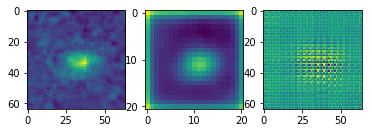

In [108]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        img = real_cpu+0.05*torch.rand_like(real_cpu)
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
        kernel = kernel.to(device)
        img2 = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img2 = img2[:,:,:,:]
        
        plt.subplot(1,3,1)
        plt.imshow(real_cpu[1,0,:,:])      
        plt.subplot(1,3,2)
        plt.imshow(img2[1,0,:,:])
        img = netS(img2)
        im = img[1,0,:,:]
        plt.subplot(1,3,3)
        im = im.data.numpy()
        plt.imshow(im)
        stop
        


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
print(netG)

In [119]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [121]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images

        kernel = kernel.to(device)
        img = F.conv2d(real_cpu, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img+0.05*torch.rand_like(img)
        img = img[:,:,7:-7,7:-7]
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
    
        
        downsampled_1d = downsampled.view([batch_size,nz,1,1])
        fake = netG(downsampled_1d)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/10][0/95] Loss_D: 1.4696 Loss_G: 20.0036 D(x): 0.5145 D(G(z)): 0.5358 / 0.0001
[0/10][1/95] Loss_D: 9.0122 Loss_G: 11.7399 D(x): 0.9994 D(G(z)): 0.9995 / 0.0000


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/

KeyboardInterrupt: 

# ignore below

torch.Size([64, 1, 60, 60])
torch.Size([1, 1, 41, 41])
torch.Size([64, 1, 60, 60])


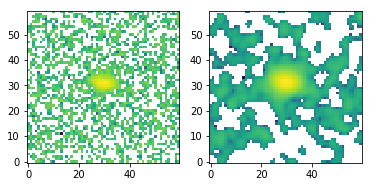

In [5]:
test_im = pyfits.getdata('gal_cutout.fits')
test_im = np.asarray(test_im,dtype=float)
data = np.repeat(test_im[:, :, np.newaxis], batchSize, axis=2)
data = np.repeat(data[:,:,:,np.newaxis],1,axis = 3)
data = torch.Tensor(data)
data = data.permute(2,3,0,1)

output = F.conv2d(data, kernel,padding=int(((kernel.shape[3])-1)/2))

print(data.shape)
print(kernel.shape)
print(output.shape)

convolved = output.data.numpy()
im = convolved[1,0,:,:]
plt.subplot(1,2,1)
plt.imshow(np.log10(test_im),origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.log10(im),origin='lower')

In [23]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
print(noise.shape)
for i, data in enumerate(dataloader, 0):
    
    img =  data[0].to(device)    
    kernel = kernel.to(device)
    img = F.conv2d(img, kernel,padding=int(((kernel.shape[3])-1)/2))
    img = img+0.01*torch.rand_like(img)
    downsampled = F.upsample(img,scale_factor=0.25,mode='bilinear')
    d = downsampled.view([64,256,1,1])
    stop



torch.Size([64, 256, 1, 1])


NameError: name 'stop' is not defined